In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('sb_30-05_slim_slim-1.csv')

In [3]:
df.head()

,x,y,goalkeeper_dx,goalkeeper_dy,opposition_1_dx,opposition_1_dy,opposition_2_dx,opposition_2_dy,opposition_3_dx,opposition_3_dy,...,shot_one_on_one,shot_outcome,shot_technique,shot_statsbomb_xg,shot_type,under_pressure,prev_type,goal,prev_x,prev_y
0,100.4,35.1,18.0,3.4,1.5,0.0,5.0,-3.6,6.8,3.0,...,False,Blocked,Normal,0.056644,Open Play,False,Ball Recovery,False,101.7,35.6
1,114.6,33.5,3.7,2.9,-0.3,1.1,-1.6,3.6,0.0,5.6,...,False,Saved,Normal,0.143381,Open Play,True,Pass,False,111.0,69.2
2,106.2,55.8,12.0,-12.9,2.7,3.9,2.9,-5.0,2.7,-9.6,...,False,Blocked,Normal,0.038188,Open Play,False,Ball Recovery,False,105.8,56.5
3,113.9,47.4,5.0,-5.5,0.2,-1.0,-0.7,-0.8,-0.9,-2.3,...,False,Blocked,Normal,0.052781,Open Play,False,Pass,False,120.0,0.1
4,89.2,42.5,27.7,-2.4,2.7,1.3,3.1,-1.9,1.9,9.0,...,False,Blocked,Normal,0.021272,Open Play,True,Carry,False,87.6,46.0


In [4]:
sb_labs = df['shot_statsbomb_xg'].values

y = df['goal'].values

In [5]:
df['header'] = df['shot_body_part'] == 'Head'
df['header'] = df['header'].astype(int)
df['shot_aerial_won'] = df['shot_aerial_won'].astype(int)
df['shot_first_time'] = df['shot_first_time'].astype(int)
df['shot_one_on_one'] = df['shot_one_on_one'].astype(int)
df['under_pressure'] = df['under_pressure'].astype(int)

In [6]:
df.drop(['shot_body_part', 'shot_technique', 'shot_outcome', 'goal', 'shot_statsbomb_xg'], axis = 1, inplace = True)

In [7]:
df_1h = pd.get_dummies(df, columns = ['play_pattern', 'shot_type', 'prev_type'])

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df_1h, y, sb_labs, random_state=42
)


#X_train, X_val, y_train, y_val, sb_train, sb_val = train_test_split(
 #   X_temp, y_temp, sb_temp, test_size=0.3, random_state=42
#)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
#X_val_scaled = scaler.transform(X_val)

In [11]:
from pytorch_tabnet.tab_model import TabNetClassifier
clf = TabNetClassifier()
clf.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled,y_val)], patience = 10)

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


NameError: name 'X_val_scaled' is not defined

In [10]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [22]:

def objective(params):

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []
    
    clf = TabNetClassifier(
        n_d=int(params['n_d']),
        n_a=int(params['n_a']),
        n_steps=int(params['n_steps']),
        gamma=params['gamma'],
        lambda_sparse=params['lambda_sparse'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=params['lr']),
        mask_type=params['mask_type'],
        seed = 42
        
    )

    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        clf.fit(X_train_fold, y_train_fold,patience = 3, max_epochs = 25, eval_set=[(X_val_fold,y_val_fold)])
        y_val_fold_pred = clf.predict_proba(X_val_fold)
        
        auc_score = roc_auc_score(y_val_fold, y_val_fold_pred[:,1])
        auc_scores.append(auc_score)


    mean_auc = np.mean(auc_scores)
    print(f'Cross-Validation ROC AUC: {mean_auc:.4f}')

    # Return the negative mean ROC AUC as Hyperopt minimizes the objective function
    return {'loss': -mean_auc, 'status': STATUS_OK}

space = {
    'n_d': hp.quniform('n_d', 8, 64, 1),
    'n_a': hp.quniform('n_a', 8, 64, 1),
    'n_steps': hp.quniform('n_steps', 3, 10, 1),
    'gamma': hp.uniform('gamma', 1.0, 2.0),
    'lambda_sparse': hp.uniform('lambda_sparse', 1e-6, 1e-3),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'mask_type': hp.choice('mask_type', ['sparsemax', 'entmax'])
}

In [23]:
space = {
    'n_d': hp.quniform('n_d', 8, 64, 1),
    'n_a': hp.quniform('n_a', 8, 64, 1),
    'n_steps': hp.quniform('n_steps', 3, 10, 1),
    'gamma': hp.uniform('gamma', 1.0, 2.0),
    'lambda_sparse': hp.uniform('lambda_sparse', 1e-6, 1e-3),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'mask_type': hp.choice('mask_type', ['sparsemax', 'entmax'])
}

In [24]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best params: {best}")

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.52801 | val_0_auc: 0.5689  |  0:00:04s                                                              
epoch 1  | loss: 0.37642 | val_0_auc: 0.60849 |  0:00:08s                                                              
epoch 2  | loss: 0.34695 | val_0_auc: 0.63765 |  0:00:12s                                                              
epoch 3  | loss: 0.33023 | val_0_auc: 0.65963 |  0:00:16s                                                              
epoch 4  | loss: 0.31934 | val_0_auc: 0.66296 |  0:00:20s                                                              
epoch 5  | loss: 0.31248 | val_0_auc: 0.68147 |  0:00:24s                                                              
epoch 6  | loss: 0.31032 | val_0_auc: 0.68499 |  0:00:28s                                                              
epoch 7  | loss: 0.3034  | val_0_auc: 0.68598 |  0:00:32s                                                              
epoch 8  | loss: 0.30614 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52352 | val_0_auc: 0.58825 |  0:00:04s                                                              
epoch 1  | loss: 0.38419 | val_0_auc: 0.60248 |  0:00:08s                                                              
epoch 2  | loss: 0.35172 | val_0_auc: 0.62338 |  0:00:12s                                                              
epoch 3  | loss: 0.34603 | val_0_auc: 0.64672 |  0:00:16s                                                              
epoch 4  | loss: 0.3293  | val_0_auc: 0.67019 |  0:00:20s                                                              
epoch 5  | loss: 0.32129 | val_0_auc: 0.67579 |  0:00:23s                                                              
epoch 6  | loss: 0.31356 | val_0_auc: 0.67595 |  0:00:28s                                                              
epoch 7  | loss: 0.31188 | val_0_auc: 0.68    |  0:00:31s                                                              
epoch 8  | loss: 0.3058  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5228  | val_0_auc: 0.59675 |  0:00:04s                                                              
epoch 1  | loss: 0.37908 | val_0_auc: 0.60922 |  0:00:08s                                                              
epoch 2  | loss: 0.34385 | val_0_auc: 0.6172  |  0:00:12s                                                              
epoch 3  | loss: 0.33791 | val_0_auc: 0.62667 |  0:00:16s                                                              
epoch 4  | loss: 0.33037 | val_0_auc: 0.64526 |  0:00:20s                                                              
epoch 5  | loss: 0.32657 | val_0_auc: 0.6434  |  0:00:24s                                                              
epoch 6  | loss: 0.31774 | val_0_auc: 0.66204 |  0:00:28s                                                              
epoch 7  | loss: 0.31371 | val_0_auc: 0.68323 |  0:00:33s                                                              
epoch 8  | loss: 0.30938 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54049 | val_0_auc: 0.58671 |  0:00:03s                                                              
epoch 1  | loss: 0.39129 | val_0_auc: 0.60763 |  0:00:07s                                                              
epoch 2  | loss: 0.3574  | val_0_auc: 0.65098 |  0:00:11s                                                              
epoch 3  | loss: 0.33505 | val_0_auc: 0.66491 |  0:00:15s                                                              
epoch 4  | loss: 0.3286  | val_0_auc: 0.66544 |  0:00:19s                                                              
epoch 5  | loss: 0.31915 | val_0_auc: 0.66908 |  0:00:23s                                                              
epoch 6  | loss: 0.31429 | val_0_auc: 0.69292 |  0:00:27s                                                              
epoch 7  | loss: 0.30676 | val_0_auc: 0.70991 |  0:00:31s                                                              
epoch 8  | loss: 0.30223 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52934 | val_0_auc: 0.58882 |  0:00:03s                                                              
epoch 1  | loss: 0.37914 | val_0_auc: 0.62191 |  0:00:07s                                                              
epoch 2  | loss: 0.34945 | val_0_auc: 0.64989 |  0:00:11s                                                              
epoch 3  | loss: 0.32651 | val_0_auc: 0.65837 |  0:00:15s                                                              
epoch 4  | loss: 0.31974 | val_0_auc: 0.67564 |  0:00:19s                                                              
epoch 5  | loss: 0.31724 | val_0_auc: 0.6835  |  0:00:23s                                                              
epoch 6  | loss: 0.31028 | val_0_auc: 0.66473 |  0:00:27s                                                              
epoch 7  | loss: 0.30797 | val_0_auc: 0.67296 |  0:00:30s                                                              
epoch 8  | loss: 0.30724 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52096 | val_0_auc: 0.56631 |  0:00:04s                                                              
epoch 1  | loss: 0.38286 | val_0_auc: 0.59906 |  0:00:08s                                                              
epoch 2  | loss: 0.35216 | val_0_auc: 0.6371  |  0:00:13s                                                              
epoch 3  | loss: 0.32899 | val_0_auc: 0.66215 |  0:00:18s                                                              
epoch 4  | loss: 0.32095 | val_0_auc: 0.65891 |  0:00:23s                                                              
epoch 5  | loss: 0.31728 | val_0_auc: 0.6588  |  0:00:26s                                                              
epoch 6  | loss: 0.3116  | val_0_auc: 0.67346 |  0:00:30s                                                              
epoch 7  | loss: 0.30584 | val_0_auc: 0.68767 |  0:00:34s                                                              
epoch 8  | loss: 0.30575 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52925 | val_0_auc: 0.57103 |  0:00:03s                                                              
epoch 1  | loss: 0.37577 | val_0_auc: 0.58892 |  0:00:07s                                                              
epoch 2  | loss: 0.34575 | val_0_auc: 0.63341 |  0:00:11s                                                              
epoch 3  | loss: 0.33309 | val_0_auc: 0.65792 |  0:00:15s                                                              
epoch 4  | loss: 0.31992 | val_0_auc: 0.64298 |  0:00:18s                                                              
epoch 5  | loss: 0.3148  | val_0_auc: 0.66186 |  0:00:22s                                                              
epoch 6  | loss: 0.30583 | val_0_auc: 0.67973 |  0:00:26s                                                              
epoch 7  | loss: 0.30618 | val_0_auc: 0.68908 |  0:00:30s                                                              
epoch 8  | loss: 0.30299 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52056 | val_0_auc: 0.59958 |  0:00:03s                                                              
epoch 1  | loss: 0.3784  | val_0_auc: 0.61802 |  0:00:07s                                                              
epoch 2  | loss: 0.34858 | val_0_auc: 0.62552 |  0:00:11s                                                              
epoch 3  | loss: 0.33351 | val_0_auc: 0.65639 |  0:00:15s                                                              
epoch 4  | loss: 0.32207 | val_0_auc: 0.66525 |  0:00:19s                                                              
epoch 5  | loss: 0.31448 | val_0_auc: 0.66561 |  0:00:24s                                                              
epoch 6  | loss: 0.30976 | val_0_auc: 0.68192 |  0:00:29s                                                              
epoch 7  | loss: 0.30393 | val_0_auc: 0.67239 |  0:00:34s                                                              
epoch 8  | loss: 0.30468 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53784 | val_0_auc: 0.60683 |  0:00:03s                                                              
epoch 1  | loss: 0.37772 | val_0_auc: 0.64183 |  0:00:07s                                                              
epoch 2  | loss: 0.3508  | val_0_auc: 0.65729 |  0:00:11s                                                              
epoch 3  | loss: 0.33704 | val_0_auc: 0.67908 |  0:00:15s                                                              
epoch 4  | loss: 0.32788 | val_0_auc: 0.67574 |  0:00:18s                                                              
epoch 5  | loss: 0.31767 | val_0_auc: 0.68951 |  0:00:22s                                                              
epoch 6  | loss: 0.31413 | val_0_auc: 0.67689 |  0:00:26s                                                              
epoch 7  | loss: 0.31159 | val_0_auc: 0.67828 |  0:00:30s                                                              
epoch 8  | loss: 0.30676 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53551 | val_0_auc: 0.59374 |  0:00:03s                                                              
epoch 1  | loss: 0.38935 | val_0_auc: 0.6291  |  0:00:07s                                                              
epoch 2  | loss: 0.34396 | val_0_auc: 0.6348  |  0:00:11s                                                              
epoch 3  | loss: 0.33726 | val_0_auc: 0.63724 |  0:00:15s                                                              
epoch 4  | loss: 0.32418 | val_0_auc: 0.67039 |  0:00:19s                                                              
epoch 5  | loss: 0.32073 | val_0_auc: 0.6664  |  0:00:22s                                                              
epoch 6  | loss: 0.31178 | val_0_auc: 0.69361 |  0:00:26s                                                              
epoch 7  | loss: 0.30942 | val_0_auc: 0.68624 |  0:00:30s                                                              
epoch 8  | loss: 0.30826 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7170                                                                                       
  1%|▍                                          | 1/100 [12:19<20:19:59, 739.39s/trial, best loss: -0.7169866962350893]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.6314  | val_0_auc: 0.49731 |  0:00:02s                                                              
epoch 1  | loss: 0.60189 | val_0_auc: 0.49615 |  0:00:05s                                                              
epoch 2  | loss: 0.58751 | val_0_auc: 0.50283 |  0:00:09s                                                              
epoch 3  | loss: 0.57421 | val_0_auc: 0.49986 |  0:00:12s                                                              
epoch 4  | loss: 0.55532 | val_0_auc: 0.5031  |  0:00:15s                                                              
epoch 5  | loss: 0.53415 | val_0_auc: 0.50586 |  0:00:18s                                                              
epoch 6  | loss: 0.53324 | val_0_auc: 0.50507 |  0:00:21s                                                              
epoch 7  | loss: 0.51337 | val_0_auc: 0.5041  |  0:00:25s                                                              
epoch 8  | loss: 0.50418 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.6231  | val_0_auc: 0.50584 |  0:00:03s                                                              
epoch 1  | loss: 0.61327 | val_0_auc: 0.50677 |  0:00:06s                                                              
epoch 2  | loss: 0.59324 | val_0_auc: 0.50272 |  0:00:09s                                                              
epoch 3  | loss: 0.56605 | val_0_auc: 0.50713 |  0:00:12s                                                              
epoch 4  | loss: 0.55849 | val_0_auc: 0.51328 |  0:00:15s                                                              
epoch 5  | loss: 0.54215 | val_0_auc: 0.51    |  0:00:18s                                                              
epoch 6  | loss: 0.53265 | val_0_auc: 0.5113  |  0:00:21s                                                              
epoch 7  | loss: 0.51643 | val_0_auc: 0.51021 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61888 | val_0_auc: 0.5029  |  0:00:02s                                                              
epoch 1  | loss: 0.60854 | val_0_auc: 0.50668 |  0:00:06s                                                              
epoch 2  | loss: 0.58913 | val_0_auc: 0.50164 |  0:00:09s                                                              
epoch 3  | loss: 0.57065 | val_0_auc: 0.50252 |  0:00:13s                                                              
epoch 4  | loss: 0.55375 | val_0_auc: 0.50858 |  0:00:16s                                                              
epoch 5  | loss: 0.5421  | val_0_auc: 0.51047 |  0:00:19s                                                              
epoch 6  | loss: 0.52889 | val_0_auc: 0.51382 |  0:00:22s                                                              
epoch 7  | loss: 0.51572 | val_0_auc: 0.51804 |  0:00:26s                                                              
epoch 8  | loss: 0.50105 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.63276 | val_0_auc: 0.52102 |  0:00:03s                                                              
epoch 1  | loss: 0.61755 | val_0_auc: 0.52488 |  0:00:06s                                                              
epoch 2  | loss: 0.59566 | val_0_auc: 0.52283 |  0:00:09s                                                              
epoch 3  | loss: 0.58107 | val_0_auc: 0.51823 |  0:00:12s                                                              
epoch 4  | loss: 0.55665 | val_0_auc: 0.52379 |  0:00:15s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.52488
  1%|▍                                          | 1/100 [14:53<20:19:59, 739.39s/trial, best loss: -0.7169866962350893]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62821 | val_0_auc: 0.48893 |  0:00:03s                                                              
epoch 1  | loss: 0.6049  | val_0_auc: 0.48839 |  0:00:07s                                                              
epoch 2  | loss: 0.58841 | val_0_auc: 0.4859  |  0:00:10s                                                              
epoch 3  | loss: 0.56939 | val_0_auc: 0.49403 |  0:00:13s                                                              
epoch 4  | loss: 0.55473 | val_0_auc: 0.49069 |  0:00:16s                                                              
epoch 5  | loss: 0.53976 | val_0_auc: 0.49798 |  0:00:19s                                                              
epoch 6  | loss: 0.53017 | val_0_auc: 0.49632 |  0:00:22s                                                              
epoch 7  | loss: 0.51426 | val_0_auc: 0.49538 |  0:00:25s                                                              
epoch 8  | loss: 0.51076 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62003 | val_0_auc: 0.51108 |  0:00:03s                                                              
epoch 1  | loss: 0.60074 | val_0_auc: 0.51421 |  0:00:07s                                                              
epoch 2  | loss: 0.58257 | val_0_auc: 0.51046 |  0:00:12s                                                              
epoch 3  | loss: 0.57336 | val_0_auc: 0.51331 |  0:00:15s                                                              
epoch 4  | loss: 0.55288 | val_0_auc: 0.51688 |  0:00:18s                                                              
epoch 5  | loss: 0.53629 | val_0_auc: 0.51478 |  0:00:21s                                                              
epoch 6  | loss: 0.52514 | val_0_auc: 0.51539 |  0:00:24s                                                              
epoch 7  | loss: 0.5064  | val_0_auc: 0.52043 |  0:00:28s                                                              
epoch 8  | loss: 0.50141 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61858 | val_0_auc: 0.49418 |  0:00:02s                                                              
epoch 1  | loss: 0.60188 | val_0_auc: 0.49623 |  0:00:06s                                                              
epoch 2  | loss: 0.586   | val_0_auc: 0.49558 |  0:00:09s                                                              
epoch 3  | loss: 0.57139 | val_0_auc: 0.49375 |  0:00:12s                                                              
epoch 4  | loss: 0.54969 | val_0_auc: 0.49923 |  0:00:15s                                                              
epoch 5  | loss: 0.53576 | val_0_auc: 0.50395 |  0:00:18s                                                              
epoch 6  | loss: 0.5244  | val_0_auc: 0.495   |  0:00:21s                                                              
epoch 7  | loss: 0.51415 | val_0_auc: 0.50475 |  0:00:25s                                                              
epoch 8  | loss: 0.50608 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62691 | val_0_auc: 0.50607 |  0:00:03s                                                              
epoch 1  | loss: 0.60901 | val_0_auc: 0.5072  |  0:00:06s                                                              
epoch 2  | loss: 0.59438 | val_0_auc: 0.50036 |  0:00:09s                                                              
epoch 3  | loss: 0.57472 | val_0_auc: 0.50675 |  0:00:12s                                                              
epoch 4  | loss: 0.55643 | val_0_auc: 0.51028 |  0:00:15s                                                              
epoch 5  | loss: 0.54209 | val_0_auc: 0.51142 |  0:00:18s                                                              
epoch 6  | loss: 0.52797 | val_0_auc: 0.51645 |  0:00:21s                                                              
epoch 7  | loss: 0.51438 | val_0_auc: 0.51943 |  0:00:24s                                                              
epoch 8  | loss: 0.50575 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62682 | val_0_auc: 0.50395 |  0:00:03s                                                              
epoch 1  | loss: 0.60862 | val_0_auc: 0.5     |  0:00:05s                                                              
epoch 2  | loss: 0.58009 | val_0_auc: 0.50544 |  0:00:09s                                                              
epoch 3  | loss: 0.5663  | val_0_auc: 0.50785 |  0:00:12s                                                              
epoch 4  | loss: 0.55404 | val_0_auc: 0.51243 |  0:00:15s                                                              
epoch 5  | loss: 0.54724 | val_0_auc: 0.5079  |  0:00:18s                                                              
epoch 6  | loss: 0.53172 | val_0_auc: 0.50932 |  0:00:21s                                                              
epoch 7  | loss: 0.51987 | val_0_auc: 0.50708 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.63132 | val_0_auc: 0.50822 |  0:00:02s                                                              
epoch 1  | loss: 0.61288 | val_0_auc: 0.50098 |  0:00:05s                                                              
epoch 2  | loss: 0.59446 | val_0_auc: 0.50343 |  0:00:08s                                                              
epoch 3  | loss: 0.56719 | val_0_auc: 0.50209 |  0:00:12s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50822
  1%|▍                                          | 1/100 [19:00<20:19:59, 739.39s/trial, best loss: -0.7169866962350893]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5125                                                                                       
  2%|▊                                          | 2/100 [19:02<14:44:14, 541.37s/trial, best loss: -0.7169866962350893]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 3.90541 | val_0_auc: 0.45253 |  0:00:03s                                                              
epoch 1  | loss: 3.41339 | val_0_auc: 0.45619 |  0:00:06s                                                              
epoch 2  | loss: 2.95842 | val_0_auc: 0.45859 |  0:00:10s                                                              
epoch 3  | loss: 2.53324 | val_0_auc: 0.46321 |  0:00:13s                                                              
epoch 4  | loss: 2.15906 | val_0_auc: 0.47152 |  0:00:17s                                                              
epoch 5  | loss: 1.82055 | val_0_auc: 0.47025 |  0:00:21s                                                              
epoch 6  | loss: 1.51981 | val_0_auc: 0.4748  |  0:00:24s                                                              
epoch 7  | loss: 1.26058 | val_0_auc: 0.47506 |  0:00:28s                                                              
epoch 8  | loss: 1.07966 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.88799 | val_0_auc: 0.45583 |  0:00:05s                                                              
epoch 1  | loss: 3.38917 | val_0_auc: 0.46234 |  0:00:12s                                                              
epoch 2  | loss: 2.9162  | val_0_auc: 0.46412 |  0:00:15s                                                              
epoch 3  | loss: 2.5284  | val_0_auc: 0.47101 |  0:00:19s                                                              
epoch 4  | loss: 2.17674 | val_0_auc: 0.4809  |  0:00:22s                                                              
epoch 5  | loss: 1.82946 | val_0_auc: 0.47299 |  0:00:26s                                                              
epoch 6  | loss: 1.55389 | val_0_auc: 0.47661 |  0:00:30s                                                              
epoch 7  | loss: 1.32928 | val_0_auc: 0.49419 |  0:00:33s                                                              
epoch 8  | loss: 1.10005 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.89571 | val_0_auc: 0.45257 |  0:00:03s                                                              
epoch 1  | loss: 3.41162 | val_0_auc: 0.46093 |  0:00:06s                                                              
epoch 2  | loss: 3.01556 | val_0_auc: 0.47125 |  0:00:10s                                                              
epoch 3  | loss: 2.61059 | val_0_auc: 0.47019 |  0:00:14s                                                              
epoch 4  | loss: 2.26557 | val_0_auc: 0.47737 |  0:00:18s                                                              
epoch 5  | loss: 1.94429 | val_0_auc: 0.47984 |  0:00:21s                                                              
epoch 6  | loss: 1.64747 | val_0_auc: 0.48171 |  0:00:25s                                                              
epoch 7  | loss: 1.37217 | val_0_auc: 0.49233 |  0:00:28s                                                              
epoch 8  | loss: 1.12922 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.91262 | val_0_auc: 0.44806 |  0:00:03s                                                              
epoch 1  | loss: 3.45477 | val_0_auc: 0.45183 |  0:00:06s                                                              
epoch 2  | loss: 2.97081 | val_0_auc: 0.44836 |  0:00:10s                                                              
epoch 3  | loss: 2.51809 | val_0_auc: 0.45651 |  0:00:13s                                                              
epoch 4  | loss: 2.18441 | val_0_auc: 0.46695 |  0:00:17s                                                              
epoch 5  | loss: 1.8179  | val_0_auc: 0.46998 |  0:00:20s                                                              
epoch 6  | loss: 1.5214  | val_0_auc: 0.47191 |  0:00:24s                                                              
epoch 7  | loss: 1.2926  | val_0_auc: 0.46763 |  0:00:27s                                                              
epoch 8  | loss: 1.09324 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.90041 | val_0_auc: 0.44465 |  0:00:03s                                                              
epoch 1  | loss: 3.39842 | val_0_auc: 0.45443 |  0:00:06s                                                              
epoch 2  | loss: 2.92653 | val_0_auc: 0.45923 |  0:00:10s                                                              
epoch 3  | loss: 2.51047 | val_0_auc: 0.44812 |  0:00:13s                                                              
epoch 4  | loss: 2.16658 | val_0_auc: 0.45146 |  0:00:17s                                                              
epoch 5  | loss: 1.86635 | val_0_auc: 0.45625 |  0:00:20s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.45923
  2%|▊                                          | 2/100 [25:43<14:44:14, 541

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.92387 | val_0_auc: 0.4734  |  0:00:03s                                                              
epoch 1  | loss: 3.41054 | val_0_auc: 0.47866 |  0:00:06s                                                              
epoch 2  | loss: 2.93372 | val_0_auc: 0.47897 |  0:00:10s                                                              
epoch 3  | loss: 2.53544 | val_0_auc: 0.48509 |  0:00:13s                                                              
epoch 4  | loss: 2.20418 | val_0_auc: 0.48626 |  0:00:17s                                                              
epoch 5  | loss: 1.87825 | val_0_auc: 0.48984 |  0:00:20s                                                              
epoch 6  | loss: 1.58229 | val_0_auc: 0.49246 |  0:00:24s                                                              
epoch 7  | loss: 1.3528  | val_0_auc: 0.49758 |  0:00:28s                                                              
epoch 8  | loss: 1.14773 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.89628 | val_0_auc: 0.43332 |  0:00:03s                                                              
epoch 1  | loss: 3.40637 | val_0_auc: 0.43336 |  0:00:06s                                                              
epoch 2  | loss: 2.92878 | val_0_auc: 0.44149 |  0:00:10s                                                              
epoch 3  | loss: 2.48021 | val_0_auc: 0.4458  |  0:00:13s                                                              
epoch 4  | loss: 2.1316  | val_0_auc: 0.45638 |  0:00:17s                                                              
epoch 5  | loss: 1.8351  | val_0_auc: 0.4659  |  0:00:21s                                                              
epoch 6  | loss: 1.54141 | val_0_auc: 0.46124 |  0:00:24s                                                              
epoch 7  | loss: 1.28105 | val_0_auc: 0.47557 |  0:00:28s                                                              
epoch 8  | loss: 1.07988 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.87851 | val_0_auc: 0.44917 |  0:00:03s                                                              
epoch 1  | loss: 3.42482 | val_0_auc: 0.45838 |  0:00:07s                                                              
epoch 2  | loss: 2.9721  | val_0_auc: 0.45618 |  0:00:10s                                                              
epoch 3  | loss: 2.58788 | val_0_auc: 0.46188 |  0:00:14s                                                              
epoch 4  | loss: 2.21244 | val_0_auc: 0.46042 |  0:00:17s                                                              
epoch 5  | loss: 1.91973 | val_0_auc: 0.46859 |  0:00:20s                                                              
epoch 6  | loss: 1.62845 | val_0_auc: 0.47048 |  0:00:24s                                                              
epoch 7  | loss: 1.37716 | val_0_auc: 0.47917 |  0:00:28s                                                              
epoch 8  | loss: 1.16034 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.91214 | val_0_auc: 0.46325 |  0:00:03s                                                              
epoch 1  | loss: 3.38975 | val_0_auc: 0.46412 |  0:00:06s                                                              
epoch 2  | loss: 2.89415 | val_0_auc: 0.46409 |  0:00:10s                                                              
epoch 3  | loss: 2.47401 | val_0_auc: 0.47147 |  0:00:13s                                                              
epoch 4  | loss: 2.13238 | val_0_auc: 0.47047 |  0:00:17s                                                              
epoch 5  | loss: 1.83107 | val_0_auc: 0.46654 |  0:00:20s                                                              
epoch 6  | loss: 1.56661 | val_0_auc: 0.47355 |  0:00:24s                                                              
epoch 7  | loss: 1.32503 | val_0_auc: 0.473   |  0:00:27s                                                              
epoch 8  | loss: 1.11058 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.89953 | val_0_auc: 0.44393 |  0:00:03s                                                              
epoch 1  | loss: 3.38455 | val_0_auc: 0.45055 |  0:00:07s                                                              
epoch 2  | loss: 2.95737 | val_0_auc: 0.45326 |  0:00:11s                                                              
epoch 3  | loss: 2.57002 | val_0_auc: 0.45648 |  0:00:14s                                                              
epoch 4  | loss: 2.19423 | val_0_auc: 0.46079 |  0:00:18s                                                              
epoch 5  | loss: 1.85843 | val_0_auc: 0.47194 |  0:00:23s                                                              
epoch 6  | loss: 1.55397 | val_0_auc: 0.47793 |  0:00:27s                                                              
epoch 7  | loss: 1.30819 | val_0_auc: 0.48742 |  0:00:32s                                                              
epoch 8  | loss: 1.09081 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5845                                                                                       
  3%|█▎                                         | 3/100 [33:24<18:32:27, 688.12s/trial, best loss: -0.7169866962350893]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.50853 | val_0_auc: 0.6232  |  0:00:08s                                                              
epoch 1  | loss: 0.36192 | val_0_auc: 0.68464 |  0:00:16s                                                              
epoch 2  | loss: 0.30335 | val_0_auc: 0.70073 |  0:00:25s                                                              
epoch 3  | loss: 0.29112 | val_0_auc: 0.71789 |  0:00:34s                                                              
epoch 4  | loss: 0.30665 | val_0_auc: 0.73776 |  0:00:43s                                                              
epoch 5  | loss: 0.29211 | val_0_auc: 0.74513 |  0:00:53s                                                              
epoch 6  | loss: 0.27715 | val_0_auc: 0.75609 |  0:01:03s                                                              
epoch 7  | loss: 0.27208 | val_0_auc: 0.75454 |  0:01:12s                                                              
epoch 8  | loss: 0.27451 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52775 | val_0_auc: 0.66564 |  0:00:08s                                                              
epoch 1  | loss: 0.37691 | val_0_auc: 0.70218 |  0:00:16s                                                              
epoch 2  | loss: 0.34595 | val_0_auc: 0.71613 |  0:00:25s                                                              
epoch 3  | loss: 0.29728 | val_0_auc: 0.74754 |  0:00:35s                                                              
epoch 4  | loss: 0.28002 | val_0_auc: 0.74444 |  0:00:44s                                                              
epoch 5  | loss: 0.28129 | val_0_auc: 0.74223 |  0:00:53s                                                              
epoch 6  | loss: 0.27632 | val_0_auc: 0.75234 |  0:01:02s                                                              
epoch 7  | loss: 0.27898 | val_0_auc: 0.75622 |  0:01:10s                                                              
epoch 8  | loss: 0.2836  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57616 | val_0_auc: 0.60925 |  0:00:07s                                                              
epoch 1  | loss: 0.38365 | val_0_auc: 0.67507 |  0:00:16s                                                              
epoch 2  | loss: 0.33438 | val_0_auc: 0.71342 |  0:00:24s                                                              
epoch 3  | loss: 0.31349 | val_0_auc: 0.7171  |  0:00:32s                                                              
epoch 4  | loss: 0.29284 | val_0_auc: 0.72492 |  0:00:41s                                                              
epoch 5  | loss: 0.28346 | val_0_auc: 0.73525 |  0:00:49s                                                              
epoch 6  | loss: 0.27598 | val_0_auc: 0.7447  |  0:00:57s                                                              
epoch 7  | loss: 0.27658 | val_0_auc: 0.74633 |  0:01:05s                                                              
epoch 8  | loss: 0.27941 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.65684 | val_0_auc: 0.63568 |  0:00:07s                                                              
epoch 1  | loss: 0.36778 | val_0_auc: 0.66989 |  0:00:15s                                                              
epoch 2  | loss: 0.33088 | val_0_auc: 0.71705 |  0:00:24s                                                              
epoch 3  | loss: 0.2953  | val_0_auc: 0.75389 |  0:00:32s                                                              
epoch 4  | loss: 0.29298 | val_0_auc: 0.75282 |  0:00:41s                                                              
epoch 5  | loss: 0.2828  | val_0_auc: 0.75824 |  0:00:49s                                                              
epoch 6  | loss: 0.28365 | val_0_auc: 0.75606 |  0:00:57s                                                              
epoch 7  | loss: 0.27992 | val_0_auc: 0.7703  |  0:01:06s                                                              
epoch 8  | loss: 0.27669 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49747 | val_0_auc: 0.65466 |  0:00:08s                                                              
epoch 1  | loss: 0.34742 | val_0_auc: 0.69581 |  0:00:16s                                                              
epoch 2  | loss: 0.31827 | val_0_auc: 0.70123 |  0:00:24s                                                              
epoch 3  | loss: 0.29125 | val_0_auc: 0.7343  |  0:00:33s                                                              
epoch 4  | loss: 0.28246 | val_0_auc: 0.74503 |  0:00:41s                                                              
epoch 5  | loss: 0.28823 | val_0_auc: 0.75071 |  0:00:49s                                                              
epoch 6  | loss: 0.2721  | val_0_auc: 0.75459 |  0:00:57s                                                              
epoch 7  | loss: 0.27206 | val_0_auc: 0.76289 |  0:01:05s                                                              
epoch 8  | loss: 0.27203 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50845 | val_0_auc: 0.65042 |  0:00:08s                                                              
epoch 1  | loss: 0.3525  | val_0_auc: 0.6859  |  0:00:16s                                                              
epoch 2  | loss: 0.31592 | val_0_auc: 0.70959 |  0:00:24s                                                              
epoch 3  | loss: 0.289   | val_0_auc: 0.71337 |  0:00:32s                                                              
epoch 4  | loss: 0.29371 | val_0_auc: 0.72937 |  0:00:41s                                                              
epoch 5  | loss: 0.27368 | val_0_auc: 0.73284 |  0:00:49s                                                              
epoch 6  | loss: 0.2725  | val_0_auc: 0.74518 |  0:00:57s                                                              
epoch 7  | loss: 0.27054 | val_0_auc: 0.7505  |  0:01:06s                                                              
epoch 8  | loss: 0.2733  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50478 | val_0_auc: 0.61797 |  0:00:08s                                                              
epoch 1  | loss: 0.36443 | val_0_auc: 0.68788 |  0:00:16s                                                              
epoch 2  | loss: 0.30373 | val_0_auc: 0.71861 |  0:00:24s                                                              
epoch 3  | loss: 0.28708 | val_0_auc: 0.73778 |  0:00:32s                                                              
epoch 4  | loss: 0.27956 | val_0_auc: 0.73829 |  0:00:41s                                                              
epoch 5  | loss: 0.27653 | val_0_auc: 0.74561 |  0:00:49s                                                              
epoch 6  | loss: 0.27105 | val_0_auc: 0.75826 |  0:00:58s                                                              
epoch 7  | loss: 0.26796 | val_0_auc: 0.75255 |  0:01:06s                                                              
epoch 8  | loss: 0.26945 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.58866 | val_0_auc: 0.63465 |  0:00:08s                                                              
epoch 1  | loss: 0.38273 | val_0_auc: 0.66441 |  0:00:16s                                                              
epoch 2  | loss: 0.32035 | val_0_auc: 0.71445 |  0:00:24s                                                              
epoch 3  | loss: 0.29347 | val_0_auc: 0.73646 |  0:00:32s                                                              
epoch 4  | loss: 0.28417 | val_0_auc: 0.73868 |  0:00:41s                                                              
epoch 5  | loss: 0.27361 | val_0_auc: 0.75509 |  0:00:49s                                                              
epoch 6  | loss: 0.27041 | val_0_auc: 0.75782 |  0:00:57s                                                              
epoch 7  | loss: 0.27549 | val_0_auc: 0.75065 |  0:01:05s                                                              
epoch 8  | loss: 0.27491 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50556 | val_0_auc: 0.66425 |  0:00:08s                                                              
epoch 1  | loss: 0.35915 | val_0_auc: 0.69501 |  0:00:16s                                                              
epoch 2  | loss: 0.32671 | val_0_auc: 0.74542 |  0:00:24s                                                              
epoch 3  | loss: 0.30336 | val_0_auc: 0.76268 |  0:00:32s                                                              
epoch 4  | loss: 0.28347 | val_0_auc: 0.76729 |  0:00:40s                                                              
epoch 5  | loss: 0.28005 | val_0_auc: 0.77608 |  0:00:49s                                                              
epoch 6  | loss: 0.27341 | val_0_auc: 0.77073 |  0:00:57s                                                              
epoch 7  | loss: 0.27347 | val_0_auc: 0.77494 |  0:01:05s                                                              
epoch 8  | loss: 0.27334 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5278  | val_0_auc: 0.66027 |  0:00:07s                                                              
epoch 1  | loss: 0.39425 | val_0_auc: 0.68277 |  0:00:16s                                                              
epoch 2  | loss: 0.33425 | val_0_auc: 0.72711 |  0:00:24s                                                              
epoch 3  | loss: 0.2941  | val_0_auc: 0.73634 |  0:00:32s                                                              
epoch 4  | loss: 0.28115 | val_0_auc: 0.75019 |  0:00:41s                                                              
epoch 5  | loss: 0.27978 | val_0_auc: 0.74747 |  0:00:49s                                                              
epoch 6  | loss: 0.27881 | val_0_auc: 0.76017 |  0:00:57s                                                              
epoch 7  | loss: 0.27422 | val_0_auc: 0.76817 |  0:01:05s                                                              
epoch 8  | loss: 0.27367 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7684                                                                                       
  4%|█▋                                        | 4/100 [58:16<26:48:31, 1005.33s/trial, best loss: -0.7683934450373073]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.40379 | val_0_auc: 0.69373 |  0:00:05s                                                              
epoch 1  | loss: 0.2898  | val_0_auc: 0.73166 |  0:00:10s                                                              
epoch 2  | loss: 0.28066 | val_0_auc: 0.75993 |  0:00:15s                                                              
epoch 3  | loss: 0.27379 | val_0_auc: 0.76603 |  0:00:20s                                                              
epoch 4  | loss: 0.26869 | val_0_auc: 0.76211 |  0:00:24s                                                              
epoch 5  | loss: 0.26869 | val_0_auc: 0.7567  |  0:00:28s                                                              
epoch 6  | loss: 0.26853 | val_0_auc: 0.76592 |  0:00:32s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40195 | val_0_auc: 0.64699 |  0:00:04s                                                              
epoch 1  | loss: 0.29302 | val_0_auc: 0.71971 |  0:00:08s                                                              
epoch 2  | loss: 0.2913  | val_0_auc: 0.742   |  0:00:12s                                                              
epoch 3  | loss: 0.28122 | val_0_auc: 0.74758 |  0:00:17s                                                              
epoch 4  | loss: 0.27699 | val_0_auc: 0.73789 |  0:00:21s                                                              
epoch 5  | loss: 0.27559 | val_0_auc: 0.75419 |  0:00:25s                                                              
epoch 6  | loss: 0.27487 | val_0_auc: 0.75652 |  0:00:29s                                                              
epoch 7  | loss: 0.27057 | val_0_auc: 0.75951 |  0:00:34s                                                              
epoch 8  | loss: 0.27094 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39699 | val_0_auc: 0.69798 |  0:00:04s                                                              
epoch 1  | loss: 0.28609 | val_0_auc: 0.73119 |  0:00:08s                                                              
epoch 2  | loss: 0.28234 | val_0_auc: 0.7409  |  0:00:12s                                                              
epoch 3  | loss: 0.27529 | val_0_auc: 0.75364 |  0:00:17s                                                              
epoch 4  | loss: 0.2707  | val_0_auc: 0.75579 |  0:00:21s                                                              
epoch 5  | loss: 0.2695  | val_0_auc: 0.75962 |  0:00:25s                                                              
epoch 6  | loss: 0.26819 | val_0_auc: 0.75926 |  0:00:29s                                                              
epoch 7  | loss: 0.26681 | val_0_auc: 0.76054 |  0:00:33s                                                              
epoch 8  | loss: 0.26684 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40213 | val_0_auc: 0.68849 |  0:00:04s                                                              
epoch 1  | loss: 0.29317 | val_0_auc: 0.74341 |  0:00:09s                                                              
epoch 2  | loss: 0.28429 | val_0_auc: 0.73882 |  0:00:14s                                                              
epoch 3  | loss: 0.28404 | val_0_auc: 0.76529 |  0:00:18s                                                              
epoch 4  | loss: 0.27963 | val_0_auc: 0.7639  |  0:00:22s                                                              
epoch 5  | loss: 0.28071 | val_0_auc: 0.76948 |  0:00:26s                                                              
epoch 6  | loss: 0.27705 | val_0_auc: 0.77926 |  0:00:30s                                                              
epoch 7  | loss: 0.27753 | val_0_auc: 0.77939 |  0:00:34s                                                              
epoch 8  | loss: 0.27772 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43247 | val_0_auc: 0.70764 |  0:00:03s                                                              
epoch 1  | loss: 0.28928 | val_0_auc: 0.73138 |  0:00:07s                                                              
epoch 2  | loss: 0.2803  | val_0_auc: 0.75566 |  0:00:11s                                                              
epoch 3  | loss: 0.27817 | val_0_auc: 0.76681 |  0:00:15s                                                              
epoch 4  | loss: 0.27452 | val_0_auc: 0.76983 |  0:00:19s                                                              
epoch 5  | loss: 0.26843 | val_0_auc: 0.77042 |  0:00:24s                                                              
epoch 6  | loss: 0.26708 | val_0_auc: 0.77718 |  0:00:28s                                                              
epoch 7  | loss: 0.26865 | val_0_auc: 0.77796 |  0:00:32s                                                              
epoch 8  | loss: 0.26515 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40953 | val_0_auc: 0.70926 |  0:00:03s                                                              
epoch 1  | loss: 0.28969 | val_0_auc: 0.73639 |  0:00:07s                                                              
epoch 2  | loss: 0.27802 | val_0_auc: 0.75204 |  0:00:12s                                                              
epoch 3  | loss: 0.27027 | val_0_auc: 0.75652 |  0:00:16s                                                              
epoch 4  | loss: 0.26856 | val_0_auc: 0.76672 |  0:00:20s                                                              
epoch 5  | loss: 0.26211 | val_0_auc: 0.77072 |  0:00:24s                                                              
epoch 6  | loss: 0.26352 | val_0_auc: 0.77116 |  0:00:28s                                                              
epoch 7  | loss: 0.26219 | val_0_auc: 0.77022 |  0:00:32s                                                              
epoch 8  | loss: 0.2639  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40065 | val_0_auc: 0.68895 |  0:00:03s                                                              
epoch 1  | loss: 0.28519 | val_0_auc: 0.72566 |  0:00:07s                                                              
epoch 2  | loss: 0.27495 | val_0_auc: 0.74781 |  0:00:12s                                                              
epoch 3  | loss: 0.27541 | val_0_auc: 0.75262 |  0:00:16s                                                              
epoch 4  | loss: 0.269   | val_0_auc: 0.75226 |  0:00:20s                                                              
epoch 5  | loss: 0.2684  | val_0_auc: 0.7532  |  0:00:24s                                                              
epoch 6  | loss: 0.26911 | val_0_auc: 0.75693 |  0:00:29s                                                              
epoch 7  | loss: 0.26566 | val_0_auc: 0.75852 |  0:00:33s                                                              
epoch 8  | loss: 0.26517 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42441 | val_0_auc: 0.68452 |  0:00:03s                                                              
epoch 1  | loss: 0.28947 | val_0_auc: 0.73512 |  0:00:07s                                                              
epoch 2  | loss: 0.27919 | val_0_auc: 0.7328  |  0:00:12s                                                              
epoch 3  | loss: 0.28008 | val_0_auc: 0.75042 |  0:00:16s                                                              
epoch 4  | loss: 0.27787 | val_0_auc: 0.7443  |  0:00:20s                                                              
epoch 5  | loss: 0.27626 | val_0_auc: 0.74654 |  0:00:24s                                                              
epoch 6  | loss: 0.27499 | val_0_auc: 0.74829 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39066 | val_0_auc: 0.73756 |  0:00:03s                                                              
epoch 1  | loss: 0.28751 | val_0_auc: 0.76036 |  0:00:07s                                                              
epoch 2  | loss: 0.28038 | val_0_auc: 0.76286 |  0:00:11s                                                              
epoch 3  | loss: 0.281   | val_0_auc: 0.7738  |  0:00:16s                                                              
epoch 4  | loss: 0.28099 | val_0_auc: 0.76643 |  0:00:20s                                                              
epoch 5  | loss: 0.27745 | val_0_auc: 0.78463 |  0:00:24s                                                              
epoch 6  | loss: 0.27545 | val_0_auc: 0.77637 |  0:00:28s                                                              
epoch 7  | loss: 0.27523 | val_0_auc: 0.7741  |  0:00:32s                                                              
epoch 8  | loss: 0.27191 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40549 | val_0_auc: 0.74908 |  0:00:03s                                                              
epoch 1  | loss: 0.27896 | val_0_auc: 0.76852 |  0:00:07s                                                              
epoch 2  | loss: 0.27407 | val_0_auc: 0.76884 |  0:00:12s                                                              
epoch 3  | loss: 0.26859 | val_0_auc: 0.77377 |  0:00:16s                                                              
epoch 4  | loss: 0.2675  | val_0_auc: 0.77471 |  0:00:20s                                                              
epoch 5  | loss: 0.26831 | val_0_auc: 0.76989 |  0:00:25s                                                              
epoch 6  | loss: 0.2697  | val_0_auc: 0.7772  |  0:00:29s                                                              
epoch 7  | loss: 0.2672  | val_0_auc: 0.78372 |  0:00:33s                                                              
epoch 8  | loss: 0.26543 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7703                                                                                       
  5%|██                                        | 5/100 [1:07:14<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.28575 | val_0_auc: 0.51921 |  0:00:05s                                                              
epoch 1  | loss: 1.26007 | val_0_auc: 0.51562 |  0:00:09s                                                              
epoch 2  | loss: 1.23092 | val_0_auc: 0.50619 |  0:00:14s                                                              
epoch 3  | loss: 1.22473 | val_0_auc: 0.51146 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.51921
  5%|██                                        | 5/100 [1:07:34<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.26966 | val_0_auc: 0.51464 |  0:00:04s                                                              
epoch 1  | loss: 1.24852 | val_0_auc: 0.51427 |  0:00:09s                                                              
epoch 2  | loss: 1.23644 | val_0_auc: 0.51324 |  0:00:14s                                                              
epoch 3  | loss: 1.21883 | val_0_auc: 0.51275 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.51464
  5%|██                                        | 5/100 [1:07:57<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.27436 | val_0_auc: 0.51394 |  0:00:04s                                                              
epoch 1  | loss: 1.26318 | val_0_auc: 0.50649 |  0:00:09s                                                              
epoch 2  | loss: 1.23402 | val_0_auc: 0.49914 |  0:00:14s                                                              
epoch 3  | loss: 1.21686 | val_0_auc: 0.50567 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.51394
  5%|██                                        | 5/100 [1:08:19<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.28752 | val_0_auc: 0.51317 |  0:00:04s                                                              
epoch 1  | loss: 1.24997 | val_0_auc: 0.51318 |  0:00:09s                                                              
epoch 2  | loss: 1.24355 | val_0_auc: 0.51955 |  0:00:14s                                                              
epoch 3  | loss: 1.2251  | val_0_auc: 0.51745 |  0:00:19s                                                              
epoch 4  | loss: 1.18861 | val_0_auc: 0.4933  |  0:00:24s                                                              
epoch 5  | loss: 1.18505 | val_0_auc: 0.50187 |  0:00:29s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.51955
  5%|██                                        | 5/100 [1:08:51<22:05:11, 83

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.28399 | val_0_auc: 0.51252 |  0:00:05s                                                              
epoch 1  | loss: 1.26109 | val_0_auc: 0.50636 |  0:00:10s                                                              
epoch 2  | loss: 1.22663 | val_0_auc: 0.50242 |  0:00:14s                                                              
epoch 3  | loss: 1.22313 | val_0_auc: 0.52323 |  0:00:19s                                                              
epoch 4  | loss: 1.21565 | val_0_auc: 0.50524 |  0:00:24s                                                              
epoch 5  | loss: 1.19504 | val_0_auc: 0.51497 |  0:00:29s                                                              
epoch 6  | loss: 1.17321 | val_0_auc: 0.51666 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.26813 | val_0_auc: 0.51301 |  0:00:04s                                                              
epoch 1  | loss: 1.24695 | val_0_auc: 0.52141 |  0:00:09s                                                              
epoch 2  | loss: 1.2376  | val_0_auc: 0.51219 |  0:00:14s                                                              
epoch 3  | loss: 1.21054 | val_0_auc: 0.50315 |  0:00:19s                                                              
epoch 4  | loss: 1.20488 | val_0_auc: 0.50106 |  0:00:24s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.52141
  5%|██                                        | 5/100 [1:09:56<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.27936 | val_0_auc: 0.50626 |  0:00:04s                                                              
epoch 1  | loss: 1.26086 | val_0_auc: 0.52514 |  0:00:09s                                                              
epoch 2  | loss: 1.24254 | val_0_auc: 0.504   |  0:00:14s                                                              
epoch 3  | loss: 1.21631 | val_0_auc: 0.53239 |  0:00:19s                                                              
epoch 4  | loss: 1.20987 | val_0_auc: 0.52056 |  0:00:24s                                                              
epoch 5  | loss: 1.17794 | val_0_auc: 0.51985 |  0:00:29s                                                              
epoch 6  | loss: 1.16837 | val_0_auc: 0.51584 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.26491 | val_0_auc: 0.52761 |  0:00:04s                                                              
epoch 1  | loss: 1.24601 | val_0_auc: 0.51777 |  0:00:09s                                                              
epoch 2  | loss: 1.22791 | val_0_auc: 0.50533 |  0:00:14s                                                              
epoch 3  | loss: 1.21302 | val_0_auc: 0.52412 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.52761
  5%|██                                        | 5/100 [1:10:56<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.2809  | val_0_auc: 0.50197 |  0:00:04s                                                              
epoch 1  | loss: 1.24491 | val_0_auc: 0.47266 |  0:00:09s                                                              
epoch 2  | loss: 1.22259 | val_0_auc: 0.49873 |  0:00:14s                                                              
epoch 3  | loss: 1.20931 | val_0_auc: 0.50411 |  0:00:19s                                                              
epoch 4  | loss: 1.20596 | val_0_auc: 0.50295 |  0:00:24s                                                              
epoch 5  | loss: 1.19012 | val_0_auc: 0.49602 |  0:00:29s                                                              
epoch 6  | loss: 1.16674 | val_0_auc: 0.50809 |  0:00:34s                                                              
epoch 7  | loss: 1.16571 | val_0_auc: 0.51096 |  0:00:39s                                                              
epoch 8  | loss: 1.14457 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.28295 | val_0_auc: 0.50844 |  0:00:05s                                                              
epoch 1  | loss: 1.25102 | val_0_auc: 0.49769 |  0:00:09s                                                              
epoch 2  | loss: 1.25028 | val_0_auc: 0.50741 |  0:00:14s                                                              
epoch 3  | loss: 1.20349 | val_0_auc: 0.50067 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50844
  5%|██                                        | 5/100 [1:12:15<22:05:11, 836.97s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5198                                                                                       
  6%|██▌                                       | 6/100 [1:12:18<17:06:59, 655.52s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.19683 | val_0_auc: 0.47201 |  0:00:05s                                                              
epoch 1  | loss: 1.04608 | val_0_auc: 0.47404 |  0:00:10s                                                              
epoch 2  | loss: 0.9023  | val_0_auc: 0.48338 |  0:00:16s                                                              
epoch 3  | loss: 0.77971 | val_0_auc: 0.49165 |  0:00:22s                                                              
epoch 4  | loss: 0.7104  | val_0_auc: 0.48656 |  0:00:27s                                                              
epoch 5  | loss: 0.66213 | val_0_auc: 0.49276 |  0:00:33s                                                              
epoch 6  | loss: 0.62648 | val_0_auc: 0.50214 |  0:00:38s                                                              
epoch 7  | loss: 0.61195 | val_0_auc: 0.51164 |  0:00:43s                                                              
epoch 8  | loss: 0.59019 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18891 | val_0_auc: 0.46443 |  0:00:05s                                                              
epoch 1  | loss: 1.03428 | val_0_auc: 0.47005 |  0:00:11s                                                              
epoch 2  | loss: 0.91624 | val_0_auc: 0.48388 |  0:00:16s                                                              
epoch 3  | loss: 0.80594 | val_0_auc: 0.4934  |  0:00:22s                                                              
epoch 4  | loss: 0.72326 | val_0_auc: 0.4876  |  0:00:27s                                                              
epoch 5  | loss: 0.6772  | val_0_auc: 0.49264 |  0:00:33s                                                              
epoch 6  | loss: 0.63949 | val_0_auc: 0.48267 |  0:00:38s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19768 | val_0_auc: 0.47288 |  0:00:05s                                                              
epoch 1  | loss: 1.00686 | val_0_auc: 0.47463 |  0:00:10s                                                              
epoch 2  | loss: 0.90189 | val_0_auc: 0.47706 |  0:00:16s                                                              
epoch 3  | loss: 0.82497 | val_0_auc: 0.47863 |  0:00:21s                                                              
epoch 4  | loss: 0.75028 | val_0_auc: 0.47399 |  0:00:27s                                                              
epoch 5  | loss: 0.69204 | val_0_auc: 0.48244 |  0:00:32s                                                              
epoch 6  | loss: 0.65964 | val_0_auc: 0.49213 |  0:00:38s                                                              
epoch 7  | loss: 0.62438 | val_0_auc: 0.48631 |  0:00:43s                                                              
epoch 8  | loss: 0.59945 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.21844 | val_0_auc: 0.47381 |  0:00:05s                                                              
epoch 1  | loss: 1.04763 | val_0_auc: 0.47827 |  0:00:10s                                                              
epoch 2  | loss: 0.92445 | val_0_auc: 0.48322 |  0:00:16s                                                              
epoch 3  | loss: 0.81182 | val_0_auc: 0.48194 |  0:00:21s                                                              
epoch 4  | loss: 0.74567 | val_0_auc: 0.49623 |  0:00:27s                                                              
epoch 5  | loss: 0.68283 | val_0_auc: 0.50443 |  0:00:33s                                                              
epoch 6  | loss: 0.64967 | val_0_auc: 0.49296 |  0:00:38s                                                              
epoch 7  | loss: 0.61994 | val_0_auc: 0.49727 |  0:00:44s                                                              
epoch 8  | loss: 0.60134 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.21387 | val_0_auc: 0.47573 |  0:00:05s                                                              
epoch 1  | loss: 1.01293 | val_0_auc: 0.49339 |  0:00:10s                                                              
epoch 2  | loss: 0.88175 | val_0_auc: 0.49105 |  0:00:16s                                                              
epoch 3  | loss: 0.7912  | val_0_auc: 0.49076 |  0:00:22s                                                              
epoch 4  | loss: 0.71078 | val_0_auc: 0.50042 |  0:00:27s                                                              
epoch 5  | loss: 0.67559 | val_0_auc: 0.505   |  0:00:33s                                                              
epoch 6  | loss: 0.64433 | val_0_auc: 0.50369 |  0:00:38s                                                              
epoch 7  | loss: 0.61531 | val_0_auc: 0.50532 |  0:00:44s                                                              
epoch 8  | loss: 0.61213 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.2116  | val_0_auc: 0.46716 |  0:00:05s                                                              
epoch 1  | loss: 1.04648 | val_0_auc: 0.46984 |  0:00:11s                                                              
epoch 2  | loss: 0.91114 | val_0_auc: 0.46709 |  0:00:16s                                                              
epoch 3  | loss: 0.83018 | val_0_auc: 0.47499 |  0:00:21s                                                              
epoch 4  | loss: 0.76188 | val_0_auc: 0.46738 |  0:00:27s                                                              
epoch 5  | loss: 0.67857 | val_0_auc: 0.48364 |  0:00:32s                                                              
epoch 6  | loss: 0.63879 | val_0_auc: 0.4939  |  0:00:38s                                                              
epoch 7  | loss: 0.62274 | val_0_auc: 0.48445 |  0:00:43s                                                              
epoch 8  | loss: 0.60216 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.20056 | val_0_auc: 0.4812  |  0:00:05s                                                              
epoch 1  | loss: 1.00738 | val_0_auc: 0.48879 |  0:00:10s                                                              
epoch 2  | loss: 0.86406 | val_0_auc: 0.49522 |  0:00:16s                                                              
epoch 3  | loss: 0.76614 | val_0_auc: 0.48817 |  0:00:22s                                                              
epoch 4  | loss: 0.7044  | val_0_auc: 0.48457 |  0:00:27s                                                              
epoch 5  | loss: 0.67377 | val_0_auc: 0.48815 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.49522
  6%|██▌                                       | 6/100 [1:20:52<17:06:59, 65

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19544 | val_0_auc: 0.46857 |  0:00:05s                                                              
epoch 1  | loss: 0.99835 | val_0_auc: 0.48287 |  0:00:10s                                                              
epoch 2  | loss: 0.87919 | val_0_auc: 0.48598 |  0:00:16s                                                              
epoch 3  | loss: 0.78804 | val_0_auc: 0.4984  |  0:00:21s                                                              
epoch 4  | loss: 0.70921 | val_0_auc: 0.49181 |  0:00:27s                                                              
epoch 5  | loss: 0.67585 | val_0_auc: 0.49304 |  0:00:32s                                                              
epoch 6  | loss: 0.64159 | val_0_auc: 0.50282 |  0:00:38s                                                              
epoch 7  | loss: 0.62044 | val_0_auc: 0.50926 |  0:00:43s                                                              
epoch 8  | loss: 0.59941 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.20453 | val_0_auc: 0.45509 |  0:00:05s                                                              
epoch 1  | loss: 1.00737 | val_0_auc: 0.45457 |  0:00:10s                                                              
epoch 2  | loss: 0.86999 | val_0_auc: 0.45396 |  0:00:16s                                                              
epoch 3  | loss: 0.79974 | val_0_auc: 0.46335 |  0:00:21s                                                              
epoch 4  | loss: 0.7269  | val_0_auc: 0.46813 |  0:00:27s                                                              
epoch 5  | loss: 0.67974 | val_0_auc: 0.46833 |  0:00:32s                                                              
epoch 6  | loss: 0.64218 | val_0_auc: 0.467   |  0:00:38s                                                              
epoch 7  | loss: 0.61646 | val_0_auc: 0.47882 |  0:00:43s                                                              
epoch 8  | loss: 0.60249 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19443 | val_0_auc: 0.47569 |  0:00:05s                                                              
epoch 1  | loss: 1.04198 | val_0_auc: 0.46102 |  0:00:10s                                                              
epoch 2  | loss: 0.91351 | val_0_auc: 0.47426 |  0:00:16s                                                              
epoch 3  | loss: 0.83225 | val_0_auc: 0.46537 |  0:00:21s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.47569
  6%|██▌                                       | 6/100 [1:26:00<17:06:59, 655.52s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5086                                                                                       
  7%|██▉                                       | 7/100 [1:26:03<18:21:50, 710.87s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.71097 | val_0_auc: 0.51955 |  0:00:05s                                                              
epoch 1  | loss: 0.62411 | val_0_auc: 0.51261 |  0:00:11s                                                              
epoch 2  | loss: 0.59299 | val_0_auc: 0.53575 |  0:00:17s                                                              
epoch 3  | loss: 0.55203 | val_0_auc: 0.52416 |  0:00:23s                                                              
epoch 4  | loss: 0.52555 | val_0_auc: 0.52058 |  0:00:28s                                                              
epoch 5  | loss: 0.49565 | val_0_auc: 0.54089 |  0:00:34s                                                              
epoch 6  | loss: 0.47477 | val_0_auc: 0.54811 |  0:00:39s                                                              
epoch 7  | loss: 0.45046 | val_0_auc: 0.55892 |  0:00:45s                                                              
epoch 8  | loss: 0.43249 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.74191 | val_0_auc: 0.50436 |  0:00:05s                                                              
epoch 1  | loss: 0.62285 | val_0_auc: 0.51784 |  0:00:11s                                                              
epoch 2  | loss: 0.59681 | val_0_auc: 0.49941 |  0:00:16s                                                              
epoch 3  | loss: 0.56077 | val_0_auc: 0.50816 |  0:00:22s                                                              
epoch 4  | loss: 0.52389 | val_0_auc: 0.52279 |  0:00:27s                                                              
epoch 5  | loss: 0.50768 | val_0_auc: 0.54082 |  0:00:33s                                                              
epoch 6  | loss: 0.49278 | val_0_auc: 0.53059 |  0:00:39s                                                              
epoch 7  | loss: 0.46794 | val_0_auc: 0.52668 |  0:00:45s                                                              
epoch 8  | loss: 0.4496  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.70916 | val_0_auc: 0.49507 |  0:00:05s                                                              
epoch 1  | loss: 0.63773 | val_0_auc: 0.52569 |  0:00:11s                                                              
epoch 2  | loss: 0.58312 | val_0_auc: 0.5261  |  0:00:16s                                                              
epoch 3  | loss: 0.54495 | val_0_auc: 0.53004 |  0:00:22s                                                              
epoch 4  | loss: 0.50544 | val_0_auc: 0.53892 |  0:00:28s                                                              
epoch 5  | loss: 0.48146 | val_0_auc: 0.55137 |  0:00:33s                                                              
epoch 6  | loss: 0.45846 | val_0_auc: 0.55471 |  0:00:39s                                                              
epoch 7  | loss: 0.44312 | val_0_auc: 0.57297 |  0:00:45s                                                              
epoch 8  | loss: 0.44214 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72751 | val_0_auc: 0.51658 |  0:00:05s                                                              
epoch 1  | loss: 0.65104 | val_0_auc: 0.50521 |  0:00:10s                                                              
epoch 2  | loss: 0.59291 | val_0_auc: 0.51961 |  0:00:16s                                                              
epoch 3  | loss: 0.5718  | val_0_auc: 0.51641 |  0:00:22s                                                              
epoch 4  | loss: 0.54849 | val_0_auc: 0.51611 |  0:00:27s                                                              
epoch 5  | loss: 0.51022 | val_0_auc: 0.54326 |  0:00:33s                                                              
epoch 6  | loss: 0.50391 | val_0_auc: 0.54658 |  0:00:39s                                                              
epoch 7  | loss: 0.48829 | val_0_auc: 0.55158 |  0:00:44s                                                              
epoch 8  | loss: 0.45716 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72396 | val_0_auc: 0.50442 |  0:00:05s                                                              
epoch 1  | loss: 0.61536 | val_0_auc: 0.52426 |  0:00:11s                                                              
epoch 2  | loss: 0.57276 | val_0_auc: 0.52323 |  0:00:16s                                                              
epoch 3  | loss: 0.55419 | val_0_auc: 0.54091 |  0:00:22s                                                              
epoch 4  | loss: 0.52838 | val_0_auc: 0.5409  |  0:00:27s                                                              
epoch 5  | loss: 0.50649 | val_0_auc: 0.54663 |  0:00:33s                                                              
epoch 6  | loss: 0.47398 | val_0_auc: 0.55196 |  0:00:39s                                                              
epoch 7  | loss: 0.4687  | val_0_auc: 0.56157 |  0:00:45s                                                              
epoch 8  | loss: 0.45218 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71075 | val_0_auc: 0.51282 |  0:00:05s                                                              
epoch 1  | loss: 0.61851 | val_0_auc: 0.50792 |  0:00:11s                                                              
epoch 2  | loss: 0.57313 | val_0_auc: 0.51477 |  0:00:16s                                                              
epoch 3  | loss: 0.54008 | val_0_auc: 0.51914 |  0:00:22s                                                              
epoch 4  | loss: 0.52047 | val_0_auc: 0.52908 |  0:00:28s                                                              
epoch 5  | loss: 0.49511 | val_0_auc: 0.53358 |  0:00:34s                                                              
epoch 6  | loss: 0.47529 | val_0_auc: 0.5508  |  0:00:40s                                                              
epoch 7  | loss: 0.45521 | val_0_auc: 0.55828 |  0:00:45s                                                              
epoch 8  | loss: 0.44176 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71837 | val_0_auc: 0.50513 |  0:00:05s                                                              
epoch 1  | loss: 0.62914 | val_0_auc: 0.52045 |  0:00:11s                                                              
epoch 2  | loss: 0.60288 | val_0_auc: 0.52104 |  0:00:16s                                                              
epoch 3  | loss: 0.56607 | val_0_auc: 0.50548 |  0:00:22s                                                              
epoch 4  | loss: 0.51902 | val_0_auc: 0.53133 |  0:00:28s                                                              
epoch 5  | loss: 0.50742 | val_0_auc: 0.53482 |  0:00:34s                                                              
epoch 6  | loss: 0.4826  | val_0_auc: 0.54632 |  0:00:39s                                                              
epoch 7  | loss: 0.46528 | val_0_auc: 0.55288 |  0:00:45s                                                              
epoch 8  | loss: 0.44255 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71347 | val_0_auc: 0.49885 |  0:00:05s                                                              
epoch 1  | loss: 0.6277  | val_0_auc: 0.51049 |  0:00:11s                                                              
epoch 2  | loss: 0.59461 | val_0_auc: 0.51688 |  0:00:16s                                                              
epoch 3  | loss: 0.56062 | val_0_auc: 0.52104 |  0:00:22s                                                              
epoch 4  | loss: 0.54236 | val_0_auc: 0.52132 |  0:00:28s                                                              
epoch 5  | loss: 0.52147 | val_0_auc: 0.52956 |  0:00:34s                                                              
epoch 6  | loss: 0.49537 | val_0_auc: 0.53798 |  0:00:39s                                                              
epoch 7  | loss: 0.48887 | val_0_auc: 0.52888 |  0:00:45s                                                              
epoch 8  | loss: 0.46209 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72349 | val_0_auc: 0.51581 |  0:00:07s                                                              
epoch 1  | loss: 0.62272 | val_0_auc: 0.51368 |  0:00:15s                                                              
epoch 2  | loss: 0.60928 | val_0_auc: 0.50843 |  0:00:22s                                                              
epoch 3  | loss: 0.5603  | val_0_auc: 0.52794 |  0:00:30s                                                              
epoch 4  | loss: 0.52812 | val_0_auc: 0.52493 |  0:00:35s                                                              
epoch 5  | loss: 0.50139 | val_0_auc: 0.54216 |  0:00:41s                                                              
epoch 6  | loss: 0.47661 | val_0_auc: 0.56128 |  0:00:47s                                                              
epoch 7  | loss: 0.45781 | val_0_auc: 0.56625 |  0:00:53s                                                              
epoch 8  | loss: 0.44232 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71805 | val_0_auc: 0.50879 |  0:00:05s                                                              
epoch 1  | loss: 0.62857 | val_0_auc: 0.51331 |  0:00:11s                                                              
epoch 2  | loss: 0.59415 | val_0_auc: 0.52501 |  0:00:17s                                                              
epoch 3  | loss: 0.56268 | val_0_auc: 0.52119 |  0:00:22s                                                              
epoch 4  | loss: 0.53142 | val_0_auc: 0.53464 |  0:00:28s                                                              
epoch 5  | loss: 0.49527 | val_0_auc: 0.54549 |  0:00:34s                                                              
epoch 6  | loss: 0.47803 | val_0_auc: 0.55569 |  0:00:39s                                                              
epoch 7  | loss: 0.47023 | val_0_auc: 0.53106 |  0:00:45s                                                              
epoch 8  | loss: 0.45827 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6173                                                                                       
  8%|███▎                                      | 8/100 [1:46:51<22:32:15, 881.91s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.40732 | val_0_auc: 0.63359 |  0:00:05s                                                              
epoch 1  | loss: 0.30772 | val_0_auc: 0.68126 |  0:00:11s                                                              
epoch 2  | loss: 0.32468 | val_0_auc: 0.63931 |  0:00:17s                                                              
epoch 3  | loss: 0.29737 | val_0_auc: 0.66459 |  0:00:23s                                                              
epoch 4  | loss: 0.34649 | val_0_auc: 0.66549 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.68126
  8%|███▎                                      | 8/100 [1:47:19<22:32:15, 881.91s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39966 | val_0_auc: 0.63985 |  0:00:05s                                                              
epoch 1  | loss: 0.31449 | val_0_auc: 0.68697 |  0:00:11s                                                              
epoch 2  | loss: 0.31158 | val_0_auc: 0.6486  |  0:00:16s                                                              
epoch 3  | loss: 0.32601 | val_0_auc: 0.67427 |  0:00:22s                                                              
epoch 4  | loss: 0.30384 | val_0_auc: 0.69651 |  0:00:27s                                                              
epoch 5  | loss: 0.29234 | val_0_auc: 0.71325 |  0:00:33s                                                              
epoch 6  | loss: 0.29014 | val_0_auc: 0.71635 |  0:00:39s                                                              
epoch 7  | loss: 0.28598 | val_0_auc: 0.72675 |  0:00:44s                                                              
epoch 8  | loss: 0.28211 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41704 | val_0_auc: 0.64042 |  0:00:05s                                                              
epoch 1  | loss: 0.34231 | val_0_auc: 0.62456 |  0:00:10s                                                              
epoch 2  | loss: 0.32991 | val_0_auc: 0.68394 |  0:00:16s                                                              
epoch 3  | loss: 0.29644 | val_0_auc: 0.71672 |  0:00:22s                                                              
epoch 4  | loss: 0.28344 | val_0_auc: 0.7282  |  0:00:28s                                                              
epoch 5  | loss: 0.28986 | val_0_auc: 0.7185  |  0:00:33s                                                              
epoch 6  | loss: 0.28793 | val_0_auc: 0.69777 |  0:00:39s                                                              
epoch 7  | loss: 0.28363 | val_0_auc: 0.7284  |  0:00:45s                                                              
epoch 8  | loss: 0.28259 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44536 | val_0_auc: 0.63179 |  0:00:05s                                                              
epoch 1  | loss: 0.34381 | val_0_auc: 0.65734 |  0:00:11s                                                              
epoch 2  | loss: 0.33384 | val_0_auc: 0.66968 |  0:00:16s                                                              
epoch 3  | loss: 0.31131 | val_0_auc: 0.66282 |  0:00:22s                                                              
epoch 4  | loss: 0.3071  | val_0_auc: 0.66094 |  0:00:28s                                                              
epoch 5  | loss: 0.30808 | val_0_auc: 0.68395 |  0:00:33s                                                              
epoch 6  | loss: 0.29801 | val_0_auc: 0.69694 |  0:00:39s                                                              
epoch 7  | loss: 0.29652 | val_0_auc: 0.70454 |  0:00:45s                                                              
epoch 8  | loss: 0.29494 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43439 | val_0_auc: 0.61174 |  0:00:05s                                                              
epoch 1  | loss: 0.31576 | val_0_auc: 0.67772 |  0:00:11s                                                              
epoch 2  | loss: 0.30357 | val_0_auc: 0.69666 |  0:00:17s                                                              
epoch 3  | loss: 0.33621 | val_0_auc: 0.66654 |  0:00:22s                                                              
epoch 4  | loss: 0.30302 | val_0_auc: 0.71018 |  0:00:28s                                                              
epoch 5  | loss: 0.28844 | val_0_auc: 0.71606 |  0:00:33s                                                              
epoch 6  | loss: 0.28571 | val_0_auc: 0.71842 |  0:00:39s                                                              
epoch 7  | loss: 0.27708 | val_0_auc: 0.74199 |  0:00:45s                                                              
epoch 8  | loss: 0.27591 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40484 | val_0_auc: 0.64601 |  0:00:05s                                                              
epoch 1  | loss: 0.32386 | val_0_auc: 0.65937 |  0:00:10s                                                              
epoch 2  | loss: 0.31956 | val_0_auc: 0.68906 |  0:00:16s                                                              
epoch 3  | loss: 0.33014 | val_0_auc: 0.68199 |  0:00:22s                                                              
epoch 4  | loss: 0.28583 | val_0_auc: 0.72903 |  0:00:28s                                                              
epoch 5  | loss: 0.27799 | val_0_auc: 0.73234 |  0:00:34s                                                              
epoch 6  | loss: 0.27532 | val_0_auc: 0.73086 |  0:00:39s                                                              
epoch 7  | loss: 0.2741  | val_0_auc: 0.74169 |  0:00:45s                                                              
epoch 8  | loss: 0.27577 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40621 | val_0_auc: 0.67225 |  0:00:05s                                                              
epoch 1  | loss: 0.30436 | val_0_auc: 0.68872 |  0:00:11s                                                              
epoch 2  | loss: 0.29875 | val_0_auc: 0.69569 |  0:00:16s                                                              
epoch 3  | loss: 0.31528 | val_0_auc: 0.6989  |  0:00:22s                                                              
epoch 4  | loss: 0.28955 | val_0_auc: 0.72229 |  0:00:28s                                                              
epoch 5  | loss: 0.28027 | val_0_auc: 0.73146 |  0:00:33s                                                              
epoch 6  | loss: 0.27766 | val_0_auc: 0.7384  |  0:00:39s                                                              
epoch 7  | loss: 0.27578 | val_0_auc: 0.72543 |  0:00:45s                                                              
epoch 8  | loss: 0.27591 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40234 | val_0_auc: 0.65355 |  0:00:05s                                                              
epoch 1  | loss: 0.31075 | val_0_auc: 0.63875 |  0:00:11s                                                              
epoch 2  | loss: 0.30652 | val_0_auc: 0.69514 |  0:00:16s                                                              
epoch 3  | loss: 0.295   | val_0_auc: 0.68486 |  0:00:22s                                                              
epoch 4  | loss: 0.30696 | val_0_auc: 0.71525 |  0:00:28s                                                              
epoch 5  | loss: 0.28821 | val_0_auc: 0.69423 |  0:00:33s                                                              
epoch 6  | loss: 0.28722 | val_0_auc: 0.71775 |  0:00:39s                                                              
epoch 7  | loss: 0.28759 | val_0_auc: 0.70366 |  0:00:45s                                                              
epoch 8  | loss: 0.28698 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40921 | val_0_auc: 0.67769 |  0:00:05s                                                              
epoch 1  | loss: 0.32114 | val_0_auc: 0.66275 |  0:00:11s                                                              
epoch 2  | loss: 0.31985 | val_0_auc: 0.67664 |  0:00:16s                                                              
epoch 3  | loss: 0.31804 | val_0_auc: 0.70644 |  0:00:22s                                                              
epoch 4  | loss: 0.29707 | val_0_auc: 0.71895 |  0:00:27s                                                              
epoch 5  | loss: 0.29104 | val_0_auc: 0.74728 |  0:00:33s                                                              
epoch 6  | loss: 0.29777 | val_0_auc: 0.74286 |  0:00:39s                                                              
epoch 7  | loss: 0.29217 | val_0_auc: 0.72701 |  0:00:45s                                                              
epoch 8  | loss: 0.28717 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41281 | val_0_auc: 0.66426 |  0:00:05s                                                              
epoch 1  | loss: 0.31113 | val_0_auc: 0.69417 |  0:00:11s                                                              
epoch 2  | loss: 0.30486 | val_0_auc: 0.72471 |  0:00:16s                                                              
epoch 3  | loss: 0.29447 | val_0_auc: 0.72118 |  0:00:22s                                                              
epoch 4  | loss: 0.29506 | val_0_auc: 0.73874 |  0:00:27s                                                              
epoch 5  | loss: 0.28865 | val_0_auc: 0.73839 |  0:00:33s                                                              
epoch 6  | loss: 0.28424 | val_0_auc: 0.73655 |  0:00:39s                                                              
epoch 7  | loss: 0.28937 | val_0_auc: 0.73184 |  0:00:44s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7369                                                                                       
  9%|███▊                                      | 9/100 [1:59:44<21:26:00, 847.91s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.76227 | val_0_auc: 0.62742 |  0:00:09s                                                              
epoch 1  | loss: 0.50224 | val_0_auc: 0.62306 |  0:00:18s                                                              
epoch 2  | loss: 0.48352 | val_0_auc: 0.63274 |  0:00:27s                                                              
epoch 3  | loss: 0.35491 | val_0_auc: 0.67096 |  0:00:36s                                                              
epoch 4  | loss: 0.36535 | val_0_auc: 0.67571 |  0:00:45s                                                              
epoch 5  | loss: 0.32172 | val_0_auc: 0.69307 |  0:00:54s                                                              
epoch 6  | loss: 0.29561 | val_0_auc: 0.70968 |  0:01:03s                                                              
epoch 7  | loss: 0.29084 | val_0_auc: 0.71593 |  0:01:13s                                                              
epoch 8  | loss: 0.28871 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.63046 | val_0_auc: 0.63607 |  0:00:09s                                                              
epoch 1  | loss: 0.64226 | val_0_auc: 0.62037 |  0:00:18s                                                              
epoch 2  | loss: 0.52921 | val_0_auc: 0.66613 |  0:00:27s                                                              
epoch 3  | loss: 0.48577 | val_0_auc: 0.68752 |  0:00:36s                                                              
epoch 4  | loss: 0.30291 | val_0_auc: 0.66798 |  0:00:45s                                                              
epoch 5  | loss: 0.29778 | val_0_auc: 0.69691 |  0:00:54s                                                              
epoch 6  | loss: 0.30525 | val_0_auc: 0.72364 |  0:01:03s                                                              
epoch 7  | loss: 0.29226 | val_0_auc: 0.74021 |  0:01:12s                                                              
epoch 8  | loss: 0.28416 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.706   | val_0_auc: 0.61505 |  0:00:08s                                                              
epoch 1  | loss: 0.5703  | val_0_auc: 0.66268 |  0:00:17s                                                              
epoch 2  | loss: 0.51518 | val_0_auc: 0.64002 |  0:00:27s                                                              
epoch 3  | loss: 0.3444  | val_0_auc: 0.68499 |  0:00:36s                                                              
epoch 4  | loss: 0.31093 | val_0_auc: 0.6958  |  0:00:45s                                                              
epoch 5  | loss: 0.32757 | val_0_auc: 0.66607 |  0:00:54s                                                              
epoch 6  | loss: 0.30116 | val_0_auc: 0.72405 |  0:01:03s                                                              
epoch 7  | loss: 0.28756 | val_0_auc: 0.72341 |  0:01:12s                                                              
epoch 8  | loss: 0.28847 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.68338 | val_0_auc: 0.62156 |  0:00:08s                                                              
epoch 1  | loss: 0.4654  | val_0_auc: 0.5966  |  0:00:17s                                                              
epoch 2  | loss: 0.6259  | val_0_auc: 0.64151 |  0:00:26s                                                              
epoch 3  | loss: 0.50656 | val_0_auc: 0.63615 |  0:00:35s                                                              
epoch 4  | loss: 0.3811  | val_0_auc: 0.70468 |  0:00:45s                                                              
epoch 5  | loss: 0.29739 | val_0_auc: 0.70741 |  0:00:54s                                                              
epoch 6  | loss: 0.29243 | val_0_auc: 0.7207  |  0:01:03s                                                              
epoch 7  | loss: 0.30375 | val_0_auc: 0.73329 |  0:01:12s                                                              
epoch 8  | loss: 0.29506 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.73364 | val_0_auc: 0.58232 |  0:00:09s                                                              
epoch 1  | loss: 0.51748 | val_0_auc: 0.5827  |  0:00:18s                                                              
epoch 2  | loss: 0.61514 | val_0_auc: 0.61967 |  0:00:27s                                                              
epoch 3  | loss: 0.5057  | val_0_auc: 0.64105 |  0:00:36s                                                              
epoch 4  | loss: 0.35148 | val_0_auc: 0.69476 |  0:00:45s                                                              
epoch 5  | loss: 0.32636 | val_0_auc: 0.65139 |  0:00:54s                                                              
epoch 6  | loss: 0.32584 | val_0_auc: 0.65856 |  0:01:03s                                                              
epoch 7  | loss: 0.31675 | val_0_auc: 0.72203 |  0:01:12s                                                              
epoch 8  | loss: 0.29271 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.69566 | val_0_auc: 0.61311 |  0:00:08s                                                              
epoch 1  | loss: 0.53197 | val_0_auc: 0.64031 |  0:00:18s                                                              
epoch 2  | loss: 0.36982 | val_0_auc: 0.66685 |  0:00:27s                                                              
epoch 3  | loss: 0.44587 | val_0_auc: 0.67562 |  0:00:36s                                                              
epoch 4  | loss: 0.3278  | val_0_auc: 0.62899 |  0:00:47s                                                              
epoch 5  | loss: 0.3127  | val_0_auc: 0.69589 |  0:01:00s                                                              
epoch 6  | loss: 0.29008 | val_0_auc: 0.71238 |  0:01:12s                                                              
epoch 7  | loss: 0.28552 | val_0_auc: 0.71611 |  0:01:21s                                                              
epoch 8  | loss: 0.28679 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.75179 | val_0_auc: 0.58468 |  0:00:08s                                                              
epoch 1  | loss: 0.96362 | val_0_auc: 0.60613 |  0:00:17s                                                              
epoch 2  | loss: 0.84884 | val_0_auc: 0.64323 |  0:00:26s                                                              
epoch 3  | loss: 0.65983 | val_0_auc: 0.66476 |  0:00:36s                                                              
epoch 4  | loss: 0.36285 | val_0_auc: 0.68038 |  0:00:45s                                                              
epoch 5  | loss: 0.34814 | val_0_auc: 0.63538 |  0:00:54s                                                              
epoch 6  | loss: 0.34455 | val_0_auc: 0.69764 |  0:01:03s                                                              
epoch 7  | loss: 0.28547 | val_0_auc: 0.72842 |  0:01:12s                                                              
epoch 8  | loss: 0.28098 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.8867  | val_0_auc: 0.65221 |  0:00:09s                                                              
epoch 1  | loss: 0.4747  | val_0_auc: 0.6727  |  0:00:18s                                                              
epoch 2  | loss: 0.44836 | val_0_auc: 0.5889  |  0:00:27s                                                              
epoch 3  | loss: 0.67613 | val_0_auc: 0.65093 |  0:00:36s                                                              
epoch 4  | loss: 0.34097 | val_0_auc: 0.69537 |  0:00:45s                                                              
epoch 5  | loss: 0.30181 | val_0_auc: 0.7023  |  0:00:54s                                                              
epoch 6  | loss: 0.2947  | val_0_auc: 0.72332 |  0:01:03s                                                              
epoch 7  | loss: 0.30149 | val_0_auc: 0.70156 |  0:01:12s                                                              
epoch 8  | loss: 0.28991 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.73838 | val_0_auc: 0.64356 |  0:00:09s                                                              
epoch 1  | loss: 1.61681 | val_0_auc: 0.58358 |  0:00:18s                                                              
epoch 2  | loss: 0.50298 | val_0_auc: 0.61585 |  0:00:27s                                                              
epoch 3  | loss: 0.35846 | val_0_auc: 0.57678 |  0:00:36s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.64356
  9%|███▊                                      | 9/100 [2:15:31<21:26:00, 847.91s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.95381 | val_0_auc: 0.64003 |  0:00:08s                                                              
epoch 1  | loss: 0.59881 | val_0_auc: 0.69167 |  0:00:17s                                                              
epoch 2  | loss: 0.41601 | val_0_auc: 0.65451 |  0:00:26s                                                              
epoch 3  | loss: 0.43202 | val_0_auc: 0.66077 |  0:00:36s                                                              
epoch 4  | loss: 0.33384 | val_0_auc: 0.66405 |  0:00:45s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.69167
  9%|███▊                                      | 9/100 [2:16:21<21:26:00, 847.91s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7121                                                                                       
 10%|████                                     | 10/100 [2:16:26<22:23:07, 895.41s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 2.10911 | val_0_auc: 0.54691 |  0:00:05s                                                              
epoch 1  | loss: 1.0831  | val_0_auc: 0.5427  |  0:00:12s                                                              
epoch 2  | loss: 0.68006 | val_0_auc: 0.52649 |  0:00:17s                                                              
epoch 3  | loss: 0.55872 | val_0_auc: 0.54429 |  0:00:24s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.54691
 10%|████                                     | 10/100 [2:16:50<22:23:07, 895.41s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.13171 | val_0_auc: 0.54993 |  0:00:05s                                                              
epoch 1  | loss: 1.09084 | val_0_auc: 0.55076 |  0:00:11s                                                              
epoch 2  | loss: 0.676   | val_0_auc: 0.55108 |  0:00:17s                                                              
epoch 3  | loss: 0.54322 | val_0_auc: 0.54507 |  0:00:23s                                                              
epoch 4  | loss: 0.52017 | val_0_auc: 0.55161 |  0:00:29s                                                              
epoch 5  | loss: 0.48667 | val_0_auc: 0.56232 |  0:00:35s                                                              
epoch 6  | loss: 0.48281 | val_0_auc: 0.57173 |  0:00:41s                                                              
epoch 7  | loss: 0.46055 | val_0_auc: 0.57748 |  0:00:47s                                                              
epoch 8  | loss: 0.4514  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.19933 | val_0_auc: 0.56826 |  0:00:05s                                                              
epoch 1  | loss: 1.19354 | val_0_auc: 0.55091 |  0:00:11s                                                              
epoch 2  | loss: 0.70158 | val_0_auc: 0.55194 |  0:00:17s                                                              
epoch 3  | loss: 0.55621 | val_0_auc: 0.55029 |  0:00:23s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.56826
 10%|████                                     | 10/100 [2:18:56<22:23:07, 895.41s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.12723 | val_0_auc: 0.54946 |  0:00:05s                                                              
epoch 1  | loss: 1.05548 | val_0_auc: 0.5326  |  0:00:11s                                                              
epoch 2  | loss: 0.64564 | val_0_auc: 0.54513 |  0:00:17s                                                              
epoch 3  | loss: 0.55182 | val_0_auc: 0.55338 |  0:00:23s                                                              
epoch 4  | loss: 0.50877 | val_0_auc: 0.55914 |  0:00:29s                                                              
epoch 5  | loss: 0.48235 | val_0_auc: 0.57461 |  0:00:35s                                                              
epoch 6  | loss: 0.45574 | val_0_auc: 0.58021 |  0:00:42s                                                              
epoch 7  | loss: 0.45276 | val_0_auc: 0.57539 |  0:00:48s                                                              
epoch 8  | loss: 0.43935 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.14961 | val_0_auc: 0.55427 |  0:00:05s                                                              
epoch 1  | loss: 1.12326 | val_0_auc: 0.55376 |  0:00:11s                                                              
epoch 2  | loss: 0.67712 | val_0_auc: 0.55094 |  0:00:17s                                                              
epoch 3  | loss: 0.56702 | val_0_auc: 0.55928 |  0:00:23s                                                              
epoch 4  | loss: 0.50979 | val_0_auc: 0.57062 |  0:00:29s                                                              
epoch 5  | loss: 0.48907 | val_0_auc: 0.57258 |  0:00:35s                                                              
epoch 6  | loss: 0.4644  | val_0_auc: 0.59084 |  0:00:41s                                                              
epoch 7  | loss: 0.46391 | val_0_auc: 0.59043 |  0:00:47s                                                              
epoch 8  | loss: 0.4373  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.1077  | val_0_auc: 0.53108 |  0:00:05s                                                              
epoch 1  | loss: 1.06382 | val_0_auc: 0.53118 |  0:00:11s                                                              
epoch 2  | loss: 0.66172 | val_0_auc: 0.51798 |  0:00:17s                                                              
epoch 3  | loss: 0.54696 | val_0_auc: 0.5298  |  0:00:23s                                                              
epoch 4  | loss: 0.50461 | val_0_auc: 0.53808 |  0:00:29s                                                              
epoch 5  | loss: 0.48481 | val_0_auc: 0.5563  |  0:00:35s                                                              
epoch 6  | loss: 0.47019 | val_0_auc: 0.56344 |  0:00:41s                                                              
epoch 7  | loss: 0.43902 | val_0_auc: 0.58596 |  0:00:47s                                                              
epoch 8  | loss: 0.42537 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.09299 | val_0_auc: 0.53957 |  0:00:05s                                                              
epoch 1  | loss: 1.03902 | val_0_auc: 0.54083 |  0:00:11s                                                              
epoch 2  | loss: 0.64334 | val_0_auc: 0.53033 |  0:00:17s                                                              
epoch 3  | loss: 0.5301  | val_0_auc: 0.5474  |  0:00:23s                                                              
epoch 4  | loss: 0.51354 | val_0_auc: 0.54754 |  0:00:29s                                                              
epoch 5  | loss: 0.47383 | val_0_auc: 0.55374 |  0:00:35s                                                              
epoch 6  | loss: 0.4592  | val_0_auc: 0.56802 |  0:00:41s                                                              
epoch 7  | loss: 0.43651 | val_0_auc: 0.57466 |  0:00:48s                                                              
epoch 8  | loss: 0.42838 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.1587  | val_0_auc: 0.54558 |  0:00:05s                                                              
epoch 1  | loss: 1.13157 | val_0_auc: 0.54344 |  0:00:12s                                                              
epoch 2  | loss: 0.69118 | val_0_auc: 0.54307 |  0:00:18s                                                              
epoch 3  | loss: 0.53093 | val_0_auc: 0.54649 |  0:00:24s                                                              
epoch 4  | loss: 0.51086 | val_0_auc: 0.54839 |  0:00:30s                                                              
epoch 5  | loss: 0.47942 | val_0_auc: 0.55313 |  0:00:36s                                                              
epoch 6  | loss: 0.4635  | val_0_auc: 0.57936 |  0:00:42s                                                              
epoch 7  | loss: 0.44213 | val_0_auc: 0.58876 |  0:00:48s                                                              
epoch 8  | loss: 0.42385 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.13595 | val_0_auc: 0.55903 |  0:00:05s                                                              
epoch 1  | loss: 1.09516 | val_0_auc: 0.53614 |  0:00:11s                                                              
epoch 2  | loss: 0.68559 | val_0_auc: 0.53916 |  0:00:17s                                                              
epoch 3  | loss: 0.55889 | val_0_auc: 0.54221 |  0:00:23s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.55903
 10%|████                                     | 10/100 [2:29:24<22:23:07, 895.41s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.13423 | val_0_auc: 0.55406 |  0:00:05s                                                              
epoch 1  | loss: 1.11133 | val_0_auc: 0.56157 |  0:00:11s                                                              
epoch 2  | loss: 0.66482 | val_0_auc: 0.56046 |  0:00:17s                                                              
epoch 3  | loss: 0.55291 | val_0_auc: 0.54711 |  0:00:23s                                                              
epoch 4  | loss: 0.52272 | val_0_auc: 0.55542 |  0:00:29s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.56157
 10%|████                                     | 10/100 [2:29:57<22:23:07, 895.41s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5948                                                                                       
 11%|████▌                                    | 11/100 [2:30:01<21:31:38, 870.77s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 3.43807 | val_0_auc: 0.436   |  0:00:05s                                                              
epoch 1  | loss: 1.69455 | val_0_auc: 0.45089 |  0:00:10s                                                              
epoch 2  | loss: 0.78781 | val_0_auc: 0.47437 |  0:00:15s                                                              
epoch 3  | loss: 0.45769 | val_0_auc: 0.49124 |  0:00:21s                                                              
epoch 4  | loss: 0.39195 | val_0_auc: 0.52465 |  0:00:26s                                                              
epoch 5  | loss: 0.37122 | val_0_auc: 0.56434 |  0:00:31s                                                              
epoch 6  | loss: 0.34888 | val_0_auc: 0.58872 |  0:00:37s                                                              
epoch 7  | loss: 0.34079 | val_0_auc: 0.61235 |  0:00:42s                                                              
epoch 8  | loss: 0.33138 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.49254 | val_0_auc: 0.44041 |  0:00:05s                                                              
epoch 1  | loss: 1.79465 | val_0_auc: 0.43932 |  0:00:10s                                                              
epoch 2  | loss: 0.77416 | val_0_auc: 0.48106 |  0:00:15s                                                              
epoch 3  | loss: 0.44464 | val_0_auc: 0.49687 |  0:00:20s                                                              
epoch 4  | loss: 0.39653 | val_0_auc: 0.53787 |  0:00:26s                                                              
epoch 5  | loss: 0.37139 | val_0_auc: 0.56768 |  0:00:31s                                                              
epoch 6  | loss: 0.35757 | val_0_auc: 0.58199 |  0:00:36s                                                              
epoch 7  | loss: 0.3468  | val_0_auc: 0.60718 |  0:00:42s                                                              
epoch 8  | loss: 0.3365  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.46932 | val_0_auc: 0.43686 |  0:00:04s                                                              
epoch 1  | loss: 1.75406 | val_0_auc: 0.45921 |  0:00:10s                                                              
epoch 2  | loss: 0.68212 | val_0_auc: 0.46984 |  0:00:15s                                                              
epoch 3  | loss: 0.4118  | val_0_auc: 0.51508 |  0:00:20s                                                              
epoch 4  | loss: 0.37501 | val_0_auc: 0.55291 |  0:00:26s                                                              
epoch 5  | loss: 0.36106 | val_0_auc: 0.57565 |  0:00:31s                                                              
epoch 6  | loss: 0.34623 | val_0_auc: 0.59466 |  0:00:36s                                                              
epoch 7  | loss: 0.34076 | val_0_auc: 0.59424 |  0:00:42s                                                              
epoch 8  | loss: 0.328   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.44181 | val_0_auc: 0.4349  |  0:00:05s                                                              
epoch 1  | loss: 1.69566 | val_0_auc: 0.44733 |  0:00:10s                                                              
epoch 2  | loss: 0.73815 | val_0_auc: 0.48133 |  0:00:16s                                                              
epoch 3  | loss: 0.44369 | val_0_auc: 0.49607 |  0:00:21s                                                              
epoch 4  | loss: 0.39732 | val_0_auc: 0.55938 |  0:00:26s                                                              
epoch 5  | loss: 0.37872 | val_0_auc: 0.5702  |  0:00:31s                                                              
epoch 6  | loss: 0.35997 | val_0_auc: 0.58612 |  0:00:37s                                                              
epoch 7  | loss: 0.35108 | val_0_auc: 0.59935 |  0:00:42s                                                              
epoch 8  | loss: 0.34238 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.53384 | val_0_auc: 0.43781 |  0:00:05s                                                              
epoch 1  | loss: 1.80456 | val_0_auc: 0.44121 |  0:00:10s                                                              
epoch 2  | loss: 0.79502 | val_0_auc: 0.45306 |  0:00:15s                                                              
epoch 3  | loss: 0.46225 | val_0_auc: 0.46051 |  0:00:20s                                                              
epoch 4  | loss: 0.40303 | val_0_auc: 0.50756 |  0:00:25s                                                              
epoch 5  | loss: 0.37494 | val_0_auc: 0.53011 |  0:00:31s                                                              
epoch 6  | loss: 0.35662 | val_0_auc: 0.56148 |  0:00:36s                                                              
epoch 7  | loss: 0.3475  | val_0_auc: 0.57497 |  0:00:41s                                                              
epoch 8  | loss: 0.33833 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.39431 | val_0_auc: 0.45133 |  0:00:05s                                                              
epoch 1  | loss: 1.5373  | val_0_auc: 0.46107 |  0:00:10s                                                              
epoch 2  | loss: 0.62195 | val_0_auc: 0.47579 |  0:00:15s                                                              
epoch 3  | loss: 0.40983 | val_0_auc: 0.50998 |  0:00:21s                                                              
epoch 4  | loss: 0.38436 | val_0_auc: 0.52405 |  0:00:26s                                                              
epoch 5  | loss: 0.36313 | val_0_auc: 0.57452 |  0:00:31s                                                              
epoch 6  | loss: 0.35521 | val_0_auc: 0.57812 |  0:00:36s                                                              
epoch 7  | loss: 0.3352  | val_0_auc: 0.60173 |  0:00:41s                                                              
epoch 8  | loss: 0.33466 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.44038 | val_0_auc: 0.45242 |  0:00:05s                                                              
epoch 1  | loss: 1.65803 | val_0_auc: 0.4517  |  0:00:10s                                                              
epoch 2  | loss: 0.66    | val_0_auc: 0.46348 |  0:00:15s                                                              
epoch 3  | loss: 0.42807 | val_0_auc: 0.4669  |  0:00:20s                                                              
epoch 4  | loss: 0.39647 | val_0_auc: 0.50421 |  0:00:26s                                                              
epoch 5  | loss: 0.37323 | val_0_auc: 0.53126 |  0:00:31s                                                              
epoch 6  | loss: 0.35628 | val_0_auc: 0.5647  |  0:00:36s                                                              
epoch 7  | loss: 0.34819 | val_0_auc: 0.58437 |  0:00:41s                                                              
epoch 8  | loss: 0.34206 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.46094 | val_0_auc: 0.45075 |  0:00:05s                                                              
epoch 1  | loss: 1.68798 | val_0_auc: 0.44779 |  0:00:10s                                                              
epoch 2  | loss: 0.69653 | val_0_auc: 0.47575 |  0:00:15s                                                              
epoch 3  | loss: 0.44993 | val_0_auc: 0.48546 |  0:00:20s                                                              
epoch 4  | loss: 0.40678 | val_0_auc: 0.5288  |  0:00:26s                                                              
epoch 5  | loss: 0.38237 | val_0_auc: 0.56299 |  0:00:31s                                                              
epoch 6  | loss: 0.3573  | val_0_auc: 0.56479 |  0:00:36s                                                              
epoch 7  | loss: 0.35188 | val_0_auc: 0.57837 |  0:00:41s                                                              
epoch 8  | loss: 0.34151 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.54077 | val_0_auc: 0.44352 |  0:00:05s                                                              
epoch 1  | loss: 1.72428 | val_0_auc: 0.44619 |  0:00:10s                                                              
epoch 2  | loss: 0.65105 | val_0_auc: 0.47559 |  0:00:15s                                                              
epoch 3  | loss: 0.42127 | val_0_auc: 0.52066 |  0:00:20s                                                              
epoch 4  | loss: 0.39922 | val_0_auc: 0.54498 |  0:00:26s                                                              
epoch 5  | loss: 0.37454 | val_0_auc: 0.56421 |  0:00:31s                                                              
epoch 6  | loss: 0.35719 | val_0_auc: 0.56626 |  0:00:36s                                                              
epoch 7  | loss: 0.35086 | val_0_auc: 0.5885  |  0:00:41s                                                              
epoch 8  | loss: 0.33728 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.47092 | val_0_auc: 0.4418  |  0:00:05s                                                              
epoch 1  | loss: 1.74694 | val_0_auc: 0.45465 |  0:00:10s                                                              
epoch 2  | loss: 0.80019 | val_0_auc: 0.45462 |  0:00:15s                                                              
epoch 3  | loss: 0.46568 | val_0_auc: 0.48634 |  0:00:20s                                                              
epoch 4  | loss: 0.39836 | val_0_auc: 0.5335  |  0:00:26s                                                              
epoch 5  | loss: 0.37444 | val_0_auc: 0.54817 |  0:00:31s                                                              
epoch 6  | loss: 0.36091 | val_0_auc: 0.57953 |  0:00:36s                                                              
epoch 7  | loss: 0.35039 | val_0_auc: 0.60372 |  0:00:41s                                                              
epoch 8  | loss: 0.33803 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7083                                                                                       
 12%|████▊                                   | 12/100 [2:52:14<24:43:28, 1011.46s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 2.15127 | val_0_auc: 0.54818 |  0:00:05s                                                              
epoch 1  | loss: 2.10076 | val_0_auc: 0.52765 |  0:00:11s                                                              
epoch 2  | loss: 2.0311  | val_0_auc: 0.5285  |  0:00:17s                                                              
epoch 3  | loss: 1.96515 | val_0_auc: 0.54104 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.54818
 12%|████▊                                   | 12/100 [2:52:37<24:43:28, 1011.46s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.15358 | val_0_auc: 0.53739 |  0:00:05s                                                              
epoch 1  | loss: 2.09533 | val_0_auc: 0.52595 |  0:00:11s                                                              
epoch 2  | loss: 2.03185 | val_0_auc: 0.53759 |  0:00:17s                                                              
epoch 3  | loss: 1.98301 | val_0_auc: 0.53177 |  0:00:22s                                                              
epoch 4  | loss: 1.91169 | val_0_auc: 0.53049 |  0:00:29s                                                              
epoch 5  | loss: 1.8573  | val_0_auc: 0.5323  |  0:00:35s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.53759
 12%|████▊                                   | 12/100 [2:53:16<24:43:28, 101

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.1643  | val_0_auc: 0.53905 |  0:00:05s                                                              
epoch 1  | loss: 2.07708 | val_0_auc: 0.52472 |  0:00:11s                                                              
epoch 2  | loss: 2.04057 | val_0_auc: 0.5305  |  0:00:16s                                                              
epoch 3  | loss: 1.97515 | val_0_auc: 0.5244  |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.53905
 12%|████▊                                   | 12/100 [2:53:42<24:43:28, 1011.46s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.15585 | val_0_auc: 0.53693 |  0:00:05s                                                              
epoch 1  | loss: 2.09119 | val_0_auc: 0.54129 |  0:00:11s                                                              
epoch 2  | loss: 1.98992 | val_0_auc: 0.53613 |  0:00:16s                                                              
epoch 3  | loss: 1.9719  | val_0_auc: 0.52965 |  0:00:22s                                                              
epoch 4  | loss: 1.87518 | val_0_auc: 0.55809 |  0:00:28s                                                              
epoch 5  | loss: 1.80811 | val_0_auc: 0.53748 |  0:00:34s                                                              
epoch 6  | loss: 1.76145 | val_0_auc: 0.54198 |  0:00:39s                                                              
epoch 7  | loss: 1.68349 | val_0_auc: 0.55107 |  0:00:45s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.15182 | val_0_auc: 0.54669 |  0:00:05s                                                              
epoch 1  | loss: 2.09498 | val_0_auc: 0.53486 |  0:00:11s                                                              
epoch 2  | loss: 2.03392 | val_0_auc: 0.52955 |  0:00:17s                                                              
epoch 3  | loss: 1.97571 | val_0_auc: 0.5443  |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.54669
 12%|████▊                                   | 12/100 [2:54:57<24:43:28, 1011.46s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.17276 | val_0_auc: 0.53283 |  0:00:05s                                                              
epoch 1  | loss: 2.10329 | val_0_auc: 0.54542 |  0:00:11s                                                              
epoch 2  | loss: 2.03816 | val_0_auc: 0.52139 |  0:00:16s                                                              
epoch 3  | loss: 1.9356  | val_0_auc: 0.54151 |  0:00:22s                                                              
epoch 4  | loss: 1.86544 | val_0_auc: 0.53461 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.54542
 12%|████▊                                   | 12/100 [2:55:29<24:43:28, 1011.46s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.17696 | val_0_auc: 0.51896 |  0:00:05s                                                              
epoch 1  | loss: 2.0855  | val_0_auc: 0.52534 |  0:00:11s                                                              
epoch 2  | loss: 2.02472 | val_0_auc: 0.51697 |  0:00:17s                                                              
epoch 3  | loss: 1.9782  | val_0_auc: 0.53168 |  0:00:22s                                                              
epoch 4  | loss: 1.91198 | val_0_auc: 0.52929 |  0:00:28s                                                              
epoch 5  | loss: 1.87136 | val_0_auc: 0.52663 |  0:00:34s                                                              
epoch 6  | loss: 1.82874 | val_0_auc: 0.52959 |  0:00:40s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.15566 | val_0_auc: 0.53338 |  0:00:05s                                                              
epoch 1  | loss: 2.08039 | val_0_auc: 0.52669 |  0:00:11s                                                              
epoch 2  | loss: 2.0152  | val_0_auc: 0.51959 |  0:00:17s                                                              
epoch 3  | loss: 1.94033 | val_0_auc: 0.53619 |  0:00:22s                                                              
epoch 4  | loss: 1.8651  | val_0_auc: 0.53248 |  0:00:28s                                                              
epoch 5  | loss: 1.81462 | val_0_auc: 0.52069 |  0:00:34s                                                              
epoch 6  | loss: 1.76788 | val_0_auc: 0.52502 |  0:00:39s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.17148 | val_0_auc: 0.52342 |  0:00:05s                                                              
epoch 1  | loss: 2.10043 | val_0_auc: 0.52578 |  0:00:11s                                                              
epoch 2  | loss: 2.0317  | val_0_auc: 0.5416  |  0:00:16s                                                              
epoch 3  | loss: 1.96943 | val_0_auc: 0.53399 |  0:00:22s                                                              
epoch 4  | loss: 1.90121 | val_0_auc: 0.55196 |  0:00:28s                                                              
epoch 5  | loss: 1.8219  | val_0_auc: 0.54023 |  0:00:33s                                                              
epoch 6  | loss: 1.75215 | val_0_auc: 0.53798 |  0:00:39s                                                              
epoch 7  | loss: 1.70243 | val_0_auc: 0.5502  |  0:00:45s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.15075 | val_0_auc: 0.50754 |  0:00:05s                                                              
epoch 1  | loss: 2.11882 | val_0_auc: 0.52392 |  0:00:10s                                                              
epoch 2  | loss: 2.03223 | val_0_auc: 0.52723 |  0:00:16s                                                              
epoch 3  | loss: 1.97028 | val_0_auc: 0.52596 |  0:00:22s                                                              
epoch 4  | loss: 1.91916 | val_0_auc: 0.52706 |  0:00:28s                                                              
epoch 5  | loss: 1.84844 | val_0_auc: 0.52117 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.52723
 12%|████▊                                   | 12/100 [2:58:22<24:43:28, 101

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5304                                                                                       
 13%|█████▎                                   | 13/100 [2:58:25<19:45:36, 817.66s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.86516 | val_0_auc: 0.47965 |  0:00:06s                                                              
epoch 1  | loss: 0.58135 | val_0_auc: 0.53618 |  0:00:12s                                                              
epoch 2  | loss: 0.48977 | val_0_auc: 0.56383 |  0:00:19s                                                              
epoch 3  | loss: 0.45625 | val_0_auc: 0.57719 |  0:00:26s                                                              
epoch 4  | loss: 0.4137  | val_0_auc: 0.58931 |  0:00:32s                                                              
epoch 5  | loss: 0.39651 | val_0_auc: 0.5907  |  0:00:39s                                                              
epoch 6  | loss: 0.36975 | val_0_auc: 0.61035 |  0:00:45s                                                              
epoch 7  | loss: 0.39768 | val_0_auc: 0.59122 |  0:00:52s                                                              
epoch 8  | loss: 0.36531 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.86167 | val_0_auc: 0.4867  |  0:00:06s                                                              
epoch 1  | loss: 0.56759 | val_0_auc: 0.52713 |  0:00:13s                                                              
epoch 2  | loss: 0.47121 | val_0_auc: 0.59569 |  0:00:19s                                                              
epoch 3  | loss: 0.42452 | val_0_auc: 0.61735 |  0:00:25s                                                              
epoch 4  | loss: 0.39075 | val_0_auc: 0.6284  |  0:00:32s                                                              
epoch 5  | loss: 0.36446 | val_0_auc: 0.65076 |  0:00:39s                                                              
epoch 6  | loss: 0.35297 | val_0_auc: 0.64485 |  0:00:45s                                                              
epoch 7  | loss: 0.34154 | val_0_auc: 0.66305 |  0:00:52s                                                              
epoch 8  | loss: 0.33298 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.86285 | val_0_auc: 0.48044 |  0:00:06s                                                              
epoch 1  | loss: 0.57469 | val_0_auc: 0.52723 |  0:00:12s                                                              
epoch 2  | loss: 0.49451 | val_0_auc: 0.56337 |  0:00:19s                                                              
epoch 3  | loss: 0.42552 | val_0_auc: 0.57374 |  0:00:26s                                                              
epoch 4  | loss: 0.39806 | val_0_auc: 0.59461 |  0:00:32s                                                              
epoch 5  | loss: 0.37469 | val_0_auc: 0.60506 |  0:00:39s                                                              
epoch 6  | loss: 0.36213 | val_0_auc: 0.59722 |  0:00:45s                                                              
epoch 7  | loss: 0.36137 | val_0_auc: 0.63133 |  0:00:52s                                                              
epoch 8  | loss: 0.35199 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88955 | val_0_auc: 0.50535 |  0:00:06s                                                              
epoch 1  | loss: 0.59552 | val_0_auc: 0.52846 |  0:00:12s                                                              
epoch 2  | loss: 0.50542 | val_0_auc: 0.57675 |  0:00:19s                                                              
epoch 3  | loss: 0.42702 | val_0_auc: 0.61251 |  0:00:25s                                                              
epoch 4  | loss: 0.39898 | val_0_auc: 0.63074 |  0:00:32s                                                              
epoch 5  | loss: 0.38764 | val_0_auc: 0.63985 |  0:00:38s                                                              
epoch 6  | loss: 0.38611 | val_0_auc: 0.64126 |  0:00:45s                                                              
epoch 7  | loss: 0.35664 | val_0_auc: 0.64531 |  0:00:52s                                                              
epoch 8  | loss: 0.34303 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87414 | val_0_auc: 0.46658 |  0:00:06s                                                              
epoch 1  | loss: 0.58487 | val_0_auc: 0.5043  |  0:00:12s                                                              
epoch 2  | loss: 0.50611 | val_0_auc: 0.53435 |  0:00:19s                                                              
epoch 3  | loss: 0.45024 | val_0_auc: 0.58549 |  0:00:25s                                                              
epoch 4  | loss: 0.41264 | val_0_auc: 0.62257 |  0:00:32s                                                              
epoch 5  | loss: 0.39293 | val_0_auc: 0.63345 |  0:00:39s                                                              
epoch 6  | loss: 0.37833 | val_0_auc: 0.64255 |  0:00:45s                                                              
epoch 7  | loss: 0.36132 | val_0_auc: 0.64318 |  0:00:52s                                                              
epoch 8  | loss: 0.34662 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.85535 | val_0_auc: 0.48918 |  0:00:06s                                                              
epoch 1  | loss: 0.57211 | val_0_auc: 0.5317  |  0:00:12s                                                              
epoch 2  | loss: 0.49552 | val_0_auc: 0.5607  |  0:00:19s                                                              
epoch 3  | loss: 0.4411  | val_0_auc: 0.59147 |  0:00:25s                                                              
epoch 4  | loss: 0.39469 | val_0_auc: 0.60692 |  0:00:32s                                                              
epoch 5  | loss: 0.38882 | val_0_auc: 0.6257  |  0:00:39s                                                              
epoch 6  | loss: 0.36494 | val_0_auc: 0.62459 |  0:00:45s                                                              
epoch 7  | loss: 0.35709 | val_0_auc: 0.64878 |  0:00:52s                                                              
epoch 8  | loss: 0.36044 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87217 | val_0_auc: 0.49084 |  0:00:06s                                                              
epoch 1  | loss: 0.57291 | val_0_auc: 0.52941 |  0:00:12s                                                              
epoch 2  | loss: 0.48772 | val_0_auc: 0.56303 |  0:00:19s                                                              
epoch 3  | loss: 0.44977 | val_0_auc: 0.58075 |  0:00:25s                                                              
epoch 4  | loss: 0.42202 | val_0_auc: 0.58317 |  0:00:32s                                                              
epoch 5  | loss: 0.39814 | val_0_auc: 0.61686 |  0:00:39s                                                              
epoch 6  | loss: 0.37617 | val_0_auc: 0.63859 |  0:00:45s                                                              
epoch 7  | loss: 0.35411 | val_0_auc: 0.64823 |  0:00:52s                                                              
epoch 8  | loss: 0.35137 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87145 | val_0_auc: 0.48341 |  0:00:06s                                                              
epoch 1  | loss: 0.56411 | val_0_auc: 0.53636 |  0:00:12s                                                              
epoch 2  | loss: 0.49648 | val_0_auc: 0.5724  |  0:00:19s                                                              
epoch 3  | loss: 0.45349 | val_0_auc: 0.57147 |  0:00:25s                                                              
epoch 4  | loss: 0.42401 | val_0_auc: 0.60517 |  0:00:32s                                                              
epoch 5  | loss: 0.40601 | val_0_auc: 0.60227 |  0:00:38s                                                              
epoch 6  | loss: 0.37724 | val_0_auc: 0.62662 |  0:00:44s                                                              
epoch 7  | loss: 0.3723  | val_0_auc: 0.62921 |  0:00:51s                                                              
epoch 8  | loss: 0.35104 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88668 | val_0_auc: 0.48694 |  0:00:06s                                                              
epoch 1  | loss: 0.59358 | val_0_auc: 0.49455 |  0:00:12s                                                              
epoch 2  | loss: 0.49754 | val_0_auc: 0.55188 |  0:00:19s                                                              
epoch 3  | loss: 0.44703 | val_0_auc: 0.58381 |  0:00:25s                                                              
epoch 4  | loss: 0.39841 | val_0_auc: 0.58344 |  0:00:32s                                                              
epoch 5  | loss: 0.38385 | val_0_auc: 0.6107  |  0:00:38s                                                              
epoch 6  | loss: 0.37335 | val_0_auc: 0.64015 |  0:00:45s                                                              
epoch 7  | loss: 0.36013 | val_0_auc: 0.63706 |  0:00:51s                                                              
epoch 8  | loss: 0.34291 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.86438 | val_0_auc: 0.51371 |  0:00:06s                                                              
epoch 1  | loss: 0.5692  | val_0_auc: 0.54091 |  0:00:12s                                                              
epoch 2  | loss: 0.48824 | val_0_auc: 0.56727 |  0:00:19s                                                              
epoch 3  | loss: 0.44679 | val_0_auc: 0.59124 |  0:00:25s                                                              
epoch 4  | loss: 0.42348 | val_0_auc: 0.61786 |  0:00:32s                                                              
epoch 5  | loss: 0.39811 | val_0_auc: 0.62746 |  0:00:38s                                                              
epoch 6  | loss: 0.37429 | val_0_auc: 0.62086 |  0:00:45s                                                              
epoch 7  | loss: 0.36422 | val_0_auc: 0.63705 |  0:00:51s                                                              
epoch 8  | loss: 0.3501  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6860                                                                                       
 14%|█████▋                                   | 14/100 [3:19:23<22:42:28, 950.57s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 3.88567 | val_0_auc: 0.46528 |  0:00:04s                                                              
epoch 1  | loss: 3.7083  | val_0_auc: 0.46439 |  0:00:09s                                                              
epoch 2  | loss: 3.56711 | val_0_auc: 0.45414 |  0:00:14s                                                              
epoch 3  | loss: 3.41053 | val_0_auc: 0.4678  |  0:00:19s                                                              
epoch 4  | loss: 3.22121 | val_0_auc: 0.45777 |  0:00:24s                                                              
epoch 5  | loss: 3.09925 | val_0_auc: 0.47463 |  0:00:29s                                                              
epoch 6  | loss: 2.94767 | val_0_auc: 0.46009 |  0:00:34s                                                              
epoch 7  | loss: 2.81623 | val_0_auc: 0.46407 |  0:00:39s                                                              
epoch 8  | loss: 2.65065 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.87331 | val_0_auc: 0.46356 |  0:00:04s                                                              
epoch 1  | loss: 3.70093 | val_0_auc: 0.46129 |  0:00:09s                                                              
epoch 2  | loss: 3.566   | val_0_auc: 0.45624 |  0:00:14s                                                              
epoch 3  | loss: 3.36752 | val_0_auc: 0.45724 |  0:00:21s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.46356
 14%|█████▋                                   | 14/100 [3:20:32<22:42:28, 950.57s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.89796 | val_0_auc: 0.45534 |  0:00:05s                                                              
epoch 1  | loss: 3.74385 | val_0_auc: 0.46506 |  0:00:14s                                                              
epoch 2  | loss: 3.59241 | val_0_auc: 0.45241 |  0:00:21s                                                              
epoch 3  | loss: 3.42318 | val_0_auc: 0.45519 |  0:00:27s                                                              
epoch 4  | loss: 3.28185 | val_0_auc: 0.45306 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.46506
 14%|█████▋                                   | 14/100 [3:21:09<22:42:28, 950.57s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.88785 | val_0_auc: 0.44919 |  0:00:04s                                                              
epoch 1  | loss: 3.68857 | val_0_auc: 0.45419 |  0:00:09s                                                              
epoch 2  | loss: 3.57075 | val_0_auc: 0.4566  |  0:00:13s                                                              
epoch 3  | loss: 3.39047 | val_0_auc: 0.44762 |  0:00:18s                                                              
epoch 4  | loss: 3.23743 | val_0_auc: 0.44942 |  0:00:23s                                                              
epoch 5  | loss: 3.09806 | val_0_auc: 0.44798 |  0:00:27s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.4566
 14%|█████▋                                   | 14/100 [3:21:40<22:42:28, 950

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.894   | val_0_auc: 0.45755 |  0:00:04s                                                              
epoch 1  | loss: 3.72754 | val_0_auc: 0.45281 |  0:00:09s                                                              
epoch 2  | loss: 3.54761 | val_0_auc: 0.45136 |  0:00:13s                                                              
epoch 3  | loss: 3.40295 | val_0_auc: 0.4639  |  0:00:18s                                                              
epoch 4  | loss: 3.28341 | val_0_auc: 0.46757 |  0:00:23s                                                              
epoch 5  | loss: 3.103   | val_0_auc: 0.46479 |  0:00:28s                                                              
epoch 6  | loss: 2.96087 | val_0_auc: 0.46402 |  0:00:32s                                                              
epoch 7  | loss: 2.81768 | val_0_auc: 0.45993 |  0:00:37s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.87249 | val_0_auc: 0.4486  |  0:00:04s                                                              
epoch 1  | loss: 3.7345  | val_0_auc: 0.44847 |  0:00:09s                                                              
epoch 2  | loss: 3.54603 | val_0_auc: 0.44967 |  0:00:13s                                                              
epoch 3  | loss: 3.39586 | val_0_auc: 0.45991 |  0:00:18s                                                              
epoch 4  | loss: 3.25972 | val_0_auc: 0.44574 |  0:00:23s                                                              
epoch 5  | loss: 3.07511 | val_0_auc: 0.45511 |  0:00:27s                                                              
epoch 6  | loss: 2.97932 | val_0_auc: 0.44116 |  0:00:32s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.88714 | val_0_auc: 0.46919 |  0:00:04s                                                              
epoch 1  | loss: 3.76203 | val_0_auc: 0.46294 |  0:00:09s                                                              
epoch 2  | loss: 3.57933 | val_0_auc: 0.47332 |  0:00:14s                                                              
epoch 3  | loss: 3.43148 | val_0_auc: 0.47675 |  0:00:18s                                                              
epoch 4  | loss: 3.25621 | val_0_auc: 0.47125 |  0:00:23s                                                              
epoch 5  | loss: 3.07076 | val_0_auc: 0.47723 |  0:00:28s                                                              
epoch 6  | loss: 2.958   | val_0_auc: 0.47183 |  0:00:33s                                                              
epoch 7  | loss: 2.81232 | val_0_auc: 0.47277 |  0:00:38s                                                              
epoch 8  | loss: 2.65461 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.91054 | val_0_auc: 0.47044 |  0:00:04s                                                              
epoch 1  | loss: 3.70717 | val_0_auc: 0.4704  |  0:00:09s                                                              
epoch 2  | loss: 3.52829 | val_0_auc: 0.46997 |  0:00:14s                                                              
epoch 3  | loss: 3.4056  | val_0_auc: 0.47454 |  0:00:19s                                                              
epoch 4  | loss: 3.25574 | val_0_auc: 0.46823 |  0:00:24s                                                              
epoch 5  | loss: 3.08351 | val_0_auc: 0.46535 |  0:00:29s                                                              
epoch 6  | loss: 2.93186 | val_0_auc: 0.45233 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.88249 | val_0_auc: 0.44082 |  0:00:04s                                                              
epoch 1  | loss: 3.71834 | val_0_auc: 0.45252 |  0:00:09s                                                              
epoch 2  | loss: 3.55368 | val_0_auc: 0.44866 |  0:00:14s                                                              
epoch 3  | loss: 3.35416 | val_0_auc: 0.44894 |  0:00:19s                                                              
epoch 4  | loss: 3.19455 | val_0_auc: 0.43552 |  0:00:24s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.45252
 14%|█████▋                                   | 14/100 [3:24:47<22:42:28, 950.57s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 3.86731 | val_0_auc: 0.43708 |  0:00:04s                                                              
epoch 1  | loss: 3.71783 | val_0_auc: 0.43965 |  0:00:09s                                                              
epoch 2  | loss: 3.59866 | val_0_auc: 0.44584 |  0:00:14s                                                              
epoch 3  | loss: 3.44557 | val_0_auc: 0.43893 |  0:00:19s                                                              
epoch 4  | loss: 3.28633 | val_0_auc: 0.45464 |  0:00:24s                                                              
epoch 5  | loss: 3.1296  | val_0_auc: 0.4361  |  0:00:29s                                                              
epoch 6  | loss: 2.99113 | val_0_auc: 0.4471  |  0:00:34s                                                              
epoch 7  | loss: 2.81066 | val_0_auc: 0.4403  |  0:00:39s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.4586                                                                                       
 15%|██████▏                                  | 15/100 [3:25:32<18:18:02, 775.09s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.94278 | val_0_auc: 0.5149  |  0:00:03s                                                              
epoch 1  | loss: 1.90856 | val_0_auc: 0.51542 |  0:00:07s                                                              
epoch 2  | loss: 1.87634 | val_0_auc: 0.51298 |  0:00:10s                                                              
epoch 3  | loss: 1.84345 | val_0_auc: 0.51588 |  0:00:14s                                                              
epoch 4  | loss: 1.82961 | val_0_auc: 0.50991 |  0:00:18s                                                              
epoch 5  | loss: 1.79656 | val_0_auc: 0.50592 |  0:00:22s                                                              
epoch 6  | loss: 1.78027 | val_0_auc: 0.51145 |  0:00:25s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.92678 | val_0_auc: 0.51336 |  0:00:03s                                                              
epoch 1  | loss: 1.90877 | val_0_auc: 0.53005 |  0:00:07s                                                              
epoch 2  | loss: 1.89152 | val_0_auc: 0.52459 |  0:00:10s                                                              
epoch 3  | loss: 1.87545 | val_0_auc: 0.52308 |  0:00:14s                                                              
epoch 4  | loss: 1.83593 | val_0_auc: 0.5292  |  0:00:18s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.53005
 15%|██████▏                                  | 15/100 [3:26:18<18:18:02, 775.09s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93712 | val_0_auc: 0.4984  |  0:00:03s                                                              
epoch 1  | loss: 1.91231 | val_0_auc: 0.50368 |  0:00:07s                                                              
epoch 2  | loss: 1.90697 | val_0_auc: 0.50839 |  0:00:11s                                                              
epoch 3  | loss: 1.86344 | val_0_auc: 0.49986 |  0:00:14s                                                              
epoch 4  | loss: 1.82746 | val_0_auc: 0.50702 |  0:00:18s                                                              
epoch 5  | loss: 1.80153 | val_0_auc: 0.51788 |  0:00:22s                                                              
epoch 6  | loss: 1.77651 | val_0_auc: 0.50951 |  0:00:25s                                                              
epoch 7  | loss: 1.74902 | val_0_auc: 0.50799 |  0:00:29s                                                              
epoch 8  | loss: 1.73391 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93908 | val_0_auc: 0.50842 |  0:00:03s                                                              
epoch 1  | loss: 1.91215 | val_0_auc: 0.51418 |  0:00:07s                                                              
epoch 2  | loss: 1.88664 | val_0_auc: 0.51234 |  0:00:10s                                                              
epoch 3  | loss: 1.87218 | val_0_auc: 0.51713 |  0:00:14s                                                              
epoch 4  | loss: 1.81502 | val_0_auc: 0.52108 |  0:00:18s                                                              
epoch 5  | loss: 1.81903 | val_0_auc: 0.51723 |  0:00:22s                                                              
epoch 6  | loss: 1.80168 | val_0_auc: 0.51571 |  0:00:25s                                                              
epoch 7  | loss: 1.76257 | val_0_auc: 0.51291 |  0:00:29s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.94362 | val_0_auc: 0.49748 |  0:00:03s                                                              
epoch 1  | loss: 1.9107  | val_0_auc: 0.48391 |  0:00:07s                                                              
epoch 2  | loss: 1.86874 | val_0_auc: 0.49611 |  0:00:10s                                                              
epoch 3  | loss: 1.85416 | val_0_auc: 0.48804 |  0:00:14s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.49748
 15%|██████▏                                  | 15/100 [3:27:42<18:18:02, 775.09s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.94293 | val_0_auc: 0.51179 |  0:00:03s                                                              
epoch 1  | loss: 1.91135 | val_0_auc: 0.50573 |  0:00:07s                                                              
epoch 2  | loss: 1.88834 | val_0_auc: 0.5125  |  0:00:10s                                                              
epoch 3  | loss: 1.86523 | val_0_auc: 0.50688 |  0:00:14s                                                              
epoch 4  | loss: 1.82048 | val_0_auc: 0.51049 |  0:00:18s                                                              
epoch 5  | loss: 1.80322 | val_0_auc: 0.50802 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.5125
 15%|██████▏                                  | 15/100 [3:28:06<18:18:02, 775

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.95727 | val_0_auc: 0.50334 |  0:00:03s                                                              
epoch 1  | loss: 1.91477 | val_0_auc: 0.49597 |  0:00:07s                                                              
epoch 2  | loss: 1.88928 | val_0_auc: 0.50535 |  0:00:11s                                                              
epoch 3  | loss: 1.84426 | val_0_auc: 0.50345 |  0:00:14s                                                              
epoch 4  | loss: 1.81481 | val_0_auc: 0.49646 |  0:00:18s                                                              
epoch 5  | loss: 1.79152 | val_0_auc: 0.49928 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.50535
 15%|██████▏                                  | 15/100 [3:28:31<18:18:02, 77

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93557 | val_0_auc: 0.49115 |  0:00:03s                                                              
epoch 1  | loss: 1.90666 | val_0_auc: 0.48986 |  0:00:07s                                                              
epoch 2  | loss: 1.90024 | val_0_auc: 0.49034 |  0:00:11s                                                              
epoch 3  | loss: 1.86587 | val_0_auc: 0.49556 |  0:00:14s                                                              
epoch 4  | loss: 1.8608  | val_0_auc: 0.49682 |  0:00:18s                                                              
epoch 5  | loss: 1.81552 | val_0_auc: 0.49914 |  0:00:22s                                                              
epoch 6  | loss: 1.78947 | val_0_auc: 0.50197 |  0:00:26s                                                              
epoch 7  | loss: 1.76826 | val_0_auc: 0.49311 |  0:00:29s                                                              
epoch 8  | loss: 1.71793 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.91703 | val_0_auc: 0.50271 |  0:00:03s                                                              
epoch 1  | loss: 1.91292 | val_0_auc: 0.49735 |  0:00:07s                                                              
epoch 2  | loss: 1.86984 | val_0_auc: 0.49773 |  0:00:10s                                                              
epoch 3  | loss: 1.85649 | val_0_auc: 0.49942 |  0:00:14s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50271
 15%|██████▏                                  | 15/100 [3:29:27<18:18:02, 775.09s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93805 | val_0_auc: 0.48095 |  0:00:03s                                                              
epoch 1  | loss: 1.91502 | val_0_auc: 0.47811 |  0:00:07s                                                              
epoch 2  | loss: 1.88784 | val_0_auc: 0.47964 |  0:00:10s                                                              
epoch 3  | loss: 1.85929 | val_0_auc: 0.48616 |  0:00:14s                                                              
epoch 4  | loss: 1.82944 | val_0_auc: 0.49065 |  0:00:18s                                                              
epoch 5  | loss: 1.81033 | val_0_auc: 0.48339 |  0:00:21s                                                              
epoch 6  | loss: 1.79825 | val_0_auc: 0.48359 |  0:00:25s                                                              
epoch 7  | loss: 1.75942 | val_0_auc: 0.49254 |  0:00:29s                                                              
epoch 8  | loss: 1.74885 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5028                                                                                       
 16%|██████▌                                  | 16/100 [3:30:11<14:36:23, 625.99s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.37703 | val_0_auc: 0.51127 |  0:00:05s                                                              
epoch 1  | loss: 1.3628  | val_0_auc: 0.5027  |  0:00:10s                                                              
epoch 2  | loss: 1.33318 | val_0_auc: 0.51419 |  0:00:15s                                                              
epoch 3  | loss: 1.32819 | val_0_auc: 0.51081 |  0:00:20s                                                              
epoch 4  | loss: 1.306   | val_0_auc: 0.51643 |  0:00:25s                                                              
epoch 5  | loss: 1.29648 | val_0_auc: 0.51515 |  0:00:30s                                                              
epoch 6  | loss: 1.28683 | val_0_auc: 0.51335 |  0:00:35s                                                              
epoch 7  | loss: 1.25904 | val_0_auc: 0.50535 |  0:00:40s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.37923 | val_0_auc: 0.51717 |  0:00:05s                                                              
epoch 1  | loss: 1.36305 | val_0_auc: 0.51994 |  0:00:10s                                                              
epoch 2  | loss: 1.33836 | val_0_auc: 0.51429 |  0:00:15s                                                              
epoch 3  | loss: 1.33036 | val_0_auc: 0.51752 |  0:00:20s                                                              
epoch 4  | loss: 1.30541 | val_0_auc: 0.51441 |  0:00:25s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.51994
 16%|██████▌                                  | 16/100 [3:31:21<14:36:23, 625.99s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.37875 | val_0_auc: 0.49787 |  0:00:04s                                                              
epoch 1  | loss: 1.34926 | val_0_auc: 0.50636 |  0:00:09s                                                              
epoch 2  | loss: 1.32761 | val_0_auc: 0.50711 |  0:00:18s                                                              
epoch 3  | loss: 1.34307 | val_0_auc: 0.51563 |  0:00:25s                                                              
epoch 4  | loss: 1.30905 | val_0_auc: 0.51053 |  0:00:30s                                                              
epoch 5  | loss: 1.29326 | val_0_auc: 0.50768 |  0:00:35s                                                              
epoch 6  | loss: 1.28053 | val_0_auc: 0.5168  |  0:00:40s                                                              
epoch 7  | loss: 1.25361 | val_0_auc: 0.50115 |  0:00:45s                                                              
epoch 8  | loss: 1.25036 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.36817 | val_0_auc: 0.48263 |  0:00:04s                                                              
epoch 1  | loss: 1.35664 | val_0_auc: 0.50058 |  0:00:10s                                                              
epoch 2  | loss: 1.33972 | val_0_auc: 0.49933 |  0:00:15s                                                              
epoch 3  | loss: 1.32434 | val_0_auc: 0.49572 |  0:00:20s                                                              
epoch 4  | loss: 1.32344 | val_0_auc: 0.49922 |  0:00:25s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.50058
 16%|██████▌                                  | 16/100 [3:32:49<14:36:23, 625.99s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.35599 | val_0_auc: 0.5087  |  0:00:05s                                                              
epoch 1  | loss: 1.36556 | val_0_auc: 0.50689 |  0:00:10s                                                              
epoch 2  | loss: 1.34606 | val_0_auc: 0.51795 |  0:00:15s                                                              
epoch 3  | loss: 1.31542 | val_0_auc: 0.51572 |  0:00:20s                                                              
epoch 4  | loss: 1.32693 | val_0_auc: 0.50602 |  0:00:25s                                                              
epoch 5  | loss: 1.29183 | val_0_auc: 0.51315 |  0:00:30s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.51795
 16%|██████▌                                  | 16/100 [3:33:23<14:36:23, 62

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.37039 | val_0_auc: 0.50805 |  0:00:04s                                                              
epoch 1  | loss: 1.3598  | val_0_auc: 0.50336 |  0:00:10s                                                              
epoch 2  | loss: 1.32736 | val_0_auc: 0.50286 |  0:00:15s                                                              
epoch 3  | loss: 1.32822 | val_0_auc: 0.51017 |  0:00:20s                                                              
epoch 4  | loss: 1.30333 | val_0_auc: 0.51083 |  0:00:25s                                                              
epoch 5  | loss: 1.29064 | val_0_auc: 0.5139  |  0:00:30s                                                              
epoch 6  | loss: 1.27262 | val_0_auc: 0.51141 |  0:00:35s                                                              
epoch 7  | loss: 1.26045 | val_0_auc: 0.51336 |  0:00:40s                                                              
epoch 8  | loss: 1.24512 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.36223 | val_0_auc: 0.5053  |  0:00:04s                                                              
epoch 1  | loss: 1.34711 | val_0_auc: 0.50036 |  0:00:10s                                                              
epoch 2  | loss: 1.33426 | val_0_auc: 0.49456 |  0:00:15s                                                              
epoch 3  | loss: 1.3277  | val_0_auc: 0.49754 |  0:00:20s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.5053
 16%|██████▌                                  | 16/100 [3:34:51<14:36:23, 625.99s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.38142 | val_0_auc: 0.50438 |  0:00:04s                                                              
epoch 1  | loss: 1.35787 | val_0_auc: 0.50723 |  0:00:09s                                                              
epoch 2  | loss: 1.33902 | val_0_auc: 0.51569 |  0:00:15s                                                              
epoch 3  | loss: 1.3227  | val_0_auc: 0.51533 |  0:00:19s                                                              
epoch 4  | loss: 1.31135 | val_0_auc: 0.51991 |  0:00:25s                                                              
epoch 5  | loss: 1.3001  | val_0_auc: 0.5157  |  0:00:30s                                                              
epoch 6  | loss: 1.27979 | val_0_auc: 0.52105 |  0:00:35s                                                              
epoch 7  | loss: 1.25786 | val_0_auc: 0.514   |  0:00:40s                                                              
epoch 8  | loss: 1.24164 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.37036 | val_0_auc: 0.51097 |  0:00:05s                                                              
epoch 1  | loss: 1.35878 | val_0_auc: 0.51012 |  0:00:10s                                                              
epoch 2  | loss: 1.35042 | val_0_auc: 0.51475 |  0:00:15s                                                              
epoch 3  | loss: 1.32522 | val_0_auc: 0.51587 |  0:00:20s                                                              
epoch 4  | loss: 1.33425 | val_0_auc: 0.51175 |  0:00:25s                                                              
epoch 5  | loss: 1.30618 | val_0_auc: 0.52323 |  0:00:30s                                                              
epoch 6  | loss: 1.2921  | val_0_auc: 0.50952 |  0:00:35s                                                              
epoch 7  | loss: 1.27736 | val_0_auc: 0.52336 |  0:00:40s                                                              
epoch 8  | loss: 1.26302 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.37061 | val_0_auc: 0.50673 |  0:00:04s                                                              
epoch 1  | loss: 1.367   | val_0_auc: 0.52475 |  0:00:10s                                                              
epoch 2  | loss: 1.3477  | val_0_auc: 0.51901 |  0:00:15s                                                              
epoch 3  | loss: 1.32257 | val_0_auc: 0.51551 |  0:00:20s                                                              
epoch 4  | loss: 1.3031  | val_0_auc: 0.52232 |  0:00:25s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.52475
 16%|██████▌                                  | 16/100 [3:37:12<14:36:23, 625.99s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5097                                                                                       
 17%|██████▉                                  | 17/100 [3:37:16<13:02:02, 565.33s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.72031 | val_0_auc: 0.50682 |  0:00:05s                                                              
epoch 1  | loss: 0.70793 | val_0_auc: 0.50008 |  0:00:10s                                                              
epoch 2  | loss: 0.67037 | val_0_auc: 0.49581 |  0:00:15s                                                              
epoch 3  | loss: 0.65029 | val_0_auc: 0.49957 |  0:00:21s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50682
 17%|██████▉                                  | 17/100 [3:37:37<13:02:02, 565.33s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.70619 | val_0_auc: 0.49685 |  0:00:05s                                                              
epoch 1  | loss: 0.71026 | val_0_auc: 0.50719 |  0:00:10s                                                              
epoch 2  | loss: 0.67183 | val_0_auc: 0.49852 |  0:00:15s                                                              
epoch 3  | loss: 0.64911 | val_0_auc: 0.50346 |  0:00:20s                                                              
epoch 4  | loss: 0.63674 | val_0_auc: 0.51626 |  0:00:26s                                                              
epoch 5  | loss: 0.61145 | val_0_auc: 0.50473 |  0:00:31s                                                              
epoch 6  | loss: 0.59496 | val_0_auc: 0.50573 |  0:00:36s                                                              
epoch 7  | loss: 0.59135 | val_0_auc: 0.51632 |  0:00:41s                                                              
epoch 8  | loss: 0.57328 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.7267  | val_0_auc: 0.49443 |  0:00:05s                                                              
epoch 1  | loss: 0.69926 | val_0_auc: 0.48773 |  0:00:10s                                                              
epoch 2  | loss: 0.67066 | val_0_auc: 0.5043  |  0:00:15s                                                              
epoch 3  | loss: 0.65125 | val_0_auc: 0.48637 |  0:00:20s                                                              
epoch 4  | loss: 0.63551 | val_0_auc: 0.51579 |  0:00:26s                                                              
epoch 5  | loss: 0.61905 | val_0_auc: 0.49856 |  0:00:31s                                                              
epoch 6  | loss: 0.61107 | val_0_auc: 0.48902 |  0:00:36s                                                              
epoch 7  | loss: 0.58838 | val_0_auc: 0.50042 |  0:00:42s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.73697 | val_0_auc: 0.50596 |  0:00:05s                                                              
epoch 1  | loss: 0.70389 | val_0_auc: 0.51835 |  0:00:10s                                                              
epoch 2  | loss: 0.67364 | val_0_auc: 0.50115 |  0:00:15s                                                              
epoch 3  | loss: 0.65806 | val_0_auc: 0.50619 |  0:00:20s                                                              
epoch 4  | loss: 0.64402 | val_0_auc: 0.51786 |  0:00:26s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.51835
 17%|██████▉                                  | 17/100 [3:39:52<13:02:02, 565.33s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72335 | val_0_auc: 0.50104 |  0:00:05s                                                              
epoch 1  | loss: 0.68834 | val_0_auc: 0.49515 |  0:00:10s                                                              
epoch 2  | loss: 0.66787 | val_0_auc: 0.50058 |  0:00:15s                                                              
epoch 3  | loss: 0.65366 | val_0_auc: 0.51043 |  0:00:21s                                                              
epoch 4  | loss: 0.63317 | val_0_auc: 0.49618 |  0:00:26s                                                              
epoch 5  | loss: 0.61032 | val_0_auc: 0.50299 |  0:00:31s                                                              
epoch 6  | loss: 0.5925  | val_0_auc: 0.50957 |  0:00:36s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71319 | val_0_auc: 0.50639 |  0:00:05s                                                              
epoch 1  | loss: 0.68373 | val_0_auc: 0.49701 |  0:00:10s                                                              
epoch 2  | loss: 0.66531 | val_0_auc: 0.50191 |  0:00:15s                                                              
epoch 3  | loss: 0.63895 | val_0_auc: 0.49867 |  0:00:21s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50639
 17%|██████▉                                  | 17/100 [3:40:56<13:02:02, 565.33s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.7253  | val_0_auc: 0.50942 |  0:00:05s                                                              
epoch 1  | loss: 0.69361 | val_0_auc: 0.50684 |  0:00:10s                                                              
epoch 2  | loss: 0.67897 | val_0_auc: 0.51432 |  0:00:15s                                                              
epoch 3  | loss: 0.65357 | val_0_auc: 0.49823 |  0:00:20s                                                              
epoch 4  | loss: 0.63401 | val_0_auc: 0.51756 |  0:00:26s                                                              
epoch 5  | loss: 0.61226 | val_0_auc: 0.51147 |  0:00:31s                                                              
epoch 6  | loss: 0.59218 | val_0_auc: 0.51349 |  0:00:36s                                                              
epoch 7  | loss: 0.57864 | val_0_auc: 0.51322 |  0:00:42s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71928 | val_0_auc: 0.50653 |  0:00:05s                                                              
epoch 1  | loss: 0.70852 | val_0_auc: 0.50234 |  0:00:10s                                                              
epoch 2  | loss: 0.68283 | val_0_auc: 0.5109  |  0:00:15s                                                              
epoch 3  | loss: 0.65432 | val_0_auc: 0.51496 |  0:00:20s                                                              
epoch 4  | loss: 0.63715 | val_0_auc: 0.50369 |  0:00:26s                                                              
epoch 5  | loss: 0.61647 | val_0_auc: 0.50556 |  0:00:31s                                                              
epoch 6  | loss: 0.60395 | val_0_auc: 0.50774 |  0:00:36s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.7297  | val_0_auc: 0.49939 |  0:00:05s                                                              
epoch 1  | loss: 0.71179 | val_0_auc: 0.49601 |  0:00:10s                                                              
epoch 2  | loss: 0.67236 | val_0_auc: 0.49417 |  0:00:15s                                                              
epoch 3  | loss: 0.65303 | val_0_auc: 0.499   |  0:00:21s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.49939
 17%|██████▉                                  | 17/100 [3:42:44<13:02:02, 565.33s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.73094 | val_0_auc: 0.49593 |  0:00:05s                                                              
epoch 1  | loss: 0.69919 | val_0_auc: 0.49891 |  0:00:10s                                                              
epoch 2  | loss: 0.68262 | val_0_auc: 0.49383 |  0:00:15s                                                              
epoch 3  | loss: 0.65423 | val_0_auc: 0.505   |  0:00:20s                                                              
epoch 4  | loss: 0.62704 | val_0_auc: 0.49998 |  0:00:26s                                                              
epoch 5  | loss: 0.61368 | val_0_auc: 0.50338 |  0:00:31s                                                              
epoch 6  | loss: 0.59806 | val_0_auc: 0.51119 |  0:00:36s                                                              
epoch 7  | loss: 0.58461 | val_0_auc: 0.49136 |  0:00:42s                                                              
epoch 8  | loss: 0.56433 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5032                                                                                       
 18%|███████▍                                 | 18/100 [3:43:54<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.64351 | val_0_auc: 0.5383  |  0:00:03s                                                              
epoch 1  | loss: 1.53499 | val_0_auc: 0.53156 |  0:00:06s                                                              
epoch 2  | loss: 1.45926 | val_0_auc: 0.52733 |  0:00:09s                                                              
epoch 3  | loss: 1.3614  | val_0_auc: 0.52162 |  0:00:12s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.5383
 18%|███████▍                                 | 18/100 [3:44:07<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.64737 | val_0_auc: 0.53892 |  0:00:03s                                                              
epoch 1  | loss: 1.53785 | val_0_auc: 0.54141 |  0:00:06s                                                              
epoch 2  | loss: 1.45123 | val_0_auc: 0.53492 |  0:00:09s                                                              
epoch 3  | loss: 1.37359 | val_0_auc: 0.54247 |  0:00:12s                                                              
epoch 4  | loss: 1.3094  | val_0_auc: 0.53787 |  0:00:16s                                                              
epoch 5  | loss: 1.227   | val_0_auc: 0.54143 |  0:00:19s                                                              
epoch 6  | loss: 1.15531 | val_0_auc: 0.54408 |  0:00:22s                                                              
epoch 7  | loss: 1.09533 | val_0_auc: 0.54164 |  0:00:25s                                                              
epoch 8  | loss: 1.04561 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.63822 | val_0_auc: 0.53995 |  0:00:03s                                                              
epoch 1  | loss: 1.54113 | val_0_auc: 0.54169 |  0:00:06s                                                              
epoch 2  | loss: 1.45617 | val_0_auc: 0.53308 |  0:00:09s                                                              
epoch 3  | loss: 1.3801  | val_0_auc: 0.53847 |  0:00:12s                                                              
epoch 4  | loss: 1.29646 | val_0_auc: 0.52995 |  0:00:16s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.54169
 18%|███████▍                                 | 18/100 [3:44:59<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.63198 | val_0_auc: 0.5616  |  0:00:03s                                                              
epoch 1  | loss: 1.54598 | val_0_auc: 0.55605 |  0:00:06s                                                              
epoch 2  | loss: 1.45666 | val_0_auc: 0.55138 |  0:00:09s                                                              
epoch 3  | loss: 1.37944 | val_0_auc: 0.55195 |  0:00:12s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.5616
 18%|███████▍                                 | 18/100 [3:45:14<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.64224 | val_0_auc: 0.5499  |  0:00:03s                                                              
epoch 1  | loss: 1.54263 | val_0_auc: 0.5398  |  0:00:06s                                                              
epoch 2  | loss: 1.45735 | val_0_auc: 0.54677 |  0:00:09s                                                              
epoch 3  | loss: 1.37305 | val_0_auc: 0.55189 |  0:00:12s                                                              
epoch 4  | loss: 1.30064 | val_0_auc: 0.53462 |  0:00:16s                                                              
epoch 5  | loss: 1.21851 | val_0_auc: 0.53989 |  0:00:19s                                                              
epoch 6  | loss: 1.14317 | val_0_auc: 0.54664 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.64562 | val_0_auc: 0.53901 |  0:00:03s                                                              
epoch 1  | loss: 1.56294 | val_0_auc: 0.5361  |  0:00:06s                                                              
epoch 2  | loss: 1.47436 | val_0_auc: 0.54113 |  0:00:09s                                                              
epoch 3  | loss: 1.35694 | val_0_auc: 0.53771 |  0:00:12s                                                              
epoch 4  | loss: 1.29128 | val_0_auc: 0.53563 |  0:00:15s                                                              
epoch 5  | loss: 1.21807 | val_0_auc: 0.53005 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.54113
 18%|███████▍                                 | 18/100 [3:46:00<11:43:52, 51

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.63236 | val_0_auc: 0.54102 |  0:00:03s                                                              
epoch 1  | loss: 1.54553 | val_0_auc: 0.54418 |  0:00:06s                                                              
epoch 2  | loss: 1.45359 | val_0_auc: 0.54244 |  0:00:09s                                                              
epoch 3  | loss: 1.37597 | val_0_auc: 0.53756 |  0:00:12s                                                              
epoch 4  | loss: 1.27688 | val_0_auc: 0.54418 |  0:00:16s                                                              
epoch 5  | loss: 1.21671 | val_0_auc: 0.54349 |  0:00:19s                                                              
epoch 6  | loss: 1.13862 | val_0_auc: 0.54356 |  0:00:22s                                                              
epoch 7  | loss: 1.07811 | val_0_auc: 0.53962 |  0:00:26s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.65723 | val_0_auc: 0.54319 |  0:00:03s                                                              
epoch 1  | loss: 1.55197 | val_0_auc: 0.53393 |  0:00:06s                                                              
epoch 2  | loss: 1.45558 | val_0_auc: 0.52854 |  0:00:09s                                                              
epoch 3  | loss: 1.37987 | val_0_auc: 0.53005 |  0:00:12s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.54319
 18%|███████▍                                 | 18/100 [3:46:43<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.6476  | val_0_auc: 0.54739 |  0:00:03s                                                              
epoch 1  | loss: 1.55045 | val_0_auc: 0.54737 |  0:00:06s                                                              
epoch 2  | loss: 1.47373 | val_0_auc: 0.54354 |  0:00:09s                                                              
epoch 3  | loss: 1.36467 | val_0_auc: 0.54055 |  0:00:12s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.54739
 18%|███████▍                                 | 18/100 [3:46:58<11:43:52, 515.03s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.61788 | val_0_auc: 0.53459 |  0:00:03s                                                              
epoch 1  | loss: 1.54685 | val_0_auc: 0.53053 |  0:00:06s                                                              
epoch 2  | loss: 1.45292 | val_0_auc: 0.53533 |  0:00:09s                                                              
epoch 3  | loss: 1.39834 | val_0_auc: 0.53848 |  0:00:12s                                                              
epoch 4  | loss: 1.31208 | val_0_auc: 0.53087 |  0:00:16s                                                              
epoch 5  | loss: 1.23942 | val_0_auc: 0.53249 |  0:00:19s                                                              
epoch 6  | loss: 1.17125 | val_0_auc: 0.53648 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5382                                                                                       
 19%|███████▉                                  | 19/100 [3:47:24<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 2.54488 | val_0_auc: 0.50269 |  0:00:05s                                                              
epoch 1  | loss: 2.19314 | val_0_auc: 0.4823  |  0:00:11s                                                              
epoch 2  | loss: 1.90446 | val_0_auc: 0.49678 |  0:00:16s                                                              
epoch 3  | loss: 1.65719 | val_0_auc: 0.48912 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.50269
 19%|███████▉                                  | 19/100 [3:47:46<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.56727 | val_0_auc: 0.5043  |  0:00:05s                                                              
epoch 1  | loss: 2.25459 | val_0_auc: 0.5069  |  0:00:11s                                                              
epoch 2  | loss: 1.94838 | val_0_auc: 0.51235 |  0:00:16s                                                              
epoch 3  | loss: 1.64245 | val_0_auc: 0.50354 |  0:00:22s                                                              
epoch 4  | loss: 1.45978 | val_0_auc: 0.51675 |  0:00:28s                                                              
epoch 5  | loss: 1.31236 | val_0_auc: 0.51023 |  0:00:34s                                                              
epoch 6  | loss: 1.16277 | val_0_auc: 0.49908 |  0:00:39s                                                              
epoch 7  | loss: 1.03578 | val_0_auc: 0.50923 |  0:00:45s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.54861 | val_0_auc: 0.51364 |  0:00:05s                                                              
epoch 1  | loss: 2.19014 | val_0_auc: 0.50391 |  0:00:11s                                                              
epoch 2  | loss: 1.89429 | val_0_auc: 0.51659 |  0:00:16s                                                              
epoch 3  | loss: 1.68843 | val_0_auc: 0.51254 |  0:00:22s                                                              
epoch 4  | loss: 1.52167 | val_0_auc: 0.51135 |  0:00:28s                                                              
epoch 5  | loss: 1.32421 | val_0_auc: 0.51023 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.51659
 19%|███████▉                                  | 19/100 [3:49:13<9:31:51, 42

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.5333  | val_0_auc: 0.4943  |  0:00:05s                                                              
epoch 1  | loss: 2.21037 | val_0_auc: 0.50293 |  0:00:10s                                                              
epoch 2  | loss: 1.89651 | val_0_auc: 0.48903 |  0:00:16s                                                              
epoch 3  | loss: 1.64319 | val_0_auc: 0.49819 |  0:00:22s                                                              
epoch 4  | loss: 1.41712 | val_0_auc: 0.50952 |  0:00:27s                                                              
epoch 5  | loss: 1.24913 | val_0_auc: 0.50601 |  0:00:33s                                                              
epoch 6  | loss: 1.08967 | val_0_auc: 0.51167 |  0:00:39s                                                              
epoch 7  | loss: 0.96905 | val_0_auc: 0.50347 |  0:00:44s                                                              
epoch 8  | loss: 0.8825  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.54828 | val_0_auc: 0.50606 |  0:00:05s                                                              
epoch 1  | loss: 2.22292 | val_0_auc: 0.50296 |  0:00:11s                                                              
epoch 2  | loss: 1.91382 | val_0_auc: 0.5038  |  0:00:16s                                                              
epoch 3  | loss: 1.69337 | val_0_auc: 0.50774 |  0:00:22s                                                              
epoch 4  | loss: 1.44098 | val_0_auc: 0.49958 |  0:00:28s                                                              
epoch 5  | loss: 1.28291 | val_0_auc: 0.49853 |  0:00:33s                                                              
epoch 6  | loss: 1.1524  | val_0_auc: 0.50256 |  0:00:39s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.55638 | val_0_auc: 0.49228 |  0:00:05s                                                              
epoch 1  | loss: 2.21365 | val_0_auc: 0.49658 |  0:00:11s                                                              
epoch 2  | loss: 1.93507 | val_0_auc: 0.49429 |  0:00:16s                                                              
epoch 3  | loss: 1.65835 | val_0_auc: 0.49133 |  0:00:22s                                                              
epoch 4  | loss: 1.4578  | val_0_auc: 0.49419 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.49658
 19%|███████▉                                  | 19/100 [3:51:28<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.54314 | val_0_auc: 0.51662 |  0:00:05s                                                              
epoch 1  | loss: 2.19913 | val_0_auc: 0.51168 |  0:00:11s                                                              
epoch 2  | loss: 1.94402 | val_0_auc: 0.50825 |  0:00:16s                                                              
epoch 3  | loss: 1.6809  | val_0_auc: 0.50181 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.51662
 19%|███████▉                                  | 19/100 [3:51:54<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.53177 | val_0_auc: 0.50422 |  0:00:05s                                                              
epoch 1  | loss: 2.21908 | val_0_auc: 0.5109  |  0:00:11s                                                              
epoch 2  | loss: 1.88174 | val_0_auc: 0.49581 |  0:00:16s                                                              
epoch 3  | loss: 1.5988  | val_0_auc: 0.49954 |  0:00:22s                                                              
epoch 4  | loss: 1.35847 | val_0_auc: 0.49159 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.5109
 19%|███████▉                                  | 19/100 [3:52:25<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.56842 | val_0_auc: 0.49566 |  0:00:05s                                                              
epoch 1  | loss: 2.20471 | val_0_auc: 0.48899 |  0:00:10s                                                              
epoch 2  | loss: 1.87232 | val_0_auc: 0.48481 |  0:00:16s                                                              
epoch 3  | loss: 1.63901 | val_0_auc: 0.48857 |  0:00:22s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.49566
 19%|███████▉                                  | 19/100 [3:52:51<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.53672 | val_0_auc: 0.49694 |  0:00:05s                                                              
epoch 1  | loss: 2.18704 | val_0_auc: 0.48279 |  0:00:10s                                                              
epoch 2  | loss: 1.90216 | val_0_auc: 0.48609 |  0:00:16s                                                              
epoch 3  | loss: 1.62803 | val_0_auc: 0.4885  |  0:00:24s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.49694
 19%|███████▉                                  | 19/100 [3:53:19<9:31:51, 423.60s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5011                                                                                       
 20%|████████▍                                 | 20/100 [3:53:22<8:58:38, 403.98s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.54869 | val_0_auc: 0.68406 |  0:00:04s                                                              
epoch 1  | loss: 0.28986 | val_0_auc: 0.7033  |  0:00:08s                                                              
epoch 2  | loss: 0.29403 | val_0_auc: 0.69064 |  0:00:13s                                                              
epoch 3  | loss: 0.28848 | val_0_auc: 0.7122  |  0:00:17s                                                              
epoch 4  | loss: 0.28804 | val_0_auc: 0.71733 |  0:00:22s                                                              
epoch 5  | loss: 0.28323 | val_0_auc: 0.72502 |  0:00:26s                                                              
epoch 6  | loss: 0.28051 | val_0_auc: 0.72748 |  0:00:31s                                                              
epoch 7  | loss: 0.28017 | val_0_auc: 0.73079 |  0:00:35s                                                              
epoch 8  | loss: 0.27932 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47547 | val_0_auc: 0.69389 |  0:00:04s                                                              
epoch 1  | loss: 0.28906 | val_0_auc: 0.72692 |  0:00:08s                                                              
epoch 2  | loss: 0.27887 | val_0_auc: 0.76065 |  0:00:13s                                                              
epoch 3  | loss: 0.27652 | val_0_auc: 0.73923 |  0:00:17s                                                              
epoch 4  | loss: 0.27627 | val_0_auc: 0.75237 |  0:00:21s                                                              
epoch 5  | loss: 0.27568 | val_0_auc: 0.75185 |  0:00:26s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.76065
 20%|████████▍                                 | 20/100 [3:54:40<8:58:38, 40

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48369 | val_0_auc: 0.68217 |  0:00:04s                                                              
epoch 1  | loss: 0.28941 | val_0_auc: 0.71871 |  0:00:08s                                                              
epoch 2  | loss: 0.28453 | val_0_auc: 0.72927 |  0:00:13s                                                              
epoch 3  | loss: 0.28072 | val_0_auc: 0.72941 |  0:00:17s                                                              
epoch 4  | loss: 0.28359 | val_0_auc: 0.73443 |  0:00:21s                                                              
epoch 5  | loss: 0.27744 | val_0_auc: 0.74665 |  0:00:26s                                                              
epoch 6  | loss: 0.27899 | val_0_auc: 0.74282 |  0:00:30s                                                              
epoch 7  | loss: 0.2793  | val_0_auc: 0.73852 |  0:00:35s                                                              
epoch 8  | loss: 0.27963 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50657 | val_0_auc: 0.69663 |  0:00:04s                                                              
epoch 1  | loss: 0.29986 | val_0_auc: 0.71959 |  0:00:08s                                                              
epoch 2  | loss: 0.29611 | val_0_auc: 0.70303 |  0:00:13s                                                              
epoch 3  | loss: 0.29113 | val_0_auc: 0.74141 |  0:00:17s                                                              
epoch 4  | loss: 0.29643 | val_0_auc: 0.74009 |  0:00:22s                                                              
epoch 5  | loss: 0.29354 | val_0_auc: 0.71036 |  0:00:26s                                                              
epoch 6  | loss: 0.28843 | val_0_auc: 0.74539 |  0:00:31s                                                              
epoch 7  | loss: 0.28638 | val_0_auc: 0.75026 |  0:00:35s                                                              
epoch 8  | loss: 0.28763 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47489 | val_0_auc: 0.71426 |  0:00:04s                                                              
epoch 1  | loss: 0.29851 | val_0_auc: 0.71982 |  0:00:08s                                                              
epoch 2  | loss: 0.28616 | val_0_auc: 0.72466 |  0:00:13s                                                              
epoch 3  | loss: 0.28121 | val_0_auc: 0.7465  |  0:00:17s                                                              
epoch 4  | loss: 0.28076 | val_0_auc: 0.7374  |  0:00:22s                                                              
epoch 5  | loss: 0.28075 | val_0_auc: 0.74008 |  0:00:26s                                                              
epoch 6  | loss: 0.28231 | val_0_auc: 0.74441 |  0:00:31s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47848 | val_0_auc: 0.69269 |  0:00:04s                                                              
epoch 1  | loss: 0.28579 | val_0_auc: 0.71685 |  0:00:08s                                                              
epoch 2  | loss: 0.28129 | val_0_auc: 0.72594 |  0:00:12s                                                              
epoch 3  | loss: 0.2762  | val_0_auc: 0.72956 |  0:00:17s                                                              
epoch 4  | loss: 0.27608 | val_0_auc: 0.73986 |  0:00:21s                                                              
epoch 5  | loss: 0.27646 | val_0_auc: 0.74908 |  0:00:26s                                                              
epoch 6  | loss: 0.27262 | val_0_auc: 0.75046 |  0:00:30s                                                              
epoch 7  | loss: 0.26999 | val_0_auc: 0.75228 |  0:00:35s                                                              
epoch 8  | loss: 0.27072 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48949 | val_0_auc: 0.70878 |  0:00:04s                                                              
epoch 1  | loss: 0.29311 | val_0_auc: 0.70582 |  0:00:08s                                                              
epoch 2  | loss: 0.2785  | val_0_auc: 0.73425 |  0:00:13s                                                              
epoch 3  | loss: 0.27659 | val_0_auc: 0.72439 |  0:00:17s                                                              
epoch 4  | loss: 0.27748 | val_0_auc: 0.72628 |  0:00:21s                                                              
epoch 5  | loss: 0.27215 | val_0_auc: 0.73805 |  0:00:26s                                                              
epoch 6  | loss: 0.27442 | val_0_auc: 0.72295 |  0:00:30s                                                              
epoch 7  | loss: 0.2795  | val_0_auc: 0.71898 |  0:00:34s                                                              
epoch 8  | loss: 0.26996 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48929 | val_0_auc: 0.64438 |  0:00:04s                                                              
epoch 1  | loss: 0.29442 | val_0_auc: 0.69521 |  0:00:08s                                                              
epoch 2  | loss: 0.29074 | val_0_auc: 0.72018 |  0:00:13s                                                              
epoch 3  | loss: 0.28098 | val_0_auc: 0.74963 |  0:00:17s                                                              
epoch 4  | loss: 0.27459 | val_0_auc: 0.75231 |  0:00:22s                                                              
epoch 5  | loss: 0.27502 | val_0_auc: 0.74935 |  0:00:26s                                                              
epoch 6  | loss: 0.27649 | val_0_auc: 0.75259 |  0:00:31s                                                              
epoch 7  | loss: 0.27408 | val_0_auc: 0.75273 |  0:00:35s                                                              
epoch 8  | loss: 0.2716  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49065 | val_0_auc: 0.68463 |  0:00:04s                                                              
epoch 1  | loss: 0.29367 | val_0_auc: 0.7382  |  0:00:08s                                                              
epoch 2  | loss: 0.2843  | val_0_auc: 0.75142 |  0:00:12s                                                              
epoch 3  | loss: 0.2797  | val_0_auc: 0.75    |  0:00:17s                                                              
epoch 4  | loss: 0.27722 | val_0_auc: 0.74742 |  0:00:21s                                                              
epoch 5  | loss: 0.27702 | val_0_auc: 0.76866 |  0:00:26s                                                              
epoch 6  | loss: 0.27374 | val_0_auc: 0.78108 |  0:00:30s                                                              
epoch 7  | loss: 0.27237 | val_0_auc: 0.77656 |  0:00:35s                                                              
epoch 8  | loss: 0.27166 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52825 | val_0_auc: 0.66094 |  0:00:04s                                                              
epoch 1  | loss: 0.29975 | val_0_auc: 0.69832 |  0:00:08s                                                              
epoch 2  | loss: 0.29028 | val_0_auc: 0.705   |  0:00:13s                                                              
epoch 3  | loss: 0.29118 | val_0_auc: 0.70018 |  0:00:17s                                                              
epoch 4  | loss: 0.28734 | val_0_auc: 0.72532 |  0:00:22s                                                              
epoch 5  | loss: 0.28237 | val_0_auc: 0.72215 |  0:00:26s                                                              
epoch 6  | loss: 0.28712 | val_0_auc: 0.70356 |  0:00:31s                                                              
epoch 7  | loss: 0.28994 | val_0_auc: 0.71323 |  0:00:35s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7536                                                                                       
 21%|████████▊                                 | 21/100 [4:01:36<9:27:27, 430.98s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44315 | val_0_auc: 0.69383 |  0:00:04s                                                              
epoch 1  | loss: 0.28135 | val_0_auc: 0.74445 |  0:00:08s                                                              
epoch 2  | loss: 0.27534 | val_0_auc: 0.75151 |  0:00:13s                                                              
epoch 3  | loss: 0.27435 | val_0_auc: 0.75974 |  0:00:17s                                                              
epoch 4  | loss: 0.26797 | val_0_auc: 0.7667  |  0:00:21s                                                              
epoch 5  | loss: 0.26739 | val_0_auc: 0.7711  |  0:00:26s                                                              
epoch 6  | loss: 0.2644  | val_0_auc: 0.76534 |  0:00:30s                                                              
epoch 7  | loss: 0.26542 | val_0_auc: 0.77493 |  0:00:34s                                                              
epoch 8  | loss: 0.26563 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44447 | val_0_auc: 0.71849 |  0:00:04s                                                              
epoch 1  | loss: 0.28764 | val_0_auc: 0.73589 |  0:00:08s                                                              
epoch 2  | loss: 0.28076 | val_0_auc: 0.7364  |  0:00:12s                                                              
epoch 3  | loss: 0.27371 | val_0_auc: 0.74915 |  0:00:17s                                                              
epoch 4  | loss: 0.27501 | val_0_auc: 0.75812 |  0:00:21s                                                              
epoch 5  | loss: 0.27155 | val_0_auc: 0.76196 |  0:00:25s                                                              
epoch 6  | loss: 0.27252 | val_0_auc: 0.74806 |  0:00:30s                                                              
epoch 7  | loss: 0.27014 | val_0_auc: 0.76051 |  0:00:34s                                                              
epoch 8  | loss: 0.26698 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46424 | val_0_auc: 0.71937 |  0:00:04s                                                              
epoch 1  | loss: 0.28274 | val_0_auc: 0.72283 |  0:00:08s                                                              
epoch 2  | loss: 0.28423 | val_0_auc: 0.7272  |  0:00:12s                                                              
epoch 3  | loss: 0.27699 | val_0_auc: 0.74649 |  0:00:17s                                                              
epoch 4  | loss: 0.2745  | val_0_auc: 0.74526 |  0:00:21s                                                              
epoch 5  | loss: 0.27506 | val_0_auc: 0.74735 |  0:00:25s                                                              
epoch 6  | loss: 0.27408 | val_0_auc: 0.73192 |  0:00:30s                                                              
epoch 7  | loss: 0.272   | val_0_auc: 0.73992 |  0:00:34s                                                              
epoch 8  | loss: 0.26921 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4781  | val_0_auc: 0.70493 |  0:00:04s                                                              
epoch 1  | loss: 0.29269 | val_0_auc: 0.73226 |  0:00:08s                                                              
epoch 2  | loss: 0.2844  | val_0_auc: 0.75726 |  0:00:12s                                                              
epoch 3  | loss: 0.27939 | val_0_auc: 0.76365 |  0:00:16s                                                              
epoch 4  | loss: 0.2801  | val_0_auc: 0.75341 |  0:00:21s                                                              
epoch 5  | loss: 0.28258 | val_0_auc: 0.74562 |  0:00:25s                                                              
epoch 6  | loss: 0.2773  | val_0_auc: 0.75706 |  0:00:29s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46181 | val_0_auc: 0.68525 |  0:00:04s                                                              
epoch 1  | loss: 0.2871  | val_0_auc: 0.71111 |  0:00:08s                                                              
epoch 2  | loss: 0.28238 | val_0_auc: 0.74322 |  0:00:12s                                                              
epoch 3  | loss: 0.27858 | val_0_auc: 0.75466 |  0:00:17s                                                              
epoch 4  | loss: 0.27917 | val_0_auc: 0.75698 |  0:00:21s                                                              
epoch 5  | loss: 0.27781 | val_0_auc: 0.75907 |  0:00:25s                                                              
epoch 6  | loss: 0.27546 | val_0_auc: 0.75538 |  0:00:29s                                                              
epoch 7  | loss: 0.27208 | val_0_auc: 0.74902 |  0:00:34s                                                              
epoch 8  | loss: 0.27121 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47956 | val_0_auc: 0.65049 |  0:00:04s                                                              
epoch 1  | loss: 0.29232 | val_0_auc: 0.70203 |  0:00:08s                                                              
epoch 2  | loss: 0.2818  | val_0_auc: 0.72414 |  0:00:12s                                                              
epoch 3  | loss: 0.27765 | val_0_auc: 0.7325  |  0:00:17s                                                              
epoch 4  | loss: 0.27465 | val_0_auc: 0.7341  |  0:00:21s                                                              
epoch 5  | loss: 0.27512 | val_0_auc: 0.7311  |  0:00:26s                                                              
epoch 6  | loss: 0.27347 | val_0_auc: 0.74719 |  0:00:30s                                                              
epoch 7  | loss: 0.26955 | val_0_auc: 0.75211 |  0:00:34s                                                              
epoch 8  | loss: 0.26932 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44746 | val_0_auc: 0.68897 |  0:00:04s                                                              
epoch 1  | loss: 0.28383 | val_0_auc: 0.70873 |  0:00:08s                                                              
epoch 2  | loss: 0.27516 | val_0_auc: 0.73676 |  0:00:12s                                                              
epoch 3  | loss: 0.27241 | val_0_auc: 0.746   |  0:00:17s                                                              
epoch 4  | loss: 0.2727  | val_0_auc: 0.74502 |  0:00:21s                                                              
epoch 5  | loss: 0.26896 | val_0_auc: 0.75696 |  0:00:25s                                                              
epoch 6  | loss: 0.26545 | val_0_auc: 0.75614 |  0:00:30s                                                              
epoch 7  | loss: 0.26468 | val_0_auc: 0.75465 |  0:00:34s                                                              
epoch 8  | loss: 0.26477 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47222 | val_0_auc: 0.69013 |  0:00:04s                                                              
epoch 1  | loss: 0.29203 | val_0_auc: 0.73459 |  0:00:08s                                                              
epoch 2  | loss: 0.28054 | val_0_auc: 0.73484 |  0:00:12s                                                              
epoch 3  | loss: 0.27859 | val_0_auc: 0.74712 |  0:00:17s                                                              
epoch 4  | loss: 0.27583 | val_0_auc: 0.74489 |  0:00:21s                                                              
epoch 5  | loss: 0.27326 | val_0_auc: 0.74446 |  0:00:26s                                                              
epoch 6  | loss: 0.27269 | val_0_auc: 0.75272 |  0:00:30s                                                              
epoch 7  | loss: 0.27138 | val_0_auc: 0.75255 |  0:00:34s                                                              
epoch 8  | loss: 0.27279 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44267 | val_0_auc: 0.70144 |  0:00:04s                                                              
epoch 1  | loss: 0.29168 | val_0_auc: 0.71959 |  0:00:08s                                                              
epoch 2  | loss: 0.29152 | val_0_auc: 0.72513 |  0:00:12s                                                              
epoch 3  | loss: 0.29073 | val_0_auc: 0.73528 |  0:00:16s                                                              
epoch 4  | loss: 0.28263 | val_0_auc: 0.76679 |  0:00:21s                                                              
epoch 5  | loss: 0.27528 | val_0_auc: 0.77666 |  0:00:25s                                                              
epoch 6  | loss: 0.27498 | val_0_auc: 0.779   |  0:00:29s                                                              
epoch 7  | loss: 0.27466 | val_0_auc: 0.77431 |  0:00:34s                                                              
epoch 8  | loss: 0.27708 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50783 | val_0_auc: 0.69847 |  0:00:04s                                                              
epoch 1  | loss: 0.28345 | val_0_auc: 0.74802 |  0:00:08s                                                              
epoch 2  | loss: 0.28118 | val_0_auc: 0.75666 |  0:00:12s                                                              
epoch 3  | loss: 0.27585 | val_0_auc: 0.76119 |  0:00:17s                                                              
epoch 4  | loss: 0.27255 | val_0_auc: 0.76918 |  0:00:21s                                                              
epoch 5  | loss: 0.27248 | val_0_auc: 0.76607 |  0:00:25s                                                              
epoch 6  | loss: 0.26978 | val_0_auc: 0.76302 |  0:00:30s                                                              
epoch 7  | loss: 0.27097 | val_0_auc: 0.77131 |  0:00:34s                                                              
epoch 8  | loss: 0.27068 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7688                                                                                       
 22%|█████████                                | 22/100 [4:11:40<10:27:49, 482.94s/trial, best loss: -0.770300275581766]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.37706 | val_0_auc: 0.70183 |  0:00:04s                                                              
epoch 1  | loss: 0.28259 | val_0_auc: 0.73476 |  0:00:08s                                                              
epoch 2  | loss: 0.27351 | val_0_auc: 0.7485  |  0:00:12s                                                              
epoch 3  | loss: 0.27226 | val_0_auc: 0.76893 |  0:00:16s                                                              
epoch 4  | loss: 0.26367 | val_0_auc: 0.76986 |  0:00:20s                                                              
epoch 5  | loss: 0.2628  | val_0_auc: 0.77533 |  0:00:25s                                                              
epoch 6  | loss: 0.26259 | val_0_auc: 0.7709  |  0:00:29s                                                              
epoch 7  | loss: 0.25992 | val_0_auc: 0.77651 |  0:00:33s                                                              
epoch 8  | loss: 0.25844 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37583 | val_0_auc: 0.71502 |  0:00:04s                                                              
epoch 1  | loss: 0.28524 | val_0_auc: 0.74117 |  0:00:08s                                                              
epoch 2  | loss: 0.27853 | val_0_auc: 0.74768 |  0:00:12s                                                              
epoch 3  | loss: 0.27813 | val_0_auc: 0.74066 |  0:00:16s                                                              
epoch 4  | loss: 0.27355 | val_0_auc: 0.76545 |  0:00:21s                                                              
epoch 5  | loss: 0.26932 | val_0_auc: 0.76105 |  0:00:25s                                                              
epoch 6  | loss: 0.26909 | val_0_auc: 0.77228 |  0:00:29s                                                              
epoch 7  | loss: 0.26546 | val_0_auc: 0.76988 |  0:00:33s                                                              
epoch 8  | loss: 0.26315 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38877 | val_0_auc: 0.69021 |  0:00:04s                                                              
epoch 1  | loss: 0.2853  | val_0_auc: 0.7313  |  0:00:08s                                                              
epoch 2  | loss: 0.27923 | val_0_auc: 0.75406 |  0:00:12s                                                              
epoch 3  | loss: 0.27471 | val_0_auc: 0.749   |  0:00:16s                                                              
epoch 4  | loss: 0.27057 | val_0_auc: 0.75973 |  0:00:20s                                                              
epoch 5  | loss: 0.26661 | val_0_auc: 0.76362 |  0:00:24s                                                              
epoch 6  | loss: 0.26446 | val_0_auc: 0.75437 |  0:00:29s                                                              
epoch 7  | loss: 0.26175 | val_0_auc: 0.76592 |  0:00:33s                                                              
epoch 8  | loss: 0.26347 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39556 | val_0_auc: 0.72752 |  0:00:03s                                                              
epoch 1  | loss: 0.28521 | val_0_auc: 0.74228 |  0:00:08s                                                              
epoch 2  | loss: 0.28429 | val_0_auc: 0.77201 |  0:00:12s                                                              
epoch 3  | loss: 0.27596 | val_0_auc: 0.77291 |  0:00:16s                                                              
epoch 4  | loss: 0.27382 | val_0_auc: 0.77948 |  0:00:20s                                                              
epoch 5  | loss: 0.27364 | val_0_auc: 0.77192 |  0:00:24s                                                              
epoch 6  | loss: 0.27261 | val_0_auc: 0.78552 |  0:00:28s                                                              
epoch 7  | loss: 0.27095 | val_0_auc: 0.78395 |  0:00:33s                                                              
epoch 8  | loss: 0.27248 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37139 | val_0_auc: 0.7079  |  0:00:04s                                                              
epoch 1  | loss: 0.28236 | val_0_auc: 0.74567 |  0:00:08s                                                              
epoch 2  | loss: 0.27479 | val_0_auc: 0.7607  |  0:00:12s                                                              
epoch 3  | loss: 0.27461 | val_0_auc: 0.76056 |  0:00:16s                                                              
epoch 4  | loss: 0.27137 | val_0_auc: 0.76035 |  0:00:20s                                                              
epoch 5  | loss: 0.27109 | val_0_auc: 0.76309 |  0:00:24s                                                              
epoch 6  | loss: 0.2747  | val_0_auc: 0.75519 |  0:00:29s                                                              
epoch 7  | loss: 0.2678  | val_0_auc: 0.76844 |  0:00:33s                                                              
epoch 8  | loss: 0.26646 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38757 | val_0_auc: 0.65894 |  0:00:03s                                                              
epoch 1  | loss: 0.28104 | val_0_auc: 0.7307  |  0:00:08s                                                              
epoch 2  | loss: 0.27491 | val_0_auc: 0.74511 |  0:00:12s                                                              
epoch 3  | loss: 0.26837 | val_0_auc: 0.75215 |  0:00:16s                                                              
epoch 4  | loss: 0.26804 | val_0_auc: 0.75792 |  0:00:20s                                                              
epoch 5  | loss: 0.27066 | val_0_auc: 0.74912 |  0:00:24s                                                              
epoch 6  | loss: 0.27142 | val_0_auc: 0.74738 |  0:00:29s                                                              
epoch 7  | loss: 0.26883 | val_0_auc: 0.75992 |  0:00:33s                                                              
epoch 8  | loss: 0.26429 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43634 | val_0_auc: 0.70425 |  0:00:04s                                                              
epoch 1  | loss: 0.27643 | val_0_auc: 0.74895 |  0:00:08s                                                              
epoch 2  | loss: 0.27062 | val_0_auc: 0.7624  |  0:00:12s                                                              
epoch 3  | loss: 0.26616 | val_0_auc: 0.76489 |  0:00:16s                                                              
epoch 4  | loss: 0.26194 | val_0_auc: 0.77307 |  0:00:20s                                                              
epoch 5  | loss: 0.26108 | val_0_auc: 0.7641  |  0:00:24s                                                              
epoch 6  | loss: 0.26067 | val_0_auc: 0.7729  |  0:00:29s                                                              
epoch 7  | loss: 0.25929 | val_0_auc: 0.76965 |  0:00:33s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38487 | val_0_auc: 0.70083 |  0:00:04s                                                              
epoch 1  | loss: 0.28268 | val_0_auc: 0.73112 |  0:00:08s                                                              
epoch 2  | loss: 0.27719 | val_0_auc: 0.74965 |  0:00:12s                                                              
epoch 3  | loss: 0.2694  | val_0_auc: 0.75415 |  0:00:16s                                                              
epoch 4  | loss: 0.27029 | val_0_auc: 0.76806 |  0:00:20s                                                              
epoch 5  | loss: 0.26688 | val_0_auc: 0.76675 |  0:00:24s                                                              
epoch 6  | loss: 0.26544 | val_0_auc: 0.76776 |  0:00:28s                                                              
epoch 7  | loss: 0.26622 | val_0_auc: 0.77336 |  0:00:32s                                                              
epoch 8  | loss: 0.26837 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3791  | val_0_auc: 0.73443 |  0:00:03s                                                              
epoch 1  | loss: 0.28836 | val_0_auc: 0.77865 |  0:00:08s                                                              
epoch 2  | loss: 0.27754 | val_0_auc: 0.76864 |  0:00:12s                                                              
epoch 3  | loss: 0.27582 | val_0_auc: 0.77519 |  0:00:16s                                                              
epoch 4  | loss: 0.2775  | val_0_auc: 0.78361 |  0:00:20s                                                              
epoch 5  | loss: 0.27463 | val_0_auc: 0.78041 |  0:00:25s                                                              
epoch 6  | loss: 0.27177 | val_0_auc: 0.77901 |  0:00:29s                                                              
epoch 7  | loss: 0.26951 | val_0_auc: 0.76358 |  0:00:33s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38077 | val_0_auc: 0.73283 |  0:00:04s                                                              
epoch 1  | loss: 0.27836 | val_0_auc: 0.76556 |  0:00:08s                                                              
epoch 2  | loss: 0.27023 | val_0_auc: 0.778   |  0:00:12s                                                              
epoch 3  | loss: 0.26629 | val_0_auc: 0.76709 |  0:00:16s                                                              
epoch 4  | loss: 0.2666  | val_0_auc: 0.77803 |  0:00:20s                                                              
epoch 5  | loss: 0.26647 | val_0_auc: 0.78286 |  0:00:24s                                                              
epoch 6  | loss: 0.26422 | val_0_auc: 0.79036 |  0:00:29s                                                              
epoch 7  | loss: 0.26792 | val_0_auc: 0.79162 |  0:00:33s                                                              
epoch 8  | loss: 0.26231 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7766                                                                                       
 23%|█████████▏                              | 23/100 [4:19:51<10:22:43, 485.24s/trial, best loss: -0.7765689282558756]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.37948 | val_0_auc: 0.64937 |  0:00:02s                                                              
epoch 1  | loss: 0.308   | val_0_auc: 0.70334 |  0:00:06s                                                              
epoch 2  | loss: 0.29829 | val_0_auc: 0.71329 |  0:00:09s                                                              
epoch 3  | loss: 0.28997 | val_0_auc: 0.73495 |  0:00:12s                                                              
epoch 4  | loss: 0.28261 | val_0_auc: 0.73876 |  0:00:15s                                                              
epoch 5  | loss: 0.27848 | val_0_auc: 0.74863 |  0:00:18s                                                              
epoch 6  | loss: 0.27392 | val_0_auc: 0.75646 |  0:00:22s                                                              
epoch 7  | loss: 0.27104 | val_0_auc: 0.75177 |  0:00:25s                                                              
epoch 8  | loss: 0.26936 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38315 | val_0_auc: 0.66008 |  0:00:03s                                                              
epoch 1  | loss: 0.30956 | val_0_auc: 0.70364 |  0:00:06s                                                              
epoch 2  | loss: 0.2966  | val_0_auc: 0.73898 |  0:00:09s                                                              
epoch 3  | loss: 0.29197 | val_0_auc: 0.73902 |  0:00:12s                                                              
epoch 4  | loss: 0.28888 | val_0_auc: 0.74613 |  0:00:15s                                                              
epoch 5  | loss: 0.2835  | val_0_auc: 0.7519  |  0:00:18s                                                              
epoch 6  | loss: 0.2762  | val_0_auc: 0.7658  |  0:00:22s                                                              
epoch 7  | loss: 0.273   | val_0_auc: 0.7655  |  0:00:25s                                                              
epoch 8  | loss: 0.27195 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38755 | val_0_auc: 0.65158 |  0:00:02s                                                              
epoch 1  | loss: 0.3177  | val_0_auc: 0.67193 |  0:00:06s                                                              
epoch 2  | loss: 0.3018  | val_0_auc: 0.70695 |  0:00:09s                                                              
epoch 3  | loss: 0.29027 | val_0_auc: 0.72281 |  0:00:12s                                                              
epoch 4  | loss: 0.2862  | val_0_auc: 0.74048 |  0:00:15s                                                              
epoch 5  | loss: 0.2804  | val_0_auc: 0.7467  |  0:00:18s                                                              
epoch 6  | loss: 0.27899 | val_0_auc: 0.75674 |  0:00:22s                                                              
epoch 7  | loss: 0.27063 | val_0_auc: 0.75488 |  0:00:25s                                                              
epoch 8  | loss: 0.27191 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38391 | val_0_auc: 0.65696 |  0:00:03s                                                              
epoch 1  | loss: 0.32052 | val_0_auc: 0.69738 |  0:00:06s                                                              
epoch 2  | loss: 0.30093 | val_0_auc: 0.73044 |  0:00:09s                                                              
epoch 3  | loss: 0.29274 | val_0_auc: 0.74874 |  0:00:12s                                                              
epoch 4  | loss: 0.28683 | val_0_auc: 0.74106 |  0:00:15s                                                              
epoch 5  | loss: 0.28507 | val_0_auc: 0.74951 |  0:00:18s                                                              
epoch 6  | loss: 0.28094 | val_0_auc: 0.75184 |  0:00:22s                                                              
epoch 7  | loss: 0.27997 | val_0_auc: 0.76501 |  0:00:25s                                                              
epoch 8  | loss: 0.27687 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38071 | val_0_auc: 0.67686 |  0:00:02s                                                              
epoch 1  | loss: 0.30736 | val_0_auc: 0.71095 |  0:00:06s                                                              
epoch 2  | loss: 0.29705 | val_0_auc: 0.73267 |  0:00:09s                                                              
epoch 3  | loss: 0.28837 | val_0_auc: 0.73798 |  0:00:12s                                                              
epoch 4  | loss: 0.28331 | val_0_auc: 0.74088 |  0:00:15s                                                              
epoch 5  | loss: 0.27937 | val_0_auc: 0.75818 |  0:00:18s                                                              
epoch 6  | loss: 0.27823 | val_0_auc: 0.74441 |  0:00:21s                                                              
epoch 7  | loss: 0.2753  | val_0_auc: 0.76012 |  0:00:24s                                                              
epoch 8  | loss: 0.27147 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36588 | val_0_auc: 0.63979 |  0:00:03s                                                              
epoch 1  | loss: 0.30866 | val_0_auc: 0.6762  |  0:00:06s                                                              
epoch 2  | loss: 0.29184 | val_0_auc: 0.71208 |  0:00:09s                                                              
epoch 3  | loss: 0.2892  | val_0_auc: 0.71675 |  0:00:12s                                                              
epoch 4  | loss: 0.28352 | val_0_auc: 0.73175 |  0:00:15s                                                              
epoch 5  | loss: 0.2772  | val_0_auc: 0.73749 |  0:00:19s                                                              
epoch 6  | loss: 0.27356 | val_0_auc: 0.73335 |  0:00:22s                                                              
epoch 7  | loss: 0.26972 | val_0_auc: 0.74752 |  0:00:25s                                                              
epoch 8  | loss: 0.26632 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38105 | val_0_auc: 0.65774 |  0:00:03s                                                              
epoch 1  | loss: 0.30837 | val_0_auc: 0.69986 |  0:00:06s                                                              
epoch 2  | loss: 0.29253 | val_0_auc: 0.71486 |  0:00:09s                                                              
epoch 3  | loss: 0.28564 | val_0_auc: 0.72827 |  0:00:12s                                                              
epoch 4  | loss: 0.27962 | val_0_auc: 0.7234  |  0:00:15s                                                              
epoch 5  | loss: 0.27562 | val_0_auc: 0.73155 |  0:00:18s                                                              
epoch 6  | loss: 0.27502 | val_0_auc: 0.7436  |  0:00:22s                                                              
epoch 7  | loss: 0.27086 | val_0_auc: 0.74934 |  0:00:25s                                                              
epoch 8  | loss: 0.26971 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37209 | val_0_auc: 0.66867 |  0:00:03s                                                              
epoch 1  | loss: 0.30609 | val_0_auc: 0.70401 |  0:00:06s                                                              
epoch 2  | loss: 0.29406 | val_0_auc: 0.72166 |  0:00:09s                                                              
epoch 3  | loss: 0.28652 | val_0_auc: 0.72919 |  0:00:12s                                                              
epoch 4  | loss: 0.28164 | val_0_auc: 0.73326 |  0:00:15s                                                              
epoch 5  | loss: 0.27885 | val_0_auc: 0.74785 |  0:00:19s                                                              
epoch 6  | loss: 0.27642 | val_0_auc: 0.75087 |  0:00:22s                                                              
epoch 7  | loss: 0.27256 | val_0_auc: 0.75423 |  0:00:25s                                                              
epoch 8  | loss: 0.27231 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38146 | val_0_auc: 0.67783 |  0:00:03s                                                              
epoch 1  | loss: 0.3156  | val_0_auc: 0.7091  |  0:00:06s                                                              
epoch 2  | loss: 0.29698 | val_0_auc: 0.74099 |  0:00:09s                                                              
epoch 3  | loss: 0.28736 | val_0_auc: 0.75323 |  0:00:12s                                                              
epoch 4  | loss: 0.2839  | val_0_auc: 0.75835 |  0:00:15s                                                              
epoch 5  | loss: 0.27912 | val_0_auc: 0.76651 |  0:00:18s                                                              
epoch 6  | loss: 0.27815 | val_0_auc: 0.7717  |  0:00:22s                                                              
epoch 7  | loss: 0.27706 | val_0_auc: 0.77706 |  0:00:25s                                                              
epoch 8  | loss: 0.27494 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37409 | val_0_auc: 0.67693 |  0:00:03s                                                              
epoch 1  | loss: 0.31333 | val_0_auc: 0.6952  |  0:00:06s                                                              
epoch 2  | loss: 0.29533 | val_0_auc: 0.71402 |  0:00:09s                                                              
epoch 3  | loss: 0.28956 | val_0_auc: 0.74453 |  0:00:12s                                                              
epoch 4  | loss: 0.28464 | val_0_auc: 0.75773 |  0:00:15s                                                              
epoch 5  | loss: 0.2822  | val_0_auc: 0.75097 |  0:00:19s                                                              
epoch 6  | loss: 0.27856 | val_0_auc: 0.76659 |  0:00:22s                                                              
epoch 7  | loss: 0.2765  | val_0_auc: 0.76415 |  0:00:25s                                                              
epoch 8  | loss: 0.27433 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7708                                                                                       
 24%|█████████▌                              | 24/100 [4:29:34<10:51:47, 514.57s/trial, best loss: -0.7765689282558756]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.45913 | val_0_auc: 0.66569 |  0:00:02s                                                              
epoch 1  | loss: 0.30195 | val_0_auc: 0.71498 |  0:00:05s                                                              
epoch 2  | loss: 0.2861  | val_0_auc: 0.72359 |  0:00:08s                                                              
epoch 3  | loss: 0.28141 | val_0_auc: 0.74281 |  0:00:11s                                                              
epoch 4  | loss: 0.27652 | val_0_auc: 0.74805 |  0:00:14s                                                              
epoch 5  | loss: 0.27098 | val_0_auc: 0.75796 |  0:00:17s                                                              
epoch 6  | loss: 0.26647 | val_0_auc: 0.75811 |  0:00:20s                                                              
epoch 7  | loss: 0.26479 | val_0_auc: 0.76724 |  0:00:23s                                                              
epoch 8  | loss: 0.26178 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4864  | val_0_auc: 0.67487 |  0:00:02s                                                              
epoch 1  | loss: 0.309   | val_0_auc: 0.71131 |  0:00:05s                                                              
epoch 2  | loss: 0.28919 | val_0_auc: 0.73347 |  0:00:08s                                                              
epoch 3  | loss: 0.28377 | val_0_auc: 0.72691 |  0:00:11s                                                              
epoch 4  | loss: 0.2773  | val_0_auc: 0.75146 |  0:00:14s                                                              
epoch 5  | loss: 0.27216 | val_0_auc: 0.75779 |  0:00:17s                                                              
epoch 6  | loss: 0.26645 | val_0_auc: 0.75598 |  0:00:20s                                                              
epoch 7  | loss: 0.26554 | val_0_auc: 0.76497 |  0:00:23s                                                              
epoch 8  | loss: 0.26351 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46051 | val_0_auc: 0.65269 |  0:00:02s                                                              
epoch 1  | loss: 0.30415 | val_0_auc: 0.71741 |  0:00:05s                                                              
epoch 2  | loss: 0.29033 | val_0_auc: 0.72903 |  0:00:08s                                                              
epoch 3  | loss: 0.28464 | val_0_auc: 0.74688 |  0:00:11s                                                              
epoch 4  | loss: 0.27697 | val_0_auc: 0.7457  |  0:00:14s                                                              
epoch 5  | loss: 0.27247 | val_0_auc: 0.75378 |  0:00:17s                                                              
epoch 6  | loss: 0.26929 | val_0_auc: 0.74541 |  0:00:20s                                                              
epoch 7  | loss: 0.26717 | val_0_auc: 0.75628 |  0:00:23s                                                              
epoch 8  | loss: 0.26483 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46837 | val_0_auc: 0.6889  |  0:00:02s                                                              
epoch 1  | loss: 0.31016 | val_0_auc: 0.73216 |  0:00:05s                                                              
epoch 2  | loss: 0.29401 | val_0_auc: 0.74292 |  0:00:09s                                                              
epoch 3  | loss: 0.28203 | val_0_auc: 0.75066 |  0:00:11s                                                              
epoch 4  | loss: 0.27653 | val_0_auc: 0.76706 |  0:00:14s                                                              
epoch 5  | loss: 0.27315 | val_0_auc: 0.76426 |  0:00:17s                                                              
epoch 6  | loss: 0.27214 | val_0_auc: 0.7662  |  0:00:20s                                                              
epoch 7  | loss: 0.27038 | val_0_auc: 0.76647 |  0:00:23s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45799 | val_0_auc: 0.67806 |  0:00:02s                                                              
epoch 1  | loss: 0.3122  | val_0_auc: 0.70535 |  0:00:05s                                                              
epoch 2  | loss: 0.29583 | val_0_auc: 0.73019 |  0:00:08s                                                              
epoch 3  | loss: 0.28715 | val_0_auc: 0.74125 |  0:00:11s                                                              
epoch 4  | loss: 0.28201 | val_0_auc: 0.74709 |  0:00:14s                                                              
epoch 5  | loss: 0.27558 | val_0_auc: 0.7544  |  0:00:17s                                                              
epoch 6  | loss: 0.2732  | val_0_auc: 0.75861 |  0:00:20s                                                              
epoch 7  | loss: 0.27179 | val_0_auc: 0.76662 |  0:00:23s                                                              
epoch 8  | loss: 0.26716 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45329 | val_0_auc: 0.65291 |  0:00:02s                                                              
epoch 1  | loss: 0.30477 | val_0_auc: 0.69986 |  0:00:05s                                                              
epoch 2  | loss: 0.28888 | val_0_auc: 0.70804 |  0:00:08s                                                              
epoch 3  | loss: 0.285   | val_0_auc: 0.71421 |  0:00:11s                                                              
epoch 4  | loss: 0.27803 | val_0_auc: 0.73259 |  0:00:14s                                                              
epoch 5  | loss: 0.27397 | val_0_auc: 0.73907 |  0:00:17s                                                              
epoch 6  | loss: 0.2695  | val_0_auc: 0.74176 |  0:00:20s                                                              
epoch 7  | loss: 0.268   | val_0_auc: 0.75379 |  0:00:23s                                                              
epoch 8  | loss: 0.26489 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47345 | val_0_auc: 0.66973 |  0:00:02s                                                              
epoch 1  | loss: 0.30053 | val_0_auc: 0.70868 |  0:00:05s                                                              
epoch 2  | loss: 0.28999 | val_0_auc: 0.72577 |  0:00:08s                                                              
epoch 3  | loss: 0.28167 | val_0_auc: 0.7343  |  0:00:11s                                                              
epoch 4  | loss: 0.27537 | val_0_auc: 0.74285 |  0:00:14s                                                              
epoch 5  | loss: 0.27244 | val_0_auc: 0.7418  |  0:00:17s                                                              
epoch 6  | loss: 0.26885 | val_0_auc: 0.74636 |  0:00:20s                                                              
epoch 7  | loss: 0.26492 | val_0_auc: 0.75598 |  0:00:23s                                                              
epoch 8  | loss: 0.26328 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46846 | val_0_auc: 0.66176 |  0:00:02s                                                              
epoch 1  | loss: 0.31163 | val_0_auc: 0.69229 |  0:00:05s                                                              
epoch 2  | loss: 0.29361 | val_0_auc: 0.71611 |  0:00:08s                                                              
epoch 3  | loss: 0.28546 | val_0_auc: 0.7286  |  0:00:11s                                                              
epoch 4  | loss: 0.28176 | val_0_auc: 0.72905 |  0:00:14s                                                              
epoch 5  | loss: 0.27853 | val_0_auc: 0.74158 |  0:00:17s                                                              
epoch 6  | loss: 0.27509 | val_0_auc: 0.74696 |  0:00:20s                                                              
epoch 7  | loss: 0.27065 | val_0_auc: 0.74908 |  0:00:23s                                                              
epoch 8  | loss: 0.26739 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47022 | val_0_auc: 0.69265 |  0:00:02s                                                              
epoch 1  | loss: 0.31674 | val_0_auc: 0.70674 |  0:00:06s                                                              
epoch 2  | loss: 0.29718 | val_0_auc: 0.73586 |  0:00:09s                                                              
epoch 3  | loss: 0.28786 | val_0_auc: 0.74919 |  0:00:11s                                                              
epoch 4  | loss: 0.28377 | val_0_auc: 0.7525  |  0:00:15s                                                              
epoch 5  | loss: 0.27774 | val_0_auc: 0.76156 |  0:00:17s                                                              
epoch 6  | loss: 0.27648 | val_0_auc: 0.76698 |  0:00:20s                                                              
epoch 7  | loss: 0.27414 | val_0_auc: 0.77496 |  0:00:23s                                                              
epoch 8  | loss: 0.27129 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46845 | val_0_auc: 0.68627 |  0:00:02s                                                              
epoch 1  | loss: 0.30232 | val_0_auc: 0.72464 |  0:00:05s                                                              
epoch 2  | loss: 0.28585 | val_0_auc: 0.75558 |  0:00:08s                                                              
epoch 3  | loss: 0.27828 | val_0_auc: 0.75188 |  0:00:11s                                                              
epoch 4  | loss: 0.2758  | val_0_auc: 0.74826 |  0:00:14s                                                              
epoch 5  | loss: 0.2696  | val_0_auc: 0.75712 |  0:00:17s                                                              
epoch 6  | loss: 0.26752 | val_0_auc: 0.7625  |  0:00:20s                                                              
epoch 7  | loss: 0.2656  | val_0_auc: 0.76999 |  0:00:23s                                                              
epoch 8  | loss: 0.26199 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7661                                                                                       
 25%|██████████                              | 25/100 [4:37:06<10:19:39, 495.73s/trial, best loss: -0.7765689282558756]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.51674 | val_0_auc: 0.62865 |  0:00:03s                                                              
epoch 1  | loss: 0.32527 | val_0_auc: 0.69301 |  0:00:06s                                                              
epoch 2  | loss: 0.29908 | val_0_auc: 0.70831 |  0:00:10s                                                              
epoch 3  | loss: 0.2908  | val_0_auc: 0.72054 |  0:00:14s                                                              
epoch 4  | loss: 0.28197 | val_0_auc: 0.74182 |  0:00:17s                                                              
epoch 5  | loss: 0.27828 | val_0_auc: 0.75355 |  0:00:21s                                                              
epoch 6  | loss: 0.27119 | val_0_auc: 0.7579  |  0:00:24s                                                              
epoch 7  | loss: 0.27149 | val_0_auc: 0.7604  |  0:00:28s                                                              
epoch 8  | loss: 0.26928 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5083  | val_0_auc: 0.67531 |  0:00:03s                                                              
epoch 1  | loss: 0.32226 | val_0_auc: 0.69619 |  0:00:06s                                                              
epoch 2  | loss: 0.29967 | val_0_auc: 0.71644 |  0:00:10s                                                              
epoch 3  | loss: 0.2921  | val_0_auc: 0.72532 |  0:00:13s                                                              
epoch 4  | loss: 0.28991 | val_0_auc: 0.74085 |  0:00:17s                                                              
epoch 5  | loss: 0.28459 | val_0_auc: 0.74428 |  0:00:21s                                                              
epoch 6  | loss: 0.27836 | val_0_auc: 0.74708 |  0:00:24s                                                              
epoch 7  | loss: 0.27896 | val_0_auc: 0.76018 |  0:00:28s                                                              
epoch 8  | loss: 0.27569 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49734 | val_0_auc: 0.65604 |  0:00:03s                                                              
epoch 1  | loss: 0.31715 | val_0_auc: 0.69236 |  0:00:07s                                                              
epoch 2  | loss: 0.30042 | val_0_auc: 0.71124 |  0:00:10s                                                              
epoch 3  | loss: 0.28728 | val_0_auc: 0.73108 |  0:00:14s                                                              
epoch 4  | loss: 0.2833  | val_0_auc: 0.73646 |  0:00:17s                                                              
epoch 5  | loss: 0.27873 | val_0_auc: 0.74303 |  0:00:21s                                                              
epoch 6  | loss: 0.27382 | val_0_auc: 0.75289 |  0:00:24s                                                              
epoch 7  | loss: 0.26859 | val_0_auc: 0.76131 |  0:00:28s                                                              
epoch 8  | loss: 0.26551 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52886 | val_0_auc: 0.66886 |  0:00:03s                                                              
epoch 1  | loss: 0.3235  | val_0_auc: 0.70181 |  0:00:06s                                                              
epoch 2  | loss: 0.30486 | val_0_auc: 0.72621 |  0:00:10s                                                              
epoch 3  | loss: 0.2949  | val_0_auc: 0.74679 |  0:00:14s                                                              
epoch 4  | loss: 0.28617 | val_0_auc: 0.74665 |  0:00:17s                                                              
epoch 5  | loss: 0.28291 | val_0_auc: 0.76235 |  0:00:21s                                                              
epoch 6  | loss: 0.28111 | val_0_auc: 0.75769 |  0:00:24s                                                              
epoch 7  | loss: 0.27838 | val_0_auc: 0.76303 |  0:00:28s                                                              
epoch 8  | loss: 0.27656 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51608 | val_0_auc: 0.63818 |  0:00:03s                                                              
epoch 1  | loss: 0.31908 | val_0_auc: 0.67747 |  0:00:06s                                                              
epoch 2  | loss: 0.30107 | val_0_auc: 0.7122  |  0:00:10s                                                              
epoch 3  | loss: 0.29485 | val_0_auc: 0.70997 |  0:00:14s                                                              
epoch 4  | loss: 0.28701 | val_0_auc: 0.7362  |  0:00:17s                                                              
epoch 5  | loss: 0.28765 | val_0_auc: 0.73557 |  0:00:22s                                                              
epoch 6  | loss: 0.28315 | val_0_auc: 0.7495  |  0:00:26s                                                              
epoch 7  | loss: 0.27903 | val_0_auc: 0.74567 |  0:00:29s                                                              
epoch 8  | loss: 0.27764 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50524 | val_0_auc: 0.65024 |  0:00:03s                                                              
epoch 1  | loss: 0.31303 | val_0_auc: 0.67542 |  0:00:06s                                                              
epoch 2  | loss: 0.29614 | val_0_auc: 0.70041 |  0:00:10s                                                              
epoch 3  | loss: 0.2866  | val_0_auc: 0.72278 |  0:00:14s                                                              
epoch 4  | loss: 0.27966 | val_0_auc: 0.73451 |  0:00:17s                                                              
epoch 5  | loss: 0.27357 | val_0_auc: 0.74576 |  0:00:21s                                                              
epoch 6  | loss: 0.2707  | val_0_auc: 0.74825 |  0:00:25s                                                              
epoch 7  | loss: 0.26856 | val_0_auc: 0.74281 |  0:00:28s                                                              
epoch 8  | loss: 0.26871 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52052 | val_0_auc: 0.6372  |  0:00:03s                                                              
epoch 1  | loss: 0.31459 | val_0_auc: 0.68384 |  0:00:06s                                                              
epoch 2  | loss: 0.29585 | val_0_auc: 0.70708 |  0:00:10s                                                              
epoch 3  | loss: 0.2828  | val_0_auc: 0.72259 |  0:00:14s                                                              
epoch 4  | loss: 0.2777  | val_0_auc: 0.73662 |  0:00:17s                                                              
epoch 5  | loss: 0.2724  | val_0_auc: 0.74649 |  0:00:21s                                                              
epoch 6  | loss: 0.27203 | val_0_auc: 0.74827 |  0:00:24s                                                              
epoch 7  | loss: 0.26912 | val_0_auc: 0.74193 |  0:00:28s                                                              
epoch 8  | loss: 0.26712 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50496 | val_0_auc: 0.65683 |  0:00:03s                                                              
epoch 1  | loss: 0.31863 | val_0_auc: 0.7065  |  0:00:06s                                                              
epoch 2  | loss: 0.29769 | val_0_auc: 0.72726 |  0:00:10s                                                              
epoch 3  | loss: 0.28619 | val_0_auc: 0.73548 |  0:00:14s                                                              
epoch 4  | loss: 0.27796 | val_0_auc: 0.75684 |  0:00:17s                                                              
epoch 5  | loss: 0.27435 | val_0_auc: 0.75142 |  0:00:21s                                                              
epoch 6  | loss: 0.27183 | val_0_auc: 0.76171 |  0:00:24s                                                              
epoch 7  | loss: 0.26803 | val_0_auc: 0.75833 |  0:00:28s                                                              
epoch 8  | loss: 0.26745 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50967 | val_0_auc: 0.66009 |  0:00:03s                                                              
epoch 1  | loss: 0.32042 | val_0_auc: 0.69108 |  0:00:07s                                                              
epoch 2  | loss: 0.30486 | val_0_auc: 0.73487 |  0:00:10s                                                              
epoch 3  | loss: 0.29168 | val_0_auc: 0.74972 |  0:00:14s                                                              
epoch 4  | loss: 0.28641 | val_0_auc: 0.74925 |  0:00:17s                                                              
epoch 5  | loss: 0.28362 | val_0_auc: 0.76144 |  0:00:21s                                                              
epoch 6  | loss: 0.27815 | val_0_auc: 0.7666  |  0:00:24s                                                              
epoch 7  | loss: 0.27495 | val_0_auc: 0.7626  |  0:00:28s                                                              
epoch 8  | loss: 0.27366 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49513 | val_0_auc: 0.67249 |  0:00:03s                                                              
epoch 1  | loss: 0.31746 | val_0_auc: 0.71168 |  0:00:07s                                                              
epoch 2  | loss: 0.30023 | val_0_auc: 0.73074 |  0:00:10s                                                              
epoch 3  | loss: 0.29115 | val_0_auc: 0.74778 |  0:00:14s                                                              
epoch 4  | loss: 0.28132 | val_0_auc: 0.75555 |  0:00:18s                                                              
epoch 5  | loss: 0.27636 | val_0_auc: 0.76242 |  0:00:21s                                                              
epoch 6  | loss: 0.27148 | val_0_auc: 0.76965 |  0:00:25s                                                              
epoch 7  | loss: 0.2694  | val_0_auc: 0.77345 |  0:00:28s                                                              
epoch 8  | loss: 0.26573 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7721                                                                                       
 26%|██████████▍                             | 26/100 [4:47:59<11:09:30, 542.85s/trial, best loss: -0.7765689282558756]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.86926 | val_0_auc: 0.63488 |  0:00:03s                                                              
epoch 1  | loss: 0.32982 | val_0_auc: 0.69018 |  0:00:06s                                                              
epoch 2  | loss: 0.29807 | val_0_auc: 0.71907 |  0:00:10s                                                              
epoch 3  | loss: 0.29272 | val_0_auc: 0.71657 |  0:00:14s                                                              
epoch 4  | loss: 0.28324 | val_0_auc: 0.73368 |  0:00:17s                                                              
epoch 5  | loss: 0.27995 | val_0_auc: 0.74895 |  0:00:21s                                                              
epoch 6  | loss: 0.27412 | val_0_auc: 0.75145 |  0:00:24s                                                              
epoch 7  | loss: 0.27084 | val_0_auc: 0.75629 |  0:00:28s                                                              
epoch 8  | loss: 0.26552 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87415 | val_0_auc: 0.68052 |  0:00:03s                                                              
epoch 1  | loss: 0.33871 | val_0_auc: 0.70184 |  0:00:06s                                                              
epoch 2  | loss: 0.3022  | val_0_auc: 0.71917 |  0:00:10s                                                              
epoch 3  | loss: 0.29341 | val_0_auc: 0.73666 |  0:00:13s                                                              
epoch 4  | loss: 0.28999 | val_0_auc: 0.74998 |  0:00:17s                                                              
epoch 5  | loss: 0.28359 | val_0_auc: 0.75546 |  0:00:21s                                                              
epoch 6  | loss: 0.27889 | val_0_auc: 0.76385 |  0:00:24s                                                              
epoch 7  | loss: 0.27151 | val_0_auc: 0.76394 |  0:00:28s                                                              
epoch 8  | loss: 0.27075 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.8746  | val_0_auc: 0.65113 |  0:00:03s                                                              
epoch 1  | loss: 0.32499 | val_0_auc: 0.69645 |  0:00:06s                                                              
epoch 2  | loss: 0.29921 | val_0_auc: 0.72194 |  0:00:10s                                                              
epoch 3  | loss: 0.28968 | val_0_auc: 0.73742 |  0:00:14s                                                              
epoch 4  | loss: 0.27969 | val_0_auc: 0.74874 |  0:00:18s                                                              
epoch 5  | loss: 0.27489 | val_0_auc: 0.75544 |  0:00:21s                                                              
epoch 6  | loss: 0.27255 | val_0_auc: 0.75798 |  0:00:25s                                                              
epoch 7  | loss: 0.27108 | val_0_auc: 0.75758 |  0:00:28s                                                              
epoch 8  | loss: 0.26807 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.89157 | val_0_auc: 0.66276 |  0:00:03s                                                              
epoch 1  | loss: 0.33683 | val_0_auc: 0.71061 |  0:00:07s                                                              
epoch 2  | loss: 0.3067  | val_0_auc: 0.73608 |  0:00:10s                                                              
epoch 3  | loss: 0.29662 | val_0_auc: 0.75253 |  0:00:14s                                                              
epoch 4  | loss: 0.28639 | val_0_auc: 0.74949 |  0:00:17s                                                              
epoch 5  | loss: 0.28374 | val_0_auc: 0.75394 |  0:00:21s                                                              
epoch 6  | loss: 0.28021 | val_0_auc: 0.76298 |  0:00:25s                                                              
epoch 7  | loss: 0.27723 | val_0_auc: 0.77085 |  0:00:28s                                                              
epoch 8  | loss: 0.27409 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.84781 | val_0_auc: 0.68429 |  0:00:03s                                                              
epoch 1  | loss: 0.33208 | val_0_auc: 0.70373 |  0:00:06s                                                              
epoch 2  | loss: 0.30935 | val_0_auc: 0.71383 |  0:00:10s                                                              
epoch 3  | loss: 0.29643 | val_0_auc: 0.73053 |  0:00:14s                                                              
epoch 4  | loss: 0.29087 | val_0_auc: 0.73259 |  0:00:17s                                                              
epoch 5  | loss: 0.28486 | val_0_auc: 0.74675 |  0:00:21s                                                              
epoch 6  | loss: 0.2814  | val_0_auc: 0.7561  |  0:00:25s                                                              
epoch 7  | loss: 0.27622 | val_0_auc: 0.75343 |  0:00:28s                                                              
epoch 8  | loss: 0.27185 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87038 | val_0_auc: 0.64809 |  0:00:03s                                                              
epoch 1  | loss: 0.32411 | val_0_auc: 0.68536 |  0:00:06s                                                              
epoch 2  | loss: 0.30377 | val_0_auc: 0.71284 |  0:00:10s                                                              
epoch 3  | loss: 0.29749 | val_0_auc: 0.72135 |  0:00:14s                                                              
epoch 4  | loss: 0.28606 | val_0_auc: 0.73606 |  0:00:17s                                                              
epoch 5  | loss: 0.2823  | val_0_auc: 0.73552 |  0:00:21s                                                              
epoch 6  | loss: 0.2761  | val_0_auc: 0.74771 |  0:00:25s                                                              
epoch 7  | loss: 0.27241 | val_0_auc: 0.75347 |  0:00:28s                                                              
epoch 8  | loss: 0.2698  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.84575 | val_0_auc: 0.67978 |  0:00:03s                                                              
epoch 1  | loss: 0.31941 | val_0_auc: 0.6957  |  0:00:06s                                                              
epoch 2  | loss: 0.30589 | val_0_auc: 0.71596 |  0:00:10s                                                              
epoch 3  | loss: 0.28673 | val_0_auc: 0.74109 |  0:00:14s                                                              
epoch 4  | loss: 0.27981 | val_0_auc: 0.74953 |  0:00:17s                                                              
epoch 5  | loss: 0.27857 | val_0_auc: 0.73985 |  0:00:21s                                                              
epoch 6  | loss: 0.27033 | val_0_auc: 0.75024 |  0:00:24s                                                              
epoch 7  | loss: 0.2688  | val_0_auc: 0.75556 |  0:00:28s                                                              
epoch 8  | loss: 0.26883 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88699 | val_0_auc: 0.67354 |  0:00:03s                                                              
epoch 1  | loss: 0.3272  | val_0_auc: 0.71615 |  0:00:06s                                                              
epoch 2  | loss: 0.30358 | val_0_auc: 0.72379 |  0:00:10s                                                              
epoch 3  | loss: 0.29266 | val_0_auc: 0.74074 |  0:00:14s                                                              
epoch 4  | loss: 0.28156 | val_0_auc: 0.75285 |  0:00:17s                                                              
epoch 5  | loss: 0.27578 | val_0_auc: 0.75502 |  0:00:21s                                                              
epoch 6  | loss: 0.27535 | val_0_auc: 0.7574  |  0:00:24s                                                              
epoch 7  | loss: 0.27138 | val_0_auc: 0.76115 |  0:00:28s                                                              
epoch 8  | loss: 0.26841 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.86371 | val_0_auc: 0.67005 |  0:00:03s                                                              
epoch 1  | loss: 0.32008 | val_0_auc: 0.71622 |  0:00:07s                                                              
epoch 2  | loss: 0.30234 | val_0_auc: 0.74201 |  0:00:10s                                                              
epoch 3  | loss: 0.29212 | val_0_auc: 0.75979 |  0:00:14s                                                              
epoch 4  | loss: 0.28429 | val_0_auc: 0.76849 |  0:00:17s                                                              
epoch 5  | loss: 0.27588 | val_0_auc: 0.777   |  0:00:21s                                                              
epoch 6  | loss: 0.27537 | val_0_auc: 0.77692 |  0:00:24s                                                              
epoch 7  | loss: 0.27266 | val_0_auc: 0.7767  |  0:00:28s                                                              
epoch 8  | loss: 0.26889 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.89825 | val_0_auc: 0.68127 |  0:00:03s                                                              
epoch 1  | loss: 0.33049 | val_0_auc: 0.7141  |  0:00:06s                                                              
epoch 2  | loss: 0.2984  | val_0_auc: 0.72961 |  0:00:10s                                                              
epoch 3  | loss: 0.2856  | val_0_auc: 0.73556 |  0:00:14s                                                              
epoch 4  | loss: 0.27847 | val_0_auc: 0.75306 |  0:00:17s                                                              
epoch 5  | loss: 0.27797 | val_0_auc: 0.75318 |  0:00:21s                                                              
epoch 6  | loss: 0.27218 | val_0_auc: 0.76413 |  0:00:24s                                                              
epoch 7  | loss: 0.26993 | val_0_auc: 0.76956 |  0:00:28s                                                              
epoch 8  | loss: 0.26806 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7729                                                                                       
 27%|██████████▊                             | 27/100 [4:58:32<11:33:41, 570.16s/trial, best loss: -0.7765689282558756]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.33129 | val_0_auc: 0.73084 |  0:00:02s                                                              
epoch 1  | loss: 0.28151 | val_0_auc: 0.73051 |  0:00:05s                                                              
epoch 2  | loss: 0.2758  | val_0_auc: 0.74868 |  0:00:07s                                                              
epoch 3  | loss: 0.27167 | val_0_auc: 0.75876 |  0:00:09s                                                              
epoch 4  | loss: 0.26792 | val_0_auc: 0.76198 |  0:00:12s                                                              
epoch 5  | loss: 0.26645 | val_0_auc: 0.75988 |  0:00:15s                                                              
epoch 6  | loss: 0.26485 | val_0_auc: 0.76511 |  0:00:17s                                                              
epoch 7  | loss: 0.26061 | val_0_auc: 0.77582 |  0:00:20s                                                              
epoch 8  | loss: 0.26093 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32127 | val_0_auc: 0.72612 |  0:00:02s                                                              
epoch 1  | loss: 0.27964 | val_0_auc: 0.75854 |  0:00:05s                                                              
epoch 2  | loss: 0.27136 | val_0_auc: 0.76114 |  0:00:07s                                                              
epoch 3  | loss: 0.27059 | val_0_auc: 0.77269 |  0:00:10s                                                              
epoch 4  | loss: 0.27037 | val_0_auc: 0.77175 |  0:00:12s                                                              
epoch 5  | loss: 0.27038 | val_0_auc: 0.77372 |  0:00:15s                                                              
epoch 6  | loss: 0.26914 | val_0_auc: 0.76839 |  0:00:17s                                                              
epoch 7  | loss: 0.26705 | val_0_auc: 0.77168 |  0:00:20s                                                              
epoch 8  | loss: 0.26419 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32804 | val_0_auc: 0.72391 |  0:00:02s                                                              
epoch 1  | loss: 0.27678 | val_0_auc: 0.74367 |  0:00:04s                                                              
epoch 2  | loss: 0.27237 | val_0_auc: 0.75365 |  0:00:07s                                                              
epoch 3  | loss: 0.26999 | val_0_auc: 0.76102 |  0:00:09s                                                              
epoch 4  | loss: 0.26542 | val_0_auc: 0.76492 |  0:00:12s                                                              
epoch 5  | loss: 0.26327 | val_0_auc: 0.76501 |  0:00:14s                                                              
epoch 6  | loss: 0.26371 | val_0_auc: 0.76709 |  0:00:17s                                                              
epoch 7  | loss: 0.26318 | val_0_auc: 0.76493 |  0:00:19s                                                              
epoch 8  | loss: 0.26291 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32104 | val_0_auc: 0.71142 |  0:00:02s                                                              
epoch 1  | loss: 0.28579 | val_0_auc: 0.75331 |  0:00:05s                                                              
epoch 2  | loss: 0.27811 | val_0_auc: 0.76353 |  0:00:07s                                                              
epoch 3  | loss: 0.27419 | val_0_auc: 0.77441 |  0:00:09s                                                              
epoch 4  | loss: 0.2695  | val_0_auc: 0.77017 |  0:00:12s                                                              
epoch 5  | loss: 0.27305 | val_0_auc: 0.78423 |  0:00:14s                                                              
epoch 6  | loss: 0.26892 | val_0_auc: 0.77958 |  0:00:17s                                                              
epoch 7  | loss: 0.26484 | val_0_auc: 0.7859  |  0:00:19s                                                              
epoch 8  | loss: 0.26531 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31956 | val_0_auc: 0.73877 |  0:00:02s                                                              
epoch 1  | loss: 0.28018 | val_0_auc: 0.76641 |  0:00:05s                                                              
epoch 2  | loss: 0.27141 | val_0_auc: 0.77284 |  0:00:07s                                                              
epoch 3  | loss: 0.26644 | val_0_auc: 0.77103 |  0:00:10s                                                              
epoch 4  | loss: 0.26619 | val_0_auc: 0.77253 |  0:00:12s                                                              
epoch 5  | loss: 0.26419 | val_0_auc: 0.77449 |  0:00:15s                                                              
epoch 6  | loss: 0.26299 | val_0_auc: 0.77819 |  0:00:17s                                                              
epoch 7  | loss: 0.26313 | val_0_auc: 0.78318 |  0:00:20s                                                              
epoch 8  | loss: 0.2633  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32098 | val_0_auc: 0.72229 |  0:00:02s                                                              
epoch 1  | loss: 0.27479 | val_0_auc: 0.76351 |  0:00:04s                                                              
epoch 2  | loss: 0.26852 | val_0_auc: 0.76643 |  0:00:07s                                                              
epoch 3  | loss: 0.26485 | val_0_auc: 0.76179 |  0:00:09s                                                              
epoch 4  | loss: 0.26475 | val_0_auc: 0.76852 |  0:00:12s                                                              
epoch 5  | loss: 0.26193 | val_0_auc: 0.77306 |  0:00:14s                                                              
epoch 6  | loss: 0.25908 | val_0_auc: 0.76886 |  0:00:17s                                                              
epoch 7  | loss: 0.25861 | val_0_auc: 0.76407 |  0:00:19s                                                              
epoch 8  | loss: 0.25863 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31558 | val_0_auc: 0.71417 |  0:00:02s                                                              
epoch 1  | loss: 0.27892 | val_0_auc: 0.73923 |  0:00:04s                                                              
epoch 2  | loss: 0.26845 | val_0_auc: 0.73783 |  0:00:07s                                                              
epoch 3  | loss: 0.26649 | val_0_auc: 0.7424  |  0:00:09s                                                              
epoch 4  | loss: 0.26635 | val_0_auc: 0.75604 |  0:00:12s                                                              
epoch 5  | loss: 0.26675 | val_0_auc: 0.75467 |  0:00:14s                                                              
epoch 6  | loss: 0.26391 | val_0_auc: 0.75595 |  0:00:16s                                                              
epoch 7  | loss: 0.26    | val_0_auc: 0.76511 |  0:00:19s                                                              
epoch 8  | loss: 0.26412 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32317 | val_0_auc: 0.7386  |  0:00:02s                                                              
epoch 1  | loss: 0.27686 | val_0_auc: 0.7546  |  0:00:04s                                                              
epoch 2  | loss: 0.2719  | val_0_auc: 0.75822 |  0:00:07s                                                              
epoch 3  | loss: 0.26889 | val_0_auc: 0.7779  |  0:00:09s                                                              
epoch 4  | loss: 0.26629 | val_0_auc: 0.76541 |  0:00:12s                                                              
epoch 5  | loss: 0.2669  | val_0_auc: 0.76698 |  0:00:14s                                                              
epoch 6  | loss: 0.2651  | val_0_auc: 0.77212 |  0:00:17s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32718 | val_0_auc: 0.74905 |  0:00:02s                                                              
epoch 1  | loss: 0.28089 | val_0_auc: 0.76279 |  0:00:04s                                                              
epoch 2  | loss: 0.27643 | val_0_auc: 0.78352 |  0:00:07s                                                              
epoch 3  | loss: 0.27269 | val_0_auc: 0.78338 |  0:00:09s                                                              
epoch 4  | loss: 0.27081 | val_0_auc: 0.78824 |  0:00:12s                                                              
epoch 5  | loss: 0.27009 | val_0_auc: 0.78651 |  0:00:14s                                                              
epoch 6  | loss: 0.26767 | val_0_auc: 0.77981 |  0:00:17s                                                              
epoch 7  | loss: 0.26642 | val_0_auc: 0.78941 |  0:00:19s                                                              
epoch 8  | loss: 0.26757 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31853 | val_0_auc: 0.73994 |  0:00:02s                                                              
epoch 1  | loss: 0.2792  | val_0_auc: 0.77166 |  0:00:05s                                                              
epoch 2  | loss: 0.27604 | val_0_auc: 0.77221 |  0:00:07s                                                              
epoch 3  | loss: 0.2694  | val_0_auc: 0.78252 |  0:00:10s                                                              
epoch 4  | loss: 0.26665 | val_0_auc: 0.77844 |  0:00:12s                                                              
epoch 5  | loss: 0.26591 | val_0_auc: 0.78552 |  0:00:14s                                                              
epoch 6  | loss: 0.26435 | val_0_auc: 0.78105 |  0:00:17s                                                              
epoch 7  | loss: 0.26272 | val_0_auc: 0.78478 |  0:00:20s                                                              
epoch 8  | loss: 0.26074 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7780                                                                                       
 28%|███████████▍                             | 28/100 [5:03:59<9:56:39, 497.21s/trial, best loss: -0.7779503905176505]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.32317 | val_0_auc: 0.74203 |  0:00:02s                                                              
epoch 1  | loss: 0.27118 | val_0_auc: 0.77408 |  0:00:05s                                                              
epoch 2  | loss: 0.26569 | val_0_auc: 0.78288 |  0:00:08s                                                              
epoch 3  | loss: 0.26385 | val_0_auc: 0.77705 |  0:00:10s                                                              
epoch 4  | loss: 0.26374 | val_0_auc: 0.7743  |  0:00:13s                                                              
epoch 5  | loss: 0.26289 | val_0_auc: 0.77822 |  0:00:16s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.78288
 28%|███████████▍                             | 28/100 [5:04:16<9:56:39, 497

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33706 | val_0_auc: 0.73154 |  0:00:02s                                                              
epoch 1  | loss: 0.27626 | val_0_auc: 0.75428 |  0:00:05s                                                              
epoch 2  | loss: 0.27316 | val_0_auc: 0.76248 |  0:00:08s                                                              
epoch 3  | loss: 0.26871 | val_0_auc: 0.77072 |  0:00:11s                                                              
epoch 4  | loss: 0.26758 | val_0_auc: 0.7688  |  0:00:14s                                                              
epoch 5  | loss: 0.26566 | val_0_auc: 0.77255 |  0:00:17s                                                              
epoch 6  | loss: 0.26642 | val_0_auc: 0.7759  |  0:00:20s                                                              
epoch 7  | loss: 0.26502 | val_0_auc: 0.77778 |  0:00:22s                                                              
epoch 8  | loss: 0.26398 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3376  | val_0_auc: 0.7094  |  0:00:02s                                                              
epoch 1  | loss: 0.27816 | val_0_auc: 0.73889 |  0:00:05s                                                              
epoch 2  | loss: 0.26862 | val_0_auc: 0.75665 |  0:00:08s                                                              
epoch 3  | loss: 0.26537 | val_0_auc: 0.76142 |  0:00:11s                                                              
epoch 4  | loss: 0.264   | val_0_auc: 0.76083 |  0:00:14s                                                              
epoch 5  | loss: 0.26287 | val_0_auc: 0.76318 |  0:00:17s                                                              
epoch 6  | loss: 0.26301 | val_0_auc: 0.75678 |  0:00:20s                                                              
epoch 7  | loss: 0.25969 | val_0_auc: 0.76287 |  0:00:22s                                                              
epoch 8  | loss: 0.26049 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37305 | val_0_auc: 0.72425 |  0:00:02s                                                              
epoch 1  | loss: 0.28705 | val_0_auc: 0.74508 |  0:00:05s                                                              
epoch 2  | loss: 0.2823  | val_0_auc: 0.76107 |  0:00:08s                                                              
epoch 3  | loss: 0.27784 | val_0_auc: 0.77274 |  0:00:11s                                                              
epoch 4  | loss: 0.26871 | val_0_auc: 0.76868 |  0:00:14s                                                              
epoch 5  | loss: 0.26894 | val_0_auc: 0.7779  |  0:00:16s                                                              
epoch 6  | loss: 0.2676  | val_0_auc: 0.78201 |  0:00:19s                                                              
epoch 7  | loss: 0.26744 | val_0_auc: 0.79009 |  0:00:22s                                                              
epoch 8  | loss: 0.26483 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33409 | val_0_auc: 0.7087  |  0:00:02s                                                              
epoch 1  | loss: 0.28248 | val_0_auc: 0.74911 |  0:00:05s                                                              
epoch 2  | loss: 0.27719 | val_0_auc: 0.76669 |  0:00:08s                                                              
epoch 3  | loss: 0.26806 | val_0_auc: 0.7763  |  0:00:11s                                                              
epoch 4  | loss: 0.26904 | val_0_auc: 0.77354 |  0:00:14s                                                              
epoch 5  | loss: 0.26573 | val_0_auc: 0.77792 |  0:00:16s                                                              
epoch 6  | loss: 0.26346 | val_0_auc: 0.77718 |  0:00:19s                                                              
epoch 7  | loss: 0.26119 | val_0_auc: 0.78362 |  0:00:22s                                                              
epoch 8  | loss: 0.26029 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33109 | val_0_auc: 0.71567 |  0:00:02s                                                              
epoch 1  | loss: 0.27464 | val_0_auc: 0.7461  |  0:00:05s                                                              
epoch 2  | loss: 0.27097 | val_0_auc: 0.75036 |  0:00:08s                                                              
epoch 3  | loss: 0.26523 | val_0_auc: 0.75917 |  0:00:11s                                                              
epoch 4  | loss: 0.26317 | val_0_auc: 0.76774 |  0:00:14s                                                              
epoch 5  | loss: 0.26382 | val_0_auc: 0.76206 |  0:00:17s                                                              
epoch 6  | loss: 0.26397 | val_0_auc: 0.76848 |  0:00:20s                                                              
epoch 7  | loss: 0.26035 | val_0_auc: 0.76776 |  0:00:22s                                                              
epoch 8  | loss: 0.25732 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3395  | val_0_auc: 0.71513 |  0:00:02s                                                              
epoch 1  | loss: 0.27394 | val_0_auc: 0.7351  |  0:00:05s                                                              
epoch 2  | loss: 0.26865 | val_0_auc: 0.75615 |  0:00:08s                                                              
epoch 3  | loss: 0.26611 | val_0_auc: 0.76333 |  0:00:11s                                                              
epoch 4  | loss: 0.26335 | val_0_auc: 0.76019 |  0:00:14s                                                              
epoch 5  | loss: 0.26207 | val_0_auc: 0.76526 |  0:00:17s                                                              
epoch 6  | loss: 0.25932 | val_0_auc: 0.77076 |  0:00:19s                                                              
epoch 7  | loss: 0.25757 | val_0_auc: 0.7707  |  0:00:22s                                                              
epoch 8  | loss: 0.25964 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33036 | val_0_auc: 0.75041 |  0:00:02s                                                              
epoch 1  | loss: 0.27072 | val_0_auc: 0.76362 |  0:00:05s                                                              
epoch 2  | loss: 0.26682 | val_0_auc: 0.77623 |  0:00:08s                                                              
epoch 3  | loss: 0.26382 | val_0_auc: 0.76818 |  0:00:11s                                                              
epoch 4  | loss: 0.2643  | val_0_auc: 0.77809 |  0:00:14s                                                              
epoch 5  | loss: 0.26284 | val_0_auc: 0.78068 |  0:00:16s                                                              
epoch 6  | loss: 0.25988 | val_0_auc: 0.77608 |  0:00:19s                                                              
epoch 7  | loss: 0.26046 | val_0_auc: 0.78629 |  0:00:22s                                                              
epoch 8  | loss: 0.26121 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33375 | val_0_auc: 0.74033 |  0:00:02s                                                              
epoch 1  | loss: 0.28448 | val_0_auc: 0.75864 |  0:00:05s                                                              
epoch 2  | loss: 0.27809 | val_0_auc: 0.77489 |  0:00:08s                                                              
epoch 3  | loss: 0.27602 | val_0_auc: 0.7653  |  0:00:11s                                                              
epoch 4  | loss: 0.27343 | val_0_auc: 0.77533 |  0:00:14s                                                              
epoch 5  | loss: 0.27165 | val_0_auc: 0.77961 |  0:00:17s                                                              
epoch 6  | loss: 0.26888 | val_0_auc: 0.77698 |  0:00:20s                                                              
epoch 7  | loss: 0.26926 | val_0_auc: 0.78016 |  0:00:23s                                                              
epoch 8  | loss: 0.26813 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32806 | val_0_auc: 0.74904 |  0:00:02s                                                              
epoch 1  | loss: 0.27602 | val_0_auc: 0.77059 |  0:00:05s                                                              
epoch 2  | loss: 0.27287 | val_0_auc: 0.76238 |  0:00:08s                                                              
epoch 3  | loss: 0.27291 | val_0_auc: 0.7735  |  0:00:11s                                                              
epoch 4  | loss: 0.27289 | val_0_auc: 0.76446 |  0:00:14s                                                              
epoch 5  | loss: 0.26612 | val_0_auc: 0.78117 |  0:00:17s                                                              
epoch 6  | loss: 0.26275 | val_0_auc: 0.76579 |  0:00:19s                                                              
epoch 7  | loss: 0.26213 | val_0_auc: 0.78309 |  0:00:22s                                                              
epoch 8  | loss: 0.26237 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7789                                                                                       
 29%|███████████▉                             | 29/100 [5:09:59<8:59:30, 455.92s/trial, best loss: -0.7789234630311334]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.34404 | val_0_auc: 0.74127 |  0:00:02s                                                              
epoch 1  | loss: 0.27235 | val_0_auc: 0.76491 |  0:00:05s                                                              
epoch 2  | loss: 0.26542 | val_0_auc: 0.76918 |  0:00:08s                                                              
epoch 3  | loss: 0.26454 | val_0_auc: 0.77498 |  0:00:11s                                                              
epoch 4  | loss: 0.2611  | val_0_auc: 0.77162 |  0:00:14s                                                              
epoch 5  | loss: 0.25948 | val_0_auc: 0.77029 |  0:00:16s                                                              
epoch 6  | loss: 0.26036 | val_0_auc: 0.77737 |  0:00:19s                                                              
epoch 7  | loss: 0.25861 | val_0_auc: 0.77885 |  0:00:22s                                                              
epoch 8  | loss: 0.25766 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33531 | val_0_auc: 0.7366  |  0:00:02s                                                              
epoch 1  | loss: 0.27892 | val_0_auc: 0.76958 |  0:00:05s                                                              
epoch 2  | loss: 0.26773 | val_0_auc: 0.77428 |  0:00:08s                                                              
epoch 3  | loss: 0.26531 | val_0_auc: 0.77636 |  0:00:11s                                                              
epoch 4  | loss: 0.26296 | val_0_auc: 0.77891 |  0:00:14s                                                              
epoch 5  | loss: 0.26094 | val_0_auc: 0.77656 |  0:00:17s                                                              
epoch 6  | loss: 0.2608  | val_0_auc: 0.78147 |  0:00:20s                                                              
epoch 7  | loss: 0.2609  | val_0_auc: 0.78101 |  0:00:23s                                                              
epoch 8  | loss: 0.26052 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33735 | val_0_auc: 0.74147 |  0:00:02s                                                              
epoch 1  | loss: 0.27326 | val_0_auc: 0.75777 |  0:00:05s                                                              
epoch 2  | loss: 0.26944 | val_0_auc: 0.75653 |  0:00:08s                                                              
epoch 3  | loss: 0.26521 | val_0_auc: 0.76277 |  0:00:11s                                                              
epoch 4  | loss: 0.26313 | val_0_auc: 0.75381 |  0:00:14s                                                              
epoch 5  | loss: 0.26011 | val_0_auc: 0.75865 |  0:00:17s                                                              
epoch 6  | loss: 0.25903 | val_0_auc: 0.7596  |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34481 | val_0_auc: 0.74897 |  0:00:02s                                                              
epoch 1  | loss: 0.28012 | val_0_auc: 0.78052 |  0:00:05s                                                              
epoch 2  | loss: 0.27083 | val_0_auc: 0.77647 |  0:00:08s                                                              
epoch 3  | loss: 0.26703 | val_0_auc: 0.77796 |  0:00:11s                                                              
epoch 4  | loss: 0.26545 | val_0_auc: 0.78136 |  0:00:14s                                                              
epoch 5  | loss: 0.26314 | val_0_auc: 0.77945 |  0:00:17s                                                              
epoch 6  | loss: 0.26227 | val_0_auc: 0.78605 |  0:00:20s                                                              
epoch 7  | loss: 0.25925 | val_0_auc: 0.78334 |  0:00:22s                                                              
epoch 8  | loss: 0.26065 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34868 | val_0_auc: 0.7324  |  0:00:02s                                                              
epoch 1  | loss: 0.28094 | val_0_auc: 0.75312 |  0:00:05s                                                              
epoch 2  | loss: 0.27147 | val_0_auc: 0.76938 |  0:00:08s                                                              
epoch 3  | loss: 0.26701 | val_0_auc: 0.77743 |  0:00:11s                                                              
epoch 4  | loss: 0.26409 | val_0_auc: 0.78068 |  0:00:14s                                                              
epoch 5  | loss: 0.26199 | val_0_auc: 0.77369 |  0:00:16s                                                              
epoch 6  | loss: 0.26248 | val_0_auc: 0.77513 |  0:00:19s                                                              
epoch 7  | loss: 0.26209 | val_0_auc: 0.77867 |  0:00:22s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33667 | val_0_auc: 0.74236 |  0:00:02s                                                              
epoch 1  | loss: 0.27135 | val_0_auc: 0.75991 |  0:00:05s                                                              
epoch 2  | loss: 0.26344 | val_0_auc: 0.76638 |  0:00:08s                                                              
epoch 3  | loss: 0.26105 | val_0_auc: 0.76246 |  0:00:11s                                                              
epoch 4  | loss: 0.26056 | val_0_auc: 0.77017 |  0:00:14s                                                              
epoch 5  | loss: 0.25866 | val_0_auc: 0.76506 |  0:00:17s                                                              
epoch 6  | loss: 0.2572  | val_0_auc: 0.77275 |  0:00:20s                                                              
epoch 7  | loss: 0.25598 | val_0_auc: 0.77201 |  0:00:23s                                                              
epoch 8  | loss: 0.25815 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33398 | val_0_auc: 0.71426 |  0:00:02s                                                              
epoch 1  | loss: 0.27142 | val_0_auc: 0.76555 |  0:00:05s                                                              
epoch 2  | loss: 0.26437 | val_0_auc: 0.765   |  0:00:08s                                                              
epoch 3  | loss: 0.26089 | val_0_auc: 0.7698  |  0:00:11s                                                              
epoch 4  | loss: 0.26012 | val_0_auc: 0.76654 |  0:00:14s                                                              
epoch 5  | loss: 0.25991 | val_0_auc: 0.76809 |  0:00:16s                                                              
epoch 6  | loss: 0.25643 | val_0_auc: 0.77798 |  0:00:19s                                                              
epoch 7  | loss: 0.2547  | val_0_auc: 0.77599 |  0:00:22s                                                              
epoch 8  | loss: 0.25498 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.339   | val_0_auc: 0.74494 |  0:00:02s                                                              
epoch 1  | loss: 0.27088 | val_0_auc: 0.76644 |  0:00:05s                                                              
epoch 2  | loss: 0.26571 | val_0_auc: 0.76895 |  0:00:08s                                                              
epoch 3  | loss: 0.2602  | val_0_auc: 0.77162 |  0:00:11s                                                              
epoch 4  | loss: 0.26017 | val_0_auc: 0.77703 |  0:00:13s                                                              
epoch 5  | loss: 0.25844 | val_0_auc: 0.77367 |  0:00:16s                                                              
epoch 6  | loss: 0.25759 | val_0_auc: 0.77683 |  0:00:19s                                                              
epoch 7  | loss: 0.25632 | val_0_auc: 0.77511 |  0:00:22s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34746 | val_0_auc: 0.7477  |  0:00:02s                                                              
epoch 1  | loss: 0.28049 | val_0_auc: 0.77804 |  0:00:05s                                                              
epoch 2  | loss: 0.27125 | val_0_auc: 0.779   |  0:00:08s                                                              
epoch 3  | loss: 0.26717 | val_0_auc: 0.78529 |  0:00:11s                                                              
epoch 4  | loss: 0.26486 | val_0_auc: 0.79355 |  0:00:14s                                                              
epoch 5  | loss: 0.26283 | val_0_auc: 0.78731 |  0:00:16s                                                              
epoch 6  | loss: 0.26289 | val_0_auc: 0.79617 |  0:00:19s                                                              
epoch 7  | loss: 0.26149 | val_0_auc: 0.7902  |  0:00:22s                                                              
epoch 8  | loss: 0.26058 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33263 | val_0_auc: 0.74386 |  0:00:02s                                                              
epoch 1  | loss: 0.27511 | val_0_auc: 0.76893 |  0:00:05s                                                              
epoch 2  | loss: 0.26822 | val_0_auc: 0.77303 |  0:00:08s                                                              
epoch 3  | loss: 0.26604 | val_0_auc: 0.77812 |  0:00:11s                                                              
epoch 4  | loss: 0.2612  | val_0_auc: 0.78424 |  0:00:14s                                                              
epoch 5  | loss: 0.26116 | val_0_auc: 0.78207 |  0:00:17s                                                              
epoch 6  | loss: 0.26101 | val_0_auc: 0.78514 |  0:00:19s                                                              
epoch 7  | loss: 0.25883 | val_0_auc: 0.78301 |  0:00:22s                                                              
epoch 8  | loss: 0.26012 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7816                                                                                       
 30%|████████████▎                            | 30/100 [5:15:16<8:03:11, 414.16s/trial, best loss: -0.7815559627534922]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.32693 | val_0_auc: 0.75361 |  0:00:02s                                                              
epoch 1  | loss: 0.26896 | val_0_auc: 0.77113 |  0:00:05s                                                              
epoch 2  | loss: 0.26426 | val_0_auc: 0.76633 |  0:00:08s                                                              
epoch 3  | loss: 0.26238 | val_0_auc: 0.77376 |  0:00:10s                                                              
epoch 4  | loss: 0.26163 | val_0_auc: 0.77116 |  0:00:13s                                                              
epoch 5  | loss: 0.2625  | val_0_auc: 0.77061 |  0:00:16s                                                              
epoch 6  | loss: 0.25785 | val_0_auc: 0.77235 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3396  | val_0_auc: 0.74393 |  0:00:02s                                                              
epoch 1  | loss: 0.27615 | val_0_auc: 0.76377 |  0:00:05s                                                              
epoch 2  | loss: 0.2694  | val_0_auc: 0.77432 |  0:00:08s                                                              
epoch 3  | loss: 0.26559 | val_0_auc: 0.77555 |  0:00:11s                                                              
epoch 4  | loss: 0.2622  | val_0_auc: 0.77954 |  0:00:13s                                                              
epoch 5  | loss: 0.26194 | val_0_auc: 0.78142 |  0:00:16s                                                              
epoch 6  | loss: 0.26173 | val_0_auc: 0.78073 |  0:00:19s                                                              
epoch 7  | loss: 0.26072 | val_0_auc: 0.78243 |  0:00:22s                                                              
epoch 8  | loss: 0.25958 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33046 | val_0_auc: 0.73694 |  0:00:02s                                                              
epoch 1  | loss: 0.27145 | val_0_auc: 0.75762 |  0:00:05s                                                              
epoch 2  | loss: 0.26447 | val_0_auc: 0.75924 |  0:00:08s                                                              
epoch 3  | loss: 0.26315 | val_0_auc: 0.76471 |  0:00:11s                                                              
epoch 4  | loss: 0.26107 | val_0_auc: 0.76448 |  0:00:14s                                                              
epoch 5  | loss: 0.25869 | val_0_auc: 0.77151 |  0:00:17s                                                              
epoch 6  | loss: 0.26137 | val_0_auc: 0.76992 |  0:00:20s                                                              
epoch 7  | loss: 0.25677 | val_0_auc: 0.76613 |  0:00:23s                                                              
epoch 8  | loss: 0.25699 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33497 | val_0_auc: 0.73392 |  0:00:02s                                                              
epoch 1  | loss: 0.27799 | val_0_auc: 0.77434 |  0:00:05s                                                              
epoch 2  | loss: 0.27028 | val_0_auc: 0.78063 |  0:00:08s                                                              
epoch 3  | loss: 0.26615 | val_0_auc: 0.78788 |  0:00:11s                                                              
epoch 4  | loss: 0.26564 | val_0_auc: 0.7839  |  0:00:14s                                                              
epoch 5  | loss: 0.26555 | val_0_auc: 0.79219 |  0:00:17s                                                              
epoch 6  | loss: 0.2644  | val_0_auc: 0.78691 |  0:00:20s                                                              
epoch 7  | loss: 0.26428 | val_0_auc: 0.78815 |  0:00:23s                                                              
epoch 8  | loss: 0.26243 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33863 | val_0_auc: 0.73048 |  0:00:02s                                                              
epoch 1  | loss: 0.27411 | val_0_auc: 0.75686 |  0:00:05s                                                              
epoch 2  | loss: 0.26905 | val_0_auc: 0.76763 |  0:00:08s                                                              
epoch 3  | loss: 0.26501 | val_0_auc: 0.77426 |  0:00:11s                                                              
epoch 4  | loss: 0.26309 | val_0_auc: 0.78082 |  0:00:14s                                                              
epoch 5  | loss: 0.26298 | val_0_auc: 0.77934 |  0:00:17s                                                              
epoch 6  | loss: 0.26444 | val_0_auc: 0.77678 |  0:00:19s                                                              
epoch 7  | loss: 0.262   | val_0_auc: 0.77833 |  0:00:22s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33691 | val_0_auc: 0.73033 |  0:00:02s                                                              
epoch 1  | loss: 0.27132 | val_0_auc: 0.73673 |  0:00:05s                                                              
epoch 2  | loss: 0.26476 | val_0_auc: 0.75831 |  0:00:08s                                                              
epoch 3  | loss: 0.26199 | val_0_auc: 0.75942 |  0:00:11s                                                              
epoch 4  | loss: 0.26037 | val_0_auc: 0.76531 |  0:00:14s                                                              
epoch 5  | loss: 0.25948 | val_0_auc: 0.76346 |  0:00:17s                                                              
epoch 6  | loss: 0.25861 | val_0_auc: 0.77287 |  0:00:19s                                                              
epoch 7  | loss: 0.25602 | val_0_auc: 0.77458 |  0:00:22s                                                              
epoch 8  | loss: 0.25407 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33941 | val_0_auc: 0.72626 |  0:00:02s                                                              
epoch 1  | loss: 0.2761  | val_0_auc: 0.75158 |  0:00:05s                                                              
epoch 2  | loss: 0.2676  | val_0_auc: 0.75507 |  0:00:08s                                                              
epoch 3  | loss: 0.26532 | val_0_auc: 0.76595 |  0:00:11s                                                              
epoch 4  | loss: 0.2622  | val_0_auc: 0.76742 |  0:00:14s                                                              
epoch 5  | loss: 0.25824 | val_0_auc: 0.7672  |  0:00:17s                                                              
epoch 6  | loss: 0.25663 | val_0_auc: 0.77011 |  0:00:20s                                                              
epoch 7  | loss: 0.25778 | val_0_auc: 0.76784 |  0:00:22s                                                              
epoch 8  | loss: 0.256   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32292 | val_0_auc: 0.74805 |  0:00:02s                                                              
epoch 1  | loss: 0.27165 | val_0_auc: 0.76395 |  0:00:05s                                                              
epoch 2  | loss: 0.26572 | val_0_auc: 0.7728  |  0:00:08s                                                              
epoch 3  | loss: 0.26447 | val_0_auc: 0.77866 |  0:00:11s                                                              
epoch 4  | loss: 0.26186 | val_0_auc: 0.77687 |  0:00:14s                                                              
epoch 5  | loss: 0.25975 | val_0_auc: 0.77223 |  0:00:16s                                                              
epoch 6  | loss: 0.26028 | val_0_auc: 0.77809 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33468 | val_0_auc: 0.72946 |  0:00:02s                                                              
epoch 1  | loss: 0.27632 | val_0_auc: 0.77184 |  0:00:05s                                                              
epoch 2  | loss: 0.27069 | val_0_auc: 0.77435 |  0:00:08s                                                              
epoch 3  | loss: 0.26794 | val_0_auc: 0.78066 |  0:00:11s                                                              
epoch 4  | loss: 0.269   | val_0_auc: 0.78755 |  0:00:14s                                                              
epoch 5  | loss: 0.26587 | val_0_auc: 0.79672 |  0:00:17s                                                              
epoch 6  | loss: 0.26575 | val_0_auc: 0.79783 |  0:00:19s                                                              
epoch 7  | loss: 0.26482 | val_0_auc: 0.79703 |  0:00:22s                                                              
epoch 8  | loss: 0.26448 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32781 | val_0_auc: 0.74308 |  0:00:02s                                                              
epoch 1  | loss: 0.2757  | val_0_auc: 0.77265 |  0:00:05s                                                              
epoch 2  | loss: 0.27002 | val_0_auc: 0.77622 |  0:00:08s                                                              
epoch 3  | loss: 0.26585 | val_0_auc: 0.77877 |  0:00:11s                                                              
epoch 4  | loss: 0.26422 | val_0_auc: 0.78242 |  0:00:14s                                                              
epoch 5  | loss: 0.25977 | val_0_auc: 0.79053 |  0:00:17s                                                              
epoch 6  | loss: 0.25804 | val_0_auc: 0.79244 |  0:00:20s                                                              
epoch 7  | loss: 0.259   | val_0_auc: 0.79045 |  0:00:23s                                                              
epoch 8  | loss: 0.25637 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7805                                                                                       
 31%|████████████▋                            | 31/100 [5:20:25<7:20:09, 382.75s/trial, best loss: -0.7815559627534922]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.31694 | val_0_auc: 0.73073 |  0:00:02s                                                              
epoch 1  | loss: 0.27647 | val_0_auc: 0.75307 |  0:00:05s                                                              
epoch 2  | loss: 0.26911 | val_0_auc: 0.76846 |  0:00:08s                                                              
epoch 3  | loss: 0.26607 | val_0_auc: 0.76203 |  0:00:10s                                                              
epoch 4  | loss: 0.26347 | val_0_auc: 0.77018 |  0:00:13s                                                              
epoch 5  | loss: 0.26136 | val_0_auc: 0.77409 |  0:00:16s                                                              
epoch 6  | loss: 0.25989 | val_0_auc: 0.77518 |  0:00:18s                                                              
epoch 7  | loss: 0.25948 | val_0_auc: 0.77229 |  0:00:21s                                                              
epoch 8  | loss: 0.25697 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31906 | val_0_auc: 0.73358 |  0:00:02s                                                              
epoch 1  | loss: 0.27631 | val_0_auc: 0.75422 |  0:00:05s                                                              
epoch 2  | loss: 0.27019 | val_0_auc: 0.76481 |  0:00:08s                                                              
epoch 3  | loss: 0.26812 | val_0_auc: 0.77551 |  0:00:10s                                                              
epoch 4  | loss: 0.26404 | val_0_auc: 0.78011 |  0:00:13s                                                              
epoch 5  | loss: 0.26244 | val_0_auc: 0.78089 |  0:00:16s                                                              
epoch 6  | loss: 0.26071 | val_0_auc: 0.78078 |  0:00:18s                                                              
epoch 7  | loss: 0.25824 | val_0_auc: 0.77872 |  0:00:21s                                                              
epoch 8  | loss: 0.25842 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31862 | val_0_auc: 0.72643 |  0:00:02s                                                              
epoch 1  | loss: 0.27362 | val_0_auc: 0.75708 |  0:00:05s                                                              
epoch 2  | loss: 0.26864 | val_0_auc: 0.75596 |  0:00:08s                                                              
epoch 3  | loss: 0.26626 | val_0_auc: 0.7568  |  0:00:10s                                                              
epoch 4  | loss: 0.26657 | val_0_auc: 0.76233 |  0:00:13s                                                              
epoch 5  | loss: 0.25991 | val_0_auc: 0.76623 |  0:00:16s                                                              
epoch 6  | loss: 0.26133 | val_0_auc: 0.76952 |  0:00:18s                                                              
epoch 7  | loss: 0.26069 | val_0_auc: 0.76438 |  0:00:21s                                                              
epoch 8  | loss: 0.26068 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31818 | val_0_auc: 0.74225 |  0:00:02s                                                              
epoch 1  | loss: 0.28254 | val_0_auc: 0.77405 |  0:00:05s                                                              
epoch 2  | loss: 0.27286 | val_0_auc: 0.77103 |  0:00:07s                                                              
epoch 3  | loss: 0.26982 | val_0_auc: 0.76497 |  0:00:10s                                                              
epoch 4  | loss: 0.2669  | val_0_auc: 0.78679 |  0:00:12s                                                              
epoch 5  | loss: 0.2634  | val_0_auc: 0.78155 |  0:00:15s                                                              
epoch 6  | loss: 0.26305 | val_0_auc: 0.78563 |  0:00:17s                                                              
epoch 7  | loss: 0.2617  | val_0_auc: 0.78285 |  0:00:20s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32056 | val_0_auc: 0.73667 |  0:00:02s                                                              
epoch 1  | loss: 0.27618 | val_0_auc: 0.76114 |  0:00:05s                                                              
epoch 2  | loss: 0.26721 | val_0_auc: 0.76362 |  0:00:08s                                                              
epoch 3  | loss: 0.26582 | val_0_auc: 0.77047 |  0:00:10s                                                              
epoch 4  | loss: 0.26479 | val_0_auc: 0.77575 |  0:00:13s                                                              
epoch 5  | loss: 0.26304 | val_0_auc: 0.76722 |  0:00:16s                                                              
epoch 6  | loss: 0.26226 | val_0_auc: 0.78025 |  0:00:18s                                                              
epoch 7  | loss: 0.2594  | val_0_auc: 0.77989 |  0:00:21s                                                              
epoch 8  | loss: 0.25741 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31614 | val_0_auc: 0.7297  |  0:00:02s                                                              
epoch 1  | loss: 0.26865 | val_0_auc: 0.76444 |  0:00:05s                                                              
epoch 2  | loss: 0.26234 | val_0_auc: 0.76612 |  0:00:07s                                                              
epoch 3  | loss: 0.26094 | val_0_auc: 0.76913 |  0:00:10s                                                              
epoch 4  | loss: 0.26278 | val_0_auc: 0.76462 |  0:00:12s                                                              
epoch 5  | loss: 0.26219 | val_0_auc: 0.76515 |  0:00:15s                                                              
epoch 6  | loss: 0.26069 | val_0_auc: 0.76598 |  0:00:18s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31612 | val_0_auc: 0.71461 |  0:00:02s                                                              
epoch 1  | loss: 0.27299 | val_0_auc: 0.75227 |  0:00:05s                                                              
epoch 2  | loss: 0.26597 | val_0_auc: 0.75955 |  0:00:08s                                                              
epoch 3  | loss: 0.26368 | val_0_auc: 0.76359 |  0:00:10s                                                              
epoch 4  | loss: 0.26184 | val_0_auc: 0.77039 |  0:00:13s                                                              
epoch 5  | loss: 0.2604  | val_0_auc: 0.77455 |  0:00:15s                                                              
epoch 6  | loss: 0.25759 | val_0_auc: 0.76758 |  0:00:18s                                                              
epoch 7  | loss: 0.25568 | val_0_auc: 0.77014 |  0:00:21s                                                              
epoch 8  | loss: 0.25526 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31487 | val_0_auc: 0.73592 |  0:00:02s                                                              
epoch 1  | loss: 0.27617 | val_0_auc: 0.75306 |  0:00:05s                                                              
epoch 2  | loss: 0.26764 | val_0_auc: 0.75913 |  0:00:07s                                                              
epoch 3  | loss: 0.26286 | val_0_auc: 0.76404 |  0:00:10s                                                              
epoch 4  | loss: 0.26229 | val_0_auc: 0.77272 |  0:00:13s                                                              
epoch 5  | loss: 0.25866 | val_0_auc: 0.77075 |  0:00:15s                                                              
epoch 6  | loss: 0.25753 | val_0_auc: 0.75956 |  0:00:18s                                                              
epoch 7  | loss: 0.2555  | val_0_auc: 0.76978 |  0:00:21s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31401 | val_0_auc: 0.75875 |  0:00:02s                                                              
epoch 1  | loss: 0.27638 | val_0_auc: 0.77526 |  0:00:05s                                                              
epoch 2  | loss: 0.27034 | val_0_auc: 0.78009 |  0:00:07s                                                              
epoch 3  | loss: 0.26878 | val_0_auc: 0.7847  |  0:00:10s                                                              
epoch 4  | loss: 0.26737 | val_0_auc: 0.78091 |  0:00:13s                                                              
epoch 5  | loss: 0.26568 | val_0_auc: 0.78967 |  0:00:15s                                                              
epoch 6  | loss: 0.26392 | val_0_auc: 0.77708 |  0:00:18s                                                              
epoch 7  | loss: 0.26237 | val_0_auc: 0.78799 |  0:00:21s                                                              
epoch 8  | loss: 0.2634  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32275 | val_0_auc: 0.73723 |  0:00:02s                                                              
epoch 1  | loss: 0.27853 | val_0_auc: 0.7602  |  0:00:05s                                                              
epoch 2  | loss: 0.26745 | val_0_auc: 0.76895 |  0:00:07s                                                              
epoch 3  | loss: 0.2662  | val_0_auc: 0.76454 |  0:00:10s                                                              
epoch 4  | loss: 0.26308 | val_0_auc: 0.77448 |  0:00:13s                                                              
epoch 5  | loss: 0.26101 | val_0_auc: 0.77961 |  0:00:15s                                                              
epoch 6  | loss: 0.25923 | val_0_auc: 0.78941 |  0:00:18s                                                              
epoch 7  | loss: 0.25785 | val_0_auc: 0.78353 |  0:00:21s                                                              
epoch 8  | loss: 0.25817 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7780                                                                                       
 32%|█████████████                            | 32/100 [5:25:23<6:44:45, 357.14s/trial, best loss: -0.7815559627534922]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.38205 | val_0_auc: 0.63832 |  0:00:02s                                                              
epoch 1  | loss: 0.30941 | val_0_auc: 0.6959  |  0:00:05s                                                              
epoch 2  | loss: 0.29126 | val_0_auc: 0.71422 |  0:00:07s                                                              
epoch 3  | loss: 0.28565 | val_0_auc: 0.72441 |  0:00:10s                                                              
epoch 4  | loss: 0.28129 | val_0_auc: 0.7403  |  0:00:12s                                                              
epoch 5  | loss: 0.27637 | val_0_auc: 0.7419  |  0:00:15s                                                              
epoch 6  | loss: 0.2733  | val_0_auc: 0.75036 |  0:00:18s                                                              
epoch 7  | loss: 0.27147 | val_0_auc: 0.75444 |  0:00:21s                                                              
epoch 8  | loss: 0.26534 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39801 | val_0_auc: 0.63549 |  0:00:02s                                                              
epoch 1  | loss: 0.3172  | val_0_auc: 0.70131 |  0:00:05s                                                              
epoch 2  | loss: 0.29761 | val_0_auc: 0.72767 |  0:00:08s                                                              
epoch 3  | loss: 0.28512 | val_0_auc: 0.74012 |  0:00:10s                                                              
epoch 4  | loss: 0.28015 | val_0_auc: 0.75181 |  0:00:13s                                                              
epoch 5  | loss: 0.27665 | val_0_auc: 0.76201 |  0:00:16s                                                              
epoch 6  | loss: 0.27326 | val_0_auc: 0.76708 |  0:00:19s                                                              
epoch 7  | loss: 0.27041 | val_0_auc: 0.76875 |  0:00:21s                                                              
epoch 8  | loss: 0.266   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38429 | val_0_auc: 0.63548 |  0:00:02s                                                              
epoch 1  | loss: 0.31013 | val_0_auc: 0.70323 |  0:00:05s                                                              
epoch 2  | loss: 0.29219 | val_0_auc: 0.72716 |  0:00:07s                                                              
epoch 3  | loss: 0.2839  | val_0_auc: 0.73416 |  0:00:10s                                                              
epoch 4  | loss: 0.27811 | val_0_auc: 0.74174 |  0:00:13s                                                              
epoch 5  | loss: 0.27505 | val_0_auc: 0.74316 |  0:00:16s                                                              
epoch 6  | loss: 0.27077 | val_0_auc: 0.7435  |  0:00:18s                                                              
epoch 7  | loss: 0.2679  | val_0_auc: 0.74691 |  0:00:21s                                                              
epoch 8  | loss: 0.26695 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38337 | val_0_auc: 0.6523  |  0:00:02s                                                              
epoch 1  | loss: 0.30794 | val_0_auc: 0.70402 |  0:00:05s                                                              
epoch 2  | loss: 0.29582 | val_0_auc: 0.72672 |  0:00:07s                                                              
epoch 3  | loss: 0.2846  | val_0_auc: 0.74469 |  0:00:10s                                                              
epoch 4  | loss: 0.28233 | val_0_auc: 0.74607 |  0:00:13s                                                              
epoch 5  | loss: 0.27757 | val_0_auc: 0.74919 |  0:00:15s                                                              
epoch 6  | loss: 0.27375 | val_0_auc: 0.7619  |  0:00:18s                                                              
epoch 7  | loss: 0.27022 | val_0_auc: 0.76218 |  0:00:21s                                                              
epoch 8  | loss: 0.27149 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38856 | val_0_auc: 0.64379 |  0:00:02s                                                              
epoch 1  | loss: 0.31278 | val_0_auc: 0.69697 |  0:00:05s                                                              
epoch 2  | loss: 0.29581 | val_0_auc: 0.72776 |  0:00:07s                                                              
epoch 3  | loss: 0.28388 | val_0_auc: 0.74141 |  0:00:10s                                                              
epoch 4  | loss: 0.27953 | val_0_auc: 0.7486  |  0:00:13s                                                              
epoch 5  | loss: 0.27621 | val_0_auc: 0.75068 |  0:00:15s                                                              
epoch 6  | loss: 0.27075 | val_0_auc: 0.7582  |  0:00:18s                                                              
epoch 7  | loss: 0.27031 | val_0_auc: 0.75897 |  0:00:21s                                                              
epoch 8  | loss: 0.26582 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37688 | val_0_auc: 0.67143 |  0:00:02s                                                              
epoch 1  | loss: 0.2992  | val_0_auc: 0.71557 |  0:00:05s                                                              
epoch 2  | loss: 0.2832  | val_0_auc: 0.73043 |  0:00:08s                                                              
epoch 3  | loss: 0.27782 | val_0_auc: 0.73791 |  0:00:10s                                                              
epoch 4  | loss: 0.2723  | val_0_auc: 0.7482  |  0:00:13s                                                              
epoch 5  | loss: 0.26928 | val_0_auc: 0.7537  |  0:00:16s                                                              
epoch 6  | loss: 0.26769 | val_0_auc: 0.75242 |  0:00:18s                                                              
epoch 7  | loss: 0.26482 | val_0_auc: 0.7573  |  0:00:21s                                                              
epoch 8  | loss: 0.26245 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38989 | val_0_auc: 0.63269 |  0:00:02s                                                              
epoch 1  | loss: 0.31024 | val_0_auc: 0.69142 |  0:00:05s                                                              
epoch 2  | loss: 0.29864 | val_0_auc: 0.71315 |  0:00:07s                                                              
epoch 3  | loss: 0.28855 | val_0_auc: 0.72503 |  0:00:10s                                                              
epoch 4  | loss: 0.28134 | val_0_auc: 0.72374 |  0:00:13s                                                              
epoch 5  | loss: 0.27782 | val_0_auc: 0.73569 |  0:00:15s                                                              
epoch 6  | loss: 0.27347 | val_0_auc: 0.74088 |  0:00:18s                                                              
epoch 7  | loss: 0.27216 | val_0_auc: 0.74343 |  0:00:21s                                                              
epoch 8  | loss: 0.26981 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38575 | val_0_auc: 0.63506 |  0:00:02s                                                              
epoch 1  | loss: 0.30619 | val_0_auc: 0.70039 |  0:00:05s                                                              
epoch 2  | loss: 0.29154 | val_0_auc: 0.72888 |  0:00:08s                                                              
epoch 3  | loss: 0.27977 | val_0_auc: 0.74627 |  0:00:10s                                                              
epoch 4  | loss: 0.27524 | val_0_auc: 0.74376 |  0:00:13s                                                              
epoch 5  | loss: 0.27054 | val_0_auc: 0.7477  |  0:00:16s                                                              
epoch 6  | loss: 0.26885 | val_0_auc: 0.75032 |  0:00:18s                                                              
epoch 7  | loss: 0.26554 | val_0_auc: 0.75623 |  0:00:21s                                                              
epoch 8  | loss: 0.26177 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38687 | val_0_auc: 0.65935 |  0:00:02s                                                              
epoch 1  | loss: 0.31411 | val_0_auc: 0.71396 |  0:00:05s                                                              
epoch 2  | loss: 0.29639 | val_0_auc: 0.73568 |  0:00:08s                                                              
epoch 3  | loss: 0.28916 | val_0_auc: 0.74452 |  0:00:10s                                                              
epoch 4  | loss: 0.28021 | val_0_auc: 0.748   |  0:00:13s                                                              
epoch 5  | loss: 0.27742 | val_0_auc: 0.76123 |  0:00:16s                                                              
epoch 6  | loss: 0.27441 | val_0_auc: 0.76541 |  0:00:18s                                                              
epoch 7  | loss: 0.2727  | val_0_auc: 0.76931 |  0:00:21s                                                              
epoch 8  | loss: 0.26879 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38428 | val_0_auc: 0.66641 |  0:00:02s                                                              
epoch 1  | loss: 0.30778 | val_0_auc: 0.71668 |  0:00:05s                                                              
epoch 2  | loss: 0.29287 | val_0_auc: 0.7299  |  0:00:07s                                                              
epoch 3  | loss: 0.28465 | val_0_auc: 0.74197 |  0:00:10s                                                              
epoch 4  | loss: 0.27935 | val_0_auc: 0.74385 |  0:00:13s                                                              
epoch 5  | loss: 0.27621 | val_0_auc: 0.74605 |  0:00:16s                                                              
epoch 6  | loss: 0.27179 | val_0_auc: 0.75801 |  0:00:18s                                                              
epoch 7  | loss: 0.26949 | val_0_auc: 0.76204 |  0:00:21s                                                              
epoch 8  | loss: 0.26662 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7645                                                                                       
 33%|█████████████▌                           | 33/100 [5:32:18<6:58:13, 374.54s/trial, best loss: -0.7815559627534922]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.37246 | val_0_auc: 0.68052 |  0:00:03s                                                              
epoch 1  | loss: 0.29465 | val_0_auc: 0.71039 |  0:00:07s                                                              
epoch 2  | loss: 0.28259 | val_0_auc: 0.73484 |  0:00:11s                                                              
epoch 3  | loss: 0.27715 | val_0_auc: 0.75025 |  0:00:14s                                                              
epoch 4  | loss: 0.27143 | val_0_auc: 0.74122 |  0:00:18s                                                              
epoch 5  | loss: 0.26899 | val_0_auc: 0.75087 |  0:00:22s                                                              
epoch 6  | loss: 0.26887 | val_0_auc: 0.75047 |  0:00:26s                                                              
epoch 7  | loss: 0.26852 | val_0_auc: 0.7627  |  0:00:30s                                                              
epoch 8  | loss: 0.2652  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38167 | val_0_auc: 0.67942 |  0:00:03s                                                              
epoch 1  | loss: 0.30369 | val_0_auc: 0.72236 |  0:00:07s                                                              
epoch 2  | loss: 0.28512 | val_0_auc: 0.74708 |  0:00:11s                                                              
epoch 3  | loss: 0.27663 | val_0_auc: 0.75611 |  0:00:14s                                                              
epoch 4  | loss: 0.27408 | val_0_auc: 0.75722 |  0:00:18s                                                              
epoch 5  | loss: 0.27041 | val_0_auc: 0.75908 |  0:00:22s                                                              
epoch 6  | loss: 0.26859 | val_0_auc: 0.76508 |  0:00:26s                                                              
epoch 7  | loss: 0.2682  | val_0_auc: 0.7708  |  0:00:30s                                                              
epoch 8  | loss: 0.26745 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36795 | val_0_auc: 0.6819  |  0:00:03s                                                              
epoch 1  | loss: 0.29807 | val_0_auc: 0.72279 |  0:00:07s                                                              
epoch 2  | loss: 0.28447 | val_0_auc: 0.73284 |  0:00:11s                                                              
epoch 3  | loss: 0.27733 | val_0_auc: 0.73972 |  0:00:15s                                                              
epoch 4  | loss: 0.27428 | val_0_auc: 0.75336 |  0:00:19s                                                              
epoch 5  | loss: 0.26947 | val_0_auc: 0.75964 |  0:00:22s                                                              
epoch 6  | loss: 0.27021 | val_0_auc: 0.75734 |  0:00:26s                                                              
epoch 7  | loss: 0.26744 | val_0_auc: 0.76143 |  0:00:30s                                                              
epoch 8  | loss: 0.26652 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38688 | val_0_auc: 0.69095 |  0:00:03s                                                              
epoch 1  | loss: 0.30758 | val_0_auc: 0.73775 |  0:00:07s                                                              
epoch 2  | loss: 0.28845 | val_0_auc: 0.75436 |  0:00:11s                                                              
epoch 3  | loss: 0.28294 | val_0_auc: 0.76076 |  0:00:14s                                                              
epoch 4  | loss: 0.27966 | val_0_auc: 0.76609 |  0:00:18s                                                              
epoch 5  | loss: 0.2748  | val_0_auc: 0.76937 |  0:00:22s                                                              
epoch 6  | loss: 0.27354 | val_0_auc: 0.77567 |  0:00:26s                                                              
epoch 7  | loss: 0.27286 | val_0_auc: 0.77742 |  0:00:30s                                                              
epoch 8  | loss: 0.27257 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37584 | val_0_auc: 0.69525 |  0:00:03s                                                              
epoch 1  | loss: 0.30152 | val_0_auc: 0.71606 |  0:00:07s                                                              
epoch 2  | loss: 0.28703 | val_0_auc: 0.73879 |  0:00:11s                                                              
epoch 3  | loss: 0.28018 | val_0_auc: 0.74912 |  0:00:15s                                                              
epoch 4  | loss: 0.27986 | val_0_auc: 0.74841 |  0:00:18s                                                              
epoch 5  | loss: 0.27592 | val_0_auc: 0.74757 |  0:00:22s                                                              
epoch 6  | loss: 0.2762  | val_0_auc: 0.75437 |  0:00:26s                                                              
epoch 7  | loss: 0.27283 | val_0_auc: 0.75959 |  0:00:30s                                                              
epoch 8  | loss: 0.27206 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37688 | val_0_auc: 0.69014 |  0:00:03s                                                              
epoch 1  | loss: 0.2989  | val_0_auc: 0.71689 |  0:00:07s                                                              
epoch 2  | loss: 0.28511 | val_0_auc: 0.72141 |  0:00:11s                                                              
epoch 3  | loss: 0.2796  | val_0_auc: 0.75053 |  0:00:15s                                                              
epoch 4  | loss: 0.27226 | val_0_auc: 0.76011 |  0:00:19s                                                              
epoch 5  | loss: 0.26896 | val_0_auc: 0.75677 |  0:00:23s                                                              
epoch 6  | loss: 0.2658  | val_0_auc: 0.76378 |  0:00:26s                                                              
epoch 7  | loss: 0.26288 | val_0_auc: 0.76401 |  0:00:30s                                                              
epoch 8  | loss: 0.26052 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36921 | val_0_auc: 0.69972 |  0:00:03s                                                              
epoch 1  | loss: 0.29904 | val_0_auc: 0.71273 |  0:00:07s                                                              
epoch 2  | loss: 0.28538 | val_0_auc: 0.74078 |  0:00:11s                                                              
epoch 3  | loss: 0.27584 | val_0_auc: 0.7519  |  0:00:15s                                                              
epoch 4  | loss: 0.26922 | val_0_auc: 0.75269 |  0:00:18s                                                              
epoch 5  | loss: 0.26741 | val_0_auc: 0.75866 |  0:00:22s                                                              
epoch 6  | loss: 0.26383 | val_0_auc: 0.76484 |  0:00:26s                                                              
epoch 7  | loss: 0.26358 | val_0_auc: 0.76157 |  0:00:30s                                                              
epoch 8  | loss: 0.26253 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39142 | val_0_auc: 0.67686 |  0:00:03s                                                              
epoch 1  | loss: 0.30671 | val_0_auc: 0.70903 |  0:00:07s                                                              
epoch 2  | loss: 0.28942 | val_0_auc: 0.72719 |  0:00:11s                                                              
epoch 3  | loss: 0.2833  | val_0_auc: 0.74018 |  0:00:14s                                                              
epoch 4  | loss: 0.27775 | val_0_auc: 0.74919 |  0:00:18s                                                              
epoch 5  | loss: 0.27455 | val_0_auc: 0.75937 |  0:00:22s                                                              
epoch 6  | loss: 0.27246 | val_0_auc: 0.75623 |  0:00:26s                                                              
epoch 7  | loss: 0.26699 | val_0_auc: 0.75731 |  0:00:30s                                                              
epoch 8  | loss: 0.26764 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36935 | val_0_auc: 0.68631 |  0:00:03s                                                              
epoch 1  | loss: 0.30023 | val_0_auc: 0.73529 |  0:00:07s                                                              
epoch 2  | loss: 0.28523 | val_0_auc: 0.76344 |  0:00:11s                                                              
epoch 3  | loss: 0.28095 | val_0_auc: 0.76919 |  0:00:14s                                                              
epoch 4  | loss: 0.27844 | val_0_auc: 0.77276 |  0:00:18s                                                              
epoch 5  | loss: 0.27463 | val_0_auc: 0.77846 |  0:00:22s                                                              
epoch 6  | loss: 0.27272 | val_0_auc: 0.78209 |  0:00:26s                                                              
epoch 7  | loss: 0.2711  | val_0_auc: 0.78453 |  0:00:30s                                                              
epoch 8  | loss: 0.27007 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37369 | val_0_auc: 0.69556 |  0:00:03s                                                              
epoch 1  | loss: 0.30013 | val_0_auc: 0.74832 |  0:00:07s                                                              
epoch 2  | loss: 0.28646 | val_0_auc: 0.75989 |  0:00:11s                                                              
epoch 3  | loss: 0.27923 | val_0_auc: 0.76653 |  0:00:15s                                                              
epoch 4  | loss: 0.27374 | val_0_auc: 0.76639 |  0:00:19s                                                              
epoch 5  | loss: 0.27129 | val_0_auc: 0.77988 |  0:00:22s                                                              
epoch 6  | loss: 0.27024 | val_0_auc: 0.77833 |  0:00:26s                                                              
epoch 7  | loss: 0.26704 | val_0_auc: 0.78003 |  0:00:30s                                                              
epoch 8  | loss: 0.26875 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7723                                                                                       
 34%|█████████████▉                           | 34/100 [5:42:19<8:06:50, 442.58s/trial, best loss: -0.7815559627534922]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.33336 | val_0_auc: 0.7415  |  0:00:03s                                                              
epoch 1  | loss: 0.2744  | val_0_auc: 0.74807 |  0:00:06s                                                              
epoch 2  | loss: 0.26713 | val_0_auc: 0.76965 |  0:00:10s                                                              
epoch 3  | loss: 0.26334 | val_0_auc: 0.7617  |  0:00:14s                                                              
epoch 4  | loss: 0.26492 | val_0_auc: 0.77566 |  0:00:18s                                                              
epoch 5  | loss: 0.2606  | val_0_auc: 0.77573 |  0:00:21s                                                              
epoch 6  | loss: 0.2581  | val_0_auc: 0.7802  |  0:00:25s                                                              
epoch 7  | loss: 0.25778 | val_0_auc: 0.77318 |  0:00:28s                                                              
epoch 8  | loss: 0.25671 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3378  | val_0_auc: 0.72586 |  0:00:03s                                                              
epoch 1  | loss: 0.28411 | val_0_auc: 0.74248 |  0:00:06s                                                              
epoch 2  | loss: 0.2746  | val_0_auc: 0.77332 |  0:00:10s                                                              
epoch 3  | loss: 0.26957 | val_0_auc: 0.77279 |  0:00:14s                                                              
epoch 4  | loss: 0.2667  | val_0_auc: 0.76436 |  0:00:17s                                                              
epoch 5  | loss: 0.26595 | val_0_auc: 0.77537 |  0:00:21s                                                              
epoch 6  | loss: 0.26365 | val_0_auc: 0.77982 |  0:00:25s                                                              
epoch 7  | loss: 0.26413 | val_0_auc: 0.77806 |  0:00:28s                                                              
epoch 8  | loss: 0.26117 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33638 | val_0_auc: 0.73853 |  0:00:03s                                                              
epoch 1  | loss: 0.2733  | val_0_auc: 0.7589  |  0:00:07s                                                              
epoch 2  | loss: 0.26696 | val_0_auc: 0.76936 |  0:00:10s                                                              
epoch 3  | loss: 0.26169 | val_0_auc: 0.76957 |  0:00:14s                                                              
epoch 4  | loss: 0.2608  | val_0_auc: 0.77117 |  0:00:17s                                                              
epoch 5  | loss: 0.25946 | val_0_auc: 0.7725  |  0:00:21s                                                              
epoch 6  | loss: 0.25938 | val_0_auc: 0.76698 |  0:00:25s                                                              
epoch 7  | loss: 0.26042 | val_0_auc: 0.76468 |  0:00:28s                                                              
epoch 8  | loss: 0.25759 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3435  | val_0_auc: 0.74107 |  0:00:03s                                                              
epoch 1  | loss: 0.28319 | val_0_auc: 0.75885 |  0:00:07s                                                              
epoch 2  | loss: 0.27502 | val_0_auc: 0.76773 |  0:00:10s                                                              
epoch 3  | loss: 0.26997 | val_0_auc: 0.75995 |  0:00:14s                                                              
epoch 4  | loss: 0.27332 | val_0_auc: 0.77823 |  0:00:18s                                                              
epoch 5  | loss: 0.26936 | val_0_auc: 0.7712  |  0:00:21s                                                              
epoch 6  | loss: 0.26828 | val_0_auc: 0.78436 |  0:00:25s                                                              
epoch 7  | loss: 0.26814 | val_0_auc: 0.78638 |  0:00:29s                                                              
epoch 8  | loss: 0.26428 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33629 | val_0_auc: 0.73722 |  0:00:03s                                                              
epoch 1  | loss: 0.27769 | val_0_auc: 0.76746 |  0:00:06s                                                              
epoch 2  | loss: 0.26596 | val_0_auc: 0.78345 |  0:00:10s                                                              
epoch 3  | loss: 0.26434 | val_0_auc: 0.78622 |  0:00:14s                                                              
epoch 4  | loss: 0.26394 | val_0_auc: 0.77014 |  0:00:17s                                                              
epoch 5  | loss: 0.26487 | val_0_auc: 0.78173 |  0:00:21s                                                              
epoch 6  | loss: 0.25967 | val_0_auc: 0.78248 |  0:00:24s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32914 | val_0_auc: 0.72548 |  0:00:03s                                                              
epoch 1  | loss: 0.27633 | val_0_auc: 0.76033 |  0:00:06s                                                              
epoch 2  | loss: 0.26639 | val_0_auc: 0.76825 |  0:00:10s                                                              
epoch 3  | loss: 0.26302 | val_0_auc: 0.76727 |  0:00:14s                                                              
epoch 4  | loss: 0.26069 | val_0_auc: 0.76738 |  0:00:17s                                                              
epoch 5  | loss: 0.26301 | val_0_auc: 0.76997 |  0:00:21s                                                              
epoch 6  | loss: 0.26075 | val_0_auc: 0.77197 |  0:00:24s                                                              
epoch 7  | loss: 0.26052 | val_0_auc: 0.76787 |  0:00:28s                                                              
epoch 8  | loss: 0.26131 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33913 | val_0_auc: 0.69762 |  0:00:03s                                                              
epoch 1  | loss: 0.28098 | val_0_auc: 0.73279 |  0:00:07s                                                              
epoch 2  | loss: 0.2716  | val_0_auc: 0.75388 |  0:00:10s                                                              
epoch 3  | loss: 0.26714 | val_0_auc: 0.75633 |  0:00:14s                                                              
epoch 4  | loss: 0.26741 | val_0_auc: 0.75821 |  0:00:17s                                                              
epoch 5  | loss: 0.26269 | val_0_auc: 0.76945 |  0:00:21s                                                              
epoch 6  | loss: 0.26093 | val_0_auc: 0.76929 |  0:00:25s                                                              
epoch 7  | loss: 0.26016 | val_0_auc: 0.76959 |  0:00:28s                                                              
epoch 8  | loss: 0.26066 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32796 | val_0_auc: 0.72159 |  0:00:03s                                                              
epoch 1  | loss: 0.27729 | val_0_auc: 0.76392 |  0:00:06s                                                              
epoch 2  | loss: 0.2722  | val_0_auc: 0.76631 |  0:00:10s                                                              
epoch 3  | loss: 0.26726 | val_0_auc: 0.77589 |  0:00:14s                                                              
epoch 4  | loss: 0.26098 | val_0_auc: 0.77652 |  0:00:17s                                                              
epoch 5  | loss: 0.25998 | val_0_auc: 0.76786 |  0:00:21s                                                              
epoch 6  | loss: 0.25813 | val_0_auc: 0.77353 |  0:00:25s                                                              
epoch 7  | loss: 0.25775 | val_0_auc: 0.78192 |  0:00:28s                                                              
epoch 8  | loss: 0.25819 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33219 | val_0_auc: 0.74263 |  0:00:03s                                                              
epoch 1  | loss: 0.27981 | val_0_auc: 0.76458 |  0:00:06s                                                              
epoch 2  | loss: 0.27233 | val_0_auc: 0.7854  |  0:00:10s                                                              
epoch 3  | loss: 0.27087 | val_0_auc: 0.78397 |  0:00:14s                                                              
epoch 4  | loss: 0.2698  | val_0_auc: 0.78704 |  0:00:17s                                                              
epoch 5  | loss: 0.26734 | val_0_auc: 0.78061 |  0:00:21s                                                              
epoch 6  | loss: 0.26614 | val_0_auc: 0.79252 |  0:00:24s                                                              
epoch 7  | loss: 0.26378 | val_0_auc: 0.79234 |  0:00:28s                                                              
epoch 8  | loss: 0.2645  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34493 | val_0_auc: 0.73247 |  0:00:03s                                                              
epoch 1  | loss: 0.27556 | val_0_auc: 0.77174 |  0:00:07s                                                              
epoch 2  | loss: 0.26811 | val_0_auc: 0.7772  |  0:00:10s                                                              
epoch 3  | loss: 0.26834 | val_0_auc: 0.77683 |  0:00:14s                                                              
epoch 4  | loss: 0.264   | val_0_auc: 0.78282 |  0:00:18s                                                              
epoch 5  | loss: 0.26438 | val_0_auc: 0.78869 |  0:00:21s                                                              
epoch 6  | loss: 0.26266 | val_0_auc: 0.79139 |  0:00:25s                                                              
epoch 7  | loss: 0.26035 | val_0_auc: 0.78181 |  0:00:28s                                                              
epoch 8  | loss: 0.26032 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7817                                                                                       
 35%|██████████████▎                          | 35/100 [5:49:20<7:52:30, 436.16s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44113 | val_0_auc: 0.56044 |  0:00:03s                                                              
epoch 1  | loss: 0.35019 | val_0_auc: 0.62172 |  0:00:07s                                                              
epoch 2  | loss: 0.32521 | val_0_auc: 0.65708 |  0:00:10s                                                              
epoch 3  | loss: 0.31397 | val_0_auc: 0.67425 |  0:00:14s                                                              
epoch 4  | loss: 0.30576 | val_0_auc: 0.68051 |  0:00:18s                                                              
epoch 5  | loss: 0.30077 | val_0_auc: 0.6846  |  0:00:21s                                                              
epoch 6  | loss: 0.29704 | val_0_auc: 0.70177 |  0:00:25s                                                              
epoch 7  | loss: 0.29591 | val_0_auc: 0.71535 |  0:00:29s                                                              
epoch 8  | loss: 0.29156 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44965 | val_0_auc: 0.56646 |  0:00:03s                                                              
epoch 1  | loss: 0.35293 | val_0_auc: 0.63774 |  0:00:07s                                                              
epoch 2  | loss: 0.32653 | val_0_auc: 0.66578 |  0:00:11s                                                              
epoch 3  | loss: 0.31715 | val_0_auc: 0.70203 |  0:00:14s                                                              
epoch 4  | loss: 0.30552 | val_0_auc: 0.70007 |  0:00:18s                                                              
epoch 5  | loss: 0.30057 | val_0_auc: 0.71332 |  0:00:21s                                                              
epoch 6  | loss: 0.29758 | val_0_auc: 0.71292 |  0:00:25s                                                              
epoch 7  | loss: 0.2941  | val_0_auc: 0.72907 |  0:00:29s                                                              
epoch 8  | loss: 0.29171 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43981 | val_0_auc: 0.56478 |  0:00:03s                                                              
epoch 1  | loss: 0.35465 | val_0_auc: 0.61554 |  0:00:07s                                                              
epoch 2  | loss: 0.33058 | val_0_auc: 0.65064 |  0:00:10s                                                              
epoch 3  | loss: 0.31872 | val_0_auc: 0.66893 |  0:00:14s                                                              
epoch 4  | loss: 0.30896 | val_0_auc: 0.66861 |  0:00:18s                                                              
epoch 5  | loss: 0.30603 | val_0_auc: 0.68853 |  0:00:21s                                                              
epoch 6  | loss: 0.29861 | val_0_auc: 0.69328 |  0:00:25s                                                              
epoch 7  | loss: 0.29873 | val_0_auc: 0.69564 |  0:00:29s                                                              
epoch 8  | loss: 0.29442 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4408  | val_0_auc: 0.57096 |  0:00:03s                                                              
epoch 1  | loss: 0.35863 | val_0_auc: 0.63936 |  0:00:07s                                                              
epoch 2  | loss: 0.3371  | val_0_auc: 0.66338 |  0:00:10s                                                              
epoch 3  | loss: 0.31995 | val_0_auc: 0.68366 |  0:00:14s                                                              
epoch 4  | loss: 0.31225 | val_0_auc: 0.69269 |  0:00:18s                                                              
epoch 5  | loss: 0.3072  | val_0_auc: 0.71198 |  0:00:21s                                                              
epoch 6  | loss: 0.30403 | val_0_auc: 0.71256 |  0:00:25s                                                              
epoch 7  | loss: 0.29948 | val_0_auc: 0.71307 |  0:00:28s                                                              
epoch 8  | loss: 0.29357 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43878 | val_0_auc: 0.56013 |  0:00:03s                                                              
epoch 1  | loss: 0.36177 | val_0_auc: 0.61456 |  0:00:06s                                                              
epoch 2  | loss: 0.32909 | val_0_auc: 0.65209 |  0:00:10s                                                              
epoch 3  | loss: 0.32071 | val_0_auc: 0.66256 |  0:00:14s                                                              
epoch 4  | loss: 0.31145 | val_0_auc: 0.69182 |  0:00:17s                                                              
epoch 5  | loss: 0.30763 | val_0_auc: 0.69393 |  0:00:21s                                                              
epoch 6  | loss: 0.29989 | val_0_auc: 0.70558 |  0:00:25s                                                              
epoch 7  | loss: 0.30175 | val_0_auc: 0.7063  |  0:00:29s                                                              
epoch 8  | loss: 0.29617 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43792 | val_0_auc: 0.5604  |  0:00:03s                                                              
epoch 1  | loss: 0.35119 | val_0_auc: 0.61077 |  0:00:07s                                                              
epoch 2  | loss: 0.32416 | val_0_auc: 0.64306 |  0:00:11s                                                              
epoch 3  | loss: 0.31393 | val_0_auc: 0.66691 |  0:00:14s                                                              
epoch 4  | loss: 0.30738 | val_0_auc: 0.68183 |  0:00:18s                                                              
epoch 5  | loss: 0.30364 | val_0_auc: 0.69207 |  0:00:21s                                                              
epoch 6  | loss: 0.29906 | val_0_auc: 0.69963 |  0:00:25s                                                              
epoch 7  | loss: 0.29269 | val_0_auc: 0.70954 |  0:00:29s                                                              
epoch 8  | loss: 0.28787 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42544 | val_0_auc: 0.57954 |  0:00:03s                                                              
epoch 1  | loss: 0.34573 | val_0_auc: 0.62656 |  0:00:07s                                                              
epoch 2  | loss: 0.32843 | val_0_auc: 0.65528 |  0:00:10s                                                              
epoch 3  | loss: 0.3152  | val_0_auc: 0.66653 |  0:00:14s                                                              
epoch 4  | loss: 0.3076  | val_0_auc: 0.68279 |  0:00:17s                                                              
epoch 5  | loss: 0.30263 | val_0_auc: 0.69116 |  0:00:21s                                                              
epoch 6  | loss: 0.2984  | val_0_auc: 0.70276 |  0:00:25s                                                              
epoch 7  | loss: 0.29149 | val_0_auc: 0.70784 |  0:00:28s                                                              
epoch 8  | loss: 0.28899 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43867 | val_0_auc: 0.5599  |  0:00:03s                                                              
epoch 1  | loss: 0.35024 | val_0_auc: 0.62206 |  0:00:06s                                                              
epoch 2  | loss: 0.32927 | val_0_auc: 0.65445 |  0:00:10s                                                              
epoch 3  | loss: 0.32043 | val_0_auc: 0.66381 |  0:00:14s                                                              
epoch 4  | loss: 0.31082 | val_0_auc: 0.67116 |  0:00:17s                                                              
epoch 5  | loss: 0.30577 | val_0_auc: 0.6871  |  0:00:21s                                                              
epoch 6  | loss: 0.30081 | val_0_auc: 0.69596 |  0:00:24s                                                              
epoch 7  | loss: 0.29774 | val_0_auc: 0.70314 |  0:00:28s                                                              
epoch 8  | loss: 0.29544 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44134 | val_0_auc: 0.58149 |  0:00:03s                                                              
epoch 1  | loss: 0.35411 | val_0_auc: 0.64543 |  0:00:06s                                                              
epoch 2  | loss: 0.33352 | val_0_auc: 0.66862 |  0:00:10s                                                              
epoch 3  | loss: 0.32104 | val_0_auc: 0.6823  |  0:00:14s                                                              
epoch 4  | loss: 0.31067 | val_0_auc: 0.70892 |  0:00:17s                                                              
epoch 5  | loss: 0.30599 | val_0_auc: 0.71213 |  0:00:21s                                                              
epoch 6  | loss: 0.2995  | val_0_auc: 0.72331 |  0:00:25s                                                              
epoch 7  | loss: 0.29696 | val_0_auc: 0.72688 |  0:00:28s                                                              
epoch 8  | loss: 0.29474 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43731 | val_0_auc: 0.5738  |  0:00:03s                                                              
epoch 1  | loss: 0.35314 | val_0_auc: 0.62083 |  0:00:07s                                                              
epoch 2  | loss: 0.33218 | val_0_auc: 0.64376 |  0:00:10s                                                              
epoch 3  | loss: 0.32164 | val_0_auc: 0.66819 |  0:00:14s                                                              
epoch 4  | loss: 0.31153 | val_0_auc: 0.67974 |  0:00:17s                                                              
epoch 5  | loss: 0.30483 | val_0_auc: 0.69052 |  0:00:21s                                                              
epoch 6  | loss: 0.30129 | val_0_auc: 0.70824 |  0:00:25s                                                              
epoch 7  | loss: 0.29611 | val_0_auc: 0.71425 |  0:00:28s                                                              
epoch 8  | loss: 0.29352 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7587                                                                                       
 36%|██████████████▍                         | 36/100 [6:04:11<10:10:36, 572.45s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.48944 | val_0_auc: 0.56241 |  0:00:04s                                                              
epoch 1  | loss: 0.48081 | val_0_auc: 0.56548 |  0:00:09s                                                              
epoch 2  | loss: 0.46381 | val_0_auc: 0.57424 |  0:00:14s                                                              
epoch 3  | loss: 0.44607 | val_0_auc: 0.5813  |  0:00:19s                                                              
epoch 4  | loss: 0.43191 | val_0_auc: 0.59305 |  0:00:24s                                                              
epoch 5  | loss: 0.42491 | val_0_auc: 0.59083 |  0:00:28s                                                              
epoch 6  | loss: 0.42173 | val_0_auc: 0.6015  |  0:00:33s                                                              
epoch 7  | loss: 0.41295 | val_0_auc: 0.61335 |  0:00:38s                                                              
epoch 8  | loss: 0.39967 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48399 | val_0_auc: 0.57058 |  0:00:04s                                                              
epoch 1  | loss: 0.47805 | val_0_auc: 0.57235 |  0:00:09s                                                              
epoch 2  | loss: 0.45518 | val_0_auc: 0.57692 |  0:00:14s                                                              
epoch 3  | loss: 0.45011 | val_0_auc: 0.58548 |  0:00:18s                                                              
epoch 4  | loss: 0.44799 | val_0_auc: 0.5911  |  0:00:24s                                                              
epoch 5  | loss: 0.43562 | val_0_auc: 0.59896 |  0:00:29s                                                              
epoch 6  | loss: 0.42851 | val_0_auc: 0.59966 |  0:00:34s                                                              
epoch 7  | loss: 0.4113  | val_0_auc: 0.61246 |  0:00:39s                                                              
epoch 8  | loss: 0.40611 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48384 | val_0_auc: 0.5385  |  0:00:04s                                                              
epoch 1  | loss: 0.46708 | val_0_auc: 0.5511  |  0:00:09s                                                              
epoch 2  | loss: 0.45634 | val_0_auc: 0.55184 |  0:00:14s                                                              
epoch 3  | loss: 0.44172 | val_0_auc: 0.56171 |  0:00:19s                                                              
epoch 4  | loss: 0.43554 | val_0_auc: 0.57111 |  0:00:23s                                                              
epoch 5  | loss: 0.42212 | val_0_auc: 0.57545 |  0:00:28s                                                              
epoch 6  | loss: 0.42025 | val_0_auc: 0.58358 |  0:00:33s                                                              
epoch 7  | loss: 0.40952 | val_0_auc: 0.58225 |  0:00:38s                                                              
epoch 8  | loss: 0.41152 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50162 | val_0_auc: 0.56664 |  0:00:04s                                                              
epoch 1  | loss: 0.48672 | val_0_auc: 0.56619 |  0:00:09s                                                              
epoch 2  | loss: 0.47021 | val_0_auc: 0.57598 |  0:00:14s                                                              
epoch 3  | loss: 0.46338 | val_0_auc: 0.58548 |  0:00:18s                                                              
epoch 4  | loss: 0.44379 | val_0_auc: 0.58818 |  0:00:23s                                                              
epoch 5  | loss: 0.43896 | val_0_auc: 0.5975  |  0:00:28s                                                              
epoch 6  | loss: 0.43168 | val_0_auc: 0.60144 |  0:00:33s                                                              
epoch 7  | loss: 0.42102 | val_0_auc: 0.60828 |  0:00:38s                                                              
epoch 8  | loss: 0.42162 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48043 | val_0_auc: 0.55948 |  0:00:04s                                                              
epoch 1  | loss: 0.4823  | val_0_auc: 0.55783 |  0:00:09s                                                              
epoch 2  | loss: 0.47245 | val_0_auc: 0.55932 |  0:00:14s                                                              
epoch 3  | loss: 0.45666 | val_0_auc: 0.57603 |  0:00:19s                                                              
epoch 4  | loss: 0.43798 | val_0_auc: 0.57747 |  0:00:24s                                                              
epoch 5  | loss: 0.44063 | val_0_auc: 0.58498 |  0:00:29s                                                              
epoch 6  | loss: 0.42367 | val_0_auc: 0.58841 |  0:00:34s                                                              
epoch 7  | loss: 0.41998 | val_0_auc: 0.59686 |  0:00:38s                                                              
epoch 8  | loss: 0.41301 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49346 | val_0_auc: 0.54521 |  0:00:04s                                                              
epoch 1  | loss: 0.46956 | val_0_auc: 0.54351 |  0:00:09s                                                              
epoch 2  | loss: 0.46863 | val_0_auc: 0.55109 |  0:00:14s                                                              
epoch 3  | loss: 0.44279 | val_0_auc: 0.55976 |  0:00:19s                                                              
epoch 4  | loss: 0.43806 | val_0_auc: 0.56763 |  0:00:23s                                                              
epoch 5  | loss: 0.43445 | val_0_auc: 0.58264 |  0:00:28s                                                              
epoch 6  | loss: 0.4171  | val_0_auc: 0.57928 |  0:00:33s                                                              
epoch 7  | loss: 0.40659 | val_0_auc: 0.58892 |  0:00:38s                                                              
epoch 8  | loss: 0.40693 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48875 | val_0_auc: 0.54739 |  0:00:04s                                                              
epoch 1  | loss: 0.4747  | val_0_auc: 0.56227 |  0:00:09s                                                              
epoch 2  | loss: 0.45539 | val_0_auc: 0.56554 |  0:00:14s                                                              
epoch 3  | loss: 0.43916 | val_0_auc: 0.57664 |  0:00:19s                                                              
epoch 4  | loss: 0.43597 | val_0_auc: 0.57927 |  0:00:24s                                                              
epoch 5  | loss: 0.41954 | val_0_auc: 0.58165 |  0:00:28s                                                              
epoch 6  | loss: 0.41584 | val_0_auc: 0.59003 |  0:00:33s                                                              
epoch 7  | loss: 0.40767 | val_0_auc: 0.59119 |  0:00:38s                                                              
epoch 8  | loss: 0.40072 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48117 | val_0_auc: 0.53824 |  0:00:04s                                                              
epoch 1  | loss: 0.48121 | val_0_auc: 0.54255 |  0:00:09s                                                              
epoch 2  | loss: 0.46419 | val_0_auc: 0.54811 |  0:00:14s                                                              
epoch 3  | loss: 0.45312 | val_0_auc: 0.55864 |  0:00:19s                                                              
epoch 4  | loss: 0.44778 | val_0_auc: 0.56459 |  0:00:24s                                                              
epoch 5  | loss: 0.43153 | val_0_auc: 0.57027 |  0:00:28s                                                              
epoch 6  | loss: 0.41734 | val_0_auc: 0.57453 |  0:00:33s                                                              
epoch 7  | loss: 0.4143  | val_0_auc: 0.57615 |  0:00:38s                                                              
epoch 8  | loss: 0.40875 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50639 | val_0_auc: 0.55761 |  0:00:04s                                                              
epoch 1  | loss: 0.49392 | val_0_auc: 0.56279 |  0:00:09s                                                              
epoch 2  | loss: 0.47459 | val_0_auc: 0.56588 |  0:00:14s                                                              
epoch 3  | loss: 0.45482 | val_0_auc: 0.57145 |  0:00:19s                                                              
epoch 4  | loss: 0.45543 | val_0_auc: 0.58193 |  0:00:24s                                                              
epoch 5  | loss: 0.44244 | val_0_auc: 0.58508 |  0:00:29s                                                              
epoch 6  | loss: 0.42624 | val_0_auc: 0.59047 |  0:00:34s                                                              
epoch 7  | loss: 0.42038 | val_0_auc: 0.60374 |  0:00:39s                                                              
epoch 8  | loss: 0.41741 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48926 | val_0_auc: 0.56015 |  0:00:04s                                                              
epoch 1  | loss: 0.47667 | val_0_auc: 0.55108 |  0:00:09s                                                              
epoch 2  | loss: 0.46145 | val_0_auc: 0.56203 |  0:00:14s                                                              
epoch 3  | loss: 0.46013 | val_0_auc: 0.5747  |  0:00:19s                                                              
epoch 4  | loss: 0.44702 | val_0_auc: 0.57882 |  0:00:24s                                                              
epoch 5  | loss: 0.43411 | val_0_auc: 0.58612 |  0:00:29s                                                              
epoch 6  | loss: 0.42837 | val_0_auc: 0.59039 |  0:00:33s                                                              
epoch 7  | loss: 0.41842 | val_0_auc: 0.59628 |  0:00:38s                                                              
epoch 8  | loss: 0.41446 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6636                                                                                       
 37%|██████████████▊                         | 37/100 [6:24:37<13:27:03, 768.63s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.46688 | val_0_auc: 0.49075 |  0:00:04s                                                              
epoch 1  | loss: 0.36944 | val_0_auc: 0.64625 |  0:00:08s                                                              
epoch 2  | loss: 0.32239 | val_0_auc: 0.68954 |  0:00:12s                                                              
epoch 3  | loss: 0.30175 | val_0_auc: 0.70697 |  0:00:16s                                                              
epoch 4  | loss: 0.29495 | val_0_auc: 0.72856 |  0:00:20s                                                              
epoch 5  | loss: 0.28616 | val_0_auc: 0.73113 |  0:00:24s                                                              
epoch 6  | loss: 0.28445 | val_0_auc: 0.73961 |  0:00:28s                                                              
epoch 7  | loss: 0.27848 | val_0_auc: 0.74955 |  0:00:32s                                                              
epoch 8  | loss: 0.27522 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.53054 | val_0_auc: 0.49706 |  0:00:03s                                                              
epoch 1  | loss: 0.36714 | val_0_auc: 0.67979 |  0:00:07s                                                              
epoch 2  | loss: 0.33525 | val_0_auc: 0.69666 |  0:00:12s                                                              
epoch 3  | loss: 0.31908 | val_0_auc: 0.71684 |  0:00:16s                                                              
epoch 4  | loss: 0.30665 | val_0_auc: 0.72754 |  0:00:20s                                                              
epoch 5  | loss: 0.29847 | val_0_auc: 0.74588 |  0:00:24s                                                              
epoch 6  | loss: 0.2886  | val_0_auc: 0.74667 |  0:00:28s                                                              
epoch 7  | loss: 0.28512 | val_0_auc: 0.75902 |  0:00:32s                                                              
epoch 8  | loss: 0.27879 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.42675 | val_0_auc: 0.51048 |  0:00:03s                                                              
epoch 1  | loss: 0.36135 | val_0_auc: 0.64782 |  0:00:08s                                                              
epoch 2  | loss: 0.31405 | val_0_auc: 0.67894 |  0:00:12s                                                              
epoch 3  | loss: 0.30192 | val_0_auc: 0.70212 |  0:00:16s                                                              
epoch 4  | loss: 0.29077 | val_0_auc: 0.72501 |  0:00:20s                                                              
epoch 5  | loss: 0.28569 | val_0_auc: 0.72288 |  0:00:24s                                                              
epoch 6  | loss: 0.2837  | val_0_auc: 0.73818 |  0:00:28s                                                              
epoch 7  | loss: 0.28065 | val_0_auc: 0.74289 |  0:00:32s                                                              
epoch 8  | loss: 0.2771  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.46755 | val_0_auc: 0.50382 |  0:00:03s                                                              
epoch 1  | loss: 0.38259 | val_0_auc: 0.66136 |  0:00:07s                                                              
epoch 2  | loss: 0.33116 | val_0_auc: 0.69709 |  0:00:11s                                                              
epoch 3  | loss: 0.31426 | val_0_auc: 0.70696 |  0:00:15s                                                              
epoch 4  | loss: 0.30199 | val_0_auc: 0.73848 |  0:00:19s                                                              
epoch 5  | loss: 0.29945 | val_0_auc: 0.7493  |  0:00:23s                                                              
epoch 6  | loss: 0.29393 | val_0_auc: 0.75827 |  0:00:27s                                                              
epoch 7  | loss: 0.28504 | val_0_auc: 0.75969 |  0:00:31s                                                              
epoch 8  | loss: 0.2821  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.4432  | val_0_auc: 0.50667 |  0:00:03s                                                              
epoch 1  | loss: 0.38252 | val_0_auc: 0.66343 |  0:00:07s                                                              
epoch 2  | loss: 0.32936 | val_0_auc: 0.69737 |  0:00:11s                                                              
epoch 3  | loss: 0.30809 | val_0_auc: 0.70939 |  0:00:15s                                                              
epoch 4  | loss: 0.30127 | val_0_auc: 0.72156 |  0:00:19s                                                              
epoch 5  | loss: 0.29299 | val_0_auc: 0.73501 |  0:00:23s                                                              
epoch 6  | loss: 0.29323 | val_0_auc: 0.74262 |  0:00:27s                                                              
epoch 7  | loss: 0.28753 | val_0_auc: 0.75899 |  0:00:31s                                                              
epoch 8  | loss: 0.28215 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.4735  | val_0_auc: 0.50698 |  0:00:03s                                                              
epoch 1  | loss: 0.37106 | val_0_auc: 0.64612 |  0:00:07s                                                              
epoch 2  | loss: 0.3251  | val_0_auc: 0.6768  |  0:00:11s                                                              
epoch 3  | loss: 0.30218 | val_0_auc: 0.70131 |  0:00:15s                                                              
epoch 4  | loss: 0.29548 | val_0_auc: 0.71355 |  0:00:19s                                                              
epoch 5  | loss: 0.28796 | val_0_auc: 0.72957 |  0:00:23s                                                              
epoch 6  | loss: 0.27936 | val_0_auc: 0.73777 |  0:00:27s                                                              
epoch 7  | loss: 0.27582 | val_0_auc: 0.74747 |  0:00:31s                                                              
epoch 8  | loss: 0.27402 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.41875 | val_0_auc: 0.50569 |  0:00:03s                                                              
epoch 1  | loss: 0.34744 | val_0_auc: 0.64847 |  0:00:07s                                                              
epoch 2  | loss: 0.31102 | val_0_auc: 0.70419 |  0:00:11s                                                              
epoch 3  | loss: 0.29442 | val_0_auc: 0.71557 |  0:00:15s                                                              
epoch 4  | loss: 0.28732 | val_0_auc: 0.72202 |  0:00:19s                                                              
epoch 5  | loss: 0.28387 | val_0_auc: 0.7296  |  0:00:23s                                                              
epoch 6  | loss: 0.2765  | val_0_auc: 0.74947 |  0:00:27s                                                              
epoch 7  | loss: 0.27414 | val_0_auc: 0.74737 |  0:00:31s                                                              
epoch 8  | loss: 0.27071 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.45132 | val_0_auc: 0.48073 |  0:00:03s                                                              
epoch 1  | loss: 0.37635 | val_0_auc: 0.6484  |  0:00:07s                                                              
epoch 2  | loss: 0.3217  | val_0_auc: 0.67717 |  0:00:11s                                                              
epoch 3  | loss: 0.30781 | val_0_auc: 0.70178 |  0:00:15s                                                              
epoch 4  | loss: 0.29622 | val_0_auc: 0.71881 |  0:00:19s                                                              
epoch 5  | loss: 0.28824 | val_0_auc: 0.73011 |  0:00:23s                                                              
epoch 6  | loss: 0.28111 | val_0_auc: 0.7462  |  0:00:27s                                                              
epoch 7  | loss: 0.27575 | val_0_auc: 0.74857 |  0:00:31s                                                              
epoch 8  | loss: 0.27353 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.57767 | val_0_auc: 0.46898 |  0:00:03s                                                              
epoch 1  | loss: 0.39384 | val_0_auc: 0.64495 |  0:00:07s                                                              
epoch 2  | loss: 0.335   | val_0_auc: 0.71305 |  0:00:12s                                                              
epoch 3  | loss: 0.31045 | val_0_auc: 0.72374 |  0:00:15s                                                              
epoch 4  | loss: 0.3028  | val_0_auc: 0.74212 |  0:00:19s                                                              
epoch 5  | loss: 0.29357 | val_0_auc: 0.75235 |  0:00:23s                                                              
epoch 6  | loss: 0.28697 | val_0_auc: 0.76349 |  0:00:28s                                                              
epoch 7  | loss: 0.28063 | val_0_auc: 0.77617 |  0:00:32s                                                              
epoch 8  | loss: 0.27795 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.46593 | val_0_auc: 0.51436 |  0:00:03s                                                              
epoch 1  | loss: 0.38    | val_0_auc: 0.66425 |  0:00:07s                                                              
epoch 2  | loss: 0.3305  | val_0_auc: 0.69529 |  0:00:11s                                                              
epoch 3  | loss: 0.31391 | val_0_auc: 0.72597 |  0:00:15s                                                              
epoch 4  | loss: 0.3035  | val_0_auc: 0.73297 |  0:00:19s                                                              
epoch 5  | loss: 0.29743 | val_0_auc: 0.74109 |  0:00:23s                                                              
epoch 6  | loss: 0.29158 | val_0_auc: 0.73809 |  0:00:27s                                                              
epoch 7  | loss: 0.28528 | val_0_auc: 0.75003 |  0:00:31s                                                              
epoch 8  | loss: 0.2826  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7750                                                                                       
 38%|███████████████▏                        | 38/100 [6:38:42<13:37:49, 791.44s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.39973 | val_0_auc: 0.67772 |  0:00:03s                                                              
epoch 1  | loss: 0.28185 | val_0_auc: 0.7267  |  0:00:06s                                                              
epoch 2  | loss: 0.27319 | val_0_auc: 0.75907 |  0:00:09s                                                              
epoch 3  | loss: 0.26883 | val_0_auc: 0.75284 |  0:00:12s                                                              
epoch 4  | loss: 0.26584 | val_0_auc: 0.7543  |  0:00:16s                                                              
epoch 5  | loss: 0.26475 | val_0_auc: 0.76529 |  0:00:19s                                                              
epoch 6  | loss: 0.26231 | val_0_auc: 0.7654  |  0:00:22s                                                              
epoch 7  | loss: 0.26155 | val_0_auc: 0.76555 |  0:00:25s                                                              
epoch 8  | loss: 0.26228 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38228 | val_0_auc: 0.7193  |  0:00:03s                                                              
epoch 1  | loss: 0.28299 | val_0_auc: 0.76362 |  0:00:06s                                                              
epoch 2  | loss: 0.27293 | val_0_auc: 0.76921 |  0:00:09s                                                              
epoch 3  | loss: 0.2683  | val_0_auc: 0.77564 |  0:00:12s                                                              
epoch 4  | loss: 0.26737 | val_0_auc: 0.77488 |  0:00:16s                                                              
epoch 5  | loss: 0.26753 | val_0_auc: 0.77471 |  0:00:19s                                                              
epoch 6  | loss: 0.26297 | val_0_auc: 0.78214 |  0:00:22s                                                              
epoch 7  | loss: 0.26203 | val_0_auc: 0.78196 |  0:00:26s                                                              
epoch 8  | loss: 0.26199 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38002 | val_0_auc: 0.71024 |  0:00:03s                                                              
epoch 1  | loss: 0.28118 | val_0_auc: 0.7476  |  0:00:06s                                                              
epoch 2  | loss: 0.27108 | val_0_auc: 0.75663 |  0:00:09s                                                              
epoch 3  | loss: 0.27169 | val_0_auc: 0.75763 |  0:00:12s                                                              
epoch 4  | loss: 0.26718 | val_0_auc: 0.76258 |  0:00:16s                                                              
epoch 5  | loss: 0.26373 | val_0_auc: 0.76255 |  0:00:19s                                                              
epoch 6  | loss: 0.26131 | val_0_auc: 0.75721 |  0:00:22s                                                              
epoch 7  | loss: 0.26165 | val_0_auc: 0.7655  |  0:00:25s                                                              
epoch 8  | loss: 0.26036 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37739 | val_0_auc: 0.74143 |  0:00:03s                                                              
epoch 1  | loss: 0.28485 | val_0_auc: 0.76211 |  0:00:06s                                                              
epoch 2  | loss: 0.27573 | val_0_auc: 0.76345 |  0:00:09s                                                              
epoch 3  | loss: 0.27254 | val_0_auc: 0.76901 |  0:00:12s                                                              
epoch 4  | loss: 0.2705  | val_0_auc: 0.77153 |  0:00:16s                                                              
epoch 5  | loss: 0.26839 | val_0_auc: 0.77711 |  0:00:19s                                                              
epoch 6  | loss: 0.26602 | val_0_auc: 0.7799  |  0:00:22s                                                              
epoch 7  | loss: 0.26746 | val_0_auc: 0.78276 |  0:00:25s                                                              
epoch 8  | loss: 0.26524 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37434 | val_0_auc: 0.71813 |  0:00:03s                                                              
epoch 1  | loss: 0.28334 | val_0_auc: 0.736   |  0:00:06s                                                              
epoch 2  | loss: 0.27525 | val_0_auc: 0.76159 |  0:00:09s                                                              
epoch 3  | loss: 0.26877 | val_0_auc: 0.76865 |  0:00:12s                                                              
epoch 4  | loss: 0.26891 | val_0_auc: 0.78069 |  0:00:15s                                                              
epoch 5  | loss: 0.26344 | val_0_auc: 0.7738  |  0:00:19s                                                              
epoch 6  | loss: 0.26401 | val_0_auc: 0.77015 |  0:00:22s                                                              
epoch 7  | loss: 0.26283 | val_0_auc: 0.77806 |  0:00:25s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37836 | val_0_auc: 0.69033 |  0:00:03s                                                              
epoch 1  | loss: 0.2844  | val_0_auc: 0.72299 |  0:00:06s                                                              
epoch 2  | loss: 0.27779 | val_0_auc: 0.73626 |  0:00:09s                                                              
epoch 3  | loss: 0.27049 | val_0_auc: 0.74118 |  0:00:12s                                                              
epoch 4  | loss: 0.26482 | val_0_auc: 0.75514 |  0:00:16s                                                              
epoch 5  | loss: 0.2641  | val_0_auc: 0.75802 |  0:00:19s                                                              
epoch 6  | loss: 0.26182 | val_0_auc: 0.76969 |  0:00:22s                                                              
epoch 7  | loss: 0.25922 | val_0_auc: 0.77013 |  0:00:26s                                                              
epoch 8  | loss: 0.2582  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37041 | val_0_auc: 0.69559 |  0:00:03s                                                              
epoch 1  | loss: 0.27955 | val_0_auc: 0.74698 |  0:00:06s                                                              
epoch 2  | loss: 0.26979 | val_0_auc: 0.75553 |  0:00:09s                                                              
epoch 3  | loss: 0.27009 | val_0_auc: 0.76046 |  0:00:12s                                                              
epoch 4  | loss: 0.26596 | val_0_auc: 0.76328 |  0:00:15s                                                              
epoch 5  | loss: 0.26642 | val_0_auc: 0.76564 |  0:00:19s                                                              
epoch 6  | loss: 0.26091 | val_0_auc: 0.76847 |  0:00:22s                                                              
epoch 7  | loss: 0.26143 | val_0_auc: 0.76569 |  0:00:25s                                                              
epoch 8  | loss: 0.26102 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37325 | val_0_auc: 0.7203  |  0:00:03s                                                              
epoch 1  | loss: 0.28263 | val_0_auc: 0.75348 |  0:00:06s                                                              
epoch 2  | loss: 0.27263 | val_0_auc: 0.75743 |  0:00:09s                                                              
epoch 3  | loss: 0.26957 | val_0_auc: 0.75752 |  0:00:12s                                                              
epoch 4  | loss: 0.26629 | val_0_auc: 0.76479 |  0:00:16s                                                              
epoch 5  | loss: 0.26156 | val_0_auc: 0.77043 |  0:00:19s                                                              
epoch 6  | loss: 0.26153 | val_0_auc: 0.77543 |  0:00:22s                                                              
epoch 7  | loss: 0.26131 | val_0_auc: 0.77546 |  0:00:25s                                                              
epoch 8  | loss: 0.25915 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38179 | val_0_auc: 0.71797 |  0:00:03s                                                              
epoch 1  | loss: 0.28962 | val_0_auc: 0.76206 |  0:00:06s                                                              
epoch 2  | loss: 0.27915 | val_0_auc: 0.76041 |  0:00:09s                                                              
epoch 3  | loss: 0.27668 | val_0_auc: 0.75295 |  0:00:12s                                                              
epoch 4  | loss: 0.27258 | val_0_auc: 0.77733 |  0:00:16s                                                              
epoch 5  | loss: 0.27031 | val_0_auc: 0.78137 |  0:00:19s                                                              
epoch 6  | loss: 0.26526 | val_0_auc: 0.77948 |  0:00:22s                                                              
epoch 7  | loss: 0.26494 | val_0_auc: 0.79164 |  0:00:25s                                                              
epoch 8  | loss: 0.26355 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39357 | val_0_auc: 0.7061  |  0:00:03s                                                              
epoch 1  | loss: 0.286   | val_0_auc: 0.74799 |  0:00:06s                                                              
epoch 2  | loss: 0.28003 | val_0_auc: 0.75806 |  0:00:09s                                                              
epoch 3  | loss: 0.27319 | val_0_auc: 0.77756 |  0:00:12s                                                              
epoch 4  | loss: 0.26599 | val_0_auc: 0.77987 |  0:00:16s                                                              
epoch 5  | loss: 0.26433 | val_0_auc: 0.78261 |  0:00:19s                                                              
epoch 6  | loss: 0.26216 | val_0_auc: 0.78376 |  0:00:22s                                                              
epoch 7  | loss: 0.26171 | val_0_auc: 0.78438 |  0:00:25s                                                              
epoch 8  | loss: 0.26026 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7808                                                                                       
 39%|███████████████▌                        | 39/100 [6:46:14<11:41:18, 689.81s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.40439 | val_0_auc: 0.69142 |  0:00:02s                                                              
epoch 1  | loss: 0.28948 | val_0_auc: 0.74715 |  0:00:05s                                                              
epoch 2  | loss: 0.27664 | val_0_auc: 0.75809 |  0:00:07s                                                              
epoch 3  | loss: 0.27034 | val_0_auc: 0.76663 |  0:00:10s                                                              
epoch 4  | loss: 0.26373 | val_0_auc: 0.77292 |  0:00:13s                                                              
epoch 5  | loss: 0.261   | val_0_auc: 0.76763 |  0:00:16s                                                              
epoch 6  | loss: 0.25816 | val_0_auc: 0.76953 |  0:00:19s                                                              
epoch 7  | loss: 0.25721 | val_0_auc: 0.7693  |  0:00:22s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39507 | val_0_auc: 0.72022 |  0:00:02s                                                              
epoch 1  | loss: 0.28313 | val_0_auc: 0.74584 |  0:00:05s                                                              
epoch 2  | loss: 0.27633 | val_0_auc: 0.74803 |  0:00:08s                                                              
epoch 3  | loss: 0.27164 | val_0_auc: 0.75928 |  0:00:11s                                                              
epoch 4  | loss: 0.26668 | val_0_auc: 0.76219 |  0:00:13s                                                              
epoch 5  | loss: 0.26391 | val_0_auc: 0.76812 |  0:00:16s                                                              
epoch 6  | loss: 0.26226 | val_0_auc: 0.77392 |  0:00:19s                                                              
epoch 7  | loss: 0.25817 | val_0_auc: 0.76584 |  0:00:22s                                                              
epoch 8  | loss: 0.25838 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39844 | val_0_auc: 0.72138 |  0:00:02s                                                              
epoch 1  | loss: 0.2859  | val_0_auc: 0.73885 |  0:00:05s                                                              
epoch 2  | loss: 0.27371 | val_0_auc: 0.73764 |  0:00:08s                                                              
epoch 3  | loss: 0.27137 | val_0_auc: 0.74966 |  0:00:10s                                                              
epoch 4  | loss: 0.26514 | val_0_auc: 0.75076 |  0:00:13s                                                              
epoch 5  | loss: 0.2628  | val_0_auc: 0.75915 |  0:00:16s                                                              
epoch 6  | loss: 0.2598  | val_0_auc: 0.75182 |  0:00:19s                                                              
epoch 7  | loss: 0.25891 | val_0_auc: 0.75221 |  0:00:22s                                                              
epoch 8  | loss: 0.2558  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39772 | val_0_auc: 0.72429 |  0:00:02s                                                              
epoch 1  | loss: 0.28723 | val_0_auc: 0.74688 |  0:00:05s                                                              
epoch 2  | loss: 0.27707 | val_0_auc: 0.77099 |  0:00:08s                                                              
epoch 3  | loss: 0.27094 | val_0_auc: 0.77574 |  0:00:10s                                                              
epoch 4  | loss: 0.26776 | val_0_auc: 0.76868 |  0:00:13s                                                              
epoch 5  | loss: 0.26438 | val_0_auc: 0.76753 |  0:00:16s                                                              
epoch 6  | loss: 0.26308 | val_0_auc: 0.77097 |  0:00:19s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39542 | val_0_auc: 0.69922 |  0:00:02s                                                              
epoch 1  | loss: 0.28329 | val_0_auc: 0.74798 |  0:00:05s                                                              
epoch 2  | loss: 0.27574 | val_0_auc: 0.75826 |  0:00:08s                                                              
epoch 3  | loss: 0.26855 | val_0_auc: 0.77098 |  0:00:10s                                                              
epoch 4  | loss: 0.26581 | val_0_auc: 0.77036 |  0:00:13s                                                              
epoch 5  | loss: 0.26219 | val_0_auc: 0.7706  |  0:00:16s                                                              
epoch 6  | loss: 0.25941 | val_0_auc: 0.77636 |  0:00:19s                                                              
epoch 7  | loss: 0.25898 | val_0_auc: 0.77499 |  0:00:22s                                                              
epoch 8  | loss: 0.25639 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40388 | val_0_auc: 0.71413 |  0:00:02s                                                              
epoch 1  | loss: 0.28285 | val_0_auc: 0.74187 |  0:00:05s                                                              
epoch 2  | loss: 0.27135 | val_0_auc: 0.75582 |  0:00:08s                                                              
epoch 3  | loss: 0.26739 | val_0_auc: 0.76349 |  0:00:10s                                                              
epoch 4  | loss: 0.26195 | val_0_auc: 0.76701 |  0:00:13s                                                              
epoch 5  | loss: 0.25858 | val_0_auc: 0.76505 |  0:00:16s                                                              
epoch 6  | loss: 0.25619 | val_0_auc: 0.76856 |  0:00:19s                                                              
epoch 7  | loss: 0.25579 | val_0_auc: 0.76872 |  0:00:22s                                                              
epoch 8  | loss: 0.25472 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39255 | val_0_auc: 0.72097 |  0:00:02s                                                              
epoch 1  | loss: 0.28219 | val_0_auc: 0.74318 |  0:00:05s                                                              
epoch 2  | loss: 0.27112 | val_0_auc: 0.75419 |  0:00:08s                                                              
epoch 3  | loss: 0.26484 | val_0_auc: 0.74861 |  0:00:10s                                                              
epoch 4  | loss: 0.26148 | val_0_auc: 0.76359 |  0:00:13s                                                              
epoch 5  | loss: 0.26173 | val_0_auc: 0.76085 |  0:00:16s                                                              
epoch 6  | loss: 0.25646 | val_0_auc: 0.76388 |  0:00:19s                                                              
epoch 7  | loss: 0.2552  | val_0_auc: 0.77094 |  0:00:22s                                                              
epoch 8  | loss: 0.25554 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41354 | val_0_auc: 0.70227 |  0:00:02s                                                              
epoch 1  | loss: 0.28621 | val_0_auc: 0.73817 |  0:00:05s                                                              
epoch 2  | loss: 0.27376 | val_0_auc: 0.7573  |  0:00:08s                                                              
epoch 3  | loss: 0.26878 | val_0_auc: 0.76359 |  0:00:10s                                                              
epoch 4  | loss: 0.26654 | val_0_auc: 0.76409 |  0:00:13s                                                              
epoch 5  | loss: 0.26008 | val_0_auc: 0.76973 |  0:00:16s                                                              
epoch 6  | loss: 0.25812 | val_0_auc: 0.77357 |  0:00:19s                                                              
epoch 7  | loss: 0.25593 | val_0_auc: 0.77062 |  0:00:22s                                                              
epoch 8  | loss: 0.25628 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41498 | val_0_auc: 0.73189 |  0:00:02s                                                              
epoch 1  | loss: 0.29064 | val_0_auc: 0.76165 |  0:00:05s                                                              
epoch 2  | loss: 0.27805 | val_0_auc: 0.76136 |  0:00:08s                                                              
epoch 3  | loss: 0.27332 | val_0_auc: 0.77191 |  0:00:10s                                                              
epoch 4  | loss: 0.26951 | val_0_auc: 0.77129 |  0:00:13s                                                              
epoch 5  | loss: 0.26637 | val_0_auc: 0.7752  |  0:00:16s                                                              
epoch 6  | loss: 0.26414 | val_0_auc: 0.77253 |  0:00:19s                                                              
epoch 7  | loss: 0.26254 | val_0_auc: 0.78428 |  0:00:22s                                                              
epoch 8  | loss: 0.26247 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39678 | val_0_auc: 0.71992 |  0:00:02s                                                              
epoch 1  | loss: 0.28914 | val_0_auc: 0.74983 |  0:00:05s                                                              
epoch 2  | loss: 0.27785 | val_0_auc: 0.76333 |  0:00:08s                                                              
epoch 3  | loss: 0.27082 | val_0_auc: 0.77523 |  0:00:11s                                                              
epoch 4  | loss: 0.26833 | val_0_auc: 0.75998 |  0:00:14s                                                              
epoch 5  | loss: 0.26306 | val_0_auc: 0.77074 |  0:00:16s                                                              
epoch 6  | loss: 0.26202 | val_0_auc: 0.78016 |  0:00:19s                                                              
epoch 7  | loss: 0.25943 | val_0_auc: 0.7851  |  0:00:22s                                                              
epoch 8  | loss: 0.25781 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7720                                                                                       
 40%|████████████████▍                        | 40/100 [6:51:39<9:40:17, 580.30s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.39536 | val_0_auc: 0.66436 |  0:00:03s                                                              
epoch 1  | loss: 0.29797 | val_0_auc: 0.71992 |  0:00:06s                                                              
epoch 2  | loss: 0.28183 | val_0_auc: 0.73942 |  0:00:09s                                                              
epoch 3  | loss: 0.27382 | val_0_auc: 0.74884 |  0:00:12s                                                              
epoch 4  | loss: 0.26786 | val_0_auc: 0.75832 |  0:00:15s                                                              
epoch 5  | loss: 0.26528 | val_0_auc: 0.76339 |  0:00:18s                                                              
epoch 6  | loss: 0.26429 | val_0_auc: 0.77091 |  0:00:21s                                                              
epoch 7  | loss: 0.26192 | val_0_auc: 0.7654  |  0:00:24s                                                              
epoch 8  | loss: 0.261   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41206 | val_0_auc: 0.68734 |  0:00:02s                                                              
epoch 1  | loss: 0.3045  | val_0_auc: 0.72413 |  0:00:05s                                                              
epoch 2  | loss: 0.28373 | val_0_auc: 0.74815 |  0:00:09s                                                              
epoch 3  | loss: 0.27869 | val_0_auc: 0.75279 |  0:00:12s                                                              
epoch 4  | loss: 0.27557 | val_0_auc: 0.76432 |  0:00:15s                                                              
epoch 5  | loss: 0.27144 | val_0_auc: 0.7624  |  0:00:18s                                                              
epoch 6  | loss: 0.27278 | val_0_auc: 0.76222 |  0:00:21s                                                              
epoch 7  | loss: 0.27195 | val_0_auc: 0.76088 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39589 | val_0_auc: 0.67478 |  0:00:03s                                                              
epoch 1  | loss: 0.29774 | val_0_auc: 0.70603 |  0:00:06s                                                              
epoch 2  | loss: 0.2842  | val_0_auc: 0.73367 |  0:00:09s                                                              
epoch 3  | loss: 0.27698 | val_0_auc: 0.74728 |  0:00:12s                                                              
epoch 4  | loss: 0.27037 | val_0_auc: 0.75112 |  0:00:15s                                                              
epoch 5  | loss: 0.26936 | val_0_auc: 0.75978 |  0:00:18s                                                              
epoch 6  | loss: 0.26817 | val_0_auc: 0.75904 |  0:00:21s                                                              
epoch 7  | loss: 0.26625 | val_0_auc: 0.75176 |  0:00:24s                                                              
epoch 8  | loss: 0.266   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41097 | val_0_auc: 0.66229 |  0:00:03s                                                              
epoch 1  | loss: 0.3064  | val_0_auc: 0.74417 |  0:00:06s                                                              
epoch 2  | loss: 0.28946 | val_0_auc: 0.74848 |  0:00:09s                                                              
epoch 3  | loss: 0.28227 | val_0_auc: 0.76085 |  0:00:12s                                                              
epoch 4  | loss: 0.27907 | val_0_auc: 0.7633  |  0:00:15s                                                              
epoch 5  | loss: 0.27778 | val_0_auc: 0.76015 |  0:00:18s                                                              
epoch 6  | loss: 0.27696 | val_0_auc: 0.76537 |  0:00:21s                                                              
epoch 7  | loss: 0.27371 | val_0_auc: 0.76739 |  0:00:25s                                                              
epoch 8  | loss: 0.2721  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38724 | val_0_auc: 0.65302 |  0:00:02s                                                              
epoch 1  | loss: 0.30266 | val_0_auc: 0.69528 |  0:00:06s                                                              
epoch 2  | loss: 0.28798 | val_0_auc: 0.73092 |  0:00:09s                                                              
epoch 3  | loss: 0.27814 | val_0_auc: 0.74419 |  0:00:12s                                                              
epoch 4  | loss: 0.27788 | val_0_auc: 0.73988 |  0:00:15s                                                              
epoch 5  | loss: 0.27195 | val_0_auc: 0.75705 |  0:00:18s                                                              
epoch 6  | loss: 0.26879 | val_0_auc: 0.75573 |  0:00:21s                                                              
epoch 7  | loss: 0.2674  | val_0_auc: 0.77174 |  0:00:24s                                                              
epoch 8  | loss: 0.26552 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39479 | val_0_auc: 0.65608 |  0:00:03s                                                              
epoch 1  | loss: 0.30202 | val_0_auc: 0.71724 |  0:00:06s                                                              
epoch 2  | loss: 0.28628 | val_0_auc: 0.73469 |  0:00:09s                                                              
epoch 3  | loss: 0.28009 | val_0_auc: 0.73833 |  0:00:12s                                                              
epoch 4  | loss: 0.27732 | val_0_auc: 0.74044 |  0:00:15s                                                              
epoch 5  | loss: 0.27368 | val_0_auc: 0.74349 |  0:00:18s                                                              
epoch 6  | loss: 0.27057 | val_0_auc: 0.74649 |  0:00:21s                                                              
epoch 7  | loss: 0.26985 | val_0_auc: 0.75574 |  0:00:24s                                                              
epoch 8  | loss: 0.26538 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40165 | val_0_auc: 0.66604 |  0:00:02s                                                              
epoch 1  | loss: 0.30236 | val_0_auc: 0.70449 |  0:00:05s                                                              
epoch 2  | loss: 0.28587 | val_0_auc: 0.73402 |  0:00:09s                                                              
epoch 3  | loss: 0.28079 | val_0_auc: 0.73746 |  0:00:12s                                                              
epoch 4  | loss: 0.27578 | val_0_auc: 0.74019 |  0:00:15s                                                              
epoch 5  | loss: 0.27349 | val_0_auc: 0.74517 |  0:00:18s                                                              
epoch 6  | loss: 0.26873 | val_0_auc: 0.75791 |  0:00:21s                                                              
epoch 7  | loss: 0.26591 | val_0_auc: 0.76457 |  0:00:24s                                                              
epoch 8  | loss: 0.26245 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38866 | val_0_auc: 0.67822 |  0:00:02s                                                              
epoch 1  | loss: 0.30003 | val_0_auc: 0.71097 |  0:00:05s                                                              
epoch 2  | loss: 0.28628 | val_0_auc: 0.72858 |  0:00:08s                                                              
epoch 3  | loss: 0.28053 | val_0_auc: 0.73869 |  0:00:12s                                                              
epoch 4  | loss: 0.27607 | val_0_auc: 0.74651 |  0:00:15s                                                              
epoch 5  | loss: 0.2724  | val_0_auc: 0.75625 |  0:00:18s                                                              
epoch 6  | loss: 0.27071 | val_0_auc: 0.75634 |  0:00:21s                                                              
epoch 7  | loss: 0.26699 | val_0_auc: 0.75983 |  0:00:24s                                                              
epoch 8  | loss: 0.26823 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38705 | val_0_auc: 0.69367 |  0:00:02s                                                              
epoch 1  | loss: 0.3082  | val_0_auc: 0.7208  |  0:00:05s                                                              
epoch 2  | loss: 0.29175 | val_0_auc: 0.75333 |  0:00:09s                                                              
epoch 3  | loss: 0.28395 | val_0_auc: 0.76662 |  0:00:12s                                                              
epoch 4  | loss: 0.27916 | val_0_auc: 0.76922 |  0:00:15s                                                              
epoch 5  | loss: 0.27359 | val_0_auc: 0.77781 |  0:00:18s                                                              
epoch 6  | loss: 0.26949 | val_0_auc: 0.78434 |  0:00:21s                                                              
epoch 7  | loss: 0.26885 | val_0_auc: 0.78949 |  0:00:24s                                                              
epoch 8  | loss: 0.26632 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40893 | val_0_auc: 0.67204 |  0:00:03s                                                              
epoch 1  | loss: 0.30751 | val_0_auc: 0.71801 |  0:00:06s                                                              
epoch 2  | loss: 0.29069 | val_0_auc: 0.7114  |  0:00:09s                                                              
epoch 3  | loss: 0.28915 | val_0_auc: 0.74703 |  0:00:12s                                                              
epoch 4  | loss: 0.27996 | val_0_auc: 0.74863 |  0:00:15s                                                              
epoch 5  | loss: 0.27447 | val_0_auc: 0.7526  |  0:00:18s                                                              
epoch 6  | loss: 0.2743  | val_0_auc: 0.76658 |  0:00:21s                                                              
epoch 7  | loss: 0.26929 | val_0_auc: 0.76957 |  0:00:24s                                                              
epoch 8  | loss: 0.26999 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7744                                                                                       
 41%|████████████████▊                        | 41/100 [6:59:09<8:52:06, 541.12s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.61859 | val_0_auc: 0.50556 |  0:00:03s                                                              
epoch 1  | loss: 0.48509 | val_0_auc: 0.52317 |  0:00:08s                                                              
epoch 2  | loss: 0.4254  | val_0_auc: 0.51095 |  0:00:11s                                                              
epoch 3  | loss: 0.39009 | val_0_auc: 0.52742 |  0:00:15s                                                              
epoch 4  | loss: 0.36582 | val_0_auc: 0.52044 |  0:00:19s                                                              
epoch 5  | loss: 0.36177 | val_0_auc: 0.53445 |  0:00:23s                                                              
epoch 6  | loss: 0.35184 | val_0_auc: 0.54864 |  0:00:27s                                                              
epoch 7  | loss: 0.34829 | val_0_auc: 0.5534  |  0:00:31s                                                              
epoch 8  | loss: 0.3412  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61909 | val_0_auc: 0.51712 |  0:00:03s                                                              
epoch 1  | loss: 0.48705 | val_0_auc: 0.51613 |  0:00:07s                                                              
epoch 2  | loss: 0.42277 | val_0_auc: 0.51975 |  0:00:11s                                                              
epoch 3  | loss: 0.38579 | val_0_auc: 0.53358 |  0:00:15s                                                              
epoch 4  | loss: 0.36742 | val_0_auc: 0.5361  |  0:00:19s                                                              
epoch 5  | loss: 0.35636 | val_0_auc: 0.54377 |  0:00:23s                                                              
epoch 6  | loss: 0.34868 | val_0_auc: 0.5681  |  0:00:27s                                                              
epoch 7  | loss: 0.34456 | val_0_auc: 0.5727  |  0:00:31s                                                              
epoch 8  | loss: 0.33992 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61597 | val_0_auc: 0.51113 |  0:00:03s                                                              
epoch 1  | loss: 0.493   | val_0_auc: 0.51598 |  0:00:07s                                                              
epoch 2  | loss: 0.42432 | val_0_auc: 0.51194 |  0:00:11s                                                              
epoch 3  | loss: 0.38522 | val_0_auc: 0.52354 |  0:00:15s                                                              
epoch 4  | loss: 0.3692  | val_0_auc: 0.53654 |  0:00:19s                                                              
epoch 5  | loss: 0.35903 | val_0_auc: 0.5362  |  0:00:23s                                                              
epoch 6  | loss: 0.35244 | val_0_auc: 0.55249 |  0:00:27s                                                              
epoch 7  | loss: 0.34658 | val_0_auc: 0.55247 |  0:00:31s                                                              
epoch 8  | loss: 0.339   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61257 | val_0_auc: 0.50608 |  0:00:03s                                                              
epoch 1  | loss: 0.4865  | val_0_auc: 0.51915 |  0:00:07s                                                              
epoch 2  | loss: 0.42449 | val_0_auc: 0.53359 |  0:00:11s                                                              
epoch 3  | loss: 0.38806 | val_0_auc: 0.54777 |  0:00:15s                                                              
epoch 4  | loss: 0.36755 | val_0_auc: 0.55732 |  0:00:19s                                                              
epoch 5  | loss: 0.36072 | val_0_auc: 0.5496  |  0:00:23s                                                              
epoch 6  | loss: 0.35263 | val_0_auc: 0.57223 |  0:00:27s                                                              
epoch 7  | loss: 0.34544 | val_0_auc: 0.57625 |  0:00:31s                                                              
epoch 8  | loss: 0.34224 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.6198  | val_0_auc: 0.51252 |  0:00:03s                                                              
epoch 1  | loss: 0.49352 | val_0_auc: 0.51526 |  0:00:07s                                                              
epoch 2  | loss: 0.42547 | val_0_auc: 0.51331 |  0:00:11s                                                              
epoch 3  | loss: 0.38984 | val_0_auc: 0.5252  |  0:00:15s                                                              
epoch 4  | loss: 0.36944 | val_0_auc: 0.53847 |  0:00:19s                                                              
epoch 5  | loss: 0.35852 | val_0_auc: 0.54376 |  0:00:23s                                                              
epoch 6  | loss: 0.35103 | val_0_auc: 0.54786 |  0:00:27s                                                              
epoch 7  | loss: 0.34708 | val_0_auc: 0.55372 |  0:00:31s                                                              
epoch 8  | loss: 0.3424  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61661 | val_0_auc: 0.51275 |  0:00:03s                                                              
epoch 1  | loss: 0.49233 | val_0_auc: 0.52924 |  0:00:07s                                                              
epoch 2  | loss: 0.42277 | val_0_auc: 0.53984 |  0:00:11s                                                              
epoch 3  | loss: 0.37993 | val_0_auc: 0.52816 |  0:00:15s                                                              
epoch 4  | loss: 0.35857 | val_0_auc: 0.5495  |  0:00:19s                                                              
epoch 5  | loss: 0.34885 | val_0_auc: 0.55819 |  0:00:23s                                                              
epoch 6  | loss: 0.35187 | val_0_auc: 0.56401 |  0:00:27s                                                              
epoch 7  | loss: 0.34065 | val_0_auc: 0.58019 |  0:00:31s                                                              
epoch 8  | loss: 0.33516 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62239 | val_0_auc: 0.52044 |  0:00:03s                                                              
epoch 1  | loss: 0.4856  | val_0_auc: 0.52012 |  0:00:07s                                                              
epoch 2  | loss: 0.41398 | val_0_auc: 0.53542 |  0:00:11s                                                              
epoch 3  | loss: 0.37783 | val_0_auc: 0.53606 |  0:00:15s                                                              
epoch 4  | loss: 0.35859 | val_0_auc: 0.54841 |  0:00:19s                                                              
epoch 5  | loss: 0.35476 | val_0_auc: 0.55274 |  0:00:23s                                                              
epoch 6  | loss: 0.34686 | val_0_auc: 0.56058 |  0:00:27s                                                              
epoch 7  | loss: 0.3409  | val_0_auc: 0.5763  |  0:00:31s                                                              
epoch 8  | loss: 0.33595 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61207 | val_0_auc: 0.51811 |  0:00:03s                                                              
epoch 1  | loss: 0.49569 | val_0_auc: 0.52493 |  0:00:07s                                                              
epoch 2  | loss: 0.42836 | val_0_auc: 0.52206 |  0:00:11s                                                              
epoch 3  | loss: 0.39744 | val_0_auc: 0.52286 |  0:00:15s                                                              
epoch 4  | loss: 0.37469 | val_0_auc: 0.53732 |  0:00:19s                                                              
epoch 5  | loss: 0.35677 | val_0_auc: 0.55408 |  0:00:23s                                                              
epoch 6  | loss: 0.35602 | val_0_auc: 0.56907 |  0:00:27s                                                              
epoch 7  | loss: 0.34657 | val_0_auc: 0.58195 |  0:00:31s                                                              
epoch 8  | loss: 0.33974 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62493 | val_0_auc: 0.51266 |  0:00:03s                                                              
epoch 1  | loss: 0.49728 | val_0_auc: 0.51382 |  0:00:07s                                                              
epoch 2  | loss: 0.43359 | val_0_auc: 0.51075 |  0:00:11s                                                              
epoch 3  | loss: 0.39082 | val_0_auc: 0.5221  |  0:00:15s                                                              
epoch 4  | loss: 0.36844 | val_0_auc: 0.53185 |  0:00:19s                                                              
epoch 5  | loss: 0.36035 | val_0_auc: 0.54832 |  0:00:23s                                                              
epoch 6  | loss: 0.35583 | val_0_auc: 0.5536  |  0:00:27s                                                              
epoch 7  | loss: 0.34677 | val_0_auc: 0.58111 |  0:00:31s                                                              
epoch 8  | loss: 0.34519 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61857 | val_0_auc: 0.5163  |  0:00:03s                                                              
epoch 1  | loss: 0.48893 | val_0_auc: 0.51238 |  0:00:07s                                                              
epoch 2  | loss: 0.42288 | val_0_auc: 0.49649 |  0:00:11s                                                              
epoch 3  | loss: 0.39175 | val_0_auc: 0.51779 |  0:00:15s                                                              
epoch 4  | loss: 0.37345 | val_0_auc: 0.53618 |  0:00:19s                                                              
epoch 5  | loss: 0.36301 | val_0_auc: 0.54078 |  0:00:23s                                                              
epoch 6  | loss: 0.35714 | val_0_auc: 0.5587  |  0:00:27s                                                              
epoch 7  | loss: 0.3456  | val_0_auc: 0.56425 |  0:00:31s                                                              
epoch 8  | loss: 0.34141 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6511                                                                                       
 42%|████████████████▊                       | 42/100 [7:15:39<10:53:20, 675.87s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.27861 | val_0_auc: 0.54473 |  0:00:05s                                                              
epoch 1  | loss: 0.45632 | val_0_auc: 0.58484 |  0:00:10s                                                              
epoch 2  | loss: 0.41023 | val_0_auc: 0.62756 |  0:00:15s                                                              
epoch 3  | loss: 0.36449 | val_0_auc: 0.65174 |  0:00:20s                                                              
epoch 4  | loss: 0.36178 | val_0_auc: 0.66486 |  0:00:25s                                                              
epoch 5  | loss: 0.35175 | val_0_auc: 0.67975 |  0:00:31s                                                              
epoch 6  | loss: 0.34168 | val_0_auc: 0.69362 |  0:00:36s                                                              
epoch 7  | loss: 0.33027 | val_0_auc: 0.69612 |  0:00:41s                                                              
epoch 8  | loss: 0.32952 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.26379 | val_0_auc: 0.54425 |  0:00:04s                                                              
epoch 1  | loss: 0.45273 | val_0_auc: 0.58232 |  0:00:10s                                                              
epoch 2  | loss: 0.41418 | val_0_auc: 0.63261 |  0:00:15s                                                              
epoch 3  | loss: 0.39321 | val_0_auc: 0.65236 |  0:00:20s                                                              
epoch 4  | loss: 0.36842 | val_0_auc: 0.67078 |  0:00:25s                                                              
epoch 5  | loss: 0.34658 | val_0_auc: 0.68827 |  0:00:30s                                                              
epoch 6  | loss: 0.34629 | val_0_auc: 0.68399 |  0:00:36s                                                              
epoch 7  | loss: 0.34306 | val_0_auc: 0.69253 |  0:00:41s                                                              
epoch 8  | loss: 0.3366  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.33024 | val_0_auc: 0.54479 |  0:00:04s                                                              
epoch 1  | loss: 0.46805 | val_0_auc: 0.59177 |  0:00:10s                                                              
epoch 2  | loss: 0.41266 | val_0_auc: 0.62553 |  0:00:15s                                                              
epoch 3  | loss: 0.38322 | val_0_auc: 0.64277 |  0:00:20s                                                              
epoch 4  | loss: 0.36158 | val_0_auc: 0.66003 |  0:00:25s                                                              
epoch 5  | loss: 0.35562 | val_0_auc: 0.66766 |  0:00:30s                                                              
epoch 6  | loss: 0.34364 | val_0_auc: 0.67857 |  0:00:35s                                                              
epoch 7  | loss: 0.33785 | val_0_auc: 0.68766 |  0:00:40s                                                              
epoch 8  | loss: 0.33205 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.28734 | val_0_auc: 0.54737 |  0:00:05s                                                              
epoch 1  | loss: 0.46977 | val_0_auc: 0.58285 |  0:00:10s                                                              
epoch 2  | loss: 0.4078  | val_0_auc: 0.63324 |  0:00:15s                                                              
epoch 3  | loss: 0.37998 | val_0_auc: 0.65579 |  0:00:20s                                                              
epoch 4  | loss: 0.36993 | val_0_auc: 0.66993 |  0:00:25s                                                              
epoch 5  | loss: 0.36133 | val_0_auc: 0.69275 |  0:00:30s                                                              
epoch 6  | loss: 0.35054 | val_0_auc: 0.69206 |  0:00:36s                                                              
epoch 7  | loss: 0.3417  | val_0_auc: 0.70028 |  0:00:41s                                                              
epoch 8  | loss: 0.33453 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.25746 | val_0_auc: 0.54939 |  0:00:05s                                                              
epoch 1  | loss: 0.45372 | val_0_auc: 0.58174 |  0:00:10s                                                              
epoch 2  | loss: 0.40934 | val_0_auc: 0.63494 |  0:00:15s                                                              
epoch 3  | loss: 0.37614 | val_0_auc: 0.65786 |  0:00:20s                                                              
epoch 4  | loss: 0.3619  | val_0_auc: 0.67615 |  0:00:25s                                                              
epoch 5  | loss: 0.34619 | val_0_auc: 0.69072 |  0:00:31s                                                              
epoch 6  | loss: 0.33301 | val_0_auc: 0.69407 |  0:00:36s                                                              
epoch 7  | loss: 0.33123 | val_0_auc: 0.70825 |  0:00:41s                                                              
epoch 8  | loss: 0.33197 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.3173  | val_0_auc: 0.53813 |  0:00:04s                                                              
epoch 1  | loss: 0.46703 | val_0_auc: 0.58662 |  0:00:10s                                                              
epoch 2  | loss: 0.40911 | val_0_auc: 0.62791 |  0:00:15s                                                              
epoch 3  | loss: 0.37777 | val_0_auc: 0.65985 |  0:00:20s                                                              
epoch 4  | loss: 0.36473 | val_0_auc: 0.67034 |  0:00:25s                                                              
epoch 5  | loss: 0.34853 | val_0_auc: 0.6806  |  0:00:30s                                                              
epoch 6  | loss: 0.34458 | val_0_auc: 0.6898  |  0:00:35s                                                              
epoch 7  | loss: 0.33271 | val_0_auc: 0.68808 |  0:00:40s                                                              
epoch 8  | loss: 0.32952 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.2969  | val_0_auc: 0.54493 |  0:00:04s                                                              
epoch 1  | loss: 0.47104 | val_0_auc: 0.57407 |  0:00:10s                                                              
epoch 2  | loss: 0.41566 | val_0_auc: 0.60994 |  0:00:15s                                                              
epoch 3  | loss: 0.38431 | val_0_auc: 0.63212 |  0:00:20s                                                              
epoch 4  | loss: 0.37201 | val_0_auc: 0.66039 |  0:00:25s                                                              
epoch 5  | loss: 0.35041 | val_0_auc: 0.67909 |  0:00:30s                                                              
epoch 6  | loss: 0.34451 | val_0_auc: 0.67787 |  0:00:35s                                                              
epoch 7  | loss: 0.33578 | val_0_auc: 0.69071 |  0:00:40s                                                              
epoch 8  | loss: 0.32684 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.27932 | val_0_auc: 0.53931 |  0:00:04s                                                              
epoch 1  | loss: 0.46176 | val_0_auc: 0.57844 |  0:00:09s                                                              
epoch 2  | loss: 0.41158 | val_0_auc: 0.62552 |  0:00:15s                                                              
epoch 3  | loss: 0.38168 | val_0_auc: 0.65046 |  0:00:20s                                                              
epoch 4  | loss: 0.36121 | val_0_auc: 0.67016 |  0:00:25s                                                              
epoch 5  | loss: 0.34947 | val_0_auc: 0.68519 |  0:00:30s                                                              
epoch 6  | loss: 0.33822 | val_0_auc: 0.6964  |  0:00:36s                                                              
epoch 7  | loss: 0.32804 | val_0_auc: 0.71503 |  0:00:41s                                                              
epoch 8  | loss: 0.3288  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.30746 | val_0_auc: 0.53744 |  0:00:05s                                                              
epoch 1  | loss: 0.47115 | val_0_auc: 0.58381 |  0:00:10s                                                              
epoch 2  | loss: 0.40243 | val_0_auc: 0.63266 |  0:00:15s                                                              
epoch 3  | loss: 0.38935 | val_0_auc: 0.65552 |  0:00:20s                                                              
epoch 4  | loss: 0.37284 | val_0_auc: 0.68086 |  0:00:25s                                                              
epoch 5  | loss: 0.35649 | val_0_auc: 0.6941  |  0:00:30s                                                              
epoch 6  | loss: 0.34264 | val_0_auc: 0.70541 |  0:00:36s                                                              
epoch 7  | loss: 0.3421  | val_0_auc: 0.69884 |  0:00:41s                                                              
epoch 8  | loss: 0.33291 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.30255 | val_0_auc: 0.54558 |  0:00:04s                                                              
epoch 1  | loss: 0.47679 | val_0_auc: 0.58182 |  0:00:10s                                                              
epoch 2  | loss: 0.41846 | val_0_auc: 0.63209 |  0:00:15s                                                              
epoch 3  | loss: 0.38443 | val_0_auc: 0.65291 |  0:00:20s                                                              
epoch 4  | loss: 0.36619 | val_0_auc: 0.65025 |  0:00:25s                                                              
epoch 5  | loss: 0.35714 | val_0_auc: 0.67978 |  0:00:30s                                                              
epoch 6  | loss: 0.34635 | val_0_auc: 0.69695 |  0:00:35s                                                              
epoch 7  | loss: 0.33602 | val_0_auc: 0.70901 |  0:00:40s                                                              
epoch 8  | loss: 0.33026 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7456                                                                                       
 43%|█████████████████▏                      | 43/100 [7:35:33<13:09:46, 831.34s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.54476 | val_0_auc: 0.63607 |  0:00:03s                                                              
epoch 1  | loss: 0.2943  | val_0_auc: 0.71611 |  0:00:07s                                                              
epoch 2  | loss: 0.28489 | val_0_auc: 0.72219 |  0:00:10s                                                              
epoch 3  | loss: 0.28081 | val_0_auc: 0.72371 |  0:00:14s                                                              
epoch 4  | loss: 0.27863 | val_0_auc: 0.73387 |  0:00:18s                                                              
epoch 5  | loss: 0.27865 | val_0_auc: 0.73654 |  0:00:21s                                                              
epoch 6  | loss: 0.2764  | val_0_auc: 0.73419 |  0:00:25s                                                              
epoch 7  | loss: 0.27354 | val_0_auc: 0.74438 |  0:00:28s                                                              
epoch 8  | loss: 0.27554 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53849 | val_0_auc: 0.66089 |  0:00:03s                                                              
epoch 1  | loss: 0.29864 | val_0_auc: 0.69681 |  0:00:07s                                                              
epoch 2  | loss: 0.28938 | val_0_auc: 0.7168  |  0:00:11s                                                              
epoch 3  | loss: 0.28492 | val_0_auc: 0.73131 |  0:00:14s                                                              
epoch 4  | loss: 0.28265 | val_0_auc: 0.73063 |  0:00:18s                                                              
epoch 5  | loss: 0.2784  | val_0_auc: 0.74286 |  0:00:22s                                                              
epoch 6  | loss: 0.27846 | val_0_auc: 0.73472 |  0:00:25s                                                              
epoch 7  | loss: 0.2805  | val_0_auc: 0.73608 |  0:00:29s                                                              
epoch 8  | loss: 0.27788 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54438 | val_0_auc: 0.67866 |  0:00:03s                                                              
epoch 1  | loss: 0.29181 | val_0_auc: 0.72419 |  0:00:06s                                                              
epoch 2  | loss: 0.28032 | val_0_auc: 0.74142 |  0:00:10s                                                              
epoch 3  | loss: 0.27487 | val_0_auc: 0.74896 |  0:00:14s                                                              
epoch 4  | loss: 0.27238 | val_0_auc: 0.75763 |  0:00:17s                                                              
epoch 5  | loss: 0.27186 | val_0_auc: 0.74335 |  0:00:21s                                                              
epoch 6  | loss: 0.27042 | val_0_auc: 0.75748 |  0:00:24s                                                              
epoch 7  | loss: 0.26729 | val_0_auc: 0.75925 |  0:00:28s                                                              
epoch 8  | loss: 0.26907 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55993 | val_0_auc: 0.68895 |  0:00:03s                                                              
epoch 1  | loss: 0.29436 | val_0_auc: 0.70771 |  0:00:07s                                                              
epoch 2  | loss: 0.2906  | val_0_auc: 0.71289 |  0:00:10s                                                              
epoch 3  | loss: 0.287   | val_0_auc: 0.73549 |  0:00:14s                                                              
epoch 4  | loss: 0.28567 | val_0_auc: 0.75274 |  0:00:17s                                                              
epoch 5  | loss: 0.28043 | val_0_auc: 0.7667  |  0:00:21s                                                              
epoch 6  | loss: 0.27516 | val_0_auc: 0.7606  |  0:00:25s                                                              
epoch 7  | loss: 0.27985 | val_0_auc: 0.76    |  0:00:29s                                                              
epoch 8  | loss: 0.27444 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54421 | val_0_auc: 0.6891  |  0:00:03s                                                              
epoch 1  | loss: 0.29081 | val_0_auc: 0.72341 |  0:00:06s                                                              
epoch 2  | loss: 0.28327 | val_0_auc: 0.74649 |  0:00:10s                                                              
epoch 3  | loss: 0.27889 | val_0_auc: 0.74278 |  0:00:14s                                                              
epoch 4  | loss: 0.27725 | val_0_auc: 0.73874 |  0:00:17s                                                              
epoch 5  | loss: 0.27659 | val_0_auc: 0.74952 |  0:00:21s                                                              
epoch 6  | loss: 0.27544 | val_0_auc: 0.74831 |  0:00:24s                                                              
epoch 7  | loss: 0.27573 | val_0_auc: 0.75162 |  0:00:28s                                                              
epoch 8  | loss: 0.27395 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51256 | val_0_auc: 0.6626  |  0:00:03s                                                              
epoch 1  | loss: 0.28655 | val_0_auc: 0.73998 |  0:00:06s                                                              
epoch 2  | loss: 0.26979 | val_0_auc: 0.73733 |  0:00:10s                                                              
epoch 3  | loss: 0.2722  | val_0_auc: 0.74436 |  0:00:14s                                                              
epoch 4  | loss: 0.26715 | val_0_auc: 0.7563  |  0:00:17s                                                              
epoch 5  | loss: 0.26806 | val_0_auc: 0.75747 |  0:00:21s                                                              
epoch 6  | loss: 0.26868 | val_0_auc: 0.76247 |  0:00:25s                                                              
epoch 7  | loss: 0.26619 | val_0_auc: 0.77027 |  0:00:28s                                                              
epoch 8  | loss: 0.26556 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53462 | val_0_auc: 0.64878 |  0:00:03s                                                              
epoch 1  | loss: 0.29111 | val_0_auc: 0.69613 |  0:00:06s                                                              
epoch 2  | loss: 0.28421 | val_0_auc: 0.72858 |  0:00:10s                                                              
epoch 3  | loss: 0.27655 | val_0_auc: 0.73737 |  0:00:14s                                                              
epoch 4  | loss: 0.27311 | val_0_auc: 0.74646 |  0:00:17s                                                              
epoch 5  | loss: 0.2723  | val_0_auc: 0.74633 |  0:00:21s                                                              
epoch 6  | loss: 0.27283 | val_0_auc: 0.74508 |  0:00:24s                                                              
epoch 7  | loss: 0.27142 | val_0_auc: 0.75066 |  0:00:28s                                                              
epoch 8  | loss: 0.27034 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53431 | val_0_auc: 0.66882 |  0:00:03s                                                              
epoch 1  | loss: 0.29092 | val_0_auc: 0.71416 |  0:00:07s                                                              
epoch 2  | loss: 0.28765 | val_0_auc: 0.71202 |  0:00:10s                                                              
epoch 3  | loss: 0.28142 | val_0_auc: 0.72803 |  0:00:14s                                                              
epoch 4  | loss: 0.2753  | val_0_auc: 0.74705 |  0:00:17s                                                              
epoch 5  | loss: 0.27228 | val_0_auc: 0.75232 |  0:00:21s                                                              
epoch 6  | loss: 0.27007 | val_0_auc: 0.7542  |  0:00:25s                                                              
epoch 7  | loss: 0.26888 | val_0_auc: 0.75647 |  0:00:28s                                                              
epoch 8  | loss: 0.26884 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5385  | val_0_auc: 0.68518 |  0:00:03s                                                              
epoch 1  | loss: 0.29803 | val_0_auc: 0.69546 |  0:00:07s                                                              
epoch 2  | loss: 0.29202 | val_0_auc: 0.72031 |  0:00:10s                                                              
epoch 3  | loss: 0.29057 | val_0_auc: 0.71859 |  0:00:14s                                                              
epoch 4  | loss: 0.28797 | val_0_auc: 0.72796 |  0:00:17s                                                              
epoch 5  | loss: 0.28387 | val_0_auc: 0.73058 |  0:00:21s                                                              
epoch 6  | loss: 0.28308 | val_0_auc: 0.73607 |  0:00:25s                                                              
epoch 7  | loss: 0.28297 | val_0_auc: 0.74838 |  0:00:28s                                                              
epoch 8  | loss: 0.28322 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53385 | val_0_auc: 0.71387 |  0:00:03s                                                              
epoch 1  | loss: 0.28486 | val_0_auc: 0.74139 |  0:00:07s                                                              
epoch 2  | loss: 0.27888 | val_0_auc: 0.76533 |  0:00:10s                                                              
epoch 3  | loss: 0.27521 | val_0_auc: 0.76526 |  0:00:14s                                                              
epoch 4  | loss: 0.27051 | val_0_auc: 0.77344 |  0:00:18s                                                              
epoch 5  | loss: 0.27249 | val_0_auc: 0.77399 |  0:00:21s                                                              
epoch 6  | loss: 0.27429 | val_0_auc: 0.77285 |  0:00:25s                                                              
epoch 7  | loss: 0.26944 | val_0_auc: 0.7746  |  0:00:28s                                                              
epoch 8  | loss: 0.26627 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7683                                                                                       
 44%|█████████████████▌                      | 44/100 [7:46:50<12:12:31, 784.85s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44079 | val_0_auc: 0.71695 |  0:00:02s                                                              
epoch 1  | loss: 0.27955 | val_0_auc: 0.75057 |  0:00:05s                                                              
epoch 2  | loss: 0.27333 | val_0_auc: 0.7491  |  0:00:07s                                                              
epoch 3  | loss: 0.26472 | val_0_auc: 0.76867 |  0:00:10s                                                              
epoch 4  | loss: 0.26242 | val_0_auc: 0.76452 |  0:00:12s                                                              
epoch 5  | loss: 0.26108 | val_0_auc: 0.76626 |  0:00:15s                                                              
epoch 6  | loss: 0.26047 | val_0_auc: 0.77135 |  0:00:18s                                                              
epoch 7  | loss: 0.25883 | val_0_auc: 0.77089 |  0:00:20s                                                              
epoch 8  | loss: 0.2593  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45241 | val_0_auc: 0.68651 |  0:00:02s                                                              
epoch 1  | loss: 0.28439 | val_0_auc: 0.73201 |  0:00:05s                                                              
epoch 2  | loss: 0.27751 | val_0_auc: 0.74059 |  0:00:07s                                                              
epoch 3  | loss: 0.27164 | val_0_auc: 0.75405 |  0:00:10s                                                              
epoch 4  | loss: 0.26869 | val_0_auc: 0.77365 |  0:00:13s                                                              
epoch 5  | loss: 0.26619 | val_0_auc: 0.7704  |  0:00:15s                                                              
epoch 6  | loss: 0.26492 | val_0_auc: 0.77168 |  0:00:18s                                                              
epoch 7  | loss: 0.26456 | val_0_auc: 0.77528 |  0:00:20s                                                              
epoch 8  | loss: 0.26504 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44404 | val_0_auc: 0.70413 |  0:00:02s                                                              
epoch 1  | loss: 0.28189 | val_0_auc: 0.7421  |  0:00:05s                                                              
epoch 2  | loss: 0.27349 | val_0_auc: 0.74532 |  0:00:08s                                                              
epoch 3  | loss: 0.26884 | val_0_auc: 0.75834 |  0:00:10s                                                              
epoch 4  | loss: 0.26535 | val_0_auc: 0.76191 |  0:00:13s                                                              
epoch 5  | loss: 0.26167 | val_0_auc: 0.76751 |  0:00:16s                                                              
epoch 6  | loss: 0.26104 | val_0_auc: 0.76773 |  0:00:18s                                                              
epoch 7  | loss: 0.25984 | val_0_auc: 0.76701 |  0:00:21s                                                              
epoch 8  | loss: 0.25917 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44386 | val_0_auc: 0.72195 |  0:00:02s                                                              
epoch 1  | loss: 0.28031 | val_0_auc: 0.75758 |  0:00:05s                                                              
epoch 2  | loss: 0.27577 | val_0_auc: 0.76986 |  0:00:08s                                                              
epoch 3  | loss: 0.27262 | val_0_auc: 0.77106 |  0:00:11s                                                              
epoch 4  | loss: 0.2712  | val_0_auc: 0.77829 |  0:00:13s                                                              
epoch 5  | loss: 0.26828 | val_0_auc: 0.77835 |  0:00:16s                                                              
epoch 6  | loss: 0.26731 | val_0_auc: 0.77522 |  0:00:19s                                                              
epoch 7  | loss: 0.2639  | val_0_auc: 0.78004 |  0:00:21s                                                              
epoch 8  | loss: 0.26252 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44336 | val_0_auc: 0.71594 |  0:00:02s                                                              
epoch 1  | loss: 0.28072 | val_0_auc: 0.74493 |  0:00:05s                                                              
epoch 2  | loss: 0.27203 | val_0_auc: 0.75784 |  0:00:07s                                                              
epoch 3  | loss: 0.26616 | val_0_auc: 0.77304 |  0:00:10s                                                              
epoch 4  | loss: 0.26494 | val_0_auc: 0.77091 |  0:00:13s                                                              
epoch 5  | loss: 0.26601 | val_0_auc: 0.77344 |  0:00:15s                                                              
epoch 6  | loss: 0.26626 | val_0_auc: 0.77817 |  0:00:18s                                                              
epoch 7  | loss: 0.26257 | val_0_auc: 0.77872 |  0:00:20s                                                              
epoch 8  | loss: 0.26164 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43858 | val_0_auc: 0.71551 |  0:00:02s                                                              
epoch 1  | loss: 0.27457 | val_0_auc: 0.75948 |  0:00:05s                                                              
epoch 2  | loss: 0.26623 | val_0_auc: 0.75999 |  0:00:08s                                                              
epoch 3  | loss: 0.26325 | val_0_auc: 0.76373 |  0:00:10s                                                              
epoch 4  | loss: 0.26203 | val_0_auc: 0.76559 |  0:00:13s                                                              
epoch 5  | loss: 0.2619  | val_0_auc: 0.76677 |  0:00:16s                                                              
epoch 6  | loss: 0.26066 | val_0_auc: 0.7606  |  0:00:19s                                                              
epoch 7  | loss: 0.26036 | val_0_auc: 0.76503 |  0:00:21s                                                              
epoch 8  | loss: 0.25668 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4489  | val_0_auc: 0.73125 |  0:00:02s                                                              
epoch 1  | loss: 0.27628 | val_0_auc: 0.75427 |  0:00:05s                                                              
epoch 2  | loss: 0.26723 | val_0_auc: 0.75498 |  0:00:08s                                                              
epoch 3  | loss: 0.26521 | val_0_auc: 0.75837 |  0:00:11s                                                              
epoch 4  | loss: 0.26235 | val_0_auc: 0.75867 |  0:00:14s                                                              
epoch 5  | loss: 0.25987 | val_0_auc: 0.76482 |  0:00:16s                                                              
epoch 6  | loss: 0.25844 | val_0_auc: 0.7676  |  0:00:19s                                                              
epoch 7  | loss: 0.25899 | val_0_auc: 0.76357 |  0:00:22s                                                              
epoch 8  | loss: 0.25708 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43642 | val_0_auc: 0.71473 |  0:00:02s                                                              
epoch 1  | loss: 0.27939 | val_0_auc: 0.74698 |  0:00:05s                                                              
epoch 2  | loss: 0.2695  | val_0_auc: 0.76633 |  0:00:07s                                                              
epoch 3  | loss: 0.26658 | val_0_auc: 0.76989 |  0:00:10s                                                              
epoch 4  | loss: 0.26323 | val_0_auc: 0.77575 |  0:00:12s                                                              
epoch 5  | loss: 0.26182 | val_0_auc: 0.75854 |  0:00:15s                                                              
epoch 6  | loss: 0.26312 | val_0_auc: 0.77258 |  0:00:18s                                                              
epoch 7  | loss: 0.26214 | val_0_auc: 0.77399 |  0:00:20s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44267 | val_0_auc: 0.7299  |  0:00:02s                                                              
epoch 1  | loss: 0.2837  | val_0_auc: 0.75711 |  0:00:05s                                                              
epoch 2  | loss: 0.27617 | val_0_auc: 0.77817 |  0:00:08s                                                              
epoch 3  | loss: 0.2703  | val_0_auc: 0.78078 |  0:00:11s                                                              
epoch 4  | loss: 0.27101 | val_0_auc: 0.78962 |  0:00:14s                                                              
epoch 5  | loss: 0.26556 | val_0_auc: 0.78935 |  0:00:16s                                                              
epoch 6  | loss: 0.26478 | val_0_auc: 0.78824 |  0:00:19s                                                              
epoch 7  | loss: 0.26351 | val_0_auc: 0.78628 |  0:00:22s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44662 | val_0_auc: 0.72342 |  0:00:02s                                                              
epoch 1  | loss: 0.27908 | val_0_auc: 0.75963 |  0:00:05s                                                              
epoch 2  | loss: 0.26996 | val_0_auc: 0.76944 |  0:00:07s                                                              
epoch 3  | loss: 0.26695 | val_0_auc: 0.77318 |  0:00:10s                                                              
epoch 4  | loss: 0.26287 | val_0_auc: 0.77821 |  0:00:13s                                                              
epoch 5  | loss: 0.26123 | val_0_auc: 0.78486 |  0:00:16s                                                              
epoch 6  | loss: 0.26338 | val_0_auc: 0.78429 |  0:00:18s                                                              
epoch 7  | loss: 0.26241 | val_0_auc: 0.7867  |  0:00:21s                                                              
epoch 8  | loss: 0.25881 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7810                                                                                       
 45%|██████████████████▍                      | 45/100 [7:52:38<9:59:21, 653.84s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.04695 | val_0_auc: 0.50801 |  0:00:07s                                                              
epoch 1  | loss: 0.78513 | val_0_auc: 0.51369 |  0:00:15s                                                              
epoch 2  | loss: 0.72353 | val_0_auc: 0.51082 |  0:00:23s                                                              
epoch 3  | loss: 0.68013 | val_0_auc: 0.52793 |  0:00:31s                                                              
epoch 4  | loss: 0.63696 | val_0_auc: 0.52854 |  0:00:39s                                                              
epoch 5  | loss: 0.62261 | val_0_auc: 0.54632 |  0:00:47s                                                              
epoch 6  | loss: 0.59446 | val_0_auc: 0.55343 |  0:00:55s                                                              
epoch 7  | loss: 0.57487 | val_0_auc: 0.56285 |  0:01:03s                                                              
epoch 8  | loss: 0.55261 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.07542 | val_0_auc: 0.52761 |  0:00:07s                                                              
epoch 1  | loss: 0.79621 | val_0_auc: 0.52975 |  0:00:15s                                                              
epoch 2  | loss: 0.71953 | val_0_auc: 0.53652 |  0:00:23s                                                              
epoch 3  | loss: 0.6725  | val_0_auc: 0.53892 |  0:00:31s                                                              
epoch 4  | loss: 0.63601 | val_0_auc: 0.56037 |  0:00:39s                                                              
epoch 5  | loss: 0.60587 | val_0_auc: 0.57527 |  0:00:47s                                                              
epoch 6  | loss: 0.58692 | val_0_auc: 0.58553 |  0:00:55s                                                              
epoch 7  | loss: 0.57042 | val_0_auc: 0.58633 |  0:01:03s                                                              
epoch 8  | loss: 0.53879 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.07293 | val_0_auc: 0.51695 |  0:00:07s                                                              
epoch 1  | loss: 0.7987  | val_0_auc: 0.52146 |  0:00:15s                                                              
epoch 2  | loss: 0.71037 | val_0_auc: 0.53251 |  0:00:23s                                                              
epoch 3  | loss: 0.65467 | val_0_auc: 0.54945 |  0:00:31s                                                              
epoch 4  | loss: 0.64321 | val_0_auc: 0.53846 |  0:00:39s                                                              
epoch 5  | loss: 0.62308 | val_0_auc: 0.56661 |  0:00:47s                                                              
epoch 6  | loss: 0.58495 | val_0_auc: 0.58046 |  0:00:54s                                                              
epoch 7  | loss: 0.56671 | val_0_auc: 0.57875 |  0:01:02s                                                              
epoch 8  | loss: 0.5662  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06459 | val_0_auc: 0.53471 |  0:00:07s                                                              
epoch 1  | loss: 0.82209 | val_0_auc: 0.52316 |  0:00:15s                                                              
epoch 2  | loss: 0.72713 | val_0_auc: 0.54089 |  0:00:23s                                                              
epoch 3  | loss: 0.69134 | val_0_auc: 0.55708 |  0:00:31s                                                              
epoch 4  | loss: 0.6601  | val_0_auc: 0.56117 |  0:00:38s                                                              
epoch 5  | loss: 0.63633 | val_0_auc: 0.55585 |  0:00:46s                                                              
epoch 6  | loss: 0.60484 | val_0_auc: 0.57541 |  0:00:54s                                                              
epoch 7  | loss: 0.58823 | val_0_auc: 0.59253 |  0:01:02s                                                              
epoch 8  | loss: 0.57499 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06813 | val_0_auc: 0.51566 |  0:00:07s                                                              
epoch 1  | loss: 0.81832 | val_0_auc: 0.51958 |  0:00:15s                                                              
epoch 2  | loss: 0.73947 | val_0_auc: 0.52223 |  0:00:23s                                                              
epoch 3  | loss: 0.68428 | val_0_auc: 0.53235 |  0:00:31s                                                              
epoch 4  | loss: 0.6524  | val_0_auc: 0.55073 |  0:00:39s                                                              
epoch 5  | loss: 0.62503 | val_0_auc: 0.56362 |  0:00:46s                                                              
epoch 6  | loss: 0.58866 | val_0_auc: 0.55723 |  0:00:54s                                                              
epoch 7  | loss: 0.5805  | val_0_auc: 0.5684  |  0:01:02s                                                              
epoch 8  | loss: 0.55516 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.04367 | val_0_auc: 0.50829 |  0:00:07s                                                              
epoch 1  | loss: 0.80129 | val_0_auc: 0.50557 |  0:00:15s                                                              
epoch 2  | loss: 0.70198 | val_0_auc: 0.51779 |  0:00:23s                                                              
epoch 3  | loss: 0.67064 | val_0_auc: 0.53427 |  0:00:31s                                                              
epoch 4  | loss: 0.63853 | val_0_auc: 0.53955 |  0:00:39s                                                              
epoch 5  | loss: 0.62371 | val_0_auc: 0.55308 |  0:00:47s                                                              
epoch 6  | loss: 0.59618 | val_0_auc: 0.55392 |  0:00:55s                                                              
epoch 7  | loss: 0.55514 | val_0_auc: 0.56857 |  0:01:03s                                                              
epoch 8  | loss: 0.54593 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.08216 | val_0_auc: 0.52746 |  0:00:07s                                                              
epoch 1  | loss: 0.81944 | val_0_auc: 0.53449 |  0:00:15s                                                              
epoch 2  | loss: 0.70657 | val_0_auc: 0.54322 |  0:00:23s                                                              
epoch 3  | loss: 0.67471 | val_0_auc: 0.53753 |  0:00:31s                                                              
epoch 4  | loss: 0.63196 | val_0_auc: 0.56021 |  0:00:39s                                                              
epoch 5  | loss: 0.59828 | val_0_auc: 0.56164 |  0:00:47s                                                              
epoch 6  | loss: 0.59522 | val_0_auc: 0.57061 |  0:00:55s                                                              
epoch 7  | loss: 0.57232 | val_0_auc: 0.58062 |  0:01:02s                                                              
epoch 8  | loss: 0.55955 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06741 | val_0_auc: 0.50718 |  0:00:07s                                                              
epoch 1  | loss: 0.80964 | val_0_auc: 0.51744 |  0:00:15s                                                              
epoch 2  | loss: 0.70059 | val_0_auc: 0.52709 |  0:00:23s                                                              
epoch 3  | loss: 0.67434 | val_0_auc: 0.52357 |  0:00:31s                                                              
epoch 4  | loss: 0.64731 | val_0_auc: 0.54481 |  0:00:39s                                                              
epoch 5  | loss: 0.62001 | val_0_auc: 0.5511  |  0:00:47s                                                              
epoch 6  | loss: 0.58822 | val_0_auc: 0.55255 |  0:00:54s                                                              
epoch 7  | loss: 0.58992 | val_0_auc: 0.56784 |  0:01:02s                                                              
epoch 8  | loss: 0.54522 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.05218 | val_0_auc: 0.51176 |  0:00:07s                                                              
epoch 1  | loss: 0.79496 | val_0_auc: 0.52522 |  0:00:15s                                                              
epoch 2  | loss: 0.70867 | val_0_auc: 0.53506 |  0:00:23s                                                              
epoch 3  | loss: 0.65672 | val_0_auc: 0.53391 |  0:00:31s                                                              
epoch 4  | loss: 0.65545 | val_0_auc: 0.54041 |  0:00:39s                                                              
epoch 5  | loss: 0.62449 | val_0_auc: 0.55265 |  0:00:46s                                                              
epoch 6  | loss: 0.60462 | val_0_auc: 0.56188 |  0:00:54s                                                              
epoch 7  | loss: 0.58267 | val_0_auc: 0.55783 |  0:01:02s                                                              
epoch 8  | loss: 0.55407 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06888 | val_0_auc: 0.53236 |  0:00:07s                                                              
epoch 1  | loss: 0.80264 | val_0_auc: 0.5271  |  0:00:15s                                                              
epoch 2  | loss: 0.71324 | val_0_auc: 0.54022 |  0:00:23s                                                              
epoch 3  | loss: 0.68518 | val_0_auc: 0.54325 |  0:00:31s                                                              
epoch 4  | loss: 0.6563  | val_0_auc: 0.55142 |  0:00:38s                                                              
epoch 5  | loss: 0.63657 | val_0_auc: 0.55293 |  0:00:46s                                                              
epoch 6  | loss: 0.60881 | val_0_auc: 0.57311 |  0:00:54s                                                              
epoch 7  | loss: 0.5876  | val_0_auc: 0.59667 |  0:01:02s                                                              
epoch 8  | loss: 0.57157 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6512                                                                                       
 46%|█████████████████▉                     | 46/100 [8:24:22<15:26:00, 1028.89s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.57217 | val_0_auc: 0.51768 |  0:00:05s                                                              
epoch 1  | loss: 0.52032 | val_0_auc: 0.55789 |  0:00:10s                                                              
epoch 2  | loss: 0.41627 | val_0_auc: 0.60563 |  0:00:16s                                                              
epoch 3  | loss: 0.37654 | val_0_auc: 0.61759 |  0:00:22s                                                              
epoch 4  | loss: 0.34797 | val_0_auc: 0.63848 |  0:00:27s                                                              
epoch 5  | loss: 0.33218 | val_0_auc: 0.6559  |  0:00:33s                                                              
epoch 6  | loss: 0.32573 | val_0_auc: 0.66982 |  0:00:38s                                                              
epoch 7  | loss: 0.31803 | val_0_auc: 0.67088 |  0:00:44s                                                              
epoch 8  | loss: 0.31079 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.5233  | val_0_auc: 0.5218  |  0:00:05s                                                              
epoch 1  | loss: 0.50733 | val_0_auc: 0.59887 |  0:00:10s                                                              
epoch 2  | loss: 0.40491 | val_0_auc: 0.60777 |  0:00:16s                                                              
epoch 3  | loss: 0.36387 | val_0_auc: 0.648   |  0:00:21s                                                              
epoch 4  | loss: 0.34928 | val_0_auc: 0.6614  |  0:00:27s                                                              
epoch 5  | loss: 0.33783 | val_0_auc: 0.64206 |  0:00:33s                                                              
epoch 6  | loss: 0.32699 | val_0_auc: 0.65388 |  0:00:38s                                                              
epoch 7  | loss: 0.3197  | val_0_auc: 0.65094 |  0:00:44s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.51309 | val_0_auc: 0.55125 |  0:00:05s                                                              
epoch 1  | loss: 0.47743 | val_0_auc: 0.59839 |  0:00:10s                                                              
epoch 2  | loss: 0.41785 | val_0_auc: 0.58724 |  0:00:15s                                                              
epoch 3  | loss: 0.37786 | val_0_auc: 0.61586 |  0:00:21s                                                              
epoch 4  | loss: 0.35061 | val_0_auc: 0.63385 |  0:00:26s                                                              
epoch 5  | loss: 0.34357 | val_0_auc: 0.63963 |  0:00:32s                                                              
epoch 6  | loss: 0.33279 | val_0_auc: 0.65009 |  0:00:37s                                                              
epoch 7  | loss: 0.32503 | val_0_auc: 0.62797 |  0:00:43s                                                              
epoch 8  | loss: 0.31173 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.5503  | val_0_auc: 0.52986 |  0:00:05s                                                              
epoch 1  | loss: 0.506   | val_0_auc: 0.59172 |  0:00:10s                                                              
epoch 2  | loss: 0.4308  | val_0_auc: 0.5946  |  0:00:16s                                                              
epoch 3  | loss: 0.3812  | val_0_auc: 0.61442 |  0:00:21s                                                              
epoch 4  | loss: 0.36298 | val_0_auc: 0.63232 |  0:00:27s                                                              
epoch 5  | loss: 0.35138 | val_0_auc: 0.63759 |  0:00:32s                                                              
epoch 6  | loss: 0.33283 | val_0_auc: 0.67363 |  0:00:38s                                                              
epoch 7  | loss: 0.32131 | val_0_auc: 0.67429 |  0:00:43s                                                              
epoch 8  | loss: 0.31086 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.50226 | val_0_auc: 0.51662 |  0:00:05s                                                              
epoch 1  | loss: 0.50374 | val_0_auc: 0.57453 |  0:00:10s                                                              
epoch 2  | loss: 0.41025 | val_0_auc: 0.61147 |  0:00:16s                                                              
epoch 3  | loss: 0.37821 | val_0_auc: 0.61176 |  0:00:21s                                                              
epoch 4  | loss: 0.35088 | val_0_auc: 0.65138 |  0:00:27s                                                              
epoch 5  | loss: 0.33666 | val_0_auc: 0.6547  |  0:00:32s                                                              
epoch 6  | loss: 0.32706 | val_0_auc: 0.6838  |  0:00:38s                                                              
epoch 7  | loss: 0.31788 | val_0_auc: 0.69204 |  0:00:43s                                                              
epoch 8  | loss: 0.30825 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.69616 | val_0_auc: 0.53675 |  0:00:05s                                                              
epoch 1  | loss: 0.48527 | val_0_auc: 0.59396 |  0:00:10s                                                              
epoch 2  | loss: 0.41102 | val_0_auc: 0.61212 |  0:00:16s                                                              
epoch 3  | loss: 0.36496 | val_0_auc: 0.6107  |  0:00:21s                                                              
epoch 4  | loss: 0.34045 | val_0_auc: 0.64746 |  0:00:26s                                                              
epoch 5  | loss: 0.32374 | val_0_auc: 0.65947 |  0:00:32s                                                              
epoch 6  | loss: 0.31426 | val_0_auc: 0.65396 |  0:00:37s                                                              
epoch 7  | loss: 0.30994 | val_0_auc: 0.66362 |  0:00:43s                                                              
epoch 8  | loss: 0.30832 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.55021 | val_0_auc: 0.51422 |  0:00:05s                                                              
epoch 1  | loss: 0.47331 | val_0_auc: 0.56418 |  0:00:10s                                                              
epoch 2  | loss: 0.405   | val_0_auc: 0.57912 |  0:00:16s                                                              
epoch 3  | loss: 0.35935 | val_0_auc: 0.6056  |  0:00:21s                                                              
epoch 4  | loss: 0.34692 | val_0_auc: 0.63364 |  0:00:27s                                                              
epoch 5  | loss: 0.32894 | val_0_auc: 0.63707 |  0:00:32s                                                              
epoch 6  | loss: 0.31989 | val_0_auc: 0.65206 |  0:00:37s                                                              
epoch 7  | loss: 0.31124 | val_0_auc: 0.68298 |  0:00:43s                                                              
epoch 8  | loss: 0.30753 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.39673 | val_0_auc: 0.51932 |  0:00:05s                                                              
epoch 1  | loss: 0.47478 | val_0_auc: 0.5583  |  0:00:10s                                                              
epoch 2  | loss: 0.41541 | val_0_auc: 0.61059 |  0:00:16s                                                              
epoch 3  | loss: 0.36129 | val_0_auc: 0.59667 |  0:00:21s                                                              
epoch 4  | loss: 0.34442 | val_0_auc: 0.62551 |  0:00:27s                                                              
epoch 5  | loss: 0.3273  | val_0_auc: 0.64416 |  0:00:32s                                                              
epoch 6  | loss: 0.32436 | val_0_auc: 0.65903 |  0:00:38s                                                              
epoch 7  | loss: 0.3209  | val_0_auc: 0.65861 |  0:00:43s                                                              
epoch 8  | loss: 0.3151  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.52377 | val_0_auc: 0.52293 |  0:00:05s                                                              
epoch 1  | loss: 0.48694 | val_0_auc: 0.59415 |  0:00:10s                                                              
epoch 2  | loss: 0.40409 | val_0_auc: 0.62691 |  0:00:15s                                                              
epoch 3  | loss: 0.37117 | val_0_auc: 0.65304 |  0:00:21s                                                              
epoch 4  | loss: 0.34329 | val_0_auc: 0.6578  |  0:00:27s                                                              
epoch 5  | loss: 0.33341 | val_0_auc: 0.66741 |  0:00:32s                                                              
epoch 6  | loss: 0.32108 | val_0_auc: 0.68008 |  0:00:38s                                                              
epoch 7  | loss: 0.32013 | val_0_auc: 0.66641 |  0:00:43s                                                              
epoch 8  | loss: 0.31389 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.49818 | val_0_auc: 0.54538 |  0:00:05s                                                              
epoch 1  | loss: 0.5113  | val_0_auc: 0.57328 |  0:00:10s                                                              
epoch 2  | loss: 0.41805 | val_0_auc: 0.62823 |  0:00:16s                                                              
epoch 3  | loss: 0.36911 | val_0_auc: 0.64754 |  0:00:21s                                                              
epoch 4  | loss: 0.34467 | val_0_auc: 0.63231 |  0:00:27s                                                              
epoch 5  | loss: 0.33326 | val_0_auc: 0.63276 |  0:00:32s                                                              
epoch 6  | loss: 0.31942 | val_0_auc: 0.65915 |  0:00:38s                                                              
epoch 7  | loss: 0.31748 | val_0_auc: 0.65845 |  0:00:43s                                                              
epoch 8  | loss: 0.30684 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7015                                                                                       
 47%|██████████████████▊                     | 47/100 [8:39:21<14:34:34, 990.08s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44826 | val_0_auc: 0.68715 |  0:00:03s                                                              
epoch 1  | loss: 0.30411 | val_0_auc: 0.72098 |  0:00:08s                                                              
epoch 2  | loss: 0.2843  | val_0_auc: 0.73525 |  0:00:12s                                                              
epoch 3  | loss: 0.27673 | val_0_auc: 0.74997 |  0:00:16s                                                              
epoch 4  | loss: 0.27074 | val_0_auc: 0.75555 |  0:00:20s                                                              
epoch 5  | loss: 0.27051 | val_0_auc: 0.75769 |  0:00:24s                                                              
epoch 6  | loss: 0.27139 | val_0_auc: 0.76249 |  0:00:28s                                                              
epoch 7  | loss: 0.26927 | val_0_auc: 0.7639  |  0:00:32s                                                              
epoch 8  | loss: 0.26847 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4435  | val_0_auc: 0.69314 |  0:00:03s                                                              
epoch 1  | loss: 0.31618 | val_0_auc: 0.71722 |  0:00:07s                                                              
epoch 2  | loss: 0.28803 | val_0_auc: 0.7281  |  0:00:11s                                                              
epoch 3  | loss: 0.28277 | val_0_auc: 0.74182 |  0:00:15s                                                              
epoch 4  | loss: 0.2784  | val_0_auc: 0.75272 |  0:00:19s                                                              
epoch 5  | loss: 0.27544 | val_0_auc: 0.76049 |  0:00:23s                                                              
epoch 6  | loss: 0.27294 | val_0_auc: 0.74818 |  0:00:27s                                                              
epoch 7  | loss: 0.2731  | val_0_auc: 0.76232 |  0:00:31s                                                              
epoch 8  | loss: 0.26983 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4445  | val_0_auc: 0.68966 |  0:00:03s                                                              
epoch 1  | loss: 0.2986  | val_0_auc: 0.71306 |  0:00:07s                                                              
epoch 2  | loss: 0.28485 | val_0_auc: 0.73826 |  0:00:11s                                                              
epoch 3  | loss: 0.27681 | val_0_auc: 0.75347 |  0:00:16s                                                              
epoch 4  | loss: 0.27409 | val_0_auc: 0.74927 |  0:00:20s                                                              
epoch 5  | loss: 0.27271 | val_0_auc: 0.74662 |  0:00:24s                                                              
epoch 6  | loss: 0.26902 | val_0_auc: 0.74769 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48449 | val_0_auc: 0.68881 |  0:00:03s                                                              
epoch 1  | loss: 0.31287 | val_0_auc: 0.74584 |  0:00:07s                                                              
epoch 2  | loss: 0.28914 | val_0_auc: 0.76337 |  0:00:11s                                                              
epoch 3  | loss: 0.27954 | val_0_auc: 0.7637  |  0:00:15s                                                              
epoch 4  | loss: 0.27619 | val_0_auc: 0.76781 |  0:00:20s                                                              
epoch 5  | loss: 0.2728  | val_0_auc: 0.77336 |  0:00:24s                                                              
epoch 6  | loss: 0.27202 | val_0_auc: 0.77348 |  0:00:28s                                                              
epoch 7  | loss: 0.26969 | val_0_auc: 0.78247 |  0:00:32s                                                              
epoch 8  | loss: 0.26946 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43531 | val_0_auc: 0.65934 |  0:00:03s                                                              
epoch 1  | loss: 0.31351 | val_0_auc: 0.72191 |  0:00:07s                                                              
epoch 2  | loss: 0.28771 | val_0_auc: 0.74214 |  0:00:11s                                                              
epoch 3  | loss: 0.28513 | val_0_auc: 0.7565  |  0:00:15s                                                              
epoch 4  | loss: 0.27757 | val_0_auc: 0.75257 |  0:00:19s                                                              
epoch 5  | loss: 0.2765  | val_0_auc: 0.7701  |  0:00:23s                                                              
epoch 6  | loss: 0.27384 | val_0_auc: 0.77081 |  0:00:27s                                                              
epoch 7  | loss: 0.27064 | val_0_auc: 0.77374 |  0:00:31s                                                              
epoch 8  | loss: 0.26834 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44244 | val_0_auc: 0.68112 |  0:00:03s                                                              
epoch 1  | loss: 0.30013 | val_0_auc: 0.71665 |  0:00:07s                                                              
epoch 2  | loss: 0.27764 | val_0_auc: 0.74655 |  0:00:11s                                                              
epoch 3  | loss: 0.2671  | val_0_auc: 0.75978 |  0:00:15s                                                              
epoch 4  | loss: 0.26501 | val_0_auc: 0.76136 |  0:00:19s                                                              
epoch 5  | loss: 0.26203 | val_0_auc: 0.76076 |  0:00:23s                                                              
epoch 6  | loss: 0.26108 | val_0_auc: 0.75982 |  0:00:27s                                                              
epoch 7  | loss: 0.26033 | val_0_auc: 0.76528 |  0:00:31s                                                              
epoch 8  | loss: 0.25932 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45757 | val_0_auc: 0.64269 |  0:00:03s                                                              
epoch 1  | loss: 0.30539 | val_0_auc: 0.69242 |  0:00:07s                                                              
epoch 2  | loss: 0.28739 | val_0_auc: 0.73515 |  0:00:11s                                                              
epoch 3  | loss: 0.27488 | val_0_auc: 0.73921 |  0:00:15s                                                              
epoch 4  | loss: 0.26938 | val_0_auc: 0.74542 |  0:00:19s                                                              
epoch 5  | loss: 0.26694 | val_0_auc: 0.76069 |  0:00:23s                                                              
epoch 6  | loss: 0.26392 | val_0_auc: 0.75951 |  0:00:27s                                                              
epoch 7  | loss: 0.2653  | val_0_auc: 0.76433 |  0:00:31s                                                              
epoch 8  | loss: 0.26316 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43133 | val_0_auc: 0.66851 |  0:00:04s                                                              
epoch 1  | loss: 0.30083 | val_0_auc: 0.71511 |  0:00:08s                                                              
epoch 2  | loss: 0.28226 | val_0_auc: 0.73962 |  0:00:12s                                                              
epoch 3  | loss: 0.27388 | val_0_auc: 0.74232 |  0:00:16s                                                              
epoch 4  | loss: 0.27205 | val_0_auc: 0.7565  |  0:00:20s                                                              
epoch 5  | loss: 0.27134 | val_0_auc: 0.76177 |  0:00:24s                                                              
epoch 6  | loss: 0.26619 | val_0_auc: 0.76546 |  0:00:28s                                                              
epoch 7  | loss: 0.2658  | val_0_auc: 0.76779 |  0:00:32s                                                              
epoch 8  | loss: 0.26308 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42034 | val_0_auc: 0.69397 |  0:00:03s                                                              
epoch 1  | loss: 0.31209 | val_0_auc: 0.72333 |  0:00:07s                                                              
epoch 2  | loss: 0.29097 | val_0_auc: 0.75732 |  0:00:12s                                                              
epoch 3  | loss: 0.28068 | val_0_auc: 0.76426 |  0:00:15s                                                              
epoch 4  | loss: 0.27789 | val_0_auc: 0.77141 |  0:00:20s                                                              
epoch 5  | loss: 0.28017 | val_0_auc: 0.78057 |  0:00:24s                                                              
epoch 6  | loss: 0.27544 | val_0_auc: 0.7713  |  0:00:28s                                                              
epoch 7  | loss: 0.27464 | val_0_auc: 0.77859 |  0:00:32s                                                              
epoch 8  | loss: 0.27376 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44039 | val_0_auc: 0.67503 |  0:00:03s                                                              
epoch 1  | loss: 0.30353 | val_0_auc: 0.71174 |  0:00:07s                                                              
epoch 2  | loss: 0.2886  | val_0_auc: 0.75762 |  0:00:11s                                                              
epoch 3  | loss: 0.27952 | val_0_auc: 0.76309 |  0:00:15s                                                              
epoch 4  | loss: 0.27498 | val_0_auc: 0.76384 |  0:00:19s                                                              
epoch 5  | loss: 0.2724  | val_0_auc: 0.76905 |  0:00:23s                                                              
epoch 6  | loss: 0.27178 | val_0_auc: 0.77079 |  0:00:27s                                                              
epoch 7  | loss: 0.26993 | val_0_auc: 0.77122 |  0:00:31s                                                              
epoch 8  | loss: 0.26749 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7727                                                                                       
 48%|███████████████████▏                    | 48/100 [8:48:10<12:18:01, 851.57s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.87199 | val_0_auc: 0.4675  |  0:00:05s                                                              
epoch 1  | loss: 0.79    | val_0_auc: 0.46308 |  0:00:10s                                                              
epoch 2  | loss: 0.71285 | val_0_auc: 0.47355 |  0:00:16s                                                              
epoch 3  | loss: 0.65722 | val_0_auc: 0.47774 |  0:00:22s                                                              
epoch 4  | loss: 0.62332 | val_0_auc: 0.47779 |  0:00:27s                                                              
epoch 5  | loss: 0.60806 | val_0_auc: 0.47989 |  0:00:33s                                                              
epoch 6  | loss: 0.58779 | val_0_auc: 0.49302 |  0:00:38s                                                              
epoch 7  | loss: 0.57615 | val_0_auc: 0.49196 |  0:00:44s                                                              
epoch 8  | loss: 0.57343 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88054 | val_0_auc: 0.4674  |  0:00:05s                                                              
epoch 1  | loss: 0.76717 | val_0_auc: 0.4758  |  0:00:10s                                                              
epoch 2  | loss: 0.72053 | val_0_auc: 0.48417 |  0:00:16s                                                              
epoch 3  | loss: 0.66365 | val_0_auc: 0.49725 |  0:00:22s                                                              
epoch 4  | loss: 0.63133 | val_0_auc: 0.48078 |  0:00:27s                                                              
epoch 5  | loss: 0.6052  | val_0_auc: 0.49008 |  0:00:33s                                                              
epoch 6  | loss: 0.60725 | val_0_auc: 0.51556 |  0:00:38s                                                              
epoch 7  | loss: 0.57981 | val_0_auc: 0.50066 |  0:00:44s                                                              
epoch 8  | loss: 0.57945 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.89063 | val_0_auc: 0.48331 |  0:00:05s                                                              
epoch 1  | loss: 0.79571 | val_0_auc: 0.48383 |  0:00:10s                                                              
epoch 2  | loss: 0.71715 | val_0_auc: 0.50766 |  0:00:16s                                                              
epoch 3  | loss: 0.67183 | val_0_auc: 0.49276 |  0:00:22s                                                              
epoch 4  | loss: 0.64328 | val_0_auc: 0.49237 |  0:00:27s                                                              
epoch 5  | loss: 0.61482 | val_0_auc: 0.49585 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.50766
 48%|███████████████████▏                    | 48/100 [8:51:10<12:18:01, 851

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87158 | val_0_auc: 0.48644 |  0:00:05s                                                              
epoch 1  | loss: 0.81487 | val_0_auc: 0.46868 |  0:00:10s                                                              
epoch 2  | loss: 0.73387 | val_0_auc: 0.47917 |  0:00:16s                                                              
epoch 3  | loss: 0.66883 | val_0_auc: 0.48808 |  0:00:22s                                                              
epoch 4  | loss: 0.64346 | val_0_auc: 0.48152 |  0:00:27s                                                              
epoch 5  | loss: 0.63168 | val_0_auc: 0.49374 |  0:00:33s                                                              
epoch 6  | loss: 0.60815 | val_0_auc: 0.50179 |  0:00:39s                                                              
epoch 7  | loss: 0.59478 | val_0_auc: 0.50586 |  0:00:44s                                                              
epoch 8  | loss: 0.5829  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87022 | val_0_auc: 0.4793  |  0:00:05s                                                              
epoch 1  | loss: 0.77466 | val_0_auc: 0.47364 |  0:00:11s                                                              
epoch 2  | loss: 0.70425 | val_0_auc: 0.49614 |  0:00:16s                                                              
epoch 3  | loss: 0.68254 | val_0_auc: 0.47909 |  0:00:22s                                                              
epoch 4  | loss: 0.63685 | val_0_auc: 0.48063 |  0:00:27s                                                              
epoch 5  | loss: 0.61609 | val_0_auc: 0.48841 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.49614
 48%|███████████████████▏                    | 48/100 [8:53:03<12:18:01, 851

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88334 | val_0_auc: 0.47982 |  0:00:05s                                                              
epoch 1  | loss: 0.7892  | val_0_auc: 0.48368 |  0:00:10s                                                              
epoch 2  | loss: 0.7192  | val_0_auc: 0.49189 |  0:00:16s                                                              
epoch 3  | loss: 0.6643  | val_0_auc: 0.49646 |  0:00:22s                                                              
epoch 4  | loss: 0.63776 | val_0_auc: 0.49052 |  0:00:28s                                                              
epoch 5  | loss: 0.60509 | val_0_auc: 0.49923 |  0:00:34s                                                              
epoch 6  | loss: 0.60847 | val_0_auc: 0.49801 |  0:00:39s                                                              
epoch 7  | loss: 0.57692 | val_0_auc: 0.50275 |  0:00:45s                                                              
epoch 8  | loss: 0.56077 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88585 | val_0_auc: 0.47738 |  0:00:05s                                                              
epoch 1  | loss: 0.79928 | val_0_auc: 0.4926  |  0:00:10s                                                              
epoch 2  | loss: 0.72381 | val_0_auc: 0.50268 |  0:00:16s                                                              
epoch 3  | loss: 0.66522 | val_0_auc: 0.50219 |  0:00:21s                                                              
epoch 4  | loss: 0.62881 | val_0_auc: 0.50124 |  0:00:27s                                                              
epoch 5  | loss: 0.61665 | val_0_auc: 0.51398 |  0:00:33s                                                              
epoch 6  | loss: 0.59636 | val_0_auc: 0.49979 |  0:00:38s                                                              
epoch 7  | loss: 0.57494 | val_0_auc: 0.52837 |  0:00:44s                                                              
epoch 8  | loss: 0.56633 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87979 | val_0_auc: 0.47176 |  0:00:05s                                                              
epoch 1  | loss: 0.81056 | val_0_auc: 0.48166 |  0:00:10s                                                              
epoch 2  | loss: 0.74804 | val_0_auc: 0.48384 |  0:00:16s                                                              
epoch 3  | loss: 0.68315 | val_0_auc: 0.47988 |  0:00:22s                                                              
epoch 4  | loss: 0.6448  | val_0_auc: 0.49165 |  0:00:28s                                                              
epoch 5  | loss: 0.62908 | val_0_auc: 0.48089 |  0:00:33s                                                              
epoch 6  | loss: 0.59299 | val_0_auc: 0.49854 |  0:00:39s                                                              
epoch 7  | loss: 0.59098 | val_0_auc: 0.49561 |  0:00:44s                                                              
epoch 8  | loss: 0.56668 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.89232 | val_0_auc: 0.48838 |  0:00:05s                                                              
epoch 1  | loss: 0.80849 | val_0_auc: 0.48558 |  0:00:10s                                                              
epoch 2  | loss: 0.72791 | val_0_auc: 0.49661 |  0:00:16s                                                              
epoch 3  | loss: 0.68359 | val_0_auc: 0.50612 |  0:00:22s                                                              
epoch 4  | loss: 0.62733 | val_0_auc: 0.49546 |  0:00:27s                                                              
epoch 5  | loss: 0.61533 | val_0_auc: 0.50239 |  0:00:33s                                                              
epoch 6  | loss: 0.59505 | val_0_auc: 0.52547 |  0:00:39s                                                              
epoch 7  | loss: 0.58481 | val_0_auc: 0.51541 |  0:00:44s                                                              
epoch 8  | loss: 0.56737 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.88363 | val_0_auc: 0.4865  |  0:00:05s                                                              
epoch 1  | loss: 0.78364 | val_0_auc: 0.50033 |  0:00:10s                                                              
epoch 2  | loss: 0.73812 | val_0_auc: 0.49577 |  0:00:16s                                                              
epoch 3  | loss: 0.67446 | val_0_auc: 0.50671 |  0:00:22s                                                              
epoch 4  | loss: 0.65596 | val_0_auc: 0.51914 |  0:00:27s                                                              
epoch 5  | loss: 0.62146 | val_0_auc: 0.50901 |  0:00:33s                                                              
epoch 6  | loss: 0.60079 | val_0_auc: 0.511   |  0:00:38s                                                              
epoch 7  | loss: 0.57992 | val_0_auc: 0.52652 |  0:00:44s                                                              
epoch 8  | loss: 0.59204 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5049                                                                                       
 49%|███████████████████▌                    | 49/100 [9:01:03<11:43:56, 828.17s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.20541 | val_0_auc: 0.52241 |  0:00:04s                                                              
epoch 1  | loss: 0.73389 | val_0_auc: 0.53001 |  0:00:08s                                                              
epoch 2  | loss: 0.51484 | val_0_auc: 0.53001 |  0:00:13s                                                              
epoch 3  | loss: 0.43979 | val_0_auc: 0.54566 |  0:00:17s                                                              
epoch 4  | loss: 0.42232 | val_0_auc: 0.55794 |  0:00:22s                                                              
epoch 5  | loss: 0.40407 | val_0_auc: 0.55522 |  0:00:26s                                                              
epoch 6  | loss: 0.40402 | val_0_auc: 0.55715 |  0:00:31s                                                              
epoch 7  | loss: 0.38267 | val_0_auc: 0.57752 |  0:00:35s                                                              
epoch 8  | loss: 0.37944 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.13054 | val_0_auc: 0.50762 |  0:00:04s                                                              
epoch 1  | loss: 0.64939 | val_0_auc: 0.51926 |  0:00:08s                                                              
epoch 2  | loss: 0.48706 | val_0_auc: 0.52662 |  0:00:13s                                                              
epoch 3  | loss: 0.43505 | val_0_auc: 0.53781 |  0:00:17s                                                              
epoch 4  | loss: 0.42378 | val_0_auc: 0.55892 |  0:00:22s                                                              
epoch 5  | loss: 0.39979 | val_0_auc: 0.55395 |  0:00:26s                                                              
epoch 6  | loss: 0.39893 | val_0_auc: 0.57607 |  0:00:31s                                                              
epoch 7  | loss: 0.38139 | val_0_auc: 0.58235 |  0:00:35s                                                              
epoch 8  | loss: 0.37907 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.16245 | val_0_auc: 0.51916 |  0:00:04s                                                              
epoch 1  | loss: 0.68495 | val_0_auc: 0.53011 |  0:00:08s                                                              
epoch 2  | loss: 0.48367 | val_0_auc: 0.53009 |  0:00:13s                                                              
epoch 3  | loss: 0.43871 | val_0_auc: 0.54511 |  0:00:17s                                                              
epoch 4  | loss: 0.41447 | val_0_auc: 0.5551  |  0:00:22s                                                              
epoch 5  | loss: 0.4075  | val_0_auc: 0.55949 |  0:00:26s                                                              
epoch 6  | loss: 0.39782 | val_0_auc: 0.5608  |  0:00:31s                                                              
epoch 7  | loss: 0.38204 | val_0_auc: 0.57413 |  0:00:35s                                                              
epoch 8  | loss: 0.3813  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18301 | val_0_auc: 0.50813 |  0:00:04s                                                              
epoch 1  | loss: 0.68539 | val_0_auc: 0.52165 |  0:00:08s                                                              
epoch 2  | loss: 0.5033  | val_0_auc: 0.53308 |  0:00:13s                                                              
epoch 3  | loss: 0.44168 | val_0_auc: 0.53898 |  0:00:18s                                                              
epoch 4  | loss: 0.41825 | val_0_auc: 0.55722 |  0:00:22s                                                              
epoch 5  | loss: 0.40794 | val_0_auc: 0.57602 |  0:00:27s                                                              
epoch 6  | loss: 0.38974 | val_0_auc: 0.56906 |  0:00:31s                                                              
epoch 7  | loss: 0.3823  | val_0_auc: 0.58625 |  0:00:36s                                                              
epoch 8  | loss: 0.38358 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18249 | val_0_auc: 0.53287 |  0:00:04s                                                              
epoch 1  | loss: 0.69367 | val_0_auc: 0.51787 |  0:00:08s                                                              
epoch 2  | loss: 0.51257 | val_0_auc: 0.51928 |  0:00:13s                                                              
epoch 3  | loss: 0.44129 | val_0_auc: 0.53675 |  0:00:17s                                                              
epoch 4  | loss: 0.42342 | val_0_auc: 0.54251 |  0:00:22s                                                              
epoch 5  | loss: 0.40786 | val_0_auc: 0.55451 |  0:00:26s                                                              
epoch 6  | loss: 0.40079 | val_0_auc: 0.56092 |  0:00:31s                                                              
epoch 7  | loss: 0.38288 | val_0_auc: 0.56335 |  0:00:35s                                                              
epoch 8  | loss: 0.38059 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.17232 | val_0_auc: 0.51106 |  0:00:04s                                                              
epoch 1  | loss: 0.68041 | val_0_auc: 0.52929 |  0:00:08s                                                              
epoch 2  | loss: 0.48847 | val_0_auc: 0.53738 |  0:00:13s                                                              
epoch 3  | loss: 0.44017 | val_0_auc: 0.54196 |  0:00:17s                                                              
epoch 4  | loss: 0.41259 | val_0_auc: 0.55424 |  0:00:22s                                                              
epoch 5  | loss: 0.40603 | val_0_auc: 0.56135 |  0:00:26s                                                              
epoch 6  | loss: 0.39264 | val_0_auc: 0.56087 |  0:00:31s                                                              
epoch 7  | loss: 0.38397 | val_0_auc: 0.5799  |  0:00:35s                                                              
epoch 8  | loss: 0.37506 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.1719  | val_0_auc: 0.50564 |  0:00:04s                                                              
epoch 1  | loss: 0.68545 | val_0_auc: 0.52573 |  0:00:09s                                                              
epoch 2  | loss: 0.49223 | val_0_auc: 0.52531 |  0:00:13s                                                              
epoch 3  | loss: 0.42427 | val_0_auc: 0.53993 |  0:00:18s                                                              
epoch 4  | loss: 0.41379 | val_0_auc: 0.54881 |  0:00:22s                                                              
epoch 5  | loss: 0.40459 | val_0_auc: 0.56156 |  0:00:27s                                                              
epoch 6  | loss: 0.39128 | val_0_auc: 0.57914 |  0:00:31s                                                              
epoch 7  | loss: 0.38032 | val_0_auc: 0.57473 |  0:00:36s                                                              
epoch 8  | loss: 0.3707  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.17949 | val_0_auc: 0.52114 |  0:00:04s                                                              
epoch 1  | loss: 0.68458 | val_0_auc: 0.51098 |  0:00:08s                                                              
epoch 2  | loss: 0.49955 | val_0_auc: 0.52394 |  0:00:13s                                                              
epoch 3  | loss: 0.44105 | val_0_auc: 0.53773 |  0:00:17s                                                              
epoch 4  | loss: 0.41594 | val_0_auc: 0.54484 |  0:00:22s                                                              
epoch 5  | loss: 0.40643 | val_0_auc: 0.56503 |  0:00:26s                                                              
epoch 6  | loss: 0.39598 | val_0_auc: 0.56183 |  0:00:31s                                                              
epoch 7  | loss: 0.39058 | val_0_auc: 0.57322 |  0:00:35s                                                              
epoch 8  | loss: 0.37159 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.17815 | val_0_auc: 0.50491 |  0:00:04s                                                              
epoch 1  | loss: 0.67256 | val_0_auc: 0.53119 |  0:00:08s                                                              
epoch 2  | loss: 0.49152 | val_0_auc: 0.53212 |  0:00:13s                                                              
epoch 3  | loss: 0.43633 | val_0_auc: 0.55236 |  0:00:17s                                                              
epoch 4  | loss: 0.42347 | val_0_auc: 0.54648 |  0:00:22s                                                              
epoch 5  | loss: 0.40681 | val_0_auc: 0.57003 |  0:00:26s                                                              
epoch 6  | loss: 0.39856 | val_0_auc: 0.56623 |  0:00:31s                                                              
epoch 7  | loss: 0.38385 | val_0_auc: 0.59744 |  0:00:35s                                                              
epoch 8  | loss: 0.3771  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.17056 | val_0_auc: 0.51019 |  0:00:04s                                                              
epoch 1  | loss: 0.68067 | val_0_auc: 0.53437 |  0:00:08s                                                              
epoch 2  | loss: 0.49852 | val_0_auc: 0.53803 |  0:00:13s                                                              
epoch 3  | loss: 0.43801 | val_0_auc: 0.54765 |  0:00:18s                                                              
epoch 4  | loss: 0.4187  | val_0_auc: 0.55362 |  0:00:22s                                                              
epoch 5  | loss: 0.40781 | val_0_auc: 0.57409 |  0:00:27s                                                              
epoch 6  | loss: 0.39663 | val_0_auc: 0.57475 |  0:00:31s                                                              
epoch 7  | loss: 0.39035 | val_0_auc: 0.58026 |  0:00:36s                                                              
epoch 8  | loss: 0.37671 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6343                                                                                       
 50%|████████████████████                    | 50/100 [9:18:23<12:22:59, 891.59s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.79388 | val_0_auc: 0.52024 |  0:00:03s                                                              
epoch 1  | loss: 0.44102 | val_0_auc: 0.5442  |  0:00:06s                                                              
epoch 2  | loss: 0.36525 | val_0_auc: 0.59475 |  0:00:10s                                                              
epoch 3  | loss: 0.3401  | val_0_auc: 0.64563 |  0:00:13s                                                              
epoch 4  | loss: 0.33428 | val_0_auc: 0.66123 |  0:00:17s                                                              
epoch 5  | loss: 0.32494 | val_0_auc: 0.67527 |  0:00:20s                                                              
epoch 6  | loss: 0.31764 | val_0_auc: 0.69825 |  0:00:23s                                                              
epoch 7  | loss: 0.30926 | val_0_auc: 0.70267 |  0:00:27s                                                              
epoch 8  | loss: 0.30435 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77426 | val_0_auc: 0.5271  |  0:00:03s                                                              
epoch 1  | loss: 0.45627 | val_0_auc: 0.5613  |  0:00:06s                                                              
epoch 2  | loss: 0.37879 | val_0_auc: 0.58614 |  0:00:10s                                                              
epoch 3  | loss: 0.3452  | val_0_auc: 0.62169 |  0:00:13s                                                              
epoch 4  | loss: 0.33637 | val_0_auc: 0.65837 |  0:00:16s                                                              
epoch 5  | loss: 0.32167 | val_0_auc: 0.67753 |  0:00:20s                                                              
epoch 6  | loss: 0.31899 | val_0_auc: 0.69774 |  0:00:23s                                                              
epoch 7  | loss: 0.30488 | val_0_auc: 0.7136  |  0:00:27s                                                              
epoch 8  | loss: 0.30513 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.79247 | val_0_auc: 0.52644 |  0:00:03s                                                              
epoch 1  | loss: 0.44669 | val_0_auc: 0.55457 |  0:00:06s                                                              
epoch 2  | loss: 0.36876 | val_0_auc: 0.58759 |  0:00:10s                                                              
epoch 3  | loss: 0.34172 | val_0_auc: 0.63098 |  0:00:13s                                                              
epoch 4  | loss: 0.33001 | val_0_auc: 0.65468 |  0:00:17s                                                              
epoch 5  | loss: 0.32052 | val_0_auc: 0.67234 |  0:00:20s                                                              
epoch 6  | loss: 0.31337 | val_0_auc: 0.68332 |  0:00:24s                                                              
epoch 7  | loss: 0.30871 | val_0_auc: 0.69737 |  0:00:27s                                                              
epoch 8  | loss: 0.30467 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77498 | val_0_auc: 0.52982 |  0:00:03s                                                              
epoch 1  | loss: 0.44006 | val_0_auc: 0.55665 |  0:00:06s                                                              
epoch 2  | loss: 0.36257 | val_0_auc: 0.59621 |  0:00:10s                                                              
epoch 3  | loss: 0.34339 | val_0_auc: 0.64255 |  0:00:13s                                                              
epoch 4  | loss: 0.32988 | val_0_auc: 0.66706 |  0:00:17s                                                              
epoch 5  | loss: 0.32105 | val_0_auc: 0.6819  |  0:00:20s                                                              
epoch 6  | loss: 0.31954 | val_0_auc: 0.6971  |  0:00:23s                                                              
epoch 7  | loss: 0.30793 | val_0_auc: 0.70358 |  0:00:27s                                                              
epoch 8  | loss: 0.30444 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.78082 | val_0_auc: 0.52522 |  0:00:03s                                                              
epoch 1  | loss: 0.44103 | val_0_auc: 0.55128 |  0:00:06s                                                              
epoch 2  | loss: 0.36845 | val_0_auc: 0.59415 |  0:00:10s                                                              
epoch 3  | loss: 0.33987 | val_0_auc: 0.63335 |  0:00:13s                                                              
epoch 4  | loss: 0.33074 | val_0_auc: 0.65369 |  0:00:17s                                                              
epoch 5  | loss: 0.32212 | val_0_auc: 0.66598 |  0:00:20s                                                              
epoch 6  | loss: 0.31671 | val_0_auc: 0.68567 |  0:00:24s                                                              
epoch 7  | loss: 0.31025 | val_0_auc: 0.70415 |  0:00:27s                                                              
epoch 8  | loss: 0.30494 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.7751  | val_0_auc: 0.51998 |  0:00:03s                                                              
epoch 1  | loss: 0.43817 | val_0_auc: 0.55381 |  0:00:06s                                                              
epoch 2  | loss: 0.35925 | val_0_auc: 0.59868 |  0:00:10s                                                              
epoch 3  | loss: 0.34038 | val_0_auc: 0.6307  |  0:00:13s                                                              
epoch 4  | loss: 0.32611 | val_0_auc: 0.65861 |  0:00:17s                                                              
epoch 5  | loss: 0.31539 | val_0_auc: 0.67936 |  0:00:20s                                                              
epoch 6  | loss: 0.30917 | val_0_auc: 0.69164 |  0:00:24s                                                              
epoch 7  | loss: 0.30336 | val_0_auc: 0.70139 |  0:00:27s                                                              
epoch 8  | loss: 0.29563 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.78447 | val_0_auc: 0.50974 |  0:00:03s                                                              
epoch 1  | loss: 0.44937 | val_0_auc: 0.5465  |  0:00:06s                                                              
epoch 2  | loss: 0.36366 | val_0_auc: 0.58791 |  0:00:10s                                                              
epoch 3  | loss: 0.34086 | val_0_auc: 0.63559 |  0:00:13s                                                              
epoch 4  | loss: 0.32144 | val_0_auc: 0.65802 |  0:00:16s                                                              
epoch 5  | loss: 0.31369 | val_0_auc: 0.67791 |  0:00:20s                                                              
epoch 6  | loss: 0.30915 | val_0_auc: 0.68616 |  0:00:23s                                                              
epoch 7  | loss: 0.30485 | val_0_auc: 0.70602 |  0:00:27s                                                              
epoch 8  | loss: 0.29744 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77565 | val_0_auc: 0.52655 |  0:00:03s                                                              
epoch 1  | loss: 0.44423 | val_0_auc: 0.55581 |  0:00:06s                                                              
epoch 2  | loss: 0.36476 | val_0_auc: 0.60556 |  0:00:10s                                                              
epoch 3  | loss: 0.34243 | val_0_auc: 0.62902 |  0:00:13s                                                              
epoch 4  | loss: 0.32798 | val_0_auc: 0.65693 |  0:00:17s                                                              
epoch 5  | loss: 0.31577 | val_0_auc: 0.67783 |  0:00:20s                                                              
epoch 6  | loss: 0.31195 | val_0_auc: 0.68349 |  0:00:24s                                                              
epoch 7  | loss: 0.31039 | val_0_auc: 0.69202 |  0:00:27s                                                              
epoch 8  | loss: 0.30374 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77673 | val_0_auc: 0.51439 |  0:00:03s                                                              
epoch 1  | loss: 0.43035 | val_0_auc: 0.55402 |  0:00:06s                                                              
epoch 2  | loss: 0.36817 | val_0_auc: 0.60522 |  0:00:10s                                                              
epoch 3  | loss: 0.34387 | val_0_auc: 0.63859 |  0:00:13s                                                              
epoch 4  | loss: 0.33814 | val_0_auc: 0.65725 |  0:00:16s                                                              
epoch 5  | loss: 0.32279 | val_0_auc: 0.672   |  0:00:20s                                                              
epoch 6  | loss: 0.32249 | val_0_auc: 0.69157 |  0:00:23s                                                              
epoch 7  | loss: 0.31757 | val_0_auc: 0.70191 |  0:00:27s                                                              
epoch 8  | loss: 0.30769 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77616 | val_0_auc: 0.52429 |  0:00:03s                                                              
epoch 1  | loss: 0.43837 | val_0_auc: 0.57179 |  0:00:06s                                                              
epoch 2  | loss: 0.36687 | val_0_auc: 0.61913 |  0:00:10s                                                              
epoch 3  | loss: 0.34128 | val_0_auc: 0.6523  |  0:00:13s                                                              
epoch 4  | loss: 0.33323 | val_0_auc: 0.66892 |  0:00:17s                                                              
epoch 5  | loss: 0.32487 | val_0_auc: 0.68718 |  0:00:20s                                                              
epoch 6  | loss: 0.31999 | val_0_auc: 0.69733 |  0:00:23s                                                              
epoch 7  | loss: 0.31318 | val_0_auc: 0.70728 |  0:00:27s                                                              
epoch 8  | loss: 0.31041 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7586                                                                                       
 51%|████████████████████▍                   | 51/100 [9:33:06<12:05:59, 888.97s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.37777 | val_0_auc: 0.71674 |  0:00:02s                                                              
epoch 1  | loss: 0.28351 | val_0_auc: 0.73741 |  0:00:05s                                                              
epoch 2  | loss: 0.27889 | val_0_auc: 0.74556 |  0:00:07s                                                              
epoch 3  | loss: 0.27556 | val_0_auc: 0.76026 |  0:00:10s                                                              
epoch 4  | loss: 0.27064 | val_0_auc: 0.75994 |  0:00:12s                                                              
epoch 5  | loss: 0.27076 | val_0_auc: 0.74128 |  0:00:15s                                                              
epoch 6  | loss: 0.27503 | val_0_auc: 0.75587 |  0:00:17s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3449  | val_0_auc: 0.69818 |  0:00:02s                                                              
epoch 1  | loss: 0.29415 | val_0_auc: 0.73035 |  0:00:05s                                                              
epoch 2  | loss: 0.28236 | val_0_auc: 0.74509 |  0:00:07s                                                              
epoch 3  | loss: 0.27696 | val_0_auc: 0.76139 |  0:00:10s                                                              
epoch 4  | loss: 0.27377 | val_0_auc: 0.74498 |  0:00:12s                                                              
epoch 5  | loss: 0.27353 | val_0_auc: 0.75208 |  0:00:15s                                                              
epoch 6  | loss: 0.2713  | val_0_auc: 0.75292 |  0:00:17s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34832 | val_0_auc: 0.69505 |  0:00:02s                                                              
epoch 1  | loss: 0.28459 | val_0_auc: 0.73122 |  0:00:04s                                                              
epoch 2  | loss: 0.27526 | val_0_auc: 0.74663 |  0:00:07s                                                              
epoch 3  | loss: 0.27235 | val_0_auc: 0.75886 |  0:00:09s                                                              
epoch 4  | loss: 0.27002 | val_0_auc: 0.76391 |  0:00:12s                                                              
epoch 5  | loss: 0.26859 | val_0_auc: 0.75394 |  0:00:15s                                                              
epoch 6  | loss: 0.26683 | val_0_auc: 0.75574 |  0:00:17s                                                              
epoch 7  | loss: 0.26309 | val_0_auc: 0.76494 |  0:00:19s                                                              
epoch 8  | loss: 0.263   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3618  | val_0_auc: 0.71486 |  0:00:02s                                                              
epoch 1  | loss: 0.28858 | val_0_auc: 0.75281 |  0:00:05s                                                              
epoch 2  | loss: 0.28239 | val_0_auc: 0.75849 |  0:00:07s                                                              
epoch 3  | loss: 0.27411 | val_0_auc: 0.77412 |  0:00:10s                                                              
epoch 4  | loss: 0.27084 | val_0_auc: 0.77941 |  0:00:12s                                                              
epoch 5  | loss: 0.27059 | val_0_auc: 0.7749  |  0:00:15s                                                              
epoch 6  | loss: 0.26764 | val_0_auc: 0.78611 |  0:00:18s                                                              
epoch 7  | loss: 0.2673  | val_0_auc: 0.78049 |  0:00:20s                                                              
epoch 8  | loss: 0.26735 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.35923 | val_0_auc: 0.69968 |  0:00:02s                                                              
epoch 1  | loss: 0.28847 | val_0_auc: 0.73145 |  0:00:05s                                                              
epoch 2  | loss: 0.28206 | val_0_auc: 0.74912 |  0:00:07s                                                              
epoch 3  | loss: 0.27678 | val_0_auc: 0.74026 |  0:00:10s                                                              
epoch 4  | loss: 0.27204 | val_0_auc: 0.75818 |  0:00:12s                                                              
epoch 5  | loss: 0.27023 | val_0_auc: 0.76615 |  0:00:15s                                                              
epoch 6  | loss: 0.26853 | val_0_auc: 0.76572 |  0:00:17s                                                              
epoch 7  | loss: 0.26915 | val_0_auc: 0.76217 |  0:00:20s                                                              
epoch 8  | loss: 0.26684 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.35108 | val_0_auc: 0.68532 |  0:00:02s                                                              
epoch 1  | loss: 0.2843  | val_0_auc: 0.72188 |  0:00:05s                                                              
epoch 2  | loss: 0.27837 | val_0_auc: 0.74663 |  0:00:07s                                                              
epoch 3  | loss: 0.27294 | val_0_auc: 0.75404 |  0:00:10s                                                              
epoch 4  | loss: 0.26873 | val_0_auc: 0.75181 |  0:00:12s                                                              
epoch 5  | loss: 0.26623 | val_0_auc: 0.76162 |  0:00:15s                                                              
epoch 6  | loss: 0.26537 | val_0_auc: 0.76206 |  0:00:17s                                                              
epoch 7  | loss: 0.26273 | val_0_auc: 0.75367 |  0:00:20s                                                              
epoch 8  | loss: 0.26409 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33998 | val_0_auc: 0.71168 |  0:00:02s                                                              
epoch 1  | loss: 0.27789 | val_0_auc: 0.73885 |  0:00:05s                                                              
epoch 2  | loss: 0.27206 | val_0_auc: 0.75581 |  0:00:07s                                                              
epoch 3  | loss: 0.26809 | val_0_auc: 0.77011 |  0:00:10s                                                              
epoch 4  | loss: 0.26634 | val_0_auc: 0.76525 |  0:00:12s                                                              
epoch 5  | loss: 0.26638 | val_0_auc: 0.76549 |  0:00:15s                                                              
epoch 6  | loss: 0.26587 | val_0_auc: 0.77049 |  0:00:17s                                                              
epoch 7  | loss: 0.2628  | val_0_auc: 0.76363 |  0:00:20s                                                              
epoch 8  | loss: 0.26501 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34686 | val_0_auc: 0.72265 |  0:00:02s                                                              
epoch 1  | loss: 0.27989 | val_0_auc: 0.7553  |  0:00:05s                                                              
epoch 2  | loss: 0.27223 | val_0_auc: 0.75906 |  0:00:07s                                                              
epoch 3  | loss: 0.27127 | val_0_auc: 0.75721 |  0:00:10s                                                              
epoch 4  | loss: 0.26882 | val_0_auc: 0.7698  |  0:00:13s                                                              
epoch 5  | loss: 0.26444 | val_0_auc: 0.7684  |  0:00:15s                                                              
epoch 6  | loss: 0.2627  | val_0_auc: 0.74906 |  0:00:18s                                                              
epoch 7  | loss: 0.26447 | val_0_auc: 0.76724 |  0:00:21s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36153 | val_0_auc: 0.70581 |  0:00:02s                                                              
epoch 1  | loss: 0.28799 | val_0_auc: 0.74359 |  0:00:05s                                                              
epoch 2  | loss: 0.28253 | val_0_auc: 0.7539  |  0:00:07s                                                              
epoch 3  | loss: 0.27459 | val_0_auc: 0.77986 |  0:00:10s                                                              
epoch 4  | loss: 0.2704  | val_0_auc: 0.78282 |  0:00:12s                                                              
epoch 5  | loss: 0.26849 | val_0_auc: 0.78014 |  0:00:15s                                                              
epoch 6  | loss: 0.27048 | val_0_auc: 0.77825 |  0:00:17s                                                              
epoch 7  | loss: 0.26871 | val_0_auc: 0.78189 |  0:00:20s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3475  | val_0_auc: 0.68433 |  0:00:02s                                                              
epoch 1  | loss: 0.2871  | val_0_auc: 0.72419 |  0:00:05s                                                              
epoch 2  | loss: 0.27708 | val_0_auc: 0.7491  |  0:00:07s                                                              
epoch 3  | loss: 0.27199 | val_0_auc: 0.76885 |  0:00:10s                                                              
epoch 4  | loss: 0.26727 | val_0_auc: 0.77818 |  0:00:12s                                                              
epoch 5  | loss: 0.26546 | val_0_auc: 0.77064 |  0:00:15s                                                              
epoch 6  | loss: 0.263   | val_0_auc: 0.76707 |  0:00:17s                                                              
epoch 7  | loss: 0.26231 | val_0_auc: 0.77483 |  0:00:20s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7697                                                                                       
 52%|█████████████████████▎                   | 52/100 [9:38:00<9:28:26, 710.56s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.48369 | val_0_auc: 0.66624 |  0:00:03s                                                              
epoch 1  | loss: 0.29176 | val_0_auc: 0.72339 |  0:00:07s                                                              
epoch 2  | loss: 0.28304 | val_0_auc: 0.71705 |  0:00:11s                                                              
epoch 3  | loss: 0.2788  | val_0_auc: 0.72658 |  0:00:15s                                                              
epoch 4  | loss: 0.27682 | val_0_auc: 0.7456  |  0:00:19s                                                              
epoch 5  | loss: 0.27612 | val_0_auc: 0.75544 |  0:00:23s                                                              
epoch 6  | loss: 0.27144 | val_0_auc: 0.75864 |  0:00:27s                                                              
epoch 7  | loss: 0.27346 | val_0_auc: 0.74358 |  0:00:31s                                                              
epoch 8  | loss: 0.27132 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48961 | val_0_auc: 0.69344 |  0:00:03s                                                              
epoch 1  | loss: 0.29167 | val_0_auc: 0.73904 |  0:00:07s                                                              
epoch 2  | loss: 0.28116 | val_0_auc: 0.75308 |  0:00:11s                                                              
epoch 3  | loss: 0.2818  | val_0_auc: 0.76336 |  0:00:15s                                                              
epoch 4  | loss: 0.27319 | val_0_auc: 0.74965 |  0:00:19s                                                              
epoch 5  | loss: 0.27059 | val_0_auc: 0.76808 |  0:00:23s                                                              
epoch 6  | loss: 0.27008 | val_0_auc: 0.76828 |  0:00:26s                                                              
epoch 7  | loss: 0.26924 | val_0_auc: 0.76801 |  0:00:30s                                                              
epoch 8  | loss: 0.27086 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47844 | val_0_auc: 0.68338 |  0:00:03s                                                              
epoch 1  | loss: 0.28348 | val_0_auc: 0.72238 |  0:00:07s                                                              
epoch 2  | loss: 0.27545 | val_0_auc: 0.75079 |  0:00:11s                                                              
epoch 3  | loss: 0.26961 | val_0_auc: 0.75937 |  0:00:15s                                                              
epoch 4  | loss: 0.26626 | val_0_auc: 0.75057 |  0:00:19s                                                              
epoch 5  | loss: 0.26559 | val_0_auc: 0.76054 |  0:00:23s                                                              
epoch 6  | loss: 0.2658  | val_0_auc: 0.7614  |  0:00:27s                                                              
epoch 7  | loss: 0.26517 | val_0_auc: 0.76217 |  0:00:31s                                                              
epoch 8  | loss: 0.26469 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48058 | val_0_auc: 0.67057 |  0:00:03s                                                              
epoch 1  | loss: 0.2917  | val_0_auc: 0.73479 |  0:00:07s                                                              
epoch 2  | loss: 0.28797 | val_0_auc: 0.74861 |  0:00:11s                                                              
epoch 3  | loss: 0.28272 | val_0_auc: 0.7509  |  0:00:15s                                                              
epoch 4  | loss: 0.28727 | val_0_auc: 0.73888 |  0:00:19s                                                              
epoch 5  | loss: 0.28089 | val_0_auc: 0.75176 |  0:00:23s                                                              
epoch 6  | loss: 0.28009 | val_0_auc: 0.76128 |  0:00:27s                                                              
epoch 7  | loss: 0.27644 | val_0_auc: 0.77067 |  0:00:31s                                                              
epoch 8  | loss: 0.27463 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50139 | val_0_auc: 0.67541 |  0:00:03s                                                              
epoch 1  | loss: 0.29483 | val_0_auc: 0.7205  |  0:00:07s                                                              
epoch 2  | loss: 0.27985 | val_0_auc: 0.74518 |  0:00:11s                                                              
epoch 3  | loss: 0.27562 | val_0_auc: 0.74196 |  0:00:15s                                                              
epoch 4  | loss: 0.27708 | val_0_auc: 0.75168 |  0:00:19s                                                              
epoch 5  | loss: 0.27636 | val_0_auc: 0.75839 |  0:00:23s                                                              
epoch 6  | loss: 0.27516 | val_0_auc: 0.76552 |  0:00:27s                                                              
epoch 7  | loss: 0.27137 | val_0_auc: 0.76914 |  0:00:31s                                                              
epoch 8  | loss: 0.27046 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47553 | val_0_auc: 0.6927  |  0:00:03s                                                              
epoch 1  | loss: 0.28588 | val_0_auc: 0.73551 |  0:00:07s                                                              
epoch 2  | loss: 0.28064 | val_0_auc: 0.74014 |  0:00:11s                                                              
epoch 3  | loss: 0.27154 | val_0_auc: 0.74944 |  0:00:15s                                                              
epoch 4  | loss: 0.2687  | val_0_auc: 0.75802 |  0:00:19s                                                              
epoch 5  | loss: 0.26694 | val_0_auc: 0.75893 |  0:00:23s                                                              
epoch 6  | loss: 0.2699  | val_0_auc: 0.75639 |  0:00:27s                                                              
epoch 7  | loss: 0.26593 | val_0_auc: 0.75971 |  0:00:31s                                                              
epoch 8  | loss: 0.26603 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44557 | val_0_auc: 0.70019 |  0:00:03s                                                              
epoch 1  | loss: 0.28158 | val_0_auc: 0.73835 |  0:00:07s                                                              
epoch 2  | loss: 0.27675 | val_0_auc: 0.739   |  0:00:11s                                                              
epoch 3  | loss: 0.27298 | val_0_auc: 0.75058 |  0:00:15s                                                              
epoch 4  | loss: 0.27216 | val_0_auc: 0.75064 |  0:00:19s                                                              
epoch 5  | loss: 0.26774 | val_0_auc: 0.74873 |  0:00:23s                                                              
epoch 6  | loss: 0.26749 | val_0_auc: 0.7453  |  0:00:27s                                                              
epoch 7  | loss: 0.26716 | val_0_auc: 0.75311 |  0:00:30s                                                              
epoch 8  | loss: 0.27452 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46672 | val_0_auc: 0.67915 |  0:00:03s                                                              
epoch 1  | loss: 0.28587 | val_0_auc: 0.72311 |  0:00:07s                                                              
epoch 2  | loss: 0.28373 | val_0_auc: 0.73558 |  0:00:11s                                                              
epoch 3  | loss: 0.27312 | val_0_auc: 0.74806 |  0:00:15s                                                              
epoch 4  | loss: 0.27452 | val_0_auc: 0.74401 |  0:00:19s                                                              
epoch 5  | loss: 0.27287 | val_0_auc: 0.74545 |  0:00:23s                                                              
epoch 6  | loss: 0.27864 | val_0_auc: 0.7414  |  0:00:27s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48366 | val_0_auc: 0.69168 |  0:00:03s                                                              
epoch 1  | loss: 0.29124 | val_0_auc: 0.73925 |  0:00:07s                                                              
epoch 2  | loss: 0.28499 | val_0_auc: 0.74386 |  0:00:11s                                                              
epoch 3  | loss: 0.28497 | val_0_auc: 0.75634 |  0:00:15s                                                              
epoch 4  | loss: 0.28161 | val_0_auc: 0.74644 |  0:00:19s                                                              
epoch 5  | loss: 0.27724 | val_0_auc: 0.77181 |  0:00:23s                                                              
epoch 6  | loss: 0.27308 | val_0_auc: 0.77983 |  0:00:27s                                                              
epoch 7  | loss: 0.26919 | val_0_auc: 0.78547 |  0:00:31s                                                              
epoch 8  | loss: 0.26868 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44106 | val_0_auc: 0.70465 |  0:00:03s                                                              
epoch 1  | loss: 0.2899  | val_0_auc: 0.75711 |  0:00:07s                                                              
epoch 2  | loss: 0.27659 | val_0_auc: 0.7528  |  0:00:11s                                                              
epoch 3  | loss: 0.27896 | val_0_auc: 0.76451 |  0:00:15s                                                              
epoch 4  | loss: 0.27301 | val_0_auc: 0.77209 |  0:00:19s                                                              
epoch 5  | loss: 0.27026 | val_0_auc: 0.77594 |  0:00:23s                                                              
epoch 6  | loss: 0.26967 | val_0_auc: 0.77093 |  0:00:27s                                                              
epoch 7  | loss: 0.26807 | val_0_auc: 0.77142 |  0:00:31s                                                              
epoch 8  | loss: 0.26628 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7689                                                                                       
 53%|█████████████████████▋                   | 53/100 [9:47:50<8:48:16, 674.38s/trial, best loss: -0.7817069708155371]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.43167 | val_0_auc: 0.7192  |  0:00:05s                                                              
epoch 1  | loss: 0.29244 | val_0_auc: 0.75805 |  0:00:10s                                                              
epoch 2  | loss: 0.27472 | val_0_auc: 0.76817 |  0:00:15s                                                              
epoch 3  | loss: 0.26822 | val_0_auc: 0.77715 |  0:00:21s                                                              
epoch 4  | loss: 0.26378 | val_0_auc: 0.77117 |  0:00:26s                                                              
epoch 5  | loss: 0.26357 | val_0_auc: 0.77497 |  0:00:31s                                                              
epoch 6  | loss: 0.26234 | val_0_auc: 0.78353 |  0:00:36s                                                              
epoch 7  | loss: 0.26313 | val_0_auc: 0.78363 |  0:00:42s                                                              
epoch 8  | loss: 0.26161 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42864 | val_0_auc: 0.71745 |  0:00:05s                                                              
epoch 1  | loss: 0.28889 | val_0_auc: 0.75831 |  0:00:10s                                                              
epoch 2  | loss: 0.27602 | val_0_auc: 0.76136 |  0:00:15s                                                              
epoch 3  | loss: 0.27321 | val_0_auc: 0.76896 |  0:00:21s                                                              
epoch 4  | loss: 0.26856 | val_0_auc: 0.77464 |  0:00:26s                                                              
epoch 5  | loss: 0.26554 | val_0_auc: 0.77767 |  0:00:31s                                                              
epoch 6  | loss: 0.2634  | val_0_auc: 0.78032 |  0:00:37s                                                              
epoch 7  | loss: 0.26182 | val_0_auc: 0.77848 |  0:00:42s                                                              
epoch 8  | loss: 0.26222 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44577 | val_0_auc: 0.68886 |  0:00:05s                                                              
epoch 1  | loss: 0.29689 | val_0_auc: 0.73689 |  0:00:10s                                                              
epoch 2  | loss: 0.27661 | val_0_auc: 0.75603 |  0:00:16s                                                              
epoch 3  | loss: 0.27139 | val_0_auc: 0.75036 |  0:00:21s                                                              
epoch 4  | loss: 0.26741 | val_0_auc: 0.75809 |  0:00:26s                                                              
epoch 5  | loss: 0.2641  | val_0_auc: 0.76677 |  0:00:32s                                                              
epoch 6  | loss: 0.26317 | val_0_auc: 0.7672  |  0:00:37s                                                              
epoch 7  | loss: 0.26586 | val_0_auc: 0.76372 |  0:00:42s                                                              
epoch 8  | loss: 0.26171 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4379  | val_0_auc: 0.72693 |  0:00:05s                                                              
epoch 1  | loss: 0.2917  | val_0_auc: 0.75673 |  0:00:10s                                                              
epoch 2  | loss: 0.27942 | val_0_auc: 0.76845 |  0:00:15s                                                              
epoch 3  | loss: 0.27641 | val_0_auc: 0.78033 |  0:00:21s                                                              
epoch 4  | loss: 0.27414 | val_0_auc: 0.78116 |  0:00:26s                                                              
epoch 5  | loss: 0.2706  | val_0_auc: 0.79074 |  0:00:31s                                                              
epoch 6  | loss: 0.268   | val_0_auc: 0.79251 |  0:00:36s                                                              
epoch 7  | loss: 0.26596 | val_0_auc: 0.78918 |  0:00:42s                                                              
epoch 8  | loss: 0.26491 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45567 | val_0_auc: 0.68906 |  0:00:04s                                                              
epoch 1  | loss: 0.30202 | val_0_auc: 0.75634 |  0:00:10s                                                              
epoch 2  | loss: 0.28071 | val_0_auc: 0.76565 |  0:00:15s                                                              
epoch 3  | loss: 0.2739  | val_0_auc: 0.77874 |  0:00:20s                                                              
epoch 4  | loss: 0.27104 | val_0_auc: 0.77124 |  0:00:26s                                                              
epoch 5  | loss: 0.26912 | val_0_auc: 0.77356 |  0:00:31s                                                              
epoch 6  | loss: 0.26812 | val_0_auc: 0.77689 |  0:00:37s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42209 | val_0_auc: 0.7059  |  0:00:05s                                                              
epoch 1  | loss: 0.29009 | val_0_auc: 0.7342  |  0:00:10s                                                              
epoch 2  | loss: 0.27297 | val_0_auc: 0.76095 |  0:00:15s                                                              
epoch 3  | loss: 0.26707 | val_0_auc: 0.7671  |  0:00:21s                                                              
epoch 4  | loss: 0.26404 | val_0_auc: 0.76658 |  0:00:26s                                                              
epoch 5  | loss: 0.26129 | val_0_auc: 0.76999 |  0:00:31s                                                              
epoch 6  | loss: 0.26043 | val_0_auc: 0.77279 |  0:00:37s                                                              
epoch 7  | loss: 0.25775 | val_0_auc: 0.76822 |  0:00:42s                                                              
epoch 8  | loss: 0.25788 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43257 | val_0_auc: 0.68262 |  0:00:05s                                                              
epoch 1  | loss: 0.28703 | val_0_auc: 0.73472 |  0:00:10s                                                              
epoch 2  | loss: 0.27445 | val_0_auc: 0.74826 |  0:00:15s                                                              
epoch 3  | loss: 0.27161 | val_0_auc: 0.75549 |  0:00:20s                                                              
epoch 4  | loss: 0.26601 | val_0_auc: 0.76831 |  0:00:26s                                                              
epoch 5  | loss: 0.26519 | val_0_auc: 0.75999 |  0:00:31s                                                              
epoch 6  | loss: 0.26387 | val_0_auc: 0.76156 |  0:00:36s                                                              
epoch 7  | loss: 0.26329 | val_0_auc: 0.76094 |  0:00:41s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46302 | val_0_auc: 0.72183 |  0:00:05s                                                              
epoch 1  | loss: 0.29988 | val_0_auc: 0.74412 |  0:00:10s                                                              
epoch 2  | loss: 0.27606 | val_0_auc: 0.75705 |  0:00:15s                                                              
epoch 3  | loss: 0.26874 | val_0_auc: 0.77433 |  0:00:21s                                                              
epoch 4  | loss: 0.2621  | val_0_auc: 0.77329 |  0:00:26s                                                              
epoch 5  | loss: 0.26301 | val_0_auc: 0.77455 |  0:00:31s                                                              
epoch 6  | loss: 0.2603  | val_0_auc: 0.76966 |  0:00:36s                                                              
epoch 7  | loss: 0.25854 | val_0_auc: 0.7663  |  0:00:42s                                                              
epoch 8  | loss: 0.2579  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44436 | val_0_auc: 0.71933 |  0:00:05s                                                              
epoch 1  | loss: 0.29794 | val_0_auc: 0.74495 |  0:00:10s                                                              
epoch 2  | loss: 0.28445 | val_0_auc: 0.77503 |  0:00:15s                                                              
epoch 3  | loss: 0.27509 | val_0_auc: 0.77537 |  0:00:21s                                                              
epoch 4  | loss: 0.27148 | val_0_auc: 0.78513 |  0:00:26s                                                              
epoch 5  | loss: 0.26973 | val_0_auc: 0.78401 |  0:00:31s                                                              
epoch 6  | loss: 0.26913 | val_0_auc: 0.79145 |  0:00:37s                                                              
epoch 7  | loss: 0.26723 | val_0_auc: 0.79064 |  0:00:42s                                                              
epoch 8  | loss: 0.26684 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4393  | val_0_auc: 0.70799 |  0:00:04s                                                              
epoch 1  | loss: 0.29396 | val_0_auc: 0.75141 |  0:00:10s                                                              
epoch 2  | loss: 0.27939 | val_0_auc: 0.76808 |  0:00:15s                                                              
epoch 3  | loss: 0.27433 | val_0_auc: 0.76854 |  0:00:21s                                                              
epoch 4  | loss: 0.27073 | val_0_auc: 0.77272 |  0:00:26s                                                              
epoch 5  | loss: 0.26752 | val_0_auc: 0.76854 |  0:00:31s                                                              
epoch 6  | loss: 0.26433 | val_0_auc: 0.78535 |  0:00:37s                                                              
epoch 7  | loss: 0.26415 | val_0_auc: 0.78676 |  0:00:42s                                                              
epoch 8  | loss: 0.26299 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7829                                                                                       
 54%|█████████████████████▌                  | 54/100 [10:00:28<8:56:15, 699.47s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.36361 | val_0_auc: 0.68061 |  0:00:05s                                                              
epoch 1  | loss: 0.31622 | val_0_auc: 0.67096 |  0:00:10s                                                              
epoch 2  | loss: 0.29422 | val_0_auc: 0.71339 |  0:00:15s                                                              
epoch 3  | loss: 0.28731 | val_0_auc: 0.71696 |  0:00:19s                                                              
epoch 4  | loss: 0.28283 | val_0_auc: 0.73171 |  0:00:25s                                                              
epoch 5  | loss: 0.2862  | val_0_auc: 0.75444 |  0:00:30s                                                              
epoch 6  | loss: 0.27703 | val_0_auc: 0.75267 |  0:00:35s                                                              
epoch 7  | loss: 0.27607 | val_0_auc: 0.7589  |  0:00:40s                                                              
epoch 8  | loss: 0.27523 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37734 | val_0_auc: 0.67339 |  0:00:04s                                                              
epoch 1  | loss: 0.30511 | val_0_auc: 0.68775 |  0:00:09s                                                              
epoch 2  | loss: 0.29691 | val_0_auc: 0.68515 |  0:00:15s                                                              
epoch 3  | loss: 0.29558 | val_0_auc: 0.71858 |  0:00:19s                                                              
epoch 4  | loss: 0.29206 | val_0_auc: 0.70748 |  0:00:25s                                                              
epoch 5  | loss: 0.2975  | val_0_auc: 0.71118 |  0:00:30s                                                              
epoch 6  | loss: 0.28402 | val_0_auc: 0.72486 |  0:00:34s                                                              
epoch 7  | loss: 0.28211 | val_0_auc: 0.73983 |  0:00:39s                                                              
epoch 8  | loss: 0.27655 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37688 | val_0_auc: 0.63361 |  0:00:04s                                                              
epoch 1  | loss: 0.3091  | val_0_auc: 0.70352 |  0:00:09s                                                              
epoch 2  | loss: 0.29047 | val_0_auc: 0.71437 |  0:00:14s                                                              
epoch 3  | loss: 0.28743 | val_0_auc: 0.72755 |  0:00:20s                                                              
epoch 4  | loss: 0.28478 | val_0_auc: 0.73727 |  0:00:25s                                                              
epoch 5  | loss: 0.28409 | val_0_auc: 0.71866 |  0:00:29s                                                              
epoch 6  | loss: 0.28417 | val_0_auc: 0.74196 |  0:00:35s                                                              
epoch 7  | loss: 0.27874 | val_0_auc: 0.73751 |  0:00:40s                                                              
epoch 8  | loss: 0.2791  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38831 | val_0_auc: 0.64935 |  0:00:04s                                                              
epoch 1  | loss: 0.30749 | val_0_auc: 0.70308 |  0:00:09s                                                              
epoch 2  | loss: 0.29731 | val_0_auc: 0.74636 |  0:00:14s                                                              
epoch 3  | loss: 0.29042 | val_0_auc: 0.72795 |  0:00:19s                                                              
epoch 4  | loss: 0.28773 | val_0_auc: 0.74136 |  0:00:24s                                                              
epoch 5  | loss: 0.28393 | val_0_auc: 0.75412 |  0:00:29s                                                              
epoch 6  | loss: 0.28021 | val_0_auc: 0.75409 |  0:00:34s                                                              
epoch 7  | loss: 0.2852  | val_0_auc: 0.74643 |  0:00:39s                                                              
epoch 8  | loss: 0.28712 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.36675 | val_0_auc: 0.6185  |  0:00:04s                                                              
epoch 1  | loss: 0.30581 | val_0_auc: 0.69528 |  0:00:10s                                                              
epoch 2  | loss: 0.29472 | val_0_auc: 0.70028 |  0:00:15s                                                              
epoch 3  | loss: 0.29364 | val_0_auc: 0.7049  |  0:00:20s                                                              
epoch 4  | loss: 0.28482 | val_0_auc: 0.72438 |  0:00:25s                                                              
epoch 5  | loss: 0.28739 | val_0_auc: 0.73871 |  0:00:29s                                                              
epoch 6  | loss: 0.28318 | val_0_auc: 0.75274 |  0:00:34s                                                              
epoch 7  | loss: 0.27573 | val_0_auc: 0.76079 |  0:00:39s                                                              
epoch 8  | loss: 0.27304 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38431 | val_0_auc: 0.66855 |  0:00:04s                                                              
epoch 1  | loss: 0.30168 | val_0_auc: 0.67656 |  0:00:09s                                                              
epoch 2  | loss: 0.302   | val_0_auc: 0.67852 |  0:00:14s                                                              
epoch 3  | loss: 0.29235 | val_0_auc: 0.66939 |  0:00:19s                                                              
epoch 4  | loss: 0.2883  | val_0_auc: 0.69647 |  0:00:24s                                                              
epoch 5  | loss: 0.28955 | val_0_auc: 0.70205 |  0:00:29s                                                              
epoch 6  | loss: 0.28665 | val_0_auc: 0.71833 |  0:00:34s                                                              
epoch 7  | loss: 0.28441 | val_0_auc: 0.71961 |  0:00:39s                                                              
epoch 8  | loss: 0.28406 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.35387 | val_0_auc: 0.65462 |  0:00:04s                                                              
epoch 1  | loss: 0.29864 | val_0_auc: 0.69973 |  0:00:09s                                                              
epoch 2  | loss: 0.30508 | val_0_auc: 0.68628 |  0:00:14s                                                              
epoch 3  | loss: 0.28899 | val_0_auc: 0.69995 |  0:00:19s                                                              
epoch 4  | loss: 0.29062 | val_0_auc: 0.70528 |  0:00:24s                                                              
epoch 5  | loss: 0.28805 | val_0_auc: 0.70983 |  0:00:30s                                                              
epoch 6  | loss: 0.28367 | val_0_auc: 0.71387 |  0:00:35s                                                              
epoch 7  | loss: 0.28128 | val_0_auc: 0.72227 |  0:00:40s                                                              
epoch 8  | loss: 0.27635 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.35951 | val_0_auc: 0.66751 |  0:00:04s                                                              
epoch 1  | loss: 0.29781 | val_0_auc: 0.69596 |  0:00:09s                                                              
epoch 2  | loss: 0.29703 | val_0_auc: 0.72794 |  0:00:14s                                                              
epoch 3  | loss: 0.27911 | val_0_auc: 0.74848 |  0:00:19s                                                              
epoch 4  | loss: 0.27911 | val_0_auc: 0.73874 |  0:00:24s                                                              
epoch 5  | loss: 0.27979 | val_0_auc: 0.73628 |  0:00:29s                                                              
epoch 6  | loss: 0.27617 | val_0_auc: 0.73824 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39123 | val_0_auc: 0.64821 |  0:00:04s                                                              
epoch 1  | loss: 0.31054 | val_0_auc: 0.69118 |  0:00:09s                                                              
epoch 2  | loss: 0.30116 | val_0_auc: 0.69589 |  0:00:14s                                                              
epoch 3  | loss: 0.29348 | val_0_auc: 0.74945 |  0:00:19s                                                              
epoch 4  | loss: 0.28544 | val_0_auc: 0.74708 |  0:00:24s                                                              
epoch 5  | loss: 0.28885 | val_0_auc: 0.74863 |  0:00:29s                                                              
epoch 6  | loss: 0.28268 | val_0_auc: 0.77195 |  0:00:34s                                                              
epoch 7  | loss: 0.28319 | val_0_auc: 0.75683 |  0:00:40s                                                              
epoch 8  | loss: 0.28181 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3664  | val_0_auc: 0.66955 |  0:00:04s                                                              
epoch 1  | loss: 0.30053 | val_0_auc: 0.69498 |  0:00:10s                                                              
epoch 2  | loss: 0.30639 | val_0_auc: 0.72836 |  0:00:15s                                                              
epoch 3  | loss: 0.28725 | val_0_auc: 0.73065 |  0:00:20s                                                              
epoch 4  | loss: 0.28302 | val_0_auc: 0.74602 |  0:00:25s                                                              
epoch 5  | loss: 0.28318 | val_0_auc: 0.76254 |  0:00:30s                                                              
epoch 6  | loss: 0.279   | val_0_auc: 0.75289 |  0:00:35s                                                              
epoch 7  | loss: 0.27661 | val_0_auc: 0.75744 |  0:00:39s                                                              
epoch 8  | loss: 0.28101 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7519                                                                                       
 55%|██████████████████████                  | 55/100 [10:11:34<8:37:02, 689.38s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 2.05864 | val_0_auc: 0.54895 |  0:00:06s                                                              
epoch 1  | loss: 0.53715 | val_0_auc: 0.56265 |  0:00:13s                                                              
epoch 2  | loss: 0.4539  | val_0_auc: 0.60841 |  0:00:20s                                                              
epoch 3  | loss: 0.41821 | val_0_auc: 0.61333 |  0:00:27s                                                              
epoch 4  | loss: 0.38435 | val_0_auc: 0.63393 |  0:00:34s                                                              
epoch 5  | loss: 0.36001 | val_0_auc: 0.66083 |  0:00:41s                                                              
epoch 6  | loss: 0.3451  | val_0_auc: 0.63839 |  0:00:48s                                                              
epoch 7  | loss: 0.33602 | val_0_auc: 0.6629  |  0:00:54s                                                              
epoch 8  | loss: 0.32487 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.07011 | val_0_auc: 0.52017 |  0:00:06s                                                              
epoch 1  | loss: 0.54178 | val_0_auc: 0.58383 |  0:00:13s                                                              
epoch 2  | loss: 0.47756 | val_0_auc: 0.60953 |  0:00:20s                                                              
epoch 3  | loss: 0.41705 | val_0_auc: 0.60723 |  0:00:27s                                                              
epoch 4  | loss: 0.38699 | val_0_auc: 0.6168  |  0:00:34s                                                              
epoch 5  | loss: 0.36712 | val_0_auc: 0.63376 |  0:00:40s                                                              
epoch 6  | loss: 0.3447  | val_0_auc: 0.65513 |  0:00:47s                                                              
epoch 7  | loss: 0.32897 | val_0_auc: 0.66488 |  0:00:54s                                                              
epoch 8  | loss: 0.31905 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 2.03979 | val_0_auc: 0.52647 |  0:00:06s                                                              
epoch 1  | loss: 0.5578  | val_0_auc: 0.54472 |  0:00:13s                                                              
epoch 2  | loss: 0.47429 | val_0_auc: 0.59928 |  0:00:20s                                                              
epoch 3  | loss: 0.42554 | val_0_auc: 0.6355  |  0:00:27s                                                              
epoch 4  | loss: 0.39117 | val_0_auc: 0.63071 |  0:00:34s                                                              
epoch 5  | loss: 0.37225 | val_0_auc: 0.63669 |  0:00:40s                                                              
epoch 6  | loss: 0.36246 | val_0_auc: 0.65403 |  0:00:47s                                                              
epoch 7  | loss: 0.34151 | val_0_auc: 0.65216 |  0:00:54s                                                              
epoch 8  | loss: 0.33622 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.80363 | val_0_auc: 0.52367 |  0:00:06s                                                              
epoch 1  | loss: 0.54928 | val_0_auc: 0.55615 |  0:00:13s                                                              
epoch 2  | loss: 0.47496 | val_0_auc: 0.59596 |  0:00:20s                                                              
epoch 3  | loss: 0.43906 | val_0_auc: 0.61847 |  0:00:27s                                                              
epoch 4  | loss: 0.39303 | val_0_auc: 0.64263 |  0:00:34s                                                              
epoch 5  | loss: 0.37385 | val_0_auc: 0.66017 |  0:00:41s                                                              
epoch 6  | loss: 0.36279 | val_0_auc: 0.66738 |  0:00:48s                                                              
epoch 7  | loss: 0.34498 | val_0_auc: 0.67663 |  0:00:55s                                                              
epoch 8  | loss: 0.33376 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.88218 | val_0_auc: 0.52669 |  0:00:06s                                                              
epoch 1  | loss: 0.53054 | val_0_auc: 0.56884 |  0:00:13s                                                              
epoch 2  | loss: 0.44629 | val_0_auc: 0.62024 |  0:00:20s                                                              
epoch 3  | loss: 0.40828 | val_0_auc: 0.61882 |  0:00:27s                                                              
epoch 4  | loss: 0.39509 | val_0_auc: 0.63313 |  0:00:33s                                                              
epoch 5  | loss: 0.36297 | val_0_auc: 0.65317 |  0:00:40s                                                              
epoch 6  | loss: 0.35708 | val_0_auc: 0.65959 |  0:00:47s                                                              
epoch 7  | loss: 0.35013 | val_0_auc: 0.63853 |  0:00:54s                                                              
epoch 8  | loss: 0.33586 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93798 | val_0_auc: 0.52017 |  0:00:06s                                                              
epoch 1  | loss: 0.52695 | val_0_auc: 0.54502 |  0:00:13s                                                              
epoch 2  | loss: 0.46148 | val_0_auc: 0.5876  |  0:00:20s                                                              
epoch 3  | loss: 0.40979 | val_0_auc: 0.58929 |  0:00:27s                                                              
epoch 4  | loss: 0.38024 | val_0_auc: 0.61341 |  0:00:33s                                                              
epoch 5  | loss: 0.35969 | val_0_auc: 0.63112 |  0:00:40s                                                              
epoch 6  | loss: 0.34102 | val_0_auc: 0.63404 |  0:00:47s                                                              
epoch 7  | loss: 0.33492 | val_0_auc: 0.64595 |  0:00:54s                                                              
epoch 8  | loss: 0.32637 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.90327 | val_0_auc: 0.5357  |  0:00:06s                                                              
epoch 1  | loss: 0.51358 | val_0_auc: 0.58969 |  0:00:13s                                                              
epoch 2  | loss: 0.44028 | val_0_auc: 0.57282 |  0:00:20s                                                              
epoch 3  | loss: 0.41294 | val_0_auc: 0.62561 |  0:00:27s                                                              
epoch 4  | loss: 0.37496 | val_0_auc: 0.63941 |  0:00:33s                                                              
epoch 5  | loss: 0.36469 | val_0_auc: 0.65371 |  0:00:40s                                                              
epoch 6  | loss: 0.35052 | val_0_auc: 0.64082 |  0:00:47s                                                              
epoch 7  | loss: 0.33838 | val_0_auc: 0.65414 |  0:00:54s                                                              
epoch 8  | loss: 0.32775 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.81399 | val_0_auc: 0.53286 |  0:00:06s                                                              
epoch 1  | loss: 0.53834 | val_0_auc: 0.57279 |  0:00:13s                                                              
epoch 2  | loss: 0.44083 | val_0_auc: 0.58537 |  0:00:20s                                                              
epoch 3  | loss: 0.41287 | val_0_auc: 0.60542 |  0:00:27s                                                              
epoch 4  | loss: 0.38475 | val_0_auc: 0.64383 |  0:00:33s                                                              
epoch 5  | loss: 0.35744 | val_0_auc: 0.66486 |  0:00:40s                                                              
epoch 6  | loss: 0.34469 | val_0_auc: 0.6668  |  0:00:47s                                                              
epoch 7  | loss: 0.33898 | val_0_auc: 0.67883 |  0:00:54s                                                              
epoch 8  | loss: 0.32706 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93153 | val_0_auc: 0.53103 |  0:00:06s                                                              
epoch 1  | loss: 0.53962 | val_0_auc: 0.56497 |  0:00:13s                                                              
epoch 2  | loss: 0.46069 | val_0_auc: 0.5943  |  0:00:19s                                                              
epoch 3  | loss: 0.42538 | val_0_auc: 0.60134 |  0:00:26s                                                              
epoch 4  | loss: 0.37795 | val_0_auc: 0.64797 |  0:00:33s                                                              
epoch 5  | loss: 0.36149 | val_0_auc: 0.64708 |  0:00:40s                                                              
epoch 6  | loss: 0.34529 | val_0_auc: 0.68038 |  0:00:47s                                                              
epoch 7  | loss: 0.33601 | val_0_auc: 0.68847 |  0:00:54s                                                              
epoch 8  | loss: 0.3212  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.93052 | val_0_auc: 0.50851 |  0:00:06s                                                              
epoch 1  | loss: 0.5443  | val_0_auc: 0.55433 |  0:00:13s                                                              
epoch 2  | loss: 0.47311 | val_0_auc: 0.60887 |  0:00:20s                                                              
epoch 3  | loss: 0.41895 | val_0_auc: 0.62891 |  0:00:27s                                                              
epoch 4  | loss: 0.38473 | val_0_auc: 0.64948 |  0:00:33s                                                              
epoch 5  | loss: 0.36098 | val_0_auc: 0.65774 |  0:00:40s                                                              
epoch 6  | loss: 0.35012 | val_0_auc: 0.6556  |  0:00:47s                                                              
epoch 7  | loss: 0.33629 | val_0_auc: 0.67882 |  0:00:54s                                                              
epoch 8  | loss: 0.32444 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6953                                                                                       
 56%|█████████████████████▊                 | 56/100 [10:31:06<10:11:42, 834.15s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.53148 | val_0_auc: 0.56877 |  0:00:06s                                                              
epoch 1  | loss: 0.38812 | val_0_auc: 0.62437 |  0:00:12s                                                              
epoch 2  | loss: 0.34655 | val_0_auc: 0.65802 |  0:00:19s                                                              
epoch 3  | loss: 0.33137 | val_0_auc: 0.66556 |  0:00:25s                                                              
epoch 4  | loss: 0.31643 | val_0_auc: 0.68177 |  0:00:31s                                                              
epoch 5  | loss: 0.31342 | val_0_auc: 0.67958 |  0:00:38s                                                              
epoch 6  | loss: 0.3093  | val_0_auc: 0.67532 |  0:00:44s                                                              
epoch 7  | loss: 0.3105  | val_0_auc: 0.69115 |  0:00:50s                                                              
epoch 8  | loss: 0.30879 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52601 | val_0_auc: 0.57756 |  0:00:06s                                                              
epoch 1  | loss: 0.37956 | val_0_auc: 0.6277  |  0:00:12s                                                              
epoch 2  | loss: 0.3466  | val_0_auc: 0.64654 |  0:00:18s                                                              
epoch 3  | loss: 0.32109 | val_0_auc: 0.66871 |  0:00:24s                                                              
epoch 4  | loss: 0.31563 | val_0_auc: 0.7     |  0:00:31s                                                              
epoch 5  | loss: 0.31156 | val_0_auc: 0.70326 |  0:00:37s                                                              
epoch 6  | loss: 0.31138 | val_0_auc: 0.71664 |  0:00:43s                                                              
epoch 7  | loss: 0.30309 | val_0_auc: 0.69769 |  0:00:49s                                                              
epoch 8  | loss: 0.2971  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49496 | val_0_auc: 0.58312 |  0:00:06s                                                              
epoch 1  | loss: 0.37681 | val_0_auc: 0.60056 |  0:00:12s                                                              
epoch 2  | loss: 0.34715 | val_0_auc: 0.65342 |  0:00:18s                                                              
epoch 3  | loss: 0.32787 | val_0_auc: 0.66834 |  0:00:24s                                                              
epoch 4  | loss: 0.31877 | val_0_auc: 0.66649 |  0:00:30s                                                              
epoch 5  | loss: 0.30654 | val_0_auc: 0.65776 |  0:00:36s                                                              
epoch 6  | loss: 0.31283 | val_0_auc: 0.67067 |  0:00:43s                                                              
epoch 7  | loss: 0.30899 | val_0_auc: 0.69777 |  0:00:49s                                                              
epoch 8  | loss: 0.30203 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54715 | val_0_auc: 0.56436 |  0:00:05s                                                              
epoch 1  | loss: 0.40154 | val_0_auc: 0.60596 |  0:00:12s                                                              
epoch 2  | loss: 0.36213 | val_0_auc: 0.63542 |  0:00:18s                                                              
epoch 3  | loss: 0.33339 | val_0_auc: 0.66566 |  0:00:24s                                                              
epoch 4  | loss: 0.32474 | val_0_auc: 0.69347 |  0:00:31s                                                              
epoch 5  | loss: 0.31251 | val_0_auc: 0.70533 |  0:00:38s                                                              
epoch 6  | loss: 0.30571 | val_0_auc: 0.68358 |  0:00:44s                                                              
epoch 7  | loss: 0.30651 | val_0_auc: 0.70804 |  0:00:50s                                                              
epoch 8  | loss: 0.30262 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54288 | val_0_auc: 0.52342 |  0:00:06s                                                              
epoch 1  | loss: 0.39103 | val_0_auc: 0.59158 |  0:00:12s                                                              
epoch 2  | loss: 0.351   | val_0_auc: 0.62346 |  0:00:18s                                                              
epoch 3  | loss: 0.33419 | val_0_auc: 0.64846 |  0:00:25s                                                              
epoch 4  | loss: 0.31926 | val_0_auc: 0.67825 |  0:00:31s                                                              
epoch 5  | loss: 0.3202  | val_0_auc: 0.6589  |  0:00:37s                                                              
epoch 6  | loss: 0.33994 | val_0_auc: 0.66632 |  0:00:43s                                                              
epoch 7  | loss: 0.30111 | val_0_auc: 0.69721 |  0:00:49s                                                              
epoch 8  | loss: 0.29939 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52976 | val_0_auc: 0.58079 |  0:00:05s                                                              
epoch 1  | loss: 0.39376 | val_0_auc: 0.61671 |  0:00:12s                                                              
epoch 2  | loss: 0.34567 | val_0_auc: 0.66829 |  0:00:18s                                                              
epoch 3  | loss: 0.33453 | val_0_auc: 0.65196 |  0:00:24s                                                              
epoch 4  | loss: 0.32214 | val_0_auc: 0.6651  |  0:00:30s                                                              
epoch 5  | loss: 0.31059 | val_0_auc: 0.67645 |  0:00:37s                                                              
epoch 6  | loss: 0.30809 | val_0_auc: 0.68354 |  0:00:43s                                                              
epoch 7  | loss: 0.30522 | val_0_auc: 0.696   |  0:00:49s                                                              
epoch 8  | loss: 0.29514 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52394 | val_0_auc: 0.56643 |  0:00:05s                                                              
epoch 1  | loss: 0.38645 | val_0_auc: 0.60748 |  0:00:12s                                                              
epoch 2  | loss: 0.33908 | val_0_auc: 0.63221 |  0:00:18s                                                              
epoch 3  | loss: 0.32835 | val_0_auc: 0.63461 |  0:00:24s                                                              
epoch 4  | loss: 0.33436 | val_0_auc: 0.67289 |  0:00:31s                                                              
epoch 5  | loss: 0.30477 | val_0_auc: 0.67074 |  0:00:37s                                                              
epoch 6  | loss: 0.3083  | val_0_auc: 0.66813 |  0:00:43s                                                              
epoch 7  | loss: 0.30699 | val_0_auc: 0.66997 |  0:00:49s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52612 | val_0_auc: 0.58659 |  0:00:05s                                                              
epoch 1  | loss: 0.38202 | val_0_auc: 0.63139 |  0:00:12s                                                              
epoch 2  | loss: 0.34249 | val_0_auc: 0.64381 |  0:00:18s                                                              
epoch 3  | loss: 0.3471  | val_0_auc: 0.65169 |  0:00:24s                                                              
epoch 4  | loss: 0.3363  | val_0_auc: 0.66026 |  0:00:30s                                                              
epoch 5  | loss: 0.30751 | val_0_auc: 0.68496 |  0:00:37s                                                              
epoch 6  | loss: 0.30303 | val_0_auc: 0.70574 |  0:00:43s                                                              
epoch 7  | loss: 0.29738 | val_0_auc: 0.71505 |  0:00:49s                                                              
epoch 8  | loss: 0.29881 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53419 | val_0_auc: 0.58163 |  0:00:05s                                                              
epoch 1  | loss: 0.39098 | val_0_auc: 0.61671 |  0:00:12s                                                              
epoch 2  | loss: 0.35021 | val_0_auc: 0.63831 |  0:00:18s                                                              
epoch 3  | loss: 0.33725 | val_0_auc: 0.66485 |  0:00:24s                                                              
epoch 4  | loss: 0.33565 | val_0_auc: 0.62055 |  0:00:30s                                                              
epoch 5  | loss: 0.32154 | val_0_auc: 0.68655 |  0:00:36s                                                              
epoch 6  | loss: 0.30836 | val_0_auc: 0.70879 |  0:00:43s                                                              
epoch 7  | loss: 0.30311 | val_0_auc: 0.6902  |  0:00:49s                                                              
epoch 8  | loss: 0.30397 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5374  | val_0_auc: 0.55689 |  0:00:05s                                                              
epoch 1  | loss: 0.39471 | val_0_auc: 0.64178 |  0:00:12s                                                              
epoch 2  | loss: 0.33883 | val_0_auc: 0.69826 |  0:00:18s                                                              
epoch 3  | loss: 0.3229  | val_0_auc: 0.68385 |  0:00:24s                                                              
epoch 4  | loss: 0.31036 | val_0_auc: 0.69676 |  0:00:30s                                                              
epoch 5  | loss: 0.31919 | val_0_auc: 0.70516 |  0:00:37s                                                              
epoch 6  | loss: 0.30704 | val_0_auc: 0.6987  |  0:00:43s                                                              
epoch 7  | loss: 0.31113 | val_0_auc: 0.71633 |  0:00:49s                                                              
epoch 8  | loss: 0.28727 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7123                                                                                       
 57%|██████████████████████▏                | 57/100 [10:46:15<10:14:01, 856.77s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.4358  | val_0_auc: 0.59557 |  0:00:04s                                                              
epoch 1  | loss: 0.33219 | val_0_auc: 0.60943 |  0:00:09s                                                              
epoch 2  | loss: 0.31167 | val_0_auc: 0.65711 |  0:00:14s                                                              
epoch 3  | loss: 0.31    | val_0_auc: 0.64994 |  0:00:18s                                                              
epoch 4  | loss: 0.30473 | val_0_auc: 0.67274 |  0:00:23s                                                              
epoch 5  | loss: 0.29932 | val_0_auc: 0.69081 |  0:00:27s                                                              
epoch 6  | loss: 0.29033 | val_0_auc: 0.69334 |  0:00:32s                                                              
epoch 7  | loss: 0.28866 | val_0_auc: 0.71516 |  0:00:37s                                                              
epoch 8  | loss: 0.28686 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42412 | val_0_auc: 0.61797 |  0:00:04s                                                              
epoch 1  | loss: 0.32058 | val_0_auc: 0.66048 |  0:00:09s                                                              
epoch 2  | loss: 0.30726 | val_0_auc: 0.67329 |  0:00:13s                                                              
epoch 3  | loss: 0.2983  | val_0_auc: 0.68175 |  0:00:18s                                                              
epoch 4  | loss: 0.29421 | val_0_auc: 0.71922 |  0:00:23s                                                              
epoch 5  | loss: 0.29266 | val_0_auc: 0.72624 |  0:00:27s                                                              
epoch 6  | loss: 0.28518 | val_0_auc: 0.7321  |  0:00:32s                                                              
epoch 7  | loss: 0.28542 | val_0_auc: 0.73117 |  0:00:36s                                                              
epoch 8  | loss: 0.28295 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43426 | val_0_auc: 0.59563 |  0:00:04s                                                              
epoch 1  | loss: 0.33008 | val_0_auc: 0.63023 |  0:00:08s                                                              
epoch 2  | loss: 0.30641 | val_0_auc: 0.67483 |  0:00:13s                                                              
epoch 3  | loss: 0.30168 | val_0_auc: 0.66738 |  0:00:18s                                                              
epoch 4  | loss: 0.29736 | val_0_auc: 0.68875 |  0:00:23s                                                              
epoch 5  | loss: 0.29395 | val_0_auc: 0.69178 |  0:00:27s                                                              
epoch 6  | loss: 0.29184 | val_0_auc: 0.68881 |  0:00:32s                                                              
epoch 7  | loss: 0.29005 | val_0_auc: 0.70566 |  0:00:36s                                                              
epoch 8  | loss: 0.28825 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44825 | val_0_auc: 0.61564 |  0:00:04s                                                              
epoch 1  | loss: 0.3314  | val_0_auc: 0.67622 |  0:00:09s                                                              
epoch 2  | loss: 0.31268 | val_0_auc: 0.66349 |  0:00:14s                                                              
epoch 3  | loss: 0.30438 | val_0_auc: 0.67014 |  0:00:18s                                                              
epoch 4  | loss: 0.30308 | val_0_auc: 0.69668 |  0:00:23s                                                              
epoch 5  | loss: 0.3022  | val_0_auc: 0.69106 |  0:00:28s                                                              
epoch 6  | loss: 0.30209 | val_0_auc: 0.70018 |  0:00:32s                                                              
epoch 7  | loss: 0.29922 | val_0_auc: 0.70458 |  0:00:37s                                                              
epoch 8  | loss: 0.29343 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44037 | val_0_auc: 0.57992 |  0:00:04s                                                              
epoch 1  | loss: 0.32736 | val_0_auc: 0.64327 |  0:00:09s                                                              
epoch 2  | loss: 0.30642 | val_0_auc: 0.69237 |  0:00:13s                                                              
epoch 3  | loss: 0.29977 | val_0_auc: 0.68085 |  0:00:18s                                                              
epoch 4  | loss: 0.29391 | val_0_auc: 0.71223 |  0:00:22s                                                              
epoch 5  | loss: 0.29409 | val_0_auc: 0.70365 |  0:00:27s                                                              
epoch 6  | loss: 0.29615 | val_0_auc: 0.70599 |  0:00:33s                                                              
epoch 7  | loss: 0.29491 | val_0_auc: 0.71417 |  0:00:37s                                                              
epoch 8  | loss: 0.29221 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43547 | val_0_auc: 0.59792 |  0:00:04s                                                              
epoch 1  | loss: 0.32492 | val_0_auc: 0.65736 |  0:00:09s                                                              
epoch 2  | loss: 0.30625 | val_0_auc: 0.66489 |  0:00:13s                                                              
epoch 3  | loss: 0.29929 | val_0_auc: 0.68238 |  0:00:18s                                                              
epoch 4  | loss: 0.29756 | val_0_auc: 0.66174 |  0:00:23s                                                              
epoch 5  | loss: 0.29679 | val_0_auc: 0.67449 |  0:00:27s                                                              
epoch 6  | loss: 0.29079 | val_0_auc: 0.69155 |  0:00:32s                                                              
epoch 7  | loss: 0.29116 | val_0_auc: 0.70656 |  0:00:37s                                                              
epoch 8  | loss: 0.29003 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.422   | val_0_auc: 0.60111 |  0:00:04s                                                              
epoch 1  | loss: 0.3309  | val_0_auc: 0.63926 |  0:00:09s                                                              
epoch 2  | loss: 0.30779 | val_0_auc: 0.64902 |  0:00:15s                                                              
epoch 3  | loss: 0.29951 | val_0_auc: 0.67977 |  0:00:20s                                                              
epoch 4  | loss: 0.29345 | val_0_auc: 0.6954  |  0:00:24s                                                              
epoch 5  | loss: 0.28943 | val_0_auc: 0.69436 |  0:00:29s                                                              
epoch 6  | loss: 0.29162 | val_0_auc: 0.70056 |  0:00:34s                                                              
epoch 7  | loss: 0.28956 | val_0_auc: 0.71043 |  0:00:38s                                                              
epoch 8  | loss: 0.2859  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43222 | val_0_auc: 0.61754 |  0:00:04s                                                              
epoch 1  | loss: 0.33694 | val_0_auc: 0.62327 |  0:00:09s                                                              
epoch 2  | loss: 0.31512 | val_0_auc: 0.63632 |  0:00:13s                                                              
epoch 3  | loss: 0.31412 | val_0_auc: 0.67628 |  0:00:18s                                                              
epoch 4  | loss: 0.29231 | val_0_auc: 0.71104 |  0:00:22s                                                              
epoch 5  | loss: 0.29509 | val_0_auc: 0.6953  |  0:00:27s                                                              
epoch 6  | loss: 0.29202 | val_0_auc: 0.70869 |  0:00:32s                                                              
epoch 7  | loss: 0.28624 | val_0_auc: 0.7274  |  0:00:36s                                                              
epoch 8  | loss: 0.28765 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44826 | val_0_auc: 0.62374 |  0:00:04s                                                              
epoch 1  | loss: 0.33469 | val_0_auc: 0.69495 |  0:00:09s                                                              
epoch 2  | loss: 0.30315 | val_0_auc: 0.68816 |  0:00:13s                                                              
epoch 3  | loss: 0.30472 | val_0_auc: 0.7028  |  0:00:18s                                                              
epoch 4  | loss: 0.30365 | val_0_auc: 0.68945 |  0:00:22s                                                              
epoch 5  | loss: 0.29802 | val_0_auc: 0.70958 |  0:00:27s                                                              
epoch 6  | loss: 0.29481 | val_0_auc: 0.72316 |  0:00:32s                                                              
epoch 7  | loss: 0.29104 | val_0_auc: 0.71562 |  0:00:36s                                                              
epoch 8  | loss: 0.29001 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43098 | val_0_auc: 0.61486 |  0:00:04s                                                              
epoch 1  | loss: 0.31946 | val_0_auc: 0.66666 |  0:00:08s                                                              
epoch 2  | loss: 0.30487 | val_0_auc: 0.68609 |  0:00:13s                                                              
epoch 3  | loss: 0.29946 | val_0_auc: 0.71123 |  0:00:18s                                                              
epoch 4  | loss: 0.29349 | val_0_auc: 0.71372 |  0:00:22s                                                              
epoch 5  | loss: 0.2911  | val_0_auc: 0.72222 |  0:00:27s                                                              
epoch 6  | loss: 0.29075 | val_0_auc: 0.7278  |  0:00:32s                                                              
epoch 7  | loss: 0.28799 | val_0_auc: 0.74423 |  0:00:36s                                                              
epoch 8  | loss: 0.29005 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7367                                                                                       
 58%|███████████████████████▏                | 58/100 [10:57:45<9:24:42, 806.74s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.1975  | val_0_auc: 0.43292 |  0:00:06s                                                              
epoch 1  | loss: 1.02932 | val_0_auc: 0.446   |  0:00:12s                                                              
epoch 2  | loss: 0.9125  | val_0_auc: 0.44276 |  0:00:19s                                                              
epoch 3  | loss: 0.81375 | val_0_auc: 0.45066 |  0:00:26s                                                              
epoch 4  | loss: 0.7369  | val_0_auc: 0.44756 |  0:00:33s                                                              
epoch 5  | loss: 0.68518 | val_0_auc: 0.46662 |  0:00:39s                                                              
epoch 6  | loss: 0.62152 | val_0_auc: 0.45919 |  0:00:46s                                                              
epoch 7  | loss: 0.60296 | val_0_auc: 0.46566 |  0:00:52s                                                              
epoch 8  | loss: 0.58824 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.21214 | val_0_auc: 0.42211 |  0:00:06s                                                              
epoch 1  | loss: 1.03995 | val_0_auc: 0.44178 |  0:00:13s                                                              
epoch 2  | loss: 0.93915 | val_0_auc: 0.44823 |  0:00:19s                                                              
epoch 3  | loss: 0.83952 | val_0_auc: 0.44931 |  0:00:26s                                                              
epoch 4  | loss: 0.76835 | val_0_auc: 0.45118 |  0:00:32s                                                              
epoch 5  | loss: 0.71709 | val_0_auc: 0.44932 |  0:00:39s                                                              
epoch 6  | loss: 0.6596  | val_0_auc: 0.47289 |  0:00:46s                                                              
epoch 7  | loss: 0.61779 | val_0_auc: 0.46619 |  0:00:52s                                                              
epoch 8  | loss: 0.58971 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18872 | val_0_auc: 0.43094 |  0:00:06s                                                              
epoch 1  | loss: 1.0271  | val_0_auc: 0.44924 |  0:00:12s                                                              
epoch 2  | loss: 0.93463 | val_0_auc: 0.44801 |  0:00:19s                                                              
epoch 3  | loss: 0.83922 | val_0_auc: 0.45553 |  0:00:25s                                                              
epoch 4  | loss: 0.74429 | val_0_auc: 0.46204 |  0:00:32s                                                              
epoch 5  | loss: 0.67786 | val_0_auc: 0.47248 |  0:00:39s                                                              
epoch 6  | loss: 0.61953 | val_0_auc: 0.47212 |  0:00:45s                                                              
epoch 7  | loss: 0.58156 | val_0_auc: 0.47656 |  0:00:52s                                                              
epoch 8  | loss: 0.56801 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.1796  | val_0_auc: 0.42912 |  0:00:06s                                                              
epoch 1  | loss: 1.05103 | val_0_auc: 0.43543 |  0:00:12s                                                              
epoch 2  | loss: 0.95408 | val_0_auc: 0.44598 |  0:00:19s                                                              
epoch 3  | loss: 0.838   | val_0_auc: 0.44897 |  0:00:26s                                                              
epoch 4  | loss: 0.7655  | val_0_auc: 0.45372 |  0:00:32s                                                              
epoch 5  | loss: 0.6881  | val_0_auc: 0.45704 |  0:00:39s                                                              
epoch 6  | loss: 0.64957 | val_0_auc: 0.45937 |  0:00:46s                                                              
epoch 7  | loss: 0.61511 | val_0_auc: 0.46812 |  0:00:52s                                                              
epoch 8  | loss: 0.58077 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19602 | val_0_auc: 0.43225 |  0:00:06s                                                              
epoch 1  | loss: 1.04256 | val_0_auc: 0.43462 |  0:00:13s                                                              
epoch 2  | loss: 0.91788 | val_0_auc: 0.44976 |  0:00:19s                                                              
epoch 3  | loss: 0.81055 | val_0_auc: 0.44849 |  0:00:26s                                                              
epoch 4  | loss: 0.72731 | val_0_auc: 0.44891 |  0:00:32s                                                              
epoch 5  | loss: 0.69543 | val_0_auc: 0.45917 |  0:00:39s                                                              
epoch 6  | loss: 0.64058 | val_0_auc: 0.45598 |  0:00:46s                                                              
epoch 7  | loss: 0.60774 | val_0_auc: 0.4691  |  0:00:52s                                                              
epoch 8  | loss: 0.56713 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19396 | val_0_auc: 0.43295 |  0:00:06s                                                              
epoch 1  | loss: 1.04779 | val_0_auc: 0.43762 |  0:00:12s                                                              
epoch 2  | loss: 0.90839 | val_0_auc: 0.43755 |  0:00:19s                                                              
epoch 3  | loss: 0.83048 | val_0_auc: 0.44625 |  0:00:26s                                                              
epoch 4  | loss: 0.75908 | val_0_auc: 0.43647 |  0:00:32s                                                              
epoch 5  | loss: 0.68554 | val_0_auc: 0.45646 |  0:00:39s                                                              
epoch 6  | loss: 0.64285 | val_0_auc: 0.46194 |  0:00:45s                                                              
epoch 7  | loss: 0.60339 | val_0_auc: 0.46682 |  0:00:52s                                                              
epoch 8  | loss: 0.5749  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18961 | val_0_auc: 0.41952 |  0:00:06s                                                              
epoch 1  | loss: 1.0619  | val_0_auc: 0.43386 |  0:00:12s                                                              
epoch 2  | loss: 0.94877 | val_0_auc: 0.42992 |  0:00:19s                                                              
epoch 3  | loss: 0.8409  | val_0_auc: 0.4441  |  0:00:25s                                                              
epoch 4  | loss: 0.74612 | val_0_auc: 0.44541 |  0:00:32s                                                              
epoch 5  | loss: 0.70111 | val_0_auc: 0.45258 |  0:00:38s                                                              
epoch 6  | loss: 0.62636 | val_0_auc: 0.45948 |  0:00:45s                                                              
epoch 7  | loss: 0.57938 | val_0_auc: 0.46735 |  0:00:52s                                                              
epoch 8  | loss: 0.57669 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.1953  | val_0_auc: 0.42883 |  0:00:06s                                                              
epoch 1  | loss: 1.04606 | val_0_auc: 0.43811 |  0:00:12s                                                              
epoch 2  | loss: 0.94002 | val_0_auc: 0.44748 |  0:00:19s                                                              
epoch 3  | loss: 0.82132 | val_0_auc: 0.44573 |  0:00:25s                                                              
epoch 4  | loss: 0.76005 | val_0_auc: 0.44581 |  0:00:32s                                                              
epoch 5  | loss: 0.68959 | val_0_auc: 0.45561 |  0:00:39s                                                              
epoch 6  | loss: 0.6449  | val_0_auc: 0.45294 |  0:00:45s                                                              
epoch 7  | loss: 0.61279 | val_0_auc: 0.45917 |  0:00:52s                                                              
epoch 8  | loss: 0.57999 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.19471 | val_0_auc: 0.42452 |  0:00:06s                                                              
epoch 1  | loss: 1.05303 | val_0_auc: 0.45015 |  0:00:12s                                                              
epoch 2  | loss: 0.93691 | val_0_auc: 0.45686 |  0:00:19s                                                              
epoch 3  | loss: 0.83129 | val_0_auc: 0.46287 |  0:00:26s                                                              
epoch 4  | loss: 0.73816 | val_0_auc: 0.46414 |  0:00:32s                                                              
epoch 5  | loss: 0.68774 | val_0_auc: 0.47088 |  0:00:39s                                                              
epoch 6  | loss: 0.64566 | val_0_auc: 0.47296 |  0:00:45s                                                              
epoch 7  | loss: 0.61793 | val_0_auc: 0.47584 |  0:00:52s                                                              
epoch 8  | loss: 0.58538 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.18486 | val_0_auc: 0.43149 |  0:00:06s                                                              
epoch 1  | loss: 1.03434 | val_0_auc: 0.43984 |  0:00:12s                                                              
epoch 2  | loss: 0.91698 | val_0_auc: 0.43894 |  0:00:19s                                                              
epoch 3  | loss: 0.83383 | val_0_auc: 0.44857 |  0:00:26s                                                              
epoch 4  | loss: 0.74672 | val_0_auc: 0.45577 |  0:00:32s                                                              
epoch 5  | loss: 0.68525 | val_0_auc: 0.45221 |  0:00:39s                                                              
epoch 6  | loss: 0.62823 | val_0_auc: 0.45781 |  0:00:45s                                                              
epoch 7  | loss: 0.60916 | val_0_auc: 0.46504 |  0:00:52s                                                              
epoch 8  | loss: 0.57556 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.5361                                                                                       
 59%|██████████████████████▍               | 59/100 [11:24:06<11:49:53, 1038.88s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.70449 | val_0_auc: 0.58068 |  0:00:05s                                                              
epoch 1  | loss: 0.39946 | val_0_auc: 0.62958 |  0:00:10s                                                              
epoch 2  | loss: 0.36953 | val_0_auc: 0.66197 |  0:00:15s                                                              
epoch 3  | loss: 0.34346 | val_0_auc: 0.66805 |  0:00:20s                                                              
epoch 4  | loss: 0.33191 | val_0_auc: 0.6826  |  0:00:25s                                                              
epoch 5  | loss: 0.32408 | val_0_auc: 0.69387 |  0:00:31s                                                              
epoch 6  | loss: 0.31306 | val_0_auc: 0.69649 |  0:00:36s                                                              
epoch 7  | loss: 0.30765 | val_0_auc: 0.71188 |  0:00:41s                                                              
epoch 8  | loss: 0.2996  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72332 | val_0_auc: 0.59399 |  0:00:04s                                                              
epoch 1  | loss: 0.40822 | val_0_auc: 0.64973 |  0:00:10s                                                              
epoch 2  | loss: 0.37063 | val_0_auc: 0.67928 |  0:00:15s                                                              
epoch 3  | loss: 0.34507 | val_0_auc: 0.68704 |  0:00:20s                                                              
epoch 4  | loss: 0.32942 | val_0_auc: 0.69517 |  0:00:25s                                                              
epoch 5  | loss: 0.31615 | val_0_auc: 0.70092 |  0:00:30s                                                              
epoch 6  | loss: 0.30891 | val_0_auc: 0.71527 |  0:00:35s                                                              
epoch 7  | loss: 0.30749 | val_0_auc: 0.72518 |  0:00:41s                                                              
epoch 8  | loss: 0.3034  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.70467 | val_0_auc: 0.59855 |  0:00:04s                                                              
epoch 1  | loss: 0.40628 | val_0_auc: 0.63937 |  0:00:10s                                                              
epoch 2  | loss: 0.3622  | val_0_auc: 0.6553  |  0:00:15s                                                              
epoch 3  | loss: 0.34366 | val_0_auc: 0.66787 |  0:00:20s                                                              
epoch 4  | loss: 0.33359 | val_0_auc: 0.67501 |  0:00:25s                                                              
epoch 5  | loss: 0.32447 | val_0_auc: 0.70383 |  0:00:30s                                                              
epoch 6  | loss: 0.31171 | val_0_auc: 0.71022 |  0:00:35s                                                              
epoch 7  | loss: 0.3021  | val_0_auc: 0.7212  |  0:00:41s                                                              
epoch 8  | loss: 0.29865 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.72856 | val_0_auc: 0.60284 |  0:00:04s                                                              
epoch 1  | loss: 0.41842 | val_0_auc: 0.65219 |  0:00:10s                                                              
epoch 2  | loss: 0.3768  | val_0_auc: 0.68173 |  0:00:15s                                                              
epoch 3  | loss: 0.35299 | val_0_auc: 0.7     |  0:00:20s                                                              
epoch 4  | loss: 0.33255 | val_0_auc: 0.71518 |  0:00:25s                                                              
epoch 5  | loss: 0.32379 | val_0_auc: 0.72514 |  0:00:30s                                                              
epoch 6  | loss: 0.31921 | val_0_auc: 0.71871 |  0:00:36s                                                              
epoch 7  | loss: 0.30611 | val_0_auc: 0.72475 |  0:00:41s                                                              
epoch 8  | loss: 0.30608 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71942 | val_0_auc: 0.59745 |  0:00:04s                                                              
epoch 1  | loss: 0.40146 | val_0_auc: 0.64252 |  0:00:12s                                                              
epoch 2  | loss: 0.36958 | val_0_auc: 0.66324 |  0:00:20s                                                              
epoch 3  | loss: 0.34951 | val_0_auc: 0.68093 |  0:00:28s                                                              
epoch 4  | loss: 0.32985 | val_0_auc: 0.69102 |  0:00:36s                                                              
epoch 5  | loss: 0.32701 | val_0_auc: 0.69651 |  0:00:44s                                                              
epoch 6  | loss: 0.31797 | val_0_auc: 0.70327 |  0:00:51s                                                              
epoch 7  | loss: 0.31387 | val_0_auc: 0.71642 |  0:00:59s                                                              
epoch 8  | loss: 0.30543 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.69918 | val_0_auc: 0.58703 |  0:00:05s                                                              
epoch 1  | loss: 0.39176 | val_0_auc: 0.64781 |  0:00:11s                                                              
epoch 2  | loss: 0.36045 | val_0_auc: 0.65798 |  0:00:16s                                                              
epoch 3  | loss: 0.34473 | val_0_auc: 0.67284 |  0:00:22s                                                              
epoch 4  | loss: 0.32775 | val_0_auc: 0.69328 |  0:00:28s                                                              
epoch 5  | loss: 0.31481 | val_0_auc: 0.70543 |  0:00:35s                                                              
epoch 6  | loss: 0.30701 | val_0_auc: 0.70637 |  0:00:42s                                                              
epoch 7  | loss: 0.302   | val_0_auc: 0.70751 |  0:00:48s                                                              
epoch 8  | loss: 0.29052 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.71017 | val_0_auc: 0.5765  |  0:00:06s                                                              
epoch 1  | loss: 0.40776 | val_0_auc: 0.64137 |  0:00:14s                                                              
epoch 2  | loss: 0.36925 | val_0_auc: 0.66298 |  0:00:21s                                                              
epoch 3  | loss: 0.34683 | val_0_auc: 0.67258 |  0:00:32s                                                              
epoch 4  | loss: 0.33753 | val_0_auc: 0.68553 |  0:00:42s                                                              
epoch 5  | loss: 0.32523 | val_0_auc: 0.69734 |  0:00:52s                                                              
epoch 6  | loss: 0.31488 | val_0_auc: 0.70844 |  0:00:58s                                                              
epoch 7  | loss: 0.31078 | val_0_auc: 0.71434 |  0:01:04s                                                              
epoch 8  | loss: 0.30279 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.70735 | val_0_auc: 0.59765 |  0:00:05s                                                              
epoch 1  | loss: 0.40785 | val_0_auc: 0.65545 |  0:00:10s                                                              
epoch 2  | loss: 0.36307 | val_0_auc: 0.66319 |  0:00:15s                                                              
epoch 3  | loss: 0.34441 | val_0_auc: 0.68563 |  0:00:21s                                                              
epoch 4  | loss: 0.32571 | val_0_auc: 0.69317 |  0:00:28s                                                              
epoch 5  | loss: 0.31325 | val_0_auc: 0.71016 |  0:00:33s                                                              
epoch 6  | loss: 0.30679 | val_0_auc: 0.72628 |  0:00:39s                                                              
epoch 7  | loss: 0.30131 | val_0_auc: 0.733   |  0:00:44s                                                              
epoch 8  | loss: 0.29769 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.74843 | val_0_auc: 0.60538 |  0:00:04s                                                              
epoch 1  | loss: 0.40649 | val_0_auc: 0.66402 |  0:00:10s                                                              
epoch 2  | loss: 0.3718  | val_0_auc: 0.67854 |  0:00:15s                                                              
epoch 3  | loss: 0.35396 | val_0_auc: 0.68658 |  0:00:20s                                                              
epoch 4  | loss: 0.34125 | val_0_auc: 0.71027 |  0:00:26s                                                              
epoch 5  | loss: 0.34283 | val_0_auc: 0.71842 |  0:00:31s                                                              
epoch 6  | loss: 0.32448 | val_0_auc: 0.72175 |  0:00:36s                                                              
epoch 7  | loss: 0.31509 | val_0_auc: 0.73728 |  0:00:42s                                                              
epoch 8  | loss: 0.31156 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.70656 | val_0_auc: 0.57915 |  0:00:05s                                                              
epoch 1  | loss: 0.41044 | val_0_auc: 0.62732 |  0:00:10s                                                              
epoch 2  | loss: 0.36991 | val_0_auc: 0.67539 |  0:00:16s                                                              
epoch 3  | loss: 0.34677 | val_0_auc: 0.6675  |  0:00:21s                                                              
epoch 4  | loss: 0.33335 | val_0_auc: 0.69269 |  0:00:26s                                                              
epoch 5  | loss: 0.32211 | val_0_auc: 0.72372 |  0:00:34s                                                              
epoch 6  | loss: 0.31518 | val_0_auc: 0.72584 |  0:00:42s                                                              
epoch 7  | loss: 0.30757 | val_0_auc: 0.72236 |  0:00:47s                                                              
epoch 8  | loss: 0.30453 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7663                                                                                       
 60%|██████████████████████▊               | 60/100 [11:45:21<12:19:51, 1109.79s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 8.40502 | val_0_auc: 0.46808 |  0:00:07s                                                              
epoch 1  | loss: 8.33379 | val_0_auc: 0.4724  |  0:00:15s                                                              
epoch 2  | loss: 8.30487 | val_0_auc: 0.47727 |  0:00:22s                                                              
epoch 3  | loss: 8.24518 | val_0_auc: 0.47651 |  0:00:29s                                                              
epoch 4  | loss: 8.22537 | val_0_auc: 0.47891 |  0:00:37s                                                              
epoch 5  | loss: 8.10182 | val_0_auc: 0.47433 |  0:00:44s                                                              
epoch 6  | loss: 8.0957  | val_0_auc: 0.46281 |  0:00:52s                                                              
epoch 7  | loss: 8.0611  | val_0_auc: 0.45962 |  0:00:59s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.37809 | val_0_auc: 0.46673 |  0:00:06s                                                              
epoch 1  | loss: 8.29207 | val_0_auc: 0.46511 |  0:00:14s                                                              
epoch 2  | loss: 8.25501 | val_0_auc: 0.46467 |  0:00:21s                                                              
epoch 3  | loss: 8.23559 | val_0_auc: 0.45609 |  0:00:29s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.46673
 60%|██████████████████████▊               | 60/100 [11:46:54<12:19:51, 1109.79s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.38808 | val_0_auc: 0.46957 |  0:00:07s                                                              
epoch 1  | loss: 8.33038 | val_0_auc: 0.46591 |  0:00:14s                                                              
epoch 2  | loss: 8.26584 | val_0_auc: 0.46926 |  0:00:21s                                                              
epoch 3  | loss: 8.21357 | val_0_auc: 0.46248 |  0:00:28s                                                              
                                                                                                                       
Early stopping occurred at epoch 3 with best_epoch = 0 and best_val_0_auc = 0.46957
 60%|██████████████████████▊               | 60/100 [11:47:28<12:19:51, 1109.79s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.35729 | val_0_auc: 0.45881 |  0:00:06s                                                              
epoch 1  | loss: 8.26483 | val_0_auc: 0.46192 |  0:00:14s                                                              
epoch 2  | loss: 8.24153 | val_0_auc: 0.46047 |  0:00:22s                                                              
epoch 3  | loss: 8.21649 | val_0_auc: 0.45874 |  0:00:29s                                                              
epoch 4  | loss: 8.16132 | val_0_auc: 0.47062 |  0:00:37s                                                              
epoch 5  | loss: 8.04532 | val_0_auc: 0.46262 |  0:00:44s                                                              
epoch 6  | loss: 8.05048 | val_0_auc: 0.4706  |  0:00:52s                                                              
epoch 7  | loss: 8.00242 | val_0_auc: 0.4637  |  0:00:59s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.36204 | val_0_auc: 0.47579 |  0:00:06s                                                              
epoch 1  | loss: 8.33739 | val_0_auc: 0.47329 |  0:00:14s                                                              
epoch 2  | loss: 8.26694 | val_0_auc: 0.47034 |  0:00:21s                                                              
epoch 3  | loss: 8.24602 | val_0_auc: 0.47822 |  0:00:28s                                                              
epoch 4  | loss: 8.20346 | val_0_auc: 0.47666 |  0:00:36s                                                              
epoch 5  | loss: 8.14289 | val_0_auc: 0.46927 |  0:00:43s                                                              
epoch 6  | loss: 8.09527 | val_0_auc: 0.46331 |  0:00:50s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.38635 | val_0_auc: 0.471   |  0:00:06s                                                              
epoch 1  | loss: 8.32632 | val_0_auc: 0.47052 |  0:00:13s                                                              
epoch 2  | loss: 8.26793 | val_0_auc: 0.47849 |  0:00:21s                                                              
epoch 3  | loss: 8.22999 | val_0_auc: 0.47041 |  0:00:28s                                                              
epoch 4  | loss: 8.22994 | val_0_auc: 0.47315 |  0:00:35s                                                              
epoch 5  | loss: 8.16448 | val_0_auc: 0.47106 |  0:00:42s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.47849
 60%|██████████████████████▊               | 60/100 [11:50:14<12:19:51, 1109

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.39874 | val_0_auc: 0.46608 |  0:00:06s                                                              
epoch 1  | loss: 8.33974 | val_0_auc: 0.46877 |  0:00:15s                                                              
epoch 2  | loss: 8.28724 | val_0_auc: 0.46383 |  0:00:22s                                                              
epoch 3  | loss: 8.24151 | val_0_auc: 0.47097 |  0:00:29s                                                              
epoch 4  | loss: 8.21173 | val_0_auc: 0.47153 |  0:00:37s                                                              
epoch 5  | loss: 8.11882 | val_0_auc: 0.46664 |  0:00:45s                                                              
epoch 6  | loss: 8.11349 | val_0_auc: 0.47368 |  0:00:52s                                                              
epoch 7  | loss: 8.04025 | val_0_auc: 0.47346 |  0:00:59s                                                              
epoch 8  | loss: 8.02869 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.37985 | val_0_auc: 0.464   |  0:00:06s                                                              
epoch 1  | loss: 8.30828 | val_0_auc: 0.46797 |  0:00:13s                                                              
epoch 2  | loss: 8.26861 | val_0_auc: 0.47028 |  0:00:21s                                                              
epoch 3  | loss: 8.26385 | val_0_auc: 0.46207 |  0:00:28s                                                              
epoch 4  | loss: 8.16035 | val_0_auc: 0.46844 |  0:00:36s                                                              
epoch 5  | loss: 8.15926 | val_0_auc: 0.46359 |  0:00:43s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.47028
 60%|██████████████████████▊               | 60/100 [11:52:20<12:19:51, 1109

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.39067 | val_0_auc: 0.46023 |  0:00:07s                                                              
epoch 1  | loss: 8.32694 | val_0_auc: 0.45792 |  0:00:14s                                                              
epoch 2  | loss: 8.27364 | val_0_auc: 0.46241 |  0:00:21s                                                              
epoch 3  | loss: 8.25605 | val_0_auc: 0.46098 |  0:00:28s                                                              
epoch 4  | loss: 8.1603  | val_0_auc: 0.46826 |  0:00:35s                                                              
epoch 5  | loss: 8.15101 | val_0_auc: 0.46565 |  0:00:43s                                                              
epoch 6  | loss: 8.10997 | val_0_auc: 0.46427 |  0:00:51s                                                              
epoch 7  | loss: 8.03753 | val_0_auc: 0.47057 |  0:00:59s                                                              
epoch 8  | loss: 8.00202 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 8.37239 | val_0_auc: 0.45518 |  0:00:07s                                                              
epoch 1  | loss: 8.30697 | val_0_auc: 0.45705 |  0:00:14s                                                              
epoch 2  | loss: 8.28107 | val_0_auc: 0.46372 |  0:00:21s                                                              
epoch 3  | loss: 8.20263 | val_0_auc: 0.46907 |  0:00:29s                                                              
epoch 4  | loss: 8.13702 | val_0_auc: 0.44975 |  0:00:36s                                                              
epoch 5  | loss: 8.13703 | val_0_auc: 0.46386 |  0:00:43s                                                              
epoch 6  | loss: 8.11592 | val_0_auc: 0.46228 |  0:00:52s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.4642                                                                                       
 61%|███████████████████████▊               | 61/100 [11:54:47<10:15:20, 946.68s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.43463 | val_0_auc: 0.6593  |  0:00:06s                                                              
epoch 1  | loss: 0.3127  | val_0_auc: 0.6871  |  0:00:14s                                                              
epoch 2  | loss: 0.32149 | val_0_auc: 0.69364 |  0:00:21s                                                              
epoch 3  | loss: 0.29717 | val_0_auc: 0.70687 |  0:00:28s                                                              
epoch 4  | loss: 0.29454 | val_0_auc: 0.71658 |  0:00:34s                                                              
epoch 5  | loss: 0.28655 | val_0_auc: 0.71515 |  0:00:44s                                                              
epoch 6  | loss: 0.29255 | val_0_auc: 0.73    |  0:00:52s                                                              
epoch 7  | loss: 0.30004 | val_0_auc: 0.71847 |  0:00:59s                                                              
epoch 8  | loss: 0.28768 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47231 | val_0_auc: 0.64313 |  0:00:06s                                                              
epoch 1  | loss: 0.33124 | val_0_auc: 0.69016 |  0:00:13s                                                              
epoch 2  | loss: 0.30848 | val_0_auc: 0.69003 |  0:00:20s                                                              
epoch 3  | loss: 0.29494 | val_0_auc: 0.70468 |  0:00:26s                                                              
epoch 4  | loss: 0.29649 | val_0_auc: 0.69894 |  0:00:32s                                                              
epoch 5  | loss: 0.29291 | val_0_auc: 0.69766 |  0:00:39s                                                              
epoch 6  | loss: 0.29689 | val_0_auc: 0.71248 |  0:00:46s                                                              
epoch 7  | loss: 0.28999 | val_0_auc: 0.72063 |  0:00:54s                                                              
epoch 8  | loss: 0.28687 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44873 | val_0_auc: 0.65657 |  0:00:06s                                                              
epoch 1  | loss: 0.32186 | val_0_auc: 0.67003 |  0:00:12s                                                              
epoch 2  | loss: 0.33094 | val_0_auc: 0.67221 |  0:00:19s                                                              
epoch 3  | loss: 0.30924 | val_0_auc: 0.70125 |  0:00:25s                                                              
epoch 4  | loss: 0.28596 | val_0_auc: 0.72094 |  0:00:32s                                                              
epoch 5  | loss: 0.28486 | val_0_auc: 0.72661 |  0:00:38s                                                              
epoch 6  | loss: 0.28165 | val_0_auc: 0.73886 |  0:00:45s                                                              
epoch 7  | loss: 0.27998 | val_0_auc: 0.73891 |  0:00:51s                                                              
epoch 8  | loss: 0.28257 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48576 | val_0_auc: 0.62203 |  0:00:06s                                                              
epoch 1  | loss: 0.33922 | val_0_auc: 0.70183 |  0:00:12s                                                              
epoch 2  | loss: 0.30403 | val_0_auc: 0.73064 |  0:00:18s                                                              
epoch 3  | loss: 0.29618 | val_0_auc: 0.72519 |  0:00:25s                                                              
epoch 4  | loss: 0.2877  | val_0_auc: 0.7467  |  0:00:32s                                                              
epoch 5  | loss: 0.3136  | val_0_auc: 0.7083  |  0:00:38s                                                              
epoch 6  | loss: 0.30014 | val_0_auc: 0.75066 |  0:00:45s                                                              
epoch 7  | loss: 0.28784 | val_0_auc: 0.75866 |  0:00:51s                                                              
epoch 8  | loss: 0.28229 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4221  | val_0_auc: 0.66695 |  0:00:06s                                                              
epoch 1  | loss: 0.32579 | val_0_auc: 0.67236 |  0:00:12s                                                              
epoch 2  | loss: 0.31068 | val_0_auc: 0.69847 |  0:00:19s                                                              
epoch 3  | loss: 0.29872 | val_0_auc: 0.71166 |  0:00:26s                                                              
epoch 4  | loss: 0.29241 | val_0_auc: 0.70914 |  0:00:32s                                                              
epoch 5  | loss: 0.29967 | val_0_auc: 0.72274 |  0:00:38s                                                              
epoch 6  | loss: 0.28687 | val_0_auc: 0.73815 |  0:00:45s                                                              
epoch 7  | loss: 0.28289 | val_0_auc: 0.74118 |  0:00:51s                                                              
epoch 8  | loss: 0.28094 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42998 | val_0_auc: 0.63033 |  0:00:06s                                                              
epoch 1  | loss: 0.32169 | val_0_auc: 0.65433 |  0:00:13s                                                              
epoch 2  | loss: 0.33339 | val_0_auc: 0.70105 |  0:00:20s                                                              
epoch 3  | loss: 0.28992 | val_0_auc: 0.7171  |  0:00:26s                                                              
epoch 4  | loss: 0.30122 | val_0_auc: 0.71448 |  0:00:33s                                                              
epoch 5  | loss: 0.29192 | val_0_auc: 0.70388 |  0:00:39s                                                              
epoch 6  | loss: 0.28463 | val_0_auc: 0.71067 |  0:00:46s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4281  | val_0_auc: 0.63682 |  0:00:06s                                                              
epoch 1  | loss: 0.30956 | val_0_auc: 0.69785 |  0:00:12s                                                              
epoch 2  | loss: 0.31113 | val_0_auc: 0.7017  |  0:00:19s                                                              
epoch 3  | loss: 0.28684 | val_0_auc: 0.72715 |  0:00:25s                                                              
epoch 4  | loss: 0.2984  | val_0_auc: 0.70119 |  0:00:31s                                                              
epoch 5  | loss: 0.29414 | val_0_auc: 0.73337 |  0:00:38s                                                              
epoch 6  | loss: 0.28093 | val_0_auc: 0.74143 |  0:00:44s                                                              
epoch 7  | loss: 0.27151 | val_0_auc: 0.74109 |  0:00:50s                                                              
epoch 8  | loss: 0.2744  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4445  | val_0_auc: 0.64459 |  0:00:06s                                                              
epoch 1  | loss: 0.31722 | val_0_auc: 0.69275 |  0:00:12s                                                              
epoch 2  | loss: 0.29647 | val_0_auc: 0.70943 |  0:00:19s                                                              
epoch 3  | loss: 0.29539 | val_0_auc: 0.72293 |  0:00:25s                                                              
epoch 4  | loss: 0.29064 | val_0_auc: 0.68622 |  0:00:32s                                                              
epoch 5  | loss: 0.28859 | val_0_auc: 0.72399 |  0:00:38s                                                              
epoch 6  | loss: 0.27806 | val_0_auc: 0.73989 |  0:00:44s                                                              
epoch 7  | loss: 0.28322 | val_0_auc: 0.75049 |  0:00:51s                                                              
epoch 8  | loss: 0.28018 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42667 | val_0_auc: 0.6452  |  0:00:06s                                                              
epoch 1  | loss: 0.32869 | val_0_auc: 0.66659 |  0:00:12s                                                              
epoch 2  | loss: 0.30436 | val_0_auc: 0.72928 |  0:00:19s                                                              
epoch 3  | loss: 0.30436 | val_0_auc: 0.68988 |  0:00:25s                                                              
epoch 4  | loss: 0.29292 | val_0_auc: 0.72181 |  0:00:32s                                                              
epoch 5  | loss: 0.2913  | val_0_auc: 0.73508 |  0:00:38s                                                              
epoch 6  | loss: 0.28497 | val_0_auc: 0.75175 |  0:00:44s                                                              
epoch 7  | loss: 0.28603 | val_0_auc: 0.73182 |  0:00:51s                                                              
epoch 8  | loss: 0.28628 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45286 | val_0_auc: 0.64721 |  0:00:06s                                                              
epoch 1  | loss: 0.32136 | val_0_auc: 0.69538 |  0:00:12s                                                              
epoch 2  | loss: 0.30459 | val_0_auc: 0.72159 |  0:00:19s                                                              
epoch 3  | loss: 0.29173 | val_0_auc: 0.7168  |  0:00:25s                                                              
epoch 4  | loss: 0.28936 | val_0_auc: 0.73135 |  0:00:32s                                                              
epoch 5  | loss: 0.29046 | val_0_auc: 0.73928 |  0:00:38s                                                              
epoch 6  | loss: 0.28127 | val_0_auc: 0.74137 |  0:00:45s                                                              
epoch 7  | loss: 0.28664 | val_0_auc: 0.7403  |  0:00:51s                                                              
epoch 8  | loss: 0.27933 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7426                                                                                       
 62%|████████████████████████▊               | 62/100 [12:08:24<9:34:48, 907.58s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44422 | val_0_auc: 0.63176 |  0:00:05s                                                              
epoch 1  | loss: 0.34168 | val_0_auc: 0.66447 |  0:00:11s                                                              
epoch 2  | loss: 0.31651 | val_0_auc: 0.67394 |  0:00:17s                                                              
epoch 3  | loss: 0.30585 | val_0_auc: 0.70424 |  0:00:23s                                                              
epoch 4  | loss: 0.30215 | val_0_auc: 0.70308 |  0:00:29s                                                              
epoch 5  | loss: 0.29696 | val_0_auc: 0.70873 |  0:00:35s                                                              
epoch 6  | loss: 0.29314 | val_0_auc: 0.72562 |  0:00:41s                                                              
epoch 7  | loss: 0.28372 | val_0_auc: 0.73798 |  0:00:46s                                                              
epoch 8  | loss: 0.28143 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46165 | val_0_auc: 0.64429 |  0:00:05s                                                              
epoch 1  | loss: 0.35976 | val_0_auc: 0.66903 |  0:00:11s                                                              
epoch 2  | loss: 0.33163 | val_0_auc: 0.68766 |  0:00:17s                                                              
epoch 3  | loss: 0.308   | val_0_auc: 0.69631 |  0:00:22s                                                              
epoch 4  | loss: 0.29974 | val_0_auc: 0.70895 |  0:00:28s                                                              
epoch 5  | loss: 0.29278 | val_0_auc: 0.72694 |  0:00:34s                                                              
epoch 6  | loss: 0.29085 | val_0_auc: 0.71621 |  0:00:42s                                                              
epoch 7  | loss: 0.28939 | val_0_auc: 0.73302 |  0:00:48s                                                              
epoch 8  | loss: 0.28393 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45782 | val_0_auc: 0.62439 |  0:00:05s                                                              
epoch 1  | loss: 0.35692 | val_0_auc: 0.66003 |  0:00:11s                                                              
epoch 2  | loss: 0.32429 | val_0_auc: 0.68946 |  0:00:17s                                                              
epoch 3  | loss: 0.30644 | val_0_auc: 0.70543 |  0:00:22s                                                              
epoch 4  | loss: 0.29719 | val_0_auc: 0.70968 |  0:00:28s                                                              
epoch 5  | loss: 0.2947  | val_0_auc: 0.70387 |  0:00:34s                                                              
epoch 6  | loss: 0.29368 | val_0_auc: 0.71815 |  0:00:40s                                                              
epoch 7  | loss: 0.28937 | val_0_auc: 0.72806 |  0:00:45s                                                              
epoch 8  | loss: 0.28394 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46793 | val_0_auc: 0.63289 |  0:00:05s                                                              
epoch 1  | loss: 0.35676 | val_0_auc: 0.67712 |  0:00:11s                                                              
epoch 2  | loss: 0.32835 | val_0_auc: 0.69011 |  0:00:17s                                                              
epoch 3  | loss: 0.31428 | val_0_auc: 0.71183 |  0:00:22s                                                              
epoch 4  | loss: 0.30538 | val_0_auc: 0.72142 |  0:00:28s                                                              
epoch 5  | loss: 0.30007 | val_0_auc: 0.73075 |  0:00:34s                                                              
epoch 6  | loss: 0.29307 | val_0_auc: 0.72755 |  0:00:40s                                                              
epoch 7  | loss: 0.28728 | val_0_auc: 0.74474 |  0:00:46s                                                              
epoch 8  | loss: 0.29041 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45504 | val_0_auc: 0.62817 |  0:00:05s                                                              
epoch 1  | loss: 0.36083 | val_0_auc: 0.65027 |  0:00:11s                                                              
epoch 2  | loss: 0.32074 | val_0_auc: 0.68842 |  0:00:17s                                                              
epoch 3  | loss: 0.30904 | val_0_auc: 0.70687 |  0:00:22s                                                              
epoch 4  | loss: 0.30215 | val_0_auc: 0.71261 |  0:00:28s                                                              
epoch 5  | loss: 0.29326 | val_0_auc: 0.72617 |  0:00:34s                                                              
epoch 6  | loss: 0.29084 | val_0_auc: 0.70736 |  0:00:39s                                                              
epoch 7  | loss: 0.29092 | val_0_auc: 0.72753 |  0:00:45s                                                              
epoch 8  | loss: 0.28469 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4505  | val_0_auc: 0.64524 |  0:00:05s                                                              
epoch 1  | loss: 0.3559  | val_0_auc: 0.65145 |  0:00:11s                                                              
epoch 2  | loss: 0.32062 | val_0_auc: 0.6798  |  0:00:16s                                                              
epoch 3  | loss: 0.31121 | val_0_auc: 0.6897  |  0:00:22s                                                              
epoch 4  | loss: 0.30278 | val_0_auc: 0.69907 |  0:00:28s                                                              
epoch 5  | loss: 0.29494 | val_0_auc: 0.70004 |  0:00:34s                                                              
epoch 6  | loss: 0.29266 | val_0_auc: 0.69196 |  0:00:39s                                                              
epoch 7  | loss: 0.29111 | val_0_auc: 0.71326 |  0:00:45s                                                              
epoch 8  | loss: 0.28701 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45397 | val_0_auc: 0.61862 |  0:00:05s                                                              
epoch 1  | loss: 0.35777 | val_0_auc: 0.65107 |  0:00:11s                                                              
epoch 2  | loss: 0.31973 | val_0_auc: 0.66813 |  0:00:16s                                                              
epoch 3  | loss: 0.30924 | val_0_auc: 0.68376 |  0:00:22s                                                              
epoch 4  | loss: 0.29905 | val_0_auc: 0.69797 |  0:00:28s                                                              
epoch 5  | loss: 0.28996 | val_0_auc: 0.69986 |  0:00:34s                                                              
epoch 6  | loss: 0.29295 | val_0_auc: 0.70935 |  0:00:40s                                                              
epoch 7  | loss: 0.28645 | val_0_auc: 0.7123  |  0:00:45s                                                              
epoch 8  | loss: 0.28583 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45407 | val_0_auc: 0.62799 |  0:00:05s                                                              
epoch 1  | loss: 0.34395 | val_0_auc: 0.6693  |  0:00:11s                                                              
epoch 2  | loss: 0.31768 | val_0_auc: 0.67047 |  0:00:16s                                                              
epoch 3  | loss: 0.30277 | val_0_auc: 0.67957 |  0:00:22s                                                              
epoch 4  | loss: 0.29783 | val_0_auc: 0.6858  |  0:00:28s                                                              
epoch 5  | loss: 0.2926  | val_0_auc: 0.69894 |  0:00:34s                                                              
epoch 6  | loss: 0.28845 | val_0_auc: 0.70836 |  0:00:40s                                                              
epoch 7  | loss: 0.28795 | val_0_auc: 0.71601 |  0:00:46s                                                              
epoch 8  | loss: 0.28327 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45033 | val_0_auc: 0.64275 |  0:00:05s                                                              
epoch 1  | loss: 0.34773 | val_0_auc: 0.67571 |  0:00:11s                                                              
epoch 2  | loss: 0.32457 | val_0_auc: 0.69299 |  0:00:19s                                                              
epoch 3  | loss: 0.31067 | val_0_auc: 0.71674 |  0:00:25s                                                              
epoch 4  | loss: 0.30524 | val_0_auc: 0.71571 |  0:00:31s                                                              
epoch 5  | loss: 0.29557 | val_0_auc: 0.72151 |  0:00:36s                                                              
epoch 6  | loss: 0.29084 | val_0_auc: 0.74009 |  0:00:42s                                                              
epoch 7  | loss: 0.29161 | val_0_auc: 0.73876 |  0:00:48s                                                              
epoch 8  | loss: 0.29052 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44353 | val_0_auc: 0.61514 |  0:00:05s                                                              
epoch 1  | loss: 0.35671 | val_0_auc: 0.66208 |  0:00:11s                                                              
epoch 2  | loss: 0.32535 | val_0_auc: 0.68768 |  0:00:17s                                                              
epoch 3  | loss: 0.31174 | val_0_auc: 0.70783 |  0:00:23s                                                              
epoch 4  | loss: 0.30604 | val_0_auc: 0.70707 |  0:00:28s                                                              
epoch 5  | loss: 0.2963  | val_0_auc: 0.72285 |  0:00:34s                                                              
epoch 6  | loss: 0.2969  | val_0_auc: 0.74097 |  0:00:40s                                                              
epoch 7  | loss: 0.28984 | val_0_auc: 0.73894 |  0:00:45s                                                              
epoch 8  | loss: 0.28691 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7490                                                                                       
 63%|█████████████████████████▏              | 63/100 [12:26:47<9:55:57, 966.41s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.39604 | val_0_auc: 0.67718 |  0:00:04s                                                              
epoch 1  | loss: 0.29041 | val_0_auc: 0.73018 |  0:00:10s                                                              
epoch 2  | loss: 0.28183 | val_0_auc: 0.7549  |  0:00:15s                                                              
epoch 3  | loss: 0.27697 | val_0_auc: 0.74128 |  0:00:20s                                                              
epoch 4  | loss: 0.27464 | val_0_auc: 0.72724 |  0:00:25s                                                              
epoch 5  | loss: 0.27908 | val_0_auc: 0.7397  |  0:00:30s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.7549
 63%|█████████████████████████▏              | 63/100 [12:27:18<9:55:57, 966.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39038 | val_0_auc: 0.6881  |  0:00:04s                                                              
epoch 1  | loss: 0.29285 | val_0_auc: 0.71717 |  0:00:09s                                                              
epoch 2  | loss: 0.28443 | val_0_auc: 0.72831 |  0:00:14s                                                              
epoch 3  | loss: 0.28243 | val_0_auc: 0.73312 |  0:00:19s                                                              
epoch 4  | loss: 0.28037 | val_0_auc: 0.74179 |  0:00:24s                                                              
epoch 5  | loss: 0.2831  | val_0_auc: 0.72992 |  0:00:29s                                                              
epoch 6  | loss: 0.282   | val_0_auc: 0.74306 |  0:00:34s                                                              
epoch 7  | loss: 0.28069 | val_0_auc: 0.74263 |  0:00:39s                                                              
epoch 8  | loss: 0.27822 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39015 | val_0_auc: 0.68161 |  0:00:04s                                                              
epoch 1  | loss: 0.28782 | val_0_auc: 0.7131  |  0:00:09s                                                              
epoch 2  | loss: 0.28798 | val_0_auc: 0.72793 |  0:00:14s                                                              
epoch 3  | loss: 0.27974 | val_0_auc: 0.74767 |  0:00:19s                                                              
epoch 4  | loss: 0.27617 | val_0_auc: 0.74871 |  0:00:24s                                                              
epoch 5  | loss: 0.27574 | val_0_auc: 0.75319 |  0:00:29s                                                              
epoch 6  | loss: 0.27096 | val_0_auc: 0.75712 |  0:00:34s                                                              
epoch 7  | loss: 0.27026 | val_0_auc: 0.75465 |  0:00:39s                                                              
epoch 8  | loss: 0.27168 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39266 | val_0_auc: 0.70307 |  0:00:04s                                                              
epoch 1  | loss: 0.29102 | val_0_auc: 0.74392 |  0:00:09s                                                              
epoch 2  | loss: 0.27826 | val_0_auc: 0.75711 |  0:00:14s                                                              
epoch 3  | loss: 0.27703 | val_0_auc: 0.77577 |  0:00:19s                                                              
epoch 4  | loss: 0.27401 | val_0_auc: 0.76704 |  0:00:24s                                                              
epoch 5  | loss: 0.27748 | val_0_auc: 0.7739  |  0:00:29s                                                              
epoch 6  | loss: 0.27257 | val_0_auc: 0.77663 |  0:00:34s                                                              
epoch 7  | loss: 0.27205 | val_0_auc: 0.78175 |  0:00:39s                                                              
epoch 8  | loss: 0.27046 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38524 | val_0_auc: 0.6913  |  0:00:04s                                                              
epoch 1  | loss: 0.28639 | val_0_auc: 0.74225 |  0:00:09s                                                              
epoch 2  | loss: 0.27855 | val_0_auc: 0.74157 |  0:00:14s                                                              
epoch 3  | loss: 0.2742  | val_0_auc: 0.75274 |  0:00:19s                                                              
epoch 4  | loss: 0.27311 | val_0_auc: 0.76015 |  0:00:24s                                                              
epoch 5  | loss: 0.27227 | val_0_auc: 0.75937 |  0:00:29s                                                              
epoch 6  | loss: 0.27078 | val_0_auc: 0.75509 |  0:00:34s                                                              
epoch 7  | loss: 0.27048 | val_0_auc: 0.76527 |  0:00:39s                                                              
epoch 8  | loss: 0.26941 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38558 | val_0_auc: 0.6729  |  0:00:04s                                                              
epoch 1  | loss: 0.28328 | val_0_auc: 0.72901 |  0:00:09s                                                              
epoch 2  | loss: 0.27829 | val_0_auc: 0.73421 |  0:00:14s                                                              
epoch 3  | loss: 0.27827 | val_0_auc: 0.73596 |  0:00:19s                                                              
epoch 4  | loss: 0.27949 | val_0_auc: 0.73759 |  0:00:24s                                                              
epoch 5  | loss: 0.27722 | val_0_auc: 0.73752 |  0:00:29s                                                              
epoch 6  | loss: 0.27293 | val_0_auc: 0.74911 |  0:00:34s                                                              
epoch 7  | loss: 0.27333 | val_0_auc: 0.74453 |  0:00:39s                                                              
epoch 8  | loss: 0.27086 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38075 | val_0_auc: 0.71014 |  0:00:04s                                                              
epoch 1  | loss: 0.28225 | val_0_auc: 0.73741 |  0:00:09s                                                              
epoch 2  | loss: 0.27598 | val_0_auc: 0.74426 |  0:00:14s                                                              
epoch 3  | loss: 0.27451 | val_0_auc: 0.74891 |  0:00:19s                                                              
epoch 4  | loss: 0.26956 | val_0_auc: 0.74823 |  0:00:24s                                                              
epoch 5  | loss: 0.27105 | val_0_auc: 0.74114 |  0:00:29s                                                              
epoch 6  | loss: 0.27359 | val_0_auc: 0.74722 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39163 | val_0_auc: 0.71283 |  0:00:04s                                                              
epoch 1  | loss: 0.28461 | val_0_auc: 0.7406  |  0:00:09s                                                              
epoch 2  | loss: 0.2779  | val_0_auc: 0.74507 |  0:00:14s                                                              
epoch 3  | loss: 0.27519 | val_0_auc: 0.7411  |  0:00:19s                                                              
epoch 4  | loss: 0.2737  | val_0_auc: 0.75312 |  0:00:24s                                                              
epoch 5  | loss: 0.27132 | val_0_auc: 0.76621 |  0:00:29s                                                              
epoch 6  | loss: 0.26892 | val_0_auc: 0.75541 |  0:00:34s                                                              
epoch 7  | loss: 0.27387 | val_0_auc: 0.75335 |  0:00:38s                                                              
epoch 8  | loss: 0.27184 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3857  | val_0_auc: 0.7285  |  0:00:04s                                                              
epoch 1  | loss: 0.28845 | val_0_auc: 0.74062 |  0:00:09s                                                              
epoch 2  | loss: 0.28633 | val_0_auc: 0.74627 |  0:00:14s                                                              
epoch 3  | loss: 0.28898 | val_0_auc: 0.74666 |  0:00:19s                                                              
epoch 4  | loss: 0.28468 | val_0_auc: 0.75908 |  0:00:24s                                                              
epoch 5  | loss: 0.28842 | val_0_auc: 0.75424 |  0:00:29s                                                              
epoch 6  | loss: 0.28447 | val_0_auc: 0.75934 |  0:00:34s                                                              
epoch 7  | loss: 0.28484 | val_0_auc: 0.76204 |  0:00:39s                                                              
epoch 8  | loss: 0.28351 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40198 | val_0_auc: 0.66959 |  0:00:04s                                                              
epoch 1  | loss: 0.29134 | val_0_auc: 0.70798 |  0:00:09s                                                              
epoch 2  | loss: 0.28716 | val_0_auc: 0.73526 |  0:00:14s                                                              
epoch 3  | loss: 0.28353 | val_0_auc: 0.75362 |  0:00:19s                                                              
epoch 4  | loss: 0.27991 | val_0_auc: 0.7413  |  0:00:24s                                                              
epoch 5  | loss: 0.2793  | val_0_auc: 0.75423 |  0:00:29s                                                              
epoch 6  | loss: 0.27569 | val_0_auc: 0.7581  |  0:00:34s                                                              
epoch 7  | loss: 0.27548 | val_0_auc: 0.76292 |  0:00:39s                                                              
epoch 8  | loss: 0.27171 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7671                                                                                       
 64%|█████████████████████████▌              | 64/100 [12:38:24<8:51:18, 885.51s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.64681 | val_0_auc: 0.62167 |  0:00:04s                                                              
epoch 1  | loss: 0.33856 | val_0_auc: 0.67441 |  0:00:09s                                                              
epoch 2  | loss: 0.30878 | val_0_auc: 0.7148  |  0:00:13s                                                              
epoch 3  | loss: 0.29647 | val_0_auc: 0.6908  |  0:00:18s                                                              
epoch 4  | loss: 0.2922  | val_0_auc: 0.71593 |  0:00:23s                                                              
epoch 5  | loss: 0.28374 | val_0_auc: 0.73986 |  0:00:27s                                                              
epoch 6  | loss: 0.27829 | val_0_auc: 0.74287 |  0:00:32s                                                              
epoch 7  | loss: 0.27449 | val_0_auc: 0.75887 |  0:00:37s                                                              
epoch 8  | loss: 0.27434 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61831 | val_0_auc: 0.63154 |  0:00:04s                                                              
epoch 1  | loss: 0.32176 | val_0_auc: 0.69008 |  0:00:09s                                                              
epoch 2  | loss: 0.30002 | val_0_auc: 0.6945  |  0:00:13s                                                              
epoch 3  | loss: 0.2916  | val_0_auc: 0.71859 |  0:00:18s                                                              
epoch 4  | loss: 0.29054 | val_0_auc: 0.72099 |  0:00:23s                                                              
epoch 5  | loss: 0.28607 | val_0_auc: 0.73227 |  0:00:27s                                                              
epoch 6  | loss: 0.28552 | val_0_auc: 0.7151  |  0:00:32s                                                              
epoch 7  | loss: 0.2836  | val_0_auc: 0.72968 |  0:00:37s                                                              
epoch 8  | loss: 0.28261 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.63552 | val_0_auc: 0.62053 |  0:00:04s                                                              
epoch 1  | loss: 0.33682 | val_0_auc: 0.66692 |  0:00:09s                                                              
epoch 2  | loss: 0.30732 | val_0_auc: 0.67931 |  0:00:13s                                                              
epoch 3  | loss: 0.30025 | val_0_auc: 0.69429 |  0:00:18s                                                              
epoch 4  | loss: 0.29092 | val_0_auc: 0.71162 |  0:00:23s                                                              
epoch 5  | loss: 0.28615 | val_0_auc: 0.72416 |  0:00:27s                                                              
epoch 6  | loss: 0.28418 | val_0_auc: 0.73229 |  0:00:32s                                                              
epoch 7  | loss: 0.28051 | val_0_auc: 0.73605 |  0:00:37s                                                              
epoch 8  | loss: 0.28118 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.64901 | val_0_auc: 0.64143 |  0:00:04s                                                              
epoch 1  | loss: 0.33116 | val_0_auc: 0.68943 |  0:00:09s                                                              
epoch 2  | loss: 0.30574 | val_0_auc: 0.70469 |  0:00:13s                                                              
epoch 3  | loss: 0.30162 | val_0_auc: 0.71136 |  0:00:18s                                                              
epoch 4  | loss: 0.29429 | val_0_auc: 0.72308 |  0:00:22s                                                              
epoch 5  | loss: 0.28955 | val_0_auc: 0.73315 |  0:00:27s                                                              
epoch 6  | loss: 0.28815 | val_0_auc: 0.73005 |  0:00:32s                                                              
epoch 7  | loss: 0.28542 | val_0_auc: 0.7373  |  0:00:36s                                                              
epoch 8  | loss: 0.28516 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.63607 | val_0_auc: 0.64347 |  0:00:04s                                                              
epoch 1  | loss: 0.3225  | val_0_auc: 0.70259 |  0:00:09s                                                              
epoch 2  | loss: 0.30141 | val_0_auc: 0.71708 |  0:00:13s                                                              
epoch 3  | loss: 0.2887  | val_0_auc: 0.71847 |  0:00:18s                                                              
epoch 4  | loss: 0.29018 | val_0_auc: 0.73539 |  0:00:23s                                                              
epoch 5  | loss: 0.28247 | val_0_auc: 0.74081 |  0:00:28s                                                              
epoch 6  | loss: 0.27932 | val_0_auc: 0.74713 |  0:00:33s                                                              
epoch 7  | loss: 0.27631 | val_0_auc: 0.74423 |  0:00:37s                                                              
epoch 8  | loss: 0.27596 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.635   | val_0_auc: 0.63186 |  0:00:04s                                                              
epoch 1  | loss: 0.3185  | val_0_auc: 0.67453 |  0:00:08s                                                              
epoch 2  | loss: 0.29823 | val_0_auc: 0.68681 |  0:00:13s                                                              
epoch 3  | loss: 0.2898  | val_0_auc: 0.71251 |  0:00:18s                                                              
epoch 4  | loss: 0.2875  | val_0_auc: 0.72213 |  0:00:22s                                                              
epoch 5  | loss: 0.28117 | val_0_auc: 0.73609 |  0:00:27s                                                              
epoch 6  | loss: 0.27626 | val_0_auc: 0.73622 |  0:00:32s                                                              
epoch 7  | loss: 0.27224 | val_0_auc: 0.73375 |  0:00:36s                                                              
epoch 8  | loss: 0.27281 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60792 | val_0_auc: 0.61287 |  0:00:04s                                                              
epoch 1  | loss: 0.32954 | val_0_auc: 0.65513 |  0:00:09s                                                              
epoch 2  | loss: 0.30468 | val_0_auc: 0.67442 |  0:00:14s                                                              
epoch 3  | loss: 0.29414 | val_0_auc: 0.69513 |  0:00:18s                                                              
epoch 4  | loss: 0.2897  | val_0_auc: 0.69951 |  0:00:23s                                                              
epoch 5  | loss: 0.28636 | val_0_auc: 0.69816 |  0:00:28s                                                              
epoch 6  | loss: 0.28145 | val_0_auc: 0.72009 |  0:00:32s                                                              
epoch 7  | loss: 0.27796 | val_0_auc: 0.72573 |  0:00:37s                                                              
epoch 8  | loss: 0.27908 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.64484 | val_0_auc: 0.6051  |  0:00:04s                                                              
epoch 1  | loss: 0.33087 | val_0_auc: 0.65926 |  0:00:09s                                                              
epoch 2  | loss: 0.30599 | val_0_auc: 0.69081 |  0:00:13s                                                              
epoch 3  | loss: 0.29402 | val_0_auc: 0.71528 |  0:00:18s                                                              
epoch 4  | loss: 0.28546 | val_0_auc: 0.73666 |  0:00:23s                                                              
epoch 5  | loss: 0.28788 | val_0_auc: 0.73451 |  0:00:27s                                                              
epoch 6  | loss: 0.27965 | val_0_auc: 0.73578 |  0:00:32s                                                              
epoch 7  | loss: 0.2793  | val_0_auc: 0.73344 |  0:00:37s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.64296 | val_0_auc: 0.65148 |  0:00:04s                                                              
epoch 1  | loss: 0.33481 | val_0_auc: 0.69389 |  0:00:09s                                                              
epoch 2  | loss: 0.30476 | val_0_auc: 0.72273 |  0:00:13s                                                              
epoch 3  | loss: 0.29494 | val_0_auc: 0.73665 |  0:00:18s                                                              
epoch 4  | loss: 0.28895 | val_0_auc: 0.73945 |  0:00:22s                                                              
epoch 5  | loss: 0.28473 | val_0_auc: 0.75873 |  0:00:27s                                                              
epoch 6  | loss: 0.28303 | val_0_auc: 0.75042 |  0:00:32s                                                              
epoch 7  | loss: 0.28286 | val_0_auc: 0.76121 |  0:00:37s                                                              
epoch 8  | loss: 0.28269 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61672 | val_0_auc: 0.64605 |  0:00:04s                                                              
epoch 1  | loss: 0.33109 | val_0_auc: 0.66886 |  0:00:09s                                                              
epoch 2  | loss: 0.3061  | val_0_auc: 0.67519 |  0:00:13s                                                              
epoch 3  | loss: 0.29607 | val_0_auc: 0.69846 |  0:00:18s                                                              
epoch 4  | loss: 0.29403 | val_0_auc: 0.71168 |  0:00:22s                                                              
epoch 5  | loss: 0.28747 | val_0_auc: 0.74378 |  0:00:27s                                                              
epoch 6  | loss: 0.28589 | val_0_auc: 0.73701 |  0:00:32s                                                              
epoch 7  | loss: 0.28266 | val_0_auc: 0.74276 |  0:00:37s                                                              
epoch 8  | loss: 0.28263 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7398                                                                                       
 65%|██████████████████████████              | 65/100 [12:48:19<7:45:42, 798.34s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.42461 | val_0_auc: 0.69309 |  0:00:05s                                                              
epoch 1  | loss: 0.2832  | val_0_auc: 0.72955 |  0:00:10s                                                              
epoch 2  | loss: 0.27655 | val_0_auc: 0.76821 |  0:00:16s                                                              
epoch 3  | loss: 0.26983 | val_0_auc: 0.76029 |  0:00:21s                                                              
epoch 4  | loss: 0.27034 | val_0_auc: 0.76031 |  0:00:26s                                                              
epoch 5  | loss: 0.26996 | val_0_auc: 0.75991 |  0:00:32s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.76821
 65%|██████████████████████████              | 65/100 [12:48:51<7:45:42, 798

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40344 | val_0_auc: 0.72283 |  0:00:05s                                                              
epoch 1  | loss: 0.28529 | val_0_auc: 0.74717 |  0:00:10s                                                              
epoch 2  | loss: 0.27531 | val_0_auc: 0.75216 |  0:00:15s                                                              
epoch 3  | loss: 0.27438 | val_0_auc: 0.76074 |  0:00:21s                                                              
epoch 4  | loss: 0.27382 | val_0_auc: 0.75351 |  0:00:26s                                                              
epoch 5  | loss: 0.27038 | val_0_auc: 0.76522 |  0:00:32s                                                              
epoch 6  | loss: 0.26578 | val_0_auc: 0.76181 |  0:00:37s                                                              
epoch 7  | loss: 0.26541 | val_0_auc: 0.77439 |  0:00:43s                                                              
epoch 8  | loss: 0.26538 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41635 | val_0_auc: 0.70518 |  0:00:05s                                                              
epoch 1  | loss: 0.28284 | val_0_auc: 0.72437 |  0:00:10s                                                              
epoch 2  | loss: 0.28161 | val_0_auc: 0.74634 |  0:00:16s                                                              
epoch 3  | loss: 0.27427 | val_0_auc: 0.75291 |  0:00:21s                                                              
epoch 4  | loss: 0.27132 | val_0_auc: 0.75715 |  0:00:26s                                                              
epoch 5  | loss: 0.26546 | val_0_auc: 0.75402 |  0:00:32s                                                              
epoch 6  | loss: 0.26486 | val_0_auc: 0.76714 |  0:00:37s                                                              
epoch 7  | loss: 0.26497 | val_0_auc: 0.76864 |  0:00:43s                                                              
epoch 8  | loss: 0.26271 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41421 | val_0_auc: 0.70978 |  0:00:05s                                                              
epoch 1  | loss: 0.28809 | val_0_auc: 0.76463 |  0:00:10s                                                              
epoch 2  | loss: 0.27698 | val_0_auc: 0.76168 |  0:00:16s                                                              
epoch 3  | loss: 0.27656 | val_0_auc: 0.77462 |  0:00:21s                                                              
epoch 4  | loss: 0.27357 | val_0_auc: 0.78138 |  0:00:26s                                                              
epoch 5  | loss: 0.27342 | val_0_auc: 0.78345 |  0:00:32s                                                              
epoch 6  | loss: 0.26927 | val_0_auc: 0.78135 |  0:00:37s                                                              
epoch 7  | loss: 0.2676  | val_0_auc: 0.78378 |  0:00:43s                                                              
epoch 8  | loss: 0.26664 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40619 | val_0_auc: 0.69393 |  0:00:05s                                                              
epoch 1  | loss: 0.28216 | val_0_auc: 0.75078 |  0:00:10s                                                              
epoch 2  | loss: 0.27376 | val_0_auc: 0.76403 |  0:00:16s                                                              
epoch 3  | loss: 0.27088 | val_0_auc: 0.77287 |  0:00:21s                                                              
epoch 4  | loss: 0.26688 | val_0_auc: 0.76927 |  0:00:27s                                                              
epoch 5  | loss: 0.26762 | val_0_auc: 0.77864 |  0:00:32s                                                              
epoch 6  | loss: 0.26534 | val_0_auc: 0.77779 |  0:00:38s                                                              
epoch 7  | loss: 0.26442 | val_0_auc: 0.7596  |  0:00:43s                                                              
epoch 8  | loss: 0.26524 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39647 | val_0_auc: 0.70997 |  0:00:05s                                                              
epoch 1  | loss: 0.28037 | val_0_auc: 0.73294 |  0:00:10s                                                              
epoch 2  | loss: 0.27209 | val_0_auc: 0.74956 |  0:00:16s                                                              
epoch 3  | loss: 0.26617 | val_0_auc: 0.76914 |  0:00:21s                                                              
epoch 4  | loss: 0.26678 | val_0_auc: 0.76849 |  0:00:27s                                                              
epoch 5  | loss: 0.26309 | val_0_auc: 0.76842 |  0:00:32s                                                              
epoch 6  | loss: 0.26121 | val_0_auc: 0.76327 |  0:00:38s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41563 | val_0_auc: 0.68184 |  0:00:05s                                                              
epoch 1  | loss: 0.28535 | val_0_auc: 0.71426 |  0:00:10s                                                              
epoch 2  | loss: 0.27737 | val_0_auc: 0.73881 |  0:00:15s                                                              
epoch 3  | loss: 0.27611 | val_0_auc: 0.74698 |  0:00:21s                                                              
epoch 4  | loss: 0.27212 | val_0_auc: 0.75285 |  0:00:26s                                                              
epoch 5  | loss: 0.27275 | val_0_auc: 0.74398 |  0:00:32s                                                              
epoch 6  | loss: 0.26884 | val_0_auc: 0.76475 |  0:00:37s                                                              
epoch 7  | loss: 0.26842 | val_0_auc: 0.7612  |  0:00:43s                                                              
epoch 8  | loss: 0.26748 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3957  | val_0_auc: 0.72302 |  0:00:05s                                                              
epoch 1  | loss: 0.27665 | val_0_auc: 0.75718 |  0:00:10s                                                              
epoch 2  | loss: 0.27472 | val_0_auc: 0.7665  |  0:00:16s                                                              
epoch 3  | loss: 0.26843 | val_0_auc: 0.75774 |  0:00:21s                                                              
epoch 4  | loss: 0.26636 | val_0_auc: 0.75447 |  0:00:26s                                                              
epoch 5  | loss: 0.26658 | val_0_auc: 0.76783 |  0:00:32s                                                              
epoch 6  | loss: 0.26686 | val_0_auc: 0.76738 |  0:00:37s                                                              
epoch 7  | loss: 0.26585 | val_0_auc: 0.76517 |  0:00:43s                                                              
epoch 8  | loss: 0.26441 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41114 | val_0_auc: 0.72591 |  0:00:05s                                                              
epoch 1  | loss: 0.2818  | val_0_auc: 0.76488 |  0:00:10s                                                              
epoch 2  | loss: 0.27634 | val_0_auc: 0.76138 |  0:00:16s                                                              
epoch 3  | loss: 0.27211 | val_0_auc: 0.76739 |  0:00:21s                                                              
epoch 4  | loss: 0.2769  | val_0_auc: 0.77759 |  0:00:27s                                                              
epoch 5  | loss: 0.27492 | val_0_auc: 0.77914 |  0:00:32s                                                              
epoch 6  | loss: 0.27357 | val_0_auc: 0.78401 |  0:00:37s                                                              
epoch 7  | loss: 0.27061 | val_0_auc: 0.78374 |  0:00:43s                                                              
epoch 8  | loss: 0.27029 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4068  | val_0_auc: 0.73104 |  0:00:05s                                                              
epoch 1  | loss: 0.28026 | val_0_auc: 0.76144 |  0:00:10s                                                              
epoch 2  | loss: 0.27394 | val_0_auc: 0.76247 |  0:00:16s                                                              
epoch 3  | loss: 0.27508 | val_0_auc: 0.76807 |  0:00:21s                                                              
epoch 4  | loss: 0.27253 | val_0_auc: 0.76858 |  0:00:27s                                                              
epoch 5  | loss: 0.27009 | val_0_auc: 0.74459 |  0:00:32s                                                              
epoch 6  | loss: 0.27104 | val_0_auc: 0.77082 |  0:00:37s                                                              
epoch 7  | loss: 0.27    | val_0_auc: 0.76818 |  0:00:43s                                                              
epoch 8  | loss: 0.26999 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7790                                                                                       
 66%|██████████████████████████▍             | 66/100 [13:00:10<7:17:30, 772.07s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.33571 | val_0_auc: 0.69948 |  0:00:04s                                                              
epoch 1  | loss: 0.28339 | val_0_auc: 0.7338  |  0:00:09s                                                              
epoch 2  | loss: 0.27399 | val_0_auc: 0.75755 |  0:00:14s                                                              
epoch 3  | loss: 0.26859 | val_0_auc: 0.77154 |  0:00:18s                                                              
epoch 4  | loss: 0.2656  | val_0_auc: 0.76466 |  0:00:23s                                                              
epoch 5  | loss: 0.26581 | val_0_auc: 0.75909 |  0:00:28s                                                              
epoch 6  | loss: 0.26357 | val_0_auc: 0.76999 |  0:00:32s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33435 | val_0_auc: 0.72564 |  0:00:04s                                                              
epoch 1  | loss: 0.28114 | val_0_auc: 0.76631 |  0:00:09s                                                              
epoch 2  | loss: 0.27409 | val_0_auc: 0.76946 |  0:00:13s                                                              
epoch 3  | loss: 0.27204 | val_0_auc: 0.76862 |  0:00:18s                                                              
epoch 4  | loss: 0.26967 | val_0_auc: 0.77181 |  0:00:23s                                                              
epoch 5  | loss: 0.26775 | val_0_auc: 0.77064 |  0:00:28s                                                              
epoch 6  | loss: 0.26419 | val_0_auc: 0.77926 |  0:00:32s                                                              
epoch 7  | loss: 0.26369 | val_0_auc: 0.77257 |  0:00:37s                                                              
epoch 8  | loss: 0.26098 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34362 | val_0_auc: 0.73143 |  0:00:04s                                                              
epoch 1  | loss: 0.28459 | val_0_auc: 0.74999 |  0:00:09s                                                              
epoch 2  | loss: 0.27366 | val_0_auc: 0.75554 |  0:00:13s                                                              
epoch 3  | loss: 0.26848 | val_0_auc: 0.7592  |  0:00:18s                                                              
epoch 4  | loss: 0.26453 | val_0_auc: 0.77089 |  0:00:23s                                                              
epoch 5  | loss: 0.26355 | val_0_auc: 0.77026 |  0:00:27s                                                              
epoch 6  | loss: 0.25997 | val_0_auc: 0.76494 |  0:00:32s                                                              
epoch 7  | loss: 0.2624  | val_0_auc: 0.7625  |  0:00:37s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3394  | val_0_auc: 0.74102 |  0:00:04s                                                              
epoch 1  | loss: 0.28687 | val_0_auc: 0.77317 |  0:00:09s                                                              
epoch 2  | loss: 0.2737  | val_0_auc: 0.77418 |  0:00:13s                                                              
epoch 3  | loss: 0.26866 | val_0_auc: 0.77739 |  0:00:18s                                                              
epoch 4  | loss: 0.26574 | val_0_auc: 0.79195 |  0:00:22s                                                              
epoch 5  | loss: 0.26436 | val_0_auc: 0.78767 |  0:00:27s                                                              
epoch 6  | loss: 0.2678  | val_0_auc: 0.78942 |  0:00:32s                                                              
epoch 7  | loss: 0.26262 | val_0_auc: 0.78794 |  0:00:36s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32955 | val_0_auc: 0.7439  |  0:00:04s                                                              
epoch 1  | loss: 0.27968 | val_0_auc: 0.75966 |  0:00:09s                                                              
epoch 2  | loss: 0.27142 | val_0_auc: 0.76768 |  0:00:14s                                                              
epoch 3  | loss: 0.2695  | val_0_auc: 0.77345 |  0:00:19s                                                              
epoch 4  | loss: 0.26489 | val_0_auc: 0.77397 |  0:00:23s                                                              
epoch 5  | loss: 0.26538 | val_0_auc: 0.77468 |  0:00:28s                                                              
epoch 6  | loss: 0.26336 | val_0_auc: 0.77848 |  0:00:33s                                                              
epoch 7  | loss: 0.26132 | val_0_auc: 0.77388 |  0:00:37s                                                              
epoch 8  | loss: 0.2607  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33581 | val_0_auc: 0.73067 |  0:00:04s                                                              
epoch 1  | loss: 0.27648 | val_0_auc: 0.75049 |  0:00:10s                                                              
epoch 2  | loss: 0.26687 | val_0_auc: 0.76292 |  0:00:15s                                                              
epoch 3  | loss: 0.26477 | val_0_auc: 0.76127 |  0:00:21s                                                              
epoch 4  | loss: 0.26296 | val_0_auc: 0.76888 |  0:00:27s                                                              
epoch 5  | loss: 0.2619  | val_0_auc: 0.76901 |  0:00:33s                                                              
epoch 6  | loss: 0.2611  | val_0_auc: 0.77381 |  0:00:39s                                                              
epoch 7  | loss: 0.25643 | val_0_auc: 0.77278 |  0:00:45s                                                              
epoch 8  | loss: 0.25873 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3391  | val_0_auc: 0.71804 |  0:00:04s                                                              
epoch 1  | loss: 0.28    | val_0_auc: 0.74785 |  0:00:09s                                                              
epoch 2  | loss: 0.26743 | val_0_auc: 0.75628 |  0:00:14s                                                              
epoch 3  | loss: 0.26451 | val_0_auc: 0.76097 |  0:00:18s                                                              
epoch 4  | loss: 0.26585 | val_0_auc: 0.76276 |  0:00:23s                                                              
epoch 5  | loss: 0.26492 | val_0_auc: 0.76847 |  0:00:28s                                                              
epoch 6  | loss: 0.26407 | val_0_auc: 0.7761  |  0:00:32s                                                              
epoch 7  | loss: 0.26005 | val_0_auc: 0.7762  |  0:00:37s                                                              
epoch 8  | loss: 0.25935 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33753 | val_0_auc: 0.71754 |  0:00:06s                                                              
epoch 1  | loss: 0.28041 | val_0_auc: 0.76201 |  0:00:13s                                                              
epoch 2  | loss: 0.26922 | val_0_auc: 0.76612 |  0:00:21s                                                              
epoch 3  | loss: 0.26591 | val_0_auc: 0.76546 |  0:00:26s                                                              
epoch 4  | loss: 0.2625  | val_0_auc: 0.77288 |  0:00:31s                                                              
epoch 5  | loss: 0.26195 | val_0_auc: 0.77462 |  0:00:35s                                                              
epoch 6  | loss: 0.26216 | val_0_auc: 0.76876 |  0:00:40s                                                              
epoch 7  | loss: 0.25996 | val_0_auc: 0.78067 |  0:00:45s                                                              
epoch 8  | loss: 0.25762 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.33222 | val_0_auc: 0.75028 |  0:00:06s                                                              
epoch 1  | loss: 0.28485 | val_0_auc: 0.77144 |  0:00:13s                                                              
epoch 2  | loss: 0.27358 | val_0_auc: 0.78828 |  0:00:19s                                                              
epoch 3  | loss: 0.26713 | val_0_auc: 0.79311 |  0:00:26s                                                              
epoch 4  | loss: 0.26753 | val_0_auc: 0.79116 |  0:00:31s                                                              
epoch 5  | loss: 0.26438 | val_0_auc: 0.79251 |  0:00:36s                                                              
epoch 6  | loss: 0.26464 | val_0_auc: 0.7934  |  0:00:41s                                                              
epoch 7  | loss: 0.26255 | val_0_auc: 0.79043 |  0:00:46s                                                              
epoch 8  | loss: 0.26134 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.34059 | val_0_auc: 0.73594 |  0:00:05s                                                              
epoch 1  | loss: 0.28493 | val_0_auc: 0.74979 |  0:00:10s                                                              
epoch 2  | loss: 0.27626 | val_0_auc: 0.76465 |  0:00:15s                                                              
epoch 3  | loss: 0.27246 | val_0_auc: 0.76751 |  0:00:20s                                                              
epoch 4  | loss: 0.26988 | val_0_auc: 0.77138 |  0:00:25s                                                              
epoch 5  | loss: 0.26574 | val_0_auc: 0.77813 |  0:00:29s                                                              
epoch 6  | loss: 0.26216 | val_0_auc: 0.78017 |  0:00:34s                                                              
epoch 7  | loss: 0.26161 | val_0_auc: 0.78941 |  0:00:39s                                                              
epoch 8  | loss: 0.25865 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7788                                                                                       
 67%|██████████████████████████▊             | 67/100 [13:11:13<6:46:40, 739.41s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.5174  | val_0_auc: 0.68994 |  0:00:07s                                                              
epoch 1  | loss: 0.29079 | val_0_auc: 0.73223 |  0:00:14s                                                              
epoch 2  | loss: 0.27886 | val_0_auc: 0.76144 |  0:00:21s                                                              
epoch 3  | loss: 0.27202 | val_0_auc: 0.76052 |  0:00:27s                                                              
epoch 4  | loss: 0.2701  | val_0_auc: 0.75293 |  0:00:34s                                                              
epoch 5  | loss: 0.26869 | val_0_auc: 0.77391 |  0:00:41s                                                              
epoch 6  | loss: 0.27161 | val_0_auc: 0.76394 |  0:00:47s                                                              
epoch 7  | loss: 0.26737 | val_0_auc: 0.77157 |  0:00:54s                                                              
epoch 8  | loss: 0.26487 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52064 | val_0_auc: 0.69603 |  0:00:06s                                                              
epoch 1  | loss: 0.29144 | val_0_auc: 0.73269 |  0:00:12s                                                              
epoch 2  | loss: 0.28394 | val_0_auc: 0.73601 |  0:00:19s                                                              
epoch 3  | loss: 0.28004 | val_0_auc: 0.75029 |  0:00:25s                                                              
epoch 4  | loss: 0.27684 | val_0_auc: 0.76322 |  0:00:32s                                                              
epoch 5  | loss: 0.2699  | val_0_auc: 0.76622 |  0:00:38s                                                              
epoch 6  | loss: 0.26755 | val_0_auc: 0.77152 |  0:00:45s                                                              
epoch 7  | loss: 0.26861 | val_0_auc: 0.76838 |  0:00:51s                                                              
epoch 8  | loss: 0.27228 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52749 | val_0_auc: 0.67553 |  0:00:06s                                                              
epoch 1  | loss: 0.29373 | val_0_auc: 0.72304 |  0:00:12s                                                              
epoch 2  | loss: 0.2793  | val_0_auc: 0.75454 |  0:00:19s                                                              
epoch 3  | loss: 0.27206 | val_0_auc: 0.75879 |  0:00:25s                                                              
epoch 4  | loss: 0.27175 | val_0_auc: 0.75691 |  0:00:32s                                                              
epoch 5  | loss: 0.2696  | val_0_auc: 0.75446 |  0:00:38s                                                              
epoch 6  | loss: 0.27245 | val_0_auc: 0.75072 |  0:00:44s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53923 | val_0_auc: 0.71667 |  0:00:06s                                                              
epoch 1  | loss: 0.29168 | val_0_auc: 0.74415 |  0:00:12s                                                              
epoch 2  | loss: 0.28142 | val_0_auc: 0.77321 |  0:00:19s                                                              
epoch 3  | loss: 0.27482 | val_0_auc: 0.77301 |  0:00:26s                                                              
epoch 4  | loss: 0.2724  | val_0_auc: 0.7805  |  0:00:34s                                                              
epoch 5  | loss: 0.2733  | val_0_auc: 0.78961 |  0:00:41s                                                              
epoch 6  | loss: 0.2689  | val_0_auc: 0.79046 |  0:00:49s                                                              
epoch 7  | loss: 0.26984 | val_0_auc: 0.78708 |  0:00:55s                                                              
epoch 8  | loss: 0.26992 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54847 | val_0_auc: 0.6556  |  0:00:06s                                                              
epoch 1  | loss: 0.28998 | val_0_auc: 0.72044 |  0:00:12s                                                              
epoch 2  | loss: 0.28459 | val_0_auc: 0.74909 |  0:00:19s                                                              
epoch 3  | loss: 0.28121 | val_0_auc: 0.74507 |  0:00:25s                                                              
epoch 4  | loss: 0.27926 | val_0_auc: 0.76158 |  0:00:32s                                                              
epoch 5  | loss: 0.27356 | val_0_auc: 0.75778 |  0:00:38s                                                              
epoch 6  | loss: 0.27249 | val_0_auc: 0.76747 |  0:00:44s                                                              
epoch 7  | loss: 0.26908 | val_0_auc: 0.76914 |  0:00:51s                                                              
epoch 8  | loss: 0.26671 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5338  | val_0_auc: 0.65936 |  0:00:06s                                                              
epoch 1  | loss: 0.28935 | val_0_auc: 0.71256 |  0:00:12s                                                              
epoch 2  | loss: 0.28367 | val_0_auc: 0.72858 |  0:00:19s                                                              
epoch 3  | loss: 0.27744 | val_0_auc: 0.72947 |  0:00:25s                                                              
epoch 4  | loss: 0.27683 | val_0_auc: 0.74105 |  0:00:32s                                                              
epoch 5  | loss: 0.27174 | val_0_auc: 0.7516  |  0:00:38s                                                              
epoch 6  | loss: 0.27361 | val_0_auc: 0.75012 |  0:00:45s                                                              
epoch 7  | loss: 0.27215 | val_0_auc: 0.75404 |  0:00:51s                                                              
epoch 8  | loss: 0.26914 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.561   | val_0_auc: 0.7004  |  0:00:08s                                                              
epoch 1  | loss: 0.29197 | val_0_auc: 0.70375 |  0:00:17s                                                              
epoch 2  | loss: 0.28127 | val_0_auc: 0.74092 |  0:00:24s                                                              
epoch 3  | loss: 0.28046 | val_0_auc: 0.73265 |  0:00:30s                                                              
epoch 4  | loss: 0.27774 | val_0_auc: 0.73231 |  0:00:37s                                                              
epoch 5  | loss: 0.2751  | val_0_auc: 0.73412 |  0:00:43s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.74092
 67%|██████████████████████████▊             | 67/100 [13:20:15<6:46:40, 739

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54619 | val_0_auc: 0.70111 |  0:00:06s                                                              
epoch 1  | loss: 0.29388 | val_0_auc: 0.72582 |  0:00:12s                                                              
epoch 2  | loss: 0.28102 | val_0_auc: 0.74468 |  0:00:19s                                                              
epoch 3  | loss: 0.2769  | val_0_auc: 0.7611  |  0:00:25s                                                              
epoch 4  | loss: 0.27057 | val_0_auc: 0.74973 |  0:00:31s                                                              
epoch 5  | loss: 0.27109 | val_0_auc: 0.76247 |  0:00:38s                                                              
epoch 6  | loss: 0.27084 | val_0_auc: 0.76138 |  0:00:45s                                                              
epoch 7  | loss: 0.26479 | val_0_auc: 0.76865 |  0:00:51s                                                              
epoch 8  | loss: 0.26625 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54465 | val_0_auc: 0.68144 |  0:00:06s                                                              
epoch 1  | loss: 0.29544 | val_0_auc: 0.75224 |  0:00:12s                                                              
epoch 2  | loss: 0.28221 | val_0_auc: 0.76653 |  0:00:19s                                                              
epoch 3  | loss: 0.27858 | val_0_auc: 0.77548 |  0:00:26s                                                              
epoch 4  | loss: 0.27648 | val_0_auc: 0.78163 |  0:00:33s                                                              
epoch 5  | loss: 0.27481 | val_0_auc: 0.7804  |  0:00:40s                                                              
epoch 6  | loss: 0.27657 | val_0_auc: 0.77944 |  0:00:46s                                                              
epoch 7  | loss: 0.27322 | val_0_auc: 0.77988 |  0:00:52s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5195  | val_0_auc: 0.70683 |  0:00:06s                                                              
epoch 1  | loss: 0.28913 | val_0_auc: 0.75435 |  0:00:12s                                                              
epoch 2  | loss: 0.27979 | val_0_auc: 0.76469 |  0:00:19s                                                              
epoch 3  | loss: 0.27311 | val_0_auc: 0.77254 |  0:00:25s                                                              
epoch 4  | loss: 0.2691  | val_0_auc: 0.7689  |  0:00:32s                                                              
epoch 5  | loss: 0.26994 | val_0_auc: 0.76615 |  0:00:39s                                                              
epoch 6  | loss: 0.26735 | val_0_auc: 0.77836 |  0:00:47s                                                              
epoch 7  | loss: 0.26676 | val_0_auc: 0.77467 |  0:00:56s                                                              
epoch 8  | loss: 0.26624 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7703                                                                                       
 68%|███████████████████████████▏            | 68/100 [13:24:28<6:43:19, 756.23s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.4025  | val_0_auc: 0.67684 |  0:00:04s                                                              
epoch 1  | loss: 0.30491 | val_0_auc: 0.718   |  0:00:08s                                                              
epoch 2  | loss: 0.29285 | val_0_auc: 0.73897 |  0:00:13s                                                              
epoch 3  | loss: 0.28104 | val_0_auc: 0.74651 |  0:00:17s                                                              
epoch 4  | loss: 0.2786  | val_0_auc: 0.74925 |  0:00:22s                                                              
epoch 5  | loss: 0.27422 | val_0_auc: 0.76169 |  0:00:26s                                                              
epoch 6  | loss: 0.27131 | val_0_auc: 0.76838 |  0:00:30s                                                              
epoch 7  | loss: 0.26795 | val_0_auc: 0.77217 |  0:00:35s                                                              
epoch 8  | loss: 0.26459 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39622 | val_0_auc: 0.68492 |  0:00:04s                                                              
epoch 1  | loss: 0.31285 | val_0_auc: 0.71852 |  0:00:08s                                                              
epoch 2  | loss: 0.29221 | val_0_auc: 0.73577 |  0:00:12s                                                              
epoch 3  | loss: 0.28616 | val_0_auc: 0.74473 |  0:00:16s                                                              
epoch 4  | loss: 0.28121 | val_0_auc: 0.75369 |  0:00:20s                                                              
epoch 5  | loss: 0.27859 | val_0_auc: 0.75179 |  0:00:25s                                                              
epoch 6  | loss: 0.27612 | val_0_auc: 0.76207 |  0:00:29s                                                              
epoch 7  | loss: 0.27039 | val_0_auc: 0.76536 |  0:00:33s                                                              
epoch 8  | loss: 0.2698  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3919  | val_0_auc: 0.70323 |  0:00:04s                                                              
epoch 1  | loss: 0.3015  | val_0_auc: 0.72347 |  0:00:09s                                                              
epoch 2  | loss: 0.28982 | val_0_auc: 0.73472 |  0:00:13s                                                              
epoch 3  | loss: 0.28087 | val_0_auc: 0.7545  |  0:00:17s                                                              
epoch 4  | loss: 0.2762  | val_0_auc: 0.75403 |  0:00:21s                                                              
epoch 5  | loss: 0.26997 | val_0_auc: 0.75236 |  0:00:26s                                                              
epoch 6  | loss: 0.27057 | val_0_auc: 0.75189 |  0:00:30s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40558 | val_0_auc: 0.69495 |  0:00:03s                                                              
epoch 1  | loss: 0.31098 | val_0_auc: 0.73595 |  0:00:08s                                                              
epoch 2  | loss: 0.29488 | val_0_auc: 0.75239 |  0:00:12s                                                              
epoch 3  | loss: 0.28431 | val_0_auc: 0.75985 |  0:00:16s                                                              
epoch 4  | loss: 0.27979 | val_0_auc: 0.77976 |  0:00:21s                                                              
epoch 5  | loss: 0.2745  | val_0_auc: 0.77819 |  0:00:25s                                                              
epoch 6  | loss: 0.27599 | val_0_auc: 0.77868 |  0:00:29s                                                              
epoch 7  | loss: 0.27206 | val_0_auc: 0.76984 |  0:00:33s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39269 | val_0_auc: 0.69784 |  0:00:04s                                                              
epoch 1  | loss: 0.30765 | val_0_auc: 0.71709 |  0:00:08s                                                              
epoch 2  | loss: 0.28688 | val_0_auc: 0.7596  |  0:00:13s                                                              
epoch 3  | loss: 0.2799  | val_0_auc: 0.75379 |  0:00:17s                                                              
epoch 4  | loss: 0.27711 | val_0_auc: 0.7592  |  0:00:21s                                                              
epoch 5  | loss: 0.27433 | val_0_auc: 0.75715 |  0:00:26s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.7596
 68%|███████████████████████████▏            | 68/100 [13:28:21<6:43:19, 756.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39125 | val_0_auc: 0.66176 |  0:00:04s                                                              
epoch 1  | loss: 0.3021  | val_0_auc: 0.72751 |  0:00:08s                                                              
epoch 2  | loss: 0.28732 | val_0_auc: 0.73814 |  0:00:12s                                                              
epoch 3  | loss: 0.27714 | val_0_auc: 0.75713 |  0:00:16s                                                              
epoch 4  | loss: 0.26865 | val_0_auc: 0.76157 |  0:00:20s                                                              
epoch 5  | loss: 0.26352 | val_0_auc: 0.76662 |  0:00:25s                                                              
epoch 6  | loss: 0.26103 | val_0_auc: 0.77106 |  0:00:29s                                                              
epoch 7  | loss: 0.25946 | val_0_auc: 0.77018 |  0:00:33s                                                              
epoch 8  | loss: 0.26248 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38669 | val_0_auc: 0.68992 |  0:00:04s                                                              
epoch 1  | loss: 0.30355 | val_0_auc: 0.72256 |  0:00:09s                                                              
epoch 2  | loss: 0.28622 | val_0_auc: 0.72636 |  0:00:13s                                                              
epoch 3  | loss: 0.27584 | val_0_auc: 0.74839 |  0:00:17s                                                              
epoch 4  | loss: 0.27134 | val_0_auc: 0.74913 |  0:00:22s                                                              
epoch 5  | loss: 0.26935 | val_0_auc: 0.75946 |  0:00:26s                                                              
epoch 6  | loss: 0.2657  | val_0_auc: 0.76153 |  0:00:30s                                                              
epoch 7  | loss: 0.26431 | val_0_auc: 0.7576  |  0:00:34s                                                              
epoch 8  | loss: 0.26218 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39487 | val_0_auc: 0.67817 |  0:00:03s                                                              
epoch 1  | loss: 0.30272 | val_0_auc: 0.72925 |  0:00:08s                                                              
epoch 2  | loss: 0.28945 | val_0_auc: 0.72102 |  0:00:12s                                                              
epoch 3  | loss: 0.28233 | val_0_auc: 0.75371 |  0:00:16s                                                              
epoch 4  | loss: 0.27628 | val_0_auc: 0.76024 |  0:00:20s                                                              
epoch 5  | loss: 0.27191 | val_0_auc: 0.76377 |  0:00:24s                                                              
epoch 6  | loss: 0.26879 | val_0_auc: 0.76306 |  0:00:29s                                                              
epoch 7  | loss: 0.27083 | val_0_auc: 0.75663 |  0:00:34s                                                              
epoch 8  | loss: 0.26844 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39403 | val_0_auc: 0.69931 |  0:00:04s                                                              
epoch 1  | loss: 0.30276 | val_0_auc: 0.72506 |  0:00:08s                                                              
epoch 2  | loss: 0.28888 | val_0_auc: 0.75092 |  0:00:12s                                                              
epoch 3  | loss: 0.28422 | val_0_auc: 0.77227 |  0:00:16s                                                              
epoch 4  | loss: 0.28141 | val_0_auc: 0.77077 |  0:00:20s                                                              
epoch 5  | loss: 0.27825 | val_0_auc: 0.77736 |  0:00:25s                                                              
epoch 6  | loss: 0.2741  | val_0_auc: 0.77563 |  0:00:31s                                                              
epoch 7  | loss: 0.27432 | val_0_auc: 0.78514 |  0:00:35s                                                              
epoch 8  | loss: 0.2701  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3975  | val_0_auc: 0.6983  |  0:00:03s                                                              
epoch 1  | loss: 0.30204 | val_0_auc: 0.73725 |  0:00:08s                                                              
epoch 2  | loss: 0.2804  | val_0_auc: 0.75532 |  0:00:12s                                                              
epoch 3  | loss: 0.27545 | val_0_auc: 0.77586 |  0:00:16s                                                              
epoch 4  | loss: 0.27126 | val_0_auc: 0.7779  |  0:00:20s                                                              
epoch 5  | loss: 0.26867 | val_0_auc: 0.7777  |  0:00:25s                                                              
epoch 6  | loss: 0.26637 | val_0_auc: 0.77867 |  0:00:29s                                                              
epoch 7  | loss: 0.26326 | val_0_auc: 0.78364 |  0:00:33s                                                              
epoch 8  | loss: 0.26613 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7718                                                                                       
 69%|███████████████████████████▌            | 69/100 [13:33:56<6:01:31, 699.72s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.31925 | val_0_auc: 0.72666 |  0:00:02s                                                              
epoch 1  | loss: 0.27673 | val_0_auc: 0.75675 |  0:00:05s                                                              
epoch 2  | loss: 0.26981 | val_0_auc: 0.76745 |  0:00:08s                                                              
epoch 3  | loss: 0.26357 | val_0_auc: 0.76153 |  0:00:12s                                                              
epoch 4  | loss: 0.26016 | val_0_auc: 0.76547 |  0:00:15s                                                              
epoch 5  | loss: 0.25815 | val_0_auc: 0.76974 |  0:00:18s                                                              
epoch 6  | loss: 0.25788 | val_0_auc: 0.77151 |  0:00:21s                                                              
epoch 7  | loss: 0.25645 | val_0_auc: 0.76983 |  0:00:24s                                                              
epoch 8  | loss: 0.2549  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31683 | val_0_auc: 0.73192 |  0:00:02s                                                              
epoch 1  | loss: 0.27856 | val_0_auc: 0.754   |  0:00:06s                                                              
epoch 2  | loss: 0.26855 | val_0_auc: 0.76622 |  0:00:09s                                                              
epoch 3  | loss: 0.26489 | val_0_auc: 0.76678 |  0:00:12s                                                              
epoch 4  | loss: 0.26038 | val_0_auc: 0.7735  |  0:00:15s                                                              
epoch 5  | loss: 0.25946 | val_0_auc: 0.77704 |  0:00:18s                                                              
epoch 6  | loss: 0.25579 | val_0_auc: 0.77411 |  0:00:21s                                                              
epoch 7  | loss: 0.25393 | val_0_auc: 0.77605 |  0:00:24s                                                              
epoch 8  | loss: 0.2519  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32429 | val_0_auc: 0.72752 |  0:00:02s                                                              
epoch 1  | loss: 0.27837 | val_0_auc: 0.74675 |  0:00:05s                                                              
epoch 2  | loss: 0.26858 | val_0_auc: 0.75483 |  0:00:08s                                                              
epoch 3  | loss: 0.26332 | val_0_auc: 0.76667 |  0:00:11s                                                              
epoch 4  | loss: 0.26235 | val_0_auc: 0.76848 |  0:00:14s                                                              
epoch 5  | loss: 0.25747 | val_0_auc: 0.76308 |  0:00:18s                                                              
epoch 6  | loss: 0.25675 | val_0_auc: 0.75867 |  0:00:20s                                                              
epoch 7  | loss: 0.25366 | val_0_auc: 0.75201 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32082 | val_0_auc: 0.75751 |  0:00:02s                                                              
epoch 1  | loss: 0.27765 | val_0_auc: 0.77929 |  0:00:05s                                                              
epoch 2  | loss: 0.2688  | val_0_auc: 0.78618 |  0:00:08s                                                              
epoch 3  | loss: 0.26831 | val_0_auc: 0.78966 |  0:00:12s                                                              
epoch 4  | loss: 0.26327 | val_0_auc: 0.79103 |  0:00:15s                                                              
epoch 5  | loss: 0.26395 | val_0_auc: 0.78668 |  0:00:18s                                                              
epoch 6  | loss: 0.25914 | val_0_auc: 0.78222 |  0:00:21s                                                              
epoch 7  | loss: 0.25863 | val_0_auc: 0.78867 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31633 | val_0_auc: 0.74188 |  0:00:02s                                                              
epoch 1  | loss: 0.27858 | val_0_auc: 0.76264 |  0:00:05s                                                              
epoch 2  | loss: 0.26734 | val_0_auc: 0.77033 |  0:00:08s                                                              
epoch 3  | loss: 0.26351 | val_0_auc: 0.77297 |  0:00:11s                                                              
epoch 4  | loss: 0.26137 | val_0_auc: 0.77786 |  0:00:14s                                                              
epoch 5  | loss: 0.262   | val_0_auc: 0.78023 |  0:00:17s                                                              
epoch 6  | loss: 0.25847 | val_0_auc: 0.7759  |  0:00:21s                                                              
epoch 7  | loss: 0.25864 | val_0_auc: 0.77986 |  0:00:24s                                                              
epoch 8  | loss: 0.25732 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31617 | val_0_auc: 0.73046 |  0:00:02s                                                              
epoch 1  | loss: 0.27098 | val_0_auc: 0.7588  |  0:00:05s                                                              
epoch 2  | loss: 0.26269 | val_0_auc: 0.76764 |  0:00:08s                                                              
epoch 3  | loss: 0.26108 | val_0_auc: 0.76662 |  0:00:11s                                                              
epoch 4  | loss: 0.25681 | val_0_auc: 0.7765  |  0:00:15s                                                              
epoch 5  | loss: 0.25738 | val_0_auc: 0.77725 |  0:00:18s                                                              
epoch 6  | loss: 0.25295 | val_0_auc: 0.77351 |  0:00:21s                                                              
epoch 7  | loss: 0.25365 | val_0_auc: 0.77198 |  0:00:24s                                                              
epoch 8  | loss: 0.25246 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.31443 | val_0_auc: 0.74299 |  0:00:02s                                                              
epoch 1  | loss: 0.27597 | val_0_auc: 0.76079 |  0:00:05s                                                              
epoch 2  | loss: 0.26462 | val_0_auc: 0.76221 |  0:00:08s                                                              
epoch 3  | loss: 0.25953 | val_0_auc: 0.77011 |  0:00:11s                                                              
epoch 4  | loss: 0.25932 | val_0_auc: 0.77194 |  0:00:14s                                                              
epoch 5  | loss: 0.25583 | val_0_auc: 0.76973 |  0:00:17s                                                              
epoch 6  | loss: 0.25342 | val_0_auc: 0.77029 |  0:00:20s                                                              
epoch 7  | loss: 0.25296 | val_0_auc: 0.77272 |  0:00:23s                                                              
epoch 8  | loss: 0.24919 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32229 | val_0_auc: 0.73053 |  0:00:02s                                                              
epoch 1  | loss: 0.27588 | val_0_auc: 0.76033 |  0:00:06s                                                              
epoch 2  | loss: 0.26699 | val_0_auc: 0.76552 |  0:00:09s                                                              
epoch 3  | loss: 0.262   | val_0_auc: 0.7706  |  0:00:12s                                                              
epoch 4  | loss: 0.25919 | val_0_auc: 0.77951 |  0:00:15s                                                              
epoch 5  | loss: 0.25618 | val_0_auc: 0.77148 |  0:00:18s                                                              
epoch 6  | loss: 0.2531  | val_0_auc: 0.77496 |  0:00:21s                                                              
epoch 7  | loss: 0.2534  | val_0_auc: 0.77076 |  0:00:24s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32475 | val_0_auc: 0.74095 |  0:00:02s                                                              
epoch 1  | loss: 0.28202 | val_0_auc: 0.7638  |  0:00:05s                                                              
epoch 2  | loss: 0.27132 | val_0_auc: 0.78093 |  0:00:08s                                                              
epoch 3  | loss: 0.26831 | val_0_auc: 0.7857  |  0:00:11s                                                              
epoch 4  | loss: 0.26495 | val_0_auc: 0.78676 |  0:00:14s                                                              
epoch 5  | loss: 0.26369 | val_0_auc: 0.78441 |  0:00:17s                                                              
epoch 6  | loss: 0.26137 | val_0_auc: 0.78861 |  0:00:20s                                                              
epoch 7  | loss: 0.25991 | val_0_auc: 0.7899  |  0:00:23s                                                              
epoch 8  | loss: 0.25746 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.32064 | val_0_auc: 0.73836 |  0:00:02s                                                              
epoch 1  | loss: 0.27885 | val_0_auc: 0.7535  |  0:00:06s                                                              
epoch 2  | loss: 0.26865 | val_0_auc: 0.78509 |  0:00:09s                                                              
epoch 3  | loss: 0.26324 | val_0_auc: 0.78302 |  0:00:12s                                                              
epoch 4  | loss: 0.26168 | val_0_auc: 0.78587 |  0:00:15s                                                              
epoch 5  | loss: 0.25826 | val_0_auc: 0.7825  |  0:00:18s                                                              
epoch 6  | loss: 0.26003 | val_0_auc: 0.78508 |  0:00:21s                                                              
epoch 7  | loss: 0.25752 | val_0_auc: 0.78672 |  0:00:24s                                                              
epoch 8  | loss: 0.25774 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7780                                                                                       
 70%|████████████████████████████            | 70/100 [13:39:34<4:55:35, 591.17s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.43563 | val_0_auc: 0.66011 |  0:00:05s                                                              
epoch 1  | loss: 0.29147 | val_0_auc: 0.73631 |  0:00:11s                                                              
epoch 2  | loss: 0.28191 | val_0_auc: 0.74065 |  0:00:17s                                                              
epoch 3  | loss: 0.28035 | val_0_auc: 0.72605 |  0:00:22s                                                              
epoch 4  | loss: 0.2815  | val_0_auc: 0.73896 |  0:00:28s                                                              
epoch 5  | loss: 0.27587 | val_0_auc: 0.75131 |  0:00:33s                                                              
epoch 6  | loss: 0.27249 | val_0_auc: 0.75266 |  0:00:39s                                                              
epoch 7  | loss: 0.27397 | val_0_auc: 0.73763 |  0:00:44s                                                              
epoch 8  | loss: 0.27642 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44674 | val_0_auc: 0.66616 |  0:00:05s                                                              
epoch 1  | loss: 0.28936 | val_0_auc: 0.7266  |  0:00:11s                                                              
epoch 2  | loss: 0.28658 | val_0_auc: 0.70784 |  0:00:16s                                                              
epoch 3  | loss: 0.28384 | val_0_auc: 0.73748 |  0:00:22s                                                              
epoch 4  | loss: 0.2839  | val_0_auc: 0.72932 |  0:00:28s                                                              
epoch 5  | loss: 0.28022 | val_0_auc: 0.74158 |  0:00:33s                                                              
epoch 6  | loss: 0.28388 | val_0_auc: 0.74336 |  0:00:39s                                                              
epoch 7  | loss: 0.27858 | val_0_auc: 0.73066 |  0:00:44s                                                              
epoch 8  | loss: 0.28516 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42418 | val_0_auc: 0.66207 |  0:00:05s                                                              
epoch 1  | loss: 0.29642 | val_0_auc: 0.72601 |  0:00:10s                                                              
epoch 2  | loss: 0.28217 | val_0_auc: 0.73381 |  0:00:16s                                                              
epoch 3  | loss: 0.27687 | val_0_auc: 0.73836 |  0:00:22s                                                              
epoch 4  | loss: 0.27972 | val_0_auc: 0.74009 |  0:00:27s                                                              
epoch 5  | loss: 0.27401 | val_0_auc: 0.74228 |  0:00:33s                                                              
epoch 6  | loss: 0.27103 | val_0_auc: 0.74774 |  0:00:38s                                                              
epoch 7  | loss: 0.27066 | val_0_auc: 0.75039 |  0:00:44s                                                              
epoch 8  | loss: 0.27077 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43286 | val_0_auc: 0.71937 |  0:00:05s                                                              
epoch 1  | loss: 0.28959 | val_0_auc: 0.75174 |  0:00:11s                                                              
epoch 2  | loss: 0.28391 | val_0_auc: 0.75687 |  0:00:17s                                                              
epoch 3  | loss: 0.28043 | val_0_auc: 0.75685 |  0:00:22s                                                              
epoch 4  | loss: 0.28217 | val_0_auc: 0.74818 |  0:00:28s                                                              
epoch 5  | loss: 0.2781  | val_0_auc: 0.74763 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.75687
 70%|████████████████████████████            | 70/100 [13:43:23<4:55:35, 591

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43183 | val_0_auc: 0.67066 |  0:00:05s                                                              
epoch 1  | loss: 0.29023 | val_0_auc: 0.71756 |  0:00:11s                                                              
epoch 2  | loss: 0.28705 | val_0_auc: 0.7228  |  0:00:17s                                                              
epoch 3  | loss: 0.28558 | val_0_auc: 0.72365 |  0:00:22s                                                              
epoch 4  | loss: 0.28627 | val_0_auc: 0.71535 |  0:00:28s                                                              
epoch 5  | loss: 0.28526 | val_0_auc: 0.73758 |  0:00:33s                                                              
epoch 6  | loss: 0.28302 | val_0_auc: 0.74354 |  0:00:39s                                                              
epoch 7  | loss: 0.28341 | val_0_auc: 0.72896 |  0:00:45s                                                              
epoch 8  | loss: 0.28552 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43767 | val_0_auc: 0.66838 |  0:00:05s                                                              
epoch 1  | loss: 0.289   | val_0_auc: 0.71288 |  0:00:11s                                                              
epoch 2  | loss: 0.28148 | val_0_auc: 0.71641 |  0:00:16s                                                              
epoch 3  | loss: 0.27864 | val_0_auc: 0.70405 |  0:00:22s                                                              
epoch 4  | loss: 0.28295 | val_0_auc: 0.69106 |  0:00:27s                                                              
epoch 5  | loss: 0.28359 | val_0_auc: 0.71972 |  0:00:33s                                                              
epoch 6  | loss: 0.28023 | val_0_auc: 0.71722 |  0:00:38s                                                              
epoch 7  | loss: 0.27695 | val_0_auc: 0.72177 |  0:00:44s                                                              
epoch 8  | loss: 0.27534 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44342 | val_0_auc: 0.66545 |  0:00:05s                                                              
epoch 1  | loss: 0.29438 | val_0_auc: 0.69179 |  0:00:11s                                                              
epoch 2  | loss: 0.28562 | val_0_auc: 0.70588 |  0:00:16s                                                              
epoch 3  | loss: 0.28332 | val_0_auc: 0.73065 |  0:00:22s                                                              
epoch 4  | loss: 0.28238 | val_0_auc: 0.72599 |  0:00:27s                                                              
epoch 5  | loss: 0.27984 | val_0_auc: 0.7216  |  0:00:33s                                                              
epoch 6  | loss: 0.27507 | val_0_auc: 0.74074 |  0:00:39s                                                              
epoch 7  | loss: 0.27095 | val_0_auc: 0.73272 |  0:00:44s                                                              
epoch 8  | loss: 0.27728 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41296 | val_0_auc: 0.68196 |  0:00:05s                                                              
epoch 1  | loss: 0.28925 | val_0_auc: 0.74187 |  0:00:11s                                                              
epoch 2  | loss: 0.28284 | val_0_auc: 0.73854 |  0:00:16s                                                              
epoch 3  | loss: 0.28372 | val_0_auc: 0.73293 |  0:00:22s                                                              
epoch 4  | loss: 0.28177 | val_0_auc: 0.72915 |  0:00:27s                                                              
                                                                                                                       
Early stopping occurred at epoch 4 with best_epoch = 1 and best_val_0_auc = 0.74187
 70%|████████████████████████████            | 70/100 [13:48:41<4:55:35, 591.17s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43502 | val_0_auc: 0.6747  |  0:00:05s                                                              
epoch 1  | loss: 0.29818 | val_0_auc: 0.72913 |  0:00:11s                                                              
epoch 2  | loss: 0.2858  | val_0_auc: 0.7751  |  0:00:16s                                                              
epoch 3  | loss: 0.28079 | val_0_auc: 0.75832 |  0:00:22s                                                              
epoch 4  | loss: 0.2901  | val_0_auc: 0.7256  |  0:00:27s                                                              
epoch 5  | loss: 0.28914 | val_0_auc: 0.72743 |  0:00:33s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.7751
 70%|████████████████████████████            | 70/100 [13:49:18<4:55:35, 591.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.449   | val_0_auc: 0.68932 |  0:00:05s                                                              
epoch 1  | loss: 0.28909 | val_0_auc: 0.74498 |  0:00:10s                                                              
epoch 2  | loss: 0.2806  | val_0_auc: 0.74003 |  0:00:16s                                                              
epoch 3  | loss: 0.28006 | val_0_auc: 0.757   |  0:00:22s                                                              
epoch 4  | loss: 0.27999 | val_0_auc: 0.75091 |  0:00:27s                                                              
epoch 5  | loss: 0.27955 | val_0_auc: 0.75973 |  0:00:33s                                                              
epoch 6  | loss: 0.27561 | val_0_auc: 0.74913 |  0:00:38s                                                              
epoch 7  | loss: 0.27619 | val_0_auc: 0.75259 |  0:00:44s                                                              
epoch 8  | loss: 0.27517 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7567                                                                                       
 71%|████████████████████████████▍           | 71/100 [13:50:14<4:52:45, 605.71s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.45143 | val_0_auc: 0.55587 |  0:00:03s                                                              
epoch 1  | loss: 0.34714 | val_0_auc: 0.59929 |  0:00:06s                                                              
epoch 2  | loss: 0.32994 | val_0_auc: 0.64608 |  0:00:09s                                                              
epoch 3  | loss: 0.31201 | val_0_auc: 0.66946 |  0:00:13s                                                              
epoch 4  | loss: 0.30415 | val_0_auc: 0.68666 |  0:00:16s                                                              
epoch 5  | loss: 0.2977  | val_0_auc: 0.70419 |  0:00:19s                                                              
epoch 6  | loss: 0.29176 | val_0_auc: 0.70774 |  0:00:23s                                                              
epoch 7  | loss: 0.29235 | val_0_auc: 0.71382 |  0:00:26s                                                              
epoch 8  | loss: 0.29011 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4536  | val_0_auc: 0.58601 |  0:00:03s                                                              
epoch 1  | loss: 0.35903 | val_0_auc: 0.61065 |  0:00:06s                                                              
epoch 2  | loss: 0.33973 | val_0_auc: 0.63788 |  0:00:09s                                                              
epoch 3  | loss: 0.32687 | val_0_auc: 0.66737 |  0:00:13s                                                              
epoch 4  | loss: 0.31596 | val_0_auc: 0.68515 |  0:00:16s                                                              
epoch 5  | loss: 0.30857 | val_0_auc: 0.69761 |  0:00:20s                                                              
epoch 6  | loss: 0.30148 | val_0_auc: 0.71677 |  0:00:23s                                                              
epoch 7  | loss: 0.29895 | val_0_auc: 0.72506 |  0:00:26s                                                              
epoch 8  | loss: 0.29301 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4586  | val_0_auc: 0.56318 |  0:00:03s                                                              
epoch 1  | loss: 0.36618 | val_0_auc: 0.60237 |  0:00:06s                                                              
epoch 2  | loss: 0.33803 | val_0_auc: 0.63256 |  0:00:09s                                                              
epoch 3  | loss: 0.32219 | val_0_auc: 0.66045 |  0:00:13s                                                              
epoch 4  | loss: 0.31402 | val_0_auc: 0.68045 |  0:00:16s                                                              
epoch 5  | loss: 0.30244 | val_0_auc: 0.69366 |  0:00:20s                                                              
epoch 6  | loss: 0.29942 | val_0_auc: 0.69784 |  0:00:23s                                                              
epoch 7  | loss: 0.29453 | val_0_auc: 0.69972 |  0:00:26s                                                              
epoch 8  | loss: 0.29321 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45498 | val_0_auc: 0.5769  |  0:00:03s                                                              
epoch 1  | loss: 0.3561  | val_0_auc: 0.62962 |  0:00:06s                                                              
epoch 2  | loss: 0.33414 | val_0_auc: 0.67397 |  0:00:10s                                                              
epoch 3  | loss: 0.31683 | val_0_auc: 0.70248 |  0:00:13s                                                              
epoch 4  | loss: 0.30901 | val_0_auc: 0.71003 |  0:00:16s                                                              
epoch 5  | loss: 0.30029 | val_0_auc: 0.72502 |  0:00:20s                                                              
epoch 6  | loss: 0.29532 | val_0_auc: 0.72177 |  0:00:23s                                                              
epoch 7  | loss: 0.29069 | val_0_auc: 0.73221 |  0:00:26s                                                              
epoch 8  | loss: 0.28661 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44922 | val_0_auc: 0.54697 |  0:00:03s                                                              
epoch 1  | loss: 0.35586 | val_0_auc: 0.58823 |  0:00:06s                                                              
epoch 2  | loss: 0.33433 | val_0_auc: 0.64396 |  0:00:09s                                                              
epoch 3  | loss: 0.31661 | val_0_auc: 0.65549 |  0:00:13s                                                              
epoch 4  | loss: 0.3129  | val_0_auc: 0.6836  |  0:00:16s                                                              
epoch 5  | loss: 0.30419 | val_0_auc: 0.70079 |  0:00:19s                                                              
epoch 6  | loss: 0.30133 | val_0_auc: 0.70296 |  0:00:23s                                                              
epoch 7  | loss: 0.29943 | val_0_auc: 0.70232 |  0:00:26s                                                              
epoch 8  | loss: 0.29323 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45897 | val_0_auc: 0.54964 |  0:00:03s                                                              
epoch 1  | loss: 0.35226 | val_0_auc: 0.6048  |  0:00:06s                                                              
epoch 2  | loss: 0.33508 | val_0_auc: 0.63293 |  0:00:09s                                                              
epoch 3  | loss: 0.31731 | val_0_auc: 0.65161 |  0:00:13s                                                              
epoch 4  | loss: 0.30888 | val_0_auc: 0.66554 |  0:00:16s                                                              
epoch 5  | loss: 0.30297 | val_0_auc: 0.67947 |  0:00:19s                                                              
epoch 6  | loss: 0.29774 | val_0_auc: 0.69697 |  0:00:23s                                                              
epoch 7  | loss: 0.29428 | val_0_auc: 0.70491 |  0:00:26s                                                              
epoch 8  | loss: 0.29045 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4553  | val_0_auc: 0.56696 |  0:00:03s                                                              
epoch 1  | loss: 0.34503 | val_0_auc: 0.60828 |  0:00:06s                                                              
epoch 2  | loss: 0.32193 | val_0_auc: 0.64249 |  0:00:09s                                                              
epoch 3  | loss: 0.315   | val_0_auc: 0.66405 |  0:00:13s                                                              
epoch 4  | loss: 0.30651 | val_0_auc: 0.6766  |  0:00:16s                                                              
epoch 5  | loss: 0.29766 | val_0_auc: 0.68987 |  0:00:19s                                                              
epoch 6  | loss: 0.29871 | val_0_auc: 0.69764 |  0:00:23s                                                              
epoch 7  | loss: 0.29287 | val_0_auc: 0.70575 |  0:00:26s                                                              
epoch 8  | loss: 0.28849 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45605 | val_0_auc: 0.56629 |  0:00:03s                                                              
epoch 1  | loss: 0.35568 | val_0_auc: 0.60925 |  0:00:06s                                                              
epoch 2  | loss: 0.3293  | val_0_auc: 0.65445 |  0:00:09s                                                              
epoch 3  | loss: 0.31558 | val_0_auc: 0.6777  |  0:00:13s                                                              
epoch 4  | loss: 0.30793 | val_0_auc: 0.6877  |  0:00:16s                                                              
epoch 5  | loss: 0.30321 | val_0_auc: 0.70118 |  0:00:19s                                                              
epoch 6  | loss: 0.29755 | val_0_auc: 0.7171  |  0:00:23s                                                              
epoch 7  | loss: 0.29613 | val_0_auc: 0.71869 |  0:00:26s                                                              
epoch 8  | loss: 0.29302 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45737 | val_0_auc: 0.57461 |  0:00:03s                                                              
epoch 1  | loss: 0.35977 | val_0_auc: 0.62049 |  0:00:06s                                                              
epoch 2  | loss: 0.33472 | val_0_auc: 0.65757 |  0:00:09s                                                              
epoch 3  | loss: 0.32195 | val_0_auc: 0.67512 |  0:00:13s                                                              
epoch 4  | loss: 0.3178  | val_0_auc: 0.67641 |  0:00:16s                                                              
epoch 5  | loss: 0.30783 | val_0_auc: 0.69322 |  0:00:19s                                                              
epoch 6  | loss: 0.30239 | val_0_auc: 0.7118  |  0:00:23s                                                              
epoch 7  | loss: 0.29853 | val_0_auc: 0.72757 |  0:00:26s                                                              
epoch 8  | loss: 0.29374 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45203 | val_0_auc: 0.56734 |  0:00:03s                                                              
epoch 1  | loss: 0.35353 | val_0_auc: 0.60513 |  0:00:06s                                                              
epoch 2  | loss: 0.33008 | val_0_auc: 0.6485  |  0:00:09s                                                              
epoch 3  | loss: 0.31938 | val_0_auc: 0.66239 |  0:00:13s                                                              
epoch 4  | loss: 0.30769 | val_0_auc: 0.68906 |  0:00:16s                                                              
epoch 5  | loss: 0.30369 | val_0_auc: 0.70831 |  0:00:19s                                                              
epoch 6  | loss: 0.29743 | val_0_auc: 0.71913 |  0:00:23s                                                              
epoch 7  | loss: 0.29631 | val_0_auc: 0.72323 |  0:00:26s                                                              
epoch 8  | loss: 0.29181 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7564                                                                                       
 72%|████████████████████████████▊           | 72/100 [14:02:49<5:03:34, 650.50s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.59851 | val_0_auc: 0.66779 |  0:00:06s                                                              
epoch 1  | loss: 0.35584 | val_0_auc: 0.71186 |  0:00:12s                                                              
epoch 2  | loss: 0.30934 | val_0_auc: 0.72392 |  0:00:19s                                                              
epoch 3  | loss: 0.29891 | val_0_auc: 0.74397 |  0:00:25s                                                              
epoch 4  | loss: 0.28897 | val_0_auc: 0.75558 |  0:00:32s                                                              
epoch 5  | loss: 0.27995 | val_0_auc: 0.75354 |  0:00:38s                                                              
epoch 6  | loss: 0.27319 | val_0_auc: 0.76114 |  0:00:44s                                                              
epoch 7  | loss: 0.27152 | val_0_auc: 0.76682 |  0:00:51s                                                              
epoch 8  | loss: 0.27014 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54199 | val_0_auc: 0.6539  |  0:00:06s                                                              
epoch 1  | loss: 0.34563 | val_0_auc: 0.70154 |  0:00:12s                                                              
epoch 2  | loss: 0.31654 | val_0_auc: 0.71492 |  0:00:18s                                                              
epoch 3  | loss: 0.30072 | val_0_auc: 0.73137 |  0:00:25s                                                              
epoch 4  | loss: 0.28703 | val_0_auc: 0.74782 |  0:00:31s                                                              
epoch 5  | loss: 0.28144 | val_0_auc: 0.76995 |  0:00:37s                                                              
epoch 6  | loss: 0.27781 | val_0_auc: 0.77414 |  0:00:44s                                                              
epoch 7  | loss: 0.27526 | val_0_auc: 0.77316 |  0:00:50s                                                              
epoch 8  | loss: 0.27176 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.59473 | val_0_auc: 0.65242 |  0:00:05s                                                              
epoch 1  | loss: 0.35433 | val_0_auc: 0.67599 |  0:00:12s                                                              
epoch 2  | loss: 0.32431 | val_0_auc: 0.72124 |  0:00:18s                                                              
epoch 3  | loss: 0.29469 | val_0_auc: 0.73841 |  0:00:25s                                                              
epoch 4  | loss: 0.28606 | val_0_auc: 0.73869 |  0:00:31s                                                              
epoch 5  | loss: 0.27977 | val_0_auc: 0.74973 |  0:00:38s                                                              
epoch 6  | loss: 0.27367 | val_0_auc: 0.74106 |  0:00:44s                                                              
epoch 7  | loss: 0.27098 | val_0_auc: 0.75563 |  0:00:51s                                                              
epoch 8  | loss: 0.26675 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5633  | val_0_auc: 0.64881 |  0:00:06s                                                              
epoch 1  | loss: 0.3581  | val_0_auc: 0.69183 |  0:00:12s                                                              
epoch 2  | loss: 0.31725 | val_0_auc: 0.72566 |  0:00:19s                                                              
epoch 3  | loss: 0.30033 | val_0_auc: 0.73318 |  0:00:25s                                                              
epoch 4  | loss: 0.2927  | val_0_auc: 0.7342  |  0:00:31s                                                              
epoch 5  | loss: 0.29    | val_0_auc: 0.76151 |  0:00:37s                                                              
epoch 6  | loss: 0.27725 | val_0_auc: 0.76372 |  0:00:44s                                                              
epoch 7  | loss: 0.27251 | val_0_auc: 0.7711  |  0:00:50s                                                              
epoch 8  | loss: 0.27143 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57265 | val_0_auc: 0.65879 |  0:00:06s                                                              
epoch 1  | loss: 0.35318 | val_0_auc: 0.68974 |  0:00:12s                                                              
epoch 2  | loss: 0.31698 | val_0_auc: 0.73623 |  0:00:18s                                                              
epoch 3  | loss: 0.30272 | val_0_auc: 0.73341 |  0:00:24s                                                              
epoch 4  | loss: 0.28724 | val_0_auc: 0.75098 |  0:00:31s                                                              
epoch 5  | loss: 0.28009 | val_0_auc: 0.76575 |  0:00:37s                                                              
epoch 6  | loss: 0.27548 | val_0_auc: 0.77111 |  0:00:43s                                                              
epoch 7  | loss: 0.2713  | val_0_auc: 0.76692 |  0:00:49s                                                              
epoch 8  | loss: 0.26856 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54954 | val_0_auc: 0.65582 |  0:00:06s                                                              
epoch 1  | loss: 0.33651 | val_0_auc: 0.69708 |  0:00:12s                                                              
epoch 2  | loss: 0.30705 | val_0_auc: 0.71189 |  0:00:18s                                                              
epoch 3  | loss: 0.28982 | val_0_auc: 0.73072 |  0:00:24s                                                              
epoch 4  | loss: 0.28259 | val_0_auc: 0.7469  |  0:00:31s                                                              
epoch 5  | loss: 0.27542 | val_0_auc: 0.76038 |  0:00:37s                                                              
epoch 6  | loss: 0.27014 | val_0_auc: 0.76424 |  0:00:43s                                                              
epoch 7  | loss: 0.26857 | val_0_auc: 0.75954 |  0:00:50s                                                              
epoch 8  | loss: 0.26556 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5473  | val_0_auc: 0.66933 |  0:00:06s                                                              
epoch 1  | loss: 0.34146 | val_0_auc: 0.69912 |  0:00:12s                                                              
epoch 2  | loss: 0.30706 | val_0_auc: 0.72019 |  0:00:18s                                                              
epoch 3  | loss: 0.28973 | val_0_auc: 0.73117 |  0:00:25s                                                              
epoch 4  | loss: 0.27768 | val_0_auc: 0.73247 |  0:00:31s                                                              
epoch 5  | loss: 0.2774  | val_0_auc: 0.74264 |  0:00:37s                                                              
epoch 6  | loss: 0.27283 | val_0_auc: 0.75335 |  0:00:44s                                                              
epoch 7  | loss: 0.27008 | val_0_auc: 0.76333 |  0:00:50s                                                              
epoch 8  | loss: 0.26463 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57706 | val_0_auc: 0.6227  |  0:00:06s                                                              
epoch 1  | loss: 0.35733 | val_0_auc: 0.69091 |  0:00:12s                                                              
epoch 2  | loss: 0.32279 | val_0_auc: 0.71457 |  0:00:18s                                                              
epoch 3  | loss: 0.30182 | val_0_auc: 0.72613 |  0:00:24s                                                              
epoch 4  | loss: 0.28592 | val_0_auc: 0.73744 |  0:00:31s                                                              
epoch 5  | loss: 0.28065 | val_0_auc: 0.76586 |  0:00:37s                                                              
epoch 6  | loss: 0.27295 | val_0_auc: 0.76738 |  0:00:44s                                                              
epoch 7  | loss: 0.26955 | val_0_auc: 0.77079 |  0:00:50s                                                              
epoch 8  | loss: 0.26779 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57591 | val_0_auc: 0.63498 |  0:00:07s                                                              
epoch 1  | loss: 0.35904 | val_0_auc: 0.70794 |  0:00:16s                                                              
epoch 2  | loss: 0.32526 | val_0_auc: 0.71722 |  0:00:22s                                                              
epoch 3  | loss: 0.30223 | val_0_auc: 0.74213 |  0:00:29s                                                              
epoch 4  | loss: 0.28497 | val_0_auc: 0.76111 |  0:00:35s                                                              
epoch 5  | loss: 0.28915 | val_0_auc: 0.77263 |  0:00:41s                                                              
epoch 6  | loss: 0.27886 | val_0_auc: 0.78689 |  0:00:48s                                                              
epoch 7  | loss: 0.27666 | val_0_auc: 0.78504 |  0:00:54s                                                              
epoch 8  | loss: 0.27385 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55741 | val_0_auc: 0.63994 |  0:00:06s                                                              
epoch 1  | loss: 0.34828 | val_0_auc: 0.70634 |  0:00:12s                                                              
epoch 2  | loss: 0.3175  | val_0_auc: 0.72543 |  0:00:18s                                                              
epoch 3  | loss: 0.29426 | val_0_auc: 0.75339 |  0:00:24s                                                              
epoch 4  | loss: 0.28251 | val_0_auc: 0.76276 |  0:00:31s                                                              
epoch 5  | loss: 0.27749 | val_0_auc: 0.77008 |  0:00:37s                                                              
epoch 6  | loss: 0.27072 | val_0_auc: 0.78442 |  0:00:44s                                                              
epoch 7  | loss: 0.26916 | val_0_auc: 0.77588 |  0:00:50s                                                              
epoch 8  | loss: 0.26809 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7828                                                                                       
 73%|█████████████████████████████▏          | 73/100 [14:19:56<5:43:33, 763.47s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.36869 | val_0_auc: 0.68458 |  0:00:05s                                                              
epoch 1  | loss: 0.31207 | val_0_auc: 0.70072 |  0:00:12s                                                              
epoch 2  | loss: 0.29847 | val_0_auc: 0.73189 |  0:00:18s                                                              
epoch 3  | loss: 0.28809 | val_0_auc: 0.75205 |  0:00:24s                                                              
epoch 4  | loss: 0.27996 | val_0_auc: 0.74673 |  0:00:30s                                                              
epoch 5  | loss: 0.28197 | val_0_auc: 0.75044 |  0:00:36s                                                              
epoch 6  | loss: 0.27305 | val_0_auc: 0.75828 |  0:00:42s                                                              
epoch 7  | loss: 0.27105 | val_0_auc: 0.76152 |  0:00:48s                                                              
epoch 8  | loss: 0.26825 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38517 | val_0_auc: 0.6911  |  0:00:05s                                                              
epoch 1  | loss: 0.31237 | val_0_auc: 0.73058 |  0:00:11s                                                              
epoch 2  | loss: 0.29529 | val_0_auc: 0.72843 |  0:00:18s                                                              
epoch 3  | loss: 0.29236 | val_0_auc: 0.74778 |  0:00:24s                                                              
epoch 4  | loss: 0.28403 | val_0_auc: 0.75504 |  0:00:30s                                                              
epoch 5  | loss: 0.27956 | val_0_auc: 0.7527  |  0:00:36s                                                              
epoch 6  | loss: 0.27809 | val_0_auc: 0.7582  |  0:00:42s                                                              
epoch 7  | loss: 0.27522 | val_0_auc: 0.7634  |  0:00:48s                                                              
epoch 8  | loss: 0.27252 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38751 | val_0_auc: 0.68454 |  0:00:05s                                                              
epoch 1  | loss: 0.32618 | val_0_auc: 0.70117 |  0:00:12s                                                              
epoch 2  | loss: 0.30244 | val_0_auc: 0.71402 |  0:00:18s                                                              
epoch 3  | loss: 0.29028 | val_0_auc: 0.74277 |  0:00:24s                                                              
epoch 4  | loss: 0.28601 | val_0_auc: 0.74834 |  0:00:30s                                                              
epoch 5  | loss: 0.28251 | val_0_auc: 0.74882 |  0:00:36s                                                              
epoch 6  | loss: 0.27694 | val_0_auc: 0.74408 |  0:00:42s                                                              
epoch 7  | loss: 0.27231 | val_0_auc: 0.75395 |  0:00:48s                                                              
epoch 8  | loss: 0.26884 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.38691 | val_0_auc: 0.67202 |  0:00:05s                                                              
epoch 1  | loss: 0.32793 | val_0_auc: 0.72291 |  0:00:11s                                                              
epoch 2  | loss: 0.3039  | val_0_auc: 0.74166 |  0:00:17s                                                              
epoch 3  | loss: 0.29419 | val_0_auc: 0.75806 |  0:00:24s                                                              
epoch 4  | loss: 0.2911  | val_0_auc: 0.76645 |  0:00:30s                                                              
epoch 5  | loss: 0.28303 | val_0_auc: 0.77115 |  0:00:36s                                                              
epoch 6  | loss: 0.27895 | val_0_auc: 0.77346 |  0:00:42s                                                              
epoch 7  | loss: 0.27723 | val_0_auc: 0.77539 |  0:00:48s                                                              
epoch 8  | loss: 0.27587 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37638 | val_0_auc: 0.67758 |  0:00:05s                                                              
epoch 1  | loss: 0.31089 | val_0_auc: 0.71669 |  0:00:12s                                                              
epoch 2  | loss: 0.29961 | val_0_auc: 0.7392  |  0:00:18s                                                              
epoch 3  | loss: 0.28848 | val_0_auc: 0.7483  |  0:00:24s                                                              
epoch 4  | loss: 0.27914 | val_0_auc: 0.76396 |  0:00:30s                                                              
epoch 5  | loss: 0.27666 | val_0_auc: 0.76425 |  0:00:36s                                                              
epoch 6  | loss: 0.27805 | val_0_auc: 0.77194 |  0:00:42s                                                              
epoch 7  | loss: 0.27028 | val_0_auc: 0.77383 |  0:00:48s                                                              
epoch 8  | loss: 0.26855 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3752  | val_0_auc: 0.65826 |  0:00:06s                                                              
epoch 1  | loss: 0.31566 | val_0_auc: 0.69179 |  0:00:12s                                                              
epoch 2  | loss: 0.29035 | val_0_auc: 0.72474 |  0:00:18s                                                              
epoch 3  | loss: 0.28521 | val_0_auc: 0.73862 |  0:00:24s                                                              
epoch 4  | loss: 0.28389 | val_0_auc: 0.75173 |  0:00:31s                                                              
epoch 5  | loss: 0.27397 | val_0_auc: 0.74977 |  0:00:36s                                                              
epoch 6  | loss: 0.27092 | val_0_auc: 0.74768 |  0:00:42s                                                              
epoch 7  | loss: 0.27105 | val_0_auc: 0.75507 |  0:00:49s                                                              
epoch 8  | loss: 0.26715 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37667 | val_0_auc: 0.66099 |  0:00:05s                                                              
epoch 1  | loss: 0.31357 | val_0_auc: 0.69333 |  0:00:13s                                                              
epoch 2  | loss: 0.29153 | val_0_auc: 0.71885 |  0:00:20s                                                              
epoch 3  | loss: 0.29199 | val_0_auc: 0.72108 |  0:00:27s                                                              
epoch 4  | loss: 0.2813  | val_0_auc: 0.74574 |  0:00:33s                                                              
epoch 5  | loss: 0.27807 | val_0_auc: 0.74136 |  0:00:39s                                                              
epoch 6  | loss: 0.27246 | val_0_auc: 0.75139 |  0:00:46s                                                              
epoch 7  | loss: 0.26961 | val_0_auc: 0.75655 |  0:00:52s                                                              
epoch 8  | loss: 0.26703 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37797 | val_0_auc: 0.68898 |  0:00:05s                                                              
epoch 1  | loss: 0.31167 | val_0_auc: 0.7152  |  0:00:11s                                                              
epoch 2  | loss: 0.29131 | val_0_auc: 0.73383 |  0:00:17s                                                              
epoch 3  | loss: 0.28445 | val_0_auc: 0.75068 |  0:00:23s                                                              
epoch 4  | loss: 0.27901 | val_0_auc: 0.76913 |  0:00:30s                                                              
epoch 5  | loss: 0.27705 | val_0_auc: 0.77092 |  0:00:36s                                                              
epoch 6  | loss: 0.27312 | val_0_auc: 0.77399 |  0:00:42s                                                              
epoch 7  | loss: 0.26679 | val_0_auc: 0.77156 |  0:00:48s                                                              
epoch 8  | loss: 0.27003 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.3908  | val_0_auc: 0.66581 |  0:00:06s                                                              
epoch 1  | loss: 0.32133 | val_0_auc: 0.70619 |  0:00:12s                                                              
epoch 2  | loss: 0.29874 | val_0_auc: 0.74168 |  0:00:17s                                                              
epoch 3  | loss: 0.2919  | val_0_auc: 0.76028 |  0:00:23s                                                              
epoch 4  | loss: 0.28388 | val_0_auc: 0.75926 |  0:00:30s                                                              
epoch 5  | loss: 0.28224 | val_0_auc: 0.77427 |  0:00:36s                                                              
epoch 6  | loss: 0.27755 | val_0_auc: 0.78416 |  0:00:42s                                                              
epoch 7  | loss: 0.27294 | val_0_auc: 0.78111 |  0:00:48s                                                              
epoch 8  | loss: 0.27145 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.37123 | val_0_auc: 0.67587 |  0:00:08s                                                              
epoch 1  | loss: 0.31852 | val_0_auc: 0.71866 |  0:00:16s                                                              
epoch 2  | loss: 0.29857 | val_0_auc: 0.7315  |  0:00:25s                                                              
epoch 3  | loss: 0.29423 | val_0_auc: 0.74894 |  0:00:32s                                                              
epoch 4  | loss: 0.28643 | val_0_auc: 0.75148 |  0:00:38s                                                              
epoch 5  | loss: 0.27883 | val_0_auc: 0.76373 |  0:00:45s                                                              
epoch 6  | loss: 0.27808 | val_0_auc: 0.7701  |  0:00:52s                                                              
epoch 7  | loss: 0.27545 | val_0_auc: 0.77526 |  0:00:59s                                                              
epoch 8  | loss: 0.26904 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7763                                                                                       
 74%|█████████████████████████████▌          | 74/100 [14:38:13<6:14:10, 863.49s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.6155  | val_0_auc: 0.52299 |  0:00:05s                                                              
epoch 1  | loss: 0.55097 | val_0_auc: 0.54883 |  0:00:10s                                                              
epoch 2  | loss: 0.5008  | val_0_auc: 0.56566 |  0:00:15s                                                              
epoch 3  | loss: 0.45443 | val_0_auc: 0.58704 |  0:00:21s                                                              
epoch 4  | loss: 0.42534 | val_0_auc: 0.5981  |  0:00:26s                                                              
epoch 5  | loss: 0.40398 | val_0_auc: 0.61241 |  0:00:31s                                                              
epoch 6  | loss: 0.39237 | val_0_auc: 0.61549 |  0:00:37s                                                              
epoch 7  | loss: 0.38209 | val_0_auc: 0.62112 |  0:00:42s                                                              
epoch 8  | loss: 0.36915 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61193 | val_0_auc: 0.53363 |  0:00:05s                                                              
epoch 1  | loss: 0.55857 | val_0_auc: 0.53936 |  0:00:10s                                                              
epoch 2  | loss: 0.50582 | val_0_auc: 0.56398 |  0:00:15s                                                              
epoch 3  | loss: 0.47077 | val_0_auc: 0.57813 |  0:00:21s                                                              
epoch 4  | loss: 0.44279 | val_0_auc: 0.58655 |  0:00:26s                                                              
epoch 5  | loss: 0.42359 | val_0_auc: 0.6024  |  0:00:31s                                                              
epoch 6  | loss: 0.39903 | val_0_auc: 0.61942 |  0:00:37s                                                              
epoch 7  | loss: 0.39075 | val_0_auc: 0.61952 |  0:00:42s                                                              
epoch 8  | loss: 0.37887 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62599 | val_0_auc: 0.53029 |  0:00:05s                                                              
epoch 1  | loss: 0.55503 | val_0_auc: 0.55817 |  0:00:10s                                                              
epoch 2  | loss: 0.50481 | val_0_auc: 0.55727 |  0:00:16s                                                              
epoch 3  | loss: 0.46883 | val_0_auc: 0.58361 |  0:00:21s                                                              
epoch 4  | loss: 0.43939 | val_0_auc: 0.59134 |  0:00:26s                                                              
epoch 5  | loss: 0.41803 | val_0_auc: 0.60623 |  0:00:31s                                                              
epoch 6  | loss: 0.40222 | val_0_auc: 0.61554 |  0:00:37s                                                              
epoch 7  | loss: 0.38171 | val_0_auc: 0.62801 |  0:00:42s                                                              
epoch 8  | loss: 0.37688 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62102 | val_0_auc: 0.54039 |  0:00:05s                                                              
epoch 1  | loss: 0.55714 | val_0_auc: 0.56695 |  0:00:10s                                                              
epoch 2  | loss: 0.5157  | val_0_auc: 0.57901 |  0:00:15s                                                              
epoch 3  | loss: 0.4739  | val_0_auc: 0.60898 |  0:00:21s                                                              
epoch 4  | loss: 0.43825 | val_0_auc: 0.62132 |  0:00:26s                                                              
epoch 5  | loss: 0.41215 | val_0_auc: 0.6154  |  0:00:31s                                                              
epoch 6  | loss: 0.39869 | val_0_auc: 0.62628 |  0:00:37s                                                              
epoch 7  | loss: 0.38569 | val_0_auc: 0.64285 |  0:00:42s                                                              
epoch 8  | loss: 0.38164 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60496 | val_0_auc: 0.5446  |  0:00:05s                                                              
epoch 1  | loss: 0.55148 | val_0_auc: 0.55565 |  0:00:10s                                                              
epoch 2  | loss: 0.50096 | val_0_auc: 0.57636 |  0:00:15s                                                              
epoch 3  | loss: 0.4619  | val_0_auc: 0.58411 |  0:00:21s                                                              
epoch 4  | loss: 0.44282 | val_0_auc: 0.5958  |  0:00:26s                                                              
epoch 5  | loss: 0.42162 | val_0_auc: 0.61126 |  0:00:31s                                                              
epoch 6  | loss: 0.40152 | val_0_auc: 0.62525 |  0:00:37s                                                              
epoch 7  | loss: 0.38759 | val_0_auc: 0.62759 |  0:00:42s                                                              
epoch 8  | loss: 0.36961 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60614 | val_0_auc: 0.54049 |  0:00:05s                                                              
epoch 1  | loss: 0.53952 | val_0_auc: 0.53601 |  0:00:10s                                                              
epoch 2  | loss: 0.50711 | val_0_auc: 0.55924 |  0:00:16s                                                              
epoch 3  | loss: 0.46433 | val_0_auc: 0.57406 |  0:00:21s                                                              
epoch 4  | loss: 0.42969 | val_0_auc: 0.58428 |  0:00:26s                                                              
epoch 5  | loss: 0.41309 | val_0_auc: 0.58803 |  0:00:31s                                                              
epoch 6  | loss: 0.39746 | val_0_auc: 0.60014 |  0:00:37s                                                              
epoch 7  | loss: 0.37936 | val_0_auc: 0.6181  |  0:00:42s                                                              
epoch 8  | loss: 0.36525 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60019 | val_0_auc: 0.54316 |  0:00:05s                                                              
epoch 1  | loss: 0.54001 | val_0_auc: 0.55644 |  0:00:10s                                                              
epoch 2  | loss: 0.49365 | val_0_auc: 0.57143 |  0:00:16s                                                              
epoch 3  | loss: 0.46318 | val_0_auc: 0.58552 |  0:00:21s                                                              
epoch 4  | loss: 0.42952 | val_0_auc: 0.59885 |  0:00:26s                                                              
epoch 5  | loss: 0.40591 | val_0_auc: 0.60338 |  0:00:32s                                                              
epoch 6  | loss: 0.39194 | val_0_auc: 0.61692 |  0:00:37s                                                              
epoch 7  | loss: 0.37562 | val_0_auc: 0.61306 |  0:00:43s                                                              
epoch 8  | loss: 0.3654  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61627 | val_0_auc: 0.53592 |  0:00:05s                                                              
epoch 1  | loss: 0.54452 | val_0_auc: 0.53505 |  0:00:10s                                                              
epoch 2  | loss: 0.49594 | val_0_auc: 0.55676 |  0:00:15s                                                              
epoch 3  | loss: 0.4584  | val_0_auc: 0.58011 |  0:00:21s                                                              
epoch 4  | loss: 0.43069 | val_0_auc: 0.59272 |  0:00:26s                                                              
epoch 5  | loss: 0.40919 | val_0_auc: 0.60445 |  0:00:31s                                                              
epoch 6  | loss: 0.38671 | val_0_auc: 0.61336 |  0:00:37s                                                              
epoch 7  | loss: 0.37731 | val_0_auc: 0.61681 |  0:00:42s                                                              
epoch 8  | loss: 0.36615 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.62743 | val_0_auc: 0.53998 |  0:00:05s                                                              
epoch 1  | loss: 0.56568 | val_0_auc: 0.54173 |  0:00:10s                                                              
epoch 2  | loss: 0.52534 | val_0_auc: 0.56715 |  0:00:15s                                                              
epoch 3  | loss: 0.48465 | val_0_auc: 0.59345 |  0:00:21s                                                              
epoch 4  | loss: 0.44576 | val_0_auc: 0.59953 |  0:00:26s                                                              
epoch 5  | loss: 0.42369 | val_0_auc: 0.60853 |  0:00:31s                                                              
epoch 6  | loss: 0.39422 | val_0_auc: 0.61851 |  0:00:37s                                                              
epoch 7  | loss: 0.38982 | val_0_auc: 0.61875 |  0:00:42s                                                              
epoch 8  | loss: 0.38077 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.61276 | val_0_auc: 0.55143 |  0:00:05s                                                              
epoch 1  | loss: 0.56323 | val_0_auc: 0.54622 |  0:00:10s                                                              
epoch 2  | loss: 0.5143  | val_0_auc: 0.57786 |  0:00:15s                                                              
epoch 3  | loss: 0.47026 | val_0_auc: 0.59296 |  0:00:21s                                                              
epoch 4  | loss: 0.454   | val_0_auc: 0.6079  |  0:00:26s                                                              
epoch 5  | loss: 0.42562 | val_0_auc: 0.6155  |  0:00:33s                                                              
epoch 6  | loss: 0.40378 | val_0_auc: 0.62506 |  0:00:40s                                                              
epoch 7  | loss: 0.38799 | val_0_auc: 0.64768 |  0:00:47s                                                              
epoch 8  | loss: 0.37667 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6864                                                                                       
 75%|██████████████████████████████          | 75/100 [15:00:04<6:55:47, 997.92s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.52417 | val_0_auc: 0.6657  |  0:00:08s                                                              
epoch 1  | loss: 0.32719 | val_0_auc: 0.71678 |  0:00:16s                                                              
epoch 2  | loss: 0.29014 | val_0_auc: 0.73294 |  0:00:24s                                                              
epoch 3  | loss: 0.28211 | val_0_auc: 0.72482 |  0:00:32s                                                              
epoch 4  | loss: 0.27513 | val_0_auc: 0.73801 |  0:00:40s                                                              
epoch 5  | loss: 0.27594 | val_0_auc: 0.75875 |  0:00:48s                                                              
epoch 6  | loss: 0.27306 | val_0_auc: 0.75244 |  0:00:57s                                                              
epoch 7  | loss: 0.27004 | val_0_auc: 0.75966 |  0:01:05s                                                              
epoch 8  | loss: 0.26928 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52113 | val_0_auc: 0.63058 |  0:00:14s                                                              
epoch 1  | loss: 0.33014 | val_0_auc: 0.69739 |  0:00:22s                                                              
epoch 2  | loss: 0.29759 | val_0_auc: 0.73726 |  0:00:30s                                                              
epoch 3  | loss: 0.2874  | val_0_auc: 0.74104 |  0:00:38s                                                              
epoch 4  | loss: 0.28041 | val_0_auc: 0.75032 |  0:00:47s                                                              
epoch 5  | loss: 0.27654 | val_0_auc: 0.75653 |  0:00:55s                                                              
epoch 6  | loss: 0.27409 | val_0_auc: 0.757   |  0:01:03s                                                              
epoch 7  | loss: 0.27174 | val_0_auc: 0.76417 |  0:01:11s                                                              
epoch 8  | loss: 0.27247 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50476 | val_0_auc: 0.67877 |  0:00:07s                                                              
epoch 1  | loss: 0.3267  | val_0_auc: 0.68066 |  0:00:15s                                                              
epoch 2  | loss: 0.29243 | val_0_auc: 0.70779 |  0:00:23s                                                              
epoch 3  | loss: 0.2882  | val_0_auc: 0.7142  |  0:00:31s                                                              
epoch 4  | loss: 0.2843  | val_0_auc: 0.72264 |  0:00:39s                                                              
epoch 5  | loss: 0.28368 | val_0_auc: 0.72203 |  0:00:48s                                                              
epoch 6  | loss: 0.28485 | val_0_auc: 0.73023 |  0:00:56s                                                              
epoch 7  | loss: 0.2807  | val_0_auc: 0.73233 |  0:01:04s                                                              
epoch 8  | loss: 0.28121 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56695 | val_0_auc: 0.66234 |  0:00:07s                                                              
epoch 1  | loss: 0.34611 | val_0_auc: 0.71347 |  0:00:16s                                                              
epoch 2  | loss: 0.31072 | val_0_auc: 0.73051 |  0:00:24s                                                              
epoch 3  | loss: 0.28468 | val_0_auc: 0.75592 |  0:00:32s                                                              
epoch 4  | loss: 0.2829  | val_0_auc: 0.7541  |  0:00:40s                                                              
epoch 5  | loss: 0.28197 | val_0_auc: 0.75542 |  0:00:48s                                                              
epoch 6  | loss: 0.28033 | val_0_auc: 0.7668  |  0:00:56s                                                              
epoch 7  | loss: 0.28037 | val_0_auc: 0.75959 |  0:01:04s                                                              
epoch 8  | loss: 0.27835 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51893 | val_0_auc: 0.63502 |  0:00:07s                                                              
epoch 1  | loss: 0.33149 | val_0_auc: 0.68785 |  0:00:15s                                                              
epoch 2  | loss: 0.34206 | val_0_auc: 0.71107 |  0:00:24s                                                              
epoch 3  | loss: 0.28622 | val_0_auc: 0.73623 |  0:00:32s                                                              
epoch 4  | loss: 0.28058 | val_0_auc: 0.74829 |  0:00:40s                                                              
epoch 5  | loss: 0.27481 | val_0_auc: 0.75269 |  0:00:48s                                                              
epoch 6  | loss: 0.27653 | val_0_auc: 0.76565 |  0:00:56s                                                              
epoch 7  | loss: 0.27461 | val_0_auc: 0.76212 |  0:01:04s                                                              
epoch 8  | loss: 0.27906 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57422 | val_0_auc: 0.6444  |  0:00:07s                                                              
epoch 1  | loss: 0.34534 | val_0_auc: 0.68158 |  0:00:15s                                                              
epoch 2  | loss: 0.29523 | val_0_auc: 0.69978 |  0:00:23s                                                              
epoch 3  | loss: 0.28601 | val_0_auc: 0.72987 |  0:00:32s                                                              
epoch 4  | loss: 0.2784  | val_0_auc: 0.74277 |  0:00:40s                                                              
epoch 5  | loss: 0.27409 | val_0_auc: 0.74273 |  0:00:48s                                                              
epoch 6  | loss: 0.27586 | val_0_auc: 0.73768 |  0:00:56s                                                              
epoch 7  | loss: 0.27387 | val_0_auc: 0.74065 |  0:01:04s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56928 | val_0_auc: 0.62925 |  0:00:07s                                                              
epoch 1  | loss: 0.3304  | val_0_auc: 0.69598 |  0:00:15s                                                              
epoch 2  | loss: 0.29501 | val_0_auc: 0.72945 |  0:00:23s                                                              
epoch 3  | loss: 0.27982 | val_0_auc: 0.75001 |  0:00:31s                                                              
epoch 4  | loss: 0.27687 | val_0_auc: 0.73981 |  0:00:39s                                                              
epoch 5  | loss: 0.27702 | val_0_auc: 0.7432  |  0:00:48s                                                              
epoch 6  | loss: 0.27459 | val_0_auc: 0.75112 |  0:00:56s                                                              
epoch 7  | loss: 0.27312 | val_0_auc: 0.74213 |  0:01:04s                                                              
epoch 8  | loss: 0.27084 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51694 | val_0_auc: 0.66214 |  0:00:07s                                                              
epoch 1  | loss: 0.31316 | val_0_auc: 0.7034  |  0:00:15s                                                              
epoch 2  | loss: 0.29555 | val_0_auc: 0.72269 |  0:00:23s                                                              
epoch 3  | loss: 0.28736 | val_0_auc: 0.73125 |  0:00:32s                                                              
epoch 4  | loss: 0.28174 | val_0_auc: 0.74241 |  0:00:40s                                                              
epoch 5  | loss: 0.27919 | val_0_auc: 0.73643 |  0:00:48s                                                              
epoch 6  | loss: 0.28361 | val_0_auc: 0.74601 |  0:00:57s                                                              
epoch 7  | loss: 0.27642 | val_0_auc: 0.73745 |  0:01:05s                                                              
epoch 8  | loss: 0.27486 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50875 | val_0_auc: 0.67026 |  0:00:07s                                                              
epoch 1  | loss: 0.30751 | val_0_auc: 0.7207  |  0:00:15s                                                              
epoch 2  | loss: 0.30048 | val_0_auc: 0.73208 |  0:00:23s                                                              
epoch 3  | loss: 0.28714 | val_0_auc: 0.75536 |  0:00:31s                                                              
epoch 4  | loss: 0.28591 | val_0_auc: 0.7594  |  0:00:40s                                                              
epoch 5  | loss: 0.27959 | val_0_auc: 0.77157 |  0:00:47s                                                              
epoch 6  | loss: 0.27918 | val_0_auc: 0.77901 |  0:00:55s                                                              
epoch 7  | loss: 0.2785  | val_0_auc: 0.77558 |  0:01:03s                                                              
epoch 8  | loss: 0.27421 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54831 | val_0_auc: 0.66306 |  0:00:07s                                                              
epoch 1  | loss: 0.36806 | val_0_auc: 0.71149 |  0:00:15s                                                              
epoch 2  | loss: 0.30137 | val_0_auc: 0.72783 |  0:00:24s                                                              
epoch 3  | loss: 0.28444 | val_0_auc: 0.7408  |  0:00:31s                                                              
epoch 4  | loss: 0.28208 | val_0_auc: 0.7516  |  0:00:39s                                                              
epoch 5  | loss: 0.27967 | val_0_auc: 0.76363 |  0:00:47s                                                              
epoch 6  | loss: 0.27487 | val_0_auc: 0.75956 |  0:00:55s                                                              
epoch 7  | loss: 0.27616 | val_0_auc: 0.76227 |  0:01:03s                                                              
epoch 8  | loss: 0.27312 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7622                                                                                       
 76%|█████████████████████████████▋         | 76/100 [15:18:35<6:52:42, 1031.76s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.02511 | val_0_auc: 0.59407 |  0:00:06s                                                              
epoch 1  | loss: 0.46291 | val_0_auc: 0.61578 |  0:00:13s                                                              
epoch 2  | loss: 0.40466 | val_0_auc: 0.64825 |  0:00:20s                                                              
epoch 3  | loss: 0.36876 | val_0_auc: 0.66988 |  0:00:27s                                                              
epoch 4  | loss: 0.34473 | val_0_auc: 0.67111 |  0:00:34s                                                              
epoch 5  | loss: 0.33214 | val_0_auc: 0.68906 |  0:00:40s                                                              
epoch 6  | loss: 0.32316 | val_0_auc: 0.70262 |  0:00:47s                                                              
epoch 7  | loss: 0.31427 | val_0_auc: 0.70945 |  0:00:54s                                                              
epoch 8  | loss: 0.30858 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06629 | val_0_auc: 0.59375 |  0:00:06s                                                              
epoch 1  | loss: 0.4794  | val_0_auc: 0.64563 |  0:00:13s                                                              
epoch 2  | loss: 0.41478 | val_0_auc: 0.65066 |  0:00:20s                                                              
epoch 3  | loss: 0.38311 | val_0_auc: 0.67032 |  0:00:27s                                                              
epoch 4  | loss: 0.36713 | val_0_auc: 0.68028 |  0:00:34s                                                              
epoch 5  | loss: 0.34553 | val_0_auc: 0.6875  |  0:00:41s                                                              
epoch 6  | loss: 0.33332 | val_0_auc: 0.7033  |  0:00:48s                                                              
epoch 7  | loss: 0.32858 | val_0_auc: 0.69787 |  0:00:55s                                                              
epoch 8  | loss: 0.30826 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.08503 | val_0_auc: 0.59733 |  0:00:06s                                                              
epoch 1  | loss: 0.46695 | val_0_auc: 0.63193 |  0:00:13s                                                              
epoch 2  | loss: 0.40812 | val_0_auc: 0.65715 |  0:00:20s                                                              
epoch 3  | loss: 0.37782 | val_0_auc: 0.66099 |  0:00:27s                                                              
epoch 4  | loss: 0.35902 | val_0_auc: 0.67596 |  0:00:33s                                                              
epoch 5  | loss: 0.33873 | val_0_auc: 0.68616 |  0:00:40s                                                              
epoch 6  | loss: 0.33631 | val_0_auc: 0.69141 |  0:00:47s                                                              
epoch 7  | loss: 0.32284 | val_0_auc: 0.70041 |  0:00:54s                                                              
epoch 8  | loss: 0.31462 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.04915 | val_0_auc: 0.62882 |  0:00:06s                                                              
epoch 1  | loss: 0.47612 | val_0_auc: 0.65603 |  0:00:13s                                                              
epoch 2  | loss: 0.41458 | val_0_auc: 0.66491 |  0:00:20s                                                              
epoch 3  | loss: 0.38141 | val_0_auc: 0.66846 |  0:00:27s                                                              
epoch 4  | loss: 0.36816 | val_0_auc: 0.68609 |  0:00:34s                                                              
epoch 5  | loss: 0.34177 | val_0_auc: 0.6918  |  0:00:40s                                                              
epoch 6  | loss: 0.33383 | val_0_auc: 0.69173 |  0:00:47s                                                              
epoch 7  | loss: 0.32659 | val_0_auc: 0.71072 |  0:00:54s                                                              
epoch 8  | loss: 0.31405 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.0968  | val_0_auc: 0.60832 |  0:00:06s                                                              
epoch 1  | loss: 0.5052  | val_0_auc: 0.64326 |  0:00:13s                                                              
epoch 2  | loss: 0.42818 | val_0_auc: 0.63514 |  0:00:19s                                                              
epoch 3  | loss: 0.39216 | val_0_auc: 0.6593  |  0:00:26s                                                              
epoch 4  | loss: 0.36193 | val_0_auc: 0.67849 |  0:00:33s                                                              
epoch 5  | loss: 0.34723 | val_0_auc: 0.69316 |  0:00:40s                                                              
epoch 6  | loss: 0.33524 | val_0_auc: 0.70174 |  0:00:47s                                                              
epoch 7  | loss: 0.32483 | val_0_auc: 0.70597 |  0:00:53s                                                              
epoch 8  | loss: 0.31109 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.01987 | val_0_auc: 0.58905 |  0:00:06s                                                              
epoch 1  | loss: 0.47453 | val_0_auc: 0.62554 |  0:00:13s                                                              
epoch 2  | loss: 0.40805 | val_0_auc: 0.63834 |  0:00:20s                                                              
epoch 3  | loss: 0.36827 | val_0_auc: 0.65338 |  0:00:26s                                                              
epoch 4  | loss: 0.35299 | val_0_auc: 0.67176 |  0:00:34s                                                              
epoch 5  | loss: 0.3379  | val_0_auc: 0.67417 |  0:00:41s                                                              
epoch 6  | loss: 0.3213  | val_0_auc: 0.69778 |  0:00:47s                                                              
epoch 7  | loss: 0.31785 | val_0_auc: 0.69996 |  0:00:54s                                                              
epoch 8  | loss: 0.30865 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.01788 | val_0_auc: 0.6168  |  0:00:06s                                                              
epoch 1  | loss: 0.46547 | val_0_auc: 0.64785 |  0:00:13s                                                              
epoch 2  | loss: 0.4069  | val_0_auc: 0.65713 |  0:00:20s                                                              
epoch 3  | loss: 0.38149 | val_0_auc: 0.65902 |  0:00:26s                                                              
epoch 4  | loss: 0.3522  | val_0_auc: 0.66934 |  0:00:33s                                                              
epoch 5  | loss: 0.34295 | val_0_auc: 0.67807 |  0:00:40s                                                              
epoch 6  | loss: 0.32637 | val_0_auc: 0.6871  |  0:00:47s                                                              
epoch 7  | loss: 0.31903 | val_0_auc: 0.69185 |  0:00:54s                                                              
epoch 8  | loss: 0.30585 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.05605 | val_0_auc: 0.5776  |  0:00:06s                                                              
epoch 1  | loss: 0.47562 | val_0_auc: 0.63518 |  0:00:13s                                                              
epoch 2  | loss: 0.41691 | val_0_auc: 0.65507 |  0:00:20s                                                              
epoch 3  | loss: 0.37869 | val_0_auc: 0.65635 |  0:00:27s                                                              
epoch 4  | loss: 0.3534  | val_0_auc: 0.68138 |  0:00:33s                                                              
epoch 5  | loss: 0.34288 | val_0_auc: 0.67969 |  0:00:40s                                                              
epoch 6  | loss: 0.33407 | val_0_auc: 0.69664 |  0:00:47s                                                              
epoch 7  | loss: 0.32408 | val_0_auc: 0.69372 |  0:00:54s                                                              
epoch 8  | loss: 0.31501 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.0441  | val_0_auc: 0.60339 |  0:00:06s                                                              
epoch 1  | loss: 0.47743 | val_0_auc: 0.6351  |  0:00:13s                                                              
epoch 2  | loss: 0.40764 | val_0_auc: 0.64885 |  0:00:20s                                                              
epoch 3  | loss: 0.37892 | val_0_auc: 0.67258 |  0:00:27s                                                              
epoch 4  | loss: 0.35555 | val_0_auc: 0.67662 |  0:00:34s                                                              
epoch 5  | loss: 0.34989 | val_0_auc: 0.69186 |  0:00:40s                                                              
epoch 6  | loss: 0.33418 | val_0_auc: 0.70231 |  0:00:47s                                                              
epoch 7  | loss: 0.32552 | val_0_auc: 0.71536 |  0:00:54s                                                              
epoch 8  | loss: 0.31171 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.04087 | val_0_auc: 0.60819 |  0:00:06s                                                              
epoch 1  | loss: 0.48452 | val_0_auc: 0.63749 |  0:00:13s                                                              
epoch 2  | loss: 0.40342 | val_0_auc: 0.66751 |  0:00:20s                                                              
epoch 3  | loss: 0.3713  | val_0_auc: 0.67262 |  0:00:27s                                                              
epoch 4  | loss: 0.35125 | val_0_auc: 0.70036 |  0:00:33s                                                              
epoch 5  | loss: 0.33262 | val_0_auc: 0.7102  |  0:00:40s                                                              
epoch 6  | loss: 0.33443 | val_0_auc: 0.71385 |  0:00:47s                                                              
epoch 7  | loss: 0.31928 | val_0_auc: 0.71623 |  0:00:54s                                                              
epoch 8  | loss: 0.31087 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7469                                                                                       
 77%|██████████████████████████████         | 77/100 [15:43:39<7:29:50, 1173.51s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.42304 | val_0_auc: 0.59179 |  0:00:05s                                                              
epoch 1  | loss: 0.33761 | val_0_auc: 0.67236 |  0:00:10s                                                              
epoch 2  | loss: 0.3187  | val_0_auc: 0.69934 |  0:00:15s                                                              
epoch 3  | loss: 0.29908 | val_0_auc: 0.71292 |  0:00:20s                                                              
epoch 4  | loss: 0.29446 | val_0_auc: 0.73017 |  0:00:25s                                                              
epoch 5  | loss: 0.28775 | val_0_auc: 0.7334  |  0:00:31s                                                              
epoch 6  | loss: 0.28233 | val_0_auc: 0.74365 |  0:00:36s                                                              
epoch 7  | loss: 0.27946 | val_0_auc: 0.74359 |  0:00:41s                                                              
epoch 8  | loss: 0.2773  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4309  | val_0_auc: 0.58785 |  0:00:04s                                                              
epoch 1  | loss: 0.34899 | val_0_auc: 0.64818 |  0:00:10s                                                              
epoch 2  | loss: 0.3207  | val_0_auc: 0.67817 |  0:00:15s                                                              
epoch 3  | loss: 0.30924 | val_0_auc: 0.70738 |  0:00:20s                                                              
epoch 4  | loss: 0.29618 | val_0_auc: 0.72102 |  0:00:25s                                                              
epoch 5  | loss: 0.29049 | val_0_auc: 0.73049 |  0:00:30s                                                              
epoch 6  | loss: 0.28663 | val_0_auc: 0.74089 |  0:00:35s                                                              
epoch 7  | loss: 0.28402 | val_0_auc: 0.7393  |  0:00:41s                                                              
epoch 8  | loss: 0.2834  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42999 | val_0_auc: 0.59146 |  0:00:04s                                                              
epoch 1  | loss: 0.34086 | val_0_auc: 0.64383 |  0:00:10s                                                              
epoch 2  | loss: 0.31103 | val_0_auc: 0.68455 |  0:00:15s                                                              
epoch 3  | loss: 0.3001  | val_0_auc: 0.71037 |  0:00:20s                                                              
epoch 4  | loss: 0.29059 | val_0_auc: 0.72729 |  0:00:25s                                                              
epoch 5  | loss: 0.28734 | val_0_auc: 0.73068 |  0:00:30s                                                              
epoch 6  | loss: 0.28451 | val_0_auc: 0.72723 |  0:00:35s                                                              
epoch 7  | loss: 0.28252 | val_0_auc: 0.73476 |  0:00:40s                                                              
epoch 8  | loss: 0.27909 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43268 | val_0_auc: 0.58709 |  0:00:04s                                                              
epoch 1  | loss: 0.35159 | val_0_auc: 0.67075 |  0:00:09s                                                              
epoch 2  | loss: 0.31565 | val_0_auc: 0.71211 |  0:00:15s                                                              
epoch 3  | loss: 0.30388 | val_0_auc: 0.72518 |  0:00:20s                                                              
epoch 4  | loss: 0.29726 | val_0_auc: 0.74497 |  0:00:25s                                                              
epoch 5  | loss: 0.29326 | val_0_auc: 0.7503  |  0:00:30s                                                              
epoch 6  | loss: 0.28981 | val_0_auc: 0.74995 |  0:00:35s                                                              
epoch 7  | loss: 0.28478 | val_0_auc: 0.75716 |  0:00:41s                                                              
epoch 8  | loss: 0.28603 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42362 | val_0_auc: 0.59569 |  0:00:04s                                                              
epoch 1  | loss: 0.34998 | val_0_auc: 0.64305 |  0:00:10s                                                              
epoch 2  | loss: 0.32104 | val_0_auc: 0.67612 |  0:00:15s                                                              
epoch 3  | loss: 0.30592 | val_0_auc: 0.69533 |  0:00:20s                                                              
epoch 4  | loss: 0.29533 | val_0_auc: 0.71645 |  0:00:26s                                                              
epoch 5  | loss: 0.29476 | val_0_auc: 0.73599 |  0:00:31s                                                              
epoch 6  | loss: 0.29019 | val_0_auc: 0.73011 |  0:00:36s                                                              
epoch 7  | loss: 0.28733 | val_0_auc: 0.74233 |  0:00:41s                                                              
epoch 8  | loss: 0.28502 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42401 | val_0_auc: 0.57133 |  0:00:04s                                                              
epoch 1  | loss: 0.34312 | val_0_auc: 0.6659  |  0:00:10s                                                              
epoch 2  | loss: 0.3103  | val_0_auc: 0.67685 |  0:00:15s                                                              
epoch 3  | loss: 0.30005 | val_0_auc: 0.7117  |  0:00:20s                                                              
epoch 4  | loss: 0.29141 | val_0_auc: 0.72644 |  0:00:25s                                                              
epoch 5  | loss: 0.2866  | val_0_auc: 0.73246 |  0:00:31s                                                              
epoch 6  | loss: 0.28334 | val_0_auc: 0.72869 |  0:00:38s                                                              
epoch 7  | loss: 0.28059 | val_0_auc: 0.73735 |  0:00:43s                                                              
epoch 8  | loss: 0.27997 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42274 | val_0_auc: 0.6009  |  0:00:05s                                                              
epoch 1  | loss: 0.33593 | val_0_auc: 0.65643 |  0:00:10s                                                              
epoch 2  | loss: 0.31584 | val_0_auc: 0.6736  |  0:00:15s                                                              
epoch 3  | loss: 0.29929 | val_0_auc: 0.69716 |  0:00:20s                                                              
epoch 4  | loss: 0.29364 | val_0_auc: 0.70851 |  0:00:25s                                                              
epoch 5  | loss: 0.28633 | val_0_auc: 0.72072 |  0:00:31s                                                              
epoch 6  | loss: 0.28384 | val_0_auc: 0.72711 |  0:00:36s                                                              
epoch 7  | loss: 0.28178 | val_0_auc: 0.7392  |  0:00:41s                                                              
epoch 8  | loss: 0.27645 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40913 | val_0_auc: 0.60367 |  0:00:04s                                                              
epoch 1  | loss: 0.3399  | val_0_auc: 0.66632 |  0:00:09s                                                              
epoch 2  | loss: 0.31484 | val_0_auc: 0.68459 |  0:00:15s                                                              
epoch 3  | loss: 0.30152 | val_0_auc: 0.7059  |  0:00:20s                                                              
epoch 4  | loss: 0.29346 | val_0_auc: 0.72147 |  0:00:25s                                                              
epoch 5  | loss: 0.29035 | val_0_auc: 0.73574 |  0:00:30s                                                              
epoch 6  | loss: 0.28517 | val_0_auc: 0.73378 |  0:00:36s                                                              
epoch 7  | loss: 0.28377 | val_0_auc: 0.74    |  0:00:41s                                                              
epoch 8  | loss: 0.27929 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43855 | val_0_auc: 0.59066 |  0:00:05s                                                              
epoch 1  | loss: 0.35413 | val_0_auc: 0.67596 |  0:00:10s                                                              
epoch 2  | loss: 0.31958 | val_0_auc: 0.69972 |  0:00:15s                                                              
epoch 3  | loss: 0.30145 | val_0_auc: 0.72969 |  0:00:20s                                                              
epoch 4  | loss: 0.29661 | val_0_auc: 0.72895 |  0:00:25s                                                              
epoch 5  | loss: 0.29335 | val_0_auc: 0.74758 |  0:00:30s                                                              
epoch 6  | loss: 0.28897 | val_0_auc: 0.75146 |  0:00:36s                                                              
epoch 7  | loss: 0.28467 | val_0_auc: 0.75149 |  0:00:41s                                                              
epoch 8  | loss: 0.28324 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.42425 | val_0_auc: 0.60808 |  0:00:04s                                                              
epoch 1  | loss: 0.34834 | val_0_auc: 0.68026 |  0:00:10s                                                              
epoch 2  | loss: 0.3134  | val_0_auc: 0.69795 |  0:00:15s                                                              
epoch 3  | loss: 0.29972 | val_0_auc: 0.71688 |  0:00:20s                                                              
epoch 4  | loss: 0.29535 | val_0_auc: 0.73744 |  0:00:25s                                                              
epoch 5  | loss: 0.29025 | val_0_auc: 0.74053 |  0:00:30s                                                              
epoch 6  | loss: 0.28673 | val_0_auc: 0.74259 |  0:00:36s                                                              
epoch 7  | loss: 0.28529 | val_0_auc: 0.74902 |  0:00:41s                                                              
epoch 8  | loss: 0.28335 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7666                                                                                       
 78%|██████████████████████████████▍        | 78/100 [16:01:40<7:00:06, 1145.73s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.14991 | val_0_auc: 0.65669 |  0:00:06s                                                              
epoch 1  | loss: 0.3192  | val_0_auc: 0.70017 |  0:00:12s                                                              
epoch 2  | loss: 0.29024 | val_0_auc: 0.74363 |  0:00:19s                                                              
epoch 3  | loss: 0.28687 | val_0_auc: 0.76048 |  0:00:26s                                                              
epoch 4  | loss: 0.2703  | val_0_auc: 0.76901 |  0:00:32s                                                              
epoch 5  | loss: 0.26648 | val_0_auc: 0.77805 |  0:00:39s                                                              
epoch 6  | loss: 0.26281 | val_0_auc: 0.77179 |  0:00:45s                                                              
epoch 7  | loss: 0.26115 | val_0_auc: 0.77268 |  0:00:52s                                                              
epoch 8  | loss: 0.26166 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.02156 | val_0_auc: 0.6779  |  0:00:06s                                                              
epoch 1  | loss: 0.31426 | val_0_auc: 0.74163 |  0:00:12s                                                              
epoch 2  | loss: 0.28549 | val_0_auc: 0.75764 |  0:00:19s                                                              
epoch 3  | loss: 0.27844 | val_0_auc: 0.75651 |  0:00:25s                                                              
epoch 4  | loss: 0.27491 | val_0_auc: 0.77534 |  0:00:33s                                                              
epoch 5  | loss: 0.26947 | val_0_auc: 0.77541 |  0:00:39s                                                              
epoch 6  | loss: 0.26877 | val_0_auc: 0.7763  |  0:00:46s                                                              
epoch 7  | loss: 0.26747 | val_0_auc: 0.77315 |  0:00:52s                                                              
epoch 8  | loss: 0.26618 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.01133 | val_0_auc: 0.68746 |  0:00:06s                                                              
epoch 1  | loss: 0.33141 | val_0_auc: 0.70056 |  0:00:12s                                                              
epoch 2  | loss: 0.29285 | val_0_auc: 0.73421 |  0:00:19s                                                              
epoch 3  | loss: 0.2789  | val_0_auc: 0.74282 |  0:00:26s                                                              
epoch 4  | loss: 0.27424 | val_0_auc: 0.75177 |  0:00:32s                                                              
epoch 5  | loss: 0.26827 | val_0_auc: 0.7595  |  0:00:39s                                                              
epoch 6  | loss: 0.26539 | val_0_auc: 0.76485 |  0:00:45s                                                              
epoch 7  | loss: 0.26467 | val_0_auc: 0.76872 |  0:00:52s                                                              
epoch 8  | loss: 0.26427 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.04968 | val_0_auc: 0.65663 |  0:00:06s                                                              
epoch 1  | loss: 0.31923 | val_0_auc: 0.73646 |  0:00:12s                                                              
epoch 2  | loss: 0.29089 | val_0_auc: 0.75055 |  0:00:19s                                                              
epoch 3  | loss: 0.2812  | val_0_auc: 0.75807 |  0:00:25s                                                              
epoch 4  | loss: 0.27831 | val_0_auc: 0.76712 |  0:00:32s                                                              
epoch 5  | loss: 0.2746  | val_0_auc: 0.78017 |  0:00:39s                                                              
epoch 6  | loss: 0.27127 | val_0_auc: 0.78171 |  0:00:45s                                                              
epoch 7  | loss: 0.27302 | val_0_auc: 0.78677 |  0:00:52s                                                              
epoch 8  | loss: 0.26931 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.02559 | val_0_auc: 0.69543 |  0:00:06s                                                              
epoch 1  | loss: 0.30994 | val_0_auc: 0.71463 |  0:00:12s                                                              
epoch 2  | loss: 0.29411 | val_0_auc: 0.75247 |  0:00:19s                                                              
epoch 3  | loss: 0.27896 | val_0_auc: 0.76188 |  0:00:25s                                                              
epoch 4  | loss: 0.27494 | val_0_auc: 0.76502 |  0:00:32s                                                              
epoch 5  | loss: 0.27601 | val_0_auc: 0.77016 |  0:00:39s                                                              
epoch 6  | loss: 0.26867 | val_0_auc: 0.76594 |  0:00:46s                                                              
epoch 7  | loss: 0.26876 | val_0_auc: 0.76984 |  0:00:52s                                                              
epoch 8  | loss: 0.2663  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.0865  | val_0_auc: 0.67112 |  0:00:06s                                                              
epoch 1  | loss: 0.32942 | val_0_auc: 0.70494 |  0:00:12s                                                              
epoch 2  | loss: 0.28638 | val_0_auc: 0.74805 |  0:00:18s                                                              
epoch 3  | loss: 0.27435 | val_0_auc: 0.75739 |  0:00:25s                                                              
epoch 4  | loss: 0.26864 | val_0_auc: 0.76137 |  0:00:31s                                                              
epoch 5  | loss: 0.26471 | val_0_auc: 0.76623 |  0:00:38s                                                              
epoch 6  | loss: 0.26492 | val_0_auc: 0.76165 |  0:00:44s                                                              
epoch 7  | loss: 0.26392 | val_0_auc: 0.761   |  0:00:50s                                                              
epoch 8  | loss: 0.26304 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.06697 | val_0_auc: 0.66402 |  0:00:06s                                                              
epoch 1  | loss: 0.32829 | val_0_auc: 0.70775 |  0:00:12s                                                              
epoch 2  | loss: 0.29036 | val_0_auc: 0.7344  |  0:00:18s                                                              
epoch 3  | loss: 0.27617 | val_0_auc: 0.75014 |  0:00:25s                                                              
epoch 4  | loss: 0.26921 | val_0_auc: 0.76088 |  0:00:31s                                                              
epoch 5  | loss: 0.26839 | val_0_auc: 0.75777 |  0:00:38s                                                              
epoch 6  | loss: 0.2645  | val_0_auc: 0.76006 |  0:00:44s                                                              
epoch 7  | loss: 0.26348 | val_0_auc: 0.76435 |  0:00:52s                                                              
epoch 8  | loss: 0.26326 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.10634 | val_0_auc: 0.65915 |  0:00:06s                                                              
epoch 1  | loss: 0.32741 | val_0_auc: 0.69736 |  0:00:13s                                                              
epoch 2  | loss: 0.28722 | val_0_auc: 0.75298 |  0:00:19s                                                              
epoch 3  | loss: 0.2783  | val_0_auc: 0.74986 |  0:00:26s                                                              
epoch 4  | loss: 0.27194 | val_0_auc: 0.76174 |  0:00:32s                                                              
epoch 5  | loss: 0.26708 | val_0_auc: 0.76963 |  0:00:39s                                                              
epoch 6  | loss: 0.26651 | val_0_auc: 0.76904 |  0:00:46s                                                              
epoch 7  | loss: 0.26529 | val_0_auc: 0.77321 |  0:00:52s                                                              
epoch 8  | loss: 0.26424 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.03259 | val_0_auc: 0.6627  |  0:00:06s                                                              
epoch 1  | loss: 0.32135 | val_0_auc: 0.72072 |  0:00:12s                                                              
epoch 2  | loss: 0.30317 | val_0_auc: 0.7577  |  0:00:19s                                                              
epoch 3  | loss: 0.28424 | val_0_auc: 0.7756  |  0:00:25s                                                              
epoch 4  | loss: 0.27604 | val_0_auc: 0.78991 |  0:00:33s                                                              
epoch 5  | loss: 0.27153 | val_0_auc: 0.78959 |  0:00:40s                                                              
epoch 6  | loss: 0.26817 | val_0_auc: 0.7756  |  0:00:46s                                                              
epoch 7  | loss: 0.27013 | val_0_auc: 0.78426 |  0:00:53s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.0276  | val_0_auc: 0.6976  |  0:00:06s                                                              
epoch 1  | loss: 0.3273  | val_0_auc: 0.73906 |  0:00:15s                                                              
epoch 2  | loss: 0.29025 | val_0_auc: 0.75802 |  0:00:23s                                                              
epoch 3  | loss: 0.2768  | val_0_auc: 0.77289 |  0:00:31s                                                              
epoch 4  | loss: 0.27004 | val_0_auc: 0.7776  |  0:00:37s                                                              
epoch 5  | loss: 0.26651 | val_0_auc: 0.78073 |  0:00:44s                                                              
epoch 6  | loss: 0.26555 | val_0_auc: 0.77702 |  0:00:50s                                                              
epoch 7  | loss: 0.26393 | val_0_auc: 0.77194 |  0:00:57s                                                              
epoch 8  | loss: 0.26352 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7806                                                                                       
 79%|██████████████████████████████▊        | 79/100 [16:15:38<6:08:43, 1053.48s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.48001 | val_0_auc: 0.50185 |  0:00:05s                                                              
epoch 1  | loss: 0.41457 | val_0_auc: 0.53372 |  0:00:12s                                                              
epoch 2  | loss: 0.38693 | val_0_auc: 0.56553 |  0:00:18s                                                              
epoch 3  | loss: 0.35667 | val_0_auc: 0.59383 |  0:00:24s                                                              
epoch 4  | loss: 0.3366  | val_0_auc: 0.61373 |  0:00:30s                                                              
epoch 5  | loss: 0.32159 | val_0_auc: 0.63418 |  0:00:37s                                                              
epoch 6  | loss: 0.32026 | val_0_auc: 0.6302  |  0:00:43s                                                              
epoch 7  | loss: 0.31423 | val_0_auc: 0.63546 |  0:00:49s                                                              
epoch 8  | loss: 0.30987 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49737 | val_0_auc: 0.49844 |  0:00:05s                                                              
epoch 1  | loss: 0.43524 | val_0_auc: 0.53441 |  0:00:12s                                                              
epoch 2  | loss: 0.39861 | val_0_auc: 0.57183 |  0:00:18s                                                              
epoch 3  | loss: 0.36504 | val_0_auc: 0.59809 |  0:00:24s                                                              
epoch 4  | loss: 0.33929 | val_0_auc: 0.62611 |  0:00:30s                                                              
epoch 5  | loss: 0.32692 | val_0_auc: 0.64425 |  0:00:36s                                                              
epoch 6  | loss: 0.32526 | val_0_auc: 0.64992 |  0:00:42s                                                              
epoch 7  | loss: 0.32097 | val_0_auc: 0.64427 |  0:00:48s                                                              
epoch 8  | loss: 0.3149  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48387 | val_0_auc: 0.50732 |  0:00:05s                                                              
epoch 1  | loss: 0.43005 | val_0_auc: 0.54801 |  0:00:12s                                                              
epoch 2  | loss: 0.40251 | val_0_auc: 0.57275 |  0:00:18s                                                              
epoch 3  | loss: 0.36578 | val_0_auc: 0.57363 |  0:00:24s                                                              
epoch 4  | loss: 0.34752 | val_0_auc: 0.60019 |  0:00:30s                                                              
epoch 5  | loss: 0.33819 | val_0_auc: 0.61493 |  0:00:37s                                                              
epoch 6  | loss: 0.32355 | val_0_auc: 0.63483 |  0:00:43s                                                              
epoch 7  | loss: 0.31609 | val_0_auc: 0.65106 |  0:00:49s                                                              
epoch 8  | loss: 0.3156  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49861 | val_0_auc: 0.51431 |  0:00:05s                                                              
epoch 1  | loss: 0.42368 | val_0_auc: 0.56178 |  0:00:12s                                                              
epoch 2  | loss: 0.3946  | val_0_auc: 0.57879 |  0:00:18s                                                              
epoch 3  | loss: 0.36392 | val_0_auc: 0.58951 |  0:00:24s                                                              
epoch 4  | loss: 0.34913 | val_0_auc: 0.61399 |  0:00:30s                                                              
epoch 5  | loss: 0.34045 | val_0_auc: 0.61218 |  0:00:37s                                                              
epoch 6  | loss: 0.32782 | val_0_auc: 0.63131 |  0:00:43s                                                              
epoch 7  | loss: 0.32233 | val_0_auc: 0.63495 |  0:00:49s                                                              
epoch 8  | loss: 0.31747 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4821  | val_0_auc: 0.48864 |  0:00:05s                                                              
epoch 1  | loss: 0.42219 | val_0_auc: 0.53337 |  0:00:12s                                                              
epoch 2  | loss: 0.39218 | val_0_auc: 0.54846 |  0:00:18s                                                              
epoch 3  | loss: 0.37008 | val_0_auc: 0.56248 |  0:00:24s                                                              
epoch 4  | loss: 0.35013 | val_0_auc: 0.5921  |  0:00:30s                                                              
epoch 5  | loss: 0.33553 | val_0_auc: 0.60803 |  0:00:36s                                                              
epoch 6  | loss: 0.32651 | val_0_auc: 0.6314  |  0:00:42s                                                              
epoch 7  | loss: 0.31779 | val_0_auc: 0.62545 |  0:00:48s                                                              
epoch 8  | loss: 0.31596 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4704  | val_0_auc: 0.5388  |  0:00:05s                                                              
epoch 1  | loss: 0.42278 | val_0_auc: 0.53421 |  0:00:11s                                                              
epoch 2  | loss: 0.39066 | val_0_auc: 0.58062 |  0:00:18s                                                              
epoch 3  | loss: 0.36265 | val_0_auc: 0.59024 |  0:00:24s                                                              
epoch 4  | loss: 0.34817 | val_0_auc: 0.59729 |  0:00:30s                                                              
epoch 5  | loss: 0.33617 | val_0_auc: 0.60281 |  0:00:36s                                                              
epoch 6  | loss: 0.32937 | val_0_auc: 0.60609 |  0:00:42s                                                              
epoch 7  | loss: 0.31958 | val_0_auc: 0.63029 |  0:00:49s                                                              
epoch 8  | loss: 0.31096 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48024 | val_0_auc: 0.50935 |  0:00:06s                                                              
epoch 1  | loss: 0.41976 | val_0_auc: 0.52169 |  0:00:12s                                                              
epoch 2  | loss: 0.38291 | val_0_auc: 0.55768 |  0:00:18s                                                              
epoch 3  | loss: 0.37023 | val_0_auc: 0.56265 |  0:00:24s                                                              
epoch 4  | loss: 0.34444 | val_0_auc: 0.6     |  0:00:30s                                                              
epoch 5  | loss: 0.33017 | val_0_auc: 0.61274 |  0:00:36s                                                              
epoch 6  | loss: 0.32286 | val_0_auc: 0.62352 |  0:00:42s                                                              
epoch 7  | loss: 0.31599 | val_0_auc: 0.64594 |  0:00:49s                                                              
epoch 8  | loss: 0.30938 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48955 | val_0_auc: 0.51998 |  0:00:05s                                                              
epoch 1  | loss: 0.43308 | val_0_auc: 0.53155 |  0:00:12s                                                              
epoch 2  | loss: 0.38573 | val_0_auc: 0.5741  |  0:00:18s                                                              
epoch 3  | loss: 0.35217 | val_0_auc: 0.59863 |  0:00:24s                                                              
epoch 4  | loss: 0.33955 | val_0_auc: 0.58985 |  0:00:31s                                                              
epoch 5  | loss: 0.32369 | val_0_auc: 0.62839 |  0:00:37s                                                              
epoch 6  | loss: 0.31826 | val_0_auc: 0.64797 |  0:00:43s                                                              
epoch 7  | loss: 0.3124  | val_0_auc: 0.66293 |  0:00:49s                                                              
epoch 8  | loss: 0.30987 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49036 | val_0_auc: 0.51818 |  0:00:05s                                                              
epoch 1  | loss: 0.42984 | val_0_auc: 0.54162 |  0:00:11s                                                              
epoch 2  | loss: 0.3868  | val_0_auc: 0.55463 |  0:00:18s                                                              
epoch 3  | loss: 0.36257 | val_0_auc: 0.59081 |  0:00:24s                                                              
epoch 4  | loss: 0.34687 | val_0_auc: 0.60768 |  0:00:31s                                                              
epoch 5  | loss: 0.33863 | val_0_auc: 0.60209 |  0:00:38s                                                              
epoch 6  | loss: 0.3302  | val_0_auc: 0.63137 |  0:00:44s                                                              
epoch 7  | loss: 0.32066 | val_0_auc: 0.64986 |  0:00:52s                                                              
epoch 8  | loss: 0.3156  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49894 | val_0_auc: 0.51028 |  0:00:05s                                                              
epoch 1  | loss: 0.42948 | val_0_auc: 0.52833 |  0:00:12s                                                              
epoch 2  | loss: 0.38853 | val_0_auc: 0.55194 |  0:00:18s                                                              
epoch 3  | loss: 0.36203 | val_0_auc: 0.59295 |  0:00:24s                                                              
epoch 4  | loss: 0.34057 | val_0_auc: 0.61823 |  0:00:30s                                                              
epoch 5  | loss: 0.32766 | val_0_auc: 0.64164 |  0:00:36s                                                              
epoch 6  | loss: 0.31853 | val_0_auc: 0.64712 |  0:00:42s                                                              
epoch 7  | loss: 0.31358 | val_0_auc: 0.65379 |  0:00:49s                                                              
epoch 8  | loss: 0.31226 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6982                                                                                       
 80%|███████████████████████████████▏       | 80/100 [16:36:16<6:09:32, 1108.62s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.4831  | val_0_auc: 0.64915 |  0:00:05s                                                              
epoch 1  | loss: 0.35684 | val_0_auc: 0.68768 |  0:00:10s                                                              
epoch 2  | loss: 0.32142 | val_0_auc: 0.71061 |  0:00:15s                                                              
epoch 3  | loss: 0.30438 | val_0_auc: 0.73598 |  0:00:20s                                                              
epoch 4  | loss: 0.28861 | val_0_auc: 0.74769 |  0:00:25s                                                              
epoch 5  | loss: 0.27911 | val_0_auc: 0.75146 |  0:00:30s                                                              
epoch 6  | loss: 0.27534 | val_0_auc: 0.76117 |  0:00:35s                                                              
epoch 7  | loss: 0.27334 | val_0_auc: 0.75503 |  0:00:40s                                                              
epoch 8  | loss: 0.27065 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47565 | val_0_auc: 0.66282 |  0:00:04s                                                              
epoch 1  | loss: 0.35553 | val_0_auc: 0.71126 |  0:00:09s                                                              
epoch 2  | loss: 0.32635 | val_0_auc: 0.73162 |  0:00:14s                                                              
epoch 3  | loss: 0.29975 | val_0_auc: 0.74036 |  0:00:20s                                                              
epoch 4  | loss: 0.29533 | val_0_auc: 0.73737 |  0:00:25s                                                              
epoch 5  | loss: 0.29241 | val_0_auc: 0.742   |  0:00:30s                                                              
epoch 6  | loss: 0.28298 | val_0_auc: 0.76002 |  0:00:35s                                                              
epoch 7  | loss: 0.27951 | val_0_auc: 0.76237 |  0:00:40s                                                              
epoch 8  | loss: 0.27482 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46899 | val_0_auc: 0.64531 |  0:00:04s                                                              
epoch 1  | loss: 0.34767 | val_0_auc: 0.70698 |  0:00:09s                                                              
epoch 2  | loss: 0.31656 | val_0_auc: 0.72662 |  0:00:14s                                                              
epoch 3  | loss: 0.29788 | val_0_auc: 0.73325 |  0:00:19s                                                              
epoch 4  | loss: 0.28392 | val_0_auc: 0.75537 |  0:00:24s                                                              
epoch 5  | loss: 0.27458 | val_0_auc: 0.74406 |  0:00:29s                                                              
epoch 6  | loss: 0.27102 | val_0_auc: 0.75792 |  0:00:34s                                                              
epoch 7  | loss: 0.26795 | val_0_auc: 0.76492 |  0:00:40s                                                              
epoch 8  | loss: 0.26539 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47784 | val_0_auc: 0.67181 |  0:00:04s                                                              
epoch 1  | loss: 0.35562 | val_0_auc: 0.71066 |  0:00:09s                                                              
epoch 2  | loss: 0.31828 | val_0_auc: 0.7355  |  0:00:15s                                                              
epoch 3  | loss: 0.30077 | val_0_auc: 0.75383 |  0:00:20s                                                              
epoch 4  | loss: 0.29254 | val_0_auc: 0.76955 |  0:00:25s                                                              
epoch 5  | loss: 0.2835  | val_0_auc: 0.76547 |  0:00:30s                                                              
epoch 6  | loss: 0.28231 | val_0_auc: 0.77516 |  0:00:35s                                                              
epoch 7  | loss: 0.27813 | val_0_auc: 0.76773 |  0:00:40s                                                              
epoch 8  | loss: 0.27266 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46938 | val_0_auc: 0.65609 |  0:00:04s                                                              
epoch 1  | loss: 0.35869 | val_0_auc: 0.70031 |  0:00:09s                                                              
epoch 2  | loss: 0.32295 | val_0_auc: 0.72303 |  0:00:14s                                                              
epoch 3  | loss: 0.30354 | val_0_auc: 0.73874 |  0:00:19s                                                              
epoch 4  | loss: 0.29322 | val_0_auc: 0.75358 |  0:00:24s                                                              
epoch 5  | loss: 0.28553 | val_0_auc: 0.75228 |  0:00:29s                                                              
epoch 6  | loss: 0.27883 | val_0_auc: 0.76564 |  0:00:34s                                                              
epoch 7  | loss: 0.27472 | val_0_auc: 0.76309 |  0:00:39s                                                              
epoch 8  | loss: 0.27216 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47862 | val_0_auc: 0.64306 |  0:00:04s                                                              
epoch 1  | loss: 0.34572 | val_0_auc: 0.68317 |  0:00:09s                                                              
epoch 2  | loss: 0.31978 | val_0_auc: 0.69069 |  0:00:14s                                                              
epoch 3  | loss: 0.3016  | val_0_auc: 0.72714 |  0:00:19s                                                              
epoch 4  | loss: 0.28997 | val_0_auc: 0.73182 |  0:00:24s                                                              
epoch 5  | loss: 0.27907 | val_0_auc: 0.7494  |  0:00:29s                                                              
epoch 6  | loss: 0.27651 | val_0_auc: 0.7582  |  0:00:34s                                                              
epoch 7  | loss: 0.26929 | val_0_auc: 0.76695 |  0:00:39s                                                              
epoch 8  | loss: 0.26802 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47258 | val_0_auc: 0.64163 |  0:00:04s                                                              
epoch 1  | loss: 0.35575 | val_0_auc: 0.68386 |  0:00:09s                                                              
epoch 2  | loss: 0.31758 | val_0_auc: 0.7164  |  0:00:14s                                                              
epoch 3  | loss: 0.29601 | val_0_auc: 0.73245 |  0:00:19s                                                              
epoch 4  | loss: 0.28513 | val_0_auc: 0.74756 |  0:00:24s                                                              
epoch 5  | loss: 0.27934 | val_0_auc: 0.74927 |  0:00:29s                                                              
epoch 6  | loss: 0.27198 | val_0_auc: 0.76161 |  0:00:34s                                                              
epoch 7  | loss: 0.26742 | val_0_auc: 0.76147 |  0:00:39s                                                              
epoch 8  | loss: 0.26512 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48007 | val_0_auc: 0.66286 |  0:00:04s                                                              
epoch 1  | loss: 0.3551  | val_0_auc: 0.67725 |  0:00:09s                                                              
epoch 2  | loss: 0.31414 | val_0_auc: 0.72564 |  0:00:14s                                                              
epoch 3  | loss: 0.30108 | val_0_auc: 0.73526 |  0:00:19s                                                              
epoch 4  | loss: 0.28775 | val_0_auc: 0.75266 |  0:00:24s                                                              
epoch 5  | loss: 0.27696 | val_0_auc: 0.74887 |  0:00:29s                                                              
epoch 6  | loss: 0.27749 | val_0_auc: 0.75142 |  0:00:34s                                                              
epoch 7  | loss: 0.27131 | val_0_auc: 0.76423 |  0:00:39s                                                              
epoch 8  | loss: 0.26802 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48501 | val_0_auc: 0.66174 |  0:00:04s                                                              
epoch 1  | loss: 0.36362 | val_0_auc: 0.69217 |  0:00:09s                                                              
epoch 2  | loss: 0.3306  | val_0_auc: 0.73177 |  0:00:14s                                                              
epoch 3  | loss: 0.31164 | val_0_auc: 0.71569 |  0:00:19s                                                              
epoch 4  | loss: 0.29369 | val_0_auc: 0.74316 |  0:00:24s                                                              
epoch 5  | loss: 0.28821 | val_0_auc: 0.75471 |  0:00:29s                                                              
epoch 6  | loss: 0.28417 | val_0_auc: 0.76352 |  0:00:34s                                                              
epoch 7  | loss: 0.2787  | val_0_auc: 0.77401 |  0:00:39s                                                              
epoch 8  | loss: 0.27338 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50416 | val_0_auc: 0.63817 |  0:00:04s                                                              
epoch 1  | loss: 0.37313 | val_0_auc: 0.69779 |  0:00:09s                                                              
epoch 2  | loss: 0.3264  | val_0_auc: 0.72673 |  0:00:14s                                                              
epoch 3  | loss: 0.30829 | val_0_auc: 0.73621 |  0:00:19s                                                              
epoch 4  | loss: 0.29378 | val_0_auc: 0.74601 |  0:00:25s                                                              
epoch 5  | loss: 0.28415 | val_0_auc: 0.75485 |  0:00:30s                                                              
epoch 6  | loss: 0.2782  | val_0_auc: 0.76126 |  0:00:35s                                                              
epoch 7  | loss: 0.27366 | val_0_auc: 0.77412 |  0:00:40s                                                              
epoch 8  | loss: 0.26932 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7777                                                                                       
 81%|███████████████████████████████▌       | 81/100 [16:50:35<5:27:21, 1033.77s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.78782 | val_0_auc: 0.64362 |  0:00:05s                                                              
epoch 1  | loss: 0.33628 | val_0_auc: 0.6993  |  0:00:11s                                                              
epoch 2  | loss: 0.30384 | val_0_auc: 0.73037 |  0:00:17s                                                              
epoch 3  | loss: 0.28801 | val_0_auc: 0.74401 |  0:00:23s                                                              
epoch 4  | loss: 0.28184 | val_0_auc: 0.7549  |  0:00:29s                                                              
epoch 5  | loss: 0.27481 | val_0_auc: 0.76021 |  0:00:35s                                                              
epoch 6  | loss: 0.27134 | val_0_auc: 0.76201 |  0:00:41s                                                              
epoch 7  | loss: 0.27086 | val_0_auc: 0.76965 |  0:00:47s                                                              
epoch 8  | loss: 0.27001 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77602 | val_0_auc: 0.67012 |  0:00:05s                                                              
epoch 1  | loss: 0.34036 | val_0_auc: 0.70237 |  0:00:11s                                                              
epoch 2  | loss: 0.30501 | val_0_auc: 0.71578 |  0:00:17s                                                              
epoch 3  | loss: 0.29349 | val_0_auc: 0.70864 |  0:00:23s                                                              
epoch 4  | loss: 0.28228 | val_0_auc: 0.75397 |  0:00:29s                                                              
epoch 5  | loss: 0.27615 | val_0_auc: 0.76489 |  0:00:35s                                                              
epoch 6  | loss: 0.27262 | val_0_auc: 0.77022 |  0:00:41s                                                              
epoch 7  | loss: 0.26952 | val_0_auc: 0.77139 |  0:00:47s                                                              
epoch 8  | loss: 0.26973 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.737   | val_0_auc: 0.66574 |  0:00:07s                                                              
epoch 1  | loss: 0.33737 | val_0_auc: 0.70009 |  0:00:15s                                                              
epoch 2  | loss: 0.30363 | val_0_auc: 0.72747 |  0:00:22s                                                              
epoch 3  | loss: 0.29365 | val_0_auc: 0.7455  |  0:00:28s                                                              
epoch 4  | loss: 0.28679 | val_0_auc: 0.7545  |  0:00:34s                                                              
epoch 5  | loss: 0.27716 | val_0_auc: 0.75616 |  0:00:40s                                                              
epoch 6  | loss: 0.27431 | val_0_auc: 0.756   |  0:00:46s                                                              
epoch 7  | loss: 0.2676  | val_0_auc: 0.75898 |  0:00:52s                                                              
epoch 8  | loss: 0.26624 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.76055 | val_0_auc: 0.67364 |  0:00:05s                                                              
epoch 1  | loss: 0.34959 | val_0_auc: 0.6906  |  0:00:11s                                                              
epoch 2  | loss: 0.31225 | val_0_auc: 0.73044 |  0:00:17s                                                              
epoch 3  | loss: 0.2975  | val_0_auc: 0.74921 |  0:00:23s                                                              
epoch 4  | loss: 0.28627 | val_0_auc: 0.76604 |  0:00:29s                                                              
epoch 5  | loss: 0.27927 | val_0_auc: 0.76646 |  0:00:35s                                                              
epoch 6  | loss: 0.27655 | val_0_auc: 0.76893 |  0:00:41s                                                              
epoch 7  | loss: 0.2748  | val_0_auc: 0.78039 |  0:00:47s                                                              
epoch 8  | loss: 0.27296 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.75923 | val_0_auc: 0.66221 |  0:00:05s                                                              
epoch 1  | loss: 0.34299 | val_0_auc: 0.695   |  0:00:11s                                                              
epoch 2  | loss: 0.30578 | val_0_auc: 0.72287 |  0:00:18s                                                              
epoch 3  | loss: 0.2952  | val_0_auc: 0.73348 |  0:00:24s                                                              
epoch 4  | loss: 0.28416 | val_0_auc: 0.74721 |  0:00:30s                                                              
epoch 5  | loss: 0.27927 | val_0_auc: 0.75828 |  0:00:36s                                                              
epoch 6  | loss: 0.27688 | val_0_auc: 0.76565 |  0:00:41s                                                              
epoch 7  | loss: 0.2765  | val_0_auc: 0.75911 |  0:00:47s                                                              
epoch 8  | loss: 0.27344 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.75888 | val_0_auc: 0.64444 |  0:00:05s                                                              
epoch 1  | loss: 0.33685 | val_0_auc: 0.69627 |  0:00:11s                                                              
epoch 2  | loss: 0.30014 | val_0_auc: 0.71279 |  0:00:17s                                                              
epoch 3  | loss: 0.29317 | val_0_auc: 0.73788 |  0:00:23s                                                              
epoch 4  | loss: 0.28107 | val_0_auc: 0.74843 |  0:00:29s                                                              
epoch 5  | loss: 0.27521 | val_0_auc: 0.75131 |  0:00:35s                                                              
epoch 6  | loss: 0.27048 | val_0_auc: 0.75805 |  0:00:41s                                                              
epoch 7  | loss: 0.26735 | val_0_auc: 0.76497 |  0:00:47s                                                              
epoch 8  | loss: 0.26314 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.76606 | val_0_auc: 0.64912 |  0:00:05s                                                              
epoch 1  | loss: 0.33512 | val_0_auc: 0.70841 |  0:00:11s                                                              
epoch 2  | loss: 0.30417 | val_0_auc: 0.71195 |  0:00:17s                                                              
epoch 3  | loss: 0.29179 | val_0_auc: 0.73133 |  0:00:23s                                                              
epoch 4  | loss: 0.28171 | val_0_auc: 0.74226 |  0:00:29s                                                              
epoch 5  | loss: 0.27449 | val_0_auc: 0.75422 |  0:00:35s                                                              
epoch 6  | loss: 0.27132 | val_0_auc: 0.75266 |  0:00:41s                                                              
epoch 7  | loss: 0.26962 | val_0_auc: 0.76381 |  0:00:47s                                                              
epoch 8  | loss: 0.26574 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.76674 | val_0_auc: 0.65029 |  0:00:05s                                                              
epoch 1  | loss: 0.34639 | val_0_auc: 0.70069 |  0:00:11s                                                              
epoch 2  | loss: 0.30184 | val_0_auc: 0.72788 |  0:00:17s                                                              
epoch 3  | loss: 0.28557 | val_0_auc: 0.74266 |  0:00:23s                                                              
epoch 4  | loss: 0.2807  | val_0_auc: 0.74421 |  0:00:29s                                                              
epoch 5  | loss: 0.27465 | val_0_auc: 0.76326 |  0:00:35s                                                              
epoch 6  | loss: 0.27117 | val_0_auc: 0.75788 |  0:00:41s                                                              
epoch 7  | loss: 0.26909 | val_0_auc: 0.76624 |  0:00:47s                                                              
epoch 8  | loss: 0.26415 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.7979  | val_0_auc: 0.66741 |  0:00:05s                                                              
epoch 1  | loss: 0.33775 | val_0_auc: 0.7252  |  0:00:11s                                                              
epoch 2  | loss: 0.30648 | val_0_auc: 0.7275  |  0:00:17s                                                              
epoch 3  | loss: 0.29461 | val_0_auc: 0.7584  |  0:00:23s                                                              
epoch 4  | loss: 0.28814 | val_0_auc: 0.76487 |  0:00:29s                                                              
epoch 5  | loss: 0.28517 | val_0_auc: 0.77197 |  0:00:35s                                                              
epoch 6  | loss: 0.27652 | val_0_auc: 0.78019 |  0:00:41s                                                              
epoch 7  | loss: 0.27575 | val_0_auc: 0.78355 |  0:00:47s                                                              
epoch 8  | loss: 0.27427 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.75287 | val_0_auc: 0.63443 |  0:00:05s                                                              
epoch 1  | loss: 0.34276 | val_0_auc: 0.69644 |  0:00:11s                                                              
epoch 2  | loss: 0.30375 | val_0_auc: 0.74421 |  0:00:17s                                                              
epoch 3  | loss: 0.28726 | val_0_auc: 0.76016 |  0:00:23s                                                              
epoch 4  | loss: 0.28262 | val_0_auc: 0.76188 |  0:00:29s                                                              
epoch 5  | loss: 0.27531 | val_0_auc: 0.7785  |  0:00:35s                                                              
epoch 6  | loss: 0.27102 | val_0_auc: 0.77854 |  0:00:43s                                                              
epoch 7  | loss: 0.26859 | val_0_auc: 0.78654 |  0:00:52s                                                              
epoch 8  | loss: 0.26782 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7749                                                                                       
 82%|████████████████████████████████▊       | 82/100 [17:04:38<4:52:58, 976.61s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44174 | val_0_auc: 0.71887 |  0:00:04s                                                              
epoch 1  | loss: 0.28891 | val_0_auc: 0.73856 |  0:00:10s                                                              
epoch 2  | loss: 0.27969 | val_0_auc: 0.74421 |  0:00:15s                                                              
epoch 3  | loss: 0.28243 | val_0_auc: 0.76122 |  0:00:20s                                                              
epoch 4  | loss: 0.27726 | val_0_auc: 0.74174 |  0:00:25s                                                              
epoch 5  | loss: 0.2779  | val_0_auc: 0.75673 |  0:00:30s                                                              
epoch 6  | loss: 0.27366 | val_0_auc: 0.7587  |  0:00:35s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46801 | val_0_auc: 0.67385 |  0:00:04s                                                              
epoch 1  | loss: 0.29026 | val_0_auc: 0.70634 |  0:00:09s                                                              
epoch 2  | loss: 0.28368 | val_0_auc: 0.73576 |  0:00:14s                                                              
epoch 3  | loss: 0.28255 | val_0_auc: 0.74431 |  0:00:19s                                                              
epoch 4  | loss: 0.27952 | val_0_auc: 0.74207 |  0:00:24s                                                              
epoch 5  | loss: 0.27758 | val_0_auc: 0.7363  |  0:00:29s                                                              
epoch 6  | loss: 0.2762  | val_0_auc: 0.73724 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48782 | val_0_auc: 0.66873 |  0:00:04s                                                              
epoch 1  | loss: 0.28482 | val_0_auc: 0.7276  |  0:00:09s                                                              
epoch 2  | loss: 0.27925 | val_0_auc: 0.73637 |  0:00:14s                                                              
epoch 3  | loss: 0.27727 | val_0_auc: 0.73943 |  0:00:19s                                                              
epoch 4  | loss: 0.27909 | val_0_auc: 0.74184 |  0:00:24s                                                              
epoch 5  | loss: 0.27233 | val_0_auc: 0.74798 |  0:00:29s                                                              
epoch 6  | loss: 0.27099 | val_0_auc: 0.75039 |  0:00:34s                                                              
epoch 7  | loss: 0.27103 | val_0_auc: 0.74973 |  0:00:39s                                                              
epoch 8  | loss: 0.27258 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48971 | val_0_auc: 0.69111 |  0:00:04s                                                              
epoch 1  | loss: 0.29688 | val_0_auc: 0.71901 |  0:00:09s                                                              
epoch 2  | loss: 0.28721 | val_0_auc: 0.74828 |  0:00:14s                                                              
epoch 3  | loss: 0.28351 | val_0_auc: 0.75714 |  0:00:19s                                                              
epoch 4  | loss: 0.27969 | val_0_auc: 0.75358 |  0:00:25s                                                              
epoch 5  | loss: 0.27943 | val_0_auc: 0.77255 |  0:00:30s                                                              
epoch 6  | loss: 0.27286 | val_0_auc: 0.77613 |  0:00:35s                                                              
epoch 7  | loss: 0.27225 | val_0_auc: 0.77553 |  0:00:40s                                                              
epoch 8  | loss: 0.27239 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43791 | val_0_auc: 0.68319 |  0:00:05s                                                              
epoch 1  | loss: 0.29785 | val_0_auc: 0.71176 |  0:00:09s                                                              
epoch 2  | loss: 0.28778 | val_0_auc: 0.72961 |  0:00:15s                                                              
epoch 3  | loss: 0.28463 | val_0_auc: 0.73643 |  0:00:20s                                                              
epoch 4  | loss: 0.28767 | val_0_auc: 0.70515 |  0:00:25s                                                              
epoch 5  | loss: 0.29276 | val_0_auc: 0.71102 |  0:00:30s                                                              
epoch 6  | loss: 0.28793 | val_0_auc: 0.70925 |  0:00:35s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55258 | val_0_auc: 0.69517 |  0:00:04s                                                              
epoch 1  | loss: 0.29566 | val_0_auc: 0.72151 |  0:00:09s                                                              
epoch 2  | loss: 0.28018 | val_0_auc: 0.73457 |  0:00:14s                                                              
epoch 3  | loss: 0.27565 | val_0_auc: 0.74292 |  0:00:19s                                                              
epoch 4  | loss: 0.27647 | val_0_auc: 0.74686 |  0:00:24s                                                              
epoch 5  | loss: 0.27732 | val_0_auc: 0.73856 |  0:00:30s                                                              
epoch 6  | loss: 0.27749 | val_0_auc: 0.73937 |  0:00:35s                                                              
epoch 7  | loss: 0.27519 | val_0_auc: 0.73588 |  0:00:40s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45851 | val_0_auc: 0.65803 |  0:00:05s                                                              
epoch 1  | loss: 0.28457 | val_0_auc: 0.73066 |  0:00:09s                                                              
epoch 2  | loss: 0.27885 | val_0_auc: 0.73794 |  0:00:15s                                                              
epoch 3  | loss: 0.27206 | val_0_auc: 0.73876 |  0:00:20s                                                              
epoch 4  | loss: 0.26975 | val_0_auc: 0.73773 |  0:00:26s                                                              
epoch 5  | loss: 0.27062 | val_0_auc: 0.75121 |  0:00:32s                                                              
epoch 6  | loss: 0.26908 | val_0_auc: 0.74558 |  0:00:38s                                                              
epoch 7  | loss: 0.27069 | val_0_auc: 0.74778 |  0:00:44s                                                              
epoch 8  | loss: 0.27227 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52403 | val_0_auc: 0.66033 |  0:00:04s                                                              
epoch 1  | loss: 0.29418 | val_0_auc: 0.70637 |  0:00:09s                                                              
epoch 2  | loss: 0.28668 | val_0_auc: 0.7247  |  0:00:14s                                                              
epoch 3  | loss: 0.28358 | val_0_auc: 0.71922 |  0:00:19s                                                              
epoch 4  | loss: 0.2811  | val_0_auc: 0.73203 |  0:00:24s                                                              
epoch 5  | loss: 0.28139 | val_0_auc: 0.72231 |  0:00:29s                                                              
epoch 6  | loss: 0.2781  | val_0_auc: 0.74239 |  0:00:34s                                                              
epoch 7  | loss: 0.27464 | val_0_auc: 0.74912 |  0:00:39s                                                              
epoch 8  | loss: 0.27683 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47556 | val_0_auc: 0.69783 |  0:00:04s                                                              
epoch 1  | loss: 0.28553 | val_0_auc: 0.75566 |  0:00:09s                                                              
epoch 2  | loss: 0.28113 | val_0_auc: 0.74267 |  0:00:15s                                                              
epoch 3  | loss: 0.2797  | val_0_auc: 0.76103 |  0:00:20s                                                              
epoch 4  | loss: 0.27765 | val_0_auc: 0.77635 |  0:00:25s                                                              
epoch 5  | loss: 0.27602 | val_0_auc: 0.78148 |  0:00:30s                                                              
epoch 6  | loss: 0.27103 | val_0_auc: 0.78211 |  0:00:35s                                                              
epoch 7  | loss: 0.2695  | val_0_auc: 0.78313 |  0:00:40s                                                              
epoch 8  | loss: 0.26966 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49255 | val_0_auc: 0.69128 |  0:00:04s                                                              
epoch 1  | loss: 0.28824 | val_0_auc: 0.74103 |  0:00:09s                                                              
epoch 2  | loss: 0.28378 | val_0_auc: 0.74736 |  0:00:14s                                                              
epoch 3  | loss: 0.27749 | val_0_auc: 0.7617  |  0:00:19s                                                              
epoch 4  | loss: 0.27526 | val_0_auc: 0.74631 |  0:00:24s                                                              
epoch 5  | loss: 0.27614 | val_0_auc: 0.74763 |  0:00:29s                                                              
epoch 6  | loss: 0.27519 | val_0_auc: 0.76187 |  0:00:35s                                                              
epoch 7  | loss: 0.27942 | val_0_auc: 0.75873 |  0:00:40s                                                              
epoch 8  | loss: 0.27514 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7615                                                                                       
 83%|█████████████████████████████████▏      | 83/100 [17:15:11<4:07:30, 873.55s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.46719 | val_0_auc: 0.61063 |  0:00:04s                                                              
epoch 1  | loss: 0.3241  | val_0_auc: 0.64431 |  0:00:09s                                                              
epoch 2  | loss: 0.30179 | val_0_auc: 0.67998 |  0:00:13s                                                              
epoch 3  | loss: 0.30399 | val_0_auc: 0.70254 |  0:00:17s                                                              
epoch 4  | loss: 0.295   | val_0_auc: 0.68943 |  0:00:21s                                                              
epoch 5  | loss: 0.29255 | val_0_auc: 0.7057  |  0:00:26s                                                              
epoch 6  | loss: 0.28705 | val_0_auc: 0.71531 |  0:00:30s                                                              
epoch 7  | loss: 0.28909 | val_0_auc: 0.71334 |  0:00:35s                                                              
epoch 8  | loss: 0.28443 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48215 | val_0_auc: 0.61988 |  0:00:04s                                                              
epoch 1  | loss: 0.32648 | val_0_auc: 0.66249 |  0:00:08s                                                              
epoch 2  | loss: 0.30357 | val_0_auc: 0.70822 |  0:00:12s                                                              
epoch 3  | loss: 0.29342 | val_0_auc: 0.71608 |  0:00:17s                                                              
epoch 4  | loss: 0.288   | val_0_auc: 0.72217 |  0:00:21s                                                              
epoch 5  | loss: 0.2877  | val_0_auc: 0.73323 |  0:00:25s                                                              
epoch 6  | loss: 0.28745 | val_0_auc: 0.73746 |  0:00:30s                                                              
epoch 7  | loss: 0.28685 | val_0_auc: 0.73576 |  0:00:34s                                                              
epoch 8  | loss: 0.28628 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4884  | val_0_auc: 0.58014 |  0:00:04s                                                              
epoch 1  | loss: 0.33422 | val_0_auc: 0.61577 |  0:00:08s                                                              
epoch 2  | loss: 0.3114  | val_0_auc: 0.65777 |  0:00:12s                                                              
epoch 3  | loss: 0.30145 | val_0_auc: 0.68892 |  0:00:17s                                                              
epoch 4  | loss: 0.29403 | val_0_auc: 0.68442 |  0:00:21s                                                              
epoch 5  | loss: 0.29239 | val_0_auc: 0.69456 |  0:00:25s                                                              
epoch 6  | loss: 0.29316 | val_0_auc: 0.70527 |  0:00:30s                                                              
epoch 7  | loss: 0.29184 | val_0_auc: 0.68233 |  0:00:34s                                                              
epoch 8  | loss: 0.28822 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49244 | val_0_auc: 0.58879 |  0:00:07s                                                              
epoch 1  | loss: 0.3432  | val_0_auc: 0.6495  |  0:00:13s                                                              
epoch 2  | loss: 0.30849 | val_0_auc: 0.68803 |  0:00:20s                                                              
epoch 3  | loss: 0.29982 | val_0_auc: 0.70699 |  0:00:26s                                                              
epoch 4  | loss: 0.29515 | val_0_auc: 0.71559 |  0:00:32s                                                              
epoch 5  | loss: 0.2954  | val_0_auc: 0.71127 |  0:00:38s                                                              
epoch 6  | loss: 0.29232 | val_0_auc: 0.72201 |  0:00:42s                                                              
epoch 7  | loss: 0.29265 | val_0_auc: 0.73643 |  0:00:47s                                                              
epoch 8  | loss: 0.2868  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47808 | val_0_auc: 0.58371 |  0:00:04s                                                              
epoch 1  | loss: 0.33464 | val_0_auc: 0.66175 |  0:00:08s                                                              
epoch 2  | loss: 0.30529 | val_0_auc: 0.6842  |  0:00:14s                                                              
epoch 3  | loss: 0.29555 | val_0_auc: 0.71087 |  0:00:22s                                                              
epoch 4  | loss: 0.28598 | val_0_auc: 0.74103 |  0:00:28s                                                              
epoch 5  | loss: 0.29194 | val_0_auc: 0.73606 |  0:00:33s                                                              
epoch 6  | loss: 0.28745 | val_0_auc: 0.73999 |  0:00:39s                                                              
epoch 7  | loss: 0.28272 | val_0_auc: 0.73035 |  0:00:43s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48301 | val_0_auc: 0.55446 |  0:00:04s                                                              
epoch 1  | loss: 0.33993 | val_0_auc: 0.6133  |  0:00:08s                                                              
epoch 2  | loss: 0.31192 | val_0_auc: 0.66938 |  0:00:12s                                                              
epoch 3  | loss: 0.30369 | val_0_auc: 0.67703 |  0:00:16s                                                              
epoch 4  | loss: 0.2962  | val_0_auc: 0.68575 |  0:00:20s                                                              
epoch 5  | loss: 0.29404 | val_0_auc: 0.67903 |  0:00:25s                                                              
epoch 6  | loss: 0.29413 | val_0_auc: 0.69104 |  0:00:29s                                                              
epoch 7  | loss: 0.28916 | val_0_auc: 0.68761 |  0:00:33s                                                              
epoch 8  | loss: 0.28908 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4804  | val_0_auc: 0.59444 |  0:00:04s                                                              
epoch 1  | loss: 0.33042 | val_0_auc: 0.64051 |  0:00:08s                                                              
epoch 2  | loss: 0.30111 | val_0_auc: 0.67304 |  0:00:13s                                                              
epoch 3  | loss: 0.29696 | val_0_auc: 0.6828  |  0:00:18s                                                              
epoch 4  | loss: 0.2927  | val_0_auc: 0.6835  |  0:00:22s                                                              
epoch 5  | loss: 0.28945 | val_0_auc: 0.69711 |  0:00:26s                                                              
epoch 6  | loss: 0.28733 | val_0_auc: 0.72363 |  0:00:30s                                                              
epoch 7  | loss: 0.2841  | val_0_auc: 0.71793 |  0:00:35s                                                              
epoch 8  | loss: 0.28203 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47036 | val_0_auc: 0.5905  |  0:00:04s                                                              
epoch 1  | loss: 0.32311 | val_0_auc: 0.65901 |  0:00:08s                                                              
epoch 2  | loss: 0.29744 | val_0_auc: 0.6823  |  0:00:12s                                                              
epoch 3  | loss: 0.29092 | val_0_auc: 0.69786 |  0:00:17s                                                              
epoch 4  | loss: 0.29111 | val_0_auc: 0.72866 |  0:00:21s                                                              
epoch 5  | loss: 0.28555 | val_0_auc: 0.72683 |  0:00:25s                                                              
epoch 6  | loss: 0.28817 | val_0_auc: 0.72415 |  0:00:29s                                                              
epoch 7  | loss: 0.28493 | val_0_auc: 0.73044 |  0:00:33s                                                              
epoch 8  | loss: 0.28508 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4801  | val_0_auc: 0.58882 |  0:00:04s                                                              
epoch 1  | loss: 0.3348  | val_0_auc: 0.66351 |  0:00:08s                                                              
epoch 2  | loss: 0.31348 | val_0_auc: 0.67415 |  0:00:13s                                                              
epoch 3  | loss: 0.30375 | val_0_auc: 0.68132 |  0:00:17s                                                              
epoch 4  | loss: 0.29906 | val_0_auc: 0.70486 |  0:00:21s                                                              
epoch 5  | loss: 0.2975  | val_0_auc: 0.71231 |  0:00:25s                                                              
epoch 6  | loss: 0.29427 | val_0_auc: 0.71384 |  0:00:29s                                                              
epoch 7  | loss: 0.29594 | val_0_auc: 0.71153 |  0:00:34s                                                              
epoch 8  | loss: 0.29384 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48162 | val_0_auc: 0.61587 |  0:00:04s                                                              
epoch 1  | loss: 0.33007 | val_0_auc: 0.63715 |  0:00:08s                                                              
epoch 2  | loss: 0.30448 | val_0_auc: 0.67219 |  0:00:12s                                                              
epoch 3  | loss: 0.29352 | val_0_auc: 0.69802 |  0:00:16s                                                              
epoch 4  | loss: 0.29478 | val_0_auc: 0.6857  |  0:00:20s                                                              
epoch 5  | loss: 0.29456 | val_0_auc: 0.71552 |  0:00:25s                                                              
epoch 6  | loss: 0.2914  | val_0_auc: 0.71547 |  0:00:29s                                                              
epoch 7  | loss: 0.29006 | val_0_auc: 0.72529 |  0:00:33s                                                              
epoch 8  | loss: 0.2866  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7351                                                                                       
 84%|█████████████████████████████████▌      | 84/100 [17:26:48<3:38:46, 820.39s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.8176  | val_0_auc: 0.6407  |  0:00:07s                                                              
epoch 1  | loss: 0.33838 | val_0_auc: 0.67582 |  0:00:14s                                                              
epoch 2  | loss: 0.31735 | val_0_auc: 0.68919 |  0:00:21s                                                              
epoch 3  | loss: 0.29308 | val_0_auc: 0.71384 |  0:00:29s                                                              
epoch 4  | loss: 0.28395 | val_0_auc: 0.73388 |  0:00:36s                                                              
epoch 5  | loss: 0.28003 | val_0_auc: 0.73453 |  0:00:44s                                                              
epoch 6  | loss: 0.27713 | val_0_auc: 0.7397  |  0:00:51s                                                              
epoch 7  | loss: 0.27813 | val_0_auc: 0.74054 |  0:00:59s                                                              
epoch 8  | loss: 0.28618 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.84589 | val_0_auc: 0.66384 |  0:00:07s                                                              
epoch 1  | loss: 0.38497 | val_0_auc: 0.6569  |  0:00:14s                                                              
epoch 2  | loss: 0.3265  | val_0_auc: 0.66005 |  0:00:21s                                                              
epoch 3  | loss: 0.29798 | val_0_auc: 0.72077 |  0:00:29s                                                              
epoch 4  | loss: 0.29919 | val_0_auc: 0.70841 |  0:00:36s                                                              
epoch 5  | loss: 0.28792 | val_0_auc: 0.72946 |  0:00:44s                                                              
epoch 6  | loss: 0.2861  | val_0_auc: 0.72386 |  0:00:51s                                                              
epoch 7  | loss: 0.28399 | val_0_auc: 0.73274 |  0:00:58s                                                              
epoch 8  | loss: 0.28195 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77536 | val_0_auc: 0.61354 |  0:00:07s                                                              
epoch 1  | loss: 0.34416 | val_0_auc: 0.64832 |  0:00:14s                                                              
epoch 2  | loss: 0.30131 | val_0_auc: 0.70802 |  0:00:22s                                                              
epoch 3  | loss: 0.29659 | val_0_auc: 0.71645 |  0:00:30s                                                              
epoch 4  | loss: 0.28599 | val_0_auc: 0.72185 |  0:00:37s                                                              
epoch 5  | loss: 0.28376 | val_0_auc: 0.72115 |  0:00:45s                                                              
epoch 6  | loss: 0.28023 | val_0_auc: 0.74075 |  0:00:52s                                                              
epoch 7  | loss: 0.27373 | val_0_auc: 0.74717 |  0:01:00s                                                              
epoch 8  | loss: 0.27417 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.94086 | val_0_auc: 0.63815 |  0:00:07s                                                              
epoch 1  | loss: 0.33608 | val_0_auc: 0.72016 |  0:00:14s                                                              
epoch 2  | loss: 0.31246 | val_0_auc: 0.71818 |  0:00:22s                                                              
epoch 3  | loss: 0.29871 | val_0_auc: 0.74274 |  0:00:30s                                                              
epoch 4  | loss: 0.28811 | val_0_auc: 0.74734 |  0:00:37s                                                              
epoch 5  | loss: 0.28536 | val_0_auc: 0.75064 |  0:00:45s                                                              
epoch 6  | loss: 0.28566 | val_0_auc: 0.73758 |  0:00:52s                                                              
epoch 7  | loss: 0.28783 | val_0_auc: 0.74293 |  0:01:00s                                                              
epoch 8  | loss: 0.28613 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.77306 | val_0_auc: 0.61732 |  0:00:07s                                                              
epoch 1  | loss: 0.38829 | val_0_auc: 0.65649 |  0:00:14s                                                              
epoch 2  | loss: 0.32214 | val_0_auc: 0.64837 |  0:00:22s                                                              
epoch 3  | loss: 0.29851 | val_0_auc: 0.68798 |  0:00:30s                                                              
epoch 4  | loss: 0.29151 | val_0_auc: 0.72382 |  0:00:38s                                                              
epoch 5  | loss: 0.28635 | val_0_auc: 0.71243 |  0:00:46s                                                              
epoch 6  | loss: 0.28235 | val_0_auc: 0.73263 |  0:00:53s                                                              
epoch 7  | loss: 0.28352 | val_0_auc: 0.74795 |  0:01:01s                                                              
epoch 8  | loss: 0.28072 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.78096 | val_0_auc: 0.60573 |  0:00:07s                                                              
epoch 1  | loss: 0.36442 | val_0_auc: 0.66892 |  0:00:14s                                                              
epoch 2  | loss: 0.31755 | val_0_auc: 0.67825 |  0:00:22s                                                              
epoch 3  | loss: 0.29399 | val_0_auc: 0.70229 |  0:00:30s                                                              
epoch 4  | loss: 0.30136 | val_0_auc: 0.71498 |  0:00:37s                                                              
epoch 5  | loss: 0.28389 | val_0_auc: 0.7327  |  0:00:45s                                                              
epoch 6  | loss: 0.27306 | val_0_auc: 0.75183 |  0:00:52s                                                              
epoch 7  | loss: 0.2713  | val_0_auc: 0.75602 |  0:01:00s                                                              
epoch 8  | loss: 0.26933 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.87632 | val_0_auc: 0.6319  |  0:00:07s                                                              
epoch 1  | loss: 0.37383 | val_0_auc: 0.67719 |  0:00:15s                                                              
epoch 2  | loss: 0.31171 | val_0_auc: 0.67266 |  0:00:22s                                                              
epoch 3  | loss: 0.29874 | val_0_auc: 0.7036  |  0:00:30s                                                              
epoch 4  | loss: 0.29071 | val_0_auc: 0.72121 |  0:00:37s                                                              
epoch 5  | loss: 0.28724 | val_0_auc: 0.73626 |  0:00:45s                                                              
epoch 6  | loss: 0.27868 | val_0_auc: 0.73455 |  0:00:53s                                                              
epoch 7  | loss: 0.27959 | val_0_auc: 0.73388 |  0:01:00s                                                              
epoch 8  | loss: 0.27346 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.84343 | val_0_auc: 0.63957 |  0:00:07s                                                              
epoch 1  | loss: 0.32441 | val_0_auc: 0.69561 |  0:00:14s                                                              
epoch 2  | loss: 0.30113 | val_0_auc: 0.72199 |  0:00:22s                                                              
epoch 3  | loss: 0.28815 | val_0_auc: 0.74881 |  0:00:31s                                                              
epoch 4  | loss: 0.29232 | val_0_auc: 0.74206 |  0:00:39s                                                              
epoch 5  | loss: 0.27597 | val_0_auc: 0.74713 |  0:00:46s                                                              
epoch 6  | loss: 0.27477 | val_0_auc: 0.74827 |  0:00:54s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.81758 | val_0_auc: 0.63786 |  0:00:07s                                                              
epoch 1  | loss: 0.34753 | val_0_auc: 0.68411 |  0:00:15s                                                              
epoch 2  | loss: 0.30956 | val_0_auc: 0.72303 |  0:00:22s                                                              
epoch 3  | loss: 0.30128 | val_0_auc: 0.7431  |  0:00:30s                                                              
epoch 4  | loss: 0.28319 | val_0_auc: 0.75428 |  0:00:38s                                                              
epoch 5  | loss: 0.28419 | val_0_auc: 0.75621 |  0:00:45s                                                              
epoch 6  | loss: 0.28097 | val_0_auc: 0.7579  |  0:00:52s                                                              
epoch 7  | loss: 0.28287 | val_0_auc: 0.76607 |  0:01:00s                                                              
epoch 8  | loss: 0.27978 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.78916 | val_0_auc: 0.65464 |  0:00:07s                                                              
epoch 1  | loss: 0.3869  | val_0_auc: 0.67323 |  0:00:14s                                                              
epoch 2  | loss: 0.35168 | val_0_auc: 0.71506 |  0:00:22s                                                              
epoch 3  | loss: 0.2949  | val_0_auc: 0.74339 |  0:00:30s                                                              
epoch 4  | loss: 0.28954 | val_0_auc: 0.74757 |  0:00:37s                                                              
epoch 5  | loss: 0.28412 | val_0_auc: 0.75629 |  0:00:45s                                                              
epoch 6  | loss: 0.28044 | val_0_auc: 0.74336 |  0:00:53s                                                              
epoch 7  | loss: 0.27757 | val_0_auc: 0.75804 |  0:01:00s                                                              
epoch 8  | loss: 0.27435 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7551                                                                                       
 85%|██████████████████████████████████      | 85/100 [17:44:19<3:42:27, 889.84s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.51304 | val_0_auc: 0.67875 |  0:00:04s                                                              
epoch 1  | loss: 0.28065 | val_0_auc: 0.7594  |  0:00:09s                                                              
epoch 2  | loss: 0.27213 | val_0_auc: 0.74958 |  0:00:14s                                                              
epoch 3  | loss: 0.27317 | val_0_auc: 0.75764 |  0:00:19s                                                              
epoch 4  | loss: 0.2687  | val_0_auc: 0.76285 |  0:00:23s                                                              
epoch 5  | loss: 0.27014 | val_0_auc: 0.76676 |  0:00:28s                                                              
epoch 6  | loss: 0.26574 | val_0_auc: 0.76561 |  0:00:33s                                                              
epoch 7  | loss: 0.26418 | val_0_auc: 0.76787 |  0:00:38s                                                              
epoch 8  | loss: 0.26463 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51712 | val_0_auc: 0.70009 |  0:00:04s                                                              
epoch 1  | loss: 0.28199 | val_0_auc: 0.75181 |  0:00:09s                                                              
epoch 2  | loss: 0.27281 | val_0_auc: 0.76317 |  0:00:14s                                                              
epoch 3  | loss: 0.2697  | val_0_auc: 0.76108 |  0:00:19s                                                              
epoch 4  | loss: 0.26838 | val_0_auc: 0.77002 |  0:00:23s                                                              
epoch 5  | loss: 0.26451 | val_0_auc: 0.77244 |  0:00:28s                                                              
epoch 6  | loss: 0.26379 | val_0_auc: 0.76401 |  0:00:33s                                                              
epoch 7  | loss: 0.26415 | val_0_auc: 0.77049 |  0:00:38s                                                              
epoch 8  | loss: 0.26546 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48517 | val_0_auc: 0.68993 |  0:00:04s                                                              
epoch 1  | loss: 0.28085 | val_0_auc: 0.74913 |  0:00:09s                                                              
epoch 2  | loss: 0.27356 | val_0_auc: 0.76172 |  0:00:14s                                                              
epoch 3  | loss: 0.26921 | val_0_auc: 0.75195 |  0:00:19s                                                              
epoch 4  | loss: 0.27006 | val_0_auc: 0.7608  |  0:00:24s                                                              
epoch 5  | loss: 0.26924 | val_0_auc: 0.76046 |  0:00:30s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.76172
 85%|██████████████████████████████████      | 85/100 [17:47:15<3:42:27, 889

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50097 | val_0_auc: 0.73036 |  0:00:05s                                                              
epoch 1  | loss: 0.28512 | val_0_auc: 0.76176 |  0:00:10s                                                              
epoch 2  | loss: 0.27645 | val_0_auc: 0.77022 |  0:00:15s                                                              
epoch 3  | loss: 0.27672 | val_0_auc: 0.77377 |  0:00:20s                                                              
epoch 4  | loss: 0.27645 | val_0_auc: 0.77455 |  0:00:25s                                                              
epoch 5  | loss: 0.27321 | val_0_auc: 0.77748 |  0:00:30s                                                              
epoch 6  | loss: 0.26962 | val_0_auc: 0.77797 |  0:00:35s                                                              
epoch 7  | loss: 0.26983 | val_0_auc: 0.7859  |  0:00:40s                                                              
epoch 8  | loss: 0.26966 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50495 | val_0_auc: 0.69061 |  0:00:04s                                                              
epoch 1  | loss: 0.28702 | val_0_auc: 0.74485 |  0:00:10s                                                              
epoch 2  | loss: 0.27817 | val_0_auc: 0.76605 |  0:00:16s                                                              
epoch 3  | loss: 0.27507 | val_0_auc: 0.76178 |  0:00:21s                                                              
epoch 4  | loss: 0.27101 | val_0_auc: 0.76968 |  0:00:26s                                                              
epoch 5  | loss: 0.26946 | val_0_auc: 0.76325 |  0:00:31s                                                              
epoch 6  | loss: 0.26821 | val_0_auc: 0.76709 |  0:00:36s                                                              
epoch 7  | loss: 0.26668 | val_0_auc: 0.77585 |  0:00:41s                                                              
epoch 8  | loss: 0.26665 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49702 | val_0_auc: 0.70605 |  0:00:04s                                                              
epoch 1  | loss: 0.28801 | val_0_auc: 0.72708 |  0:00:09s                                                              
epoch 2  | loss: 0.27234 | val_0_auc: 0.75152 |  0:00:14s                                                              
epoch 3  | loss: 0.26885 | val_0_auc: 0.74756 |  0:00:18s                                                              
epoch 4  | loss: 0.26582 | val_0_auc: 0.75778 |  0:00:23s                                                              
epoch 5  | loss: 0.26425 | val_0_auc: 0.76095 |  0:00:28s                                                              
epoch 6  | loss: 0.26469 | val_0_auc: 0.76127 |  0:00:33s                                                              
epoch 7  | loss: 0.26134 | val_0_auc: 0.76966 |  0:00:38s                                                              
epoch 8  | loss: 0.26027 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47732 | val_0_auc: 0.72617 |  0:00:04s                                                              
epoch 1  | loss: 0.2782  | val_0_auc: 0.75013 |  0:00:10s                                                              
epoch 2  | loss: 0.27036 | val_0_auc: 0.75309 |  0:00:14s                                                              
epoch 3  | loss: 0.26638 | val_0_auc: 0.75746 |  0:00:19s                                                              
epoch 4  | loss: 0.26501 | val_0_auc: 0.75076 |  0:00:24s                                                              
epoch 5  | loss: 0.26824 | val_0_auc: 0.75764 |  0:00:29s                                                              
epoch 6  | loss: 0.26198 | val_0_auc: 0.75622 |  0:00:34s                                                              
epoch 7  | loss: 0.26167 | val_0_auc: 0.75757 |  0:00:38s                                                              
epoch 8  | loss: 0.26115 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48946 | val_0_auc: 0.68091 |  0:00:04s                                                              
epoch 1  | loss: 0.28358 | val_0_auc: 0.7378  |  0:00:09s                                                              
epoch 2  | loss: 0.27774 | val_0_auc: 0.75138 |  0:00:14s                                                              
epoch 3  | loss: 0.27314 | val_0_auc: 0.76357 |  0:00:19s                                                              
epoch 4  | loss: 0.26799 | val_0_auc: 0.75877 |  0:00:24s                                                              
epoch 5  | loss: 0.26666 | val_0_auc: 0.74769 |  0:00:29s                                                              
epoch 6  | loss: 0.26571 | val_0_auc: 0.77438 |  0:00:34s                                                              
epoch 7  | loss: 0.26559 | val_0_auc: 0.77745 |  0:00:38s                                                              
epoch 8  | loss: 0.26842 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49221 | val_0_auc: 0.72562 |  0:00:04s                                                              
epoch 1  | loss: 0.28308 | val_0_auc: 0.7689  |  0:00:09s                                                              
epoch 2  | loss: 0.27565 | val_0_auc: 0.77398 |  0:00:14s                                                              
epoch 3  | loss: 0.27253 | val_0_auc: 0.7869  |  0:00:19s                                                              
epoch 4  | loss: 0.27379 | val_0_auc: 0.78454 |  0:00:23s                                                              
epoch 5  | loss: 0.27198 | val_0_auc: 0.78729 |  0:00:28s                                                              
epoch 6  | loss: 0.27128 | val_0_auc: 0.78366 |  0:00:33s                                                              
epoch 7  | loss: 0.26958 | val_0_auc: 0.7908  |  0:00:38s                                                              
epoch 8  | loss: 0.26934 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47721 | val_0_auc: 0.72964 |  0:00:04s                                                              
epoch 1  | loss: 0.28356 | val_0_auc: 0.76866 |  0:00:09s                                                              
epoch 2  | loss: 0.27227 | val_0_auc: 0.77144 |  0:00:14s                                                              
epoch 3  | loss: 0.27239 | val_0_auc: 0.77347 |  0:00:19s                                                              
epoch 4  | loss: 0.26783 | val_0_auc: 0.78235 |  0:00:24s                                                              
epoch 5  | loss: 0.26638 | val_0_auc: 0.77677 |  0:00:29s                                                              
epoch 6  | loss: 0.26527 | val_0_auc: 0.78297 |  0:00:33s                                                              
epoch 7  | loss: 0.26577 | val_0_auc: 0.78072 |  0:00:38s                                                              
epoch 8  | loss: 0.26488 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7768                                                                                       
 86%|██████████████████████████████████▍     | 86/100 [17:54:31<3:08:08, 806.35s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.58555 | val_0_auc: 0.54182 |  0:00:05s                                                              
epoch 1  | loss: 0.42174 | val_0_auc: 0.59404 |  0:00:11s                                                              
epoch 2  | loss: 0.36886 | val_0_auc: 0.62942 |  0:00:18s                                                              
epoch 3  | loss: 0.35227 | val_0_auc: 0.62896 |  0:00:24s                                                              
epoch 4  | loss: 0.32843 | val_0_auc: 0.66464 |  0:00:30s                                                              
epoch 5  | loss: 0.31961 | val_0_auc: 0.68423 |  0:00:36s                                                              
epoch 6  | loss: 0.30699 | val_0_auc: 0.6814  |  0:00:42s                                                              
epoch 7  | loss: 0.31177 | val_0_auc: 0.67869 |  0:00:48s                                                              
epoch 8  | loss: 0.30437 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57437 | val_0_auc: 0.5328  |  0:00:05s                                                              
epoch 1  | loss: 0.41669 | val_0_auc: 0.61243 |  0:00:11s                                                              
epoch 2  | loss: 0.37635 | val_0_auc: 0.62523 |  0:00:17s                                                              
epoch 3  | loss: 0.35384 | val_0_auc: 0.63711 |  0:00:23s                                                              
epoch 4  | loss: 0.33814 | val_0_auc: 0.65747 |  0:00:29s                                                              
epoch 5  | loss: 0.3286  | val_0_auc: 0.66691 |  0:00:36s                                                              
epoch 6  | loss: 0.32028 | val_0_auc: 0.68744 |  0:00:42s                                                              
epoch 7  | loss: 0.3093  | val_0_auc: 0.70709 |  0:00:48s                                                              
epoch 8  | loss: 0.30354 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57254 | val_0_auc: 0.54397 |  0:00:05s                                                              
epoch 1  | loss: 0.43251 | val_0_auc: 0.58884 |  0:00:11s                                                              
epoch 2  | loss: 0.37781 | val_0_auc: 0.61956 |  0:00:17s                                                              
epoch 3  | loss: 0.34872 | val_0_auc: 0.64217 |  0:00:23s                                                              
epoch 4  | loss: 0.33989 | val_0_auc: 0.64516 |  0:00:29s                                                              
epoch 5  | loss: 0.32464 | val_0_auc: 0.65021 |  0:00:35s                                                              
epoch 6  | loss: 0.32318 | val_0_auc: 0.65525 |  0:00:41s                                                              
epoch 7  | loss: 0.31456 | val_0_auc: 0.67692 |  0:00:48s                                                              
epoch 8  | loss: 0.30923 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57378 | val_0_auc: 0.57485 |  0:00:05s                                                              
epoch 1  | loss: 0.4272  | val_0_auc: 0.62864 |  0:00:11s                                                              
epoch 2  | loss: 0.37592 | val_0_auc: 0.63646 |  0:00:17s                                                              
epoch 3  | loss: 0.3487  | val_0_auc: 0.66607 |  0:00:23s                                                              
epoch 4  | loss: 0.32965 | val_0_auc: 0.66689 |  0:00:30s                                                              
epoch 5  | loss: 0.31838 | val_0_auc: 0.69348 |  0:00:36s                                                              
epoch 6  | loss: 0.31658 | val_0_auc: 0.70807 |  0:00:42s                                                              
epoch 7  | loss: 0.30994 | val_0_auc: 0.71492 |  0:00:48s                                                              
epoch 8  | loss: 0.30681 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57659 | val_0_auc: 0.54119 |  0:00:05s                                                              
epoch 1  | loss: 0.42093 | val_0_auc: 0.59303 |  0:00:11s                                                              
epoch 2  | loss: 0.37094 | val_0_auc: 0.61031 |  0:00:17s                                                              
epoch 3  | loss: 0.34172 | val_0_auc: 0.6312  |  0:00:23s                                                              
epoch 4  | loss: 0.32402 | val_0_auc: 0.6666  |  0:00:30s                                                              
epoch 5  | loss: 0.31217 | val_0_auc: 0.67361 |  0:00:36s                                                              
epoch 6  | loss: 0.31499 | val_0_auc: 0.68782 |  0:00:42s                                                              
epoch 7  | loss: 0.30666 | val_0_auc: 0.69033 |  0:00:48s                                                              
epoch 8  | loss: 0.29887 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.58299 | val_0_auc: 0.54501 |  0:00:05s                                                              
epoch 1  | loss: 0.42727 | val_0_auc: 0.60138 |  0:00:11s                                                              
epoch 2  | loss: 0.37459 | val_0_auc: 0.61836 |  0:00:17s                                                              
epoch 3  | loss: 0.34532 | val_0_auc: 0.62394 |  0:00:23s                                                              
epoch 4  | loss: 0.32715 | val_0_auc: 0.6471  |  0:00:29s                                                              
epoch 5  | loss: 0.31735 | val_0_auc: 0.66626 |  0:00:35s                                                              
epoch 6  | loss: 0.31635 | val_0_auc: 0.68083 |  0:00:41s                                                              
epoch 7  | loss: 0.30411 | val_0_auc: 0.69016 |  0:00:48s                                                              
epoch 8  | loss: 0.30084 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5731  | val_0_auc: 0.53301 |  0:00:05s                                                              
epoch 1  | loss: 0.41677 | val_0_auc: 0.59996 |  0:00:11s                                                              
epoch 2  | loss: 0.37494 | val_0_auc: 0.62593 |  0:00:17s                                                              
epoch 3  | loss: 0.34308 | val_0_auc: 0.63446 |  0:00:24s                                                              
epoch 4  | loss: 0.33501 | val_0_auc: 0.64545 |  0:00:30s                                                              
epoch 5  | loss: 0.32659 | val_0_auc: 0.66814 |  0:00:36s                                                              
epoch 6  | loss: 0.31339 | val_0_auc: 0.67248 |  0:00:42s                                                              
epoch 7  | loss: 0.30712 | val_0_auc: 0.68513 |  0:00:49s                                                              
epoch 8  | loss: 0.30397 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57246 | val_0_auc: 0.54816 |  0:00:05s                                                              
epoch 1  | loss: 0.42243 | val_0_auc: 0.59811 |  0:00:12s                                                              
epoch 2  | loss: 0.36852 | val_0_auc: 0.62937 |  0:00:18s                                                              
epoch 3  | loss: 0.34942 | val_0_auc: 0.63046 |  0:00:24s                                                              
epoch 4  | loss: 0.33169 | val_0_auc: 0.65203 |  0:00:30s                                                              
epoch 5  | loss: 0.32229 | val_0_auc: 0.66123 |  0:00:36s                                                              
epoch 6  | loss: 0.31544 | val_0_auc: 0.6682  |  0:00:42s                                                              
epoch 7  | loss: 0.30581 | val_0_auc: 0.68392 |  0:00:48s                                                              
epoch 8  | loss: 0.30285 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.59015 | val_0_auc: 0.53557 |  0:00:05s                                                              
epoch 1  | loss: 0.43815 | val_0_auc: 0.58756 |  0:00:11s                                                              
epoch 2  | loss: 0.37432 | val_0_auc: 0.62572 |  0:00:18s                                                              
epoch 3  | loss: 0.35507 | val_0_auc: 0.63941 |  0:00:24s                                                              
epoch 4  | loss: 0.34168 | val_0_auc: 0.67219 |  0:00:30s                                                              
epoch 5  | loss: 0.32234 | val_0_auc: 0.6825  |  0:00:36s                                                              
epoch 6  | loss: 0.31686 | val_0_auc: 0.69562 |  0:00:42s                                                              
epoch 7  | loss: 0.31336 | val_0_auc: 0.69804 |  0:00:48s                                                              
epoch 8  | loss: 0.30842 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57646 | val_0_auc: 0.55891 |  0:00:05s                                                              
epoch 1  | loss: 0.42098 | val_0_auc: 0.59644 |  0:00:11s                                                              
epoch 2  | loss: 0.37422 | val_0_auc: 0.63346 |  0:00:17s                                                              
epoch 3  | loss: 0.34851 | val_0_auc: 0.64658 |  0:00:23s                                                              
epoch 4  | loss: 0.3345  | val_0_auc: 0.64709 |  0:00:29s                                                              
epoch 5  | loss: 0.32574 | val_0_auc: 0.67289 |  0:00:36s                                                              
epoch 6  | loss: 0.31845 | val_0_auc: 0.68355 |  0:00:42s                                                              
epoch 7  | loss: 0.31068 | val_0_auc: 0.70118 |  0:00:48s                                                              
epoch 8  | loss: 0.30763 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7328                                                                                       
 87%|██████████████████████████████████▊     | 87/100 [18:14:26<3:19:58, 922.97s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.57905 | val_0_auc: 0.58262 |  0:00:05s                                                              
epoch 1  | loss: 0.38493 | val_0_auc: 0.58822 |  0:00:10s                                                              
epoch 2  | loss: 0.34792 | val_0_auc: 0.62195 |  0:00:15s                                                              
epoch 3  | loss: 0.33339 | val_0_auc: 0.63825 |  0:00:20s                                                              
epoch 4  | loss: 0.31455 | val_0_auc: 0.66567 |  0:00:25s                                                              
epoch 5  | loss: 0.3075  | val_0_auc: 0.67275 |  0:00:30s                                                              
epoch 6  | loss: 0.30323 | val_0_auc: 0.69089 |  0:00:35s                                                              
epoch 7  | loss: 0.29969 | val_0_auc: 0.68439 |  0:00:41s                                                              
epoch 8  | loss: 0.29744 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57427 | val_0_auc: 0.5665  |  0:00:04s                                                              
epoch 1  | loss: 0.38739 | val_0_auc: 0.61677 |  0:00:10s                                                              
epoch 2  | loss: 0.35064 | val_0_auc: 0.62923 |  0:00:15s                                                              
epoch 3  | loss: 0.32888 | val_0_auc: 0.6358  |  0:00:20s                                                              
epoch 4  | loss: 0.3243  | val_0_auc: 0.65275 |  0:00:25s                                                              
epoch 5  | loss: 0.3166  | val_0_auc: 0.6676  |  0:00:30s                                                              
epoch 6  | loss: 0.30971 | val_0_auc: 0.68011 |  0:00:35s                                                              
epoch 7  | loss: 0.3058  | val_0_auc: 0.68587 |  0:00:40s                                                              
epoch 8  | loss: 0.30147 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56365 | val_0_auc: 0.55434 |  0:00:04s                                                              
epoch 1  | loss: 0.38271 | val_0_auc: 0.6007  |  0:00:09s                                                              
epoch 2  | loss: 0.34414 | val_0_auc: 0.61991 |  0:00:15s                                                              
epoch 3  | loss: 0.32641 | val_0_auc: 0.64549 |  0:00:20s                                                              
epoch 4  | loss: 0.31346 | val_0_auc: 0.68723 |  0:00:25s                                                              
epoch 5  | loss: 0.3095  | val_0_auc: 0.67523 |  0:00:30s                                                              
epoch 6  | loss: 0.30228 | val_0_auc: 0.68465 |  0:00:35s                                                              
epoch 7  | loss: 0.29563 | val_0_auc: 0.69473 |  0:00:40s                                                              
epoch 8  | loss: 0.29492 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55708 | val_0_auc: 0.57056 |  0:00:04s                                                              
epoch 1  | loss: 0.37611 | val_0_auc: 0.64474 |  0:00:09s                                                              
epoch 2  | loss: 0.34569 | val_0_auc: 0.65125 |  0:00:14s                                                              
epoch 3  | loss: 0.32955 | val_0_auc: 0.67799 |  0:00:20s                                                              
epoch 4  | loss: 0.31482 | val_0_auc: 0.70055 |  0:00:25s                                                              
epoch 5  | loss: 0.3105  | val_0_auc: 0.68279 |  0:00:30s                                                              
epoch 6  | loss: 0.30563 | val_0_auc: 0.71183 |  0:00:35s                                                              
epoch 7  | loss: 0.29929 | val_0_auc: 0.72946 |  0:00:40s                                                              
epoch 8  | loss: 0.29946 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57033 | val_0_auc: 0.57431 |  0:00:04s                                                              
epoch 1  | loss: 0.38184 | val_0_auc: 0.59025 |  0:00:09s                                                              
epoch 2  | loss: 0.35415 | val_0_auc: 0.60712 |  0:00:15s                                                              
epoch 3  | loss: 0.33134 | val_0_auc: 0.61321 |  0:00:20s                                                              
epoch 4  | loss: 0.31835 | val_0_auc: 0.64911 |  0:00:25s                                                              
epoch 5  | loss: 0.30837 | val_0_auc: 0.65885 |  0:00:30s                                                              
epoch 6  | loss: 0.30716 | val_0_auc: 0.67573 |  0:00:35s                                                              
epoch 7  | loss: 0.30174 | val_0_auc: 0.68396 |  0:00:40s                                                              
epoch 8  | loss: 0.29877 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55724 | val_0_auc: 0.55148 |  0:00:05s                                                              
epoch 1  | loss: 0.37141 | val_0_auc: 0.61902 |  0:00:10s                                                              
epoch 2  | loss: 0.33949 | val_0_auc: 0.65063 |  0:00:15s                                                              
epoch 3  | loss: 0.31916 | val_0_auc: 0.64475 |  0:00:20s                                                              
epoch 4  | loss: 0.30708 | val_0_auc: 0.67436 |  0:00:25s                                                              
epoch 5  | loss: 0.30723 | val_0_auc: 0.68116 |  0:00:30s                                                              
epoch 6  | loss: 0.29843 | val_0_auc: 0.68142 |  0:00:35s                                                              
epoch 7  | loss: 0.29569 | val_0_auc: 0.67655 |  0:00:40s                                                              
epoch 8  | loss: 0.29043 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57906 | val_0_auc: 0.56433 |  0:00:06s                                                              
epoch 1  | loss: 0.3771  | val_0_auc: 0.60009 |  0:00:13s                                                              
epoch 2  | loss: 0.34424 | val_0_auc: 0.64177 |  0:00:18s                                                              
epoch 3  | loss: 0.32325 | val_0_auc: 0.65616 |  0:00:23s                                                              
epoch 4  | loss: 0.30782 | val_0_auc: 0.66582 |  0:00:28s                                                              
epoch 5  | loss: 0.30234 | val_0_auc: 0.66346 |  0:00:33s                                                              
epoch 6  | loss: 0.29819 | val_0_auc: 0.67454 |  0:00:40s                                                              
epoch 7  | loss: 0.29439 | val_0_auc: 0.69503 |  0:00:49s                                                              
epoch 8  | loss: 0.29479 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56396 | val_0_auc: 0.56501 |  0:00:05s                                                              
epoch 1  | loss: 0.38589 | val_0_auc: 0.59773 |  0:00:10s                                                              
epoch 2  | loss: 0.34386 | val_0_auc: 0.63165 |  0:00:15s                                                              
epoch 3  | loss: 0.32901 | val_0_auc: 0.65739 |  0:00:20s                                                              
epoch 4  | loss: 0.31479 | val_0_auc: 0.67301 |  0:00:25s                                                              
epoch 5  | loss: 0.31041 | val_0_auc: 0.66093 |  0:00:30s                                                              
epoch 6  | loss: 0.30439 | val_0_auc: 0.68919 |  0:00:35s                                                              
epoch 7  | loss: 0.29839 | val_0_auc: 0.70007 |  0:00:40s                                                              
epoch 8  | loss: 0.29566 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5747  | val_0_auc: 0.58294 |  0:00:05s                                                              
epoch 1  | loss: 0.39607 | val_0_auc: 0.63663 |  0:00:10s                                                              
epoch 2  | loss: 0.3477  | val_0_auc: 0.65238 |  0:00:14s                                                              
epoch 3  | loss: 0.33279 | val_0_auc: 0.66594 |  0:00:19s                                                              
epoch 4  | loss: 0.31652 | val_0_auc: 0.70066 |  0:00:24s                                                              
epoch 5  | loss: 0.31472 | val_0_auc: 0.70828 |  0:00:29s                                                              
epoch 6  | loss: 0.30855 | val_0_auc: 0.69244 |  0:00:34s                                                              
epoch 7  | loss: 0.30265 | val_0_auc: 0.70741 |  0:00:39s                                                              
epoch 8  | loss: 0.30098 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57664 | val_0_auc: 0.58393 |  0:00:04s                                                              
epoch 1  | loss: 0.39102 | val_0_auc: 0.61796 |  0:00:10s                                                              
epoch 2  | loss: 0.34599 | val_0_auc: 0.64272 |  0:00:15s                                                              
epoch 3  | loss: 0.32949 | val_0_auc: 0.65501 |  0:00:20s                                                              
epoch 4  | loss: 0.32241 | val_0_auc: 0.66852 |  0:00:24s                                                              
epoch 5  | loss: 0.31244 | val_0_auc: 0.67128 |  0:00:29s                                                              
epoch 6  | loss: 0.30706 | val_0_auc: 0.67908 |  0:00:35s                                                              
epoch 7  | loss: 0.3028  | val_0_auc: 0.69228 |  0:00:40s                                                              
epoch 8  | loss: 0.30013 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7400                                                                                       
 88%|███████████████████████████████████▏    | 88/100 [18:33:42<3:18:34, 992.90s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 1.7619  | val_0_auc: 0.50792 |  0:00:04s                                                              
epoch 1  | loss: 1.24922 | val_0_auc: 0.50045 |  0:00:09s                                                              
epoch 2  | loss: 0.819   | val_0_auc: 0.52429 |  0:00:14s                                                              
epoch 3  | loss: 0.58417 | val_0_auc: 0.52486 |  0:00:19s                                                              
epoch 4  | loss: 0.47958 | val_0_auc: 0.53869 |  0:00:24s                                                              
epoch 5  | loss: 0.4264  | val_0_auc: 0.54716 |  0:00:29s                                                              
epoch 6  | loss: 0.40141 | val_0_auc: 0.55852 |  0:00:34s                                                              
epoch 7  | loss: 0.39298 | val_0_auc: 0.56933 |  0:00:39s                                                              
epoch 8  | loss: 0.38168 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.7553  | val_0_auc: 0.50614 |  0:00:05s                                                              
epoch 1  | loss: 1.1821  | val_0_auc: 0.51133 |  0:00:10s                                                              
epoch 2  | loss: 0.82499 | val_0_auc: 0.53607 |  0:00:14s                                                              
epoch 3  | loss: 0.6219  | val_0_auc: 0.54834 |  0:00:19s                                                              
epoch 4  | loss: 0.48675 | val_0_auc: 0.53928 |  0:00:24s                                                              
epoch 5  | loss: 0.43832 | val_0_auc: 0.55338 |  0:00:29s                                                              
epoch 6  | loss: 0.41123 | val_0_auc: 0.55349 |  0:00:34s                                                              
epoch 7  | loss: 0.40291 | val_0_auc: 0.56959 |  0:00:39s                                                              
epoch 8  | loss: 0.39018 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.75873 | val_0_auc: 0.48098 |  0:00:05s                                                              
epoch 1  | loss: 1.2208  | val_0_auc: 0.50078 |  0:00:09s                                                              
epoch 2  | loss: 0.82292 | val_0_auc: 0.51441 |  0:00:14s                                                              
epoch 3  | loss: 0.59409 | val_0_auc: 0.52247 |  0:00:19s                                                              
epoch 4  | loss: 0.48542 | val_0_auc: 0.5354  |  0:00:24s                                                              
epoch 5  | loss: 0.43401 | val_0_auc: 0.5517  |  0:00:29s                                                              
epoch 6  | loss: 0.41435 | val_0_auc: 0.55899 |  0:00:34s                                                              
epoch 7  | loss: 0.39558 | val_0_auc: 0.56925 |  0:00:39s                                                              
epoch 8  | loss: 0.3883  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.7602  | val_0_auc: 0.50262 |  0:00:04s                                                              
epoch 1  | loss: 1.18692 | val_0_auc: 0.50969 |  0:00:09s                                                              
epoch 2  | loss: 0.80447 | val_0_auc: 0.51694 |  0:00:14s                                                              
epoch 3  | loss: 0.59058 | val_0_auc: 0.52823 |  0:00:19s                                                              
epoch 4  | loss: 0.4884  | val_0_auc: 0.54071 |  0:00:24s                                                              
epoch 5  | loss: 0.43479 | val_0_auc: 0.54622 |  0:00:29s                                                              
epoch 6  | loss: 0.41339 | val_0_auc: 0.56105 |  0:00:34s                                                              
epoch 7  | loss: 0.40232 | val_0_auc: 0.56168 |  0:00:39s                                                              
epoch 8  | loss: 0.39797 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.78392 | val_0_auc: 0.50958 |  0:00:04s                                                              
epoch 1  | loss: 1.23746 | val_0_auc: 0.53527 |  0:00:09s                                                              
epoch 2  | loss: 0.83158 | val_0_auc: 0.53404 |  0:00:15s                                                              
epoch 3  | loss: 0.58276 | val_0_auc: 0.54389 |  0:00:20s                                                              
epoch 4  | loss: 0.48154 | val_0_auc: 0.54868 |  0:00:24s                                                              
epoch 5  | loss: 0.42793 | val_0_auc: 0.56634 |  0:00:29s                                                              
epoch 6  | loss: 0.41077 | val_0_auc: 0.5777  |  0:00:35s                                                              
epoch 7  | loss: 0.39987 | val_0_auc: 0.5774  |  0:00:40s                                                              
epoch 8  | loss: 0.38643 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.74869 | val_0_auc: 0.49648 |  0:00:07s                                                              
epoch 1  | loss: 1.16238 | val_0_auc: 0.51835 |  0:00:16s                                                              
epoch 2  | loss: 0.78392 | val_0_auc: 0.53365 |  0:00:26s                                                              
epoch 3  | loss: 0.56918 | val_0_auc: 0.54071 |  0:00:35s                                                              
epoch 4  | loss: 0.46377 | val_0_auc: 0.54428 |  0:00:44s                                                              
epoch 5  | loss: 0.4288  | val_0_auc: 0.56389 |  0:00:53s                                                              
epoch 6  | loss: 0.39464 | val_0_auc: 0.56957 |  0:01:02s                                                              
epoch 7  | loss: 0.39051 | val_0_auc: 0.58745 |  0:01:11s                                                              
epoch 8  | loss: 0.38298 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.76501 | val_0_auc: 0.4822  |  0:00:11s                                                              
epoch 1  | loss: 1.17939 | val_0_auc: 0.49408 |  0:00:19s                                                              
epoch 2  | loss: 0.81672 | val_0_auc: 0.50201 |  0:00:26s                                                              
epoch 3  | loss: 0.58986 | val_0_auc: 0.51716 |  0:00:33s                                                              
epoch 4  | loss: 0.4591  | val_0_auc: 0.51687 |  0:00:39s                                                              
epoch 5  | loss: 0.41499 | val_0_auc: 0.52138 |  0:00:45s                                                              
epoch 6  | loss: 0.39635 | val_0_auc: 0.55392 |  0:00:54s                                                              
epoch 7  | loss: 0.38858 | val_0_auc: 0.55824 |  0:01:02s                                                              
epoch 8  | loss: 0.38196 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.75258 | val_0_auc: 0.48851 |  0:00:07s                                                              
epoch 1  | loss: 1.20776 | val_0_auc: 0.50556 |  0:00:12s                                                              
epoch 2  | loss: 0.80728 | val_0_auc: 0.51237 |  0:00:18s                                                              
epoch 3  | loss: 0.59013 | val_0_auc: 0.52793 |  0:00:24s                                                              
epoch 4  | loss: 0.47443 | val_0_auc: 0.53117 |  0:00:30s                                                              
epoch 5  | loss: 0.41871 | val_0_auc: 0.53162 |  0:00:39s                                                              
epoch 6  | loss: 0.4082  | val_0_auc: 0.54607 |  0:00:45s                                                              
epoch 7  | loss: 0.38774 | val_0_auc: 0.5477  |  0:00:50s                                                              
epoch 8  | loss: 0.38265 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.74344 | val_0_auc: 0.49487 |  0:00:06s                                                              
epoch 1  | loss: 1.18209 | val_0_auc: 0.5112  |  0:00:14s                                                              
epoch 2  | loss: 0.79757 | val_0_auc: 0.52458 |  0:00:21s                                                              
epoch 3  | loss: 0.57718 | val_0_auc: 0.53805 |  0:00:26s                                                              
epoch 4  | loss: 0.4668  | val_0_auc: 0.5595  |  0:00:34s                                                              
epoch 5  | loss: 0.42413 | val_0_auc: 0.55398 |  0:00:43s                                                              
epoch 6  | loss: 0.4054  | val_0_auc: 0.58046 |  0:00:53s                                                              
epoch 7  | loss: 0.39294 | val_0_auc: 0.58774 |  0:01:03s                                                              
epoch 8  | loss: 0.38369 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 1.75719 | val_0_auc: 0.49784 |  0:00:06s                                                              
epoch 1  | loss: 1.16393 | val_0_auc: 0.50964 |  0:00:16s                                                              
epoch 2  | loss: 0.78297 | val_0_auc: 0.52328 |  0:00:24s                                                              
epoch 3  | loss: 0.58429 | val_0_auc: 0.53733 |  0:00:31s                                                              
epoch 4  | loss: 0.47692 | val_0_auc: 0.55266 |  0:00:39s                                                              
epoch 5  | loss: 0.43536 | val_0_auc: 0.56129 |  0:00:47s                                                              
epoch 6  | loss: 0.40546 | val_0_auc: 0.55536 |  0:00:53s                                                              
epoch 7  | loss: 0.39493 | val_0_auc: 0.56634 |  0:00:59s                                                              
epoch 8  | loss: 0.39236 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6572                                                                                       
 89%|██████████████████████████████████▋    | 89/100 [19:01:50<3:40:15, 1201.40s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.50595 | val_0_auc: 0.6581  |  0:00:08s                                                              
epoch 1  | loss: 0.3171  | val_0_auc: 0.66177 |  0:00:16s                                                              
epoch 2  | loss: 0.29659 | val_0_auc: 0.69549 |  0:00:28s                                                              
epoch 3  | loss: 0.29033 | val_0_auc: 0.71945 |  0:00:39s                                                              
epoch 4  | loss: 0.28639 | val_0_auc: 0.7315  |  0:00:50s                                                              
epoch 5  | loss: 0.28919 | val_0_auc: 0.72339 |  0:00:58s                                                              
epoch 6  | loss: 0.28449 | val_0_auc: 0.72261 |  0:01:08s                                                              
epoch 7  | loss: 0.28403 | val_0_auc: 0.7158  |  0:01:15s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.51348 | val_0_auc: 0.67822 |  0:00:10s                                                              
epoch 1  | loss: 0.32839 | val_0_auc: 0.70733 |  0:00:20s                                                              
epoch 2  | loss: 0.30052 | val_0_auc: 0.72206 |  0:00:30s                                                              
epoch 3  | loss: 0.28716 | val_0_auc: 0.73178 |  0:00:39s                                                              
epoch 4  | loss: 0.28261 | val_0_auc: 0.73792 |  0:00:45s                                                              
epoch 5  | loss: 0.27982 | val_0_auc: 0.74569 |  0:00:53s                                                              
epoch 6  | loss: 0.27866 | val_0_auc: 0.74293 |  0:01:00s                                                              
epoch 7  | loss: 0.28221 | val_0_auc: 0.74039 |  0:01:06s                                                              
epoch 8  | loss: 0.28009 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52254 | val_0_auc: 0.66562 |  0:00:07s                                                              
epoch 1  | loss: 0.3148  | val_0_auc: 0.67132 |  0:00:13s                                                              
epoch 2  | loss: 0.28945 | val_0_auc: 0.72022 |  0:00:19s                                                              
epoch 3  | loss: 0.28252 | val_0_auc: 0.73018 |  0:00:25s                                                              
epoch 4  | loss: 0.28127 | val_0_auc: 0.73707 |  0:00:31s                                                              
epoch 5  | loss: 0.27993 | val_0_auc: 0.73666 |  0:00:37s                                                              
epoch 6  | loss: 0.28067 | val_0_auc: 0.73475 |  0:00:43s                                                              
epoch 7  | loss: 0.27794 | val_0_auc: 0.73304 |  0:00:48s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52843 | val_0_auc: 0.62083 |  0:00:05s                                                              
epoch 1  | loss: 0.32044 | val_0_auc: 0.67803 |  0:00:11s                                                              
epoch 2  | loss: 0.30045 | val_0_auc: 0.71072 |  0:00:17s                                                              
epoch 3  | loss: 0.29019 | val_0_auc: 0.71978 |  0:00:23s                                                              
epoch 4  | loss: 0.2894  | val_0_auc: 0.72575 |  0:00:28s                                                              
epoch 5  | loss: 0.28917 | val_0_auc: 0.73622 |  0:00:34s                                                              
epoch 6  | loss: 0.2859  | val_0_auc: 0.73721 |  0:00:40s                                                              
epoch 7  | loss: 0.2838  | val_0_auc: 0.74762 |  0:00:46s                                                              
epoch 8  | loss: 0.2822  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52354 | val_0_auc: 0.63879 |  0:00:05s                                                              
epoch 1  | loss: 0.325   | val_0_auc: 0.66831 |  0:00:11s                                                              
epoch 2  | loss: 0.2937  | val_0_auc: 0.73001 |  0:00:17s                                                              
epoch 3  | loss: 0.29047 | val_0_auc: 0.72914 |  0:00:23s                                                              
epoch 4  | loss: 0.2859  | val_0_auc: 0.74599 |  0:00:29s                                                              
epoch 5  | loss: 0.27788 | val_0_auc: 0.75118 |  0:00:34s                                                              
epoch 6  | loss: 0.2747  | val_0_auc: 0.76303 |  0:00:40s                                                              
epoch 7  | loss: 0.27324 | val_0_auc: 0.75847 |  0:00:46s                                                              
epoch 8  | loss: 0.27144 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49336 | val_0_auc: 0.67438 |  0:00:05s                                                              
epoch 1  | loss: 0.3187  | val_0_auc: 0.66299 |  0:00:11s                                                              
epoch 2  | loss: 0.29698 | val_0_auc: 0.68076 |  0:00:17s                                                              
epoch 3  | loss: 0.29191 | val_0_auc: 0.70042 |  0:00:23s                                                              
epoch 4  | loss: 0.28192 | val_0_auc: 0.72427 |  0:00:29s                                                              
epoch 5  | loss: 0.28214 | val_0_auc: 0.71715 |  0:00:34s                                                              
epoch 6  | loss: 0.28045 | val_0_auc: 0.7131  |  0:00:40s                                                              
epoch 7  | loss: 0.27911 | val_0_auc: 0.69339 |  0:00:46s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5136  | val_0_auc: 0.57424 |  0:00:06s                                                              
epoch 1  | loss: 0.32583 | val_0_auc: 0.62841 |  0:00:11s                                                              
epoch 2  | loss: 0.30825 | val_0_auc: 0.69182 |  0:00:17s                                                              
epoch 3  | loss: 0.29199 | val_0_auc: 0.68575 |  0:00:23s                                                              
epoch 4  | loss: 0.28791 | val_0_auc: 0.68963 |  0:00:29s                                                              
epoch 5  | loss: 0.28383 | val_0_auc: 0.72192 |  0:00:35s                                                              
epoch 6  | loss: 0.27926 | val_0_auc: 0.72982 |  0:00:41s                                                              
epoch 7  | loss: 0.2791  | val_0_auc: 0.73616 |  0:00:47s                                                              
epoch 8  | loss: 0.27554 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52669 | val_0_auc: 0.63535 |  0:00:05s                                                              
epoch 1  | loss: 0.3169  | val_0_auc: 0.68623 |  0:00:11s                                                              
epoch 2  | loss: 0.28419 | val_0_auc: 0.73948 |  0:00:17s                                                              
epoch 3  | loss: 0.27704 | val_0_auc: 0.71578 |  0:00:23s                                                              
epoch 4  | loss: 0.28937 | val_0_auc: 0.70969 |  0:00:28s                                                              
epoch 5  | loss: 0.28277 | val_0_auc: 0.73865 |  0:00:34s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.73948
 89%|██████████████████████████████████▋    | 89/100 [19:11:43<3:40:15, 1201

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50528 | val_0_auc: 0.61546 |  0:00:05s                                                              
epoch 1  | loss: 0.3374  | val_0_auc: 0.68304 |  0:00:11s                                                              
epoch 2  | loss: 0.30452 | val_0_auc: 0.73081 |  0:00:17s                                                              
epoch 3  | loss: 0.28697 | val_0_auc: 0.75564 |  0:00:22s                                                              
epoch 4  | loss: 0.28683 | val_0_auc: 0.75152 |  0:00:28s                                                              
epoch 5  | loss: 0.28668 | val_0_auc: 0.74933 |  0:00:34s                                                              
epoch 6  | loss: 0.28812 | val_0_auc: 0.7546  |  0:00:40s                                                              
                                                                                                                       
Early stopping occurred at epoch 6 with 

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56504 | val_0_auc: 0.67151 |  0:00:05s                                                              
epoch 1  | loss: 0.35309 | val_0_auc: 0.67585 |  0:00:11s                                                              
epoch 2  | loss: 0.29813 | val_0_auc: 0.69781 |  0:00:17s                                                              
epoch 3  | loss: 0.29221 | val_0_auc: 0.70615 |  0:00:22s                                                              
epoch 4  | loss: 0.28478 | val_0_auc: 0.72996 |  0:00:28s                                                              
epoch 5  | loss: 0.28289 | val_0_auc: 0.74488 |  0:00:34s                                                              
epoch 6  | loss: 0.28025 | val_0_auc: 0.7536  |  0:00:40s                                                              
epoch 7  | loss: 0.27784 | val_0_auc: 0.75251 |  0:00:46s                                                              
epoch 8  | loss: 0.27727 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7463                                                                                       
 90%|███████████████████████████████████    | 90/100 [19:13:49<2:56:05, 1056.56s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.45555 | val_0_auc: 0.66039 |  0:00:07s                                                              
epoch 1  | loss: 0.32024 | val_0_auc: 0.69472 |  0:00:15s                                                              
epoch 2  | loss: 0.31108 | val_0_auc: 0.71613 |  0:00:23s                                                              
epoch 3  | loss: 0.29648 | val_0_auc: 0.7079  |  0:00:31s                                                              
epoch 4  | loss: 0.29236 | val_0_auc: 0.72327 |  0:00:38s                                                              
epoch 5  | loss: 0.28769 | val_0_auc: 0.72819 |  0:00:46s                                                              
epoch 6  | loss: 0.28359 | val_0_auc: 0.73487 |  0:00:54s                                                              
epoch 7  | loss: 0.28187 | val_0_auc: 0.7426  |  0:01:02s                                                              
epoch 8  | loss: 0.28135 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45626 | val_0_auc: 0.66336 |  0:00:07s                                                              
epoch 1  | loss: 0.32314 | val_0_auc: 0.66974 |  0:00:15s                                                              
epoch 2  | loss: 0.31578 | val_0_auc: 0.70057 |  0:00:23s                                                              
epoch 3  | loss: 0.29757 | val_0_auc: 0.71022 |  0:00:31s                                                              
epoch 4  | loss: 0.29212 | val_0_auc: 0.71614 |  0:00:39s                                                              
epoch 5  | loss: 0.30333 | val_0_auc: 0.72748 |  0:00:47s                                                              
epoch 6  | loss: 0.28638 | val_0_auc: 0.70721 |  0:00:54s                                                              
epoch 7  | loss: 0.28116 | val_0_auc: 0.74771 |  0:01:02s                                                              
epoch 8  | loss: 0.28117 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48201 | val_0_auc: 0.65887 |  0:00:07s                                                              
epoch 1  | loss: 0.33189 | val_0_auc: 0.66453 |  0:00:15s                                                              
epoch 2  | loss: 0.30927 | val_0_auc: 0.68282 |  0:00:22s                                                              
epoch 3  | loss: 0.30034 | val_0_auc: 0.70097 |  0:00:30s                                                              
epoch 4  | loss: 0.29519 | val_0_auc: 0.71957 |  0:00:38s                                                              
epoch 5  | loss: 0.29823 | val_0_auc: 0.70863 |  0:00:46s                                                              
epoch 6  | loss: 0.28751 | val_0_auc: 0.73153 |  0:00:54s                                                              
epoch 7  | loss: 0.27972 | val_0_auc: 0.72676 |  0:01:02s                                                              
epoch 8  | loss: 0.28002 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50359 | val_0_auc: 0.61741 |  0:00:07s                                                              
epoch 1  | loss: 0.36927 | val_0_auc: 0.68312 |  0:00:15s                                                              
epoch 2  | loss: 0.33621 | val_0_auc: 0.69238 |  0:00:23s                                                              
epoch 3  | loss: 0.3163  | val_0_auc: 0.71268 |  0:00:30s                                                              
epoch 4  | loss: 0.2959  | val_0_auc: 0.73061 |  0:00:38s                                                              
epoch 5  | loss: 0.29353 | val_0_auc: 0.72693 |  0:00:46s                                                              
epoch 6  | loss: 0.29342 | val_0_auc: 0.73499 |  0:00:54s                                                              
epoch 7  | loss: 0.2897  | val_0_auc: 0.73579 |  0:01:02s                                                              
epoch 8  | loss: 0.28751 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49461 | val_0_auc: 0.60675 |  0:00:07s                                                              
epoch 1  | loss: 0.34584 | val_0_auc: 0.68077 |  0:00:15s                                                              
epoch 2  | loss: 0.30557 | val_0_auc: 0.70334 |  0:00:22s                                                              
epoch 3  | loss: 0.29488 | val_0_auc: 0.729   |  0:00:31s                                                              
epoch 4  | loss: 0.29182 | val_0_auc: 0.72964 |  0:00:39s                                                              
epoch 5  | loss: 0.28906 | val_0_auc: 0.74295 |  0:00:46s                                                              
epoch 6  | loss: 0.28382 | val_0_auc: 0.73199 |  0:00:54s                                                              
epoch 7  | loss: 0.27993 | val_0_auc: 0.75466 |  0:01:02s                                                              
epoch 8  | loss: 0.27834 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53235 | val_0_auc: 0.62229 |  0:00:07s                                                              
epoch 1  | loss: 0.35477 | val_0_auc: 0.66285 |  0:00:15s                                                              
epoch 2  | loss: 0.31602 | val_0_auc: 0.69926 |  0:00:22s                                                              
epoch 3  | loss: 0.29117 | val_0_auc: 0.71263 |  0:00:30s                                                              
epoch 4  | loss: 0.2948  | val_0_auc: 0.70642 |  0:00:38s                                                              
epoch 5  | loss: 0.29117 | val_0_auc: 0.70736 |  0:00:46s                                                              
epoch 6  | loss: 0.28164 | val_0_auc: 0.73536 |  0:00:54s                                                              
epoch 7  | loss: 0.28392 | val_0_auc: 0.74384 |  0:01:02s                                                              
epoch 8  | loss: 0.27579 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45258 | val_0_auc: 0.66513 |  0:00:07s                                                              
epoch 1  | loss: 0.32667 | val_0_auc: 0.69881 |  0:00:15s                                                              
epoch 2  | loss: 0.30164 | val_0_auc: 0.71324 |  0:00:23s                                                              
epoch 3  | loss: 0.28603 | val_0_auc: 0.72151 |  0:00:31s                                                              
epoch 4  | loss: 0.28458 | val_0_auc: 0.73089 |  0:00:39s                                                              
epoch 5  | loss: 0.28285 | val_0_auc: 0.74313 |  0:00:47s                                                              
epoch 6  | loss: 0.27927 | val_0_auc: 0.74717 |  0:00:55s                                                              
epoch 7  | loss: 0.27537 | val_0_auc: 0.74539 |  0:01:03s                                                              
epoch 8  | loss: 0.27692 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46502 | val_0_auc: 0.64843 |  0:00:07s                                                              
epoch 1  | loss: 0.32944 | val_0_auc: 0.68098 |  0:00:15s                                                              
epoch 2  | loss: 0.30106 | val_0_auc: 0.71609 |  0:00:23s                                                              
epoch 3  | loss: 0.29504 | val_0_auc: 0.71373 |  0:00:30s                                                              
epoch 4  | loss: 0.28897 | val_0_auc: 0.72299 |  0:00:38s                                                              
epoch 5  | loss: 0.28719 | val_0_auc: 0.73616 |  0:00:46s                                                              
epoch 6  | loss: 0.28099 | val_0_auc: 0.73925 |  0:00:54s                                                              
epoch 7  | loss: 0.27812 | val_0_auc: 0.74614 |  0:01:02s                                                              
epoch 8  | loss: 0.27639 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4834  | val_0_auc: 0.67142 |  0:00:07s                                                              
epoch 1  | loss: 0.35485 | val_0_auc: 0.68621 |  0:00:15s                                                              
epoch 2  | loss: 0.3292  | val_0_auc: 0.69152 |  0:00:22s                                                              
epoch 3  | loss: 0.30171 | val_0_auc: 0.74138 |  0:00:30s                                                              
epoch 4  | loss: 0.29239 | val_0_auc: 0.74348 |  0:00:39s                                                              
epoch 5  | loss: 0.29381 | val_0_auc: 0.75441 |  0:00:46s                                                              
epoch 6  | loss: 0.28669 | val_0_auc: 0.75898 |  0:00:54s                                                              
epoch 7  | loss: 0.28358 | val_0_auc: 0.76549 |  0:01:02s                                                              
epoch 8  | loss: 0.28481 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46304 | val_0_auc: 0.65875 |  0:00:07s                                                              
epoch 1  | loss: 0.33602 | val_0_auc: 0.6843  |  0:00:15s                                                              
epoch 2  | loss: 0.31521 | val_0_auc: 0.71138 |  0:00:22s                                                              
epoch 3  | loss: 0.3018  | val_0_auc: 0.70028 |  0:00:31s                                                              
epoch 4  | loss: 0.29552 | val_0_auc: 0.69743 |  0:00:39s                                                              
epoch 5  | loss: 0.28639 | val_0_auc: 0.72671 |  0:00:47s                                                              
epoch 6  | loss: 0.29101 | val_0_auc: 0.74017 |  0:00:55s                                                              
epoch 7  | loss: 0.28749 | val_0_auc: 0.71409 |  0:01:02s                                                              
epoch 8  | loss: 0.29513 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7540                                                                                       
 91%|███████████████████████████████████▍   | 91/100 [19:35:31<2:49:33, 1130.42s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.44908 | val_0_auc: 0.70477 |  0:00:05s                                                              
epoch 1  | loss: 0.28182 | val_0_auc: 0.74394 |  0:00:10s                                                              
epoch 2  | loss: 0.27694 | val_0_auc: 0.75819 |  0:00:15s                                                              
epoch 3  | loss: 0.27336 | val_0_auc: 0.75329 |  0:00:20s                                                              
epoch 4  | loss: 0.27261 | val_0_auc: 0.74308 |  0:00:25s                                                              
epoch 5  | loss: 0.26892 | val_0_auc: 0.74957 |  0:00:30s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.75819
 91%|███████████████████████████████████▍   | 91/100 [19:36:02<2:49:33, 1130

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40253 | val_0_auc: 0.71202 |  0:00:04s                                                              
epoch 1  | loss: 0.282   | val_0_auc: 0.76009 |  0:00:09s                                                              
epoch 2  | loss: 0.27391 | val_0_auc: 0.76272 |  0:00:15s                                                              
epoch 3  | loss: 0.27188 | val_0_auc: 0.76185 |  0:00:20s                                                              
epoch 4  | loss: 0.27397 | val_0_auc: 0.76894 |  0:00:25s                                                              
epoch 5  | loss: 0.27261 | val_0_auc: 0.77067 |  0:00:30s                                                              
epoch 6  | loss: 0.26821 | val_0_auc: 0.77375 |  0:00:35s                                                              
epoch 7  | loss: 0.2675  | val_0_auc: 0.76603 |  0:00:40s                                                              
epoch 8  | loss: 0.26676 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41265 | val_0_auc: 0.68167 |  0:00:05s                                                              
epoch 1  | loss: 0.28301 | val_0_auc: 0.74007 |  0:00:10s                                                              
epoch 2  | loss: 0.27605 | val_0_auc: 0.73969 |  0:00:15s                                                              
epoch 3  | loss: 0.27834 | val_0_auc: 0.75103 |  0:00:20s                                                              
epoch 4  | loss: 0.27234 | val_0_auc: 0.74822 |  0:00:25s                                                              
epoch 5  | loss: 0.27035 | val_0_auc: 0.75912 |  0:00:30s                                                              
epoch 6  | loss: 0.27512 | val_0_auc: 0.75349 |  0:00:35s                                                              
epoch 7  | loss: 0.27158 | val_0_auc: 0.76096 |  0:00:40s                                                              
epoch 8  | loss: 0.26473 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44246 | val_0_auc: 0.72836 |  0:00:05s                                                              
epoch 1  | loss: 0.28618 | val_0_auc: 0.7576  |  0:00:10s                                                              
epoch 2  | loss: 0.28714 | val_0_auc: 0.76787 |  0:00:15s                                                              
epoch 3  | loss: 0.27915 | val_0_auc: 0.76797 |  0:00:20s                                                              
epoch 4  | loss: 0.27549 | val_0_auc: 0.78332 |  0:00:25s                                                              
epoch 5  | loss: 0.27296 | val_0_auc: 0.77839 |  0:00:30s                                                              
epoch 6  | loss: 0.27317 | val_0_auc: 0.77402 |  0:00:35s                                                              
epoch 7  | loss: 0.27199 | val_0_auc: 0.78803 |  0:00:40s                                                              
epoch 8  | loss: 0.27298 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43741 | val_0_auc: 0.70341 |  0:00:04s                                                              
epoch 1  | loss: 0.28141 | val_0_auc: 0.73337 |  0:00:10s                                                              
epoch 2  | loss: 0.27744 | val_0_auc: 0.76266 |  0:00:15s                                                              
epoch 3  | loss: 0.27228 | val_0_auc: 0.76598 |  0:00:20s                                                              
epoch 4  | loss: 0.27163 | val_0_auc: 0.77627 |  0:00:25s                                                              
epoch 5  | loss: 0.26902 | val_0_auc: 0.77269 |  0:00:30s                                                              
epoch 6  | loss: 0.26845 | val_0_auc: 0.77903 |  0:00:35s                                                              
epoch 7  | loss: 0.26507 | val_0_auc: 0.78158 |  0:00:40s                                                              
epoch 8  | loss: 0.26423 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40661 | val_0_auc: 0.693   |  0:00:04s                                                              
epoch 1  | loss: 0.28091 | val_0_auc: 0.73103 |  0:00:09s                                                              
epoch 2  | loss: 0.2788  | val_0_auc: 0.74145 |  0:00:15s                                                              
epoch 3  | loss: 0.27438 | val_0_auc: 0.75068 |  0:00:20s                                                              
epoch 4  | loss: 0.2737  | val_0_auc: 0.75387 |  0:00:25s                                                              
epoch 5  | loss: 0.26711 | val_0_auc: 0.75455 |  0:00:30s                                                              
epoch 6  | loss: 0.26894 | val_0_auc: 0.75707 |  0:00:35s                                                              
epoch 7  | loss: 0.26476 | val_0_auc: 0.7675  |  0:00:40s                                                              
epoch 8  | loss: 0.26634 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43889 | val_0_auc: 0.71501 |  0:00:04s                                                              
epoch 1  | loss: 0.27657 | val_0_auc: 0.74469 |  0:00:09s                                                              
epoch 2  | loss: 0.26865 | val_0_auc: 0.75867 |  0:00:15s                                                              
epoch 3  | loss: 0.26737 | val_0_auc: 0.74718 |  0:00:20s                                                              
epoch 4  | loss: 0.27074 | val_0_auc: 0.76166 |  0:00:25s                                                              
epoch 5  | loss: 0.26692 | val_0_auc: 0.75377 |  0:00:31s                                                              
epoch 6  | loss: 0.26592 | val_0_auc: 0.76087 |  0:00:36s                                                              
epoch 7  | loss: 0.26353 | val_0_auc: 0.75991 |  0:00:41s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.40052 | val_0_auc: 0.70275 |  0:00:04s                                                              
epoch 1  | loss: 0.28524 | val_0_auc: 0.72859 |  0:00:09s                                                              
epoch 2  | loss: 0.28079 | val_0_auc: 0.71921 |  0:00:14s                                                              
epoch 3  | loss: 0.28109 | val_0_auc: 0.74191 |  0:00:20s                                                              
epoch 4  | loss: 0.27228 | val_0_auc: 0.75805 |  0:00:25s                                                              
epoch 5  | loss: 0.27228 | val_0_auc: 0.76088 |  0:00:30s                                                              
epoch 6  | loss: 0.26679 | val_0_auc: 0.76527 |  0:00:35s                                                              
epoch 7  | loss: 0.26884 | val_0_auc: 0.7594  |  0:00:41s                                                              
epoch 8  | loss: 0.26703 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.41797 | val_0_auc: 0.68624 |  0:00:05s                                                              
epoch 1  | loss: 0.29014 | val_0_auc: 0.73913 |  0:00:10s                                                              
epoch 2  | loss: 0.28073 | val_0_auc: 0.76648 |  0:00:15s                                                              
epoch 3  | loss: 0.28109 | val_0_auc: 0.77796 |  0:00:20s                                                              
epoch 4  | loss: 0.27494 | val_0_auc: 0.77425 |  0:00:25s                                                              
epoch 5  | loss: 0.27346 | val_0_auc: 0.77958 |  0:00:30s                                                              
epoch 6  | loss: 0.27135 | val_0_auc: 0.7848  |  0:00:35s                                                              
epoch 7  | loss: 0.2725  | val_0_auc: 0.78735 |  0:00:41s                                                              
epoch 8  | loss: 0.27041 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.39919 | val_0_auc: 0.72894 |  0:00:04s                                                              
epoch 1  | loss: 0.28526 | val_0_auc: 0.74266 |  0:00:10s                                                              
epoch 2  | loss: 0.2845  | val_0_auc: 0.76258 |  0:00:15s                                                              
epoch 3  | loss: 0.27379 | val_0_auc: 0.76049 |  0:00:20s                                                              
epoch 4  | loss: 0.27129 | val_0_auc: 0.76506 |  0:00:25s                                                              
epoch 5  | loss: 0.27105 | val_0_auc: 0.77738 |  0:00:30s                                                              
epoch 6  | loss: 0.27293 | val_0_auc: 0.77957 |  0:00:35s                                                              
epoch 7  | loss: 0.27131 | val_0_auc: 0.77817 |  0:00:40s                                                              
epoch 8  | loss: 0.26879 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7740                                                                                       
 92%|███████████████████████████████████▉   | 92/100 [19:47:17<2:13:45, 1003.13s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.52669 | val_0_auc: 0.60942 |  0:00:06s                                                              
epoch 1  | loss: 0.33569 | val_0_auc: 0.6417  |  0:00:13s                                                              
epoch 2  | loss: 0.29824 | val_0_auc: 0.68988 |  0:00:21s                                                              
epoch 3  | loss: 0.28752 | val_0_auc: 0.69861 |  0:00:27s                                                              
epoch 4  | loss: 0.28911 | val_0_auc: 0.70915 |  0:00:35s                                                              
epoch 5  | loss: 0.28517 | val_0_auc: 0.70746 |  0:00:41s                                                              
epoch 6  | loss: 0.28332 | val_0_auc: 0.72312 |  0:00:48s                                                              
epoch 7  | loss: 0.28204 | val_0_auc: 0.73182 |  0:00:55s                                                              
epoch 8  | loss: 0.28279 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.58464 | val_0_auc: 0.60606 |  0:00:07s                                                              
epoch 1  | loss: 0.33446 | val_0_auc: 0.68154 |  0:00:14s                                                              
epoch 2  | loss: 0.31278 | val_0_auc: 0.71159 |  0:00:20s                                                              
epoch 3  | loss: 0.29092 | val_0_auc: 0.72512 |  0:00:27s                                                              
epoch 4  | loss: 0.28741 | val_0_auc: 0.72142 |  0:00:34s                                                              
epoch 5  | loss: 0.28619 | val_0_auc: 0.71126 |  0:00:41s                                                              
epoch 6  | loss: 0.28898 | val_0_auc: 0.72759 |  0:00:48s                                                              
epoch 7  | loss: 0.28922 | val_0_auc: 0.71118 |  0:00:55s                                                              
epoch 8  | loss: 0.28957 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60833 | val_0_auc: 0.54065 |  0:00:06s                                                              
epoch 1  | loss: 0.37834 | val_0_auc: 0.66229 |  0:00:13s                                                              
epoch 2  | loss: 0.30468 | val_0_auc: 0.70682 |  0:00:20s                                                              
epoch 3  | loss: 0.28579 | val_0_auc: 0.72895 |  0:00:27s                                                              
epoch 4  | loss: 0.2788  | val_0_auc: 0.73524 |  0:00:34s                                                              
epoch 5  | loss: 0.27916 | val_0_auc: 0.72479 |  0:00:41s                                                              
epoch 6  | loss: 0.28294 | val_0_auc: 0.73212 |  0:00:49s                                                              
epoch 7  | loss: 0.28095 | val_0_auc: 0.72349 |  0:00:56s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.60847 | val_0_auc: 0.65434 |  0:00:06s                                                              
epoch 1  | loss: 0.37002 | val_0_auc: 0.66903 |  0:00:13s                                                              
epoch 2  | loss: 0.34437 | val_0_auc: 0.66456 |  0:00:20s                                                              
epoch 3  | loss: 0.30281 | val_0_auc: 0.7157  |  0:00:27s                                                              
epoch 4  | loss: 0.28672 | val_0_auc: 0.75278 |  0:00:34s                                                              
epoch 5  | loss: 0.28569 | val_0_auc: 0.72533 |  0:00:41s                                                              
epoch 6  | loss: 0.28733 | val_0_auc: 0.74918 |  0:00:48s                                                              
epoch 7  | loss: 0.29019 | val_0_auc: 0.71527 |  0:00:55s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53174 | val_0_auc: 0.67463 |  0:00:06s                                                              
epoch 1  | loss: 0.36878 | val_0_auc: 0.63503 |  0:00:13s                                                              
epoch 2  | loss: 0.31239 | val_0_auc: 0.72    |  0:00:20s                                                              
epoch 3  | loss: 0.2865  | val_0_auc: 0.73545 |  0:00:27s                                                              
epoch 4  | loss: 0.28661 | val_0_auc: 0.73704 |  0:00:34s                                                              
epoch 5  | loss: 0.28474 | val_0_auc: 0.72994 |  0:00:41s                                                              
epoch 6  | loss: 0.28314 | val_0_auc: 0.7373  |  0:00:48s                                                              
epoch 7  | loss: 0.2831  | val_0_auc: 0.74817 |  0:00:55s                                                              
epoch 8  | loss: 0.29016 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47078 | val_0_auc: 0.60244 |  0:00:06s                                                              
epoch 1  | loss: 0.34781 | val_0_auc: 0.61959 |  0:00:14s                                                              
epoch 2  | loss: 0.35102 | val_0_auc: 0.67799 |  0:00:21s                                                              
epoch 3  | loss: 0.29551 | val_0_auc: 0.67449 |  0:00:27s                                                              
epoch 4  | loss: 0.28954 | val_0_auc: 0.71927 |  0:00:34s                                                              
epoch 5  | loss: 0.28552 | val_0_auc: 0.73081 |  0:00:41s                                                              
epoch 6  | loss: 0.27926 | val_0_auc: 0.74088 |  0:00:48s                                                              
epoch 7  | loss: 0.2777  | val_0_auc: 0.74093 |  0:00:55s                                                              
epoch 8  | loss: 0.27618 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53644 | val_0_auc: 0.62577 |  0:00:06s                                                              
epoch 1  | loss: 0.3615  | val_0_auc: 0.65846 |  0:00:13s                                                              
epoch 2  | loss: 0.30544 | val_0_auc: 0.68462 |  0:00:20s                                                              
epoch 3  | loss: 0.28614 | val_0_auc: 0.67412 |  0:00:27s                                                              
epoch 4  | loss: 0.28223 | val_0_auc: 0.73076 |  0:00:34s                                                              
epoch 5  | loss: 0.2839  | val_0_auc: 0.72091 |  0:00:41s                                                              
epoch 6  | loss: 0.27773 | val_0_auc: 0.73012 |  0:00:48s                                                              
epoch 7  | loss: 0.27361 | val_0_auc: 0.72301 |  0:00:55s                                                              
                                        

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5135  | val_0_auc: 0.61146 |  0:00:06s                                                              
epoch 1  | loss: 0.31119 | val_0_auc: 0.66985 |  0:00:13s                                                              
epoch 2  | loss: 0.29486 | val_0_auc: 0.67207 |  0:00:20s                                                              
epoch 3  | loss: 0.28785 | val_0_auc: 0.72248 |  0:00:27s                                                              
epoch 4  | loss: 0.2796  | val_0_auc: 0.7265  |  0:00:34s                                                              
epoch 5  | loss: 0.27863 | val_0_auc: 0.74259 |  0:00:41s                                                              
epoch 6  | loss: 0.28009 | val_0_auc: 0.72043 |  0:00:48s                                                              
epoch 7  | loss: 0.29964 | val_0_auc: 0.71295 |  0:00:55s                                                              
epoch 8  | loss: 0.28064 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49171 | val_0_auc: 0.66101 |  0:00:06s                                                              
epoch 1  | loss: 0.46917 | val_0_auc: 0.60953 |  0:00:13s                                                              
epoch 2  | loss: 0.30719 | val_0_auc: 0.71872 |  0:00:20s                                                              
epoch 3  | loss: 0.31929 | val_0_auc: 0.69681 |  0:00:27s                                                              
epoch 4  | loss: 0.29989 | val_0_auc: 0.67797 |  0:00:34s                                                              
epoch 5  | loss: 0.29118 | val_0_auc: 0.70657 |  0:00:41s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.71872
 92%|███████████████████████████████████▉   | 92/100 [19:57:57<2:13:45, 1003

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.52432 | val_0_auc: 0.57943 |  0:00:07s                                                              
epoch 1  | loss: 0.36841 | val_0_auc: 0.65088 |  0:00:14s                                                              
epoch 2  | loss: 0.33162 | val_0_auc: 0.72066 |  0:00:21s                                                              
epoch 3  | loss: 0.28775 | val_0_auc: 0.75366 |  0:00:28s                                                              
epoch 4  | loss: 0.28107 | val_0_auc: 0.75382 |  0:00:35s                                                              
epoch 5  | loss: 0.27593 | val_0_auc: 0.75696 |  0:00:42s                                                              
epoch 6  | loss: 0.27645 | val_0_auc: 0.76617 |  0:00:48s                                                              
epoch 7  | loss: 0.27429 | val_0_auc: 0.75279 |  0:00:55s                                                              
epoch 8  | loss: 0.27809 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7416                                                                                       
 93%|█████████████████████████████████████▏  | 93/100 [20:00:10<1:48:56, 933.83s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 4.58427 | val_0_auc: 0.52173 |  0:00:06s                                                              
epoch 1  | loss: 2.15507 | val_0_auc: 0.53773 |  0:00:12s                                                              
epoch 2  | loss: 0.77799 | val_0_auc: 0.56263 |  0:00:19s                                                              
epoch 3  | loss: 0.47343 | val_0_auc: 0.5947  |  0:00:25s                                                              
epoch 4  | loss: 0.42943 | val_0_auc: 0.6098  |  0:00:31s                                                              
epoch 5  | loss: 0.40207 | val_0_auc: 0.62123 |  0:00:38s                                                              
epoch 6  | loss: 0.38657 | val_0_auc: 0.6245  |  0:00:44s                                                              
epoch 7  | loss: 0.38253 | val_0_auc: 0.63392 |  0:00:51s                                                              
epoch 8  | loss: 0.36679 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.56119 | val_0_auc: 0.51575 |  0:00:06s                                                              
epoch 1  | loss: 2.25433 | val_0_auc: 0.52957 |  0:00:12s                                                              
epoch 2  | loss: 0.84894 | val_0_auc: 0.55015 |  0:00:19s                                                              
epoch 3  | loss: 0.49255 | val_0_auc: 0.56837 |  0:00:25s                                                              
epoch 4  | loss: 0.43624 | val_0_auc: 0.59864 |  0:00:32s                                                              
epoch 5  | loss: 0.41629 | val_0_auc: 0.61234 |  0:00:38s                                                              
epoch 6  | loss: 0.39663 | val_0_auc: 0.63131 |  0:00:45s                                                              
epoch 7  | loss: 0.38523 | val_0_auc: 0.64886 |  0:00:52s                                                              
epoch 8  | loss: 0.37949 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.56969 | val_0_auc: 0.51445 |  0:00:06s                                                              
epoch 1  | loss: 2.11511 | val_0_auc: 0.53449 |  0:00:12s                                                              
epoch 2  | loss: 0.80524 | val_0_auc: 0.55763 |  0:00:19s                                                              
epoch 3  | loss: 0.49325 | val_0_auc: 0.56674 |  0:00:25s                                                              
epoch 4  | loss: 0.44381 | val_0_auc: 0.5858  |  0:00:32s                                                              
epoch 5  | loss: 0.41077 | val_0_auc: 0.6063  |  0:00:38s                                                              
epoch 6  | loss: 0.39334 | val_0_auc: 0.6179  |  0:00:45s                                                              
epoch 7  | loss: 0.39268 | val_0_auc: 0.62384 |  0:00:51s                                                              
epoch 8  | loss: 0.37822 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.4857  | val_0_auc: 0.51293 |  0:00:06s                                                              
epoch 1  | loss: 1.99445 | val_0_auc: 0.52246 |  0:00:12s                                                              
epoch 2  | loss: 0.80138 | val_0_auc: 0.53845 |  0:00:19s                                                              
epoch 3  | loss: 0.49406 | val_0_auc: 0.55955 |  0:00:26s                                                              
epoch 4  | loss: 0.4489  | val_0_auc: 0.57617 |  0:00:32s                                                              
epoch 5  | loss: 0.42954 | val_0_auc: 0.60365 |  0:00:38s                                                              
epoch 6  | loss: 0.4066  | val_0_auc: 0.61604 |  0:00:45s                                                              
epoch 7  | loss: 0.39831 | val_0_auc: 0.63901 |  0:00:51s                                                              
epoch 8  | loss: 0.39078 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.59096 | val_0_auc: 0.50946 |  0:00:09s                                                              
epoch 1  | loss: 2.21393 | val_0_auc: 0.52432 |  0:00:15s                                                              
epoch 2  | loss: 0.89311 | val_0_auc: 0.55003 |  0:00:22s                                                              
epoch 3  | loss: 0.49826 | val_0_auc: 0.56839 |  0:00:28s                                                              
epoch 4  | loss: 0.45285 | val_0_auc: 0.59768 |  0:00:35s                                                              
epoch 5  | loss: 0.41538 | val_0_auc: 0.59853 |  0:00:41s                                                              
epoch 6  | loss: 0.40103 | val_0_auc: 0.6217  |  0:00:48s                                                              
epoch 7  | loss: 0.38714 | val_0_auc: 0.62713 |  0:00:54s                                                              
epoch 8  | loss: 0.37704 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.46864 | val_0_auc: 0.50774 |  0:00:06s                                                              
epoch 1  | loss: 1.96658 | val_0_auc: 0.52357 |  0:00:13s                                                              
epoch 2  | loss: 0.82237 | val_0_auc: 0.52861 |  0:00:19s                                                              
epoch 3  | loss: 0.49751 | val_0_auc: 0.55383 |  0:00:26s                                                              
epoch 4  | loss: 0.43305 | val_0_auc: 0.59016 |  0:00:32s                                                              
epoch 5  | loss: 0.41175 | val_0_auc: 0.60959 |  0:00:39s                                                              
epoch 6  | loss: 0.40135 | val_0_auc: 0.61878 |  0:00:46s                                                              
epoch 7  | loss: 0.37899 | val_0_auc: 0.64027 |  0:00:52s                                                              
epoch 8  | loss: 0.37504 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.60949 | val_0_auc: 0.51391 |  0:00:06s                                                              
epoch 1  | loss: 2.14247 | val_0_auc: 0.53314 |  0:00:12s                                                              
epoch 2  | loss: 0.89166 | val_0_auc: 0.54332 |  0:00:19s                                                              
epoch 3  | loss: 0.52378 | val_0_auc: 0.56356 |  0:00:25s                                                              
epoch 4  | loss: 0.43821 | val_0_auc: 0.58484 |  0:00:32s                                                              
epoch 5  | loss: 0.41671 | val_0_auc: 0.62383 |  0:00:38s                                                              
epoch 6  | loss: 0.39531 | val_0_auc: 0.63187 |  0:00:44s                                                              
epoch 7  | loss: 0.38896 | val_0_auc: 0.63173 |  0:00:51s                                                              
epoch 8  | loss: 0.3813  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.56928 | val_0_auc: 0.50259 |  0:00:06s                                                              
epoch 1  | loss: 1.99722 | val_0_auc: 0.53507 |  0:00:12s                                                              
epoch 2  | loss: 0.87372 | val_0_auc: 0.53526 |  0:00:19s                                                              
epoch 3  | loss: 0.50918 | val_0_auc: 0.56855 |  0:00:25s                                                              
epoch 4  | loss: 0.42871 | val_0_auc: 0.58565 |  0:00:32s                                                              
epoch 5  | loss: 0.41284 | val_0_auc: 0.59292 |  0:00:39s                                                              
epoch 6  | loss: 0.40009 | val_0_auc: 0.60836 |  0:00:45s                                                              
epoch 7  | loss: 0.38106 | val_0_auc: 0.61474 |  0:00:52s                                                              
epoch 8  | loss: 0.37312 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.53933 | val_0_auc: 0.50339 |  0:00:06s                                                              
epoch 1  | loss: 2.08184 | val_0_auc: 0.52609 |  0:00:12s                                                              
epoch 2  | loss: 0.84528 | val_0_auc: 0.54968 |  0:00:19s                                                              
epoch 3  | loss: 0.51691 | val_0_auc: 0.56762 |  0:00:25s                                                              
epoch 4  | loss: 0.45761 | val_0_auc: 0.59074 |  0:00:31s                                                              
epoch 5  | loss: 0.42803 | val_0_auc: 0.61624 |  0:00:38s                                                              
epoch 6  | loss: 0.40986 | val_0_auc: 0.63024 |  0:00:45s                                                              
epoch 7  | loss: 0.39414 | val_0_auc: 0.63492 |  0:00:51s                                                              
epoch 8  | loss: 0.3809  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 4.54428 | val_0_auc: 0.49477 |  0:00:06s                                                              
epoch 1  | loss: 2.20058 | val_0_auc: 0.51556 |  0:00:12s                                                              
epoch 2  | loss: 1.00419 | val_0_auc: 0.54341 |  0:00:19s                                                              
epoch 3  | loss: 0.55379 | val_0_auc: 0.56533 |  0:00:25s                                                              
epoch 4  | loss: 0.44162 | val_0_auc: 0.5728  |  0:00:32s                                                              
epoch 5  | loss: 0.42664 | val_0_auc: 0.59757 |  0:00:38s                                                              
epoch 6  | loss: 0.41069 | val_0_auc: 0.6181  |  0:00:45s                                                              
epoch 7  | loss: 0.38643 | val_0_auc: 0.64741 |  0:00:51s                                                              
epoch 8  | loss: 0.3802  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6919                                                                                       
 94%|████████████████████████████████████▋  | 94/100 [20:23:04<1:46:35, 1065.97s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.54789 | val_0_auc: 0.55272 |  0:00:04s                                                              
epoch 1  | loss: 0.38172 | val_0_auc: 0.62111 |  0:00:09s                                                              
epoch 2  | loss: 0.35134 | val_0_auc: 0.65702 |  0:00:13s                                                              
epoch 3  | loss: 0.32552 | val_0_auc: 0.69852 |  0:00:18s                                                              
epoch 4  | loss: 0.31311 | val_0_auc: 0.71002 |  0:00:23s                                                              
epoch 5  | loss: 0.3036  | val_0_auc: 0.72446 |  0:00:27s                                                              
epoch 6  | loss: 0.29729 | val_0_auc: 0.73584 |  0:00:32s                                                              
epoch 7  | loss: 0.29215 | val_0_auc: 0.74029 |  0:00:36s                                                              
epoch 8  | loss: 0.28422 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56398 | val_0_auc: 0.52354 |  0:00:04s                                                              
epoch 1  | loss: 0.38354 | val_0_auc: 0.59534 |  0:00:09s                                                              
epoch 2  | loss: 0.34438 | val_0_auc: 0.65928 |  0:00:13s                                                              
epoch 3  | loss: 0.32553 | val_0_auc: 0.68339 |  0:00:18s                                                              
epoch 4  | loss: 0.31316 | val_0_auc: 0.69126 |  0:00:23s                                                              
epoch 5  | loss: 0.30295 | val_0_auc: 0.71698 |  0:00:28s                                                              
epoch 6  | loss: 0.29553 | val_0_auc: 0.72752 |  0:00:32s                                                              
epoch 7  | loss: 0.28946 | val_0_auc: 0.73625 |  0:00:37s                                                              
epoch 8  | loss: 0.28455 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55266 | val_0_auc: 0.54399 |  0:00:04s                                                              
epoch 1  | loss: 0.37433 | val_0_auc: 0.60033 |  0:00:09s                                                              
epoch 2  | loss: 0.34199 | val_0_auc: 0.66285 |  0:00:13s                                                              
epoch 3  | loss: 0.32014 | val_0_auc: 0.6893  |  0:00:18s                                                              
epoch 4  | loss: 0.31082 | val_0_auc: 0.71149 |  0:00:22s                                                              
epoch 5  | loss: 0.29946 | val_0_auc: 0.71137 |  0:00:27s                                                              
epoch 6  | loss: 0.29345 | val_0_auc: 0.72191 |  0:00:32s                                                              
epoch 7  | loss: 0.2863  | val_0_auc: 0.73141 |  0:00:36s                                                              
epoch 8  | loss: 0.28456 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56481 | val_0_auc: 0.55652 |  0:00:04s                                                              
epoch 1  | loss: 0.38642 | val_0_auc: 0.62746 |  0:00:09s                                                              
epoch 2  | loss: 0.34291 | val_0_auc: 0.65838 |  0:00:13s                                                              
epoch 3  | loss: 0.3249  | val_0_auc: 0.70087 |  0:00:18s                                                              
epoch 4  | loss: 0.30762 | val_0_auc: 0.71877 |  0:00:23s                                                              
epoch 5  | loss: 0.30469 | val_0_auc: 0.73416 |  0:00:27s                                                              
epoch 6  | loss: 0.30051 | val_0_auc: 0.74458 |  0:00:32s                                                              
epoch 7  | loss: 0.28998 | val_0_auc: 0.74975 |  0:00:36s                                                              
epoch 8  | loss: 0.28388 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5531  | val_0_auc: 0.54231 |  0:00:04s                                                              
epoch 1  | loss: 0.38267 | val_0_auc: 0.60904 |  0:00:08s                                                              
epoch 2  | loss: 0.34455 | val_0_auc: 0.63273 |  0:00:13s                                                              
epoch 3  | loss: 0.32809 | val_0_auc: 0.66625 |  0:00:18s                                                              
epoch 4  | loss: 0.31911 | val_0_auc: 0.69039 |  0:00:22s                                                              
epoch 5  | loss: 0.31064 | val_0_auc: 0.71178 |  0:00:27s                                                              
epoch 6  | loss: 0.3014  | val_0_auc: 0.72842 |  0:00:31s                                                              
epoch 7  | loss: 0.2962  | val_0_auc: 0.73356 |  0:00:36s                                                              
epoch 8  | loss: 0.29508 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53457 | val_0_auc: 0.55742 |  0:00:04s                                                              
epoch 1  | loss: 0.36856 | val_0_auc: 0.63683 |  0:00:09s                                                              
epoch 2  | loss: 0.3277  | val_0_auc: 0.67688 |  0:00:14s                                                              
epoch 3  | loss: 0.32018 | val_0_auc: 0.68687 |  0:00:18s                                                              
epoch 4  | loss: 0.31043 | val_0_auc: 0.70021 |  0:00:23s                                                              
epoch 5  | loss: 0.30245 | val_0_auc: 0.72752 |  0:00:28s                                                              
epoch 6  | loss: 0.29243 | val_0_auc: 0.73429 |  0:00:32s                                                              
epoch 7  | loss: 0.28764 | val_0_auc: 0.74376 |  0:00:37s                                                              
epoch 8  | loss: 0.28211 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5529  | val_0_auc: 0.53186 |  0:00:04s                                                              
epoch 1  | loss: 0.38744 | val_0_auc: 0.59137 |  0:00:09s                                                              
epoch 2  | loss: 0.35204 | val_0_auc: 0.64248 |  0:00:14s                                                              
epoch 3  | loss: 0.32844 | val_0_auc: 0.66931 |  0:00:18s                                                              
epoch 4  | loss: 0.31542 | val_0_auc: 0.68284 |  0:00:23s                                                              
epoch 5  | loss: 0.30214 | val_0_auc: 0.69872 |  0:00:27s                                                              
epoch 6  | loss: 0.30122 | val_0_auc: 0.69972 |  0:00:32s                                                              
epoch 7  | loss: 0.29372 | val_0_auc: 0.7053  |  0:00:36s                                                              
epoch 8  | loss: 0.2877  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55365 | val_0_auc: 0.54397 |  0:00:04s                                                              
epoch 1  | loss: 0.37425 | val_0_auc: 0.60918 |  0:00:08s                                                              
epoch 2  | loss: 0.33404 | val_0_auc: 0.67378 |  0:00:13s                                                              
epoch 3  | loss: 0.31689 | val_0_auc: 0.69369 |  0:00:18s                                                              
epoch 4  | loss: 0.31213 | val_0_auc: 0.71616 |  0:00:22s                                                              
epoch 5  | loss: 0.29657 | val_0_auc: 0.72152 |  0:00:27s                                                              
epoch 6  | loss: 0.29228 | val_0_auc: 0.73314 |  0:00:31s                                                              
epoch 7  | loss: 0.28765 | val_0_auc: 0.73619 |  0:00:36s                                                              
epoch 8  | loss: 0.28321 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55545 | val_0_auc: 0.57309 |  0:00:04s                                                              
epoch 1  | loss: 0.37444 | val_0_auc: 0.61897 |  0:00:09s                                                              
epoch 2  | loss: 0.33812 | val_0_auc: 0.6673  |  0:00:14s                                                              
epoch 3  | loss: 0.32752 | val_0_auc: 0.68244 |  0:00:19s                                                              
epoch 4  | loss: 0.31886 | val_0_auc: 0.70569 |  0:00:23s                                                              
epoch 5  | loss: 0.30871 | val_0_auc: 0.72142 |  0:00:28s                                                              
epoch 6  | loss: 0.30091 | val_0_auc: 0.72003 |  0:00:33s                                                              
epoch 7  | loss: 0.29679 | val_0_auc: 0.71951 |  0:00:37s                                                              
epoch 8  | loss: 0.29734 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.5518  | val_0_auc: 0.56288 |  0:00:04s                                                              
epoch 1  | loss: 0.37787 | val_0_auc: 0.63671 |  0:00:09s                                                              
epoch 2  | loss: 0.34371 | val_0_auc: 0.67263 |  0:00:14s                                                              
epoch 3  | loss: 0.32625 | val_0_auc: 0.69827 |  0:00:19s                                                              
epoch 4  | loss: 0.30751 | val_0_auc: 0.72608 |  0:00:23s                                                              
epoch 5  | loss: 0.30072 | val_0_auc: 0.73521 |  0:00:28s                                                              
epoch 6  | loss: 0.29322 | val_0_auc: 0.74332 |  0:00:33s                                                              
epoch 7  | loss: 0.28395 | val_0_auc: 0.73904 |  0:00:37s                                                              
epoch 8  | loss: 0.28261 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7735                                                                                       
 95%|█████████████████████████████████████  | 95/100 [20:40:44<1:28:41, 1064.29s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.43096 | val_0_auc: 0.531   |  0:00:07s                                                              
epoch 1  | loss: 0.3977  | val_0_auc: 0.54129 |  0:00:13s                                                              
epoch 2  | loss: 0.36375 | val_0_auc: 0.57374 |  0:00:20s                                                              
epoch 3  | loss: 0.34646 | val_0_auc: 0.607   |  0:00:28s                                                              
epoch 4  | loss: 0.3322  | val_0_auc: 0.62232 |  0:00:39s                                                              
epoch 5  | loss: 0.31743 | val_0_auc: 0.65795 |  0:00:45s                                                              
epoch 6  | loss: 0.30976 | val_0_auc: 0.65333 |  0:00:54s                                                              
epoch 7  | loss: 0.30793 | val_0_auc: 0.66324 |  0:01:06s                                                              
epoch 8  | loss: 0.30325 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43708 | val_0_auc: 0.52111 |  0:00:10s                                                              
epoch 1  | loss: 0.38982 | val_0_auc: 0.5357  |  0:00:17s                                                              
epoch 2  | loss: 0.35618 | val_0_auc: 0.57477 |  0:00:24s                                                              
epoch 3  | loss: 0.34408 | val_0_auc: 0.59427 |  0:00:35s                                                              
epoch 4  | loss: 0.33378 | val_0_auc: 0.59556 |  0:00:47s                                                              
epoch 5  | loss: 0.32516 | val_0_auc: 0.62971 |  0:00:58s                                                              
epoch 6  | loss: 0.31384 | val_0_auc: 0.65189 |  0:01:08s                                                              
epoch 7  | loss: 0.31057 | val_0_auc: 0.66814 |  0:01:19s                                                              
epoch 8  | loss: 0.30784 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4305  | val_0_auc: 0.53573 |  0:00:06s                                                              
epoch 1  | loss: 0.39462 | val_0_auc: 0.53058 |  0:00:12s                                                              
epoch 2  | loss: 0.37755 | val_0_auc: 0.5546  |  0:00:19s                                                              
epoch 3  | loss: 0.36097 | val_0_auc: 0.56864 |  0:00:27s                                                              
epoch 4  | loss: 0.3426  | val_0_auc: 0.58635 |  0:00:35s                                                              
epoch 5  | loss: 0.331   | val_0_auc: 0.58884 |  0:00:44s                                                              
epoch 6  | loss: 0.32981 | val_0_auc: 0.61224 |  0:00:50s                                                              
epoch 7  | loss: 0.32067 | val_0_auc: 0.62312 |  0:00:57s                                                              
epoch 8  | loss: 0.31389 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44574 | val_0_auc: 0.51588 |  0:00:06s                                                              
epoch 1  | loss: 0.39183 | val_0_auc: 0.5373  |  0:00:12s                                                              
epoch 2  | loss: 0.36792 | val_0_auc: 0.58332 |  0:00:19s                                                              
epoch 3  | loss: 0.35279 | val_0_auc: 0.59166 |  0:00:25s                                                              
epoch 4  | loss: 0.33705 | val_0_auc: 0.62241 |  0:00:31s                                                              
epoch 5  | loss: 0.32742 | val_0_auc: 0.65009 |  0:00:37s                                                              
epoch 6  | loss: 0.31915 | val_0_auc: 0.65206 |  0:00:44s                                                              
epoch 7  | loss: 0.31458 | val_0_auc: 0.65104 |  0:00:50s                                                              
epoch 8  | loss: 0.31298 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4324  | val_0_auc: 0.50473 |  0:00:07s                                                              
epoch 1  | loss: 0.38817 | val_0_auc: 0.53718 |  0:00:15s                                                              
epoch 2  | loss: 0.36092 | val_0_auc: 0.55579 |  0:00:23s                                                              
epoch 3  | loss: 0.33744 | val_0_auc: 0.6107  |  0:00:30s                                                              
epoch 4  | loss: 0.32318 | val_0_auc: 0.63258 |  0:00:39s                                                              
epoch 5  | loss: 0.32194 | val_0_auc: 0.63225 |  0:00:46s                                                              
epoch 6  | loss: 0.31716 | val_0_auc: 0.63854 |  0:00:53s                                                              
epoch 7  | loss: 0.31433 | val_0_auc: 0.65067 |  0:00:59s                                                              
epoch 8  | loss: 0.30587 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43187 | val_0_auc: 0.51999 |  0:00:06s                                                              
epoch 1  | loss: 0.38773 | val_0_auc: 0.54224 |  0:00:12s                                                              
epoch 2  | loss: 0.37007 | val_0_auc: 0.56464 |  0:00:18s                                                              
epoch 3  | loss: 0.34199 | val_0_auc: 0.56814 |  0:00:25s                                                              
epoch 4  | loss: 0.34056 | val_0_auc: 0.59259 |  0:00:31s                                                              
epoch 5  | loss: 0.32705 | val_0_auc: 0.60877 |  0:00:38s                                                              
epoch 6  | loss: 0.31862 | val_0_auc: 0.63445 |  0:00:46s                                                              
epoch 7  | loss: 0.31036 | val_0_auc: 0.64597 |  0:00:52s                                                              
epoch 8  | loss: 0.30436 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4357  | val_0_auc: 0.53184 |  0:00:06s                                                              
epoch 1  | loss: 0.38242 | val_0_auc: 0.55172 |  0:00:12s                                                              
epoch 2  | loss: 0.36552 | val_0_auc: 0.57364 |  0:00:19s                                                              
epoch 3  | loss: 0.34532 | val_0_auc: 0.59444 |  0:00:26s                                                              
epoch 4  | loss: 0.33508 | val_0_auc: 0.60896 |  0:00:32s                                                              
epoch 5  | loss: 0.31915 | val_0_auc: 0.61124 |  0:00:39s                                                              
epoch 6  | loss: 0.31644 | val_0_auc: 0.61909 |  0:00:46s                                                              
epoch 7  | loss: 0.31085 | val_0_auc: 0.64577 |  0:00:52s                                                              
epoch 8  | loss: 0.30635 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43764 | val_0_auc: 0.52529 |  0:00:06s                                                              
epoch 1  | loss: 0.3906  | val_0_auc: 0.53773 |  0:00:12s                                                              
epoch 2  | loss: 0.36654 | val_0_auc: 0.57115 |  0:00:19s                                                              
epoch 3  | loss: 0.34258 | val_0_auc: 0.58813 |  0:00:25s                                                              
epoch 4  | loss: 0.32856 | val_0_auc: 0.60985 |  0:00:32s                                                              
epoch 5  | loss: 0.32095 | val_0_auc: 0.61835 |  0:00:39s                                                              
epoch 6  | loss: 0.31441 | val_0_auc: 0.61835 |  0:00:45s                                                              
epoch 7  | loss: 0.31177 | val_0_auc: 0.6349  |  0:00:52s                                                              
epoch 8  | loss: 0.31035 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43403 | val_0_auc: 0.54053 |  0:00:06s                                                              
epoch 1  | loss: 0.3842  | val_0_auc: 0.5704  |  0:00:12s                                                              
epoch 2  | loss: 0.36276 | val_0_auc: 0.5866  |  0:00:19s                                                              
epoch 3  | loss: 0.34276 | val_0_auc: 0.59815 |  0:00:26s                                                              
epoch 4  | loss: 0.33224 | val_0_auc: 0.61058 |  0:00:32s                                                              
epoch 5  | loss: 0.32591 | val_0_auc: 0.61752 |  0:00:39s                                                              
epoch 6  | loss: 0.3196  | val_0_auc: 0.62295 |  0:00:45s                                                              
epoch 7  | loss: 0.31542 | val_0_auc: 0.62398 |  0:00:52s                                                              
epoch 8  | loss: 0.31397 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43818 | val_0_auc: 0.53821 |  0:00:06s                                                              
epoch 1  | loss: 0.3899  | val_0_auc: 0.5567  |  0:00:12s                                                              
epoch 2  | loss: 0.35973 | val_0_auc: 0.57501 |  0:00:19s                                                              
epoch 3  | loss: 0.34682 | val_0_auc: 0.59901 |  0:00:25s                                                              
epoch 4  | loss: 0.33342 | val_0_auc: 0.62125 |  0:00:32s                                                              
epoch 5  | loss: 0.32061 | val_0_auc: 0.62133 |  0:00:38s                                                              
epoch 6  | loss: 0.31905 | val_0_auc: 0.63662 |  0:00:45s                                                              
epoch 7  | loss: 0.31054 | val_0_auc: 0.65745 |  0:00:52s                                                              
epoch 8  | loss: 0.31001 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6952                                                                                       
 96%|█████████████████████████████████████▍ | 96/100 [21:05:09<1:18:57, 1184.40s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.55503 | val_0_auc: 0.4954  |  0:00:04s                                                              
epoch 1  | loss: 0.52002 | val_0_auc: 0.50834 |  0:00:09s                                                              
epoch 2  | loss: 0.48347 | val_0_auc: 0.52116 |  0:00:13s                                                              
epoch 3  | loss: 0.45834 | val_0_auc: 0.52148 |  0:00:18s                                                              
epoch 4  | loss: 0.43407 | val_0_auc: 0.53278 |  0:00:22s                                                              
epoch 5  | loss: 0.42365 | val_0_auc: 0.53461 |  0:00:27s                                                              
epoch 6  | loss: 0.40889 | val_0_auc: 0.5445  |  0:00:32s                                                              
epoch 7  | loss: 0.39812 | val_0_auc: 0.55768 |  0:00:36s                                                              
epoch 8  | loss: 0.393   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.56323 | val_0_auc: 0.49676 |  0:00:04s                                                              
epoch 1  | loss: 0.52152 | val_0_auc: 0.4888  |  0:00:09s                                                              
epoch 2  | loss: 0.49359 | val_0_auc: 0.5018  |  0:00:13s                                                              
epoch 3  | loss: 0.47266 | val_0_auc: 0.51081 |  0:00:18s                                                              
epoch 4  | loss: 0.45454 | val_0_auc: 0.52684 |  0:00:23s                                                              
epoch 5  | loss: 0.43595 | val_0_auc: 0.52987 |  0:00:27s                                                              
epoch 6  | loss: 0.42922 | val_0_auc: 0.5432  |  0:00:32s                                                              
epoch 7  | loss: 0.41344 | val_0_auc: 0.55369 |  0:00:36s                                                              
epoch 8  | loss: 0.39772 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55405 | val_0_auc: 0.48828 |  0:00:04s                                                              
epoch 1  | loss: 0.51518 | val_0_auc: 0.48986 |  0:00:09s                                                              
epoch 2  | loss: 0.48833 | val_0_auc: 0.51499 |  0:00:13s                                                              
epoch 3  | loss: 0.46283 | val_0_auc: 0.51541 |  0:00:18s                                                              
epoch 4  | loss: 0.44096 | val_0_auc: 0.5167  |  0:00:22s                                                              
epoch 5  | loss: 0.43142 | val_0_auc: 0.54142 |  0:00:27s                                                              
epoch 6  | loss: 0.41697 | val_0_auc: 0.54046 |  0:00:32s                                                              
epoch 7  | loss: 0.4081  | val_0_auc: 0.54211 |  0:00:36s                                                              
epoch 8  | loss: 0.39096 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55377 | val_0_auc: 0.50527 |  0:00:04s                                                              
epoch 1  | loss: 0.52666 | val_0_auc: 0.51422 |  0:00:09s                                                              
epoch 2  | loss: 0.5005  | val_0_auc: 0.52466 |  0:00:13s                                                              
epoch 3  | loss: 0.47373 | val_0_auc: 0.53108 |  0:00:18s                                                              
epoch 4  | loss: 0.45531 | val_0_auc: 0.53527 |  0:00:23s                                                              
epoch 5  | loss: 0.43989 | val_0_auc: 0.54569 |  0:00:28s                                                              
epoch 6  | loss: 0.4158  | val_0_auc: 0.54169 |  0:00:33s                                                              
epoch 7  | loss: 0.41532 | val_0_auc: 0.55496 |  0:00:38s                                                              
epoch 8  | loss: 0.40327 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54837 | val_0_auc: 0.50001 |  0:00:04s                                                              
epoch 1  | loss: 0.51971 | val_0_auc: 0.50573 |  0:00:08s                                                              
epoch 2  | loss: 0.49815 | val_0_auc: 0.50499 |  0:00:13s                                                              
epoch 3  | loss: 0.47294 | val_0_auc: 0.5028  |  0:00:17s                                                              
epoch 4  | loss: 0.45461 | val_0_auc: 0.52183 |  0:00:22s                                                              
epoch 5  | loss: 0.43762 | val_0_auc: 0.52623 |  0:00:27s                                                              
epoch 6  | loss: 0.41652 | val_0_auc: 0.52657 |  0:00:31s                                                              
epoch 7  | loss: 0.40158 | val_0_auc: 0.54387 |  0:00:36s                                                              
epoch 8  | loss: 0.39569 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54877 | val_0_auc: 0.50271 |  0:00:04s                                                              
epoch 1  | loss: 0.51141 | val_0_auc: 0.52264 |  0:00:08s                                                              
epoch 2  | loss: 0.49869 | val_0_auc: 0.52248 |  0:00:13s                                                              
epoch 3  | loss: 0.46991 | val_0_auc: 0.5197  |  0:00:18s                                                              
epoch 4  | loss: 0.45464 | val_0_auc: 0.53225 |  0:00:22s                                                              
epoch 5  | loss: 0.42888 | val_0_auc: 0.53462 |  0:00:27s                                                              
epoch 6  | loss: 0.42386 | val_0_auc: 0.53609 |  0:00:31s                                                              
epoch 7  | loss: 0.4082  | val_0_auc: 0.56193 |  0:00:36s                                                              
epoch 8  | loss: 0.39652 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55421 | val_0_auc: 0.50052 |  0:00:04s                                                              
epoch 1  | loss: 0.51276 | val_0_auc: 0.50728 |  0:00:09s                                                              
epoch 2  | loss: 0.48751 | val_0_auc: 0.51919 |  0:00:13s                                                              
epoch 3  | loss: 0.46322 | val_0_auc: 0.5216  |  0:00:18s                                                              
epoch 4  | loss: 0.43885 | val_0_auc: 0.54173 |  0:00:22s                                                              
epoch 5  | loss: 0.42549 | val_0_auc: 0.5402  |  0:00:27s                                                              
epoch 6  | loss: 0.41297 | val_0_auc: 0.56072 |  0:00:31s                                                              
epoch 7  | loss: 0.39952 | val_0_auc: 0.57129 |  0:00:36s                                                              
epoch 8  | loss: 0.39003 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.54142 | val_0_auc: 0.48574 |  0:00:04s                                                              
epoch 1  | loss: 0.51502 | val_0_auc: 0.4922  |  0:00:09s                                                              
epoch 2  | loss: 0.48226 | val_0_auc: 0.51182 |  0:00:13s                                                              
epoch 3  | loss: 0.4729  | val_0_auc: 0.52318 |  0:00:18s                                                              
epoch 4  | loss: 0.44006 | val_0_auc: 0.51994 |  0:00:23s                                                              
epoch 5  | loss: 0.42641 | val_0_auc: 0.52414 |  0:00:27s                                                              
epoch 6  | loss: 0.41223 | val_0_auc: 0.53674 |  0:00:32s                                                              
epoch 7  | loss: 0.4079  | val_0_auc: 0.53807 |  0:00:36s                                                              
epoch 8  | loss: 0.39398 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.55492 | val_0_auc: 0.49867 |  0:00:04s                                                              
epoch 1  | loss: 0.52676 | val_0_auc: 0.51056 |  0:00:08s                                                              
epoch 2  | loss: 0.50286 | val_0_auc: 0.52103 |  0:00:13s                                                              
epoch 3  | loss: 0.47178 | val_0_auc: 0.5272  |  0:00:17s                                                              
epoch 4  | loss: 0.46367 | val_0_auc: 0.53558 |  0:00:22s                                                              
epoch 5  | loss: 0.44826 | val_0_auc: 0.55166 |  0:00:27s                                                              
epoch 6  | loss: 0.43015 | val_0_auc: 0.55919 |  0:00:32s                                                              
epoch 7  | loss: 0.42156 | val_0_auc: 0.56498 |  0:00:36s                                                              
epoch 8  | loss: 0.40358 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.57157 | val_0_auc: 0.49926 |  0:00:04s                                                              
epoch 1  | loss: 0.52143 | val_0_auc: 0.5148  |  0:00:09s                                                              
epoch 2  | loss: 0.49588 | val_0_auc: 0.52234 |  0:00:13s                                                              
epoch 3  | loss: 0.46696 | val_0_auc: 0.52965 |  0:00:18s                                                              
epoch 4  | loss: 0.46055 | val_0_auc: 0.53267 |  0:00:23s                                                              
epoch 5  | loss: 0.44185 | val_0_auc: 0.54031 |  0:00:27s                                                              
epoch 6  | loss: 0.42059 | val_0_auc: 0.55194 |  0:00:32s                                                              
epoch 7  | loss: 0.40747 | val_0_auc: 0.55039 |  0:00:37s                                                              
epoch 8  | loss: 0.407   | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.6310                                                                                       
 97%|███████████████████████████████████████▊ | 97/100 [21:22:37<57:10, 1143.57s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.48009 | val_0_auc: 0.57975 |  0:00:05s                                                              
epoch 1  | loss: 0.4142  | val_0_auc: 0.62015 |  0:00:11s                                                              
epoch 2  | loss: 0.37911 | val_0_auc: 0.64183 |  0:00:16s                                                              
epoch 3  | loss: 0.36048 | val_0_auc: 0.66113 |  0:00:22s                                                              
epoch 4  | loss: 0.34556 | val_0_auc: 0.67537 |  0:00:27s                                                              
epoch 5  | loss: 0.3364  | val_0_auc: 0.68839 |  0:00:33s                                                              
epoch 6  | loss: 0.3245  | val_0_auc: 0.69853 |  0:00:39s                                                              
epoch 7  | loss: 0.31257 | val_0_auc: 0.7079  |  0:00:44s                                                              
epoch 8  | loss: 0.3107  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47177 | val_0_auc: 0.58727 |  0:00:05s                                                              
epoch 1  | loss: 0.42458 | val_0_auc: 0.6097  |  0:00:10s                                                              
epoch 2  | loss: 0.37302 | val_0_auc: 0.63758 |  0:00:16s                                                              
epoch 3  | loss: 0.35715 | val_0_auc: 0.65243 |  0:00:22s                                                              
epoch 4  | loss: 0.34345 | val_0_auc: 0.6745  |  0:00:28s                                                              
epoch 5  | loss: 0.33264 | val_0_auc: 0.68719 |  0:00:33s                                                              
epoch 6  | loss: 0.32083 | val_0_auc: 0.69802 |  0:00:39s                                                              
epoch 7  | loss: 0.31887 | val_0_auc: 0.71422 |  0:00:44s                                                              
epoch 8  | loss: 0.31285 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47642 | val_0_auc: 0.55717 |  0:00:05s                                                              
epoch 1  | loss: 0.42343 | val_0_auc: 0.59522 |  0:00:11s                                                              
epoch 2  | loss: 0.3905  | val_0_auc: 0.61794 |  0:00:16s                                                              
epoch 3  | loss: 0.36808 | val_0_auc: 0.64317 |  0:00:22s                                                              
epoch 4  | loss: 0.34735 | val_0_auc: 0.66012 |  0:00:27s                                                              
epoch 5  | loss: 0.33906 | val_0_auc: 0.67603 |  0:00:33s                                                              
epoch 6  | loss: 0.33021 | val_0_auc: 0.68657 |  0:00:39s                                                              
epoch 7  | loss: 0.32236 | val_0_auc: 0.69568 |  0:00:45s                                                              
epoch 8  | loss: 0.31285 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48901 | val_0_auc: 0.57638 |  0:00:05s                                                              
epoch 1  | loss: 0.42269 | val_0_auc: 0.60557 |  0:00:11s                                                              
epoch 2  | loss: 0.38892 | val_0_auc: 0.64362 |  0:00:16s                                                              
epoch 3  | loss: 0.36453 | val_0_auc: 0.65645 |  0:00:22s                                                              
epoch 4  | loss: 0.35096 | val_0_auc: 0.68189 |  0:00:28s                                                              
epoch 5  | loss: 0.33699 | val_0_auc: 0.68846 |  0:00:33s                                                              
epoch 6  | loss: 0.32786 | val_0_auc: 0.70599 |  0:00:39s                                                              
epoch 7  | loss: 0.32396 | val_0_auc: 0.71234 |  0:00:45s                                                              
epoch 8  | loss: 0.31283 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48147 | val_0_auc: 0.57018 |  0:00:05s                                                              
epoch 1  | loss: 0.42861 | val_0_auc: 0.60031 |  0:00:11s                                                              
epoch 2  | loss: 0.39107 | val_0_auc: 0.62069 |  0:00:17s                                                              
epoch 3  | loss: 0.3611  | val_0_auc: 0.65143 |  0:00:23s                                                              
epoch 4  | loss: 0.3552  | val_0_auc: 0.65122 |  0:00:28s                                                              
epoch 5  | loss: 0.34143 | val_0_auc: 0.66048 |  0:00:34s                                                              
epoch 6  | loss: 0.33489 | val_0_auc: 0.67728 |  0:00:39s                                                              
epoch 7  | loss: 0.32688 | val_0_auc: 0.68779 |  0:00:45s                                                              
epoch 8  | loss: 0.31903 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47597 | val_0_auc: 0.57232 |  0:00:05s                                                              
epoch 1  | loss: 0.40262 | val_0_auc: 0.61256 |  0:00:10s                                                              
epoch 2  | loss: 0.37341 | val_0_auc: 0.6359  |  0:00:16s                                                              
epoch 3  | loss: 0.35998 | val_0_auc: 0.64597 |  0:00:22s                                                              
epoch 4  | loss: 0.33698 | val_0_auc: 0.66497 |  0:00:27s                                                              
epoch 5  | loss: 0.32848 | val_0_auc: 0.67581 |  0:00:33s                                                              
epoch 6  | loss: 0.32144 | val_0_auc: 0.68736 |  0:00:39s                                                              
epoch 7  | loss: 0.31184 | val_0_auc: 0.68957 |  0:00:45s                                                              
epoch 8  | loss: 0.3089  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4845  | val_0_auc: 0.57598 |  0:00:05s                                                              
epoch 1  | loss: 0.42421 | val_0_auc: 0.60332 |  0:00:11s                                                              
epoch 2  | loss: 0.37719 | val_0_auc: 0.63351 |  0:00:16s                                                              
epoch 3  | loss: 0.36207 | val_0_auc: 0.64365 |  0:00:22s                                                              
epoch 4  | loss: 0.34765 | val_0_auc: 0.66989 |  0:00:27s                                                              
epoch 5  | loss: 0.33245 | val_0_auc: 0.6834  |  0:00:33s                                                              
epoch 6  | loss: 0.32243 | val_0_auc: 0.69262 |  0:00:39s                                                              
epoch 7  | loss: 0.31641 | val_0_auc: 0.69495 |  0:00:44s                                                              
epoch 8  | loss: 0.30798 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47799 | val_0_auc: 0.57386 |  0:00:05s                                                              
epoch 1  | loss: 0.4157  | val_0_auc: 0.59755 |  0:00:10s                                                              
epoch 2  | loss: 0.3857  | val_0_auc: 0.62632 |  0:00:16s                                                              
epoch 3  | loss: 0.35618 | val_0_auc: 0.64178 |  0:00:22s                                                              
epoch 4  | loss: 0.339   | val_0_auc: 0.65628 |  0:00:27s                                                              
epoch 5  | loss: 0.33485 | val_0_auc: 0.66504 |  0:00:33s                                                              
epoch 6  | loss: 0.32607 | val_0_auc: 0.67882 |  0:00:39s                                                              
epoch 7  | loss: 0.31248 | val_0_auc: 0.69472 |  0:00:44s                                                              
epoch 8  | loss: 0.3114  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47848 | val_0_auc: 0.59347 |  0:00:05s                                                              
epoch 1  | loss: 0.43091 | val_0_auc: 0.62545 |  0:00:11s                                                              
epoch 2  | loss: 0.39452 | val_0_auc: 0.64029 |  0:00:16s                                                              
epoch 3  | loss: 0.37351 | val_0_auc: 0.65654 |  0:00:22s                                                              
epoch 4  | loss: 0.35322 | val_0_auc: 0.6727  |  0:00:27s                                                              
epoch 5  | loss: 0.33951 | val_0_auc: 0.66837 |  0:00:33s                                                              
epoch 6  | loss: 0.32683 | val_0_auc: 0.69655 |  0:00:38s                                                              
epoch 7  | loss: 0.3254  | val_0_auc: 0.7015  |  0:00:44s                                                              
epoch 8  | loss: 0.31794 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48489 | val_0_auc: 0.58892 |  0:00:05s                                                              
epoch 1  | loss: 0.42305 | val_0_auc: 0.6182  |  0:00:10s                                                              
epoch 2  | loss: 0.38603 | val_0_auc: 0.64266 |  0:00:16s                                                              
epoch 3  | loss: 0.36535 | val_0_auc: 0.66966 |  0:00:22s                                                              
epoch 4  | loss: 0.34887 | val_0_auc: 0.68346 |  0:00:27s                                                              
epoch 5  | loss: 0.34027 | val_0_auc: 0.68356 |  0:00:33s                                                              
epoch 6  | loss: 0.32602 | val_0_auc: 0.68495 |  0:00:38s                                                              
epoch 7  | loss: 0.32379 | val_0_auc: 0.70256 |  0:00:44s                                                              
epoch 8  | loss: 0.31481 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7473                                                                                       
 98%|████████████████████████████████████████▏| 98/100 [21:44:48<39:59, 1199.61s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.47201 | val_0_auc: 0.64546 |  0:00:05s                                                              
epoch 1  | loss: 0.30655 | val_0_auc: 0.70206 |  0:00:10s                                                              
epoch 2  | loss: 0.29767 | val_0_auc: 0.71248 |  0:00:16s                                                              
epoch 3  | loss: 0.28465 | val_0_auc: 0.72368 |  0:00:21s                                                              
epoch 4  | loss: 0.27844 | val_0_auc: 0.72902 |  0:00:27s                                                              
epoch 5  | loss: 0.27711 | val_0_auc: 0.74916 |  0:00:32s                                                              
epoch 6  | loss: 0.2721  | val_0_auc: 0.75422 |  0:00:37s                                                              
epoch 7  | loss: 0.27681 | val_0_auc: 0.75078 |  0:00:42s                                                              
epoch 8  | loss: 0.27584 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46901 | val_0_auc: 0.66191 |  0:00:05s                                                              
epoch 1  | loss: 0.31222 | val_0_auc: 0.71173 |  0:00:10s                                                              
epoch 2  | loss: 0.30686 | val_0_auc: 0.71422 |  0:00:16s                                                              
epoch 3  | loss: 0.29044 | val_0_auc: 0.70674 |  0:00:21s                                                              
epoch 4  | loss: 0.28987 | val_0_auc: 0.73661 |  0:00:26s                                                              
epoch 5  | loss: 0.28253 | val_0_auc: 0.74517 |  0:00:32s                                                              
epoch 6  | loss: 0.2798  | val_0_auc: 0.74404 |  0:00:37s                                                              
epoch 7  | loss: 0.2797  | val_0_auc: 0.74746 |  0:00:43s                                                              
epoch 8  | loss: 0.27659 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.47688 | val_0_auc: 0.64414 |  0:00:04s                                                              
epoch 1  | loss: 0.31172 | val_0_auc: 0.68925 |  0:00:10s                                                              
epoch 2  | loss: 0.30017 | val_0_auc: 0.72775 |  0:00:15s                                                              
epoch 3  | loss: 0.2867  | val_0_auc: 0.7222  |  0:00:21s                                                              
epoch 4  | loss: 0.285   | val_0_auc: 0.71258 |  0:00:26s                                                              
epoch 5  | loss: 0.28441 | val_0_auc: 0.72257 |  0:00:31s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.72775
 98%|████████████████████████████████████████▏| 98/100 [21:48:33<39:59, 1199

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49071 | val_0_auc: 0.70737 |  0:00:05s                                                              
epoch 1  | loss: 0.31191 | val_0_auc: 0.72871 |  0:00:10s                                                              
epoch 2  | loss: 0.30341 | val_0_auc: 0.74098 |  0:00:15s                                                              
epoch 3  | loss: 0.28269 | val_0_auc: 0.76913 |  0:00:20s                                                              
epoch 4  | loss: 0.27986 | val_0_auc: 0.76127 |  0:00:26s                                                              
epoch 5  | loss: 0.27743 | val_0_auc: 0.76856 |  0:00:31s                                                              
epoch 6  | loss: 0.27674 | val_0_auc: 0.76961 |  0:00:36s                                                              
epoch 7  | loss: 0.27421 | val_0_auc: 0.77164 |  0:00:41s                                                              
epoch 8  | loss: 0.27074 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.45805 | val_0_auc: 0.65842 |  0:00:05s                                                              
epoch 1  | loss: 0.30954 | val_0_auc: 0.71217 |  0:00:10s                                                              
epoch 2  | loss: 0.32232 | val_0_auc: 0.69433 |  0:00:15s                                                              
epoch 3  | loss: 0.2904  | val_0_auc: 0.73461 |  0:00:20s                                                              
epoch 4  | loss: 0.27939 | val_0_auc: 0.7423  |  0:00:26s                                                              
epoch 5  | loss: 0.27943 | val_0_auc: 0.7414  |  0:00:31s                                                              
epoch 6  | loss: 0.27924 | val_0_auc: 0.74182 |  0:00:36s                                                              
epoch 7  | loss: 0.27857 | val_0_auc: 0.74817 |  0:00:42s                                                              
epoch 8  | loss: 0.27834 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.504   | val_0_auc: 0.66467 |  0:00:05s                                                              
epoch 1  | loss: 0.30255 | val_0_auc: 0.68841 |  0:00:10s                                                              
epoch 2  | loss: 0.2924  | val_0_auc: 0.70798 |  0:00:15s                                                              
epoch 3  | loss: 0.29032 | val_0_auc: 0.71104 |  0:00:20s                                                              
epoch 4  | loss: 0.28541 | val_0_auc: 0.72478 |  0:00:26s                                                              
epoch 5  | loss: 0.27786 | val_0_auc: 0.72325 |  0:00:31s                                                              
epoch 6  | loss: 0.27674 | val_0_auc: 0.72707 |  0:00:36s                                                              
epoch 7  | loss: 0.27647 | val_0_auc: 0.73413 |  0:00:42s                                                              
epoch 8  | loss: 0.27424 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46721 | val_0_auc: 0.62963 |  0:00:05s                                                              
epoch 1  | loss: 0.3095  | val_0_auc: 0.66216 |  0:00:11s                                                              
epoch 2  | loss: 0.29194 | val_0_auc: 0.69948 |  0:00:17s                                                              
epoch 3  | loss: 0.28628 | val_0_auc: 0.70132 |  0:00:22s                                                              
epoch 4  | loss: 0.28693 | val_0_auc: 0.7233  |  0:00:28s                                                              
epoch 5  | loss: 0.28031 | val_0_auc: 0.73528 |  0:00:33s                                                              
epoch 6  | loss: 0.27907 | val_0_auc: 0.74157 |  0:00:40s                                                              
epoch 7  | loss: 0.27855 | val_0_auc: 0.73213 |  0:00:48s                                                              
epoch 8  | loss: 0.27568 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.49619 | val_0_auc: 0.64779 |  0:00:05s                                                              
epoch 1  | loss: 0.32419 | val_0_auc: 0.67992 |  0:00:10s                                                              
epoch 2  | loss: 0.29281 | val_0_auc: 0.70786 |  0:00:15s                                                              
epoch 3  | loss: 0.28817 | val_0_auc: 0.72133 |  0:00:21s                                                              
epoch 4  | loss: 0.28088 | val_0_auc: 0.73611 |  0:00:26s                                                              
epoch 5  | loss: 0.28241 | val_0_auc: 0.73205 |  0:00:31s                                                              
epoch 6  | loss: 0.27961 | val_0_auc: 0.74143 |  0:00:37s                                                              
epoch 7  | loss: 0.27719 | val_0_auc: 0.74749 |  0:00:42s                                                              
epoch 8  | loss: 0.2749  | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.53759 | val_0_auc: 0.62599 |  0:00:10s                                                              
epoch 1  | loss: 0.3206  | val_0_auc: 0.70525 |  0:00:16s                                                              
epoch 2  | loss: 0.2934  | val_0_auc: 0.74331 |  0:00:21s                                                              
epoch 3  | loss: 0.28733 | val_0_auc: 0.73054 |  0:00:26s                                                              
epoch 4  | loss: 0.28951 | val_0_auc: 0.74237 |  0:00:32s                                                              
epoch 5  | loss: 0.28441 | val_0_auc: 0.75983 |  0:00:39s                                                              
epoch 6  | loss: 0.2803  | val_0_auc: 0.77607 |  0:00:45s                                                              
epoch 7  | loss: 0.27476 | val_0_auc: 0.77966 |  0:00:50s                                                              
epoch 8  | loss: 0.27589 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.50986 | val_0_auc: 0.6397  |  0:00:05s                                                              
epoch 1  | loss: 0.31554 | val_0_auc: 0.68132 |  0:00:10s                                                              
epoch 2  | loss: 0.30309 | val_0_auc: 0.70642 |  0:00:15s                                                              
epoch 3  | loss: 0.29053 | val_0_auc: 0.74007 |  0:00:20s                                                              
epoch 4  | loss: 0.28694 | val_0_auc: 0.7398  |  0:00:26s                                                              
epoch 5  | loss: 0.28294 | val_0_auc: 0.74979 |  0:00:31s                                                              
epoch 6  | loss: 0.27924 | val_0_auc: 0.74987 |  0:00:37s                                                              
epoch 7  | loss: 0.27623 | val_0_auc: 0.75334 |  0:00:42s                                                              
epoch 8  | loss: 0.27556 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7615                                                                                       
 99%|████████████████████████████████████████▌| 99/100 [21:59:54<18:31, 1111.51s/trial, best loss: -0.7829364282120945]

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



epoch 0  | loss: 0.47019 | val_0_auc: 0.63966 |  0:00:04s                                                              
epoch 1  | loss: 0.31339 | val_0_auc: 0.66017 |  0:00:09s                                                              
epoch 2  | loss: 0.29781 | val_0_auc: 0.71737 |  0:00:13s                                                              
epoch 3  | loss: 0.29277 | val_0_auc: 0.71099 |  0:00:18s                                                              
epoch 4  | loss: 0.29065 | val_0_auc: 0.70688 |  0:00:22s                                                              
epoch 5  | loss: 0.28564 | val_0_auc: 0.71703 |  0:00:27s                                                              
                                                                                                                       
Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_auc = 0.71737
 99%|████████████████████████████████████████▌| 99/100 [22:00:21<18:31, 1111

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44054 | val_0_auc: 0.67037 |  0:00:04s                                                              
epoch 1  | loss: 0.31153 | val_0_auc: 0.67587 |  0:00:08s                                                              
epoch 2  | loss: 0.29849 | val_0_auc: 0.70774 |  0:00:13s                                                              
epoch 3  | loss: 0.29907 | val_0_auc: 0.70196 |  0:00:18s                                                              
epoch 4  | loss: 0.28991 | val_0_auc: 0.71624 |  0:00:22s                                                              
epoch 5  | loss: 0.28687 | val_0_auc: 0.71491 |  0:00:27s                                                              
epoch 6  | loss: 0.28442 | val_0_auc: 0.72625 |  0:00:31s                                                              
epoch 7  | loss: 0.28179 | val_0_auc: 0.72304 |  0:00:36s                                                              
epoch 8  | loss: 0.28215 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44236 | val_0_auc: 0.6295  |  0:00:04s                                                              
epoch 1  | loss: 0.31384 | val_0_auc: 0.67717 |  0:00:09s                                                              
epoch 2  | loss: 0.31528 | val_0_auc: 0.6833  |  0:00:14s                                                              
epoch 3  | loss: 0.29432 | val_0_auc: 0.70313 |  0:00:18s                                                              
epoch 4  | loss: 0.28645 | val_0_auc: 0.71682 |  0:00:23s                                                              
epoch 5  | loss: 0.28707 | val_0_auc: 0.72185 |  0:00:28s                                                              
epoch 6  | loss: 0.2906  | val_0_auc: 0.71837 |  0:00:32s                                                              
epoch 7  | loss: 0.28558 | val_0_auc: 0.71579 |  0:00:37s                                                              
epoch 8  | loss: 0.28274 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.4833  | val_0_auc: 0.66142 |  0:00:04s                                                              
epoch 1  | loss: 0.30606 | val_0_auc: 0.7064  |  0:00:08s                                                              
epoch 2  | loss: 0.30634 | val_0_auc: 0.69991 |  0:00:13s                                                              
epoch 3  | loss: 0.30128 | val_0_auc: 0.71313 |  0:00:18s                                                              
epoch 4  | loss: 0.29418 | val_0_auc: 0.71832 |  0:00:23s                                                              
epoch 5  | loss: 0.29226 | val_0_auc: 0.73946 |  0:00:27s                                                              
epoch 6  | loss: 0.28814 | val_0_auc: 0.73509 |  0:00:33s                                                              
epoch 7  | loss: 0.28586 | val_0_auc: 0.73477 |  0:00:38s                                                              
epoch 8  | loss: 0.28971 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48491 | val_0_auc: 0.61603 |  0:00:04s                                                              
epoch 1  | loss: 0.33226 | val_0_auc: 0.69366 |  0:00:08s                                                              
epoch 2  | loss: 0.29355 | val_0_auc: 0.69847 |  0:00:13s                                                              
epoch 3  | loss: 0.2946  | val_0_auc: 0.70484 |  0:00:17s                                                              
epoch 4  | loss: 0.28828 | val_0_auc: 0.7204  |  0:00:22s                                                              
epoch 5  | loss: 0.28633 | val_0_auc: 0.73375 |  0:00:26s                                                              
epoch 6  | loss: 0.28381 | val_0_auc: 0.72601 |  0:00:31s                                                              
epoch 7  | loss: 0.28257 | val_0_auc: 0.7408  |  0:00:36s                                                              
epoch 8  | loss: 0.28113 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44639 | val_0_auc: 0.63174 |  0:00:04s                                                              
epoch 1  | loss: 0.32065 | val_0_auc: 0.65312 |  0:00:09s                                                              
epoch 2  | loss: 0.31008 | val_0_auc: 0.69846 |  0:00:13s                                                              
epoch 3  | loss: 0.29657 | val_0_auc: 0.70414 |  0:00:18s                                                              
epoch 4  | loss: 0.28315 | val_0_auc: 0.72663 |  0:00:23s                                                              
epoch 5  | loss: 0.28109 | val_0_auc: 0.73452 |  0:00:27s                                                              
epoch 6  | loss: 0.27622 | val_0_auc: 0.7159  |  0:00:32s                                                              
epoch 7  | loss: 0.27576 | val_0_auc: 0.73772 |  0:00:36s                                                              
epoch 8  | loss: 0.27365 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.43386 | val_0_auc: 0.62812 |  0:00:04s                                                              
epoch 1  | loss: 0.29684 | val_0_auc: 0.69708 |  0:00:08s                                                              
epoch 2  | loss: 0.29388 | val_0_auc: 0.70159 |  0:00:13s                                                              
epoch 3  | loss: 0.30192 | val_0_auc: 0.71389 |  0:00:19s                                                              
epoch 4  | loss: 0.27961 | val_0_auc: 0.73464 |  0:00:24s                                                              
epoch 5  | loss: 0.27365 | val_0_auc: 0.7347  |  0:00:28s                                                              
epoch 6  | loss: 0.27609 | val_0_auc: 0.7315  |  0:00:33s                                                              
epoch 7  | loss: 0.27377 | val_0_auc: 0.72926 |  0:00:38s                                                              
epoch 8  | loss: 0.27497 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.46644 | val_0_auc: 0.60357 |  0:00:04s                                                              
epoch 1  | loss: 0.31619 | val_0_auc: 0.66693 |  0:00:09s                                                              
epoch 2  | loss: 0.29904 | val_0_auc: 0.7036  |  0:00:13s                                                              
epoch 3  | loss: 0.29298 | val_0_auc: 0.70392 |  0:00:18s                                                              
epoch 4  | loss: 0.29271 | val_0_auc: 0.70346 |  0:00:22s                                                              
epoch 5  | loss: 0.28662 | val_0_auc: 0.73382 |  0:00:27s                                                              
epoch 6  | loss: 0.28389 | val_0_auc: 0.74423 |  0:00:33s                                                              
epoch 7  | loss: 0.28065 | val_0_auc: 0.74192 |  0:00:37s                                                              
epoch 8  | loss: 0.27605 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.48413 | val_0_auc: 0.6723  |  0:00:04s                                                              
epoch 1  | loss: 0.31189 | val_0_auc: 0.71474 |  0:00:09s                                                              
epoch 2  | loss: 0.30206 | val_0_auc: 0.73864 |  0:00:13s                                                              
epoch 3  | loss: 0.28836 | val_0_auc: 0.75306 |  0:00:18s                                                              
epoch 4  | loss: 0.28724 | val_0_auc: 0.74868 |  0:00:22s                                                              
epoch 5  | loss: 0.28471 | val_0_auc: 0.76287 |  0:00:27s                                                              
epoch 6  | loss: 0.28663 | val_0_auc: 0.74791 |  0:00:32s                                                              
epoch 7  | loss: 0.28428 | val_0_auc: 0.75672 |  0:00:36s                                                              
epoch 8  | loss: 0.28273 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



epoch 0  | loss: 0.44421 | val_0_auc: 0.68236 |  0:00:04s                                                              
epoch 1  | loss: 0.30403 | val_0_auc: 0.69835 |  0:00:09s                                                              
epoch 2  | loss: 0.29468 | val_0_auc: 0.71284 |  0:00:13s                                                              
epoch 3  | loss: 0.29265 | val_0_auc: 0.7193  |  0:00:18s                                                              
epoch 4  | loss: 0.28723 | val_0_auc: 0.74102 |  0:00:22s                                                              
epoch 5  | loss: 0.28719 | val_0_auc: 0.73938 |  0:00:27s                                                              
epoch 6  | loss: 0.28031 | val_0_auc: 0.74157 |  0:00:31s                                                              
epoch 7  | loss: 0.27789 | val_0_auc: 0.74893 |  0:00:36s                                                              
epoch 8  | loss: 0.27873 | val_0_auc: 0.

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Cross-Validation ROC AUC: 0.7516                                                                                       
100%|█████████████████████████████████████████| 100/100 [22:13:19<00:00, 799.99s/trial, best loss: -0.7829364282120945]
Best params: {'gamma': 1.0012638719106723, 'lambda_sparse': 0.0004527575781295773, 'lr': 0.01817939816831922, 'mask_type': 1, 'n_a': 50.0, 'n_d': 24.0, 'n_steps': 7.0}


In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

def objective(trial):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    n_d = trial.suggest_int('n_d', 8, 64)
    n_a = trial.suggest_int('n_a', 8, 64)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    mask_type = trial.suggest_categorical('mask_type', ['sparsemax', 'entmax'])
    max_epochs = trial.suggest_int('max_epochs', 3,30)

    clf = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type=mask_type,
        seed=42
    )

    for step, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        clf.fit(X_train_fold, y_train_fold, max_epochs = max_epochs)
        y_val_fold_pred = clf.predict_proba(X_val_fold)
        
        auc_score = roc_auc_score(y_val_fold, y_val_fold_pred[:, 1])
        trial.report(auc_score,step+1)
        if trial.should_prune():
            raise optuna.TrialPruned()
        auc_scores.append(auc_score)

    mean_auc = np.mean(auc_scores)
    print(f'Cross-Validation ROC AUC: {mean_auc:.4f}')

    return mean_auc

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=2), direction='maximize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

[I 2024-07-26 06:55:19,066] A new study created in memory with name: no-name-6580139f-d283-40c4-b896-ac55b7b00ee5
C:\Users\vikra\AppData\Local\Temp\ipykernel_20124\2109492062.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.98419 |  0:00:13s
epoch 1  | loss: 0.51496 |  0:00:26s
epoch 2  | loss: 0.39752 |  0:00:40s
epoch 3  | loss: 0.37181 |  0:00:53s
epoch 4  | loss: 0.35811 |  0:01:06s
epoch 5  | loss: 0.34811 |  0:01:19s
epoch 6  | loss: 0.34105 |  0:01:33s
epoch 7  | loss: 0.33468 |  0:01:46s
epoch 8  | loss: 0.32778 |  0:01:59s
epoch 9  | loss: 0.32501 |  0:02:12s
epoch 10 | loss: 0.32156 |  0:02:24s
epoch 11 | loss: 0.31835 |  0:02:37s
epoch 12 | loss: 0.3166  |  0:02:50s
epoch 13 | loss: 0.3149  |  0:03:03s
epoch 14 | loss: 0.31175 |  0:03:16s
epoch 15 | loss: 0.31017 |  0:03:29s
epoch 16 | loss: 0.30767 |  0:03:42s
epoch 17 | loss: 0.30651 |  0:03:55s
epoch 18 | loss: 0.30532 |  0:04:08s
epoch 19 | loss: 0.303   |  0:04:22s
epoch 20 | loss: 0.30418 |  0:04:35s
epoch 21 | loss: 0.30237 |  0:04:48s


C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97408 |  0:00:12s
epoch 1  | loss: 0.50043 |  0:00:26s
epoch 2  | loss: 0.38394 |  0:00:39s
epoch 3  | loss: 0.36481 |  0:00:52s
epoch 4  | loss: 0.35152 |  0:01:05s
epoch 5  | loss: 0.33712 |  0:01:18s
epoch 6  | loss: 0.33162 |  0:01:30s
epoch 7  | loss: 0.32412 |  0:01:43s
epoch 8  | loss: 0.32066 |  0:01:56s
epoch 9  | loss: 0.31704 |  0:02:09s
epoch 10 | loss: 0.31443 |  0:02:23s
epoch 11 | loss: 0.31168 |  0:02:36s
epoch 12 | loss: 0.30866 |  0:02:48s
epoch 13 | loss: 0.30588 |  0:03:01s
epoch 14 | loss: 0.30383 |  0:03:14s
epoch 15 | loss: 0.30402 |  0:03:27s
epoch 16 | loss: 0.30239 |  0:03:40s
epoch 17 | loss: 0.30192 |  0:03:53s
epoch 18 | loss: 0.30218 |  0:04:06s
epoch 19 | loss: 0.30051 |  0:04:19s
epoch 20 | loss: 0.2973  |  0:04:32s
epoch 21 | loss: 0.29742 |  0:04:45s


C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.97573 |  0:00:12s
epoch 1  | loss: 0.51526 |  0:00:26s
epoch 2  | loss: 0.38994 |  0:00:39s
epoch 3  | loss: 0.35562 |  0:00:51s
epoch 4  | loss: 0.34748 |  0:01:04s
epoch 5  | loss: 0.33647 |  0:01:17s
epoch 6  | loss: 0.33092 |  0:01:30s
epoch 7  | loss: 0.3267  |  0:01:44s
epoch 8  | loss: 0.32196 |  0:01:57s
epoch 9  | loss: 0.31542 |  0:02:10s
epoch 10 | loss: 0.31226 |  0:02:23s
epoch 11 | loss: 0.31326 |  0:02:36s
epoch 12 | loss: 0.30868 |  0:02:49s
epoch 13 | loss: 0.30547 |  0:03:02s
epoch 14 | loss: 0.30575 |  0:03:15s
epoch 15 | loss: 0.30298 |  0:03:28s
epoch 16 | loss: 0.30223 |  0:03:41s
epoch 17 | loss: 0.30011 |  0:03:54s
epoch 18 | loss: 0.29883 |  0:04:07s
epoch 19 | loss: 0.2957  |  0:04:20s
epoch 20 | loss: 0.2971  |  0:04:33s
epoch 21 | loss: 0.29508 |  0:04:46s


C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99186 |  0:00:13s
epoch 1  | loss: 0.51612 |  0:00:26s
epoch 2  | loss: 0.39425 |  0:00:39s
epoch 3  | loss: 0.36761 |  0:00:52s
epoch 4  | loss: 0.3514  |  0:01:05s
epoch 5  | loss: 0.33818 |  0:01:18s
epoch 6  | loss: 0.33629 |  0:01:31s
epoch 7  | loss: 0.3281  |  0:01:44s
epoch 8  | loss: 0.32347 |  0:01:57s
epoch 9  | loss: 0.31823 |  0:02:10s
epoch 10 | loss: 0.31679 |  0:02:23s
epoch 11 | loss: 0.31334 |  0:02:36s
epoch 12 | loss: 0.31193 |  0:02:49s
epoch 13 | loss: 0.31028 |  0:03:02s
epoch 14 | loss: 0.30856 |  0:03:15s
epoch 15 | loss: 0.30672 |  0:03:28s
epoch 16 | loss: 0.30616 |  0:03:41s
epoch 17 | loss: 0.30434 |  0:03:54s
epoch 18 | loss: 0.30285 |  0:04:07s
epoch 19 | loss: 0.30176 |  0:04:20s
epoch 20 | loss: 0.30086 |  0:04:33s


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df, y, sb_labs, random_state=42
)


#X_train, X_val, y_train, y_val, sb_train, sb_val = train_test_split(
 #   X_temp, y_temp, sb_temp, test_size=0.3, random_state=42
#)

In [30]:
best_params = {'gamma': 1.0012638719106723, 'lambda_sparse': 0.0004527575781295773, 'mask_type': 'entmax', 'n_a': 50, 'n_d': 24, 'n_steps': 7}
lr = 0.01817939816831922


clf_opt = TabNetClassifier(**best_params,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        seed = 42
        
)

clf_opt.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled,y_val)], patience = 10)

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.38729 | val_0_auc: 0.71541 |  0:00:08s
epoch 1  | loss: 0.28292 | val_0_auc: 0.75729 |  0:00:17s
epoch 2  | loss: 0.27216 | val_0_auc: 0.76678 |  0:00:25s
epoch 3  | loss: 0.26959 | val_0_auc: 0.77306 |  0:00:33s
epoch 4  | loss: 0.26608 | val_0_auc: 0.77846 |  0:00:41s
epoch 5  | loss: 0.26404 | val_0_auc: 0.77977 |  0:00:50s
epoch 6  | loss: 0.26322 | val_0_auc: 0.77329 |  0:00:58s
epoch 7  | loss: 0.26237 | val_0_auc: 0.78078 |  0:01:06s
epoch 8  | loss: 0.2633  | val_0_auc: 0.77975 |  0:01:14s
epoch 9  | loss: 0.26227 | val_0_auc: 0.78276 |  0:01:23s
epoch 10 | loss: 0.26105 | val_0_auc: 0.78222 |  0:01:31s
epoch 11 | loss: 0.26172 | val_0_auc: 0.78524 |  0:01:40s
epoch 12 | loss: 0.26138 | val_0_auc: 0.78351 |  0:01:48s
epoch 13 | loss: 0.2603  | val_0_auc: 0.78582 |  0:01:56s
epoch 14 | loss: 0.25802 | val_0_auc: 0.78377 |  0:02:04s
epoch 15 | loss: 0.2583  | val_0_auc: 0.78234 |  0:02:13s
epoch 16 | loss: 0.25701 | val_0_auc: 0.78308 |  0:02:21s
epoch 17 | los

C:\Users\vikra\anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [31]:



y_pred_probs = clf_opt.predict_proba(X_test_scaled)[:, 1]



In [32]:
from sklearn.metrics import log_loss

y_test_conv = y_test.astype(int)

logloss_model = log_loss(y_test_conv, y_pred_probs)
logloss_sb = log_loss(y_test_conv, sb_test)

print(f"Model Log Loss: {logloss_model}")
print(f"Statsbomb Log Loss: {logloss_sb}")

Model Log Loss: 0.2630119310560199
Statsbomb Log Loss: 0.25385731116418275


In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test_conv, y_pred_probs)
roc_auc_sb = roc_auc_score(y_test_conv, sb_test)
print(f"My model: {roc_auc}")
print(f"SB: {roc_auc_sb}")

My model: 0.7875183193853539
SB: 0.7993221281967366


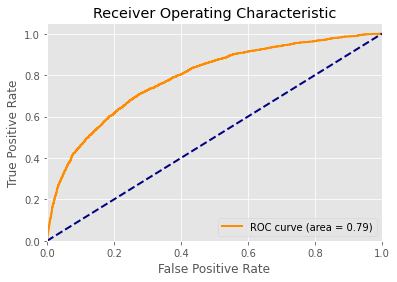

In [34]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

roc_auc = roc_auc_score(y_test_conv, y_pred_probs)

fpr, tpr, _ = roc_curve(y_test_conv, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

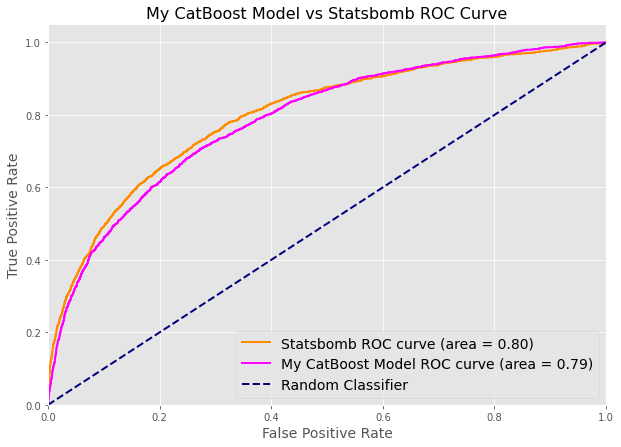

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')


roc_auc_sb = roc_auc_score(y_test_conv, sb_test)

fpr_sb, tpr_sb, _ = roc_curve(y_test_conv, sb_test)
plt.figure(figsize = (10,7))
plt.plot(fpr_sb, tpr_sb, color='darkorange', lw=2, label=f'Statsbomb ROC curve (area = {roc_auc_sb:.2f})')
plt.plot(fpr, tpr, color='#FF00FF', lw=2, label=f'My CatBoost Model ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('My CatBoost Model vs Statsbomb ROC Curve', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
#plt.savefig('06-06_attempt.png', dpi = 1000, facecolor = 'white', bbox_inches = 'tight')
plt.show()